In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = False
enable_orig = "orig"
enable_aug = True
enable_aug3 = True
max_training_samples = 200000
lstm_hidden_size = 128
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-False-enable_orig-orig-enable_aug-True-enable_aug3-True-max_training_samples-200000-lstm_hidden_size-128-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{len(train_x)}"

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

200000
200000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


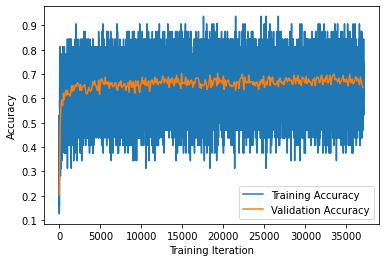

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.210 Validation Loss: 2.204 Accuracy: 0.047 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.207 Validation Loss: 2.204 Accuracy: 0.043 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.206 Validation Loss: 2.204 Accuracy: 0.047 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.205 Validation Loss: 2.204 Accuracy: 0.045 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.203 Validation Loss: 2.204 Accuracy: 0.052 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.203 Validation Loss: 2.204 Accuracy: 0.052 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.202 Validation Loss: 2.204 Accuracy: 0.055 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.202 Validation Loss: 2.204 Accuracy: 0.056 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.201 Validation Loss: 2.204 Accuracy: 0.060 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.203 Validation Loss: 2.204 Accuracy: 0.058 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.203 Validation Loss: 2.204 Accuracy: 0.057 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.202 Validation Loss: 2.204 Accuracy: 0.060 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.202 Validation Loss: 2.204 Accuracy: 0.061 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.201 Validation Loss: 2.204 Accuracy: 0.066 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.201 Validation Loss: 2.204 Accuracy: 0.067 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.200 Validation Loss: 2.204 Accuracy: 0.072 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.200 Validation Loss: 2.204 Accuracy: 0.073 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.199 Validation Loss: 2.204 Accuracy: 0.078 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.199 Validation Loss: 2.204 Accuracy: 0.074 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.199 Validation Loss: 2.204 Accuracy: 0.076 Validation Accuracy: 0.053:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.199 Validation Loss: 2.204 Accuracy: 0.076 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 20 Loss: 2.198 Validation Loss: 2.204 Accuracy: 0.078 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 21 Loss: 2.197 Validation Loss: 2.204 Accuracy: 0.077 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 22 Loss: 2.196 Validation Loss: 2.204 Accuracy: 0.079 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 23 Loss: 2.195 Validation Loss: 2.204 Accuracy: 0.080 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 24 Loss: 2.195 Validation Loss: 2.204 Accuracy: 0.079 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 25 Loss: 2.194 Validation Loss: 2.204 Accuracy: 0.076 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 26 Loss: 2.192 Validation Loss: 2.204 Accuracy: 0.080 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 27 Loss: 2.191 Validation Loss: 2.204 Accuracy: 0.078 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 28 Loss: 2.190 Validation Loss: 2.204 Accuracy: 0.087 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 29 Loss: 2.189 Validation Loss: 2.204 Accuracy: 0.087 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 30 Loss: 2.188 Validation Loss: 2.204 Accuracy: 0.088 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 31 Loss: 2.187 Validation Loss: 2.204 Accuracy: 0.090 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 32 Loss: 2.185 Validation Loss: 2.204 Accuracy: 0.096 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 33 Loss: 2.185 Validation Loss: 2.204 Accuracy: 0.093 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 34 Loss: 2.184 Validation Loss: 2.204 Accuracy: 0.091 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 35 Loss: 2.183 Validation Loss: 2.204 Accuracy: 0.092 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 36 Loss: 2.182 Validation Loss: 2.204 Accuracy: 0.089 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 37 Loss: 2.181 Validation Loss: 2.204 Accuracy: 0.094 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 38 Loss: 2.180 Validation Loss: 2.204 Accuracy: 0.087 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 39 Loss: 2.178 Validation Loss: 2.204 Accuracy: 0.095 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 40 Loss: 2.178 Validation Loss: 2.204 Accuracy: 0.098 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 41 Loss: 2.176 Validation Loss: 2.204 Accuracy: 0.102 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 42 Loss: 2.175 Validation Loss: 2.204 Accuracy: 0.102 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 43 Loss: 2.174 Validation Loss: 2.204 Accuracy: 0.106 Validation Accuracy: 0.053:   1%|▏         | 20/1563 [00:00<00:07, 196.01it/s]

Epoch: 0 Iteration: 43 Loss: 2.174 Validation Loss: 2.204 Accuracy: 0.106 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 44 Loss: 2.172 Validation Loss: 2.204 Accuracy: 0.115 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 45 Loss: 2.171 Validation Loss: 2.204 Accuracy: 0.120 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 46 Loss: 2.170 Validation Loss: 2.204 Accuracy: 0.123 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 47 Loss: 2.170 Validation Loss: 2.204 Accuracy: 0.123 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 48 Loss: 2.168 Validation Loss: 2.204 Accuracy: 0.134 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 49 Loss: 2.167 Validation Loss: 2.204 Accuracy: 0.132 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 50 Loss: 2.165 Validation Loss: 2.204 Accuracy: 0.138 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 51 Loss: 2.163 Validation Loss: 2.204 Accuracy: 0.143 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 52 Loss: 2.161 Validation Loss: 2.204 Accuracy: 0.150 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 53 Loss: 2.160 Validation Loss: 2.204 Accuracy: 0.155 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 54 Loss: 2.158 Validation Loss: 2.204 Accuracy: 0.161 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 55 Loss: 2.156 Validation Loss: 2.204 Accuracy: 0.167 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 56 Loss: 2.156 Validation Loss: 2.204 Accuracy: 0.167 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 57 Loss: 2.155 Validation Loss: 2.204 Accuracy: 0.171 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 58 Loss: 2.153 Validation Loss: 2.204 Accuracy: 0.173 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 59 Loss: 2.152 Validation Loss: 2.204 Accuracy: 0.181 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 60 Loss: 2.151 Validation Loss: 2.204 Accuracy: 0.179 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 61 Loss: 2.149 Validation Loss: 2.204 Accuracy: 0.187 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 62 Loss: 2.148 Validation Loss: 2.204 Accuracy: 0.186 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 63 Loss: 2.146 Validation Loss: 2.204 Accuracy: 0.191 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 64 Loss: 2.145 Validation Loss: 2.204 Accuracy: 0.192 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 65 Loss: 2.143 Validation Loss: 2.204 Accuracy: 0.196 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 66 Loss: 2.142 Validation Loss: 2.204 Accuracy: 0.208 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 67 Loss: 2.140 Validation Loss: 2.204 Accuracy: 0.212 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 68 Loss: 2.139 Validation Loss: 2.204 Accuracy: 0.220 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 69 Loss: 2.138 Validation Loss: 2.204 Accuracy: 0.220 Validation Accuracy: 0.053:   3%|▎         | 44/1563 [00:00<00:06, 218.43it/s]

Epoch: 0 Iteration: 69 Loss: 2.138 Validation Loss: 2.204 Accuracy: 0.220 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 70 Loss: 2.138 Validation Loss: 2.204 Accuracy: 0.223 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 71 Loss: 2.137 Validation Loss: 2.204 Accuracy: 0.218 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 72 Loss: 2.137 Validation Loss: 2.204 Accuracy: 0.223 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 73 Loss: 2.135 Validation Loss: 2.204 Accuracy: 0.223 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 74 Loss: 2.134 Validation Loss: 2.204 Accuracy: 0.226 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 75 Loss: 2.133 Validation Loss: 2.204 Accuracy: 0.228 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 76 Loss: 2.131 Validation Loss: 2.204 Accuracy: 0.234 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 77 Loss: 2.129 Validation Loss: 2.204 Accuracy: 0.241 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 78 Loss: 2.128 Validation Loss: 2.204 Accuracy: 0.240 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 79 Loss: 2.127 Validation Loss: 2.204 Accuracy: 0.252 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 80 Loss: 2.126 Validation Loss: 2.204 Accuracy: 0.256 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 81 Loss: 2.125 Validation Loss: 2.204 Accuracy: 0.265 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 82 Loss: 2.124 Validation Loss: 2.204 Accuracy: 0.266 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 83 Loss: 2.123 Validation Loss: 2.204 Accuracy: 0.277 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 84 Loss: 2.123 Validation Loss: 2.204 Accuracy: 0.277 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 85 Loss: 2.122 Validation Loss: 2.204 Accuracy: 0.279 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 86 Loss: 2.121 Validation Loss: 2.204 Accuracy: 0.276 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 87 Loss: 2.120 Validation Loss: 2.204 Accuracy: 0.277 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 88 Loss: 2.119 Validation Loss: 2.204 Accuracy: 0.280 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 89 Loss: 2.118 Validation Loss: 2.204 Accuracy: 0.280 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 90 Loss: 2.116 Validation Loss: 2.204 Accuracy: 0.291 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 91 Loss: 2.114 Validation Loss: 2.204 Accuracy: 0.296 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 92 Loss: 2.113 Validation Loss: 2.204 Accuracy: 0.303 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 93 Loss: 2.113 Validation Loss: 2.204 Accuracy: 0.299 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 94 Loss: 2.112 Validation Loss: 2.204 Accuracy: 0.309 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 95 Loss: 2.112 Validation Loss: 2.204 Accuracy: 0.308 Validation Accuracy: 0.053:   4%|▍         | 70/1563 [00:00<00:06, 233.64it/s]

Epoch: 0 Iteration: 95 Loss: 2.112 Validation Loss: 2.204 Accuracy: 0.308 Validation Accuracy: 0.053:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 96 Loss: 2.111 Validation Loss: 2.204 Accuracy: 0.312 Validation Accuracy: 0.053:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 97 Loss: 2.110 Validation Loss: 2.204 Accuracy: 0.314 Validation Accuracy: 0.053:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 98 Loss: 2.109 Validation Loss: 2.204 Accuracy: 0.312 Validation Accuracy: 0.053:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 99 Loss: 2.109 Validation Loss: 2.204 Accuracy: 0.314 Validation Accuracy: 0.053:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 100 Loss: 2.107 Validation Loss: 2.086 Accuracy: 0.318 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 101 Loss: 2.104 Validation Loss: 2.086 Accuracy: 0.323 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 102 Loss: 2.103 Validation Loss: 2.086 Accuracy: 0.322 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 103 Loss: 2.104 Validation Loss: 2.086 Accuracy: 0.323 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 104 Loss: 2.101 Validation Loss: 2.086 Accuracy: 0.319 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 105 Loss: 2.100 Validation Loss: 2.086 Accuracy: 0.334 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 106 Loss: 2.099 Validation Loss: 2.086 Accuracy: 0.336 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 107 Loss: 2.097 Validation Loss: 2.086 Accuracy: 0.336 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 108 Loss: 2.096 Validation Loss: 2.086 Accuracy: 0.352 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 109 Loss: 2.096 Validation Loss: 2.086 Accuracy: 0.355 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 110 Loss: 2.095 Validation Loss: 2.086 Accuracy: 0.355 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 111 Loss: 2.094 Validation Loss: 2.086 Accuracy: 0.348 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 112 Loss: 2.093 Validation Loss: 2.086 Accuracy: 0.352 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 113 Loss: 2.090 Validation Loss: 2.086 Accuracy: 0.355 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 114 Loss: 2.090 Validation Loss: 2.086 Accuracy: 0.360 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 115 Loss: 2.089 Validation Loss: 2.086 Accuracy: 0.356 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 116 Loss: 2.087 Validation Loss: 2.086 Accuracy: 0.365 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 117 Loss: 2.087 Validation Loss: 2.086 Accuracy: 0.361 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 118 Loss: 2.086 Validation Loss: 2.086 Accuracy: 0.348 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 119 Loss: 2.085 Validation Loss: 2.086 Accuracy: 0.359 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 120 Loss: 2.084 Validation Loss: 2.086 Accuracy: 0.367 Validation Accuracy: 0.201:   6%|▌         | 96/1563 [00:00<00:06, 241.97it/s]

Epoch: 0 Iteration: 120 Loss: 2.084 Validation Loss: 2.086 Accuracy: 0.367 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 121 Loss: 2.082 Validation Loss: 2.086 Accuracy: 0.384 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 122 Loss: 2.081 Validation Loss: 2.086 Accuracy: 0.382 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 123 Loss: 2.080 Validation Loss: 2.086 Accuracy: 0.391 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 124 Loss: 2.079 Validation Loss: 2.086 Accuracy: 0.398 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 125 Loss: 2.077 Validation Loss: 2.086 Accuracy: 0.407 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 126 Loss: 2.075 Validation Loss: 2.086 Accuracy: 0.407 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 127 Loss: 2.073 Validation Loss: 2.086 Accuracy: 0.420 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 128 Loss: 2.071 Validation Loss: 2.086 Accuracy: 0.434 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 129 Loss: 2.069 Validation Loss: 2.086 Accuracy: 0.428 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 130 Loss: 2.067 Validation Loss: 2.086 Accuracy: 0.429 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 131 Loss: 2.067 Validation Loss: 2.086 Accuracy: 0.426 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 132 Loss: 2.065 Validation Loss: 2.086 Accuracy: 0.431 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 133 Loss: 2.063 Validation Loss: 2.086 Accuracy: 0.439 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 134 Loss: 2.061 Validation Loss: 2.086 Accuracy: 0.445 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 135 Loss: 2.058 Validation Loss: 2.086 Accuracy: 0.441 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 136 Loss: 2.059 Validation Loss: 2.086 Accuracy: 0.442 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 137 Loss: 2.056 Validation Loss: 2.086 Accuracy: 0.444 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 138 Loss: 2.054 Validation Loss: 2.086 Accuracy: 0.437 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 139 Loss: 2.054 Validation Loss: 2.086 Accuracy: 0.433 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 140 Loss: 2.052 Validation Loss: 2.086 Accuracy: 0.441 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 141 Loss: 2.055 Validation Loss: 2.086 Accuracy: 0.432 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 142 Loss: 2.054 Validation Loss: 2.086 Accuracy: 0.430 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 143 Loss: 2.052 Validation Loss: 2.086 Accuracy: 0.423 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 144 Loss: 2.048 Validation Loss: 2.086 Accuracy: 0.431 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 145 Loss: 2.046 Validation Loss: 2.086 Accuracy: 0.444 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 146 Loss: 2.046 Validation Loss: 2.086 Accuracy: 0.445 Validation Accuracy: 0.201:   8%|▊         | 121/1563 [00:00<00:05, 241.61it/s]

Epoch: 0 Iteration: 146 Loss: 2.046 Validation Loss: 2.086 Accuracy: 0.445 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 147 Loss: 2.044 Validation Loss: 2.086 Accuracy: 0.458 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 148 Loss: 2.046 Validation Loss: 2.086 Accuracy: 0.454 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 149 Loss: 2.045 Validation Loss: 2.086 Accuracy: 0.462 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 150 Loss: 2.042 Validation Loss: 2.086 Accuracy: 0.463 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 151 Loss: 2.041 Validation Loss: 2.086 Accuracy: 0.474 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 152 Loss: 2.039 Validation Loss: 2.086 Accuracy: 0.490 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 153 Loss: 2.039 Validation Loss: 2.086 Accuracy: 0.490 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 154 Loss: 2.038 Validation Loss: 2.086 Accuracy: 0.484 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 155 Loss: 2.036 Validation Loss: 2.086 Accuracy: 0.486 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 156 Loss: 2.036 Validation Loss: 2.086 Accuracy: 0.491 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 157 Loss: 2.034 Validation Loss: 2.086 Accuracy: 0.487 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 158 Loss: 2.032 Validation Loss: 2.086 Accuracy: 0.505 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 159 Loss: 2.029 Validation Loss: 2.086 Accuracy: 0.516 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 160 Loss: 2.028 Validation Loss: 2.086 Accuracy: 0.513 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 161 Loss: 2.026 Validation Loss: 2.086 Accuracy: 0.516 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 162 Loss: 2.025 Validation Loss: 2.086 Accuracy: 0.517 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 163 Loss: 2.026 Validation Loss: 2.086 Accuracy: 0.523 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 164 Loss: 2.026 Validation Loss: 2.086 Accuracy: 0.536 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 165 Loss: 2.027 Validation Loss: 2.086 Accuracy: 0.533 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 166 Loss: 2.027 Validation Loss: 2.086 Accuracy: 0.535 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 167 Loss: 2.027 Validation Loss: 2.086 Accuracy: 0.545 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 168 Loss: 2.024 Validation Loss: 2.086 Accuracy: 0.548 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 169 Loss: 2.024 Validation Loss: 2.086 Accuracy: 0.532 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 170 Loss: 2.025 Validation Loss: 2.086 Accuracy: 0.539 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 171 Loss: 2.024 Validation Loss: 2.086 Accuracy: 0.538 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 172 Loss: 2.025 Validation Loss: 2.086 Accuracy: 0.536 Validation Accuracy: 0.201:   9%|▉         | 147/1563 [00:00<00:05, 245.81it/s]

Epoch: 0 Iteration: 172 Loss: 2.025 Validation Loss: 2.086 Accuracy: 0.536 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 173 Loss: 2.023 Validation Loss: 2.086 Accuracy: 0.544 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 174 Loss: 2.021 Validation Loss: 2.086 Accuracy: 0.534 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 175 Loss: 2.021 Validation Loss: 2.086 Accuracy: 0.529 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 176 Loss: 2.018 Validation Loss: 2.086 Accuracy: 0.529 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 177 Loss: 2.020 Validation Loss: 2.086 Accuracy: 0.527 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 178 Loss: 2.019 Validation Loss: 2.086 Accuracy: 0.529 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 179 Loss: 2.017 Validation Loss: 2.086 Accuracy: 0.541 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 180 Loss: 2.018 Validation Loss: 2.086 Accuracy: 0.535 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 181 Loss: 2.017 Validation Loss: 2.086 Accuracy: 0.539 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 182 Loss: 2.014 Validation Loss: 2.086 Accuracy: 0.546 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 183 Loss: 2.010 Validation Loss: 2.086 Accuracy: 0.551 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 184 Loss: 2.010 Validation Loss: 2.086 Accuracy: 0.555 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 185 Loss: 2.009 Validation Loss: 2.086 Accuracy: 0.563 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 186 Loss: 2.006 Validation Loss: 2.086 Accuracy: 0.567 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 187 Loss: 2.006 Validation Loss: 2.086 Accuracy: 0.566 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 188 Loss: 2.006 Validation Loss: 2.086 Accuracy: 0.559 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 189 Loss: 2.003 Validation Loss: 2.086 Accuracy: 0.561 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 190 Loss: 2.003 Validation Loss: 2.086 Accuracy: 0.570 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 191 Loss: 2.000 Validation Loss: 2.086 Accuracy: 0.576 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 192 Loss: 1.997 Validation Loss: 2.086 Accuracy: 0.578 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 193 Loss: 1.996 Validation Loss: 2.086 Accuracy: 0.578 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 194 Loss: 1.993 Validation Loss: 2.086 Accuracy: 0.580 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 195 Loss: 1.992 Validation Loss: 2.086 Accuracy: 0.579 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 196 Loss: 1.990 Validation Loss: 2.086 Accuracy: 0.588 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 197 Loss: 1.987 Validation Loss: 2.086 Accuracy: 0.590 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 198 Loss: 1.984 Validation Loss: 2.086 Accuracy: 0.608 Validation Accuracy: 0.201:  11%|█         | 173/1563 [00:00<00:05, 248.63it/s]

Epoch: 0 Iteration: 198 Loss: 1.984 Validation Loss: 2.086 Accuracy: 0.608 Validation Accuracy: 0.201:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 199 Loss: 1.983 Validation Loss: 2.086 Accuracy: 0.617 Validation Accuracy: 0.201:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 200 Loss: 1.979 Validation Loss: 1.953 Accuracy: 0.627 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 201 Loss: 1.976 Validation Loss: 1.953 Accuracy: 0.626 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 202 Loss: 1.976 Validation Loss: 1.953 Accuracy: 0.627 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 203 Loss: 1.974 Validation Loss: 1.953 Accuracy: 0.634 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 204 Loss: 1.972 Validation Loss: 1.953 Accuracy: 0.635 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 205 Loss: 1.968 Validation Loss: 1.953 Accuracy: 0.648 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 206 Loss: 1.968 Validation Loss: 1.953 Accuracy: 0.640 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 207 Loss: 1.965 Validation Loss: 1.953 Accuracy: 0.646 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 208 Loss: 1.962 Validation Loss: 1.953 Accuracy: 0.644 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 209 Loss: 1.961 Validation Loss: 1.953 Accuracy: 0.642 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 210 Loss: 1.959 Validation Loss: 1.953 Accuracy: 0.634 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 211 Loss: 1.962 Validation Loss: 1.953 Accuracy: 0.634 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 212 Loss: 1.960 Validation Loss: 1.953 Accuracy: 0.639 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 213 Loss: 1.960 Validation Loss: 1.953 Accuracy: 0.637 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 214 Loss: 1.963 Validation Loss: 1.953 Accuracy: 0.639 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 215 Loss: 1.962 Validation Loss: 1.953 Accuracy: 0.635 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 216 Loss: 1.962 Validation Loss: 1.953 Accuracy: 0.641 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 217 Loss: 1.962 Validation Loss: 1.953 Accuracy: 0.637 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 218 Loss: 1.963 Validation Loss: 1.953 Accuracy: 0.632 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 219 Loss: 1.963 Validation Loss: 1.953 Accuracy: 0.634 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 220 Loss: 1.961 Validation Loss: 1.953 Accuracy: 0.634 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 221 Loss: 1.961 Validation Loss: 1.953 Accuracy: 0.642 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 222 Loss: 1.957 Validation Loss: 1.953 Accuracy: 0.641 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 223 Loss: 1.956 Validation Loss: 1.953 Accuracy: 0.643 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 224 Loss: 1.957 Validation Loss: 1.953 Accuracy: 0.645 Validation Accuracy: 0.355:  13%|█▎        | 199/1563 [00:00<00:05, 250.12it/s]

Epoch: 0 Iteration: 224 Loss: 1.957 Validation Loss: 1.953 Accuracy: 0.645 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 225 Loss: 1.960 Validation Loss: 1.953 Accuracy: 0.640 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 226 Loss: 1.958 Validation Loss: 1.953 Accuracy: 0.639 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 227 Loss: 1.957 Validation Loss: 1.953 Accuracy: 0.644 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 228 Loss: 1.957 Validation Loss: 1.953 Accuracy: 0.648 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 229 Loss: 1.956 Validation Loss: 1.953 Accuracy: 0.650 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 230 Loss: 1.952 Validation Loss: 1.953 Accuracy: 0.655 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 231 Loss: 1.946 Validation Loss: 1.953 Accuracy: 0.653 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 232 Loss: 1.945 Validation Loss: 1.953 Accuracy: 0.655 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 233 Loss: 1.945 Validation Loss: 1.953 Accuracy: 0.651 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 234 Loss: 1.944 Validation Loss: 1.953 Accuracy: 0.652 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 235 Loss: 1.943 Validation Loss: 1.953 Accuracy: 0.659 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 236 Loss: 1.939 Validation Loss: 1.953 Accuracy: 0.659 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 237 Loss: 1.937 Validation Loss: 1.953 Accuracy: 0.659 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 238 Loss: 1.937 Validation Loss: 1.953 Accuracy: 0.663 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 239 Loss: 1.936 Validation Loss: 1.953 Accuracy: 0.662 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 240 Loss: 1.935 Validation Loss: 1.953 Accuracy: 0.665 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 241 Loss: 1.933 Validation Loss: 1.953 Accuracy: 0.671 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:00<00:05, 247.68it/s]

Epoch: 0 Iteration: 242 Loss: 1.934 Validation Loss: 1.953 Accuracy: 0.666 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 243 Loss: 1.933 Validation Loss: 1.953 Accuracy: 0.677 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 244 Loss: 1.931 Validation Loss: 1.953 Accuracy: 0.671 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 245 Loss: 1.928 Validation Loss: 1.953 Accuracy: 0.679 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 246 Loss: 1.930 Validation Loss: 1.953 Accuracy: 0.691 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 247 Loss: 1.933 Validation Loss: 1.953 Accuracy: 0.681 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 248 Loss: 1.932 Validation Loss: 1.953 Accuracy: 0.684 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 249 Loss: 1.931 Validation Loss: 1.953 Accuracy: 0.685 Validation Accuracy: 0.355:  14%|█▍        | 225/1563 [00:01<00:05, 247.68it/s]

Epoch: 0 Iteration: 249 Loss: 1.931 Validation Loss: 1.953 Accuracy: 0.685 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 250 Loss: 1.932 Validation Loss: 1.953 Accuracy: 0.680 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 251 Loss: 1.932 Validation Loss: 1.953 Accuracy: 0.679 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 252 Loss: 1.928 Validation Loss: 1.953 Accuracy: 0.687 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 253 Loss: 1.926 Validation Loss: 1.953 Accuracy: 0.684 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 254 Loss: 1.919 Validation Loss: 1.953 Accuracy: 0.691 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 255 Loss: 1.916 Validation Loss: 1.953 Accuracy: 0.691 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 256 Loss: 1.916 Validation Loss: 1.953 Accuracy: 0.681 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 257 Loss: 1.910 Validation Loss: 1.953 Accuracy: 0.696 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 258 Loss: 1.911 Validation Loss: 1.953 Accuracy: 0.687 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 259 Loss: 1.906 Validation Loss: 1.953 Accuracy: 0.690 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 260 Loss: 1.903 Validation Loss: 1.953 Accuracy: 0.700 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 261 Loss: 1.899 Validation Loss: 1.953 Accuracy: 0.698 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 262 Loss: 1.896 Validation Loss: 1.953 Accuracy: 0.697 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 263 Loss: 1.895 Validation Loss: 1.953 Accuracy: 0.692 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 264 Loss: 1.888 Validation Loss: 1.953 Accuracy: 0.698 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 265 Loss: 1.886 Validation Loss: 1.953 Accuracy: 0.699 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 266 Loss: 1.883 Validation Loss: 1.953 Accuracy: 0.704 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 267 Loss: 1.877 Validation Loss: 1.953 Accuracy: 0.696 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 268 Loss: 1.877 Validation Loss: 1.953 Accuracy: 0.695 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 269 Loss: 1.873 Validation Loss: 1.953 Accuracy: 0.688 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 270 Loss: 1.869 Validation Loss: 1.953 Accuracy: 0.688 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 271 Loss: 1.871 Validation Loss: 1.953 Accuracy: 0.683 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 272 Loss: 1.873 Validation Loss: 1.953 Accuracy: 0.681 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 273 Loss: 1.870 Validation Loss: 1.953 Accuracy: 0.683 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 274 Loss: 1.871 Validation Loss: 1.953 Accuracy: 0.674 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 275 Loss: 1.872 Validation Loss: 1.953 Accuracy: 0.670 Validation Accuracy: 0.355:  16%|█▌        | 250/1563 [00:01<00:05, 243.36it/s]

Epoch: 0 Iteration: 275 Loss: 1.872 Validation Loss: 1.953 Accuracy: 0.670 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 276 Loss: 1.866 Validation Loss: 1.953 Accuracy: 0.671 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 277 Loss: 1.868 Validation Loss: 1.953 Accuracy: 0.669 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 278 Loss: 1.865 Validation Loss: 1.953 Accuracy: 0.673 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 279 Loss: 1.866 Validation Loss: 1.953 Accuracy: 0.676 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 280 Loss: 1.866 Validation Loss: 1.953 Accuracy: 0.673 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 281 Loss: 1.869 Validation Loss: 1.953 Accuracy: 0.677 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 282 Loss: 1.868 Validation Loss: 1.953 Accuracy: 0.679 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 283 Loss: 1.865 Validation Loss: 1.953 Accuracy: 0.677 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 284 Loss: 1.869 Validation Loss: 1.953 Accuracy: 0.678 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 285 Loss: 1.863 Validation Loss: 1.953 Accuracy: 0.683 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 286 Loss: 1.863 Validation Loss: 1.953 Accuracy: 0.684 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 287 Loss: 1.863 Validation Loss: 1.953 Accuracy: 0.686 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 288 Loss: 1.857 Validation Loss: 1.953 Accuracy: 0.690 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 289 Loss: 1.858 Validation Loss: 1.953 Accuracy: 0.689 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 290 Loss: 1.854 Validation Loss: 1.953 Accuracy: 0.688 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 291 Loss: 1.845 Validation Loss: 1.953 Accuracy: 0.695 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 292 Loss: 1.847 Validation Loss: 1.953 Accuracy: 0.682 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 293 Loss: 1.848 Validation Loss: 1.953 Accuracy: 0.690 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 294 Loss: 1.845 Validation Loss: 1.953 Accuracy: 0.698 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 295 Loss: 1.843 Validation Loss: 1.953 Accuracy: 0.691 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 296 Loss: 1.846 Validation Loss: 1.953 Accuracy: 0.687 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 297 Loss: 1.842 Validation Loss: 1.953 Accuracy: 0.696 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 298 Loss: 1.837 Validation Loss: 1.953 Accuracy: 0.695 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 299 Loss: 1.839 Validation Loss: 1.953 Accuracy: 0.697 Validation Accuracy: 0.355:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 300 Loss: 1.838 Validation Loss: 1.789 Accuracy: 0.696 Validation Accuracy: 0.449:  18%|█▊        | 276/1563 [00:01<00:05, 247.52it/s]

Epoch: 0 Iteration: 300 Loss: 1.838 Validation Loss: 1.789 Accuracy: 0.696 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 301 Loss: 1.837 Validation Loss: 1.789 Accuracy: 0.694 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 302 Loss: 1.838 Validation Loss: 1.789 Accuracy: 0.698 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 303 Loss: 1.836 Validation Loss: 1.789 Accuracy: 0.701 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 304 Loss: 1.829 Validation Loss: 1.789 Accuracy: 0.705 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 305 Loss: 1.831 Validation Loss: 1.789 Accuracy: 0.709 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 306 Loss: 1.824 Validation Loss: 1.789 Accuracy: 0.715 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 307 Loss: 1.820 Validation Loss: 1.789 Accuracy: 0.709 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 308 Loss: 1.820 Validation Loss: 1.789 Accuracy: 0.710 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 309 Loss: 1.814 Validation Loss: 1.789 Accuracy: 0.705 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 310 Loss: 1.814 Validation Loss: 1.789 Accuracy: 0.703 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 311 Loss: 1.816 Validation Loss: 1.789 Accuracy: 0.708 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 312 Loss: 1.809 Validation Loss: 1.789 Accuracy: 0.719 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 313 Loss: 1.806 Validation Loss: 1.789 Accuracy: 0.719 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 314 Loss: 1.805 Validation Loss: 1.789 Accuracy: 0.708 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 315 Loss: 1.804 Validation Loss: 1.789 Accuracy: 0.707 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 316 Loss: 1.800 Validation Loss: 1.789 Accuracy: 0.706 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 317 Loss: 1.802 Validation Loss: 1.789 Accuracy: 0.698 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 318 Loss: 1.801 Validation Loss: 1.789 Accuracy: 0.690 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 319 Loss: 1.796 Validation Loss: 1.789 Accuracy: 0.696 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 320 Loss: 1.795 Validation Loss: 1.789 Accuracy: 0.696 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 321 Loss: 1.792 Validation Loss: 1.789 Accuracy: 0.689 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 322 Loss: 1.788 Validation Loss: 1.789 Accuracy: 0.684 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 323 Loss: 1.789 Validation Loss: 1.789 Accuracy: 0.676 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 324 Loss: 1.790 Validation Loss: 1.789 Accuracy: 0.680 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 325 Loss: 1.788 Validation Loss: 1.789 Accuracy: 0.675 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 326 Loss: 1.790 Validation Loss: 1.789 Accuracy: 0.670 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 327 Loss: 1.789 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  19%|█▉        | 301/1563 [00:01<00:05, 245.81it/s]

Epoch: 0 Iteration: 327 Loss: 1.789 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 328 Loss: 1.790 Validation Loss: 1.789 Accuracy: 0.677 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 329 Loss: 1.788 Validation Loss: 1.789 Accuracy: 0.676 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 330 Loss: 1.785 Validation Loss: 1.789 Accuracy: 0.678 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 331 Loss: 1.782 Validation Loss: 1.789 Accuracy: 0.680 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 332 Loss: 1.783 Validation Loss: 1.789 Accuracy: 0.680 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 333 Loss: 1.783 Validation Loss: 1.789 Accuracy: 0.678 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 334 Loss: 1.783 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 335 Loss: 1.782 Validation Loss: 1.789 Accuracy: 0.670 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 336 Loss: 1.779 Validation Loss: 1.789 Accuracy: 0.677 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 337 Loss: 1.772 Validation Loss: 1.789 Accuracy: 0.684 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 338 Loss: 1.765 Validation Loss: 1.789 Accuracy: 0.698 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 339 Loss: 1.766 Validation Loss: 1.789 Accuracy: 0.694 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 340 Loss: 1.766 Validation Loss: 1.789 Accuracy: 0.694 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 341 Loss: 1.764 Validation Loss: 1.789 Accuracy: 0.696 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 342 Loss: 1.761 Validation Loss: 1.789 Accuracy: 0.695 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 343 Loss: 1.762 Validation Loss: 1.789 Accuracy: 0.688 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 344 Loss: 1.760 Validation Loss: 1.789 Accuracy: 0.691 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 345 Loss: 1.761 Validation Loss: 1.789 Accuracy: 0.695 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 346 Loss: 1.756 Validation Loss: 1.789 Accuracy: 0.692 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 347 Loss: 1.754 Validation Loss: 1.789 Accuracy: 0.683 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 348 Loss: 1.751 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 349 Loss: 1.752 Validation Loss: 1.789 Accuracy: 0.676 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 350 Loss: 1.752 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 351 Loss: 1.754 Validation Loss: 1.789 Accuracy: 0.670 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 352 Loss: 1.747 Validation Loss: 1.789 Accuracy: 0.676 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 353 Loss: 1.743 Validation Loss: 1.789 Accuracy: 0.688 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 354 Loss: 1.741 Validation Loss: 1.789 Accuracy: 0.683 Validation Accuracy: 0.449:  21%|██        | 328/1563 [00:01<00:04, 250.23it/s]

Epoch: 0 Iteration: 354 Loss: 1.741 Validation Loss: 1.789 Accuracy: 0.683 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 355 Loss: 1.737 Validation Loss: 1.789 Accuracy: 0.679 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 356 Loss: 1.736 Validation Loss: 1.789 Accuracy: 0.677 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 357 Loss: 1.738 Validation Loss: 1.789 Accuracy: 0.677 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 358 Loss: 1.743 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 359 Loss: 1.738 Validation Loss: 1.789 Accuracy: 0.674 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 360 Loss: 1.738 Validation Loss: 1.789 Accuracy: 0.675 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 361 Loss: 1.736 Validation Loss: 1.789 Accuracy: 0.670 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 362 Loss: 1.739 Validation Loss: 1.789 Accuracy: 0.659 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 363 Loss: 1.734 Validation Loss: 1.789 Accuracy: 0.653 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 364 Loss: 1.735 Validation Loss: 1.789 Accuracy: 0.652 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 365 Loss: 1.732 Validation Loss: 1.789 Accuracy: 0.661 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 366 Loss: 1.734 Validation Loss: 1.789 Accuracy: 0.664 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 367 Loss: 1.730 Validation Loss: 1.789 Accuracy: 0.671 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 368 Loss: 1.720 Validation Loss: 1.789 Accuracy: 0.679 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 369 Loss: 1.721 Validation Loss: 1.789 Accuracy: 0.675 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 370 Loss: 1.719 Validation Loss: 1.789 Accuracy: 0.677 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 371 Loss: 1.719 Validation Loss: 1.789 Accuracy: 0.684 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 372 Loss: 1.726 Validation Loss: 1.789 Accuracy: 0.680 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 373 Loss: 1.728 Validation Loss: 1.789 Accuracy: 0.680 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 374 Loss: 1.725 Validation Loss: 1.789 Accuracy: 0.684 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 375 Loss: 1.725 Validation Loss: 1.789 Accuracy: 0.675 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 376 Loss: 1.726 Validation Loss: 1.789 Accuracy: 0.668 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 377 Loss: 1.722 Validation Loss: 1.789 Accuracy: 0.665 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 378 Loss: 1.718 Validation Loss: 1.789 Accuracy: 0.664 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 379 Loss: 1.719 Validation Loss: 1.789 Accuracy: 0.669 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 380 Loss: 1.715 Validation Loss: 1.789 Accuracy: 0.666 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 381 Loss: 1.712 Validation Loss: 1.789 Accuracy: 0.660 Validation Accuracy: 0.449:  23%|██▎       | 355/1563 [00:01<00:04, 253.47it/s]

Epoch: 0 Iteration: 381 Loss: 1.712 Validation Loss: 1.789 Accuracy: 0.660 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 382 Loss: 1.705 Validation Loss: 1.789 Accuracy: 0.668 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 383 Loss: 1.698 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 384 Loss: 1.694 Validation Loss: 1.789 Accuracy: 0.673 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 385 Loss: 1.690 Validation Loss: 1.789 Accuracy: 0.682 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 386 Loss: 1.685 Validation Loss: 1.789 Accuracy: 0.689 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 387 Loss: 1.684 Validation Loss: 1.789 Accuracy: 0.689 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 388 Loss: 1.689 Validation Loss: 1.789 Accuracy: 0.685 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 389 Loss: 1.680 Validation Loss: 1.789 Accuracy: 0.691 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 390 Loss: 1.675 Validation Loss: 1.789 Accuracy: 0.696 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 391 Loss: 1.671 Validation Loss: 1.789 Accuracy: 0.701 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 392 Loss: 1.663 Validation Loss: 1.789 Accuracy: 0.704 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 393 Loss: 1.661 Validation Loss: 1.789 Accuracy: 0.699 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 394 Loss: 1.658 Validation Loss: 1.789 Accuracy: 0.703 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 395 Loss: 1.650 Validation Loss: 1.789 Accuracy: 0.698 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 396 Loss: 1.647 Validation Loss: 1.789 Accuracy: 0.698 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 397 Loss: 1.647 Validation Loss: 1.789 Accuracy: 0.695 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 398 Loss: 1.646 Validation Loss: 1.789 Accuracy: 0.695 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 399 Loss: 1.646 Validation Loss: 1.789 Accuracy: 0.683 Validation Accuracy: 0.449:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 400 Loss: 1.644 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 401 Loss: 1.642 Validation Loss: 1.594 Accuracy: 0.677 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 402 Loss: 1.644 Validation Loss: 1.594 Accuracy: 0.666 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 403 Loss: 1.647 Validation Loss: 1.594 Accuracy: 0.667 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 404 Loss: 1.642 Validation Loss: 1.594 Accuracy: 0.667 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 405 Loss: 1.636 Validation Loss: 1.594 Accuracy: 0.674 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 406 Loss: 1.634 Validation Loss: 1.594 Accuracy: 0.679 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 407 Loss: 1.638 Validation Loss: 1.594 Accuracy: 0.673 Validation Accuracy: 0.504:  24%|██▍       | 382/1563 [00:01<00:04, 255.82it/s]

Epoch: 0 Iteration: 407 Loss: 1.638 Validation Loss: 1.594 Accuracy: 0.673 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 408 Loss: 1.633 Validation Loss: 1.594 Accuracy: 0.667 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 409 Loss: 1.631 Validation Loss: 1.594 Accuracy: 0.677 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 410 Loss: 1.629 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 411 Loss: 1.627 Validation Loss: 1.594 Accuracy: 0.678 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 412 Loss: 1.624 Validation Loss: 1.594 Accuracy: 0.688 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 413 Loss: 1.626 Validation Loss: 1.594 Accuracy: 0.682 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 414 Loss: 1.630 Validation Loss: 1.594 Accuracy: 0.677 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 415 Loss: 1.635 Validation Loss: 1.594 Accuracy: 0.668 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 416 Loss: 1.636 Validation Loss: 1.594 Accuracy: 0.654 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 417 Loss: 1.632 Validation Loss: 1.594 Accuracy: 0.668 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 418 Loss: 1.631 Validation Loss: 1.594 Accuracy: 0.673 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 419 Loss: 1.625 Validation Loss: 1.594 Accuracy: 0.668 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 420 Loss: 1.621 Validation Loss: 1.594 Accuracy: 0.666 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 421 Loss: 1.620 Validation Loss: 1.594 Accuracy: 0.665 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 422 Loss: 1.615 Validation Loss: 1.594 Accuracy: 0.663 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 423 Loss: 1.615 Validation Loss: 1.594 Accuracy: 0.670 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 424 Loss: 1.619 Validation Loss: 1.594 Accuracy: 0.668 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 425 Loss: 1.621 Validation Loss: 1.594 Accuracy: 0.675 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 426 Loss: 1.617 Validation Loss: 1.594 Accuracy: 0.682 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 427 Loss: 1.606 Validation Loss: 1.594 Accuracy: 0.684 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 428 Loss: 1.608 Validation Loss: 1.594 Accuracy: 0.682 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 429 Loss: 1.613 Validation Loss: 1.594 Accuracy: 0.685 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 430 Loss: 1.611 Validation Loss: 1.594 Accuracy: 0.688 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 431 Loss: 1.612 Validation Loss: 1.594 Accuracy: 0.688 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 432 Loss: 1.610 Validation Loss: 1.594 Accuracy: 0.684 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 433 Loss: 1.601 Validation Loss: 1.594 Accuracy: 0.688 Validation Accuracy: 0.504:  26%|██▌       | 408/1563 [00:01<00:04, 253.13it/s]

Epoch: 0 Iteration: 433 Loss: 1.601 Validation Loss: 1.594 Accuracy: 0.688 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 434 Loss: 1.590 Validation Loss: 1.594 Accuracy: 0.695 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 435 Loss: 1.587 Validation Loss: 1.594 Accuracy: 0.689 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 436 Loss: 1.585 Validation Loss: 1.594 Accuracy: 0.685 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 437 Loss: 1.584 Validation Loss: 1.594 Accuracy: 0.683 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 438 Loss: 1.578 Validation Loss: 1.594 Accuracy: 0.689 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 439 Loss: 1.573 Validation Loss: 1.594 Accuracy: 0.688 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 440 Loss: 1.573 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 441 Loss: 1.563 Validation Loss: 1.594 Accuracy: 0.687 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 442 Loss: 1.570 Validation Loss: 1.594 Accuracy: 0.686 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 443 Loss: 1.563 Validation Loss: 1.594 Accuracy: 0.679 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 444 Loss: 1.556 Validation Loss: 1.594 Accuracy: 0.678 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 445 Loss: 1.555 Validation Loss: 1.594 Accuracy: 0.678 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 446 Loss: 1.561 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 447 Loss: 1.557 Validation Loss: 1.594 Accuracy: 0.679 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 448 Loss: 1.550 Validation Loss: 1.594 Accuracy: 0.677 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 449 Loss: 1.545 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 450 Loss: 1.547 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 451 Loss: 1.537 Validation Loss: 1.594 Accuracy: 0.683 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 452 Loss: 1.534 Validation Loss: 1.594 Accuracy: 0.692 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 453 Loss: 1.529 Validation Loss: 1.594 Accuracy: 0.699 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 454 Loss: 1.531 Validation Loss: 1.594 Accuracy: 0.696 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 455 Loss: 1.532 Validation Loss: 1.594 Accuracy: 0.695 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 456 Loss: 1.530 Validation Loss: 1.594 Accuracy: 0.695 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 457 Loss: 1.534 Validation Loss: 1.594 Accuracy: 0.681 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 458 Loss: 1.538 Validation Loss: 1.594 Accuracy: 0.677 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 459 Loss: 1.541 Validation Loss: 1.594 Accuracy: 0.669 Validation Accuracy: 0.504:  28%|██▊       | 434/1563 [00:01<00:04, 254.82it/s]

Epoch: 0 Iteration: 459 Loss: 1.541 Validation Loss: 1.594 Accuracy: 0.669 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 460 Loss: 1.536 Validation Loss: 1.594 Accuracy: 0.671 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 461 Loss: 1.536 Validation Loss: 1.594 Accuracy: 0.665 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 462 Loss: 1.524 Validation Loss: 1.594 Accuracy: 0.663 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 463 Loss: 1.527 Validation Loss: 1.594 Accuracy: 0.656 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 464 Loss: 1.526 Validation Loss: 1.594 Accuracy: 0.658 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 465 Loss: 1.524 Validation Loss: 1.594 Accuracy: 0.659 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 466 Loss: 1.525 Validation Loss: 1.594 Accuracy: 0.655 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 467 Loss: 1.528 Validation Loss: 1.594 Accuracy: 0.666 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 468 Loss: 1.531 Validation Loss: 1.594 Accuracy: 0.662 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 469 Loss: 1.525 Validation Loss: 1.594 Accuracy: 0.671 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 470 Loss: 1.521 Validation Loss: 1.594 Accuracy: 0.670 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 471 Loss: 1.526 Validation Loss: 1.594 Accuracy: 0.659 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 472 Loss: 1.526 Validation Loss: 1.594 Accuracy: 0.655 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 473 Loss: 1.527 Validation Loss: 1.594 Accuracy: 0.659 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 474 Loss: 1.526 Validation Loss: 1.594 Accuracy: 0.657 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 475 Loss: 1.520 Validation Loss: 1.594 Accuracy: 0.658 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 476 Loss: 1.513 Validation Loss: 1.594 Accuracy: 0.659 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 477 Loss: 1.504 Validation Loss: 1.594 Accuracy: 0.661 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 478 Loss: 1.495 Validation Loss: 1.594 Accuracy: 0.670 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 479 Loss: 1.491 Validation Loss: 1.594 Accuracy: 0.670 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 480 Loss: 1.488 Validation Loss: 1.594 Accuracy: 0.675 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 481 Loss: 1.491 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 482 Loss: 1.490 Validation Loss: 1.594 Accuracy: 0.681 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 483 Loss: 1.484 Validation Loss: 1.594 Accuracy: 0.680 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 484 Loss: 1.481 Validation Loss: 1.594 Accuracy: 0.681 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 485 Loss: 1.478 Validation Loss: 1.594 Accuracy: 0.678 Validation Accuracy: 0.504:  29%|██▉       | 460/1563 [00:01<00:04, 256.24it/s]

Epoch: 0 Iteration: 485 Loss: 1.478 Validation Loss: 1.594 Accuracy: 0.678 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 486 Loss: 1.469 Validation Loss: 1.594 Accuracy: 0.677 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 487 Loss: 1.470 Validation Loss: 1.594 Accuracy: 0.673 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 488 Loss: 1.462 Validation Loss: 1.594 Accuracy: 0.669 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 489 Loss: 1.466 Validation Loss: 1.594 Accuracy: 0.663 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 490 Loss: 1.460 Validation Loss: 1.594 Accuracy: 0.660 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 491 Loss: 1.458 Validation Loss: 1.594 Accuracy: 0.662 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 492 Loss: 1.458 Validation Loss: 1.594 Accuracy: 0.662 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 493 Loss: 1.455 Validation Loss: 1.594 Accuracy: 0.665 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 494 Loss: 1.448 Validation Loss: 1.594 Accuracy: 0.665 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 495 Loss: 1.451 Validation Loss: 1.594 Accuracy: 0.660 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 496 Loss: 1.447 Validation Loss: 1.594 Accuracy: 0.669 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:01<00:04, 256.99it/s]

Epoch: 0 Iteration: 497 Loss: 1.446 Validation Loss: 1.594 Accuracy: 0.669 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 498 Loss: 1.447 Validation Loss: 1.594 Accuracy: 0.668 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 499 Loss: 1.443 Validation Loss: 1.594 Accuracy: 0.670 Validation Accuracy: 0.504:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 500 Loss: 1.443 Validation Loss: 1.377 Accuracy: 0.667 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 501 Loss: 1.439 Validation Loss: 1.377 Accuracy: 0.666 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 502 Loss: 1.437 Validation Loss: 1.377 Accuracy: 0.667 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 503 Loss: 1.435 Validation Loss: 1.377 Accuracy: 0.667 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 504 Loss: 1.430 Validation Loss: 1.377 Accuracy: 0.673 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 505 Loss: 1.426 Validation Loss: 1.377 Accuracy: 0.680 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 506 Loss: 1.426 Validation Loss: 1.377 Accuracy: 0.674 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 507 Loss: 1.420 Validation Loss: 1.377 Accuracy: 0.674 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 508 Loss: 1.416 Validation Loss: 1.377 Accuracy: 0.679 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 509 Loss: 1.409 Validation Loss: 1.377 Accuracy: 0.682 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 510 Loss: 1.413 Validation Loss: 1.377 Accuracy: 0.683 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 511 Loss: 1.416 Validation Loss: 1.377 Accuracy: 0.672 Validation Accuracy: 0.538:  31%|███       | 486/1563 [00:02<00:04, 256.99it/s]

Epoch: 0 Iteration: 511 Loss: 1.416 Validation Loss: 1.377 Accuracy: 0.672 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 512 Loss: 1.414 Validation Loss: 1.377 Accuracy: 0.674 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 513 Loss: 1.411 Validation Loss: 1.377 Accuracy: 0.673 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 514 Loss: 1.412 Validation Loss: 1.377 Accuracy: 0.668 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 515 Loss: 1.407 Validation Loss: 1.377 Accuracy: 0.670 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 516 Loss: 1.407 Validation Loss: 1.377 Accuracy: 0.669 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 517 Loss: 1.402 Validation Loss: 1.377 Accuracy: 0.672 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 518 Loss: 1.398 Validation Loss: 1.377 Accuracy: 0.670 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 519 Loss: 1.397 Validation Loss: 1.377 Accuracy: 0.662 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 520 Loss: 1.392 Validation Loss: 1.377 Accuracy: 0.668 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 521 Loss: 1.388 Validation Loss: 1.377 Accuracy: 0.687 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 522 Loss: 1.380 Validation Loss: 1.377 Accuracy: 0.690 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 523 Loss: 1.377 Validation Loss: 1.377 Accuracy: 0.692 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 524 Loss: 1.379 Validation Loss: 1.377 Accuracy: 0.695 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 525 Loss: 1.378 Validation Loss: 1.377 Accuracy: 0.700 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 526 Loss: 1.373 Validation Loss: 1.377 Accuracy: 0.705 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 527 Loss: 1.372 Validation Loss: 1.377 Accuracy: 0.707 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 528 Loss: 1.378 Validation Loss: 1.377 Accuracy: 0.698 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 529 Loss: 1.379 Validation Loss: 1.377 Accuracy: 0.705 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 530 Loss: 1.371 Validation Loss: 1.377 Accuracy: 0.702 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 531 Loss: 1.363 Validation Loss: 1.377 Accuracy: 0.698 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 532 Loss: 1.356 Validation Loss: 1.377 Accuracy: 0.695 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 533 Loss: 1.359 Validation Loss: 1.377 Accuracy: 0.690 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 534 Loss: 1.368 Validation Loss: 1.377 Accuracy: 0.674 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 535 Loss: 1.361 Validation Loss: 1.377 Accuracy: 0.670 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 536 Loss: 1.358 Validation Loss: 1.377 Accuracy: 0.669 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 537 Loss: 1.358 Validation Loss: 1.377 Accuracy: 0.664 Validation Accuracy: 0.538:  33%|███▎      | 512/1563 [00:02<00:04, 253.55it/s]

Epoch: 0 Iteration: 537 Loss: 1.358 Validation Loss: 1.377 Accuracy: 0.664 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 538 Loss: 1.360 Validation Loss: 1.377 Accuracy: 0.673 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 539 Loss: 1.357 Validation Loss: 1.377 Accuracy: 0.670 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 540 Loss: 1.357 Validation Loss: 1.377 Accuracy: 0.671 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 541 Loss: 1.361 Validation Loss: 1.377 Accuracy: 0.667 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 542 Loss: 1.366 Validation Loss: 1.377 Accuracy: 0.660 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 543 Loss: 1.370 Validation Loss: 1.377 Accuracy: 0.653 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 544 Loss: 1.367 Validation Loss: 1.377 Accuracy: 0.665 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 545 Loss: 1.371 Validation Loss: 1.377 Accuracy: 0.658 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 546 Loss: 1.371 Validation Loss: 1.377 Accuracy: 0.658 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 547 Loss: 1.370 Validation Loss: 1.377 Accuracy: 0.656 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 548 Loss: 1.367 Validation Loss: 1.377 Accuracy: 0.650 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 549 Loss: 1.370 Validation Loss: 1.377 Accuracy: 0.645 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 550 Loss: 1.376 Validation Loss: 1.377 Accuracy: 0.641 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 551 Loss: 1.375 Validation Loss: 1.377 Accuracy: 0.645 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 552 Loss: 1.379 Validation Loss: 1.377 Accuracy: 0.643 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 553 Loss: 1.371 Validation Loss: 1.377 Accuracy: 0.654 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 554 Loss: 1.356 Validation Loss: 1.377 Accuracy: 0.658 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 555 Loss: 1.360 Validation Loss: 1.377 Accuracy: 0.663 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 556 Loss: 1.362 Validation Loss: 1.377 Accuracy: 0.663 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 557 Loss: 1.360 Validation Loss: 1.377 Accuracy: 0.663 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 558 Loss: 1.357 Validation Loss: 1.377 Accuracy: 0.667 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 559 Loss: 1.352 Validation Loss: 1.377 Accuracy: 0.673 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 560 Loss: 1.352 Validation Loss: 1.377 Accuracy: 0.675 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 561 Loss: 1.351 Validation Loss: 1.377 Accuracy: 0.671 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 562 Loss: 1.347 Validation Loss: 1.377 Accuracy: 0.678 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 563 Loss: 1.337 Validation Loss: 1.377 Accuracy: 0.684 Validation Accuracy: 0.538:  34%|███▍      | 538/1563 [00:02<00:04, 255.00it/s]

Epoch: 0 Iteration: 563 Loss: 1.337 Validation Loss: 1.377 Accuracy: 0.684 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 564 Loss: 1.335 Validation Loss: 1.377 Accuracy: 0.680 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 565 Loss: 1.331 Validation Loss: 1.377 Accuracy: 0.671 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 566 Loss: 1.332 Validation Loss: 1.377 Accuracy: 0.663 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 567 Loss: 1.326 Validation Loss: 1.377 Accuracy: 0.670 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 568 Loss: 1.331 Validation Loss: 1.377 Accuracy: 0.659 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 569 Loss: 1.329 Validation Loss: 1.377 Accuracy: 0.654 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 570 Loss: 1.322 Validation Loss: 1.377 Accuracy: 0.655 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 571 Loss: 1.317 Validation Loss: 1.377 Accuracy: 0.659 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 572 Loss: 1.308 Validation Loss: 1.377 Accuracy: 0.665 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 573 Loss: 1.316 Validation Loss: 1.377 Accuracy: 0.649 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 574 Loss: 1.310 Validation Loss: 1.377 Accuracy: 0.658 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 575 Loss: 1.304 Validation Loss: 1.377 Accuracy: 0.670 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 576 Loss: 1.298 Validation Loss: 1.377 Accuracy: 0.681 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 577 Loss: 1.295 Validation Loss: 1.377 Accuracy: 0.678 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 578 Loss: 1.293 Validation Loss: 1.377 Accuracy: 0.688 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 579 Loss: 1.294 Validation Loss: 1.377 Accuracy: 0.691 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 580 Loss: 1.291 Validation Loss: 1.377 Accuracy: 0.692 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 581 Loss: 1.285 Validation Loss: 1.377 Accuracy: 0.699 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 582 Loss: 1.284 Validation Loss: 1.377 Accuracy: 0.688 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 583 Loss: 1.287 Validation Loss: 1.377 Accuracy: 0.696 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 584 Loss: 1.287 Validation Loss: 1.377 Accuracy: 0.682 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 585 Loss: 1.276 Validation Loss: 1.377 Accuracy: 0.688 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 586 Loss: 1.277 Validation Loss: 1.377 Accuracy: 0.673 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 587 Loss: 1.279 Validation Loss: 1.377 Accuracy: 0.672 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 588 Loss: 1.265 Validation Loss: 1.377 Accuracy: 0.677 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 589 Loss: 1.265 Validation Loss: 1.377 Accuracy: 0.674 Validation Accuracy: 0.538:  36%|███▌      | 564/1563 [00:02<00:03, 254.00it/s]

Epoch: 0 Iteration: 589 Loss: 1.265 Validation Loss: 1.377 Accuracy: 0.674 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 590 Loss: 1.270 Validation Loss: 1.377 Accuracy: 0.666 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 591 Loss: 1.272 Validation Loss: 1.377 Accuracy: 0.655 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 592 Loss: 1.274 Validation Loss: 1.377 Accuracy: 0.659 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 593 Loss: 1.268 Validation Loss: 1.377 Accuracy: 0.660 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 594 Loss: 1.275 Validation Loss: 1.377 Accuracy: 0.665 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 595 Loss: 1.278 Validation Loss: 1.377 Accuracy: 0.658 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 596 Loss: 1.283 Validation Loss: 1.377 Accuracy: 0.664 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 597 Loss: 1.279 Validation Loss: 1.377 Accuracy: 0.666 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 598 Loss: 1.276 Validation Loss: 1.377 Accuracy: 0.663 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 599 Loss: 1.275 Validation Loss: 1.377 Accuracy: 0.671 Validation Accuracy: 0.538:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 600 Loss: 1.271 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 601 Loss: 1.272 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 602 Loss: 1.276 Validation Loss: 1.189 Accuracy: 0.673 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 603 Loss: 1.274 Validation Loss: 1.189 Accuracy: 0.673 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 604 Loss: 1.262 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 605 Loss: 1.260 Validation Loss: 1.189 Accuracy: 0.687 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 606 Loss: 1.255 Validation Loss: 1.189 Accuracy: 0.690 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 607 Loss: 1.254 Validation Loss: 1.189 Accuracy: 0.690 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 608 Loss: 1.248 Validation Loss: 1.189 Accuracy: 0.691 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 609 Loss: 1.240 Validation Loss: 1.189 Accuracy: 0.690 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 610 Loss: 1.234 Validation Loss: 1.189 Accuracy: 0.690 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 611 Loss: 1.234 Validation Loss: 1.189 Accuracy: 0.686 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 612 Loss: 1.234 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 613 Loss: 1.234 Validation Loss: 1.189 Accuracy: 0.683 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 614 Loss: 1.231 Validation Loss: 1.189 Accuracy: 0.674 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 615 Loss: 1.222 Validation Loss: 1.189 Accuracy: 0.671 Validation Accuracy: 0.563:  38%|███▊      | 590/1563 [00:02<00:03, 249.97it/s]

Epoch: 0 Iteration: 615 Loss: 1.222 Validation Loss: 1.189 Accuracy: 0.671 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 616 Loss: 1.218 Validation Loss: 1.189 Accuracy: 0.670 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 617 Loss: 1.221 Validation Loss: 1.189 Accuracy: 0.671 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 618 Loss: 1.226 Validation Loss: 1.189 Accuracy: 0.662 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 619 Loss: 1.228 Validation Loss: 1.189 Accuracy: 0.661 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 620 Loss: 1.224 Validation Loss: 1.189 Accuracy: 0.662 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 621 Loss: 1.214 Validation Loss: 1.189 Accuracy: 0.679 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 622 Loss: 1.203 Validation Loss: 1.189 Accuracy: 0.691 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 623 Loss: 1.201 Validation Loss: 1.189 Accuracy: 0.689 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 624 Loss: 1.208 Validation Loss: 1.189 Accuracy: 0.693 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 625 Loss: 1.211 Validation Loss: 1.189 Accuracy: 0.686 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 626 Loss: 1.209 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 627 Loss: 1.210 Validation Loss: 1.189 Accuracy: 0.684 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 628 Loss: 1.216 Validation Loss: 1.189 Accuracy: 0.691 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 629 Loss: 1.216 Validation Loss: 1.189 Accuracy: 0.694 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 630 Loss: 1.211 Validation Loss: 1.189 Accuracy: 0.693 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 631 Loss: 1.204 Validation Loss: 1.189 Accuracy: 0.682 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 632 Loss: 1.199 Validation Loss: 1.189 Accuracy: 0.677 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 633 Loss: 1.196 Validation Loss: 1.189 Accuracy: 0.684 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 634 Loss: 1.203 Validation Loss: 1.189 Accuracy: 0.676 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 635 Loss: 1.204 Validation Loss: 1.189 Accuracy: 0.682 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 636 Loss: 1.204 Validation Loss: 1.189 Accuracy: 0.682 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 637 Loss: 1.197 Validation Loss: 1.189 Accuracy: 0.691 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 638 Loss: 1.194 Validation Loss: 1.189 Accuracy: 0.687 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 639 Loss: 1.193 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 640 Loss: 1.194 Validation Loss: 1.189 Accuracy: 0.682 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 641 Loss: 1.195 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  39%|███▉      | 616/1563 [00:02<00:03, 247.31it/s]

Epoch: 0 Iteration: 641 Loss: 1.195 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 642 Loss: 1.201 Validation Loss: 1.189 Accuracy: 0.686 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 643 Loss: 1.200 Validation Loss: 1.189 Accuracy: 0.684 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 644 Loss: 1.201 Validation Loss: 1.189 Accuracy: 0.691 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 645 Loss: 1.195 Validation Loss: 1.189 Accuracy: 0.692 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 646 Loss: 1.194 Validation Loss: 1.189 Accuracy: 0.694 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 647 Loss: 1.184 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 648 Loss: 1.182 Validation Loss: 1.189 Accuracy: 0.693 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 649 Loss: 1.180 Validation Loss: 1.189 Accuracy: 0.698 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 650 Loss: 1.181 Validation Loss: 1.189 Accuracy: 0.694 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 651 Loss: 1.182 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 652 Loss: 1.189 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 653 Loss: 1.190 Validation Loss: 1.189 Accuracy: 0.677 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 654 Loss: 1.171 Validation Loss: 1.189 Accuracy: 0.684 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 655 Loss: 1.171 Validation Loss: 1.189 Accuracy: 0.678 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 656 Loss: 1.176 Validation Loss: 1.189 Accuracy: 0.668 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 657 Loss: 1.177 Validation Loss: 1.189 Accuracy: 0.670 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 658 Loss: 1.172 Validation Loss: 1.189 Accuracy: 0.670 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 659 Loss: 1.164 Validation Loss: 1.189 Accuracy: 0.673 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 660 Loss: 1.168 Validation Loss: 1.189 Accuracy: 0.670 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 661 Loss: 1.169 Validation Loss: 1.189 Accuracy: 0.675 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 662 Loss: 1.164 Validation Loss: 1.189 Accuracy: 0.683 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 663 Loss: 1.161 Validation Loss: 1.189 Accuracy: 0.687 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 664 Loss: 1.159 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 665 Loss: 1.161 Validation Loss: 1.189 Accuracy: 0.683 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 666 Loss: 1.160 Validation Loss: 1.189 Accuracy: 0.694 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 667 Loss: 1.170 Validation Loss: 1.189 Accuracy: 0.685 Validation Accuracy: 0.563:  41%|████      | 642/1563 [00:02<00:03, 250.82it/s]

Epoch: 0 Iteration: 667 Loss: 1.170 Validation Loss: 1.189 Accuracy: 0.685 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 668 Loss: 1.162 Validation Loss: 1.189 Accuracy: 0.691 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 669 Loss: 1.167 Validation Loss: 1.189 Accuracy: 0.683 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 670 Loss: 1.164 Validation Loss: 1.189 Accuracy: 0.690 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 671 Loss: 1.162 Validation Loss: 1.189 Accuracy: 0.685 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 672 Loss: 1.155 Validation Loss: 1.189 Accuracy: 0.686 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 673 Loss: 1.154 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 674 Loss: 1.153 Validation Loss: 1.189 Accuracy: 0.686 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 675 Loss: 1.150 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 676 Loss: 1.145 Validation Loss: 1.189 Accuracy: 0.684 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 677 Loss: 1.145 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 678 Loss: 1.142 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 679 Loss: 1.139 Validation Loss: 1.189 Accuracy: 0.687 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 680 Loss: 1.135 Validation Loss: 1.189 Accuracy: 0.683 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 681 Loss: 1.138 Validation Loss: 1.189 Accuracy: 0.687 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 682 Loss: 1.136 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 683 Loss: 1.139 Validation Loss: 1.189 Accuracy: 0.691 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 684 Loss: 1.141 Validation Loss: 1.189 Accuracy: 0.685 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 685 Loss: 1.147 Validation Loss: 1.189 Accuracy: 0.680 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 686 Loss: 1.141 Validation Loss: 1.189 Accuracy: 0.688 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 687 Loss: 1.125 Validation Loss: 1.189 Accuracy: 0.700 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 688 Loss: 1.125 Validation Loss: 1.189 Accuracy: 0.704 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 689 Loss: 1.113 Validation Loss: 1.189 Accuracy: 0.709 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 690 Loss: 1.115 Validation Loss: 1.189 Accuracy: 0.712 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 691 Loss: 1.111 Validation Loss: 1.189 Accuracy: 0.714 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 692 Loss: 1.108 Validation Loss: 1.189 Accuracy: 0.716 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 693 Loss: 1.104 Validation Loss: 1.189 Accuracy: 0.716 Validation Accuracy: 0.563:  43%|████▎     | 668/1563 [00:02<00:03, 250.30it/s]

Epoch: 0 Iteration: 693 Loss: 1.104 Validation Loss: 1.189 Accuracy: 0.716 Validation Accuracy: 0.563:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 694 Loss: 1.110 Validation Loss: 1.189 Accuracy: 0.716 Validation Accuracy: 0.563:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 695 Loss: 1.112 Validation Loss: 1.189 Accuracy: 0.717 Validation Accuracy: 0.563:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 696 Loss: 1.110 Validation Loss: 1.189 Accuracy: 0.709 Validation Accuracy: 0.563:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 697 Loss: 1.107 Validation Loss: 1.189 Accuracy: 0.702 Validation Accuracy: 0.563:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 698 Loss: 1.112 Validation Loss: 1.189 Accuracy: 0.696 Validation Accuracy: 0.563:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 699 Loss: 1.113 Validation Loss: 1.189 Accuracy: 0.694 Validation Accuracy: 0.563:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 700 Loss: 1.116 Validation Loss: 1.063 Accuracy: 0.686 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 701 Loss: 1.108 Validation Loss: 1.063 Accuracy: 0.687 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 702 Loss: 1.110 Validation Loss: 1.063 Accuracy: 0.685 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 703 Loss: 1.107 Validation Loss: 1.063 Accuracy: 0.689 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 704 Loss: 1.107 Validation Loss: 1.063 Accuracy: 0.679 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 705 Loss: 1.097 Validation Loss: 1.063 Accuracy: 0.686 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 706 Loss: 1.092 Validation Loss: 1.063 Accuracy: 0.695 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 707 Loss: 1.099 Validation Loss: 1.063 Accuracy: 0.693 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 708 Loss: 1.098 Validation Loss: 1.063 Accuracy: 0.704 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 709 Loss: 1.105 Validation Loss: 1.063 Accuracy: 0.695 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 710 Loss: 1.106 Validation Loss: 1.063 Accuracy: 0.702 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 711 Loss: 1.110 Validation Loss: 1.063 Accuracy: 0.695 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 712 Loss: 1.118 Validation Loss: 1.063 Accuracy: 0.683 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 713 Loss: 1.116 Validation Loss: 1.063 Accuracy: 0.681 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 714 Loss: 1.109 Validation Loss: 1.063 Accuracy: 0.697 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 715 Loss: 1.108 Validation Loss: 1.063 Accuracy: 0.691 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 716 Loss: 1.107 Validation Loss: 1.063 Accuracy: 0.677 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 717 Loss: 1.105 Validation Loss: 1.063 Accuracy: 0.678 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 718 Loss: 1.096 Validation Loss: 1.063 Accuracy: 0.672 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 719 Loss: 1.104 Validation Loss: 1.063 Accuracy: 0.670 Validation Accuracy: 0.583:  44%|████▍     | 694/1563 [00:02<00:03, 252.73it/s]

Epoch: 0 Iteration: 719 Loss: 1.104 Validation Loss: 1.063 Accuracy: 0.670 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 720 Loss: 1.100 Validation Loss: 1.063 Accuracy: 0.667 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 721 Loss: 1.107 Validation Loss: 1.063 Accuracy: 0.665 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 722 Loss: 1.103 Validation Loss: 1.063 Accuracy: 0.677 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 723 Loss: 1.109 Validation Loss: 1.063 Accuracy: 0.665 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 724 Loss: 1.096 Validation Loss: 1.063 Accuracy: 0.668 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 725 Loss: 1.100 Validation Loss: 1.063 Accuracy: 0.666 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 726 Loss: 1.108 Validation Loss: 1.063 Accuracy: 0.670 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 727 Loss: 1.107 Validation Loss: 1.063 Accuracy: 0.666 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 728 Loss: 1.106 Validation Loss: 1.063 Accuracy: 0.669 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 729 Loss: 1.106 Validation Loss: 1.063 Accuracy: 0.675 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 730 Loss: 1.105 Validation Loss: 1.063 Accuracy: 0.675 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 731 Loss: 1.106 Validation Loss: 1.063 Accuracy: 0.677 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 732 Loss: 1.101 Validation Loss: 1.063 Accuracy: 0.674 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 733 Loss: 1.100 Validation Loss: 1.063 Accuracy: 0.687 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 734 Loss: 1.104 Validation Loss: 1.063 Accuracy: 0.680 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 735 Loss: 1.100 Validation Loss: 1.063 Accuracy: 0.684 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 736 Loss: 1.102 Validation Loss: 1.063 Accuracy: 0.684 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 737 Loss: 1.101 Validation Loss: 1.063 Accuracy: 0.690 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 738 Loss: 1.103 Validation Loss: 1.063 Accuracy: 0.685 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 739 Loss: 1.087 Validation Loss: 1.063 Accuracy: 0.692 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 740 Loss: 1.091 Validation Loss: 1.063 Accuracy: 0.688 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 741 Loss: 1.095 Validation Loss: 1.063 Accuracy: 0.688 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 742 Loss: 1.100 Validation Loss: 1.063 Accuracy: 0.690 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 743 Loss: 1.100 Validation Loss: 1.063 Accuracy: 0.682 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 744 Loss: 1.109 Validation Loss: 1.063 Accuracy: 0.680 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 745 Loss: 1.107 Validation Loss: 1.063 Accuracy: 0.680 Validation Accuracy: 0.583:  46%|████▌     | 720/1563 [00:02<00:03, 251.09it/s]

Epoch: 0 Iteration: 745 Loss: 1.107 Validation Loss: 1.063 Accuracy: 0.680 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:02<00:03, 253.51it/s]

Epoch: 0 Iteration: 746 Loss: 1.101 Validation Loss: 1.063 Accuracy: 0.687 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:02<00:03, 253.51it/s]

Epoch: 0 Iteration: 747 Loss: 1.103 Validation Loss: 1.063 Accuracy: 0.680 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:02<00:03, 253.51it/s]

Epoch: 0 Iteration: 748 Loss: 1.102 Validation Loss: 1.063 Accuracy: 0.685 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 749 Loss: 1.101 Validation Loss: 1.063 Accuracy: 0.680 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 750 Loss: 1.098 Validation Loss: 1.063 Accuracy: 0.685 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 751 Loss: 1.089 Validation Loss: 1.063 Accuracy: 0.690 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 752 Loss: 1.086 Validation Loss: 1.063 Accuracy: 0.691 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 753 Loss: 1.083 Validation Loss: 1.063 Accuracy: 0.702 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 754 Loss: 1.083 Validation Loss: 1.063 Accuracy: 0.707 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 755 Loss: 1.085 Validation Loss: 1.063 Accuracy: 0.703 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 756 Loss: 1.075 Validation Loss: 1.063 Accuracy: 0.703 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 757 Loss: 1.072 Validation Loss: 1.063 Accuracy: 0.708 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 758 Loss: 1.069 Validation Loss: 1.063 Accuracy: 0.706 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 759 Loss: 1.083 Validation Loss: 1.063 Accuracy: 0.696 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 760 Loss: 1.077 Validation Loss: 1.063 Accuracy: 0.694 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 761 Loss: 1.068 Validation Loss: 1.063 Accuracy: 0.691 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 762 Loss: 1.065 Validation Loss: 1.063 Accuracy: 0.691 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 763 Loss: 1.063 Validation Loss: 1.063 Accuracy: 0.678 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 764 Loss: 1.061 Validation Loss: 1.063 Accuracy: 0.674 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 765 Loss: 1.058 Validation Loss: 1.063 Accuracy: 0.680 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 766 Loss: 1.066 Validation Loss: 1.063 Accuracy: 0.673 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 767 Loss: 1.060 Validation Loss: 1.063 Accuracy: 0.679 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 768 Loss: 1.069 Validation Loss: 1.063 Accuracy: 0.670 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 769 Loss: 1.067 Validation Loss: 1.063 Accuracy: 0.679 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 770 Loss: 1.073 Validation Loss: 1.063 Accuracy: 0.675 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 771 Loss: 1.075 Validation Loss: 1.063 Accuracy: 0.677 Validation Accuracy: 0.583:  48%|████▊     | 746/1563 [00:03<00:03, 253.51it/s]

Epoch: 0 Iteration: 771 Loss: 1.075 Validation Loss: 1.063 Accuracy: 0.677 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 772 Loss: 1.067 Validation Loss: 1.063 Accuracy: 0.681 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 773 Loss: 1.071 Validation Loss: 1.063 Accuracy: 0.691 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 774 Loss: 1.066 Validation Loss: 1.063 Accuracy: 0.692 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 775 Loss: 1.068 Validation Loss: 1.063 Accuracy: 0.686 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 776 Loss: 1.068 Validation Loss: 1.063 Accuracy: 0.691 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 777 Loss: 1.077 Validation Loss: 1.063 Accuracy: 0.682 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 778 Loss: 1.077 Validation Loss: 1.063 Accuracy: 0.689 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 779 Loss: 1.065 Validation Loss: 1.063 Accuracy: 0.695 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 780 Loss: 1.061 Validation Loss: 1.063 Accuracy: 0.705 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 781 Loss: 1.056 Validation Loss: 1.063 Accuracy: 0.708 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 782 Loss: 1.053 Validation Loss: 1.063 Accuracy: 0.703 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 783 Loss: 1.048 Validation Loss: 1.063 Accuracy: 0.700 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 784 Loss: 1.048 Validation Loss: 1.063 Accuracy: 0.698 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 785 Loss: 1.044 Validation Loss: 1.063 Accuracy: 0.706 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 786 Loss: 1.041 Validation Loss: 1.063 Accuracy: 0.698 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 787 Loss: 1.037 Validation Loss: 1.063 Accuracy: 0.703 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 788 Loss: 1.031 Validation Loss: 1.063 Accuracy: 0.702 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 789 Loss: 1.032 Validation Loss: 1.063 Accuracy: 0.691 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 790 Loss: 1.028 Validation Loss: 1.063 Accuracy: 0.688 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 791 Loss: 1.030 Validation Loss: 1.063 Accuracy: 0.682 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 792 Loss: 1.037 Validation Loss: 1.063 Accuracy: 0.679 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 793 Loss: 1.030 Validation Loss: 1.063 Accuracy: 0.684 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 794 Loss: 1.037 Validation Loss: 1.063 Accuracy: 0.681 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 795 Loss: 1.036 Validation Loss: 1.063 Accuracy: 0.672 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 796 Loss: 1.040 Validation Loss: 1.063 Accuracy: 0.673 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 797 Loss: 1.030 Validation Loss: 1.063 Accuracy: 0.675 Validation Accuracy: 0.583:  49%|████▉     | 772/1563 [00:03<00:03, 255.11it/s]

Epoch: 0 Iteration: 797 Loss: 1.030 Validation Loss: 1.063 Accuracy: 0.675 Validation Accuracy: 0.583:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 798 Loss: 1.026 Validation Loss: 1.063 Accuracy: 0.678 Validation Accuracy: 0.583:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 799 Loss: 1.024 Validation Loss: 1.063 Accuracy: 0.687 Validation Accuracy: 0.583:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 800 Loss: 1.028 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 801 Loss: 1.037 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 802 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 803 Loss: 1.039 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 804 Loss: 1.037 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 805 Loss: 1.040 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 806 Loss: 1.039 Validation Loss: 0.979 Accuracy: 0.690 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 807 Loss: 1.049 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 808 Loss: 1.049 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 809 Loss: 1.043 Validation Loss: 0.979 Accuracy: 0.675 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 810 Loss: 1.038 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 811 Loss: 1.034 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 812 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.676 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 813 Loss: 1.038 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 814 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 815 Loss: 1.032 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 816 Loss: 1.030 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 817 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 818 Loss: 1.043 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 819 Loss: 1.046 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 820 Loss: 1.044 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 821 Loss: 1.038 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 822 Loss: 1.034 Validation Loss: 0.979 Accuracy: 0.697 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 823 Loss: 1.020 Validation Loss: 0.979 Accuracy: 0.701 Validation Accuracy: 0.599:  51%|█████     | 798/1563 [00:03<00:02, 256.19it/s]

Epoch: 0 Iteration: 823 Loss: 1.020 Validation Loss: 0.979 Accuracy: 0.701 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 824 Loss: 1.018 Validation Loss: 0.979 Accuracy: 0.697 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 825 Loss: 1.017 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 826 Loss: 1.020 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 827 Loss: 1.015 Validation Loss: 0.979 Accuracy: 0.700 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 828 Loss: 1.008 Validation Loss: 0.979 Accuracy: 0.708 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 829 Loss: 1.015 Validation Loss: 0.979 Accuracy: 0.700 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 830 Loss: 1.022 Validation Loss: 0.979 Accuracy: 0.694 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 831 Loss: 1.023 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 832 Loss: 1.018 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 833 Loss: 1.022 Validation Loss: 0.979 Accuracy: 0.683 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 834 Loss: 1.022 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 835 Loss: 1.022 Validation Loss: 0.979 Accuracy: 0.675 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 836 Loss: 1.023 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 837 Loss: 1.017 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 838 Loss: 1.013 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 839 Loss: 1.014 Validation Loss: 0.979 Accuracy: 0.683 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 840 Loss: 1.011 Validation Loss: 0.979 Accuracy: 0.689 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 841 Loss: 1.011 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 842 Loss: 1.014 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 843 Loss: 1.019 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 844 Loss: 1.020 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 845 Loss: 1.016 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 846 Loss: 1.012 Validation Loss: 0.979 Accuracy: 0.704 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 847 Loss: 1.013 Validation Loss: 0.979 Accuracy: 0.701 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 848 Loss: 1.018 Validation Loss: 0.979 Accuracy: 0.697 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 849 Loss: 1.013 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.599:  53%|█████▎    | 824/1563 [00:03<00:02, 253.54it/s]

Epoch: 0 Iteration: 849 Loss: 1.013 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 850 Loss: 1.014 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 851 Loss: 1.008 Validation Loss: 0.979 Accuracy: 0.693 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 852 Loss: 1.011 Validation Loss: 0.979 Accuracy: 0.690 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 853 Loss: 1.008 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 854 Loss: 1.011 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 855 Loss: 1.004 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 856 Loss: 1.003 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 857 Loss: 1.002 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 858 Loss: 1.004 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 859 Loss: 1.003 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 860 Loss: 1.003 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 861 Loss: 1.001 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 862 Loss: 0.999 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 863 Loss: 0.999 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 864 Loss: 1.000 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 865 Loss: 0.998 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 866 Loss: 0.999 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 867 Loss: 0.998 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 868 Loss: 0.988 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 869 Loss: 0.993 Validation Loss: 0.979 Accuracy: 0.703 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 870 Loss: 0.983 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 871 Loss: 0.987 Validation Loss: 0.979 Accuracy: 0.705 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 872 Loss: 0.983 Validation Loss: 0.979 Accuracy: 0.704 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 873 Loss: 0.981 Validation Loss: 0.979 Accuracy: 0.706 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 874 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.709 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 875 Loss: 0.982 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  54%|█████▍    | 850/1563 [00:03<00:02, 255.25it/s]

Epoch: 0 Iteration: 875 Loss: 0.982 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 876 Loss: 0.978 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 877 Loss: 0.983 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 878 Loss: 0.983 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 879 Loss: 0.988 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 880 Loss: 0.993 Validation Loss: 0.979 Accuracy: 0.675 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 881 Loss: 0.993 Validation Loss: 0.979 Accuracy: 0.681 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 882 Loss: 0.993 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 883 Loss: 0.999 Validation Loss: 0.979 Accuracy: 0.675 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 884 Loss: 1.000 Validation Loss: 0.979 Accuracy: 0.672 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 885 Loss: 1.003 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 886 Loss: 1.000 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 887 Loss: 1.000 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 888 Loss: 1.010 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 889 Loss: 1.000 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 890 Loss: 1.001 Validation Loss: 0.979 Accuracy: 0.694 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 891 Loss: 1.003 Validation Loss: 0.979 Accuracy: 0.690 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 892 Loss: 0.998 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 893 Loss: 0.994 Validation Loss: 0.979 Accuracy: 0.701 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 894 Loss: 0.992 Validation Loss: 0.979 Accuracy: 0.704 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 895 Loss: 0.988 Validation Loss: 0.979 Accuracy: 0.702 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 896 Loss: 0.994 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 897 Loss: 0.989 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 898 Loss: 0.988 Validation Loss: 0.979 Accuracy: 0.703 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 899 Loss: 0.986 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.599:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 900 Loss: 0.978 Validation Loss: 0.917 Accuracy: 0.701 Validation Accuracy: 0.612:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 901 Loss: 0.980 Validation Loss: 0.917 Accuracy: 0.702 Validation Accuracy: 0.612:  56%|█████▌    | 876/1563 [00:03<00:02, 256.06it/s]

Epoch: 0 Iteration: 901 Loss: 0.980 Validation Loss: 0.917 Accuracy: 0.702 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 902 Loss: 0.984 Validation Loss: 0.917 Accuracy: 0.696 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 903 Loss: 0.979 Validation Loss: 0.917 Accuracy: 0.693 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 904 Loss: 0.981 Validation Loss: 0.917 Accuracy: 0.688 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 905 Loss: 0.984 Validation Loss: 0.917 Accuracy: 0.687 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 906 Loss: 0.985 Validation Loss: 0.917 Accuracy: 0.692 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 907 Loss: 0.983 Validation Loss: 0.917 Accuracy: 0.686 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 908 Loss: 0.978 Validation Loss: 0.917 Accuracy: 0.685 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 909 Loss: 0.988 Validation Loss: 0.917 Accuracy: 0.681 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 910 Loss: 0.992 Validation Loss: 0.917 Accuracy: 0.678 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 911 Loss: 0.982 Validation Loss: 0.917 Accuracy: 0.682 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 912 Loss: 0.987 Validation Loss: 0.917 Accuracy: 0.684 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 913 Loss: 0.989 Validation Loss: 0.917 Accuracy: 0.688 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 914 Loss: 0.991 Validation Loss: 0.917 Accuracy: 0.692 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 915 Loss: 0.987 Validation Loss: 0.917 Accuracy: 0.700 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 916 Loss: 0.979 Validation Loss: 0.917 Accuracy: 0.701 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 917 Loss: 0.985 Validation Loss: 0.917 Accuracy: 0.698 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 918 Loss: 0.980 Validation Loss: 0.917 Accuracy: 0.706 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 919 Loss: 0.980 Validation Loss: 0.917 Accuracy: 0.713 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 920 Loss: 0.982 Validation Loss: 0.917 Accuracy: 0.716 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 921 Loss: 0.987 Validation Loss: 0.917 Accuracy: 0.705 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 922 Loss: 0.983 Validation Loss: 0.917 Accuracy: 0.705 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 923 Loss: 0.977 Validation Loss: 0.917 Accuracy: 0.708 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 924 Loss: 0.974 Validation Loss: 0.917 Accuracy: 0.708 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 925 Loss: 0.971 Validation Loss: 0.917 Accuracy: 0.701 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 926 Loss: 0.967 Validation Loss: 0.917 Accuracy: 0.701 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 927 Loss: 0.970 Validation Loss: 0.917 Accuracy: 0.705 Validation Accuracy: 0.612:  58%|█████▊    | 902/1563 [00:03<00:02, 253.46it/s]

Epoch: 0 Iteration: 927 Loss: 0.970 Validation Loss: 0.917 Accuracy: 0.705 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 928 Loss: 0.972 Validation Loss: 0.917 Accuracy: 0.698 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 929 Loss: 0.959 Validation Loss: 0.917 Accuracy: 0.701 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 930 Loss: 0.955 Validation Loss: 0.917 Accuracy: 0.698 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 931 Loss: 0.958 Validation Loss: 0.917 Accuracy: 0.707 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 932 Loss: 0.959 Validation Loss: 0.917 Accuracy: 0.702 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 933 Loss: 0.964 Validation Loss: 0.917 Accuracy: 0.691 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 934 Loss: 0.966 Validation Loss: 0.917 Accuracy: 0.684 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 935 Loss: 0.968 Validation Loss: 0.917 Accuracy: 0.687 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 936 Loss: 0.973 Validation Loss: 0.917 Accuracy: 0.680 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 937 Loss: 0.965 Validation Loss: 0.917 Accuracy: 0.688 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 938 Loss: 0.969 Validation Loss: 0.917 Accuracy: 0.688 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 939 Loss: 0.969 Validation Loss: 0.917 Accuracy: 0.681 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 940 Loss: 0.970 Validation Loss: 0.917 Accuracy: 0.680 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 941 Loss: 0.961 Validation Loss: 0.917 Accuracy: 0.679 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 942 Loss: 0.963 Validation Loss: 0.917 Accuracy: 0.681 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 943 Loss: 0.962 Validation Loss: 0.917 Accuracy: 0.692 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 944 Loss: 0.968 Validation Loss: 0.917 Accuracy: 0.691 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 945 Loss: 0.971 Validation Loss: 0.917 Accuracy: 0.688 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 946 Loss: 0.977 Validation Loss: 0.917 Accuracy: 0.690 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 947 Loss: 0.973 Validation Loss: 0.917 Accuracy: 0.680 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 948 Loss: 0.980 Validation Loss: 0.917 Accuracy: 0.677 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 949 Loss: 0.984 Validation Loss: 0.917 Accuracy: 0.680 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 950 Loss: 0.983 Validation Loss: 0.917 Accuracy: 0.683 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 951 Loss: 0.984 Validation Loss: 0.917 Accuracy: 0.684 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 952 Loss: 0.987 Validation Loss: 0.917 Accuracy: 0.683 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 953 Loss: 0.980 Validation Loss: 0.917 Accuracy: 0.680 Validation Accuracy: 0.612:  59%|█████▉    | 928/1563 [00:03<00:02, 255.24it/s]

Epoch: 0 Iteration: 953 Loss: 0.980 Validation Loss: 0.917 Accuracy: 0.680 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 954 Loss: 0.976 Validation Loss: 0.917 Accuracy: 0.688 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 955 Loss: 0.978 Validation Loss: 0.917 Accuracy: 0.689 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 956 Loss: 0.975 Validation Loss: 0.917 Accuracy: 0.691 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 957 Loss: 0.972 Validation Loss: 0.917 Accuracy: 0.692 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 958 Loss: 0.969 Validation Loss: 0.917 Accuracy: 0.700 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 959 Loss: 0.968 Validation Loss: 0.917 Accuracy: 0.698 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 960 Loss: 0.958 Validation Loss: 0.917 Accuracy: 0.704 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 961 Loss: 0.958 Validation Loss: 0.917 Accuracy: 0.703 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 962 Loss: 0.954 Validation Loss: 0.917 Accuracy: 0.709 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 963 Loss: 0.951 Validation Loss: 0.917 Accuracy: 0.714 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 964 Loss: 0.940 Validation Loss: 0.917 Accuracy: 0.719 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 965 Loss: 0.940 Validation Loss: 0.917 Accuracy: 0.715 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 966 Loss: 0.939 Validation Loss: 0.917 Accuracy: 0.717 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 967 Loss: 0.943 Validation Loss: 0.917 Accuracy: 0.716 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 968 Loss: 0.934 Validation Loss: 0.917 Accuracy: 0.713 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 969 Loss: 0.936 Validation Loss: 0.917 Accuracy: 0.712 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 970 Loss: 0.938 Validation Loss: 0.917 Accuracy: 0.700 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 971 Loss: 0.936 Validation Loss: 0.917 Accuracy: 0.700 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 972 Loss: 0.933 Validation Loss: 0.917 Accuracy: 0.698 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 973 Loss: 0.930 Validation Loss: 0.917 Accuracy: 0.695 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 974 Loss: 0.935 Validation Loss: 0.917 Accuracy: 0.684 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 975 Loss: 0.936 Validation Loss: 0.917 Accuracy: 0.683 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 976 Loss: 0.929 Validation Loss: 0.917 Accuracy: 0.691 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 977 Loss: 0.932 Validation Loss: 0.917 Accuracy: 0.699 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 978 Loss: 0.938 Validation Loss: 0.917 Accuracy: 0.696 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 979 Loss: 0.933 Validation Loss: 0.917 Accuracy: 0.703 Validation Accuracy: 0.612:  61%|██████    | 954/1563 [00:03<00:02, 256.39it/s]

Epoch: 0 Iteration: 979 Loss: 0.933 Validation Loss: 0.917 Accuracy: 0.703 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 980 Loss: 0.945 Validation Loss: 0.917 Accuracy: 0.704 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 981 Loss: 0.940 Validation Loss: 0.917 Accuracy: 0.705 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 982 Loss: 0.944 Validation Loss: 0.917 Accuracy: 0.709 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 983 Loss: 0.956 Validation Loss: 0.917 Accuracy: 0.701 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 984 Loss: 0.947 Validation Loss: 0.917 Accuracy: 0.716 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 985 Loss: 0.942 Validation Loss: 0.917 Accuracy: 0.721 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 986 Loss: 0.932 Validation Loss: 0.917 Accuracy: 0.719 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 987 Loss: 0.930 Validation Loss: 0.917 Accuracy: 0.712 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 988 Loss: 0.928 Validation Loss: 0.917 Accuracy: 0.720 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 989 Loss: 0.931 Validation Loss: 0.917 Accuracy: 0.708 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 990 Loss: 0.931 Validation Loss: 0.917 Accuracy: 0.714 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 991 Loss: 0.924 Validation Loss: 0.917 Accuracy: 0.723 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 992 Loss: 0.926 Validation Loss: 0.917 Accuracy: 0.712 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 993 Loss: 0.929 Validation Loss: 0.917 Accuracy: 0.716 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 994 Loss: 0.929 Validation Loss: 0.917 Accuracy: 0.702 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 995 Loss: 0.924 Validation Loss: 0.917 Accuracy: 0.702 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 996 Loss: 0.924 Validation Loss: 0.917 Accuracy: 0.703 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 997 Loss: 0.920 Validation Loss: 0.917 Accuracy: 0.707 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 998 Loss: 0.917 Validation Loss: 0.917 Accuracy: 0.699 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 999 Loss: 0.924 Validation Loss: 0.917 Accuracy: 0.704 Validation Accuracy: 0.612:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 1000 Loss: 0.923 Validation Loss: 0.864 Accuracy: 0.697 Validation Accuracy: 0.680:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 1001 Loss: 0.926 Validation Loss: 0.864 Accuracy: 0.686 Validation Accuracy: 0.680:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 1002 Loss: 0.919 Validation Loss: 0.864 Accuracy: 0.695 Validation Accuracy: 0.680:  63%|██████▎   | 980/1563 [00:03<00:02, 257.24it/s]

Epoch: 0 Iteration: 1003 Loss: 0.909 Validation Loss: 0.864 Accuracy: 0.702 Validation Accuracy: 0.680:  63%|██████▎   | 980/1563 [00:04<00:02, 257.24it/s]

Epoch: 0 Iteration: 1004 Loss: 0.922 Validation Loss: 0.864 Accuracy: 0.699 Validation Accuracy: 0.680:  63%|██████▎   | 980/1563 [00:04<00:02, 257.24it/s]

Epoch: 0 Iteration: 1005 Loss: 0.918 Validation Loss: 0.864 Accuracy: 0.705 Validation Accuracy: 0.680:  63%|██████▎   | 980/1563 [00:04<00:02, 257.24it/s]

Epoch: 0 Iteration: 1005 Loss: 0.918 Validation Loss: 0.864 Accuracy: 0.705 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1006 Loss: 0.922 Validation Loss: 0.864 Accuracy: 0.698 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1007 Loss: 0.922 Validation Loss: 0.864 Accuracy: 0.692 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1008 Loss: 0.925 Validation Loss: 0.864 Accuracy: 0.691 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1009 Loss: 0.910 Validation Loss: 0.864 Accuracy: 0.702 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1010 Loss: 0.908 Validation Loss: 0.864 Accuracy: 0.709 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1011 Loss: 0.919 Validation Loss: 0.864 Accuracy: 0.706 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1012 Loss: 0.913 Validation Loss: 0.864 Accuracy: 0.702 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1013 Loss: 0.916 Validation Loss: 0.864 Accuracy: 0.691 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1014 Loss: 0.919 Validation Loss: 0.864 Accuracy: 0.691 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1015 Loss: 0.921 Validation Loss: 0.864 Accuracy: 0.684 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1016 Loss: 0.927 Validation Loss: 0.864 Accuracy: 0.679 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1017 Loss: 0.936 Validation Loss: 0.864 Accuracy: 0.677 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1018 Loss: 0.936 Validation Loss: 0.864 Accuracy: 0.679 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1019 Loss: 0.933 Validation Loss: 0.864 Accuracy: 0.669 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1020 Loss: 0.933 Validation Loss: 0.864 Accuracy: 0.669 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1021 Loss: 0.933 Validation Loss: 0.864 Accuracy: 0.670 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1022 Loss: 0.938 Validation Loss: 0.864 Accuracy: 0.673 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1023 Loss: 0.940 Validation Loss: 0.864 Accuracy: 0.680 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1024 Loss: 0.932 Validation Loss: 0.864 Accuracy: 0.695 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1025 Loss: 0.944 Validation Loss: 0.864 Accuracy: 0.688 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1026 Loss: 0.943 Validation Loss: 0.864 Accuracy: 0.695 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1027 Loss: 0.941 Validation Loss: 0.864 Accuracy: 0.698 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1028 Loss: 0.936 Validation Loss: 0.864 Accuracy: 0.705 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1029 Loss: 0.945 Validation Loss: 0.864 Accuracy: 0.709 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1030 Loss: 0.941 Validation Loss: 0.864 Accuracy: 0.711 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1031 Loss: 0.941 Validation Loss: 0.864 Accuracy: 0.714 Validation Accuracy: 0.680:  64%|██████▍   | 1006/1563 [00:04<00:02, 254.21it/s]

Epoch: 0 Iteration: 1031 Loss: 0.941 Validation Loss: 0.864 Accuracy: 0.714 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1032 Loss: 0.938 Validation Loss: 0.864 Accuracy: 0.721 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1033 Loss: 0.932 Validation Loss: 0.864 Accuracy: 0.721 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1034 Loss: 0.920 Validation Loss: 0.864 Accuracy: 0.718 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1035 Loss: 0.922 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1036 Loss: 0.923 Validation Loss: 0.864 Accuracy: 0.715 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1037 Loss: 0.926 Validation Loss: 0.864 Accuracy: 0.713 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1038 Loss: 0.921 Validation Loss: 0.864 Accuracy: 0.708 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1039 Loss: 0.916 Validation Loss: 0.864 Accuracy: 0.708 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1040 Loss: 0.909 Validation Loss: 0.864 Accuracy: 0.709 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1041 Loss: 0.906 Validation Loss: 0.864 Accuracy: 0.708 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1042 Loss: 0.907 Validation Loss: 0.864 Accuracy: 0.700 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1043 Loss: 0.906 Validation Loss: 0.864 Accuracy: 0.702 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1044 Loss: 0.914 Validation Loss: 0.864 Accuracy: 0.695 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1045 Loss: 0.899 Validation Loss: 0.864 Accuracy: 0.705 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1046 Loss: 0.897 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1047 Loss: 0.888 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1048 Loss: 0.881 Validation Loss: 0.864 Accuracy: 0.735 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1049 Loss: 0.880 Validation Loss: 0.864 Accuracy: 0.734 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1050 Loss: 0.880 Validation Loss: 0.864 Accuracy: 0.732 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1051 Loss: 0.875 Validation Loss: 0.864 Accuracy: 0.734 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1052 Loss: 0.878 Validation Loss: 0.864 Accuracy: 0.729 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1053 Loss: 0.880 Validation Loss: 0.864 Accuracy: 0.724 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1054 Loss: 0.887 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1055 Loss: 0.882 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1056 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.715 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1057 Loss: 0.868 Validation Loss: 0.864 Accuracy: 0.709 Validation Accuracy: 0.680:  66%|██████▌   | 1032/1563 [00:04<00:02, 255.69it/s]

Epoch: 0 Iteration: 1057 Loss: 0.868 Validation Loss: 0.864 Accuracy: 0.709 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1058 Loss: 0.869 Validation Loss: 0.864 Accuracy: 0.702 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1059 Loss: 0.869 Validation Loss: 0.864 Accuracy: 0.706 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1060 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.698 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1061 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.696 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1062 Loss: 0.880 Validation Loss: 0.864 Accuracy: 0.699 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1063 Loss: 0.884 Validation Loss: 0.864 Accuracy: 0.698 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1064 Loss: 0.878 Validation Loss: 0.864 Accuracy: 0.708 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1065 Loss: 0.885 Validation Loss: 0.864 Accuracy: 0.701 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1066 Loss: 0.890 Validation Loss: 0.864 Accuracy: 0.702 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1067 Loss: 0.902 Validation Loss: 0.864 Accuracy: 0.695 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1068 Loss: 0.907 Validation Loss: 0.864 Accuracy: 0.698 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1069 Loss: 0.905 Validation Loss: 0.864 Accuracy: 0.694 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1070 Loss: 0.903 Validation Loss: 0.864 Accuracy: 0.707 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1071 Loss: 0.904 Validation Loss: 0.864 Accuracy: 0.709 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1072 Loss: 0.897 Validation Loss: 0.864 Accuracy: 0.718 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1073 Loss: 0.897 Validation Loss: 0.864 Accuracy: 0.717 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1074 Loss: 0.900 Validation Loss: 0.864 Accuracy: 0.705 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1075 Loss: 0.902 Validation Loss: 0.864 Accuracy: 0.706 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1076 Loss: 0.891 Validation Loss: 0.864 Accuracy: 0.714 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1077 Loss: 0.887 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1078 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.735 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1079 Loss: 0.880 Validation Loss: 0.864 Accuracy: 0.741 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1080 Loss: 0.871 Validation Loss: 0.864 Accuracy: 0.736 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1081 Loss: 0.874 Validation Loss: 0.864 Accuracy: 0.730 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1082 Loss: 0.879 Validation Loss: 0.864 Accuracy: 0.719 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1083 Loss: 0.871 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.680:  68%|██████▊   | 1058/1563 [00:04<00:01, 256.70it/s]

Epoch: 0 Iteration: 1083 Loss: 0.871 Validation Loss: 0.864 Accuracy: 0.727 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1084 Loss: 0.875 Validation Loss: 0.864 Accuracy: 0.733 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1085 Loss: 0.872 Validation Loss: 0.864 Accuracy: 0.735 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1086 Loss: 0.878 Validation Loss: 0.864 Accuracy: 0.721 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1087 Loss: 0.867 Validation Loss: 0.864 Accuracy: 0.718 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1088 Loss: 0.874 Validation Loss: 0.864 Accuracy: 0.703 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1089 Loss: 0.875 Validation Loss: 0.864 Accuracy: 0.700 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1090 Loss: 0.873 Validation Loss: 0.864 Accuracy: 0.702 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1091 Loss: 0.871 Validation Loss: 0.864 Accuracy: 0.708 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1092 Loss: 0.871 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1093 Loss: 0.868 Validation Loss: 0.864 Accuracy: 0.716 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1094 Loss: 0.855 Validation Loss: 0.864 Accuracy: 0.723 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1095 Loss: 0.857 Validation Loss: 0.864 Accuracy: 0.720 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1096 Loss: 0.863 Validation Loss: 0.864 Accuracy: 0.729 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1097 Loss: 0.860 Validation Loss: 0.864 Accuracy: 0.734 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1098 Loss: 0.864 Validation Loss: 0.864 Accuracy: 0.743 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1099 Loss: 0.869 Validation Loss: 0.864 Accuracy: 0.735 Validation Accuracy: 0.680:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1100 Loss: 0.873 Validation Loss: 0.819 Accuracy: 0.728 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1101 Loss: 0.871 Validation Loss: 0.819 Accuracy: 0.728 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1102 Loss: 0.865 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1103 Loss: 0.872 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1104 Loss: 0.869 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1105 Loss: 0.870 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1106 Loss: 0.858 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1107 Loss: 0.872 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1108 Loss: 0.865 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1109 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.719:  69%|██████▉   | 1084/1563 [00:04<00:01, 257.39it/s]

Epoch: 0 Iteration: 1109 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.690 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1110 Loss: 0.868 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1111 Loss: 0.871 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1112 Loss: 0.879 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1113 Loss: 0.884 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1114 Loss: 0.887 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1115 Loss: 0.879 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1116 Loss: 0.882 Validation Loss: 0.819 Accuracy: 0.688 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1117 Loss: 0.894 Validation Loss: 0.819 Accuracy: 0.692 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1118 Loss: 0.898 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1119 Loss: 0.897 Validation Loss: 0.819 Accuracy: 0.686 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1120 Loss: 0.896 Validation Loss: 0.819 Accuracy: 0.682 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1121 Loss: 0.892 Validation Loss: 0.819 Accuracy: 0.687 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1122 Loss: 0.888 Validation Loss: 0.819 Accuracy: 0.689 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1123 Loss: 0.884 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1124 Loss: 0.883 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1125 Loss: 0.880 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1126 Loss: 0.887 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1127 Loss: 0.887 Validation Loss: 0.819 Accuracy: 0.701 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1128 Loss: 0.888 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1129 Loss: 0.884 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1130 Loss: 0.891 Validation Loss: 0.819 Accuracy: 0.702 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1131 Loss: 0.897 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1132 Loss: 0.892 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1133 Loss: 0.892 Validation Loss: 0.819 Accuracy: 0.693 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1134 Loss: 0.884 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.719:  71%|███████   | 1110/1563 [00:04<00:01, 247.00it/s]

Epoch: 0 Iteration: 1134 Loss: 0.884 Validation Loss: 0.819 Accuracy: 0.697 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1135 Loss: 0.889 Validation Loss: 0.819 Accuracy: 0.691 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1136 Loss: 0.882 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1137 Loss: 0.882 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1138 Loss: 0.871 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1139 Loss: 0.866 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1140 Loss: 0.862 Validation Loss: 0.819 Accuracy: 0.718 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1141 Loss: 0.861 Validation Loss: 0.819 Accuracy: 0.726 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1142 Loss: 0.865 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1143 Loss: 0.862 Validation Loss: 0.819 Accuracy: 0.732 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1144 Loss: 0.860 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1145 Loss: 0.860 Validation Loss: 0.819 Accuracy: 0.731 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1146 Loss: 0.856 Validation Loss: 0.819 Accuracy: 0.725 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1147 Loss: 0.849 Validation Loss: 0.819 Accuracy: 0.731 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1148 Loss: 0.848 Validation Loss: 0.819 Accuracy: 0.724 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1149 Loss: 0.843 Validation Loss: 0.819 Accuracy: 0.730 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1150 Loss: 0.836 Validation Loss: 0.819 Accuracy: 0.729 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1151 Loss: 0.824 Validation Loss: 0.819 Accuracy: 0.731 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1152 Loss: 0.821 Validation Loss: 0.819 Accuracy: 0.739 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1153 Loss: 0.819 Validation Loss: 0.819 Accuracy: 0.732 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1154 Loss: 0.832 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1155 Loss: 0.827 Validation Loss: 0.819 Accuracy: 0.727 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1156 Loss: 0.827 Validation Loss: 0.819 Accuracy: 0.732 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1157 Loss: 0.822 Validation Loss: 0.819 Accuracy: 0.737 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1158 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.738 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1159 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.734 Validation Accuracy: 0.719:  73%|███████▎  | 1135/1563 [00:04<00:01, 244.92it/s]

Epoch: 0 Iteration: 1159 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.734 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1160 Loss: 0.832 Validation Loss: 0.819 Accuracy: 0.730 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1161 Loss: 0.837 Validation Loss: 0.819 Accuracy: 0.719 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1162 Loss: 0.837 Validation Loss: 0.819 Accuracy: 0.713 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1163 Loss: 0.842 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1164 Loss: 0.844 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1165 Loss: 0.850 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1166 Loss: 0.847 Validation Loss: 0.819 Accuracy: 0.710 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1167 Loss: 0.852 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1168 Loss: 0.849 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1169 Loss: 0.852 Validation Loss: 0.819 Accuracy: 0.696 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1170 Loss: 0.857 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1171 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.695 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1172 Loss: 0.870 Validation Loss: 0.819 Accuracy: 0.700 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1173 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.699 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1174 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.698 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1175 Loss: 0.863 Validation Loss: 0.819 Accuracy: 0.705 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1176 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.703 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1177 Loss: 0.869 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1178 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.711 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1179 Loss: 0.867 Validation Loss: 0.819 Accuracy: 0.709 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1180 Loss: 0.868 Validation Loss: 0.819 Accuracy: 0.712 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1181 Loss: 0.866 Validation Loss: 0.819 Accuracy: 0.714 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1182 Loss: 0.858 Validation Loss: 0.819 Accuracy: 0.715 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1183 Loss: 0.850 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1184 Loss: 0.844 Validation Loss: 0.819 Accuracy: 0.730 Validation Accuracy: 0.719:  74%|███████▍  | 1160/1563 [00:04<00:01, 246.02it/s]

Epoch: 0 Iteration: 1184 Loss: 0.844 Validation Loss: 0.819 Accuracy: 0.730 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1185 Loss: 0.839 Validation Loss: 0.819 Accuracy: 0.721 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1186 Loss: 0.841 Validation Loss: 0.819 Accuracy: 0.724 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1187 Loss: 0.833 Validation Loss: 0.819 Accuracy: 0.728 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1188 Loss: 0.843 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1189 Loss: 0.841 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1190 Loss: 0.836 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1191 Loss: 0.832 Validation Loss: 0.819 Accuracy: 0.723 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1192 Loss: 0.833 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1193 Loss: 0.831 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1194 Loss: 0.828 Validation Loss: 0.819 Accuracy: 0.714 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1195 Loss: 0.830 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1196 Loss: 0.827 Validation Loss: 0.819 Accuracy: 0.720 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1197 Loss: 0.833 Validation Loss: 0.819 Accuracy: 0.716 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1198 Loss: 0.835 Validation Loss: 0.819 Accuracy: 0.725 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1199 Loss: 0.834 Validation Loss: 0.819 Accuracy: 0.717 Validation Accuracy: 0.719:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1200 Loss: 0.823 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1201 Loss: 0.822 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1202 Loss: 0.826 Validation Loss: 0.782 Accuracy: 0.725 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1203 Loss: 0.831 Validation Loss: 0.782 Accuracy: 0.715 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1204 Loss: 0.835 Validation Loss: 0.782 Accuracy: 0.711 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1205 Loss: 0.828 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1206 Loss: 0.828 Validation Loss: 0.782 Accuracy: 0.709 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1207 Loss: 0.828 Validation Loss: 0.782 Accuracy: 0.715 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1208 Loss: 0.815 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1209 Loss: 0.823 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.728:  76%|███████▌  | 1185/1563 [00:04<00:01, 246.10it/s]

Epoch: 0 Iteration: 1209 Loss: 0.823 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1210 Loss: 0.830 Validation Loss: 0.782 Accuracy: 0.710 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1211 Loss: 0.820 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1212 Loss: 0.813 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1213 Loss: 0.815 Validation Loss: 0.782 Accuracy: 0.731 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1214 Loss: 0.815 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1215 Loss: 0.825 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1216 Loss: 0.823 Validation Loss: 0.782 Accuracy: 0.726 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1217 Loss: 0.813 Validation Loss: 0.782 Accuracy: 0.728 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1218 Loss: 0.809 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1219 Loss: 0.807 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1220 Loss: 0.814 Validation Loss: 0.782 Accuracy: 0.732 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1221 Loss: 0.814 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1222 Loss: 0.812 Validation Loss: 0.782 Accuracy: 0.724 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1223 Loss: 0.813 Validation Loss: 0.782 Accuracy: 0.725 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1224 Loss: 0.808 Validation Loss: 0.782 Accuracy: 0.732 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1225 Loss: 0.814 Validation Loss: 0.782 Accuracy: 0.741 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1226 Loss: 0.817 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1227 Loss: 0.817 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1228 Loss: 0.823 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1229 Loss: 0.814 Validation Loss: 0.782 Accuracy: 0.718 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1230 Loss: 0.802 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1231 Loss: 0.809 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1232 Loss: 0.806 Validation Loss: 0.782 Accuracy: 0.735 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1233 Loss: 0.806 Validation Loss: 0.782 Accuracy: 0.732 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1234 Loss: 0.805 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1235 Loss: 0.798 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  77%|███████▋  | 1210/1563 [00:04<00:01, 243.43it/s]

Epoch: 0 Iteration: 1235 Loss: 0.798 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1236 Loss: 0.797 Validation Loss: 0.782 Accuracy: 0.741 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1237 Loss: 0.798 Validation Loss: 0.782 Accuracy: 0.743 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1238 Loss: 0.805 Validation Loss: 0.782 Accuracy: 0.738 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1239 Loss: 0.804 Validation Loss: 0.782 Accuracy: 0.740 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1240 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.738 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1241 Loss: 0.793 Validation Loss: 0.782 Accuracy: 0.738 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1242 Loss: 0.789 Validation Loss: 0.782 Accuracy: 0.731 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1243 Loss: 0.786 Validation Loss: 0.782 Accuracy: 0.733 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1244 Loss: 0.786 Validation Loss: 0.782 Accuracy: 0.736 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1245 Loss: 0.789 Validation Loss: 0.782 Accuracy: 0.734 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1246 Loss: 0.792 Validation Loss: 0.782 Accuracy: 0.722 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1247 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.722 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1248 Loss: 0.794 Validation Loss: 0.782 Accuracy: 0.728 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1249 Loss: 0.787 Validation Loss: 0.782 Accuracy: 0.738 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:04<00:01, 245.77it/s]

Epoch: 0 Iteration: 1250 Loss: 0.791 Validation Loss: 0.782 Accuracy: 0.738 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1251 Loss: 0.791 Validation Loss: 0.782 Accuracy: 0.736 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1252 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.734 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1253 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.736 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1254 Loss: 0.793 Validation Loss: 0.782 Accuracy: 0.733 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1255 Loss: 0.793 Validation Loss: 0.782 Accuracy: 0.731 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1256 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.737 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1257 Loss: 0.797 Validation Loss: 0.782 Accuracy: 0.737 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1258 Loss: 0.781 Validation Loss: 0.782 Accuracy: 0.743 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1259 Loss: 0.785 Validation Loss: 0.782 Accuracy: 0.731 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1260 Loss: 0.793 Validation Loss: 0.782 Accuracy: 0.726 Validation Accuracy: 0.728:  79%|███████▉  | 1236/1563 [00:05<00:01, 245.77it/s]

Epoch: 0 Iteration: 1260 Loss: 0.793 Validation Loss: 0.782 Accuracy: 0.726 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1261 Loss: 0.794 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1262 Loss: 0.800 Validation Loss: 0.782 Accuracy: 0.721 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1263 Loss: 0.798 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1264 Loss: 0.804 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1265 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.726 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1266 Loss: 0.790 Validation Loss: 0.782 Accuracy: 0.725 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1267 Loss: 0.786 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1268 Loss: 0.791 Validation Loss: 0.782 Accuracy: 0.715 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1269 Loss: 0.801 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1270 Loss: 0.802 Validation Loss: 0.782 Accuracy: 0.717 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1271 Loss: 0.803 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1272 Loss: 0.799 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1273 Loss: 0.799 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1274 Loss: 0.797 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1275 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1276 Loss: 0.796 Validation Loss: 0.782 Accuracy: 0.728 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1277 Loss: 0.795 Validation Loss: 0.782 Accuracy: 0.728 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1278 Loss: 0.806 Validation Loss: 0.782 Accuracy: 0.733 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1279 Loss: 0.805 Validation Loss: 0.782 Accuracy: 0.730 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1280 Loss: 0.798 Validation Loss: 0.782 Accuracy: 0.737 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1281 Loss: 0.792 Validation Loss: 0.782 Accuracy: 0.743 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1282 Loss: 0.791 Validation Loss: 0.782 Accuracy: 0.737 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1283 Loss: 0.790 Validation Loss: 0.782 Accuracy: 0.738 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1284 Loss: 0.788 Validation Loss: 0.782 Accuracy: 0.734 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1285 Loss: 0.793 Validation Loss: 0.782 Accuracy: 0.734 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1286 Loss: 0.792 Validation Loss: 0.782 Accuracy: 0.728 Validation Accuracy: 0.728:  81%|████████  | 1261/1563 [00:05<00:01, 246.97it/s]

Epoch: 0 Iteration: 1286 Loss: 0.792 Validation Loss: 0.782 Accuracy: 0.728 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1287 Loss: 0.794 Validation Loss: 0.782 Accuracy: 0.723 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1288 Loss: 0.789 Validation Loss: 0.782 Accuracy: 0.720 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1289 Loss: 0.794 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1290 Loss: 0.791 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1291 Loss: 0.789 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1292 Loss: 0.795 Validation Loss: 0.782 Accuracy: 0.714 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1293 Loss: 0.797 Validation Loss: 0.782 Accuracy: 0.708 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1294 Loss: 0.798 Validation Loss: 0.782 Accuracy: 0.713 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1295 Loss: 0.801 Validation Loss: 0.782 Accuracy: 0.712 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1296 Loss: 0.801 Validation Loss: 0.782 Accuracy: 0.717 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1297 Loss: 0.803 Validation Loss: 0.782 Accuracy: 0.719 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1298 Loss: 0.807 Validation Loss: 0.782 Accuracy: 0.716 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1299 Loss: 0.802 Validation Loss: 0.782 Accuracy: 0.727 Validation Accuracy: 0.728:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1300 Loss: 0.809 Validation Loss: 0.750 Accuracy: 0.718 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1301 Loss: 0.816 Validation Loss: 0.750 Accuracy: 0.715 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1302 Loss: 0.814 Validation Loss: 0.750 Accuracy: 0.720 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1303 Loss: 0.810 Validation Loss: 0.750 Accuracy: 0.733 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1304 Loss: 0.808 Validation Loss: 0.750 Accuracy: 0.732 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1305 Loss: 0.808 Validation Loss: 0.750 Accuracy: 0.731 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1306 Loss: 0.807 Validation Loss: 0.750 Accuracy: 0.729 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1307 Loss: 0.808 Validation Loss: 0.750 Accuracy: 0.722 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1308 Loss: 0.805 Validation Loss: 0.750 Accuracy: 0.730 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1309 Loss: 0.801 Validation Loss: 0.750 Accuracy: 0.722 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1310 Loss: 0.805 Validation Loss: 0.750 Accuracy: 0.722 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1311 Loss: 0.802 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  82%|████████▏ | 1287/1563 [00:05<00:01, 248.42it/s]

Epoch: 0 Iteration: 1311 Loss: 0.802 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1312 Loss: 0.801 Validation Loss: 0.750 Accuracy: 0.721 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1313 Loss: 0.796 Validation Loss: 0.750 Accuracy: 0.714 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1314 Loss: 0.798 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1315 Loss: 0.798 Validation Loss: 0.750 Accuracy: 0.706 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1316 Loss: 0.797 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1317 Loss: 0.790 Validation Loss: 0.750 Accuracy: 0.728 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1318 Loss: 0.789 Validation Loss: 0.750 Accuracy: 0.723 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1319 Loss: 0.790 Validation Loss: 0.750 Accuracy: 0.728 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1320 Loss: 0.786 Validation Loss: 0.750 Accuracy: 0.729 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1321 Loss: 0.786 Validation Loss: 0.750 Accuracy: 0.725 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1322 Loss: 0.785 Validation Loss: 0.750 Accuracy: 0.729 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1323 Loss: 0.792 Validation Loss: 0.750 Accuracy: 0.724 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1324 Loss: 0.791 Validation Loss: 0.750 Accuracy: 0.731 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1325 Loss: 0.796 Validation Loss: 0.750 Accuracy: 0.728 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1326 Loss: 0.794 Validation Loss: 0.750 Accuracy: 0.728 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1327 Loss: 0.788 Validation Loss: 0.750 Accuracy: 0.720 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1328 Loss: 0.792 Validation Loss: 0.750 Accuracy: 0.722 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1329 Loss: 0.793 Validation Loss: 0.750 Accuracy: 0.716 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1330 Loss: 0.798 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1331 Loss: 0.807 Validation Loss: 0.750 Accuracy: 0.702 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1332 Loss: 0.807 Validation Loss: 0.750 Accuracy: 0.700 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1333 Loss: 0.810 Validation Loss: 0.750 Accuracy: 0.702 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1334 Loss: 0.814 Validation Loss: 0.750 Accuracy: 0.692 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1335 Loss: 0.814 Validation Loss: 0.750 Accuracy: 0.694 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1336 Loss: 0.808 Validation Loss: 0.750 Accuracy: 0.698 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1337 Loss: 0.811 Validation Loss: 0.750 Accuracy: 0.698 Validation Accuracy: 0.730:  84%|████████▍ | 1312/1563 [00:05<00:01, 246.22it/s]

Epoch: 0 Iteration: 1337 Loss: 0.811 Validation Loss: 0.750 Accuracy: 0.698 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1338 Loss: 0.805 Validation Loss: 0.750 Accuracy: 0.700 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1339 Loss: 0.809 Validation Loss: 0.750 Accuracy: 0.704 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1340 Loss: 0.809 Validation Loss: 0.750 Accuracy: 0.718 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1341 Loss: 0.805 Validation Loss: 0.750 Accuracy: 0.728 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1342 Loss: 0.807 Validation Loss: 0.750 Accuracy: 0.730 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1343 Loss: 0.809 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1344 Loss: 0.804 Validation Loss: 0.750 Accuracy: 0.743 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1345 Loss: 0.799 Validation Loss: 0.750 Accuracy: 0.749 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1346 Loss: 0.796 Validation Loss: 0.750 Accuracy: 0.748 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1347 Loss: 0.795 Validation Loss: 0.750 Accuracy: 0.748 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1348 Loss: 0.792 Validation Loss: 0.750 Accuracy: 0.750 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1349 Loss: 0.784 Validation Loss: 0.750 Accuracy: 0.753 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1350 Loss: 0.786 Validation Loss: 0.750 Accuracy: 0.738 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1351 Loss: 0.778 Validation Loss: 0.750 Accuracy: 0.740 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1352 Loss: 0.779 Validation Loss: 0.750 Accuracy: 0.732 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1353 Loss: 0.779 Validation Loss: 0.750 Accuracy: 0.734 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1354 Loss: 0.774 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1355 Loss: 0.770 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1356 Loss: 0.772 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1357 Loss: 0.772 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1358 Loss: 0.771 Validation Loss: 0.750 Accuracy: 0.728 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1359 Loss: 0.770 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1360 Loss: 0.772 Validation Loss: 0.750 Accuracy: 0.733 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1361 Loss: 0.763 Validation Loss: 0.750 Accuracy: 0.741 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1362 Loss: 0.758 Validation Loss: 0.750 Accuracy: 0.751 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1363 Loss: 0.751 Validation Loss: 0.750 Accuracy: 0.754 Validation Accuracy: 0.730:  86%|████████▌ | 1338/1563 [00:05<00:00, 248.45it/s]

Epoch: 0 Iteration: 1363 Loss: 0.751 Validation Loss: 0.750 Accuracy: 0.754 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1364 Loss: 0.749 Validation Loss: 0.750 Accuracy: 0.759 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1365 Loss: 0.748 Validation Loss: 0.750 Accuracy: 0.759 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1366 Loss: 0.750 Validation Loss: 0.750 Accuracy: 0.757 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1367 Loss: 0.747 Validation Loss: 0.750 Accuracy: 0.762 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1368 Loss: 0.753 Validation Loss: 0.750 Accuracy: 0.747 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1369 Loss: 0.756 Validation Loss: 0.750 Accuracy: 0.752 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1370 Loss: 0.753 Validation Loss: 0.750 Accuracy: 0.754 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1371 Loss: 0.754 Validation Loss: 0.750 Accuracy: 0.745 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1372 Loss: 0.747 Validation Loss: 0.750 Accuracy: 0.748 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1373 Loss: 0.745 Validation Loss: 0.750 Accuracy: 0.752 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1374 Loss: 0.741 Validation Loss: 0.750 Accuracy: 0.747 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1375 Loss: 0.745 Validation Loss: 0.750 Accuracy: 0.741 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1376 Loss: 0.753 Validation Loss: 0.750 Accuracy: 0.740 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1377 Loss: 0.757 Validation Loss: 0.750 Accuracy: 0.731 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1378 Loss: 0.757 Validation Loss: 0.750 Accuracy: 0.741 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1379 Loss: 0.759 Validation Loss: 0.750 Accuracy: 0.730 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1380 Loss: 0.754 Validation Loss: 0.750 Accuracy: 0.738 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1381 Loss: 0.768 Validation Loss: 0.750 Accuracy: 0.732 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1382 Loss: 0.773 Validation Loss: 0.750 Accuracy: 0.724 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1383 Loss: 0.773 Validation Loss: 0.750 Accuracy: 0.720 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1384 Loss: 0.782 Validation Loss: 0.750 Accuracy: 0.717 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1385 Loss: 0.780 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1386 Loss: 0.781 Validation Loss: 0.750 Accuracy: 0.724 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1387 Loss: 0.789 Validation Loss: 0.750 Accuracy: 0.720 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1388 Loss: 0.788 Validation Loss: 0.750 Accuracy: 0.716 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1389 Loss: 0.789 Validation Loss: 0.750 Accuracy: 0.722 Validation Accuracy: 0.730:  87%|████████▋ | 1364/1563 [00:05<00:00, 249.92it/s]

Epoch: 0 Iteration: 1389 Loss: 0.789 Validation Loss: 0.750 Accuracy: 0.722 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1390 Loss: 0.784 Validation Loss: 0.750 Accuracy: 0.719 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1391 Loss: 0.786 Validation Loss: 0.750 Accuracy: 0.723 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1392 Loss: 0.785 Validation Loss: 0.750 Accuracy: 0.725 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1393 Loss: 0.790 Validation Loss: 0.750 Accuracy: 0.724 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1394 Loss: 0.789 Validation Loss: 0.750 Accuracy: 0.731 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1395 Loss: 0.785 Validation Loss: 0.750 Accuracy: 0.723 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1396 Loss: 0.777 Validation Loss: 0.750 Accuracy: 0.733 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1397 Loss: 0.775 Validation Loss: 0.750 Accuracy: 0.740 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1398 Loss: 0.778 Validation Loss: 0.750 Accuracy: 0.740 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1399 Loss: 0.782 Validation Loss: 0.750 Accuracy: 0.732 Validation Accuracy: 0.730:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1400 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1401 Loss: 0.782 Validation Loss: 0.726 Accuracy: 0.732 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1402 Loss: 0.782 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1403 Loss: 0.779 Validation Loss: 0.726 Accuracy: 0.732 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1404 Loss: 0.781 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1405 Loss: 0.791 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1406 Loss: 0.790 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1407 Loss: 0.785 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1408 Loss: 0.778 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1409 Loss: 0.777 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1410 Loss: 0.781 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1411 Loss: 0.773 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1412 Loss: 0.778 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1413 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1414 Loss: 0.769 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1415 Loss: 0.769 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.733:  89%|████████▉ | 1390/1563 [00:05<00:00, 251.51it/s]

Epoch: 0 Iteration: 1415 Loss: 0.769 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1416 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1417 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.740 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1418 Loss: 0.770 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1419 Loss: 0.762 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1420 Loss: 0.765 Validation Loss: 0.726 Accuracy: 0.740 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1421 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1422 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.744 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1423 Loss: 0.758 Validation Loss: 0.726 Accuracy: 0.744 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1424 Loss: 0.754 Validation Loss: 0.726 Accuracy: 0.738 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1425 Loss: 0.749 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1426 Loss: 0.751 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1427 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1428 Loss: 0.751 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1429 Loss: 0.746 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1430 Loss: 0.748 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1431 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1432 Loss: 0.748 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1433 Loss: 0.751 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1434 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1435 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1436 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1437 Loss: 0.758 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1438 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1439 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1440 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1441 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.733:  91%|█████████ | 1416/1563 [00:05<00:00, 249.87it/s]

Epoch: 0 Iteration: 1441 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1442 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1443 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1444 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1445 Loss: 0.752 Validation Loss: 0.726 Accuracy: 0.736 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1446 Loss: 0.749 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1447 Loss: 0.751 Validation Loss: 0.726 Accuracy: 0.731 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1448 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1449 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1450 Loss: 0.750 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1451 Loss: 0.752 Validation Loss: 0.726 Accuracy: 0.733 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1452 Loss: 0.764 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1453 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1454 Loss: 0.755 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1455 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1456 Loss: 0.764 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1457 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1458 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1459 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1460 Loss: 0.754 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1461 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1462 Loss: 0.762 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1463 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1464 Loss: 0.765 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1465 Loss: 0.768 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1466 Loss: 0.769 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1467 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.733:  92%|█████████▏| 1442/1563 [00:05<00:00, 252.73it/s]

Epoch: 0 Iteration: 1467 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1468 Loss: 0.768 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1469 Loss: 0.774 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1470 Loss: 0.782 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1471 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1472 Loss: 0.776 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1473 Loss: 0.782 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1474 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1475 Loss: 0.787 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1476 Loss: 0.788 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1477 Loss: 0.786 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1478 Loss: 0.788 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1479 Loss: 0.780 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1480 Loss: 0.787 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1481 Loss: 0.791 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1482 Loss: 0.792 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1483 Loss: 0.796 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1484 Loss: 0.790 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1485 Loss: 0.788 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1486 Loss: 0.788 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1487 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1488 Loss: 0.783 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1489 Loss: 0.777 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1490 Loss: 0.775 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1491 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1492 Loss: 0.773 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1493 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  94%|█████████▍| 1468/1563 [00:05<00:00, 254.52it/s]

Epoch: 0 Iteration: 1493 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1494 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1495 Loss: 0.763 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1496 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1497 Loss: 0.762 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1498 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1499 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.733:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1500 Loss: 0.748 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1501 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:05<00:00, 255.60it/s]

Epoch: 0 Iteration: 1502 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1503 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1504 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1505 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1506 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1507 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1508 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1509 Loss: 0.740 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1510 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1511 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1512 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1513 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1514 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.746 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1515 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1516 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1517 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1518 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1519 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:06<00:00, 255.60it/s]

Epoch: 0 Iteration: 1519 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1520 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1521 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1522 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1523 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1524 Loss: 0.736 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1525 Loss: 0.734 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1526 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1527 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1528 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1529 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1530 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1531 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1532 Loss: 0.734 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1533 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1534 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1535 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1536 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1537 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.750 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1538 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.756 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1539 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1540 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1541 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1542 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1543 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1544 Loss: 0.729 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1545 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.738:  97%|█████████▋| 1520/1563 [00:06<00:00, 252.82it/s]

Epoch: 0 Iteration: 1545 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1546 Loss: 0.741 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1547 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1548 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1549 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1550 Loss: 0.746 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1551 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1552 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1553 Loss: 0.748 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1554 Loss: 0.752 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1555 Loss: 0.756 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1556 Loss: 0.753 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1557 Loss: 0.753 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1558 Loss: 0.755 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1559 Loss: 0.758 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1560 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1561 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1562 Loss: 0.749 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.738:  99%|█████████▉| 1546/1563 [00:06<00:00, 254.92it/s]

Epoch: 0 Iteration: 1562 Loss: 0.749 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:06<00:00, 250.78it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.750 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.739 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.737 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.739 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.739 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.743 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.742 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.740 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.743 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.742 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.739 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.744 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.756 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.762 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.765 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.750 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.759 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.757 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.747 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 0.754 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 22 Loss: 0.761 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 0.759 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 0.752 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 0.752 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 25 Loss: 0.752 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 26 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 27 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 28 Loss: 0.751 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 29 Loss: 0.747 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 30 Loss: 0.755 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 31 Loss: 0.762 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 32 Loss: 0.756 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 33 Loss: 0.746 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 34 Loss: 0.744 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 35 Loss: 0.744 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 36 Loss: 0.747 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 37 Loss: 0.740 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 38 Loss: 0.737 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 39 Loss: 0.740 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 40 Loss: 0.735 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 41 Loss: 0.741 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 42 Loss: 0.738 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 43 Loss: 0.731 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 44 Loss: 0.738 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 45 Loss: 0.741 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 46 Loss: 0.744 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 47 Loss: 0.743 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 48 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 49 Loss: 0.746 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 50 Loss: 0.745 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.742:   2%|▏         | 25/1563 [00:00<00:06, 243.88it/s]

Epoch: 1 Iteration: 50 Loss: 0.745 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 51 Loss: 0.744 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 52 Loss: 0.742 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 53 Loss: 0.746 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 54 Loss: 0.746 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 55 Loss: 0.747 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 56 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 57 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 58 Loss: 0.754 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 59 Loss: 0.755 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 60 Loss: 0.755 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 61 Loss: 0.751 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 62 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 63 Loss: 0.758 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 64 Loss: 0.752 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 65 Loss: 0.750 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 66 Loss: 0.752 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 67 Loss: 0.749 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 68 Loss: 0.752 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 69 Loss: 0.752 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 70 Loss: 0.746 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 71 Loss: 0.742 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 72 Loss: 0.742 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 73 Loss: 0.736 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 74 Loss: 0.733 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 75 Loss: 0.727 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   3%|▎         | 51/1563 [00:00<00:06, 247.44it/s]

Epoch: 1 Iteration: 75 Loss: 0.727 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 76 Loss: 0.726 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 77 Loss: 0.727 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 78 Loss: 0.730 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 79 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 80 Loss: 0.731 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 81 Loss: 0.730 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 82 Loss: 0.732 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 83 Loss: 0.732 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 84 Loss: 0.732 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 85 Loss: 0.728 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 86 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 87 Loss: 0.727 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 88 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 89 Loss: 0.721 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 90 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 91 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 92 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.756 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 93 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 94 Loss: 0.713 Validation Loss: 0.694 Accuracy: 0.768 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 95 Loss: 0.717 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 96 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 97 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 98 Loss: 0.714 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 99 Loss: 0.717 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 100 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.747:   5%|▍         | 76/1563 [00:00<00:06, 240.84it/s]

Epoch: 1 Iteration: 100 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 101 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 102 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 103 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 104 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 105 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 106 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 107 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 108 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 109 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 110 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 111 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 112 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 113 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 114 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 115 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 116 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 117 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 118 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 119 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 120 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 121 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 122 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 123 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 124 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 125 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:   6%|▋         | 101/1563 [00:00<00:06, 239.35it/s]

Epoch: 1 Iteration: 125 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 126 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 127 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 128 Loss: 0.718 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 129 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 130 Loss: 0.719 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 131 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 132 Loss: 0.725 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 133 Loss: 0.726 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 134 Loss: 0.726 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 135 Loss: 0.724 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 136 Loss: 0.728 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 137 Loss: 0.731 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 138 Loss: 0.726 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 139 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 140 Loss: 0.724 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 141 Loss: 0.722 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 142 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 143 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 144 Loss: 0.720 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 145 Loss: 0.719 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 146 Loss: 0.718 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 147 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 148 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 149 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 150 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.747:   8%|▊         | 126/1563 [00:00<00:05, 242.80it/s]

Epoch: 1 Iteration: 150 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 151 Loss: 0.717 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 152 Loss: 0.714 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 153 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 154 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 155 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 156 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 157 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 158 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 159 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 160 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.773 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 161 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.770 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 162 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.766 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 163 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 164 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 165 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 166 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 167 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 168 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 169 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 170 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 171 Loss: 0.685 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 172 Loss: 0.682 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 173 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 174 Loss: 0.681 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 175 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.747:  10%|▉         | 151/1563 [00:00<00:05, 245.03it/s]

Epoch: 1 Iteration: 175 Loss: 0.684 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 176 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 177 Loss: 0.683 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 178 Loss: 0.687 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 179 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 180 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 181 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 182 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 183 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 184 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 185 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 186 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 187 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 188 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 189 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 190 Loss: 0.686 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 191 Loss: 0.688 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 192 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 193 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 194 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.728 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 195 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 196 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 197 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 198 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.729 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 199 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.747:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 200 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.751:  11%|█▏        | 176/1563 [00:00<00:05, 246.22it/s]

Epoch: 1 Iteration: 200 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 201 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 202 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 203 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 204 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 205 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 206 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 207 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 208 Loss: 0.707 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 209 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 210 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 211 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 212 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 213 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 214 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 215 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 216 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 217 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 218 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 219 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 220 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 221 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 222 Loss: 0.710 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 223 Loss: 0.707 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 224 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 225 Loss: 0.718 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.751:  13%|█▎        | 201/1563 [00:00<00:05, 243.35it/s]

Epoch: 1 Iteration: 225 Loss: 0.718 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 226 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 227 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 228 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 229 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 230 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 231 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 232 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 233 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 234 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 235 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 236 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 237 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 238 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 239 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 240 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 241 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 242 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 243 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:00<00:05, 245.02it/s]

Epoch: 1 Iteration: 244 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:01<00:05, 245.02it/s]

Epoch: 1 Iteration: 245 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:01<00:05, 245.02it/s]

Epoch: 1 Iteration: 246 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:01<00:05, 245.02it/s]

Epoch: 1 Iteration: 247 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:01<00:05, 245.02it/s]

Epoch: 1 Iteration: 248 Loss: 0.708 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:01<00:05, 245.02it/s]

Epoch: 1 Iteration: 249 Loss: 0.714 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:01<00:05, 245.02it/s]

Epoch: 1 Iteration: 250 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.751:  14%|█▍        | 226/1563 [00:01<00:05, 245.02it/s]

Epoch: 1 Iteration: 250 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 251 Loss: 0.714 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 252 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 253 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 254 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 255 Loss: 0.710 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 256 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 257 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 258 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 259 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.764 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 260 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 261 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.765 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 262 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.754 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 263 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.762 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 264 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 265 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.753 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 266 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 267 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 268 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 269 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 270 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 271 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 272 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 273 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 274 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 275 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.751:  16%|█▌        | 251/1563 [00:01<00:05, 246.06it/s]

Epoch: 1 Iteration: 275 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 276 Loss: 0.713 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 277 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 278 Loss: 0.713 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 279 Loss: 0.708 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 280 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 281 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 282 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 283 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 284 Loss: 0.726 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 285 Loss: 0.714 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 286 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 287 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 288 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 289 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 290 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 291 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 292 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 293 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 294 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 295 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 296 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 297 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 298 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 299 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.751:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 300 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  18%|█▊        | 276/1563 [00:01<00:05, 247.09it/s]

Epoch: 1 Iteration: 300 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 301 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 302 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 303 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 304 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 305 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 306 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 307 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 308 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 309 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 310 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 311 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 312 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 313 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 314 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 315 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 316 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 317 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 318 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 319 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 320 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 321 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 322 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 323 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 324 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 325 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  19%|█▉        | 301/1563 [00:01<00:05, 244.01it/s]

Epoch: 1 Iteration: 325 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 326 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 327 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 328 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 329 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 330 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 331 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 332 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 333 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 334 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 335 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 336 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 337 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 338 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 339 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 340 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 341 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 342 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 343 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 344 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 345 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 346 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 347 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 348 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 349 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 350 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.754:  21%|██        | 326/1563 [00:01<00:05, 244.89it/s]

Epoch: 1 Iteration: 350 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 351 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 352 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 353 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 354 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 355 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 356 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 357 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 358 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 359 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 360 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 361 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 362 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 363 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 364 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 365 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 366 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 367 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 368 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 369 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 370 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 371 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 372 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 373 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 374 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 375 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  22%|██▏       | 351/1563 [00:01<00:04, 246.17it/s]

Epoch: 1 Iteration: 375 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 376 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 377 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 378 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 379 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 380 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 381 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 382 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 383 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 384 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 385 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 386 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 387 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 388 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 389 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 390 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 391 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 392 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 393 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 394 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 395 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 396 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 397 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 398 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 399 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.754:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 400 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  24%|██▍       | 376/1563 [00:01<00:04, 246.49it/s]

Epoch: 1 Iteration: 400 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 401 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 402 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 403 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 404 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 405 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 406 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 407 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 408 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 409 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 410 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 411 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 412 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 413 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 414 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 415 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 416 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 417 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 418 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 419 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 420 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 421 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 422 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 423 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 424 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 425 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.757:  26%|██▌       | 401/1563 [00:01<00:04, 243.23it/s]

Epoch: 1 Iteration: 425 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 426 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 427 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 428 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 429 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 430 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 431 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 432 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 433 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 434 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 435 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 436 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 437 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 438 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 439 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 440 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 441 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 442 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 443 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 444 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 445 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 446 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 447 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 448 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 449 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 450 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 451 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.757:  27%|██▋       | 426/1563 [00:01<00:04, 244.64it/s]

Epoch: 1 Iteration: 451 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 452 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 453 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 454 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 455 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 456 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 457 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 458 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 459 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 460 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 461 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 462 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 463 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 464 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 465 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 466 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 467 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 468 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 469 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 470 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 471 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 472 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 473 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 474 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 475 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 476 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 477 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.757:  29%|██▉       | 452/1563 [00:01<00:04, 247.00it/s]

Epoch: 1 Iteration: 477 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 478 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 479 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 480 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 481 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 482 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 483 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 484 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 485 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 486 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 487 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 488 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 489 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 490 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:01<00:04, 249.60it/s]

Epoch: 1 Iteration: 491 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 492 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 493 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 494 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 495 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 496 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 497 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 498 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 499 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.757:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 500 Loss: 0.659 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.759:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 501 Loss: 0.652 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.759:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 502 Loss: 0.655 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  31%|███       | 478/1563 [00:02<00:04, 249.60it/s]

Epoch: 1 Iteration: 502 Loss: 0.655 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 503 Loss: 0.650 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 504 Loss: 0.647 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 505 Loss: 0.652 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 506 Loss: 0.650 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 507 Loss: 0.645 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 508 Loss: 0.641 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 509 Loss: 0.648 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 510 Loss: 0.650 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 511 Loss: 0.657 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 512 Loss: 0.647 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 513 Loss: 0.647 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 514 Loss: 0.645 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 515 Loss: 0.648 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 516 Loss: 0.649 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 517 Loss: 0.649 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 518 Loss: 0.642 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 519 Loss: 0.646 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 520 Loss: 0.647 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 521 Loss: 0.646 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 522 Loss: 0.647 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 523 Loss: 0.656 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 524 Loss: 0.660 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 525 Loss: 0.655 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 526 Loss: 0.658 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 527 Loss: 0.664 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 528 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.759:  32%|███▏      | 503/1563 [00:02<00:04, 246.64it/s]

Epoch: 1 Iteration: 528 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 529 Loss: 0.652 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 530 Loss: 0.653 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 531 Loss: 0.650 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 532 Loss: 0.652 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 533 Loss: 0.655 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 534 Loss: 0.657 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 535 Loss: 0.649 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 536 Loss: 0.659 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 537 Loss: 0.663 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 538 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 539 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 540 Loss: 0.674 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 541 Loss: 0.675 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 542 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 543 Loss: 0.679 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 544 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 545 Loss: 0.670 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 546 Loss: 0.668 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 547 Loss: 0.673 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 548 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 549 Loss: 0.672 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 550 Loss: 0.671 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 551 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 552 Loss: 0.680 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 553 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 554 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.759:  34%|███▍      | 529/1563 [00:02<00:04, 249.13it/s]

Epoch: 1 Iteration: 554 Loss: 0.688 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 555 Loss: 0.689 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 556 Loss: 0.676 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 557 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 558 Loss: 0.661 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 559 Loss: 0.667 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 560 Loss: 0.662 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 561 Loss: 0.660 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 562 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 563 Loss: 0.652 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 564 Loss: 0.658 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 565 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 566 Loss: 0.663 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 567 Loss: 0.654 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 568 Loss: 0.658 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 569 Loss: 0.662 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 570 Loss: 0.666 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 571 Loss: 0.668 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 572 Loss: 0.666 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 573 Loss: 0.659 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 574 Loss: 0.651 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 575 Loss: 0.656 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 576 Loss: 0.662 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 577 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 578 Loss: 0.663 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 579 Loss: 0.660 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 580 Loss: 0.663 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  36%|███▌      | 555/1563 [00:02<00:04, 250.70it/s]

Epoch: 1 Iteration: 580 Loss: 0.663 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 581 Loss: 0.667 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 582 Loss: 0.666 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 583 Loss: 0.667 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 584 Loss: 0.663 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 585 Loss: 0.657 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 586 Loss: 0.658 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 587 Loss: 0.661 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 588 Loss: 0.655 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 589 Loss: 0.654 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 590 Loss: 0.653 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 591 Loss: 0.648 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 592 Loss: 0.653 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 593 Loss: 0.662 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 594 Loss: 0.665 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 595 Loss: 0.667 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 596 Loss: 0.662 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 597 Loss: 0.664 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 598 Loss: 0.669 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 599 Loss: 0.670 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.759:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 600 Loss: 0.665 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.761:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 601 Loss: 0.662 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.761:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 602 Loss: 0.665 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.761:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 603 Loss: 0.667 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.761:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 604 Loss: 0.664 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.761:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 605 Loss: 0.663 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.761:  37%|███▋      | 581/1563 [00:02<00:04, 243.35it/s]

Epoch: 1 Iteration: 605 Loss: 0.663 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 606 Loss: 0.668 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 607 Loss: 0.666 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 608 Loss: 0.667 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 609 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 610 Loss: 0.668 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 611 Loss: 0.671 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 612 Loss: 0.671 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 613 Loss: 0.663 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 614 Loss: 0.658 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 615 Loss: 0.650 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 616 Loss: 0.653 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 617 Loss: 0.643 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 618 Loss: 0.640 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 619 Loss: 0.643 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 620 Loss: 0.646 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 621 Loss: 0.655 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 622 Loss: 0.652 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 623 Loss: 0.654 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 624 Loss: 0.656 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 625 Loss: 0.660 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 626 Loss: 0.653 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 627 Loss: 0.651 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 628 Loss: 0.649 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 629 Loss: 0.640 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 630 Loss: 0.641 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 631 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.761:  39%|███▉      | 606/1563 [00:02<00:03, 241.98it/s]

Epoch: 1 Iteration: 631 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 632 Loss: 0.632 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 633 Loss: 0.635 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 634 Loss: 0.634 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 635 Loss: 0.639 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 636 Loss: 0.642 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 637 Loss: 0.646 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 638 Loss: 0.648 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 639 Loss: 0.645 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 640 Loss: 0.647 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 641 Loss: 0.637 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 642 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 643 Loss: 0.635 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 644 Loss: 0.630 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 645 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 646 Loss: 0.639 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 647 Loss: 0.641 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 648 Loss: 0.645 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 649 Loss: 0.652 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 650 Loss: 0.655 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 651 Loss: 0.654 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 652 Loss: 0.653 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 653 Loss: 0.656 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 654 Loss: 0.668 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 655 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 656 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 657 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.761:  40%|████      | 632/1563 [00:02<00:03, 246.18it/s]

Epoch: 1 Iteration: 657 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 658 Loss: 0.675 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 659 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 660 Loss: 0.673 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 661 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 662 Loss: 0.678 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 663 Loss: 0.676 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 664 Loss: 0.679 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 665 Loss: 0.666 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 666 Loss: 0.669 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 667 Loss: 0.672 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 668 Loss: 0.669 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 669 Loss: 0.662 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 670 Loss: 0.661 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 671 Loss: 0.666 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 672 Loss: 0.666 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 673 Loss: 0.660 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 674 Loss: 0.650 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 675 Loss: 0.649 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 676 Loss: 0.647 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 677 Loss: 0.646 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 678 Loss: 0.638 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 679 Loss: 0.638 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 680 Loss: 0.638 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 681 Loss: 0.635 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 682 Loss: 0.637 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 683 Loss: 0.641 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.761:  42%|████▏     | 658/1563 [00:02<00:03, 249.38it/s]

Epoch: 1 Iteration: 683 Loss: 0.641 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 684 Loss: 0.643 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 685 Loss: 0.650 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 686 Loss: 0.650 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 687 Loss: 0.651 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 688 Loss: 0.651 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 689 Loss: 0.655 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 690 Loss: 0.652 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 691 Loss: 0.649 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 692 Loss: 0.652 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 693 Loss: 0.646 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 694 Loss: 0.648 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 695 Loss: 0.644 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 696 Loss: 0.640 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 697 Loss: 0.641 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 698 Loss: 0.653 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 699 Loss: 0.658 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.761:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 700 Loss: 0.656 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 701 Loss: 0.655 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 702 Loss: 0.655 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 703 Loss: 0.663 Validation Loss: 0.616 Accuracy: 0.740 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 704 Loss: 0.658 Validation Loss: 0.616 Accuracy: 0.743 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 705 Loss: 0.658 Validation Loss: 0.616 Accuracy: 0.742 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 706 Loss: 0.652 Validation Loss: 0.616 Accuracy: 0.743 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 707 Loss: 0.647 Validation Loss: 0.616 Accuracy: 0.744 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 708 Loss: 0.651 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 709 Loss: 0.653 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.764:  44%|████▍     | 684/1563 [00:02<00:03, 252.06it/s]

Epoch: 1 Iteration: 709 Loss: 0.653 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 710 Loss: 0.653 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 711 Loss: 0.660 Validation Loss: 0.616 Accuracy: 0.745 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 712 Loss: 0.666 Validation Loss: 0.616 Accuracy: 0.738 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 713 Loss: 0.673 Validation Loss: 0.616 Accuracy: 0.742 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 714 Loss: 0.679 Validation Loss: 0.616 Accuracy: 0.733 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 715 Loss: 0.679 Validation Loss: 0.616 Accuracy: 0.736 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 716 Loss: 0.686 Validation Loss: 0.616 Accuracy: 0.730 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 717 Loss: 0.686 Validation Loss: 0.616 Accuracy: 0.728 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 718 Loss: 0.684 Validation Loss: 0.616 Accuracy: 0.728 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 719 Loss: 0.679 Validation Loss: 0.616 Accuracy: 0.726 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 720 Loss: 0.680 Validation Loss: 0.616 Accuracy: 0.727 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 721 Loss: 0.675 Validation Loss: 0.616 Accuracy: 0.739 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 722 Loss: 0.666 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 723 Loss: 0.657 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 724 Loss: 0.660 Validation Loss: 0.616 Accuracy: 0.760 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 725 Loss: 0.665 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 726 Loss: 0.672 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 727 Loss: 0.674 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 728 Loss: 0.674 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 729 Loss: 0.677 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 730 Loss: 0.678 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 731 Loss: 0.663 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 732 Loss: 0.658 Validation Loss: 0.616 Accuracy: 0.749 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 733 Loss: 0.657 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 734 Loss: 0.656 Validation Loss: 0.616 Accuracy: 0.750 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 735 Loss: 0.653 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.764:  45%|████▌     | 710/1563 [00:02<00:03, 250.13it/s]

Epoch: 1 Iteration: 735 Loss: 0.653 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:02<00:03, 252.78it/s]

Epoch: 1 Iteration: 736 Loss: 0.645 Validation Loss: 0.616 Accuracy: 0.763 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:02<00:03, 252.78it/s]

Epoch: 1 Iteration: 737 Loss: 0.644 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:02<00:03, 252.78it/s]

Epoch: 1 Iteration: 738 Loss: 0.642 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:02<00:03, 252.78it/s]

Epoch: 1 Iteration: 739 Loss: 0.641 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:02<00:03, 252.78it/s]

Epoch: 1 Iteration: 740 Loss: 0.642 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 741 Loss: 0.646 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 742 Loss: 0.654 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 743 Loss: 0.656 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 744 Loss: 0.656 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 745 Loss: 0.652 Validation Loss: 0.616 Accuracy: 0.756 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 746 Loss: 0.643 Validation Loss: 0.616 Accuracy: 0.757 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 747 Loss: 0.644 Validation Loss: 0.616 Accuracy: 0.753 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 748 Loss: 0.645 Validation Loss: 0.616 Accuracy: 0.750 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 749 Loss: 0.638 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 750 Loss: 0.637 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 751 Loss: 0.639 Validation Loss: 0.616 Accuracy: 0.754 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 752 Loss: 0.634 Validation Loss: 0.616 Accuracy: 0.761 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 753 Loss: 0.634 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 754 Loss: 0.631 Validation Loss: 0.616 Accuracy: 0.764 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 755 Loss: 0.635 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 756 Loss: 0.633 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 757 Loss: 0.634 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 758 Loss: 0.634 Validation Loss: 0.616 Accuracy: 0.777 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 759 Loss: 0.638 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 760 Loss: 0.641 Validation Loss: 0.616 Accuracy: 0.765 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 761 Loss: 0.647 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.764:  47%|████▋     | 736/1563 [00:03<00:03, 252.78it/s]

Epoch: 1 Iteration: 761 Loss: 0.647 Validation Loss: 0.616 Accuracy: 0.755 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 762 Loss: 0.646 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 763 Loss: 0.644 Validation Loss: 0.616 Accuracy: 0.752 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 764 Loss: 0.646 Validation Loss: 0.616 Accuracy: 0.747 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 765 Loss: 0.644 Validation Loss: 0.616 Accuracy: 0.745 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 766 Loss: 0.649 Validation Loss: 0.616 Accuracy: 0.738 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 767 Loss: 0.649 Validation Loss: 0.616 Accuracy: 0.738 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 768 Loss: 0.644 Validation Loss: 0.616 Accuracy: 0.741 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 769 Loss: 0.645 Validation Loss: 0.616 Accuracy: 0.748 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 770 Loss: 0.647 Validation Loss: 0.616 Accuracy: 0.751 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 771 Loss: 0.651 Validation Loss: 0.616 Accuracy: 0.758 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 772 Loss: 0.643 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 773 Loss: 0.644 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 774 Loss: 0.641 Validation Loss: 0.616 Accuracy: 0.779 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 775 Loss: 0.635 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 776 Loss: 0.640 Validation Loss: 0.616 Accuracy: 0.788 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 777 Loss: 0.631 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 778 Loss: 0.628 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 779 Loss: 0.625 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 780 Loss: 0.623 Validation Loss: 0.616 Accuracy: 0.793 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 781 Loss: 0.618 Validation Loss: 0.616 Accuracy: 0.791 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 782 Loss: 0.616 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 783 Loss: 0.618 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 784 Loss: 0.620 Validation Loss: 0.616 Accuracy: 0.773 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 785 Loss: 0.619 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 786 Loss: 0.617 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 787 Loss: 0.615 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.764:  49%|████▉     | 762/1563 [00:03<00:03, 254.42it/s]

Epoch: 1 Iteration: 787 Loss: 0.615 Validation Loss: 0.616 Accuracy: 0.762 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 788 Loss: 0.609 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 789 Loss: 0.610 Validation Loss: 0.616 Accuracy: 0.767 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 790 Loss: 0.605 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 791 Loss: 0.606 Validation Loss: 0.616 Accuracy: 0.766 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 792 Loss: 0.609 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 793 Loss: 0.609 Validation Loss: 0.616 Accuracy: 0.771 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 794 Loss: 0.609 Validation Loss: 0.616 Accuracy: 0.780 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 795 Loss: 0.604 Validation Loss: 0.616 Accuracy: 0.787 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 796 Loss: 0.606 Validation Loss: 0.616 Accuracy: 0.784 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 797 Loss: 0.616 Validation Loss: 0.616 Accuracy: 0.783 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 798 Loss: 0.622 Validation Loss: 0.616 Accuracy: 0.769 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 799 Loss: 0.621 Validation Loss: 0.616 Accuracy: 0.770 Validation Accuracy: 0.764:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 800 Loss: 0.619 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 801 Loss: 0.618 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 802 Loss: 0.611 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 803 Loss: 0.608 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 804 Loss: 0.611 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 805 Loss: 0.618 Validation Loss: 0.610 Accuracy: 0.754 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 806 Loss: 0.621 Validation Loss: 0.610 Accuracy: 0.757 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 807 Loss: 0.630 Validation Loss: 0.610 Accuracy: 0.754 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 808 Loss: 0.636 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 809 Loss: 0.643 Validation Loss: 0.610 Accuracy: 0.752 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 810 Loss: 0.646 Validation Loss: 0.610 Accuracy: 0.752 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 811 Loss: 0.648 Validation Loss: 0.610 Accuracy: 0.754 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 812 Loss: 0.656 Validation Loss: 0.610 Accuracy: 0.745 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 813 Loss: 0.652 Validation Loss: 0.610 Accuracy: 0.748 Validation Accuracy: 0.765:  50%|█████     | 788/1563 [00:03<00:03, 255.51it/s]

Epoch: 1 Iteration: 813 Loss: 0.652 Validation Loss: 0.610 Accuracy: 0.748 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 814 Loss: 0.656 Validation Loss: 0.610 Accuracy: 0.752 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 815 Loss: 0.662 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 816 Loss: 0.663 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 817 Loss: 0.661 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 818 Loss: 0.660 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 819 Loss: 0.654 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 820 Loss: 0.664 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 821 Loss: 0.668 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 822 Loss: 0.670 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 823 Loss: 0.675 Validation Loss: 0.610 Accuracy: 0.761 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 824 Loss: 0.665 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 825 Loss: 0.659 Validation Loss: 0.610 Accuracy: 0.756 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 826 Loss: 0.661 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 827 Loss: 0.651 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 828 Loss: 0.647 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 829 Loss: 0.642 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 830 Loss: 0.643 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 831 Loss: 0.643 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 832 Loss: 0.641 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 833 Loss: 0.648 Validation Loss: 0.610 Accuracy: 0.758 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 834 Loss: 0.647 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 835 Loss: 0.647 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 836 Loss: 0.643 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 837 Loss: 0.640 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 838 Loss: 0.638 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 839 Loss: 0.638 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  52%|█████▏    | 814/1563 [00:03<00:02, 252.68it/s]

Epoch: 1 Iteration: 839 Loss: 0.638 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 840 Loss: 0.629 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 841 Loss: 0.626 Validation Loss: 0.610 Accuracy: 0.757 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 842 Loss: 0.628 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 843 Loss: 0.621 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 844 Loss: 0.623 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 845 Loss: 0.623 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 846 Loss: 0.622 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 847 Loss: 0.621 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 848 Loss: 0.620 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 849 Loss: 0.625 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 850 Loss: 0.625 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 851 Loss: 0.629 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 852 Loss: 0.626 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 853 Loss: 0.623 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 854 Loss: 0.625 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 855 Loss: 0.631 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 856 Loss: 0.630 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 857 Loss: 0.631 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 858 Loss: 0.631 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 859 Loss: 0.645 Validation Loss: 0.610 Accuracy: 0.752 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 860 Loss: 0.641 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 861 Loss: 0.645 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 862 Loss: 0.645 Validation Loss: 0.610 Accuracy: 0.763 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 863 Loss: 0.644 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 864 Loss: 0.648 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 865 Loss: 0.646 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.765:  54%|█████▎    | 840/1563 [00:03<00:02, 252.42it/s]

Epoch: 1 Iteration: 865 Loss: 0.646 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 866 Loss: 0.645 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 867 Loss: 0.650 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 868 Loss: 0.651 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 869 Loss: 0.648 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 870 Loss: 0.647 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 871 Loss: 0.638 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 872 Loss: 0.642 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 873 Loss: 0.637 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 874 Loss: 0.629 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 875 Loss: 0.624 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 876 Loss: 0.631 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 877 Loss: 0.632 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 878 Loss: 0.631 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 879 Loss: 0.621 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 880 Loss: 0.623 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 881 Loss: 0.619 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 882 Loss: 0.620 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 883 Loss: 0.624 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 884 Loss: 0.619 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 885 Loss: 0.622 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 886 Loss: 0.617 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 887 Loss: 0.611 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 888 Loss: 0.614 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 889 Loss: 0.612 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 890 Loss: 0.607 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 891 Loss: 0.612 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.765:  55%|█████▌    | 866/1563 [00:03<00:02, 252.35it/s]

Epoch: 1 Iteration: 891 Loss: 0.612 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 892 Loss: 0.616 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 893 Loss: 0.619 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 894 Loss: 0.624 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 895 Loss: 0.625 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 896 Loss: 0.619 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 897 Loss: 0.623 Validation Loss: 0.610 Accuracy: 0.753 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 898 Loss: 0.622 Validation Loss: 0.610 Accuracy: 0.757 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 899 Loss: 0.621 Validation Loss: 0.610 Accuracy: 0.759 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 900 Loss: 0.624 Validation Loss: 0.606 Accuracy: 0.754 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 901 Loss: 0.624 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 902 Loss: 0.625 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 903 Loss: 0.624 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 904 Loss: 0.629 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 905 Loss: 0.627 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 906 Loss: 0.633 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 907 Loss: 0.633 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 908 Loss: 0.634 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 909 Loss: 0.635 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 910 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 911 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 912 Loss: 0.629 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 913 Loss: 0.633 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 914 Loss: 0.636 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 915 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 916 Loss: 0.643 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 917 Loss: 0.637 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  57%|█████▋    | 892/1563 [00:03<00:02, 252.20it/s]

Epoch: 1 Iteration: 917 Loss: 0.637 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 918 Loss: 0.641 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 919 Loss: 0.646 Validation Loss: 0.606 Accuracy: 0.756 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 920 Loss: 0.640 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 921 Loss: 0.637 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 922 Loss: 0.643 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 923 Loss: 0.644 Validation Loss: 0.606 Accuracy: 0.753 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 924 Loss: 0.640 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 925 Loss: 0.636 Validation Loss: 0.606 Accuracy: 0.754 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 926 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.756 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 927 Loss: 0.637 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 928 Loss: 0.635 Validation Loss: 0.606 Accuracy: 0.765 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 929 Loss: 0.633 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 930 Loss: 0.629 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 931 Loss: 0.625 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 932 Loss: 0.622 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 933 Loss: 0.617 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 934 Loss: 0.616 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 935 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 936 Loss: 0.614 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 937 Loss: 0.615 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 938 Loss: 0.607 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 939 Loss: 0.606 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 940 Loss: 0.613 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 941 Loss: 0.619 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 942 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 943 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  59%|█████▊    | 918/1563 [00:03<00:02, 247.80it/s]

Epoch: 1 Iteration: 943 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 944 Loss: 0.606 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 945 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 946 Loss: 0.603 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 947 Loss: 0.603 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 948 Loss: 0.610 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 949 Loss: 0.608 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 950 Loss: 0.615 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 951 Loss: 0.614 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 952 Loss: 0.628 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 953 Loss: 0.635 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 954 Loss: 0.636 Validation Loss: 0.606 Accuracy: 0.757 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 955 Loss: 0.644 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 956 Loss: 0.644 Validation Loss: 0.606 Accuracy: 0.746 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 957 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.748 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 958 Loss: 0.643 Validation Loss: 0.606 Accuracy: 0.748 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 959 Loss: 0.641 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 960 Loss: 0.640 Validation Loss: 0.606 Accuracy: 0.750 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 961 Loss: 0.639 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 962 Loss: 0.637 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 963 Loss: 0.637 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 964 Loss: 0.645 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 965 Loss: 0.645 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 966 Loss: 0.653 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 967 Loss: 0.656 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 968 Loss: 0.653 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 969 Loss: 0.652 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.765:  60%|██████    | 944/1563 [00:03<00:02, 248.94it/s]

Epoch: 1 Iteration: 969 Loss: 0.652 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 970 Loss: 0.650 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 971 Loss: 0.648 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 972 Loss: 0.645 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 973 Loss: 0.635 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 974 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 975 Loss: 0.639 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 976 Loss: 0.636 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 977 Loss: 0.641 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 978 Loss: 0.633 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 979 Loss: 0.633 Validation Loss: 0.606 Accuracy: 0.763 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 980 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.759 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 981 Loss: 0.638 Validation Loss: 0.606 Accuracy: 0.749 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 982 Loss: 0.644 Validation Loss: 0.606 Accuracy: 0.748 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 983 Loss: 0.641 Validation Loss: 0.606 Accuracy: 0.747 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 984 Loss: 0.642 Validation Loss: 0.606 Accuracy: 0.752 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 985 Loss: 0.636 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 986 Loss: 0.630 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 987 Loss: 0.632 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 988 Loss: 0.629 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 989 Loss: 0.626 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 990 Loss: 0.626 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:03<00:02, 249.80it/s]

Epoch: 1 Iteration: 991 Loss: 0.628 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:04<00:02, 249.80it/s]

Epoch: 1 Iteration: 992 Loss: 0.625 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:04<00:02, 249.80it/s]

Epoch: 1 Iteration: 993 Loss: 0.628 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:04<00:02, 249.80it/s]

Epoch: 1 Iteration: 994 Loss: 0.615 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.765:  62%|██████▏   | 970/1563 [00:04<00:02, 249.80it/s]

Epoch: 1 Iteration: 994 Loss: 0.615 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.765:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 995 Loss: 0.610 Validation Loss: 0.606 Accuracy: 0.797 Validation Accuracy: 0.765:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 996 Loss: 0.609 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.765:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 997 Loss: 0.609 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.765:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 998 Loss: 0.615 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.765:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 999 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.765:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1000 Loss: 0.607 Validation Loss: 0.601 Accuracy: 0.787 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1001 Loss: 0.608 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1002 Loss: 0.608 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1003 Loss: 0.610 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1004 Loss: 0.604 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1005 Loss: 0.610 Validation Loss: 0.601 Accuracy: 0.760 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1006 Loss: 0.611 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1007 Loss: 0.607 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1008 Loss: 0.611 Validation Loss: 0.601 Accuracy: 0.771 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1009 Loss: 0.614 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1010 Loss: 0.618 Validation Loss: 0.601 Accuracy: 0.768 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1011 Loss: 0.619 Validation Loss: 0.601 Accuracy: 0.768 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1012 Loss: 0.619 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1013 Loss: 0.620 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1014 Loss: 0.624 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1015 Loss: 0.627 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1016 Loss: 0.622 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1017 Loss: 0.615 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1018 Loss: 0.616 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1019 Loss: 0.623 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.767:  64%|██████▎   | 995/1563 [00:04<00:02, 248.70it/s]

Epoch: 1 Iteration: 1019 Loss: 0.623 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1020 Loss: 0.620 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1021 Loss: 0.614 Validation Loss: 0.601 Accuracy: 0.779 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1022 Loss: 0.613 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1023 Loss: 0.627 Validation Loss: 0.601 Accuracy: 0.762 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1024 Loss: 0.633 Validation Loss: 0.601 Accuracy: 0.759 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1025 Loss: 0.636 Validation Loss: 0.601 Accuracy: 0.761 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1026 Loss: 0.640 Validation Loss: 0.601 Accuracy: 0.758 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1027 Loss: 0.645 Validation Loss: 0.601 Accuracy: 0.746 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1028 Loss: 0.642 Validation Loss: 0.601 Accuracy: 0.746 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1029 Loss: 0.643 Validation Loss: 0.601 Accuracy: 0.752 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1030 Loss: 0.641 Validation Loss: 0.601 Accuracy: 0.753 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1031 Loss: 0.639 Validation Loss: 0.601 Accuracy: 0.748 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1032 Loss: 0.629 Validation Loss: 0.601 Accuracy: 0.758 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1033 Loss: 0.626 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1034 Loss: 0.630 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1035 Loss: 0.628 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1036 Loss: 0.633 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1037 Loss: 0.638 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1038 Loss: 0.636 Validation Loss: 0.601 Accuracy: 0.780 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1039 Loss: 0.630 Validation Loss: 0.601 Accuracy: 0.783 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1040 Loss: 0.631 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1041 Loss: 0.638 Validation Loss: 0.601 Accuracy: 0.773 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1042 Loss: 0.638 Validation Loss: 0.601 Accuracy: 0.759 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1043 Loss: 0.621 Validation Loss: 0.601 Accuracy: 0.754 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1044 Loss: 0.614 Validation Loss: 0.601 Accuracy: 0.764 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1045 Loss: 0.603 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.767:  65%|██████▌   | 1020/1563 [00:04<00:02, 245.56it/s]

Epoch: 1 Iteration: 1045 Loss: 0.603 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1046 Loss: 0.608 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1047 Loss: 0.605 Validation Loss: 0.601 Accuracy: 0.762 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1048 Loss: 0.603 Validation Loss: 0.601 Accuracy: 0.760 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1049 Loss: 0.604 Validation Loss: 0.601 Accuracy: 0.755 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1050 Loss: 0.601 Validation Loss: 0.601 Accuracy: 0.761 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1051 Loss: 0.608 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1052 Loss: 0.612 Validation Loss: 0.601 Accuracy: 0.777 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1053 Loss: 0.616 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1054 Loss: 0.615 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1055 Loss: 0.611 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1056 Loss: 0.606 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1057 Loss: 0.610 Validation Loss: 0.601 Accuracy: 0.779 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1058 Loss: 0.612 Validation Loss: 0.601 Accuracy: 0.776 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1059 Loss: 0.625 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1060 Loss: 0.624 Validation Loss: 0.601 Accuracy: 0.767 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1061 Loss: 0.620 Validation Loss: 0.601 Accuracy: 0.768 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1062 Loss: 0.619 Validation Loss: 0.601 Accuracy: 0.760 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1063 Loss: 0.619 Validation Loss: 0.601 Accuracy: 0.762 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1064 Loss: 0.620 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1065 Loss: 0.628 Validation Loss: 0.601 Accuracy: 0.762 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1066 Loss: 0.625 Validation Loss: 0.601 Accuracy: 0.760 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1067 Loss: 0.624 Validation Loss: 0.601 Accuracy: 0.758 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1068 Loss: 0.628 Validation Loss: 0.601 Accuracy: 0.760 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1069 Loss: 0.629 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1070 Loss: 0.628 Validation Loss: 0.601 Accuracy: 0.764 Validation Accuracy: 0.767:  67%|██████▋   | 1046/1563 [00:04<00:02, 246.95it/s]

Epoch: 1 Iteration: 1070 Loss: 0.628 Validation Loss: 0.601 Accuracy: 0.764 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1071 Loss: 0.631 Validation Loss: 0.601 Accuracy: 0.756 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1072 Loss: 0.636 Validation Loss: 0.601 Accuracy: 0.756 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1073 Loss: 0.639 Validation Loss: 0.601 Accuracy: 0.750 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1074 Loss: 0.641 Validation Loss: 0.601 Accuracy: 0.744 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1075 Loss: 0.641 Validation Loss: 0.601 Accuracy: 0.747 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1076 Loss: 0.645 Validation Loss: 0.601 Accuracy: 0.745 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1077 Loss: 0.644 Validation Loss: 0.601 Accuracy: 0.744 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1078 Loss: 0.651 Validation Loss: 0.601 Accuracy: 0.737 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1079 Loss: 0.639 Validation Loss: 0.601 Accuracy: 0.740 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1080 Loss: 0.635 Validation Loss: 0.601 Accuracy: 0.743 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1081 Loss: 0.637 Validation Loss: 0.601 Accuracy: 0.757 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1082 Loss: 0.637 Validation Loss: 0.601 Accuracy: 0.756 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1083 Loss: 0.638 Validation Loss: 0.601 Accuracy: 0.762 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1084 Loss: 0.647 Validation Loss: 0.601 Accuracy: 0.760 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1085 Loss: 0.644 Validation Loss: 0.601 Accuracy: 0.759 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1086 Loss: 0.643 Validation Loss: 0.601 Accuracy: 0.761 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1087 Loss: 0.637 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1088 Loss: 0.639 Validation Loss: 0.601 Accuracy: 0.772 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1089 Loss: 0.634 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1090 Loss: 0.637 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1091 Loss: 0.631 Validation Loss: 0.601 Accuracy: 0.766 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1092 Loss: 0.630 Validation Loss: 0.601 Accuracy: 0.770 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1093 Loss: 0.627 Validation Loss: 0.601 Accuracy: 0.769 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1094 Loss: 0.618 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1095 Loss: 0.620 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.767:  69%|██████▊   | 1071/1563 [00:04<00:01, 246.08it/s]

Epoch: 1 Iteration: 1095 Loss: 0.620 Validation Loss: 0.601 Accuracy: 0.781 Validation Accuracy: 0.767:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1096 Loss: 0.615 Validation Loss: 0.601 Accuracy: 0.784 Validation Accuracy: 0.767:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1097 Loss: 0.614 Validation Loss: 0.601 Accuracy: 0.775 Validation Accuracy: 0.767:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1098 Loss: 0.613 Validation Loss: 0.601 Accuracy: 0.774 Validation Accuracy: 0.767:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1099 Loss: 0.621 Validation Loss: 0.601 Accuracy: 0.760 Validation Accuracy: 0.767:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1100 Loss: 0.630 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1101 Loss: 0.632 Validation Loss: 0.597 Accuracy: 0.753 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1102 Loss: 0.631 Validation Loss: 0.597 Accuracy: 0.748 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1103 Loss: 0.633 Validation Loss: 0.597 Accuracy: 0.750 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1104 Loss: 0.629 Validation Loss: 0.597 Accuracy: 0.742 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1105 Loss: 0.633 Validation Loss: 0.597 Accuracy: 0.734 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1106 Loss: 0.636 Validation Loss: 0.597 Accuracy: 0.730 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1107 Loss: 0.643 Validation Loss: 0.597 Accuracy: 0.731 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1108 Loss: 0.636 Validation Loss: 0.597 Accuracy: 0.738 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1109 Loss: 0.644 Validation Loss: 0.597 Accuracy: 0.738 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1110 Loss: 0.642 Validation Loss: 0.597 Accuracy: 0.743 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1111 Loss: 0.646 Validation Loss: 0.597 Accuracy: 0.745 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1112 Loss: 0.648 Validation Loss: 0.597 Accuracy: 0.747 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1113 Loss: 0.646 Validation Loss: 0.597 Accuracy: 0.745 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1114 Loss: 0.651 Validation Loss: 0.597 Accuracy: 0.745 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1115 Loss: 0.651 Validation Loss: 0.597 Accuracy: 0.750 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1116 Loss: 0.654 Validation Loss: 0.597 Accuracy: 0.751 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1117 Loss: 0.655 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1118 Loss: 0.654 Validation Loss: 0.597 Accuracy: 0.750 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1119 Loss: 0.648 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1120 Loss: 0.639 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  70%|███████   | 1096/1563 [00:04<00:01, 242.08it/s]

Epoch: 1 Iteration: 1120 Loss: 0.639 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1121 Loss: 0.636 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1122 Loss: 0.631 Validation Loss: 0.597 Accuracy: 0.764 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1123 Loss: 0.626 Validation Loss: 0.597 Accuracy: 0.769 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1124 Loss: 0.629 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1125 Loss: 0.620 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1126 Loss: 0.617 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1127 Loss: 0.613 Validation Loss: 0.597 Accuracy: 0.775 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1128 Loss: 0.613 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1129 Loss: 0.607 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1130 Loss: 0.611 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1131 Loss: 0.611 Validation Loss: 0.597 Accuracy: 0.777 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1132 Loss: 0.615 Validation Loss: 0.597 Accuracy: 0.772 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1133 Loss: 0.616 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1134 Loss: 0.621 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1135 Loss: 0.621 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1136 Loss: 0.621 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1137 Loss: 0.621 Validation Loss: 0.597 Accuracy: 0.757 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1138 Loss: 0.618 Validation Loss: 0.597 Accuracy: 0.754 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1139 Loss: 0.618 Validation Loss: 0.597 Accuracy: 0.748 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1140 Loss: 0.620 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1141 Loss: 0.620 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1142 Loss: 0.625 Validation Loss: 0.597 Accuracy: 0.749 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1143 Loss: 0.628 Validation Loss: 0.597 Accuracy: 0.747 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1144 Loss: 0.627 Validation Loss: 0.597 Accuracy: 0.751 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1145 Loss: 0.631 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1146 Loss: 0.627 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  72%|███████▏  | 1121/1563 [00:04<00:01, 240.43it/s]

Epoch: 1 Iteration: 1146 Loss: 0.627 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1147 Loss: 0.629 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1148 Loss: 0.635 Validation Loss: 0.597 Accuracy: 0.754 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1149 Loss: 0.635 Validation Loss: 0.597 Accuracy: 0.758 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1150 Loss: 0.634 Validation Loss: 0.597 Accuracy: 0.760 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1151 Loss: 0.630 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1152 Loss: 0.626 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1153 Loss: 0.629 Validation Loss: 0.597 Accuracy: 0.765 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1154 Loss: 0.627 Validation Loss: 0.597 Accuracy: 0.764 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1155 Loss: 0.624 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1156 Loss: 0.621 Validation Loss: 0.597 Accuracy: 0.765 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1157 Loss: 0.619 Validation Loss: 0.597 Accuracy: 0.768 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1158 Loss: 0.628 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1159 Loss: 0.631 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1160 Loss: 0.632 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1161 Loss: 0.630 Validation Loss: 0.597 Accuracy: 0.758 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1162 Loss: 0.625 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1163 Loss: 0.629 Validation Loss: 0.597 Accuracy: 0.761 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1164 Loss: 0.630 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1165 Loss: 0.626 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1166 Loss: 0.631 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1167 Loss: 0.634 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1168 Loss: 0.641 Validation Loss: 0.597 Accuracy: 0.761 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1169 Loss: 0.645 Validation Loss: 0.597 Accuracy: 0.757 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1170 Loss: 0.640 Validation Loss: 0.597 Accuracy: 0.760 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1171 Loss: 0.639 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1172 Loss: 0.636 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  73%|███████▎  | 1147/1563 [00:04<00:01, 243.93it/s]

Epoch: 1 Iteration: 1172 Loss: 0.636 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1173 Loss: 0.642 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1174 Loss: 0.645 Validation Loss: 0.597 Accuracy: 0.757 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1175 Loss: 0.649 Validation Loss: 0.597 Accuracy: 0.754 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1176 Loss: 0.652 Validation Loss: 0.597 Accuracy: 0.756 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1177 Loss: 0.661 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1178 Loss: 0.650 Validation Loss: 0.597 Accuracy: 0.757 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1179 Loss: 0.646 Validation Loss: 0.597 Accuracy: 0.763 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1180 Loss: 0.649 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1181 Loss: 0.647 Validation Loss: 0.597 Accuracy: 0.754 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1182 Loss: 0.646 Validation Loss: 0.597 Accuracy: 0.755 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1183 Loss: 0.645 Validation Loss: 0.597 Accuracy: 0.761 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1184 Loss: 0.642 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1185 Loss: 0.639 Validation Loss: 0.597 Accuracy: 0.767 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1186 Loss: 0.638 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1187 Loss: 0.638 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1188 Loss: 0.633 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1189 Loss: 0.635 Validation Loss: 0.597 Accuracy: 0.758 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1190 Loss: 0.636 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1191 Loss: 0.634 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1192 Loss: 0.637 Validation Loss: 0.597 Accuracy: 0.754 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1193 Loss: 0.624 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1194 Loss: 0.624 Validation Loss: 0.597 Accuracy: 0.758 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1195 Loss: 0.625 Validation Loss: 0.597 Accuracy: 0.750 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1196 Loss: 0.624 Validation Loss: 0.597 Accuracy: 0.750 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1197 Loss: 0.615 Validation Loss: 0.597 Accuracy: 0.752 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1198 Loss: 0.618 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  75%|███████▌  | 1173/1563 [00:04<00:01, 246.19it/s]

Epoch: 1 Iteration: 1198 Loss: 0.618 Validation Loss: 0.597 Accuracy: 0.759 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1199 Loss: 0.625 Validation Loss: 0.597 Accuracy: 0.757 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1200 Loss: 0.631 Validation Loss: 0.591 Accuracy: 0.748 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1201 Loss: 0.636 Validation Loss: 0.591 Accuracy: 0.743 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1202 Loss: 0.640 Validation Loss: 0.591 Accuracy: 0.745 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1203 Loss: 0.639 Validation Loss: 0.591 Accuracy: 0.741 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1204 Loss: 0.650 Validation Loss: 0.591 Accuracy: 0.734 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1205 Loss: 0.653 Validation Loss: 0.591 Accuracy: 0.741 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1206 Loss: 0.655 Validation Loss: 0.591 Accuracy: 0.734 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1207 Loss: 0.650 Validation Loss: 0.591 Accuracy: 0.734 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1208 Loss: 0.646 Validation Loss: 0.591 Accuracy: 0.733 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1209 Loss: 0.643 Validation Loss: 0.591 Accuracy: 0.736 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1210 Loss: 0.656 Validation Loss: 0.591 Accuracy: 0.735 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1211 Loss: 0.659 Validation Loss: 0.591 Accuracy: 0.732 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1212 Loss: 0.655 Validation Loss: 0.591 Accuracy: 0.740 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1213 Loss: 0.662 Validation Loss: 0.591 Accuracy: 0.730 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1214 Loss: 0.656 Validation Loss: 0.591 Accuracy: 0.741 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1215 Loss: 0.647 Validation Loss: 0.591 Accuracy: 0.745 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1216 Loss: 0.649 Validation Loss: 0.591 Accuracy: 0.749 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1217 Loss: 0.649 Validation Loss: 0.591 Accuracy: 0.749 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1218 Loss: 0.642 Validation Loss: 0.591 Accuracy: 0.762 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1219 Loss: 0.631 Validation Loss: 0.591 Accuracy: 0.769 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1220 Loss: 0.619 Validation Loss: 0.591 Accuracy: 0.779 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1221 Loss: 0.620 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1222 Loss: 0.618 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1223 Loss: 0.619 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.768:  77%|███████▋  | 1199/1563 [00:04<00:01, 248.65it/s]

Epoch: 1 Iteration: 1223 Loss: 0.619 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1224 Loss: 0.606 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1225 Loss: 0.607 Validation Loss: 0.591 Accuracy: 0.782 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1226 Loss: 0.607 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1227 Loss: 0.613 Validation Loss: 0.591 Accuracy: 0.774 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1228 Loss: 0.617 Validation Loss: 0.591 Accuracy: 0.764 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1229 Loss: 0.614 Validation Loss: 0.591 Accuracy: 0.761 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1230 Loss: 0.610 Validation Loss: 0.591 Accuracy: 0.753 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1231 Loss: 0.609 Validation Loss: 0.591 Accuracy: 0.749 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1232 Loss: 0.611 Validation Loss: 0.591 Accuracy: 0.745 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1233 Loss: 0.607 Validation Loss: 0.591 Accuracy: 0.751 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1234 Loss: 0.616 Validation Loss: 0.591 Accuracy: 0.741 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1235 Loss: 0.622 Validation Loss: 0.591 Accuracy: 0.742 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:04<00:01, 246.38it/s]

Epoch: 1 Iteration: 1236 Loss: 0.619 Validation Loss: 0.591 Accuracy: 0.745 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1237 Loss: 0.616 Validation Loss: 0.591 Accuracy: 0.756 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1238 Loss: 0.617 Validation Loss: 0.591 Accuracy: 0.761 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1239 Loss: 0.621 Validation Loss: 0.591 Accuracy: 0.762 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1240 Loss: 0.624 Validation Loss: 0.591 Accuracy: 0.766 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1241 Loss: 0.624 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1242 Loss: 0.622 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1243 Loss: 0.627 Validation Loss: 0.591 Accuracy: 0.757 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1244 Loss: 0.629 Validation Loss: 0.591 Accuracy: 0.763 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1245 Loss: 0.629 Validation Loss: 0.591 Accuracy: 0.767 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1246 Loss: 0.629 Validation Loss: 0.591 Accuracy: 0.766 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1247 Loss: 0.618 Validation Loss: 0.591 Accuracy: 0.766 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1248 Loss: 0.610 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1249 Loss: 0.606 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.768:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.38it/s]

Epoch: 1 Iteration: 1249 Loss: 0.606 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1250 Loss: 0.600 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1251 Loss: 0.605 Validation Loss: 0.591 Accuracy: 0.768 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1252 Loss: 0.604 Validation Loss: 0.591 Accuracy: 0.769 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1253 Loss: 0.610 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1254 Loss: 0.598 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1255 Loss: 0.598 Validation Loss: 0.591 Accuracy: 0.775 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1256 Loss: 0.601 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1257 Loss: 0.605 Validation Loss: 0.591 Accuracy: 0.763 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1258 Loss: 0.614 Validation Loss: 0.591 Accuracy: 0.752 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1259 Loss: 0.616 Validation Loss: 0.591 Accuracy: 0.751 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1260 Loss: 0.612 Validation Loss: 0.591 Accuracy: 0.755 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1261 Loss: 0.608 Validation Loss: 0.591 Accuracy: 0.765 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1262 Loss: 0.604 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1263 Loss: 0.595 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1264 Loss: 0.591 Validation Loss: 0.591 Accuracy: 0.778 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1265 Loss: 0.593 Validation Loss: 0.591 Accuracy: 0.775 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1266 Loss: 0.593 Validation Loss: 0.591 Accuracy: 0.776 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1267 Loss: 0.598 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1268 Loss: 0.607 Validation Loss: 0.591 Accuracy: 0.776 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1269 Loss: 0.617 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1270 Loss: 0.624 Validation Loss: 0.591 Accuracy: 0.760 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1271 Loss: 0.615 Validation Loss: 0.591 Accuracy: 0.759 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1272 Loss: 0.617 Validation Loss: 0.591 Accuracy: 0.752 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1273 Loss: 0.611 Validation Loss: 0.591 Accuracy: 0.751 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1274 Loss: 0.620 Validation Loss: 0.591 Accuracy: 0.743 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1275 Loss: 0.622 Validation Loss: 0.591 Accuracy: 0.743 Validation Accuracy: 0.768:  80%|███████▉  | 1250/1563 [00:05<00:01, 248.88it/s]

Epoch: 1 Iteration: 1275 Loss: 0.622 Validation Loss: 0.591 Accuracy: 0.743 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1276 Loss: 0.622 Validation Loss: 0.591 Accuracy: 0.745 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1277 Loss: 0.615 Validation Loss: 0.591 Accuracy: 0.752 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1278 Loss: 0.620 Validation Loss: 0.591 Accuracy: 0.752 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1279 Loss: 0.614 Validation Loss: 0.591 Accuracy: 0.762 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1280 Loss: 0.613 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1281 Loss: 0.616 Validation Loss: 0.591 Accuracy: 0.774 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1282 Loss: 0.617 Validation Loss: 0.591 Accuracy: 0.779 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1283 Loss: 0.614 Validation Loss: 0.591 Accuracy: 0.782 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1284 Loss: 0.622 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1285 Loss: 0.620 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1286 Loss: 0.620 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1287 Loss: 0.615 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1288 Loss: 0.611 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1289 Loss: 0.613 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1290 Loss: 0.604 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1291 Loss: 0.614 Validation Loss: 0.591 Accuracy: 0.776 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1292 Loss: 0.607 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1293 Loss: 0.610 Validation Loss: 0.591 Accuracy: 0.769 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1294 Loss: 0.604 Validation Loss: 0.591 Accuracy: 0.774 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1295 Loss: 0.605 Validation Loss: 0.591 Accuracy: 0.768 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1296 Loss: 0.608 Validation Loss: 0.591 Accuracy: 0.764 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1297 Loss: 0.614 Validation Loss: 0.591 Accuracy: 0.754 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1298 Loss: 0.611 Validation Loss: 0.591 Accuracy: 0.750 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1299 Loss: 0.616 Validation Loss: 0.591 Accuracy: 0.752 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1300 Loss: 0.625 Validation Loss: 0.588 Accuracy: 0.746 Validation Accuracy: 0.768:  82%|████████▏ | 1276/1563 [00:05<00:01, 249.57it/s]

Epoch: 1 Iteration: 1300 Loss: 0.625 Validation Loss: 0.588 Accuracy: 0.746 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1301 Loss: 0.626 Validation Loss: 0.588 Accuracy: 0.752 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1302 Loss: 0.635 Validation Loss: 0.588 Accuracy: 0.740 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1303 Loss: 0.637 Validation Loss: 0.588 Accuracy: 0.748 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1304 Loss: 0.630 Validation Loss: 0.588 Accuracy: 0.754 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1305 Loss: 0.629 Validation Loss: 0.588 Accuracy: 0.761 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1306 Loss: 0.626 Validation Loss: 0.588 Accuracy: 0.768 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1307 Loss: 0.633 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1308 Loss: 0.632 Validation Loss: 0.588 Accuracy: 0.771 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1309 Loss: 0.627 Validation Loss: 0.588 Accuracy: 0.772 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1310 Loss: 0.641 Validation Loss: 0.588 Accuracy: 0.761 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1311 Loss: 0.644 Validation Loss: 0.588 Accuracy: 0.751 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1312 Loss: 0.649 Validation Loss: 0.588 Accuracy: 0.758 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1313 Loss: 0.653 Validation Loss: 0.588 Accuracy: 0.752 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1314 Loss: 0.651 Validation Loss: 0.588 Accuracy: 0.751 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1315 Loss: 0.645 Validation Loss: 0.588 Accuracy: 0.751 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1316 Loss: 0.638 Validation Loss: 0.588 Accuracy: 0.749 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1317 Loss: 0.639 Validation Loss: 0.588 Accuracy: 0.753 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1318 Loss: 0.635 Validation Loss: 0.588 Accuracy: 0.748 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1319 Loss: 0.638 Validation Loss: 0.588 Accuracy: 0.746 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1320 Loss: 0.635 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1321 Loss: 0.629 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1322 Loss: 0.623 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1323 Loss: 0.622 Validation Loss: 0.588 Accuracy: 0.779 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1324 Loss: 0.626 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1325 Loss: 0.631 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1326 Loss: 0.634 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  83%|████████▎ | 1301/1563 [00:05<00:01, 245.73it/s]

Epoch: 1 Iteration: 1326 Loss: 0.634 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1327 Loss: 0.638 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1328 Loss: 0.636 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1329 Loss: 0.633 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1330 Loss: 0.630 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1331 Loss: 0.616 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1332 Loss: 0.617 Validation Loss: 0.588 Accuracy: 0.765 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1333 Loss: 0.613 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1334 Loss: 0.617 Validation Loss: 0.588 Accuracy: 0.762 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1335 Loss: 0.619 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1336 Loss: 0.620 Validation Loss: 0.588 Accuracy: 0.764 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1337 Loss: 0.620 Validation Loss: 0.588 Accuracy: 0.768 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1338 Loss: 0.621 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1339 Loss: 0.622 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1340 Loss: 0.619 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1341 Loss: 0.623 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1342 Loss: 0.625 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1343 Loss: 0.630 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1344 Loss: 0.627 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1345 Loss: 0.626 Validation Loss: 0.588 Accuracy: 0.764 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1346 Loss: 0.631 Validation Loss: 0.588 Accuracy: 0.762 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1347 Loss: 0.626 Validation Loss: 0.588 Accuracy: 0.760 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1348 Loss: 0.624 Validation Loss: 0.588 Accuracy: 0.756 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1349 Loss: 0.624 Validation Loss: 0.588 Accuracy: 0.762 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1350 Loss: 0.622 Validation Loss: 0.588 Accuracy: 0.756 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1351 Loss: 0.624 Validation Loss: 0.588 Accuracy: 0.755 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1352 Loss: 0.625 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.768:  85%|████████▍ | 1327/1563 [00:05<00:00, 246.99it/s]

Epoch: 1 Iteration: 1352 Loss: 0.625 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1353 Loss: 0.624 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1354 Loss: 0.627 Validation Loss: 0.588 Accuracy: 0.757 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1355 Loss: 0.620 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1356 Loss: 0.619 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1357 Loss: 0.617 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1358 Loss: 0.616 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1359 Loss: 0.608 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1360 Loss: 0.609 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1361 Loss: 0.613 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1362 Loss: 0.608 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1363 Loss: 0.604 Validation Loss: 0.588 Accuracy: 0.792 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1364 Loss: 0.609 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1365 Loss: 0.608 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1366 Loss: 0.603 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1367 Loss: 0.603 Validation Loss: 0.588 Accuracy: 0.776 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1368 Loss: 0.613 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1369 Loss: 0.611 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1370 Loss: 0.608 Validation Loss: 0.588 Accuracy: 0.762 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1371 Loss: 0.610 Validation Loss: 0.588 Accuracy: 0.764 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1372 Loss: 0.610 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1373 Loss: 0.609 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1374 Loss: 0.605 Validation Loss: 0.588 Accuracy: 0.760 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1375 Loss: 0.613 Validation Loss: 0.588 Accuracy: 0.760 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1376 Loss: 0.612 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1377 Loss: 0.612 Validation Loss: 0.588 Accuracy: 0.765 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1378 Loss: 0.612 Validation Loss: 0.588 Accuracy: 0.768 Validation Accuracy: 0.768:  87%|████████▋ | 1353/1563 [00:05<00:00, 248.21it/s]

Epoch: 1 Iteration: 1378 Loss: 0.612 Validation Loss: 0.588 Accuracy: 0.768 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1379 Loss: 0.613 Validation Loss: 0.588 Accuracy: 0.768 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1380 Loss: 0.615 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1381 Loss: 0.614 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1382 Loss: 0.618 Validation Loss: 0.588 Accuracy: 0.762 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1383 Loss: 0.627 Validation Loss: 0.588 Accuracy: 0.752 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1384 Loss: 0.624 Validation Loss: 0.588 Accuracy: 0.753 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1385 Loss: 0.624 Validation Loss: 0.588 Accuracy: 0.753 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1386 Loss: 0.624 Validation Loss: 0.588 Accuracy: 0.748 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1387 Loss: 0.628 Validation Loss: 0.588 Accuracy: 0.745 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1388 Loss: 0.618 Validation Loss: 0.588 Accuracy: 0.746 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1389 Loss: 0.620 Validation Loss: 0.588 Accuracy: 0.748 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1390 Loss: 0.619 Validation Loss: 0.588 Accuracy: 0.748 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1391 Loss: 0.617 Validation Loss: 0.588 Accuracy: 0.755 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1392 Loss: 0.611 Validation Loss: 0.588 Accuracy: 0.761 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1393 Loss: 0.610 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1394 Loss: 0.608 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1395 Loss: 0.608 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1396 Loss: 0.619 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1397 Loss: 0.618 Validation Loss: 0.588 Accuracy: 0.776 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1398 Loss: 0.618 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1399 Loss: 0.622 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.768:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1400 Loss: 0.623 Validation Loss: 0.584 Accuracy: 0.768 Validation Accuracy: 0.770:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1401 Loss: 0.622 Validation Loss: 0.584 Accuracy: 0.765 Validation Accuracy: 0.770:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1402 Loss: 0.623 Validation Loss: 0.584 Accuracy: 0.764 Validation Accuracy: 0.770:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1403 Loss: 0.612 Validation Loss: 0.584 Accuracy: 0.765 Validation Accuracy: 0.770:  88%|████████▊ | 1379/1563 [00:05<00:00, 249.17it/s]

Epoch: 1 Iteration: 1403 Loss: 0.612 Validation Loss: 0.584 Accuracy: 0.765 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1404 Loss: 0.611 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1405 Loss: 0.605 Validation Loss: 0.584 Accuracy: 0.777 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1406 Loss: 0.610 Validation Loss: 0.584 Accuracy: 0.776 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1407 Loss: 0.600 Validation Loss: 0.584 Accuracy: 0.783 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1408 Loss: 0.597 Validation Loss: 0.584 Accuracy: 0.788 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1409 Loss: 0.597 Validation Loss: 0.584 Accuracy: 0.791 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1410 Loss: 0.599 Validation Loss: 0.584 Accuracy: 0.783 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1411 Loss: 0.605 Validation Loss: 0.584 Accuracy: 0.783 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1412 Loss: 0.611 Validation Loss: 0.584 Accuracy: 0.781 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1413 Loss: 0.611 Validation Loss: 0.584 Accuracy: 0.780 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1414 Loss: 0.616 Validation Loss: 0.584 Accuracy: 0.772 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1415 Loss: 0.615 Validation Loss: 0.584 Accuracy: 0.762 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1416 Loss: 0.606 Validation Loss: 0.584 Accuracy: 0.771 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1417 Loss: 0.606 Validation Loss: 0.584 Accuracy: 0.762 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1418 Loss: 0.606 Validation Loss: 0.584 Accuracy: 0.758 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1419 Loss: 0.605 Validation Loss: 0.584 Accuracy: 0.758 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1420 Loss: 0.602 Validation Loss: 0.584 Accuracy: 0.763 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1421 Loss: 0.600 Validation Loss: 0.584 Accuracy: 0.767 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1422 Loss: 0.595 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1423 Loss: 0.597 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1424 Loss: 0.600 Validation Loss: 0.584 Accuracy: 0.771 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1425 Loss: 0.600 Validation Loss: 0.584 Accuracy: 0.777 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1426 Loss: 0.593 Validation Loss: 0.584 Accuracy: 0.778 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1427 Loss: 0.594 Validation Loss: 0.584 Accuracy: 0.780 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1428 Loss: 0.602 Validation Loss: 0.584 Accuracy: 0.777 Validation Accuracy: 0.770:  90%|████████▉ | 1404/1563 [00:05<00:00, 246.43it/s]

Epoch: 1 Iteration: 1428 Loss: 0.602 Validation Loss: 0.584 Accuracy: 0.777 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1429 Loss: 0.601 Validation Loss: 0.584 Accuracy: 0.779 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1430 Loss: 0.602 Validation Loss: 0.584 Accuracy: 0.778 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1431 Loss: 0.601 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1432 Loss: 0.596 Validation Loss: 0.584 Accuracy: 0.769 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1433 Loss: 0.605 Validation Loss: 0.584 Accuracy: 0.759 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1434 Loss: 0.596 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1435 Loss: 0.593 Validation Loss: 0.584 Accuracy: 0.771 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1436 Loss: 0.594 Validation Loss: 0.584 Accuracy: 0.769 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1437 Loss: 0.593 Validation Loss: 0.584 Accuracy: 0.769 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1438 Loss: 0.591 Validation Loss: 0.584 Accuracy: 0.777 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1439 Loss: 0.595 Validation Loss: 0.584 Accuracy: 0.771 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1440 Loss: 0.596 Validation Loss: 0.584 Accuracy: 0.775 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1441 Loss: 0.597 Validation Loss: 0.584 Accuracy: 0.784 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1442 Loss: 0.599 Validation Loss: 0.584 Accuracy: 0.787 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1443 Loss: 0.601 Validation Loss: 0.584 Accuracy: 0.795 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1444 Loss: 0.600 Validation Loss: 0.584 Accuracy: 0.787 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1445 Loss: 0.607 Validation Loss: 0.584 Accuracy: 0.779 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1446 Loss: 0.611 Validation Loss: 0.584 Accuracy: 0.778 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1447 Loss: 0.612 Validation Loss: 0.584 Accuracy: 0.775 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1448 Loss: 0.612 Validation Loss: 0.584 Accuracy: 0.772 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1449 Loss: 0.613 Validation Loss: 0.584 Accuracy: 0.776 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1450 Loss: 0.604 Validation Loss: 0.584 Accuracy: 0.776 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1451 Loss: 0.601 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1452 Loss: 0.604 Validation Loss: 0.584 Accuracy: 0.766 Validation Accuracy: 0.770:  91%|█████████▏| 1429/1563 [00:05<00:00, 236.82it/s]

Epoch: 1 Iteration: 1452 Loss: 0.604 Validation Loss: 0.584 Accuracy: 0.766 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1453 Loss: 0.592 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1454 Loss: 0.599 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1455 Loss: 0.598 Validation Loss: 0.584 Accuracy: 0.775 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1456 Loss: 0.601 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1457 Loss: 0.606 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1458 Loss: 0.608 Validation Loss: 0.584 Accuracy: 0.771 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1459 Loss: 0.599 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1460 Loss: 0.596 Validation Loss: 0.584 Accuracy: 0.772 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1461 Loss: 0.596 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1462 Loss: 0.602 Validation Loss: 0.584 Accuracy: 0.768 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1463 Loss: 0.597 Validation Loss: 0.584 Accuracy: 0.766 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1464 Loss: 0.596 Validation Loss: 0.584 Accuracy: 0.767 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1465 Loss: 0.591 Validation Loss: 0.584 Accuracy: 0.767 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1466 Loss: 0.589 Validation Loss: 0.584 Accuracy: 0.771 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1467 Loss: 0.589 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1468 Loss: 0.582 Validation Loss: 0.584 Accuracy: 0.779 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1469 Loss: 0.577 Validation Loss: 0.584 Accuracy: 0.780 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1470 Loss: 0.584 Validation Loss: 0.584 Accuracy: 0.780 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1471 Loss: 0.593 Validation Loss: 0.584 Accuracy: 0.780 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:05<00:00, 230.02it/s]

Epoch: 1 Iteration: 1472 Loss: 0.589 Validation Loss: 0.584 Accuracy: 0.786 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:06<00:00, 230.02it/s]

Epoch: 1 Iteration: 1473 Loss: 0.592 Validation Loss: 0.584 Accuracy: 0.786 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:06<00:00, 230.02it/s]

Epoch: 1 Iteration: 1474 Loss: 0.589 Validation Loss: 0.584 Accuracy: 0.791 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:06<00:00, 230.02it/s]

Epoch: 1 Iteration: 1475 Loss: 0.590 Validation Loss: 0.584 Accuracy: 0.791 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:06<00:00, 230.02it/s]

Epoch: 1 Iteration: 1476 Loss: 0.587 Validation Loss: 0.584 Accuracy: 0.793 Validation Accuracy: 0.770:  93%|█████████▎| 1453/1563 [00:06<00:00, 230.02it/s]

Epoch: 1 Iteration: 1476 Loss: 0.587 Validation Loss: 0.584 Accuracy: 0.793 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1477 Loss: 0.580 Validation Loss: 0.584 Accuracy: 0.793 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1478 Loss: 0.577 Validation Loss: 0.584 Accuracy: 0.791 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1479 Loss: 0.584 Validation Loss: 0.584 Accuracy: 0.785 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1480 Loss: 0.588 Validation Loss: 0.584 Accuracy: 0.780 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1481 Loss: 0.584 Validation Loss: 0.584 Accuracy: 0.786 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1482 Loss: 0.583 Validation Loss: 0.584 Accuracy: 0.784 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1483 Loss: 0.588 Validation Loss: 0.584 Accuracy: 0.781 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1484 Loss: 0.588 Validation Loss: 0.584 Accuracy: 0.779 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1485 Loss: 0.589 Validation Loss: 0.584 Accuracy: 0.779 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1486 Loss: 0.592 Validation Loss: 0.584 Accuracy: 0.774 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1487 Loss: 0.591 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1488 Loss: 0.602 Validation Loss: 0.584 Accuracy: 0.769 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1489 Loss: 0.600 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1490 Loss: 0.602 Validation Loss: 0.584 Accuracy: 0.774 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1491 Loss: 0.594 Validation Loss: 0.584 Accuracy: 0.773 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1492 Loss: 0.604 Validation Loss: 0.584 Accuracy: 0.768 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1493 Loss: 0.608 Validation Loss: 0.584 Accuracy: 0.765 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1494 Loss: 0.609 Validation Loss: 0.584 Accuracy: 0.765 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1495 Loss: 0.607 Validation Loss: 0.584 Accuracy: 0.767 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1496 Loss: 0.604 Validation Loss: 0.584 Accuracy: 0.774 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1497 Loss: 0.605 Validation Loss: 0.584 Accuracy: 0.775 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1498 Loss: 0.610 Validation Loss: 0.584 Accuracy: 0.772 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1499 Loss: 0.608 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  94%|█████████▍| 1477/1563 [00:06<00:00, 224.39it/s]

Epoch: 1 Iteration: 1499 Loss: 0.608 Validation Loss: 0.584 Accuracy: 0.770 Validation Accuracy: 0.770:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1500 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1501 Loss: 0.603 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1502 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1503 Loss: 0.602 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1504 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1505 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1506 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.767 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1507 Loss: 0.605 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1508 Loss: 0.603 Validation Loss: 0.579 Accuracy: 0.765 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1509 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1510 Loss: 0.610 Validation Loss: 0.579 Accuracy: 0.748 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1511 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.745 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1512 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.752 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1513 Loss: 0.598 Validation Loss: 0.579 Accuracy: 0.754 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1514 Loss: 0.596 Validation Loss: 0.579 Accuracy: 0.754 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1515 Loss: 0.600 Validation Loss: 0.579 Accuracy: 0.754 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1516 Loss: 0.603 Validation Loss: 0.579 Accuracy: 0.755 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1517 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.753 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1518 Loss: 0.605 Validation Loss: 0.579 Accuracy: 0.758 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1519 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.757 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1520 Loss: 0.615 Validation Loss: 0.579 Accuracy: 0.760 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1521 Loss: 0.613 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.771:  96%|█████████▌| 1500/1563 [00:06<00:00, 218.44it/s]

Epoch: 1 Iteration: 1521 Loss: 0.613 Validation Loss: 0.579 Accuracy: 0.764 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1522 Loss: 0.611 Validation Loss: 0.579 Accuracy: 0.758 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1523 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.761 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1524 Loss: 0.605 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1525 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1526 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.769 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1527 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1528 Loss: 0.605 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1529 Loss: 0.610 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1530 Loss: 0.599 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1531 Loss: 0.596 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1532 Loss: 0.599 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1533 Loss: 0.598 Validation Loss: 0.579 Accuracy: 0.778 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1534 Loss: 0.603 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1535 Loss: 0.601 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1536 Loss: 0.596 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1537 Loss: 0.592 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1538 Loss: 0.599 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1539 Loss: 0.599 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1540 Loss: 0.593 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1541 Loss: 0.598 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1542 Loss: 0.605 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1543 Loss: 0.599 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.771:  97%|█████████▋| 1522/1563 [00:06<00:00, 213.44it/s]

Epoch: 1 Iteration: 1543 Loss: 0.599 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1544 Loss: 0.605 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1545 Loss: 0.602 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1546 Loss: 0.606 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1547 Loss: 0.603 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1548 Loss: 0.604 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1549 Loss: 0.604 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1550 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.767 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1551 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.766 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1552 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.775 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1553 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1554 Loss: 0.604 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1555 Loss: 0.610 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1556 Loss: 0.614 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1557 Loss: 0.612 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1558 Loss: 0.607 Validation Loss: 0.579 Accuracy: 0.778 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1559 Loss: 0.608 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1560 Loss: 0.614 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1561 Loss: 0.615 Validation Loss: 0.579 Accuracy: 0.769 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1562 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.771:  99%|█████████▉| 1544/1563 [00:06<00:00, 211.30it/s]

Epoch: 1 Iteration: 1562 Loss: 0.609 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.771: 100%|██████████| 1563/1563 [00:06<00:00, 242.82it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.614 Validation Loss: 0.578 Accuracy: 0.766 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.611 Validation Loss: 0.578 Accuracy: 0.764 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.615 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.615 Validation Loss: 0.578 Accuracy: 0.755 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.748 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.629 Validation Loss: 0.578 Accuracy: 0.739 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.627 Validation Loss: 0.578 Accuracy: 0.740 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.631 Validation Loss: 0.578 Accuracy: 0.739 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.634 Validation Loss: 0.578 Accuracy: 0.745 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.635 Validation Loss: 0.578 Accuracy: 0.741 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.633 Validation Loss: 0.578 Accuracy: 0.734 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.635 Validation Loss: 0.578 Accuracy: 0.734 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.630 Validation Loss: 0.578 Accuracy: 0.742 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.632 Validation Loss: 0.578 Accuracy: 0.746 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.638 Validation Loss: 0.578 Accuracy: 0.748 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.633 Validation Loss: 0.578 Accuracy: 0.759 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.625 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.622 Validation Loss: 0.578 Accuracy: 0.766 Validation Accuracy: 0.772:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.622 Validation Loss: 0.578 Accuracy: 0.766 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 18 Loss: 0.623 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 19 Loss: 0.623 Validation Loss: 0.578 Accuracy: 0.765 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 20 Loss: 0.621 Validation Loss: 0.578 Accuracy: 0.768 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 21 Loss: 0.627 Validation Loss: 0.578 Accuracy: 0.766 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 22 Loss: 0.627 Validation Loss: 0.578 Accuracy: 0.756 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 23 Loss: 0.624 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 24 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.754 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 25 Loss: 0.615 Validation Loss: 0.578 Accuracy: 0.748 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 26 Loss: 0.619 Validation Loss: 0.578 Accuracy: 0.740 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 27 Loss: 0.612 Validation Loss: 0.578 Accuracy: 0.742 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 28 Loss: 0.607 Validation Loss: 0.578 Accuracy: 0.749 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 29 Loss: 0.610 Validation Loss: 0.578 Accuracy: 0.747 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 30 Loss: 0.607 Validation Loss: 0.578 Accuracy: 0.750 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 31 Loss: 0.605 Validation Loss: 0.578 Accuracy: 0.758 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 32 Loss: 0.606 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 33 Loss: 0.602 Validation Loss: 0.578 Accuracy: 0.757 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 34 Loss: 0.597 Validation Loss: 0.578 Accuracy: 0.768 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 35 Loss: 0.597 Validation Loss: 0.578 Accuracy: 0.777 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 36 Loss: 0.600 Validation Loss: 0.578 Accuracy: 0.782 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 37 Loss: 0.607 Validation Loss: 0.578 Accuracy: 0.772 Validation Accuracy: 0.772:   1%|          | 18/1563 [00:00<00:08, 177.99it/s]

Epoch: 2 Iteration: 37 Loss: 0.607 Validation Loss: 0.578 Accuracy: 0.772 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 38 Loss: 0.602 Validation Loss: 0.578 Accuracy: 0.770 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 39 Loss: 0.605 Validation Loss: 0.578 Accuracy: 0.773 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 40 Loss: 0.606 Validation Loss: 0.578 Accuracy: 0.772 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 41 Loss: 0.603 Validation Loss: 0.578 Accuracy: 0.769 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 42 Loss: 0.603 Validation Loss: 0.578 Accuracy: 0.766 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 43 Loss: 0.606 Validation Loss: 0.578 Accuracy: 0.767 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 44 Loss: 0.606 Validation Loss: 0.578 Accuracy: 0.763 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 45 Loss: 0.596 Validation Loss: 0.578 Accuracy: 0.766 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 46 Loss: 0.588 Validation Loss: 0.578 Accuracy: 0.769 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 47 Loss: 0.593 Validation Loss: 0.578 Accuracy: 0.773 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 48 Loss: 0.605 Validation Loss: 0.578 Accuracy: 0.763 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 49 Loss: 0.604 Validation Loss: 0.578 Accuracy: 0.761 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 50 Loss: 0.611 Validation Loss: 0.578 Accuracy: 0.756 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 51 Loss: 0.616 Validation Loss: 0.578 Accuracy: 0.754 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 52 Loss: 0.618 Validation Loss: 0.578 Accuracy: 0.759 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 53 Loss: 0.611 Validation Loss: 0.578 Accuracy: 0.765 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 54 Loss: 0.618 Validation Loss: 0.578 Accuracy: 0.763 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 55 Loss: 0.617 Validation Loss: 0.578 Accuracy: 0.763 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 56 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 57 Loss: 0.617 Validation Loss: 0.578 Accuracy: 0.758 Validation Accuracy: 0.772:   2%|▏         | 38/1563 [00:00<00:08, 190.28it/s]

Epoch: 2 Iteration: 57 Loss: 0.617 Validation Loss: 0.578 Accuracy: 0.758 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 58 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.767 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 59 Loss: 0.616 Validation Loss: 0.578 Accuracy: 0.772 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 60 Loss: 0.622 Validation Loss: 0.578 Accuracy: 0.767 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 61 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.772 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 62 Loss: 0.618 Validation Loss: 0.578 Accuracy: 0.767 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 63 Loss: 0.616 Validation Loss: 0.578 Accuracy: 0.760 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 64 Loss: 0.615 Validation Loss: 0.578 Accuracy: 0.763 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 65 Loss: 0.616 Validation Loss: 0.578 Accuracy: 0.759 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 66 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.757 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 67 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.768 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 68 Loss: 0.611 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 69 Loss: 0.609 Validation Loss: 0.578 Accuracy: 0.758 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 70 Loss: 0.602 Validation Loss: 0.578 Accuracy: 0.769 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 71 Loss: 0.597 Validation Loss: 0.578 Accuracy: 0.770 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 72 Loss: 0.595 Validation Loss: 0.578 Accuracy: 0.773 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 73 Loss: 0.606 Validation Loss: 0.578 Accuracy: 0.774 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 74 Loss: 0.609 Validation Loss: 0.578 Accuracy: 0.772 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 75 Loss: 0.620 Validation Loss: 0.578 Accuracy: 0.763 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 76 Loss: 0.617 Validation Loss: 0.578 Accuracy: 0.764 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 77 Loss: 0.610 Validation Loss: 0.578 Accuracy: 0.764 Validation Accuracy: 0.772:   4%|▎         | 58/1563 [00:00<00:07, 193.95it/s]

Epoch: 2 Iteration: 77 Loss: 0.610 Validation Loss: 0.578 Accuracy: 0.764 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 78 Loss: 0.611 Validation Loss: 0.578 Accuracy: 0.768 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 79 Loss: 0.611 Validation Loss: 0.578 Accuracy: 0.773 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 80 Loss: 0.611 Validation Loss: 0.578 Accuracy: 0.765 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 81 Loss: 0.609 Validation Loss: 0.578 Accuracy: 0.764 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 82 Loss: 0.607 Validation Loss: 0.578 Accuracy: 0.761 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 83 Loss: 0.605 Validation Loss: 0.578 Accuracy: 0.765 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 84 Loss: 0.606 Validation Loss: 0.578 Accuracy: 0.772 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 85 Loss: 0.609 Validation Loss: 0.578 Accuracy: 0.782 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 86 Loss: 0.614 Validation Loss: 0.578 Accuracy: 0.775 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 87 Loss: 0.619 Validation Loss: 0.578 Accuracy: 0.766 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 88 Loss: 0.623 Validation Loss: 0.578 Accuracy: 0.761 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 89 Loss: 0.623 Validation Loss: 0.578 Accuracy: 0.763 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 90 Loss: 0.632 Validation Loss: 0.578 Accuracy: 0.761 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 91 Loss: 0.633 Validation Loss: 0.578 Accuracy: 0.760 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 92 Loss: 0.634 Validation Loss: 0.578 Accuracy: 0.764 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 93 Loss: 0.630 Validation Loss: 0.578 Accuracy: 0.759 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 94 Loss: 0.628 Validation Loss: 0.578 Accuracy: 0.755 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 95 Loss: 0.622 Validation Loss: 0.578 Accuracy: 0.751 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 96 Loss: 0.623 Validation Loss: 0.578 Accuracy: 0.753 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 97 Loss: 0.629 Validation Loss: 0.578 Accuracy: 0.754 Validation Accuracy: 0.772:   5%|▍         | 78/1563 [00:00<00:07, 195.64it/s]

Epoch: 2 Iteration: 97 Loss: 0.629 Validation Loss: 0.578 Accuracy: 0.754 Validation Accuracy: 0.772:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 98 Loss: 0.625 Validation Loss: 0.578 Accuracy: 0.762 Validation Accuracy: 0.772:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 99 Loss: 0.626 Validation Loss: 0.578 Accuracy: 0.759 Validation Accuracy: 0.772:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 100 Loss: 0.620 Validation Loss: 0.575 Accuracy: 0.764 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 101 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.760 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 102 Loss: 0.618 Validation Loss: 0.575 Accuracy: 0.763 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 103 Loss: 0.624 Validation Loss: 0.575 Accuracy: 0.763 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 104 Loss: 0.619 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 105 Loss: 0.613 Validation Loss: 0.575 Accuracy: 0.778 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 106 Loss: 0.606 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 107 Loss: 0.596 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 108 Loss: 0.590 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 109 Loss: 0.595 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 110 Loss: 0.595 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 111 Loss: 0.595 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 112 Loss: 0.596 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 113 Loss: 0.594 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 114 Loss: 0.589 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 115 Loss: 0.591 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 116 Loss: 0.587 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 117 Loss: 0.580 Validation Loss: 0.575 Accuracy: 0.774 Validation Accuracy: 0.771:   6%|▋         | 98/1563 [00:00<00:07, 196.61it/s]

Epoch: 2 Iteration: 117 Loss: 0.580 Validation Loss: 0.575 Accuracy: 0.774 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 118 Loss: 0.583 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 119 Loss: 0.581 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 120 Loss: 0.581 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 121 Loss: 0.585 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 122 Loss: 0.593 Validation Loss: 0.575 Accuracy: 0.760 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 123 Loss: 0.585 Validation Loss: 0.575 Accuracy: 0.761 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 124 Loss: 0.595 Validation Loss: 0.575 Accuracy: 0.753 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 125 Loss: 0.602 Validation Loss: 0.575 Accuracy: 0.757 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 126 Loss: 0.607 Validation Loss: 0.575 Accuracy: 0.749 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 127 Loss: 0.612 Validation Loss: 0.575 Accuracy: 0.745 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 128 Loss: 0.612 Validation Loss: 0.575 Accuracy: 0.748 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 129 Loss: 0.607 Validation Loss: 0.575 Accuracy: 0.749 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 130 Loss: 0.605 Validation Loss: 0.575 Accuracy: 0.749 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 131 Loss: 0.603 Validation Loss: 0.575 Accuracy: 0.759 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 132 Loss: 0.607 Validation Loss: 0.575 Accuracy: 0.760 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 133 Loss: 0.615 Validation Loss: 0.575 Accuracy: 0.757 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 134 Loss: 0.617 Validation Loss: 0.575 Accuracy: 0.764 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 135 Loss: 0.619 Validation Loss: 0.575 Accuracy: 0.757 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 136 Loss: 0.621 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 137 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 138 Loss: 0.616 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:   8%|▊         | 118/1563 [00:00<00:07, 196.00it/s]

Epoch: 2 Iteration: 138 Loss: 0.616 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 139 Loss: 0.621 Validation Loss: 0.575 Accuracy: 0.775 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 140 Loss: 0.625 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 141 Loss: 0.625 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 142 Loss: 0.620 Validation Loss: 0.575 Accuracy: 0.770 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 143 Loss: 0.627 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 144 Loss: 0.617 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 145 Loss: 0.616 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 146 Loss: 0.611 Validation Loss: 0.575 Accuracy: 0.775 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 147 Loss: 0.614 Validation Loss: 0.575 Accuracy: 0.767 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 148 Loss: 0.620 Validation Loss: 0.575 Accuracy: 0.757 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 149 Loss: 0.626 Validation Loss: 0.575 Accuracy: 0.754 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 150 Loss: 0.622 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 151 Loss: 0.631 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 152 Loss: 0.625 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 153 Loss: 0.622 Validation Loss: 0.575 Accuracy: 0.765 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 154 Loss: 0.622 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 155 Loss: 0.621 Validation Loss: 0.575 Accuracy: 0.755 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 156 Loss: 0.621 Validation Loss: 0.575 Accuracy: 0.759 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 157 Loss: 0.624 Validation Loss: 0.575 Accuracy: 0.765 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 158 Loss: 0.630 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 159 Loss: 0.629 Validation Loss: 0.575 Accuracy: 0.768 Validation Accuracy: 0.771:   9%|▉         | 139/1563 [00:00<00:07, 198.25it/s]

Epoch: 2 Iteration: 159 Loss: 0.629 Validation Loss: 0.575 Accuracy: 0.768 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 160 Loss: 0.624 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 161 Loss: 0.616 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 162 Loss: 0.622 Validation Loss: 0.575 Accuracy: 0.767 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 163 Loss: 0.617 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 164 Loss: 0.618 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 165 Loss: 0.622 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 166 Loss: 0.624 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 167 Loss: 0.626 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 168 Loss: 0.629 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 169 Loss: 0.617 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 170 Loss: 0.624 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 171 Loss: 0.615 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 172 Loss: 0.618 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 173 Loss: 0.615 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 174 Loss: 0.607 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 175 Loss: 0.607 Validation Loss: 0.575 Accuracy: 0.774 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 176 Loss: 0.604 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 177 Loss: 0.608 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 178 Loss: 0.609 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 179 Loss: 0.607 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 180 Loss: 0.611 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  10%|█         | 160/1563 [00:00<00:06, 201.10it/s]

Epoch: 2 Iteration: 180 Loss: 0.611 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 181 Loss: 0.619 Validation Loss: 0.575 Accuracy: 0.764 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 182 Loss: 0.619 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 183 Loss: 0.620 Validation Loss: 0.575 Accuracy: 0.762 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 184 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.758 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 185 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.759 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 186 Loss: 0.629 Validation Loss: 0.575 Accuracy: 0.752 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 187 Loss: 0.624 Validation Loss: 0.575 Accuracy: 0.752 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 188 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.751 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 189 Loss: 0.628 Validation Loss: 0.575 Accuracy: 0.745 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 190 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.752 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 191 Loss: 0.626 Validation Loss: 0.575 Accuracy: 0.759 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 192 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 193 Loss: 0.622 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 194 Loss: 0.637 Validation Loss: 0.575 Accuracy: 0.761 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 195 Loss: 0.626 Validation Loss: 0.575 Accuracy: 0.768 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 196 Loss: 0.625 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 197 Loss: 0.624 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:00<00:06, 201.50it/s]

Epoch: 2 Iteration: 198 Loss: 0.623 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 199 Loss: 0.626 Validation Loss: 0.575 Accuracy: 0.786 Validation Accuracy: 0.771:  12%|█▏        | 181/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 200 Loss: 0.630 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.772:  12%|█▏        | 181/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 201 Loss: 0.626 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.772:  12%|█▏        | 181/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 201 Loss: 0.626 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 202 Loss: 0.619 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 203 Loss: 0.624 Validation Loss: 0.574 Accuracy: 0.764 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 204 Loss: 0.621 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 205 Loss: 0.617 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 206 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.765 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 207 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 208 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 209 Loss: 0.600 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 210 Loss: 0.601 Validation Loss: 0.574 Accuracy: 0.771 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 211 Loss: 0.600 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 212 Loss: 0.603 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 213 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.775 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 214 Loss: 0.602 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 215 Loss: 0.611 Validation Loss: 0.574 Accuracy: 0.768 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 216 Loss: 0.616 Validation Loss: 0.574 Accuracy: 0.761 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 217 Loss: 0.613 Validation Loss: 0.574 Accuracy: 0.767 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 218 Loss: 0.612 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 219 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 220 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.764 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 221 Loss: 0.603 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 222 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  13%|█▎        | 202/1563 [00:01<00:06, 199.60it/s]

Epoch: 2 Iteration: 222 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 223 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.757 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 224 Loss: 0.611 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 225 Loss: 0.616 Validation Loss: 0.574 Accuracy: 0.754 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 226 Loss: 0.618 Validation Loss: 0.574 Accuracy: 0.758 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 227 Loss: 0.617 Validation Loss: 0.574 Accuracy: 0.755 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 228 Loss: 0.608 Validation Loss: 0.574 Accuracy: 0.754 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 229 Loss: 0.616 Validation Loss: 0.574 Accuracy: 0.747 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 230 Loss: 0.614 Validation Loss: 0.574 Accuracy: 0.752 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 231 Loss: 0.619 Validation Loss: 0.574 Accuracy: 0.755 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 232 Loss: 0.613 Validation Loss: 0.574 Accuracy: 0.757 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 233 Loss: 0.614 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 234 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 235 Loss: 0.602 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 236 Loss: 0.599 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 237 Loss: 0.603 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 238 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 239 Loss: 0.609 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 240 Loss: 0.607 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 241 Loss: 0.608 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 242 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 243 Loss: 0.596 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.772:  14%|█▍        | 223/1563 [00:01<00:06, 200.37it/s]

Epoch: 2 Iteration: 243 Loss: 0.596 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 244 Loss: 0.590 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 245 Loss: 0.590 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 246 Loss: 0.592 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 247 Loss: 0.595 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 248 Loss: 0.603 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 249 Loss: 0.599 Validation Loss: 0.574 Accuracy: 0.771 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 250 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 251 Loss: 0.604 Validation Loss: 0.574 Accuracy: 0.768 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 252 Loss: 0.606 Validation Loss: 0.574 Accuracy: 0.761 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 253 Loss: 0.603 Validation Loss: 0.574 Accuracy: 0.756 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 254 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.755 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 255 Loss: 0.606 Validation Loss: 0.574 Accuracy: 0.758 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 256 Loss: 0.606 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 257 Loss: 0.606 Validation Loss: 0.574 Accuracy: 0.761 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 258 Loss: 0.601 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 259 Loss: 0.602 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 260 Loss: 0.596 Validation Loss: 0.574 Accuracy: 0.771 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 261 Loss: 0.595 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 262 Loss: 0.612 Validation Loss: 0.574 Accuracy: 0.765 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 263 Loss: 0.617 Validation Loss: 0.574 Accuracy: 0.764 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 264 Loss: 0.628 Validation Loss: 0.574 Accuracy: 0.757 Validation Accuracy: 0.772:  16%|█▌        | 244/1563 [00:01<00:06, 201.50it/s]

Epoch: 2 Iteration: 264 Loss: 0.628 Validation Loss: 0.574 Accuracy: 0.757 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 265 Loss: 0.619 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 266 Loss: 0.620 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 267 Loss: 0.625 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 268 Loss: 0.616 Validation Loss: 0.574 Accuracy: 0.760 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 269 Loss: 0.610 Validation Loss: 0.574 Accuracy: 0.770 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 270 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.771 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 271 Loss: 0.606 Validation Loss: 0.574 Accuracy: 0.767 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 272 Loss: 0.609 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 273 Loss: 0.616 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 274 Loss: 0.617 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 275 Loss: 0.609 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 276 Loss: 0.611 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 277 Loss: 0.612 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 278 Loss: 0.621 Validation Loss: 0.574 Accuracy: 0.775 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 279 Loss: 0.619 Validation Loss: 0.574 Accuracy: 0.768 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 280 Loss: 0.618 Validation Loss: 0.574 Accuracy: 0.768 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 281 Loss: 0.618 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 282 Loss: 0.611 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 283 Loss: 0.614 Validation Loss: 0.574 Accuracy: 0.767 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 284 Loss: 0.602 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 285 Loss: 0.610 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.772:  17%|█▋        | 265/1563 [00:01<00:06, 201.95it/s]

Epoch: 2 Iteration: 285 Loss: 0.610 Validation Loss: 0.574 Accuracy: 0.759 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 286 Loss: 0.605 Validation Loss: 0.574 Accuracy: 0.758 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 287 Loss: 0.598 Validation Loss: 0.574 Accuracy: 0.760 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 288 Loss: 0.602 Validation Loss: 0.574 Accuracy: 0.765 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 289 Loss: 0.610 Validation Loss: 0.574 Accuracy: 0.766 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 290 Loss: 0.612 Validation Loss: 0.574 Accuracy: 0.762 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 291 Loss: 0.602 Validation Loss: 0.574 Accuracy: 0.767 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 292 Loss: 0.602 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 293 Loss: 0.590 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 294 Loss: 0.591 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 295 Loss: 0.592 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 296 Loss: 0.589 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 297 Loss: 0.582 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 298 Loss: 0.579 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 299 Loss: 0.580 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.772:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 300 Loss: 0.592 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.773:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 301 Loss: 0.595 Validation Loss: 0.569 Accuracy: 0.771 Validation Accuracy: 0.773:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 302 Loss: 0.586 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.773:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 303 Loss: 0.576 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.773:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 304 Loss: 0.579 Validation Loss: 0.569 Accuracy: 0.775 Validation Accuracy: 0.773:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 305 Loss: 0.579 Validation Loss: 0.569 Accuracy: 0.770 Validation Accuracy: 0.773:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 306 Loss: 0.582 Validation Loss: 0.569 Accuracy: 0.772 Validation Accuracy: 0.773:  18%|█▊        | 286/1563 [00:01<00:06, 202.47it/s]

Epoch: 2 Iteration: 306 Loss: 0.582 Validation Loss: 0.569 Accuracy: 0.772 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 307 Loss: 0.585 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 308 Loss: 0.582 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 309 Loss: 0.582 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 310 Loss: 0.580 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 311 Loss: 0.591 Validation Loss: 0.569 Accuracy: 0.776 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 312 Loss: 0.585 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 313 Loss: 0.590 Validation Loss: 0.569 Accuracy: 0.771 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 314 Loss: 0.595 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 315 Loss: 0.598 Validation Loss: 0.569 Accuracy: 0.774 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 316 Loss: 0.597 Validation Loss: 0.569 Accuracy: 0.772 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 317 Loss: 0.603 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 318 Loss: 0.598 Validation Loss: 0.569 Accuracy: 0.776 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 319 Loss: 0.598 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 320 Loss: 0.588 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 321 Loss: 0.581 Validation Loss: 0.569 Accuracy: 0.778 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 322 Loss: 0.585 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 323 Loss: 0.588 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 324 Loss: 0.588 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 325 Loss: 0.590 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 326 Loss: 0.587 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 327 Loss: 0.592 Validation Loss: 0.569 Accuracy: 0.775 Validation Accuracy: 0.773:  20%|█▉        | 307/1563 [00:01<00:06, 199.63it/s]

Epoch: 2 Iteration: 327 Loss: 0.592 Validation Loss: 0.569 Accuracy: 0.775 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 328 Loss: 0.592 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 329 Loss: 0.592 Validation Loss: 0.569 Accuracy: 0.776 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 330 Loss: 0.600 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 331 Loss: 0.592 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 332 Loss: 0.599 Validation Loss: 0.569 Accuracy: 0.765 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 333 Loss: 0.601 Validation Loss: 0.569 Accuracy: 0.756 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 334 Loss: 0.599 Validation Loss: 0.569 Accuracy: 0.758 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 335 Loss: 0.600 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 336 Loss: 0.602 Validation Loss: 0.569 Accuracy: 0.754 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 337 Loss: 0.601 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 338 Loss: 0.605 Validation Loss: 0.569 Accuracy: 0.757 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 339 Loss: 0.608 Validation Loss: 0.569 Accuracy: 0.752 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 340 Loss: 0.607 Validation Loss: 0.569 Accuracy: 0.756 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 341 Loss: 0.612 Validation Loss: 0.569 Accuracy: 0.754 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 342 Loss: 0.610 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 343 Loss: 0.616 Validation Loss: 0.569 Accuracy: 0.758 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 344 Loss: 0.614 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 345 Loss: 0.610 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 346 Loss: 0.615 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 347 Loss: 0.607 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 348 Loss: 0.605 Validation Loss: 0.569 Accuracy: 0.770 Validation Accuracy: 0.773:  21%|██        | 328/1563 [00:01<00:06, 200.84it/s]

Epoch: 2 Iteration: 348 Loss: 0.605 Validation Loss: 0.569 Accuracy: 0.770 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 349 Loss: 0.603 Validation Loss: 0.569 Accuracy: 0.772 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 350 Loss: 0.598 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 351 Loss: 0.599 Validation Loss: 0.569 Accuracy: 0.767 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 352 Loss: 0.593 Validation Loss: 0.569 Accuracy: 0.775 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 353 Loss: 0.599 Validation Loss: 0.569 Accuracy: 0.775 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 354 Loss: 0.603 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 355 Loss: 0.609 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 356 Loss: 0.605 Validation Loss: 0.569 Accuracy: 0.768 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 357 Loss: 0.604 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 358 Loss: 0.597 Validation Loss: 0.569 Accuracy: 0.771 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 359 Loss: 0.596 Validation Loss: 0.569 Accuracy: 0.768 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 360 Loss: 0.601 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 361 Loss: 0.604 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 362 Loss: 0.604 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 363 Loss: 0.597 Validation Loss: 0.569 Accuracy: 0.768 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 364 Loss: 0.598 Validation Loss: 0.569 Accuracy: 0.770 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 365 Loss: 0.607 Validation Loss: 0.569 Accuracy: 0.765 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 366 Loss: 0.602 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 367 Loss: 0.613 Validation Loss: 0.569 Accuracy: 0.752 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 368 Loss: 0.614 Validation Loss: 0.569 Accuracy: 0.751 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 369 Loss: 0.618 Validation Loss: 0.569 Accuracy: 0.752 Validation Accuracy: 0.773:  22%|██▏       | 349/1563 [00:01<00:06, 201.52it/s]

Epoch: 2 Iteration: 369 Loss: 0.618 Validation Loss: 0.569 Accuracy: 0.752 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 370 Loss: 0.617 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 371 Loss: 0.621 Validation Loss: 0.569 Accuracy: 0.756 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 372 Loss: 0.625 Validation Loss: 0.569 Accuracy: 0.753 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 373 Loss: 0.620 Validation Loss: 0.569 Accuracy: 0.746 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 374 Loss: 0.606 Validation Loss: 0.569 Accuracy: 0.753 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 375 Loss: 0.599 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 376 Loss: 0.607 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 377 Loss: 0.609 Validation Loss: 0.569 Accuracy: 0.763 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 378 Loss: 0.613 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 379 Loss: 0.614 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 380 Loss: 0.615 Validation Loss: 0.569 Accuracy: 0.756 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 381 Loss: 0.611 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 382 Loss: 0.614 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 383 Loss: 0.619 Validation Loss: 0.569 Accuracy: 0.767 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 384 Loss: 0.627 Validation Loss: 0.569 Accuracy: 0.760 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 385 Loss: 0.615 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 386 Loss: 0.613 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 387 Loss: 0.601 Validation Loss: 0.569 Accuracy: 0.768 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 388 Loss: 0.604 Validation Loss: 0.569 Accuracy: 0.767 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 389 Loss: 0.604 Validation Loss: 0.569 Accuracy: 0.766 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 390 Loss: 0.607 Validation Loss: 0.569 Accuracy: 0.768 Validation Accuracy: 0.773:  24%|██▎       | 370/1563 [00:01<00:05, 202.09it/s]

Epoch: 2 Iteration: 390 Loss: 0.607 Validation Loss: 0.569 Accuracy: 0.768 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 391 Loss: 0.608 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 392 Loss: 0.608 Validation Loss: 0.569 Accuracy: 0.762 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 393 Loss: 0.611 Validation Loss: 0.569 Accuracy: 0.763 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 394 Loss: 0.623 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 395 Loss: 0.623 Validation Loss: 0.569 Accuracy: 0.759 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 396 Loss: 0.627 Validation Loss: 0.569 Accuracy: 0.745 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 397 Loss: 0.629 Validation Loss: 0.569 Accuracy: 0.741 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 398 Loss: 0.627 Validation Loss: 0.569 Accuracy: 0.748 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:01<00:05, 202.62it/s]

Epoch: 2 Iteration: 399 Loss: 0.623 Validation Loss: 0.569 Accuracy: 0.748 Validation Accuracy: 0.773:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 400 Loss: 0.616 Validation Loss: 0.567 Accuracy: 0.752 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 401 Loss: 0.614 Validation Loss: 0.567 Accuracy: 0.754 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 402 Loss: 0.613 Validation Loss: 0.567 Accuracy: 0.751 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 403 Loss: 0.605 Validation Loss: 0.567 Accuracy: 0.763 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 404 Loss: 0.596 Validation Loss: 0.567 Accuracy: 0.775 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 405 Loss: 0.598 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 406 Loss: 0.607 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 407 Loss: 0.602 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 408 Loss: 0.606 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 409 Loss: 0.602 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 410 Loss: 0.596 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 411 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  25%|██▌       | 391/1563 [00:02<00:05, 202.62it/s]

Epoch: 2 Iteration: 411 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 412 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 413 Loss: 0.586 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 414 Loss: 0.582 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 415 Loss: 0.588 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 416 Loss: 0.578 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 417 Loss: 0.574 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 418 Loss: 0.578 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 419 Loss: 0.579 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 420 Loss: 0.582 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 421 Loss: 0.584 Validation Loss: 0.567 Accuracy: 0.768 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 422 Loss: 0.586 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 423 Loss: 0.593 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 424 Loss: 0.594 Validation Loss: 0.567 Accuracy: 0.769 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 425 Loss: 0.598 Validation Loss: 0.567 Accuracy: 0.768 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 426 Loss: 0.593 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 427 Loss: 0.602 Validation Loss: 0.567 Accuracy: 0.765 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 428 Loss: 0.600 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 429 Loss: 0.597 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 430 Loss: 0.610 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 431 Loss: 0.612 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.774:  26%|██▋       | 412/1563 [00:02<00:05, 198.22it/s]

Epoch: 2 Iteration: 431 Loss: 0.612 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 432 Loss: 0.609 Validation Loss: 0.567 Accuracy: 0.763 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 433 Loss: 0.613 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 434 Loss: 0.609 Validation Loss: 0.567 Accuracy: 0.765 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 435 Loss: 0.598 Validation Loss: 0.567 Accuracy: 0.775 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 436 Loss: 0.594 Validation Loss: 0.567 Accuracy: 0.775 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 437 Loss: 0.592 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 438 Loss: 0.600 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 439 Loss: 0.599 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 440 Loss: 0.596 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 441 Loss: 0.594 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 442 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 443 Loss: 0.585 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 444 Loss: 0.588 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 445 Loss: 0.584 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 446 Loss: 0.586 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 447 Loss: 0.590 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 448 Loss: 0.592 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 449 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 450 Loss: 0.581 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 451 Loss: 0.576 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 452 Loss: 0.577 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.774:  28%|██▊       | 432/1563 [00:02<00:05, 194.99it/s]

Epoch: 2 Iteration: 452 Loss: 0.577 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 453 Loss: 0.571 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 454 Loss: 0.575 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 455 Loss: 0.577 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 456 Loss: 0.581 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 457 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 458 Loss: 0.582 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 459 Loss: 0.578 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 460 Loss: 0.579 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 461 Loss: 0.577 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 462 Loss: 0.579 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 463 Loss: 0.585 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 464 Loss: 0.580 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 465 Loss: 0.587 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 466 Loss: 0.591 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 467 Loss: 0.583 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 468 Loss: 0.583 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 469 Loss: 0.593 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 470 Loss: 0.593 Validation Loss: 0.567 Accuracy: 0.765 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 471 Loss: 0.600 Validation Loss: 0.567 Accuracy: 0.757 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 472 Loss: 0.599 Validation Loss: 0.567 Accuracy: 0.755 Validation Accuracy: 0.774:  29%|██▉       | 453/1563 [00:02<00:05, 197.68it/s]

Epoch: 2 Iteration: 472 Loss: 0.599 Validation Loss: 0.567 Accuracy: 0.755 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 473 Loss: 0.599 Validation Loss: 0.567 Accuracy: 0.755 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 474 Loss: 0.598 Validation Loss: 0.567 Accuracy: 0.755 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 475 Loss: 0.601 Validation Loss: 0.567 Accuracy: 0.762 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 476 Loss: 0.605 Validation Loss: 0.567 Accuracy: 0.760 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 477 Loss: 0.603 Validation Loss: 0.567 Accuracy: 0.755 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 478 Loss: 0.600 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 479 Loss: 0.605 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 480 Loss: 0.601 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 481 Loss: 0.611 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 482 Loss: 0.611 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 483 Loss: 0.617 Validation Loss: 0.567 Accuracy: 0.764 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 484 Loss: 0.617 Validation Loss: 0.567 Accuracy: 0.766 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 485 Loss: 0.609 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 486 Loss: 0.596 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 487 Loss: 0.600 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 488 Loss: 0.593 Validation Loss: 0.567 Accuracy: 0.769 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 489 Loss: 0.592 Validation Loss: 0.567 Accuracy: 0.768 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 490 Loss: 0.588 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 491 Loss: 0.586 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 492 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.774:  30%|███       | 473/1563 [00:02<00:05, 197.87it/s]

Epoch: 2 Iteration: 492 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 493 Loss: 0.594 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 494 Loss: 0.597 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 495 Loss: 0.599 Validation Loss: 0.567 Accuracy: 0.768 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 496 Loss: 0.596 Validation Loss: 0.567 Accuracy: 0.764 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 497 Loss: 0.589 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 498 Loss: 0.593 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 499 Loss: 0.587 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 500 Loss: 0.588 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 501 Loss: 0.583 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 502 Loss: 0.582 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 503 Loss: 0.575 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 504 Loss: 0.574 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 505 Loss: 0.570 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 506 Loss: 0.574 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 507 Loss: 0.576 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 508 Loss: 0.574 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 509 Loss: 0.572 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 510 Loss: 0.573 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 511 Loss: 0.572 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 512 Loss: 0.570 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:02<00:05, 197.45it/s]

Epoch: 2 Iteration: 512 Loss: 0.570 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 513 Loss: 0.569 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 514 Loss: 0.566 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 515 Loss: 0.568 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 516 Loss: 0.566 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 517 Loss: 0.575 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 518 Loss: 0.574 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 519 Loss: 0.578 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 520 Loss: 0.578 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 521 Loss: 0.575 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 522 Loss: 0.577 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 523 Loss: 0.581 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 524 Loss: 0.584 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 525 Loss: 0.590 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 526 Loss: 0.587 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 527 Loss: 0.589 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 528 Loss: 0.598 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 529 Loss: 0.596 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 530 Loss: 0.598 Validation Loss: 0.566 Accuracy: 0.774 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 531 Loss: 0.600 Validation Loss: 0.566 Accuracy: 0.771 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 532 Loss: 0.599 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.775:  33%|███▎      | 513/1563 [00:02<00:05, 193.30it/s]

Epoch: 2 Iteration: 532 Loss: 0.599 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 533 Loss: 0.599 Validation Loss: 0.566 Accuracy: 0.770 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 534 Loss: 0.603 Validation Loss: 0.566 Accuracy: 0.762 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 535 Loss: 0.607 Validation Loss: 0.566 Accuracy: 0.755 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 536 Loss: 0.602 Validation Loss: 0.566 Accuracy: 0.757 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 537 Loss: 0.598 Validation Loss: 0.566 Accuracy: 0.758 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 538 Loss: 0.599 Validation Loss: 0.566 Accuracy: 0.759 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 539 Loss: 0.598 Validation Loss: 0.566 Accuracy: 0.758 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 540 Loss: 0.598 Validation Loss: 0.566 Accuracy: 0.764 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 541 Loss: 0.599 Validation Loss: 0.566 Accuracy: 0.769 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 542 Loss: 0.603 Validation Loss: 0.566 Accuracy: 0.762 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 543 Loss: 0.604 Validation Loss: 0.566 Accuracy: 0.759 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 544 Loss: 0.608 Validation Loss: 0.566 Accuracy: 0.766 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 545 Loss: 0.607 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 546 Loss: 0.612 Validation Loss: 0.566 Accuracy: 0.771 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 547 Loss: 0.606 Validation Loss: 0.566 Accuracy: 0.770 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 548 Loss: 0.600 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 549 Loss: 0.597 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 550 Loss: 0.594 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 551 Loss: 0.596 Validation Loss: 0.566 Accuracy: 0.771 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 552 Loss: 0.592 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 553 Loss: 0.581 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 554 Loss: 0.573 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 555 Loss: 0.561 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 556 Loss: 0.566 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.775:  34%|███▍      | 533/1563 [00:02<00:05, 194.79it/s]

Epoch: 2 Iteration: 556 Loss: 0.566 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 557 Loss: 0.570 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 558 Loss: 0.568 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 559 Loss: 0.569 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 560 Loss: 0.577 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 561 Loss: 0.574 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 562 Loss: 0.567 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 563 Loss: 0.560 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 564 Loss: 0.557 Validation Loss: 0.566 Accuracy: 0.775 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 565 Loss: 0.565 Validation Loss: 0.566 Accuracy: 0.760 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 566 Loss: 0.569 Validation Loss: 0.566 Accuracy: 0.752 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 567 Loss: 0.567 Validation Loss: 0.566 Accuracy: 0.757 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 568 Loss: 0.572 Validation Loss: 0.566 Accuracy: 0.754 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 569 Loss: 0.581 Validation Loss: 0.566 Accuracy: 0.745 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 570 Loss: 0.577 Validation Loss: 0.566 Accuracy: 0.761 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 571 Loss: 0.574 Validation Loss: 0.566 Accuracy: 0.759 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 572 Loss: 0.579 Validation Loss: 0.566 Accuracy: 0.755 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 573 Loss: 0.587 Validation Loss: 0.566 Accuracy: 0.749 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 574 Loss: 0.595 Validation Loss: 0.566 Accuracy: 0.748 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 575 Loss: 0.606 Validation Loss: 0.566 Accuracy: 0.752 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 576 Loss: 0.613 Validation Loss: 0.566 Accuracy: 0.755 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 577 Loss: 0.607 Validation Loss: 0.566 Accuracy: 0.755 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 578 Loss: 0.608 Validation Loss: 0.566 Accuracy: 0.759 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 579 Loss: 0.607 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.775:  36%|███▌      | 557/1563 [00:02<00:04, 206.61it/s]

Epoch: 2 Iteration: 579 Loss: 0.607 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 580 Loss: 0.604 Validation Loss: 0.566 Accuracy: 0.766 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 581 Loss: 0.611 Validation Loss: 0.566 Accuracy: 0.764 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 582 Loss: 0.615 Validation Loss: 0.566 Accuracy: 0.760 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 583 Loss: 0.617 Validation Loss: 0.566 Accuracy: 0.763 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 584 Loss: 0.614 Validation Loss: 0.566 Accuracy: 0.766 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 585 Loss: 0.603 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 586 Loss: 0.599 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 587 Loss: 0.600 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 588 Loss: 0.590 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 589 Loss: 0.587 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 590 Loss: 0.595 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 591 Loss: 0.593 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 592 Loss: 0.593 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 593 Loss: 0.592 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 594 Loss: 0.589 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 595 Loss: 0.586 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 596 Loss: 0.585 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 597 Loss: 0.590 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 598 Loss: 0.588 Validation Loss: 0.566 Accuracy: 0.773 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 599 Loss: 0.588 Validation Loss: 0.566 Accuracy: 0.771 Validation Accuracy: 0.775:  37%|███▋      | 580/1563 [00:02<00:04, 211.68it/s]

Epoch: 2 Iteration: 600 Loss: 0.587 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.776:  37%|███▋      | 580/1563 [00:03<00:04, 211.68it/s]

Epoch: 2 Iteration: 601 Loss: 0.578 Validation Loss: 0.564 Accuracy: 0.772 Validation Accuracy: 0.776:  37%|███▋      | 580/1563 [00:03<00:04, 211.68it/s]

Epoch: 2 Iteration: 601 Loss: 0.578 Validation Loss: 0.564 Accuracy: 0.772 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 602 Loss: 0.575 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 603 Loss: 0.574 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 604 Loss: 0.577 Validation Loss: 0.564 Accuracy: 0.778 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 605 Loss: 0.577 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 606 Loss: 0.582 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 607 Loss: 0.585 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 608 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 609 Loss: 0.593 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 610 Loss: 0.586 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 611 Loss: 0.586 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 612 Loss: 0.590 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 613 Loss: 0.584 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 614 Loss: 0.587 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 615 Loss: 0.586 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 616 Loss: 0.582 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 617 Loss: 0.578 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 618 Loss: 0.585 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 619 Loss: 0.590 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 620 Loss: 0.593 Validation Loss: 0.564 Accuracy: 0.759 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 621 Loss: 0.588 Validation Loss: 0.564 Accuracy: 0.765 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 622 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  39%|███▊      | 602/1563 [00:03<00:04, 206.93it/s]

Epoch: 2 Iteration: 622 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 623 Loss: 0.593 Validation Loss: 0.564 Accuracy: 0.758 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 624 Loss: 0.595 Validation Loss: 0.564 Accuracy: 0.756 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 625 Loss: 0.597 Validation Loss: 0.564 Accuracy: 0.754 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 626 Loss: 0.597 Validation Loss: 0.564 Accuracy: 0.755 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 627 Loss: 0.596 Validation Loss: 0.564 Accuracy: 0.752 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 628 Loss: 0.594 Validation Loss: 0.564 Accuracy: 0.762 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 629 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 630 Loss: 0.601 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 631 Loss: 0.602 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 632 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 633 Loss: 0.596 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 634 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 635 Loss: 0.595 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 636 Loss: 0.593 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 637 Loss: 0.595 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 638 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 639 Loss: 0.582 Validation Loss: 0.564 Accuracy: 0.776 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 640 Loss: 0.581 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 641 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.768 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 642 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.764 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 643 Loss: 0.588 Validation Loss: 0.564 Accuracy: 0.757 Validation Accuracy: 0.776:  40%|███▉      | 623/1563 [00:03<00:04, 207.55it/s]

Epoch: 2 Iteration: 643 Loss: 0.588 Validation Loss: 0.564 Accuracy: 0.757 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 644 Loss: 0.584 Validation Loss: 0.564 Accuracy: 0.758 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 645 Loss: 0.586 Validation Loss: 0.564 Accuracy: 0.760 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 646 Loss: 0.585 Validation Loss: 0.564 Accuracy: 0.760 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 647 Loss: 0.584 Validation Loss: 0.564 Accuracy: 0.764 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 648 Loss: 0.584 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 649 Loss: 0.579 Validation Loss: 0.564 Accuracy: 0.765 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 650 Loss: 0.576 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 651 Loss: 0.580 Validation Loss: 0.564 Accuracy: 0.765 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 652 Loss: 0.585 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 653 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 654 Loss: 0.594 Validation Loss: 0.564 Accuracy: 0.764 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 655 Loss: 0.587 Validation Loss: 0.564 Accuracy: 0.763 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 656 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.762 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 657 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.764 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 658 Loss: 0.595 Validation Loss: 0.564 Accuracy: 0.761 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 659 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 660 Loss: 0.588 Validation Loss: 0.564 Accuracy: 0.763 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 661 Loss: 0.586 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 662 Loss: 0.587 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 663 Loss: 0.585 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 664 Loss: 0.587 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.776:  41%|████      | 644/1563 [00:03<00:04, 207.71it/s]

Epoch: 2 Iteration: 664 Loss: 0.587 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 665 Loss: 0.585 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 666 Loss: 0.578 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 667 Loss: 0.577 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 668 Loss: 0.586 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 669 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.769 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 670 Loss: 0.599 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 671 Loss: 0.600 Validation Loss: 0.564 Accuracy: 0.759 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 672 Loss: 0.603 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 673 Loss: 0.595 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 674 Loss: 0.597 Validation Loss: 0.564 Accuracy: 0.762 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 675 Loss: 0.594 Validation Loss: 0.564 Accuracy: 0.764 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 676 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.761 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 677 Loss: 0.588 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 678 Loss: 0.583 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 679 Loss: 0.586 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 680 Loss: 0.589 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 681 Loss: 0.594 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 682 Loss: 0.594 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 683 Loss: 0.593 Validation Loss: 0.564 Accuracy: 0.776 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 684 Loss: 0.591 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 685 Loss: 0.598 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 686 Loss: 0.598 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 687 Loss: 0.592 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 688 Loss: 0.585 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 689 Loss: 0.584 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.776:  43%|████▎     | 665/1563 [00:03<00:04, 207.50it/s]

Epoch: 2 Iteration: 689 Loss: 0.584 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 690 Loss: 0.577 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 691 Loss: 0.570 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 692 Loss: 0.569 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 693 Loss: 0.576 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 694 Loss: 0.574 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 695 Loss: 0.578 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 696 Loss: 0.575 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 697 Loss: 0.576 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 698 Loss: 0.582 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 699 Loss: 0.578 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.776:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 700 Loss: 0.587 Validation Loss: 0.561 Accuracy: 0.769 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 701 Loss: 0.587 Validation Loss: 0.561 Accuracy: 0.767 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 702 Loss: 0.589 Validation Loss: 0.561 Accuracy: 0.766 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 703 Loss: 0.593 Validation Loss: 0.561 Accuracy: 0.766 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 704 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 705 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 706 Loss: 0.582 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 707 Loss: 0.590 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 708 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 709 Loss: 0.588 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 710 Loss: 0.587 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 711 Loss: 0.588 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 712 Loss: 0.591 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 713 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.778:  44%|████▍     | 690/1563 [00:03<00:03, 219.15it/s]

Epoch: 2 Iteration: 713 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 714 Loss: 0.590 Validation Loss: 0.561 Accuracy: 0.766 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 715 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 716 Loss: 0.583 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 717 Loss: 0.584 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 718 Loss: 0.579 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 719 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 720 Loss: 0.572 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 721 Loss: 0.568 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 722 Loss: 0.561 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 723 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 724 Loss: 0.565 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 725 Loss: 0.567 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 726 Loss: 0.569 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 727 Loss: 0.567 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 728 Loss: 0.570 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 729 Loss: 0.564 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 730 Loss: 0.560 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 731 Loss: 0.565 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 732 Loss: 0.560 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 733 Loss: 0.560 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 734 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 735 Loss: 0.561 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 736 Loss: 0.565 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 737 Loss: 0.572 Validation Loss: 0.561 Accuracy: 0.775 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 738 Loss: 0.572 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  46%|████▌     | 714/1563 [00:03<00:03, 224.34it/s]

Epoch: 2 Iteration: 738 Loss: 0.572 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 739 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 740 Loss: 0.581 Validation Loss: 0.561 Accuracy: 0.763 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 741 Loss: 0.585 Validation Loss: 0.561 Accuracy: 0.765 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 742 Loss: 0.590 Validation Loss: 0.561 Accuracy: 0.759 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 743 Loss: 0.597 Validation Loss: 0.561 Accuracy: 0.755 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 744 Loss: 0.594 Validation Loss: 0.561 Accuracy: 0.756 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 745 Loss: 0.598 Validation Loss: 0.561 Accuracy: 0.747 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 746 Loss: 0.597 Validation Loss: 0.561 Accuracy: 0.747 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 747 Loss: 0.598 Validation Loss: 0.561 Accuracy: 0.748 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 748 Loss: 0.602 Validation Loss: 0.561 Accuracy: 0.743 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 749 Loss: 0.605 Validation Loss: 0.561 Accuracy: 0.750 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 750 Loss: 0.602 Validation Loss: 0.561 Accuracy: 0.761 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 751 Loss: 0.602 Validation Loss: 0.561 Accuracy: 0.760 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 752 Loss: 0.603 Validation Loss: 0.561 Accuracy: 0.764 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 753 Loss: 0.599 Validation Loss: 0.561 Accuracy: 0.768 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 754 Loss: 0.601 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 755 Loss: 0.607 Validation Loss: 0.561 Accuracy: 0.766 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 756 Loss: 0.613 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 757 Loss: 0.610 Validation Loss: 0.561 Accuracy: 0.761 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 758 Loss: 0.610 Validation Loss: 0.561 Accuracy: 0.768 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 759 Loss: 0.611 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 760 Loss: 0.609 Validation Loss: 0.561 Accuracy: 0.752 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 761 Loss: 0.607 Validation Loss: 0.561 Accuracy: 0.755 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 762 Loss: 0.605 Validation Loss: 0.561 Accuracy: 0.759 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 763 Loss: 0.602 Validation Loss: 0.561 Accuracy: 0.761 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 764 Loss: 0.608 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.778:  47%|████▋     | 739/1563 [00:03<00:03, 230.41it/s]

Epoch: 2 Iteration: 764 Loss: 0.608 Validation Loss: 0.561 Accuracy: 0.762 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 765 Loss: 0.606 Validation Loss: 0.561 Accuracy: 0.764 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 766 Loss: 0.606 Validation Loss: 0.561 Accuracy: 0.768 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 767 Loss: 0.606 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 768 Loss: 0.605 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 769 Loss: 0.601 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 770 Loss: 0.610 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 771 Loss: 0.602 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 772 Loss: 0.604 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 773 Loss: 0.608 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 774 Loss: 0.606 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 775 Loss: 0.602 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 776 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 777 Loss: 0.593 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 778 Loss: 0.594 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 779 Loss: 0.593 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 780 Loss: 0.598 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 781 Loss: 0.600 Validation Loss: 0.561 Accuracy: 0.771 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 782 Loss: 0.603 Validation Loss: 0.561 Accuracy: 0.768 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 783 Loss: 0.599 Validation Loss: 0.561 Accuracy: 0.771 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 784 Loss: 0.591 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 785 Loss: 0.595 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 786 Loss: 0.597 Validation Loss: 0.561 Accuracy: 0.766 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 787 Loss: 0.596 Validation Loss: 0.561 Accuracy: 0.765 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 788 Loss: 0.586 Validation Loss: 0.561 Accuracy: 0.763 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 789 Loss: 0.587 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.778:  49%|████▉     | 765/1563 [00:03<00:03, 237.01it/s]

Epoch: 2 Iteration: 789 Loss: 0.587 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 790 Loss: 0.580 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 791 Loss: 0.581 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 792 Loss: 0.576 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 793 Loss: 0.579 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 794 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 795 Loss: 0.574 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 796 Loss: 0.576 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 797 Loss: 0.574 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 798 Loss: 0.572 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 799 Loss: 0.569 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.778:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 800 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 801 Loss: 0.560 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 802 Loss: 0.554 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 803 Loss: 0.559 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 804 Loss: 0.563 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 805 Loss: 0.562 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 806 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.771 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 807 Loss: 0.564 Validation Loss: 0.558 Accuracy: 0.765 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 808 Loss: 0.572 Validation Loss: 0.558 Accuracy: 0.763 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 809 Loss: 0.576 Validation Loss: 0.558 Accuracy: 0.767 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 810 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.767 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 811 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 812 Loss: 0.585 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 813 Loss: 0.582 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.779:  51%|█████     | 790/1563 [00:03<00:03, 239.54it/s]

Epoch: 2 Iteration: 813 Loss: 0.582 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 814 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 815 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 816 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 817 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 818 Loss: 0.591 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 819 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 820 Loss: 0.591 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 821 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 822 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 823 Loss: 0.599 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 824 Loss: 0.599 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 825 Loss: 0.596 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 826 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 827 Loss: 0.585 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 828 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 829 Loss: 0.582 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 830 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 831 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 832 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:03<00:03, 238.15it/s]

Epoch: 2 Iteration: 833 Loss: 0.584 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:04<00:03, 238.15it/s]

Epoch: 2 Iteration: 834 Loss: 0.587 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:04<00:03, 238.15it/s]

Epoch: 2 Iteration: 835 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:04<00:03, 238.15it/s]

Epoch: 2 Iteration: 836 Loss: 0.591 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:04<00:03, 238.15it/s]

Epoch: 2 Iteration: 837 Loss: 0.591 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:04<00:03, 238.15it/s]

Epoch: 2 Iteration: 838 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.765 Validation Accuracy: 0.779:  52%|█████▏    | 814/1563 [00:04<00:03, 238.15it/s]

Epoch: 2 Iteration: 838 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.765 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 839 Loss: 0.585 Validation Loss: 0.558 Accuracy: 0.762 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 840 Loss: 0.586 Validation Loss: 0.558 Accuracy: 0.762 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 841 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.767 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 842 Loss: 0.583 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 843 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.761 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 844 Loss: 0.596 Validation Loss: 0.558 Accuracy: 0.751 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 845 Loss: 0.596 Validation Loss: 0.558 Accuracy: 0.746 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 846 Loss: 0.602 Validation Loss: 0.558 Accuracy: 0.752 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 847 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 848 Loss: 0.608 Validation Loss: 0.558 Accuracy: 0.753 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 849 Loss: 0.609 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 850 Loss: 0.606 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 851 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.761 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 852 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.761 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 853 Loss: 0.601 Validation Loss: 0.558 Accuracy: 0.769 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 854 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 855 Loss: 0.599 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 856 Loss: 0.590 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 857 Loss: 0.591 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 858 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 859 Loss: 0.581 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 860 Loss: 0.579 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 861 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 862 Loss: 0.578 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 863 Loss: 0.574 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 864 Loss: 0.569 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.779:  54%|█████▎    | 839/1563 [00:04<00:02, 241.44it/s]

Epoch: 2 Iteration: 864 Loss: 0.569 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 865 Loss: 0.568 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 866 Loss: 0.562 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 867 Loss: 0.568 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 868 Loss: 0.560 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 869 Loss: 0.558 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 870 Loss: 0.557 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 871 Loss: 0.556 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 872 Loss: 0.558 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 873 Loss: 0.562 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 874 Loss: 0.571 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 875 Loss: 0.575 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 876 Loss: 0.580 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 877 Loss: 0.585 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 878 Loss: 0.588 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 879 Loss: 0.590 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 880 Loss: 0.592 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 881 Loss: 0.594 Validation Loss: 0.558 Accuracy: 0.759 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 882 Loss: 0.597 Validation Loss: 0.558 Accuracy: 0.751 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 883 Loss: 0.602 Validation Loss: 0.558 Accuracy: 0.752 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 884 Loss: 0.599 Validation Loss: 0.558 Accuracy: 0.752 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 885 Loss: 0.600 Validation Loss: 0.558 Accuracy: 0.762 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 886 Loss: 0.612 Validation Loss: 0.558 Accuracy: 0.754 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 887 Loss: 0.609 Validation Loss: 0.558 Accuracy: 0.758 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 888 Loss: 0.611 Validation Loss: 0.558 Accuracy: 0.752 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 889 Loss: 0.614 Validation Loss: 0.558 Accuracy: 0.751 Validation Accuracy: 0.779:  55%|█████▌    | 865/1563 [00:04<00:02, 246.01it/s]

Epoch: 2 Iteration: 889 Loss: 0.614 Validation Loss: 0.558 Accuracy: 0.751 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 890 Loss: 0.615 Validation Loss: 0.558 Accuracy: 0.752 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 891 Loss: 0.620 Validation Loss: 0.558 Accuracy: 0.755 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 892 Loss: 0.617 Validation Loss: 0.558 Accuracy: 0.763 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 893 Loss: 0.616 Validation Loss: 0.558 Accuracy: 0.762 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 894 Loss: 0.616 Validation Loss: 0.558 Accuracy: 0.764 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 895 Loss: 0.611 Validation Loss: 0.558 Accuracy: 0.766 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 896 Loss: 0.607 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 897 Loss: 0.602 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 898 Loss: 0.610 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 899 Loss: 0.609 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.779:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 900 Loss: 0.615 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 901 Loss: 0.611 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 902 Loss: 0.611 Validation Loss: 0.555 Accuracy: 0.765 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 903 Loss: 0.606 Validation Loss: 0.555 Accuracy: 0.766 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 904 Loss: 0.600 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 905 Loss: 0.598 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 906 Loss: 0.594 Validation Loss: 0.555 Accuracy: 0.763 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 907 Loss: 0.587 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 908 Loss: 0.586 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 909 Loss: 0.580 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 910 Loss: 0.574 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 911 Loss: 0.576 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 912 Loss: 0.576 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 913 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 914 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:04<00:02, 240.77it/s]

Epoch: 2 Iteration: 914 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 915 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 916 Loss: 0.573 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 917 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 918 Loss: 0.566 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 919 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 920 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 921 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 922 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 923 Loss: 0.557 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 924 Loss: 0.565 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 925 Loss: 0.565 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 926 Loss: 0.559 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 927 Loss: 0.561 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 928 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 929 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 930 Loss: 0.568 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 931 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 932 Loss: 0.569 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 933 Loss: 0.572 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 934 Loss: 0.576 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 935 Loss: 0.574 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 936 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 937 Loss: 0.569 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 938 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 939 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 940 Loss: 0.565 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  59%|█████▊    | 915/1563 [00:04<00:02, 234.28it/s]

Epoch: 2 Iteration: 940 Loss: 0.565 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 941 Loss: 0.560 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 942 Loss: 0.558 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 943 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 944 Loss: 0.560 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 945 Loss: 0.558 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 946 Loss: 0.563 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 947 Loss: 0.568 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 948 Loss: 0.577 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 949 Loss: 0.574 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 950 Loss: 0.583 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 951 Loss: 0.588 Validation Loss: 0.555 Accuracy: 0.768 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 952 Loss: 0.590 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 953 Loss: 0.594 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 954 Loss: 0.591 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 955 Loss: 0.590 Validation Loss: 0.555 Accuracy: 0.764 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 956 Loss: 0.584 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 957 Loss: 0.582 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 958 Loss: 0.590 Validation Loss: 0.555 Accuracy: 0.767 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 959 Loss: 0.585 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 960 Loss: 0.588 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 961 Loss: 0.596 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 962 Loss: 0.595 Validation Loss: 0.555 Accuracy: 0.769 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 963 Loss: 0.592 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 964 Loss: 0.588 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 965 Loss: 0.589 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 966 Loss: 0.580 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:04<00:02, 239.54it/s]

Epoch: 2 Iteration: 966 Loss: 0.580 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 967 Loss: 0.580 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 968 Loss: 0.579 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 969 Loss: 0.576 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 970 Loss: 0.572 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 971 Loss: 0.581 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 972 Loss: 0.579 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 973 Loss: 0.576 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 974 Loss: 0.578 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 975 Loss: 0.572 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 976 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 977 Loss: 0.578 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 978 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 979 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 980 Loss: 0.576 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 981 Loss: 0.572 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 982 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 983 Loss: 0.574 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 984 Loss: 0.570 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 985 Loss: 0.569 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 986 Loss: 0.578 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 987 Loss: 0.575 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 988 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 989 Loss: 0.571 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 990 Loss: 0.567 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 991 Loss: 0.553 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 992 Loss: 0.550 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 967/1563 [00:04<00:02, 243.06it/s]

Epoch: 2 Iteration: 992 Loss: 0.550 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 993 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 994 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 995 Loss: 0.549 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 996 Loss: 0.556 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 997 Loss: 0.549 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 998 Loss: 0.553 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 999 Loss: 0.557 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1000 Loss: 0.547 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1001 Loss: 0.547 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1002 Loss: 0.549 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1003 Loss: 0.549 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1004 Loss: 0.557 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1005 Loss: 0.563 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1006 Loss: 0.562 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1007 Loss: 0.566 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1008 Loss: 0.562 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1009 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1010 Loss: 0.564 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1011 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1012 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1013 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1014 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1015 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1016 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1017 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.781:  64%|██████▎   | 993/1563 [00:04<00:02, 245.71it/s]

Epoch: 2 Iteration: 1017 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1018 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1019 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1020 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1021 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1022 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.767 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1023 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1024 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1025 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.769 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1026 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1027 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1028 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1029 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1030 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1031 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1032 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1033 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1034 Loss: 0.569 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1035 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1036 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1037 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1038 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.767 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1039 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1040 Loss: 0.590 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1041 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1042 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1043 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.754 Validation Accuracy: 0.781:  65%|██████▌   | 1018/1563 [00:04<00:02, 243.89it/s]

Epoch: 2 Iteration: 1043 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.754 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1044 Loss: 0.594 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1045 Loss: 0.602 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1046 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.756 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1047 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1048 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1049 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1050 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1051 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1052 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1053 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1054 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1055 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1056 Loss: 0.579 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1057 Loss: 0.566 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1058 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1059 Loss: 0.563 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1060 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1061 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1062 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1063 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1064 Loss: 0.569 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1065 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1066 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.754 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1067 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.750 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1068 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.749 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1069 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.748 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:04<00:02, 246.30it/s]

Epoch: 2 Iteration: 1069 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.748 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1070 Loss: 0.590 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1071 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1072 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.754 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1073 Loss: 0.596 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1074 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1075 Loss: 0.601 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1076 Loss: 0.605 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1077 Loss: 0.610 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:04<00:01, 247.80it/s]

Epoch: 2 Iteration: 1078 Loss: 0.619 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1079 Loss: 0.619 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1080 Loss: 0.609 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1081 Loss: 0.611 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1082 Loss: 0.612 Validation Loss: 0.552 Accuracy: 0.756 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1083 Loss: 0.603 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1084 Loss: 0.600 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1085 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1086 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1087 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1088 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1089 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1090 Loss: 0.568 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1091 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1092 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1093 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1094 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1095 Loss: 0.560 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:05<00:01, 247.80it/s]

Epoch: 2 Iteration: 1095 Loss: 0.560 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1096 Loss: 0.558 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1097 Loss: 0.557 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1098 Loss: 0.549 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1099 Loss: 0.550 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1100 Loss: 0.549 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1101 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1102 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1103 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1104 Loss: 0.545 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1105 Loss: 0.548 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1106 Loss: 0.558 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1107 Loss: 0.558 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1108 Loss: 0.564 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1109 Loss: 0.569 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1110 Loss: 0.567 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1111 Loss: 0.567 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1112 Loss: 0.561 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1113 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1114 Loss: 0.567 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1115 Loss: 0.573 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1116 Loss: 0.566 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1117 Loss: 0.565 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1118 Loss: 0.564 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1119 Loss: 0.561 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1120 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:05<00:01, 248.99it/s]

Epoch: 2 Iteration: 1120 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1121 Loss: 0.572 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1122 Loss: 0.578 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1123 Loss: 0.575 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1124 Loss: 0.574 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1125 Loss: 0.572 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1126 Loss: 0.572 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1127 Loss: 0.576 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1128 Loss: 0.572 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1129 Loss: 0.566 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1130 Loss: 0.568 Validation Loss: 0.554 Accuracy: 0.774 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1131 Loss: 0.563 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1132 Loss: 0.568 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1133 Loss: 0.570 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1134 Loss: 0.568 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1135 Loss: 0.571 Validation Loss: 0.554 Accuracy: 0.771 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1136 Loss: 0.580 Validation Loss: 0.554 Accuracy: 0.768 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1137 Loss: 0.586 Validation Loss: 0.554 Accuracy: 0.768 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1138 Loss: 0.592 Validation Loss: 0.554 Accuracy: 0.764 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1139 Loss: 0.597 Validation Loss: 0.554 Accuracy: 0.759 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1140 Loss: 0.599 Validation Loss: 0.554 Accuracy: 0.759 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1141 Loss: 0.593 Validation Loss: 0.554 Accuracy: 0.754 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1142 Loss: 0.591 Validation Loss: 0.554 Accuracy: 0.763 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1143 Loss: 0.597 Validation Loss: 0.554 Accuracy: 0.763 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1144 Loss: 0.598 Validation Loss: 0.554 Accuracy: 0.756 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1145 Loss: 0.599 Validation Loss: 0.554 Accuracy: 0.754 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1146 Loss: 0.587 Validation Loss: 0.554 Accuracy: 0.768 Validation Accuracy: 0.782:  72%|███████▏  | 1121/1563 [00:05<00:01, 246.29it/s]

Epoch: 2 Iteration: 1146 Loss: 0.587 Validation Loss: 0.554 Accuracy: 0.768 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1147 Loss: 0.588 Validation Loss: 0.554 Accuracy: 0.765 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1148 Loss: 0.589 Validation Loss: 0.554 Accuracy: 0.766 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1149 Loss: 0.593 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1150 Loss: 0.604 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1151 Loss: 0.600 Validation Loss: 0.554 Accuracy: 0.769 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1152 Loss: 0.591 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1153 Loss: 0.591 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1154 Loss: 0.598 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1155 Loss: 0.597 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1156 Loss: 0.591 Validation Loss: 0.554 Accuracy: 0.769 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1157 Loss: 0.588 Validation Loss: 0.554 Accuracy: 0.769 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1158 Loss: 0.584 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1159 Loss: 0.579 Validation Loss: 0.554 Accuracy: 0.772 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1160 Loss: 0.584 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1161 Loss: 0.586 Validation Loss: 0.554 Accuracy: 0.764 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1162 Loss: 0.589 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1163 Loss: 0.591 Validation Loss: 0.554 Accuracy: 0.761 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1164 Loss: 0.589 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1165 Loss: 0.587 Validation Loss: 0.554 Accuracy: 0.766 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1166 Loss: 0.597 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1167 Loss: 0.596 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1168 Loss: 0.604 Validation Loss: 0.554 Accuracy: 0.755 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1169 Loss: 0.601 Validation Loss: 0.554 Accuracy: 0.755 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1170 Loss: 0.593 Validation Loss: 0.554 Accuracy: 0.756 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1171 Loss: 0.595 Validation Loss: 0.554 Accuracy: 0.767 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1172 Loss: 0.601 Validation Loss: 0.554 Accuracy: 0.763 Validation Accuracy: 0.782:  73%|███████▎  | 1147/1563 [00:05<00:01, 248.04it/s]

Epoch: 2 Iteration: 1172 Loss: 0.601 Validation Loss: 0.554 Accuracy: 0.763 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1173 Loss: 0.606 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1174 Loss: 0.604 Validation Loss: 0.554 Accuracy: 0.759 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1175 Loss: 0.603 Validation Loss: 0.554 Accuracy: 0.750 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1176 Loss: 0.602 Validation Loss: 0.554 Accuracy: 0.755 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1177 Loss: 0.600 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1178 Loss: 0.603 Validation Loss: 0.554 Accuracy: 0.765 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1179 Loss: 0.601 Validation Loss: 0.554 Accuracy: 0.766 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1180 Loss: 0.594 Validation Loss: 0.554 Accuracy: 0.767 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1181 Loss: 0.587 Validation Loss: 0.554 Accuracy: 0.765 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1182 Loss: 0.583 Validation Loss: 0.554 Accuracy: 0.769 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1183 Loss: 0.578 Validation Loss: 0.554 Accuracy: 0.771 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1184 Loss: 0.586 Validation Loss: 0.554 Accuracy: 0.765 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1185 Loss: 0.592 Validation Loss: 0.554 Accuracy: 0.767 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1186 Loss: 0.590 Validation Loss: 0.554 Accuracy: 0.768 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1187 Loss: 0.587 Validation Loss: 0.554 Accuracy: 0.767 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1188 Loss: 0.577 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1189 Loss: 0.582 Validation Loss: 0.554 Accuracy: 0.764 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1190 Loss: 0.581 Validation Loss: 0.554 Accuracy: 0.762 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1191 Loss: 0.588 Validation Loss: 0.554 Accuracy: 0.753 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1192 Loss: 0.589 Validation Loss: 0.554 Accuracy: 0.751 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1193 Loss: 0.594 Validation Loss: 0.554 Accuracy: 0.741 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1194 Loss: 0.596 Validation Loss: 0.554 Accuracy: 0.747 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1195 Loss: 0.592 Validation Loss: 0.554 Accuracy: 0.755 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1196 Loss: 0.590 Validation Loss: 0.554 Accuracy: 0.752 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1197 Loss: 0.586 Validation Loss: 0.554 Accuracy: 0.752 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1198 Loss: 0.582 Validation Loss: 0.554 Accuracy: 0.755 Validation Accuracy: 0.782:  75%|███████▌  | 1173/1563 [00:05<00:01, 249.14it/s]

Epoch: 2 Iteration: 1198 Loss: 0.582 Validation Loss: 0.554 Accuracy: 0.755 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1199 Loss: 0.586 Validation Loss: 0.554 Accuracy: 0.764 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1200 Loss: 0.589 Validation Loss: 0.551 Accuracy: 0.764 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1201 Loss: 0.590 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1202 Loss: 0.587 Validation Loss: 0.551 Accuracy: 0.777 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1203 Loss: 0.585 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1204 Loss: 0.581 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1205 Loss: 0.582 Validation Loss: 0.551 Accuracy: 0.775 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1206 Loss: 0.582 Validation Loss: 0.551 Accuracy: 0.779 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1207 Loss: 0.592 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1208 Loss: 0.590 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1209 Loss: 0.594 Validation Loss: 0.551 Accuracy: 0.766 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1210 Loss: 0.600 Validation Loss: 0.551 Accuracy: 0.760 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1211 Loss: 0.597 Validation Loss: 0.551 Accuracy: 0.759 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1212 Loss: 0.589 Validation Loss: 0.551 Accuracy: 0.763 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1213 Loss: 0.582 Validation Loss: 0.551 Accuracy: 0.753 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1214 Loss: 0.580 Validation Loss: 0.551 Accuracy: 0.763 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1215 Loss: 0.589 Validation Loss: 0.551 Accuracy: 0.763 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1216 Loss: 0.598 Validation Loss: 0.551 Accuracy: 0.752 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1217 Loss: 0.602 Validation Loss: 0.551 Accuracy: 0.756 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1218 Loss: 0.603 Validation Loss: 0.551 Accuracy: 0.758 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1219 Loss: 0.599 Validation Loss: 0.551 Accuracy: 0.764 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1220 Loss: 0.603 Validation Loss: 0.551 Accuracy: 0.767 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1221 Loss: 0.609 Validation Loss: 0.551 Accuracy: 0.763 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1222 Loss: 0.615 Validation Loss: 0.551 Accuracy: 0.755 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1223 Loss: 0.615 Validation Loss: 0.551 Accuracy: 0.762 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:05<00:01, 249.69it/s]

Epoch: 2 Iteration: 1223 Loss: 0.615 Validation Loss: 0.551 Accuracy: 0.762 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1224 Loss: 0.615 Validation Loss: 0.551 Accuracy: 0.760 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1225 Loss: 0.609 Validation Loss: 0.551 Accuracy: 0.765 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1226 Loss: 0.608 Validation Loss: 0.551 Accuracy: 0.774 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1227 Loss: 0.600 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1228 Loss: 0.595 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1229 Loss: 0.588 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1230 Loss: 0.580 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1231 Loss: 0.586 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1232 Loss: 0.601 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1233 Loss: 0.603 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1234 Loss: 0.603 Validation Loss: 0.551 Accuracy: 0.778 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1235 Loss: 0.596 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1236 Loss: 0.591 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1237 Loss: 0.588 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1238 Loss: 0.595 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1239 Loss: 0.608 Validation Loss: 0.551 Accuracy: 0.766 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1240 Loss: 0.606 Validation Loss: 0.551 Accuracy: 0.759 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1241 Loss: 0.607 Validation Loss: 0.551 Accuracy: 0.759 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1242 Loss: 0.613 Validation Loss: 0.551 Accuracy: 0.759 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1243 Loss: 0.613 Validation Loss: 0.551 Accuracy: 0.766 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1244 Loss: 0.607 Validation Loss: 0.551 Accuracy: 0.767 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1245 Loss: 0.615 Validation Loss: 0.551 Accuracy: 0.759 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1246 Loss: 0.618 Validation Loss: 0.551 Accuracy: 0.756 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1247 Loss: 0.618 Validation Loss: 0.551 Accuracy: 0.751 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1248 Loss: 0.624 Validation Loss: 0.551 Accuracy: 0.755 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1249 Loss: 0.625 Validation Loss: 0.551 Accuracy: 0.755 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:05<00:01, 246.41it/s]

Epoch: 2 Iteration: 1249 Loss: 0.625 Validation Loss: 0.551 Accuracy: 0.755 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1250 Loss: 0.629 Validation Loss: 0.551 Accuracy: 0.761 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1251 Loss: 0.620 Validation Loss: 0.551 Accuracy: 0.766 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1252 Loss: 0.609 Validation Loss: 0.551 Accuracy: 0.772 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1253 Loss: 0.600 Validation Loss: 0.551 Accuracy: 0.771 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1254 Loss: 0.599 Validation Loss: 0.551 Accuracy: 0.771 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1255 Loss: 0.599 Validation Loss: 0.551 Accuracy: 0.777 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1256 Loss: 0.603 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1257 Loss: 0.609 Validation Loss: 0.551 Accuracy: 0.770 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1258 Loss: 0.605 Validation Loss: 0.551 Accuracy: 0.770 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1259 Loss: 0.597 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1260 Loss: 0.590 Validation Loss: 0.551 Accuracy: 0.775 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1261 Loss: 0.586 Validation Loss: 0.551 Accuracy: 0.778 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1262 Loss: 0.575 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1263 Loss: 0.567 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1264 Loss: 0.565 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1265 Loss: 0.556 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1266 Loss: 0.553 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1267 Loss: 0.559 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1268 Loss: 0.563 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1269 Loss: 0.560 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1270 Loss: 0.557 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1271 Loss: 0.555 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1272 Loss: 0.563 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1273 Loss: 0.565 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1274 Loss: 0.565 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1275 Loss: 0.563 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  80%|███████▉  | 1250/1563 [00:05<00:01, 247.71it/s]

Epoch: 2 Iteration: 1275 Loss: 0.563 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1276 Loss: 0.561 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1277 Loss: 0.555 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1278 Loss: 0.549 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1279 Loss: 0.551 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1280 Loss: 0.559 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1281 Loss: 0.561 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1282 Loss: 0.563 Validation Loss: 0.551 Accuracy: 0.774 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1283 Loss: 0.571 Validation Loss: 0.551 Accuracy: 0.777 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1284 Loss: 0.577 Validation Loss: 0.551 Accuracy: 0.771 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1285 Loss: 0.580 Validation Loss: 0.551 Accuracy: 0.771 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1286 Loss: 0.582 Validation Loss: 0.551 Accuracy: 0.774 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1287 Loss: 0.577 Validation Loss: 0.551 Accuracy: 0.772 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1288 Loss: 0.571 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1289 Loss: 0.575 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1290 Loss: 0.579 Validation Loss: 0.551 Accuracy: 0.772 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1291 Loss: 0.589 Validation Loss: 0.551 Accuracy: 0.767 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1292 Loss: 0.584 Validation Loss: 0.551 Accuracy: 0.771 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1293 Loss: 0.583 Validation Loss: 0.551 Accuracy: 0.770 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1294 Loss: 0.584 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1295 Loss: 0.588 Validation Loss: 0.551 Accuracy: 0.768 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1296 Loss: 0.590 Validation Loss: 0.551 Accuracy: 0.764 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1297 Loss: 0.594 Validation Loss: 0.551 Accuracy: 0.761 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1298 Loss: 0.596 Validation Loss: 0.551 Accuracy: 0.759 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1299 Loss: 0.589 Validation Loss: 0.551 Accuracy: 0.766 Validation Accuracy: 0.783:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1300 Loss: 0.584 Validation Loss: 0.549 Accuracy: 0.770 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1301 Loss: 0.580 Validation Loss: 0.549 Accuracy: 0.776 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:05<00:01, 250.49it/s]

Epoch: 2 Iteration: 1301 Loss: 0.580 Validation Loss: 0.549 Accuracy: 0.776 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1302 Loss: 0.574 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1303 Loss: 0.576 Validation Loss: 0.549 Accuracy: 0.781 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1304 Loss: 0.573 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1305 Loss: 0.572 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1306 Loss: 0.569 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1307 Loss: 0.571 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1308 Loss: 0.576 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1309 Loss: 0.571 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1310 Loss: 0.563 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1311 Loss: 0.560 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1312 Loss: 0.558 Validation Loss: 0.549 Accuracy: 0.773 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1313 Loss: 0.562 Validation Loss: 0.549 Accuracy: 0.773 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1314 Loss: 0.562 Validation Loss: 0.549 Accuracy: 0.776 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1315 Loss: 0.565 Validation Loss: 0.549 Accuracy: 0.774 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1316 Loss: 0.560 Validation Loss: 0.549 Accuracy: 0.775 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1317 Loss: 0.554 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1318 Loss: 0.556 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1319 Loss: 0.558 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1320 Loss: 0.551 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1321 Loss: 0.556 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1322 Loss: 0.565 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1323 Loss: 0.563 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1324 Loss: 0.562 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1325 Loss: 0.569 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1326 Loss: 0.563 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1327 Loss: 0.562 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:05<00:01, 248.97it/s]

Epoch: 2 Iteration: 1328 Loss: 0.558 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  83%|████████▎ | 1302/1563 [00:06<00:01, 248.97it/s]

Epoch: 2 Iteration: 1328 Loss: 0.558 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1329 Loss: 0.559 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1330 Loss: 0.557 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1331 Loss: 0.554 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1332 Loss: 0.557 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1333 Loss: 0.552 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1334 Loss: 0.558 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1335 Loss: 0.552 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1336 Loss: 0.554 Validation Loss: 0.549 Accuracy: 0.778 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1337 Loss: 0.560 Validation Loss: 0.549 Accuracy: 0.775 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1338 Loss: 0.559 Validation Loss: 0.549 Accuracy: 0.765 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1339 Loss: 0.562 Validation Loss: 0.549 Accuracy: 0.763 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1340 Loss: 0.572 Validation Loss: 0.549 Accuracy: 0.758 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1341 Loss: 0.568 Validation Loss: 0.549 Accuracy: 0.753 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1342 Loss: 0.563 Validation Loss: 0.549 Accuracy: 0.760 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1343 Loss: 0.563 Validation Loss: 0.549 Accuracy: 0.763 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1344 Loss: 0.570 Validation Loss: 0.549 Accuracy: 0.769 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1345 Loss: 0.563 Validation Loss: 0.549 Accuracy: 0.766 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1346 Loss: 0.569 Validation Loss: 0.549 Accuracy: 0.771 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1347 Loss: 0.567 Validation Loss: 0.549 Accuracy: 0.776 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1348 Loss: 0.569 Validation Loss: 0.549 Accuracy: 0.781 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1349 Loss: 0.575 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1350 Loss: 0.581 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1351 Loss: 0.582 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1352 Loss: 0.578 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1353 Loss: 0.580 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1354 Loss: 0.579 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1355 Loss: 0.581 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  85%|████████▌ | 1329/1563 [00:06<00:00, 253.16it/s]

Epoch: 2 Iteration: 1355 Loss: 0.581 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1356 Loss: 0.574 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1357 Loss: 0.574 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1358 Loss: 0.577 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1359 Loss: 0.568 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1360 Loss: 0.570 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1361 Loss: 0.567 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1362 Loss: 0.567 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1363 Loss: 0.565 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1364 Loss: 0.562 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1365 Loss: 0.564 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1366 Loss: 0.566 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1367 Loss: 0.568 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1368 Loss: 0.565 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1369 Loss: 0.556 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1370 Loss: 0.555 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1371 Loss: 0.554 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1372 Loss: 0.553 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1373 Loss: 0.549 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1374 Loss: 0.544 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1375 Loss: 0.544 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1376 Loss: 0.548 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1377 Loss: 0.542 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1378 Loss: 0.541 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1379 Loss: 0.552 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1380 Loss: 0.549 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1381 Loss: 0.555 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1382 Loss: 0.564 Validation Loss: 0.549 Accuracy: 0.772 Validation Accuracy: 0.785:  87%|████████▋ | 1356/1563 [00:06<00:00, 256.20it/s]

Epoch: 2 Iteration: 1382 Loss: 0.564 Validation Loss: 0.549 Accuracy: 0.772 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1383 Loss: 0.569 Validation Loss: 0.549 Accuracy: 0.762 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1384 Loss: 0.568 Validation Loss: 0.549 Accuracy: 0.764 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1385 Loss: 0.567 Validation Loss: 0.549 Accuracy: 0.763 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1386 Loss: 0.572 Validation Loss: 0.549 Accuracy: 0.755 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1387 Loss: 0.581 Validation Loss: 0.549 Accuracy: 0.745 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1388 Loss: 0.581 Validation Loss: 0.549 Accuracy: 0.748 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1389 Loss: 0.596 Validation Loss: 0.549 Accuracy: 0.748 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1390 Loss: 0.597 Validation Loss: 0.549 Accuracy: 0.753 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1391 Loss: 0.597 Validation Loss: 0.549 Accuracy: 0.755 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1392 Loss: 0.602 Validation Loss: 0.549 Accuracy: 0.755 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1393 Loss: 0.611 Validation Loss: 0.549 Accuracy: 0.757 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1394 Loss: 0.609 Validation Loss: 0.549 Accuracy: 0.757 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1395 Loss: 0.614 Validation Loss: 0.549 Accuracy: 0.759 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1396 Loss: 0.616 Validation Loss: 0.549 Accuracy: 0.764 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1397 Loss: 0.617 Validation Loss: 0.549 Accuracy: 0.775 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1398 Loss: 0.617 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1399 Loss: 0.610 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1400 Loss: 0.609 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1401 Loss: 0.611 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1402 Loss: 0.606 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1403 Loss: 0.604 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1404 Loss: 0.613 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1405 Loss: 0.614 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1406 Loss: 0.609 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1407 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1408 Loss: 0.603 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.785:  88%|████████▊ | 1383/1563 [00:06<00:00, 258.39it/s]

Epoch: 2 Iteration: 1408 Loss: 0.603 Validation Loss: 0.552 Accuracy: 0.763 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1409 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.761 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1410 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1411 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1412 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.764 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1413 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1414 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1415 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1416 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1417 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1418 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1419 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1420 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1421 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1422 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1423 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1424 Loss: 0.563 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1425 Loss: 0.568 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1426 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1427 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1428 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1429 Loss: 0.574 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1430 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1431 Loss: 0.561 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1432 Loss: 0.558 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1433 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1434 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  90%|█████████ | 1409/1563 [00:06<00:00, 254.46it/s]

Epoch: 2 Iteration: 1434 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1435 Loss: 0.570 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1436 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1437 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1438 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1439 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1440 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1441 Loss: 0.572 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1442 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1443 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1444 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1445 Loss: 0.571 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1446 Loss: 0.569 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1447 Loss: 0.561 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1448 Loss: 0.561 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1449 Loss: 0.561 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1450 Loss: 0.565 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1451 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1452 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1453 Loss: 0.569 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1454 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1455 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.759 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1456 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.756 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1457 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.760 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1458 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.753 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1459 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.758 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1460 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.785:  92%|█████████▏| 1435/1563 [00:06<00:00, 252.70it/s]

Epoch: 2 Iteration: 1460 Loss: 0.582 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1461 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.758 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1462 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1463 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.752 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1464 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.755 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1465 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1466 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1467 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.771 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1468 Loss: 0.594 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1469 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.766 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1470 Loss: 0.597 Validation Loss: 0.552 Accuracy: 0.771 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1471 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1472 Loss: 0.593 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1473 Loss: 0.598 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1474 Loss: 0.599 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1475 Loss: 0.592 Validation Loss: 0.552 Accuracy: 0.764 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1476 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.768 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1477 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.764 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1478 Loss: 0.595 Validation Loss: 0.552 Accuracy: 0.762 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1479 Loss: 0.589 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1480 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1481 Loss: 0.591 Validation Loss: 0.552 Accuracy: 0.775 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1482 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1483 Loss: 0.588 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1484 Loss: 0.580 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1485 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1486 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.785:  93%|█████████▎| 1461/1563 [00:06<00:00, 254.10it/s]

Epoch: 2 Iteration: 1486 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1487 Loss: 0.586 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1488 Loss: 0.584 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1489 Loss: 0.578 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1490 Loss: 0.583 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1491 Loss: 0.581 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1492 Loss: 0.585 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1493 Loss: 0.587 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1494 Loss: 0.575 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1495 Loss: 0.572 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1496 Loss: 0.577 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1497 Loss: 0.573 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1498 Loss: 0.568 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1499 Loss: 0.576 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1500 Loss: 0.570 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1501 Loss: 0.570 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1502 Loss: 0.574 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1503 Loss: 0.572 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1504 Loss: 0.577 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1505 Loss: 0.583 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1506 Loss: 0.588 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1507 Loss: 0.588 Validation Loss: 0.546 Accuracy: 0.773 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1508 Loss: 0.587 Validation Loss: 0.546 Accuracy: 0.773 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1509 Loss: 0.593 Validation Loss: 0.546 Accuracy: 0.772 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1510 Loss: 0.592 Validation Loss: 0.546 Accuracy: 0.769 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1511 Loss: 0.592 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1512 Loss: 0.593 Validation Loss: 0.546 Accuracy: 0.757 Validation Accuracy: 0.785:  95%|█████████▌| 1487/1563 [00:06<00:00, 255.08it/s]

Epoch: 2 Iteration: 1512 Loss: 0.593 Validation Loss: 0.546 Accuracy: 0.757 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1513 Loss: 0.590 Validation Loss: 0.546 Accuracy: 0.756 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1514 Loss: 0.599 Validation Loss: 0.546 Accuracy: 0.761 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1515 Loss: 0.595 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1516 Loss: 0.596 Validation Loss: 0.546 Accuracy: 0.762 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1517 Loss: 0.600 Validation Loss: 0.546 Accuracy: 0.763 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1518 Loss: 0.598 Validation Loss: 0.546 Accuracy: 0.759 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1519 Loss: 0.601 Validation Loss: 0.546 Accuracy: 0.755 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1520 Loss: 0.607 Validation Loss: 0.546 Accuracy: 0.762 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1521 Loss: 0.607 Validation Loss: 0.546 Accuracy: 0.764 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1522 Loss: 0.604 Validation Loss: 0.546 Accuracy: 0.769 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1523 Loss: 0.609 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1524 Loss: 0.606 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1525 Loss: 0.599 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1526 Loss: 0.594 Validation Loss: 0.546 Accuracy: 0.771 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1527 Loss: 0.587 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1528 Loss: 0.591 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1529 Loss: 0.588 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1530 Loss: 0.588 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1531 Loss: 0.589 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1532 Loss: 0.586 Validation Loss: 0.546 Accuracy: 0.774 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1533 Loss: 0.586 Validation Loss: 0.546 Accuracy: 0.772 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1534 Loss: 0.582 Validation Loss: 0.546 Accuracy: 0.772 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1535 Loss: 0.586 Validation Loss: 0.546 Accuracy: 0.768 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1536 Loss: 0.585 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1537 Loss: 0.578 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1538 Loss: 0.581 Validation Loss: 0.546 Accuracy: 0.767 Validation Accuracy: 0.785:  97%|█████████▋| 1513/1563 [00:06<00:00, 251.64it/s]

Epoch: 2 Iteration: 1538 Loss: 0.581 Validation Loss: 0.546 Accuracy: 0.767 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1539 Loss: 0.578 Validation Loss: 0.546 Accuracy: 0.768 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1540 Loss: 0.578 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1541 Loss: 0.576 Validation Loss: 0.546 Accuracy: 0.767 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1542 Loss: 0.576 Validation Loss: 0.546 Accuracy: 0.773 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1543 Loss: 0.565 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1544 Loss: 0.570 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1545 Loss: 0.566 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1546 Loss: 0.561 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1547 Loss: 0.569 Validation Loss: 0.546 Accuracy: 0.774 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1548 Loss: 0.565 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1549 Loss: 0.560 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1550 Loss: 0.560 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1551 Loss: 0.557 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1552 Loss: 0.556 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1553 Loss: 0.555 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1554 Loss: 0.554 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1555 Loss: 0.554 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1556 Loss: 0.551 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1557 Loss: 0.557 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1558 Loss: 0.558 Validation Loss: 0.546 Accuracy: 0.774 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1559 Loss: 0.557 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1560 Loss: 0.554 Validation Loss: 0.546 Accuracy: 0.769 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1561 Loss: 0.561 Validation Loss: 0.546 Accuracy: 0.766 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1562 Loss: 0.564 Validation Loss: 0.546 Accuracy: 0.759 Validation Accuracy: 0.785:  98%|█████████▊| 1539/1563 [00:06<00:00, 252.97it/s]

Epoch: 2 Iteration: 1562 Loss: 0.564 Validation Loss: 0.546 Accuracy: 0.759 Validation Accuracy: 0.785: 100%|██████████| 1563/1563 [00:06<00:00, 225.84it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.569 Validation Loss: 0.547 Accuracy: 0.757 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.566 Validation Loss: 0.547 Accuracy: 0.750 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.568 Validation Loss: 0.547 Accuracy: 0.752 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.755 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.761 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.560 Validation Loss: 0.547 Accuracy: 0.768 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.559 Validation Loss: 0.547 Accuracy: 0.774 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.558 Validation Loss: 0.547 Accuracy: 0.772 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.559 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.554 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.556 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.563 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.568 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.567 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.571 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.567 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.557 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.557 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.557 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 21 Loss: 0.559 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 22 Loss: 0.560 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 0.562 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 24 Loss: 0.567 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 24 Loss: 0.567 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 25 Loss: 0.568 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 26 Loss: 0.568 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 27 Loss: 0.574 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 28 Loss: 0.570 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 29 Loss: 0.583 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 30 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 31 Loss: 0.575 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 32 Loss: 0.578 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 33 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 34 Loss: 0.576 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 35 Loss: 0.577 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 36 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 37 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.758 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 38 Loss: 0.585 Validation Loss: 0.547 Accuracy: 0.750 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 39 Loss: 0.589 Validation Loss: 0.547 Accuracy: 0.752 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 40 Loss: 0.588 Validation Loss: 0.547 Accuracy: 0.759 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 41 Loss: 0.585 Validation Loss: 0.547 Accuracy: 0.758 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 42 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.767 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 43 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.760 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 44 Loss: 0.585 Validation Loss: 0.547 Accuracy: 0.761 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 45 Loss: 0.592 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 46 Loss: 0.597 Validation Loss: 0.547 Accuracy: 0.758 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 47 Loss: 0.590 Validation Loss: 0.547 Accuracy: 0.761 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 48 Loss: 0.593 Validation Loss: 0.547 Accuracy: 0.764 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 49 Loss: 0.582 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 50 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   2%|▏         | 25/1563 [00:00<00:06, 242.98it/s]

Epoch: 3 Iteration: 50 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 51 Loss: 0.575 Validation Loss: 0.547 Accuracy: 0.775 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 52 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.768 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 53 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 54 Loss: 0.574 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 55 Loss: 0.568 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 56 Loss: 0.572 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 57 Loss: 0.571 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 58 Loss: 0.570 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 59 Loss: 0.566 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 60 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 61 Loss: 0.566 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 62 Loss: 0.575 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 63 Loss: 0.567 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 64 Loss: 0.565 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 65 Loss: 0.566 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 66 Loss: 0.563 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 67 Loss: 0.575 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 68 Loss: 0.576 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 69 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 70 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 71 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 72 Loss: 0.577 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 73 Loss: 0.576 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 74 Loss: 0.582 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 75 Loss: 0.580 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 76 Loss: 0.577 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.786:   3%|▎         | 51/1563 [00:00<00:06, 251.36it/s]

Epoch: 3 Iteration: 76 Loss: 0.577 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 77 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 78 Loss: 0.577 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 79 Loss: 0.574 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 80 Loss: 0.576 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 81 Loss: 0.577 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 82 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 83 Loss: 0.593 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 84 Loss: 0.593 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 85 Loss: 0.588 Validation Loss: 0.547 Accuracy: 0.767 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 86 Loss: 0.590 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 87 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 88 Loss: 0.586 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 89 Loss: 0.583 Validation Loss: 0.547 Accuracy: 0.768 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 90 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 91 Loss: 0.583 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 92 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 93 Loss: 0.582 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 94 Loss: 0.583 Validation Loss: 0.547 Accuracy: 0.766 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 95 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 96 Loss: 0.590 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 97 Loss: 0.588 Validation Loss: 0.547 Accuracy: 0.770 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 98 Loss: 0.593 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 99 Loss: 0.597 Validation Loss: 0.547 Accuracy: 0.766 Validation Accuracy: 0.786:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 100 Loss: 0.600 Validation Loss: 0.547 Accuracy: 0.759 Validation Accuracy: 0.787:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 101 Loss: 0.597 Validation Loss: 0.547 Accuracy: 0.765 Validation Accuracy: 0.787:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 102 Loss: 0.595 Validation Loss: 0.547 Accuracy: 0.766 Validation Accuracy: 0.787:   5%|▍         | 77/1563 [00:00<00:05, 254.58it/s]

Epoch: 3 Iteration: 102 Loss: 0.595 Validation Loss: 0.547 Accuracy: 0.766 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 103 Loss: 0.592 Validation Loss: 0.547 Accuracy: 0.765 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 104 Loss: 0.589 Validation Loss: 0.547 Accuracy: 0.775 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 105 Loss: 0.587 Validation Loss: 0.547 Accuracy: 0.775 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 106 Loss: 0.578 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 107 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 108 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 109 Loss: 0.574 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 110 Loss: 0.574 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 111 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 112 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 113 Loss: 0.574 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 114 Loss: 0.575 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 115 Loss: 0.578 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 116 Loss: 0.569 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 117 Loss: 0.565 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 118 Loss: 0.562 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 119 Loss: 0.553 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 120 Loss: 0.553 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 121 Loss: 0.555 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 122 Loss: 0.553 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 123 Loss: 0.549 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 124 Loss: 0.549 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 125 Loss: 0.549 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 126 Loss: 0.556 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 127 Loss: 0.563 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 128 Loss: 0.567 Validation Loss: 0.547 Accuracy: 0.767 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 129 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.787:   7%|▋         | 103/1563 [00:00<00:05, 249.74it/s]

Epoch: 3 Iteration: 129 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 130 Loss: 0.574 Validation Loss: 0.547 Accuracy: 0.764 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 131 Loss: 0.570 Validation Loss: 0.547 Accuracy: 0.764 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 132 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.764 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 133 Loss: 0.577 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 134 Loss: 0.576 Validation Loss: 0.547 Accuracy: 0.756 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 135 Loss: 0.578 Validation Loss: 0.547 Accuracy: 0.750 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 136 Loss: 0.582 Validation Loss: 0.547 Accuracy: 0.745 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 137 Loss: 0.588 Validation Loss: 0.547 Accuracy: 0.755 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 138 Loss: 0.586 Validation Loss: 0.547 Accuracy: 0.755 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 139 Loss: 0.592 Validation Loss: 0.547 Accuracy: 0.753 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 140 Loss: 0.585 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 141 Loss: 0.584 Validation Loss: 0.547 Accuracy: 0.767 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 142 Loss: 0.578 Validation Loss: 0.547 Accuracy: 0.772 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 143 Loss: 0.578 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 144 Loss: 0.580 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 145 Loss: 0.584 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 146 Loss: 0.581 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 147 Loss: 0.571 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 148 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 149 Loss: 0.569 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 150 Loss: 0.561 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 151 Loss: 0.558 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 152 Loss: 0.556 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 153 Loss: 0.551 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 154 Loss: 0.546 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 155 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 156 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 130/1563 [00:00<00:05, 253.58it/s]

Epoch: 3 Iteration: 156 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 157 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 158 Loss: 0.524 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 159 Loss: 0.532 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 160 Loss: 0.541 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 161 Loss: 0.534 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 162 Loss: 0.535 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 163 Loss: 0.531 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 164 Loss: 0.528 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 165 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 166 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 167 Loss: 0.549 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 168 Loss: 0.560 Validation Loss: 0.547 Accuracy: 0.762 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 169 Loss: 0.562 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 170 Loss: 0.565 Validation Loss: 0.547 Accuracy: 0.772 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 171 Loss: 0.562 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 172 Loss: 0.565 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 173 Loss: 0.563 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 174 Loss: 0.563 Validation Loss: 0.547 Accuracy: 0.767 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 175 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 176 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.771 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 177 Loss: 0.575 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 178 Loss: 0.578 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 179 Loss: 0.579 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 180 Loss: 0.569 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 181 Loss: 0.569 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 182 Loss: 0.568 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:  10%|█         | 157/1563 [00:00<00:05, 255.88it/s]

Epoch: 3 Iteration: 182 Loss: 0.568 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 183 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 184 Loss: 0.573 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 185 Loss: 0.569 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 186 Loss: 0.564 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 187 Loss: 0.553 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 188 Loss: 0.552 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 189 Loss: 0.550 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 190 Loss: 0.547 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 191 Loss: 0.551 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 192 Loss: 0.553 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 193 Loss: 0.559 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 194 Loss: 0.559 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 195 Loss: 0.567 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 196 Loss: 0.563 Validation Loss: 0.547 Accuracy: 0.765 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 197 Loss: 0.559 Validation Loss: 0.547 Accuracy: 0.765 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 198 Loss: 0.558 Validation Loss: 0.547 Accuracy: 0.768 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 199 Loss: 0.554 Validation Loss: 0.547 Accuracy: 0.769 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 200 Loss: 0.562 Validation Loss: 0.548 Accuracy: 0.764 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 201 Loss: 0.566 Validation Loss: 0.548 Accuracy: 0.770 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 202 Loss: 0.562 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 203 Loss: 0.561 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 204 Loss: 0.566 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 205 Loss: 0.568 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 206 Loss: 0.564 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 207 Loss: 0.563 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 208 Loss: 0.558 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.787:  12%|█▏        | 183/1563 [00:00<00:05, 254.92it/s]

Epoch: 3 Iteration: 208 Loss: 0.558 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 209 Loss: 0.561 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 210 Loss: 0.563 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 211 Loss: 0.563 Validation Loss: 0.548 Accuracy: 0.779 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 212 Loss: 0.559 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 213 Loss: 0.560 Validation Loss: 0.548 Accuracy: 0.770 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 214 Loss: 0.567 Validation Loss: 0.548 Accuracy: 0.767 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 215 Loss: 0.564 Validation Loss: 0.548 Accuracy: 0.764 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 216 Loss: 0.569 Validation Loss: 0.548 Accuracy: 0.759 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 217 Loss: 0.572 Validation Loss: 0.548 Accuracy: 0.754 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 218 Loss: 0.575 Validation Loss: 0.548 Accuracy: 0.755 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 219 Loss: 0.569 Validation Loss: 0.548 Accuracy: 0.762 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 220 Loss: 0.562 Validation Loss: 0.548 Accuracy: 0.766 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 221 Loss: 0.559 Validation Loss: 0.548 Accuracy: 0.768 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 222 Loss: 0.566 Validation Loss: 0.548 Accuracy: 0.766 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 223 Loss: 0.569 Validation Loss: 0.548 Accuracy: 0.767 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 224 Loss: 0.569 Validation Loss: 0.548 Accuracy: 0.768 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 225 Loss: 0.569 Validation Loss: 0.548 Accuracy: 0.774 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 226 Loss: 0.576 Validation Loss: 0.548 Accuracy: 0.774 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 227 Loss: 0.577 Validation Loss: 0.548 Accuracy: 0.775 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 228 Loss: 0.579 Validation Loss: 0.548 Accuracy: 0.774 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 229 Loss: 0.575 Validation Loss: 0.548 Accuracy: 0.775 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 230 Loss: 0.579 Validation Loss: 0.548 Accuracy: 0.766 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 231 Loss: 0.583 Validation Loss: 0.548 Accuracy: 0.759 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 232 Loss: 0.588 Validation Loss: 0.548 Accuracy: 0.752 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 233 Loss: 0.579 Validation Loss: 0.548 Accuracy: 0.761 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 234 Loss: 0.577 Validation Loss: 0.548 Accuracy: 0.764 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 235 Loss: 0.578 Validation Loss: 0.548 Accuracy: 0.758 Validation Accuracy: 0.787:  13%|█▎        | 209/1563 [00:00<00:05, 254.05it/s]

Epoch: 3 Iteration: 235 Loss: 0.578 Validation Loss: 0.548 Accuracy: 0.758 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 236 Loss: 0.575 Validation Loss: 0.548 Accuracy: 0.762 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 237 Loss: 0.586 Validation Loss: 0.548 Accuracy: 0.749 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 238 Loss: 0.592 Validation Loss: 0.548 Accuracy: 0.745 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 239 Loss: 0.600 Validation Loss: 0.548 Accuracy: 0.738 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 240 Loss: 0.607 Validation Loss: 0.548 Accuracy: 0.743 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 241 Loss: 0.607 Validation Loss: 0.548 Accuracy: 0.751 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 242 Loss: 0.604 Validation Loss: 0.548 Accuracy: 0.762 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 243 Loss: 0.596 Validation Loss: 0.548 Accuracy: 0.763 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 244 Loss: 0.598 Validation Loss: 0.548 Accuracy: 0.761 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 245 Loss: 0.598 Validation Loss: 0.548 Accuracy: 0.766 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 246 Loss: 0.591 Validation Loss: 0.548 Accuracy: 0.770 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 247 Loss: 0.598 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 248 Loss: 0.591 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 249 Loss: 0.589 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 250 Loss: 0.586 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 251 Loss: 0.582 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 252 Loss: 0.576 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 253 Loss: 0.588 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 254 Loss: 0.589 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:00<00:05, 257.49it/s]

Epoch: 3 Iteration: 255 Loss: 0.592 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 256 Loss: 0.603 Validation Loss: 0.548 Accuracy: 0.771 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 257 Loss: 0.597 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 258 Loss: 0.591 Validation Loss: 0.548 Accuracy: 0.769 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 259 Loss: 0.577 Validation Loss: 0.548 Accuracy: 0.776 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 260 Loss: 0.575 Validation Loss: 0.548 Accuracy: 0.775 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 261 Loss: 0.584 Validation Loss: 0.548 Accuracy: 0.766 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 262 Loss: 0.591 Validation Loss: 0.548 Accuracy: 0.762 Validation Accuracy: 0.787:  15%|█▌        | 236/1563 [00:01<00:05, 257.49it/s]

Epoch: 3 Iteration: 262 Loss: 0.591 Validation Loss: 0.548 Accuracy: 0.762 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 263 Loss: 0.597 Validation Loss: 0.548 Accuracy: 0.763 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 264 Loss: 0.600 Validation Loss: 0.548 Accuracy: 0.755 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 265 Loss: 0.599 Validation Loss: 0.548 Accuracy: 0.755 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 266 Loss: 0.608 Validation Loss: 0.548 Accuracy: 0.762 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 267 Loss: 0.604 Validation Loss: 0.548 Accuracy: 0.765 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 268 Loss: 0.617 Validation Loss: 0.548 Accuracy: 0.757 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 269 Loss: 0.616 Validation Loss: 0.548 Accuracy: 0.751 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 270 Loss: 0.621 Validation Loss: 0.548 Accuracy: 0.745 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 271 Loss: 0.624 Validation Loss: 0.548 Accuracy: 0.748 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 272 Loss: 0.632 Validation Loss: 0.548 Accuracy: 0.747 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 273 Loss: 0.622 Validation Loss: 0.548 Accuracy: 0.750 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 274 Loss: 0.618 Validation Loss: 0.548 Accuracy: 0.759 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 275 Loss: 0.610 Validation Loss: 0.548 Accuracy: 0.763 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 276 Loss: 0.597 Validation Loss: 0.548 Accuracy: 0.770 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 277 Loss: 0.592 Validation Loss: 0.548 Accuracy: 0.769 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 278 Loss: 0.598 Validation Loss: 0.548 Accuracy: 0.768 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 279 Loss: 0.607 Validation Loss: 0.548 Accuracy: 0.762 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 280 Loss: 0.608 Validation Loss: 0.548 Accuracy: 0.761 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 281 Loss: 0.603 Validation Loss: 0.548 Accuracy: 0.769 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 282 Loss: 0.599 Validation Loss: 0.548 Accuracy: 0.771 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 283 Loss: 0.601 Validation Loss: 0.548 Accuracy: 0.769 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 284 Loss: 0.594 Validation Loss: 0.548 Accuracy: 0.769 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 285 Loss: 0.590 Validation Loss: 0.548 Accuracy: 0.768 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 286 Loss: 0.587 Validation Loss: 0.548 Accuracy: 0.764 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 287 Loss: 0.587 Validation Loss: 0.548 Accuracy: 0.760 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 288 Loss: 0.580 Validation Loss: 0.548 Accuracy: 0.770 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 289 Loss: 0.587 Validation Loss: 0.548 Accuracy: 0.774 Validation Accuracy: 0.787:  17%|█▋        | 263/1563 [00:01<00:05, 259.40it/s]

Epoch: 3 Iteration: 289 Loss: 0.587 Validation Loss: 0.548 Accuracy: 0.774 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 290 Loss: 0.587 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 291 Loss: 0.586 Validation Loss: 0.548 Accuracy: 0.771 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 292 Loss: 0.579 Validation Loss: 0.548 Accuracy: 0.775 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 293 Loss: 0.582 Validation Loss: 0.548 Accuracy: 0.774 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 294 Loss: 0.579 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 295 Loss: 0.584 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 296 Loss: 0.580 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 297 Loss: 0.578 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 298 Loss: 0.574 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 299 Loss: 0.572 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 300 Loss: 0.572 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 301 Loss: 0.573 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 302 Loss: 0.581 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 303 Loss: 0.573 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 304 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 305 Loss: 0.590 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 306 Loss: 0.592 Validation Loss: 0.545 Accuracy: 0.766 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 307 Loss: 0.593 Validation Loss: 0.545 Accuracy: 0.759 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 308 Loss: 0.594 Validation Loss: 0.545 Accuracy: 0.762 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 309 Loss: 0.590 Validation Loss: 0.545 Accuracy: 0.760 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 310 Loss: 0.580 Validation Loss: 0.545 Accuracy: 0.765 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 311 Loss: 0.581 Validation Loss: 0.545 Accuracy: 0.765 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 312 Loss: 0.580 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 313 Loss: 0.589 Validation Loss: 0.545 Accuracy: 0.755 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 314 Loss: 0.591 Validation Loss: 0.545 Accuracy: 0.762 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 315 Loss: 0.594 Validation Loss: 0.545 Accuracy: 0.768 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 316 Loss: 0.603 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  19%|█▊        | 290/1563 [00:01<00:04, 260.58it/s]

Epoch: 3 Iteration: 316 Loss: 0.603 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 317 Loss: 0.600 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 318 Loss: 0.597 Validation Loss: 0.545 Accuracy: 0.775 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 319 Loss: 0.601 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 320 Loss: 0.603 Validation Loss: 0.545 Accuracy: 0.762 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 321 Loss: 0.609 Validation Loss: 0.545 Accuracy: 0.755 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 322 Loss: 0.603 Validation Loss: 0.545 Accuracy: 0.755 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 323 Loss: 0.606 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 324 Loss: 0.603 Validation Loss: 0.545 Accuracy: 0.764 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 325 Loss: 0.589 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 326 Loss: 0.582 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 327 Loss: 0.579 Validation Loss: 0.545 Accuracy: 0.776 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 328 Loss: 0.579 Validation Loss: 0.545 Accuracy: 0.776 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 329 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 330 Loss: 0.578 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 331 Loss: 0.580 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 332 Loss: 0.586 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 333 Loss: 0.581 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 334 Loss: 0.585 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 335 Loss: 0.582 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 336 Loss: 0.579 Validation Loss: 0.545 Accuracy: 0.766 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 337 Loss: 0.578 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 338 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 339 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 340 Loss: 0.577 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 341 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 342 Loss: 0.564 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 343 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  20%|██        | 317/1563 [00:01<00:04, 257.84it/s]

Epoch: 3 Iteration: 343 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 344 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 345 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 346 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 347 Loss: 0.569 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 348 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 349 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 350 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 351 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 352 Loss: 0.562 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 353 Loss: 0.561 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 354 Loss: 0.557 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 355 Loss: 0.558 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 356 Loss: 0.562 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 357 Loss: 0.567 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 358 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 359 Loss: 0.572 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 360 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 361 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 362 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 363 Loss: 0.573 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 364 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 365 Loss: 0.579 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 366 Loss: 0.579 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 367 Loss: 0.578 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 368 Loss: 0.579 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 369 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 370 Loss: 0.578 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  22%|██▏       | 344/1563 [00:01<00:04, 260.13it/s]

Epoch: 3 Iteration: 370 Loss: 0.578 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 371 Loss: 0.583 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 372 Loss: 0.583 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 373 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 374 Loss: 0.573 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 375 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 376 Loss: 0.567 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 377 Loss: 0.563 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 378 Loss: 0.554 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 379 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 380 Loss: 0.552 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 381 Loss: 0.550 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 382 Loss: 0.552 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 383 Loss: 0.548 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 384 Loss: 0.551 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 385 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 386 Loss: 0.545 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 387 Loss: 0.549 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 388 Loss: 0.552 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 389 Loss: 0.557 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 390 Loss: 0.558 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 391 Loss: 0.556 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 392 Loss: 0.556 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 393 Loss: 0.562 Validation Loss: 0.545 Accuracy: 0.759 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 394 Loss: 0.572 Validation Loss: 0.545 Accuracy: 0.752 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 395 Loss: 0.560 Validation Loss: 0.545 Accuracy: 0.763 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 396 Loss: 0.561 Validation Loss: 0.545 Accuracy: 0.764 Validation Accuracy: 0.787:  24%|██▎       | 371/1563 [00:01<00:04, 259.40it/s]

Epoch: 3 Iteration: 396 Loss: 0.561 Validation Loss: 0.545 Accuracy: 0.764 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 397 Loss: 0.567 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 398 Loss: 0.580 Validation Loss: 0.545 Accuracy: 0.761 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 399 Loss: 0.583 Validation Loss: 0.545 Accuracy: 0.764 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 400 Loss: 0.580 Validation Loss: 0.545 Accuracy: 0.762 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 401 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.767 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 402 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 403 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 404 Loss: 0.578 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 405 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 406 Loss: 0.572 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 407 Loss: 0.567 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 408 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 409 Loss: 0.569 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 410 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 411 Loss: 0.563 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 412 Loss: 0.564 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 413 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 414 Loss: 0.562 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 415 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 416 Loss: 0.567 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 417 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 418 Loss: 0.563 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 419 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 420 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 421 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 422 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.775 Validation Accuracy: 0.787:  25%|██▌       | 397/1563 [00:01<00:04, 257.91it/s]

Epoch: 3 Iteration: 422 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.775 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 423 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 424 Loss: 0.572 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 425 Loss: 0.573 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 426 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.783 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 427 Loss: 0.574 Validation Loss: 0.545 Accuracy: 0.783 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 428 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 429 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 430 Loss: 0.562 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 431 Loss: 0.555 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 432 Loss: 0.550 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 433 Loss: 0.545 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 434 Loss: 0.543 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 435 Loss: 0.546 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 436 Loss: 0.550 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 437 Loss: 0.548 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 438 Loss: 0.544 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 439 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 440 Loss: 0.539 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 441 Loss: 0.540 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 442 Loss: 0.538 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 443 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 444 Loss: 0.540 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 445 Loss: 0.536 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 446 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 447 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 448 Loss: 0.531 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:01<00:04, 254.00it/s]

Epoch: 3 Iteration: 448 Loss: 0.531 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 449 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 450 Loss: 0.536 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 451 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 452 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 453 Loss: 0.548 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 454 Loss: 0.552 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 455 Loss: 0.549 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 456 Loss: 0.543 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 457 Loss: 0.544 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 458 Loss: 0.545 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 459 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 460 Loss: 0.544 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 461 Loss: 0.544 Validation Loss: 0.545 Accuracy: 0.783 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 462 Loss: 0.549 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 463 Loss: 0.546 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 464 Loss: 0.553 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 465 Loss: 0.550 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 466 Loss: 0.556 Validation Loss: 0.545 Accuracy: 0.776 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 467 Loss: 0.567 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 468 Loss: 0.573 Validation Loss: 0.545 Accuracy: 0.767 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 469 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.772 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 470 Loss: 0.571 Validation Loss: 0.545 Accuracy: 0.769 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 471 Loss: 0.561 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 472 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.775 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 473 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.768 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 474 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.787:  29%|██▊       | 449/1563 [00:01<00:04, 255.40it/s]

Epoch: 3 Iteration: 474 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 475 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.767 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 476 Loss: 0.578 Validation Loss: 0.545 Accuracy: 0.764 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 477 Loss: 0.575 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 478 Loss: 0.569 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 479 Loss: 0.568 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 480 Loss: 0.569 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 481 Loss: 0.571 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 482 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 483 Loss: 0.567 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 484 Loss: 0.576 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 485 Loss: 0.580 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 486 Loss: 0.577 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 487 Loss: 0.570 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 488 Loss: 0.564 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 489 Loss: 0.561 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 490 Loss: 0.563 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 491 Loss: 0.571 Validation Loss: 0.545 Accuracy: 0.776 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 492 Loss: 0.563 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 493 Loss: 0.562 Validation Loss: 0.545 Accuracy: 0.783 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 494 Loss: 0.565 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 495 Loss: 0.554 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 496 Loss: 0.561 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 497 Loss: 0.566 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 498 Loss: 0.572 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 499 Loss: 0.572 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 500 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.787:  30%|███       | 475/1563 [00:01<00:04, 256.64it/s]

Epoch: 3 Iteration: 500 Loss: 0.564 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 501 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 502 Loss: 0.570 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 503 Loss: 0.563 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 504 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 505 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 506 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 507 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 508 Loss: 0.561 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 509 Loss: 0.561 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 510 Loss: 0.557 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:01<00:04, 252.40it/s]

Epoch: 3 Iteration: 511 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 512 Loss: 0.555 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 513 Loss: 0.549 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 514 Loss: 0.548 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 515 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 516 Loss: 0.545 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 517 Loss: 0.546 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 518 Loss: 0.543 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 519 Loss: 0.545 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 520 Loss: 0.556 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 521 Loss: 0.559 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 522 Loss: 0.553 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 523 Loss: 0.562 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 524 Loss: 0.560 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 525 Loss: 0.567 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 526 Loss: 0.575 Validation Loss: 0.544 Accuracy: 0.756 Validation Accuracy: 0.787:  32%|███▏      | 501/1563 [00:02<00:04, 252.40it/s]

Epoch: 3 Iteration: 526 Loss: 0.575 Validation Loss: 0.544 Accuracy: 0.756 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 527 Loss: 0.578 Validation Loss: 0.544 Accuracy: 0.751 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 528 Loss: 0.574 Validation Loss: 0.544 Accuracy: 0.748 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 529 Loss: 0.576 Validation Loss: 0.544 Accuracy: 0.755 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 530 Loss: 0.576 Validation Loss: 0.544 Accuracy: 0.759 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 531 Loss: 0.579 Validation Loss: 0.544 Accuracy: 0.756 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 532 Loss: 0.587 Validation Loss: 0.544 Accuracy: 0.752 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 533 Loss: 0.590 Validation Loss: 0.544 Accuracy: 0.755 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 534 Loss: 0.596 Validation Loss: 0.544 Accuracy: 0.752 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 535 Loss: 0.595 Validation Loss: 0.544 Accuracy: 0.760 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 536 Loss: 0.598 Validation Loss: 0.544 Accuracy: 0.768 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 537 Loss: 0.603 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 538 Loss: 0.605 Validation Loss: 0.544 Accuracy: 0.763 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 539 Loss: 0.601 Validation Loss: 0.544 Accuracy: 0.763 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 540 Loss: 0.595 Validation Loss: 0.544 Accuracy: 0.766 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 541 Loss: 0.591 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 542 Loss: 0.588 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 543 Loss: 0.587 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 544 Loss: 0.587 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 545 Loss: 0.579 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 546 Loss: 0.574 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 547 Loss: 0.575 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 548 Loss: 0.576 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 549 Loss: 0.582 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 550 Loss: 0.583 Validation Loss: 0.544 Accuracy: 0.777 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 551 Loss: 0.582 Validation Loss: 0.544 Accuracy: 0.769 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 552 Loss: 0.575 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.787:  34%|███▎      | 527/1563 [00:02<00:04, 253.47it/s]

Epoch: 3 Iteration: 552 Loss: 0.575 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 553 Loss: 0.577 Validation Loss: 0.544 Accuracy: 0.772 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 554 Loss: 0.573 Validation Loss: 0.544 Accuracy: 0.773 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 555 Loss: 0.572 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 556 Loss: 0.579 Validation Loss: 0.544 Accuracy: 0.762 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 557 Loss: 0.573 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 558 Loss: 0.579 Validation Loss: 0.544 Accuracy: 0.759 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 559 Loss: 0.577 Validation Loss: 0.544 Accuracy: 0.771 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 560 Loss: 0.581 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 561 Loss: 0.587 Validation Loss: 0.544 Accuracy: 0.771 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 562 Loss: 0.589 Validation Loss: 0.544 Accuracy: 0.761 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 563 Loss: 0.592 Validation Loss: 0.544 Accuracy: 0.760 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 564 Loss: 0.589 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 565 Loss: 0.587 Validation Loss: 0.544 Accuracy: 0.766 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 566 Loss: 0.582 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 567 Loss: 0.582 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 568 Loss: 0.588 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 569 Loss: 0.588 Validation Loss: 0.544 Accuracy: 0.767 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 570 Loss: 0.592 Validation Loss: 0.544 Accuracy: 0.766 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 571 Loss: 0.596 Validation Loss: 0.544 Accuracy: 0.763 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 572 Loss: 0.599 Validation Loss: 0.544 Accuracy: 0.765 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 573 Loss: 0.598 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 574 Loss: 0.596 Validation Loss: 0.544 Accuracy: 0.774 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 575 Loss: 0.605 Validation Loss: 0.544 Accuracy: 0.770 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 576 Loss: 0.600 Validation Loss: 0.544 Accuracy: 0.762 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 577 Loss: 0.599 Validation Loss: 0.544 Accuracy: 0.763 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 578 Loss: 0.595 Validation Loss: 0.544 Accuracy: 0.766 Validation Accuracy: 0.787:  35%|███▌      | 553/1563 [00:02<00:03, 255.29it/s]

Epoch: 3 Iteration: 578 Loss: 0.595 Validation Loss: 0.544 Accuracy: 0.766 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 579 Loss: 0.602 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 580 Loss: 0.605 Validation Loss: 0.544 Accuracy: 0.763 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 581 Loss: 0.605 Validation Loss: 0.544 Accuracy: 0.764 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 582 Loss: 0.607 Validation Loss: 0.544 Accuracy: 0.766 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 583 Loss: 0.609 Validation Loss: 0.544 Accuracy: 0.755 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 584 Loss: 0.614 Validation Loss: 0.544 Accuracy: 0.745 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 585 Loss: 0.617 Validation Loss: 0.544 Accuracy: 0.748 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 586 Loss: 0.620 Validation Loss: 0.544 Accuracy: 0.755 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 587 Loss: 0.623 Validation Loss: 0.544 Accuracy: 0.751 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 588 Loss: 0.624 Validation Loss: 0.544 Accuracy: 0.752 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 589 Loss: 0.627 Validation Loss: 0.544 Accuracy: 0.748 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 590 Loss: 0.628 Validation Loss: 0.544 Accuracy: 0.744 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 591 Loss: 0.627 Validation Loss: 0.544 Accuracy: 0.742 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 592 Loss: 0.623 Validation Loss: 0.544 Accuracy: 0.745 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 593 Loss: 0.624 Validation Loss: 0.544 Accuracy: 0.750 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 594 Loss: 0.636 Validation Loss: 0.544 Accuracy: 0.741 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 595 Loss: 0.628 Validation Loss: 0.544 Accuracy: 0.741 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 596 Loss: 0.629 Validation Loss: 0.544 Accuracy: 0.734 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 597 Loss: 0.630 Validation Loss: 0.544 Accuracy: 0.742 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 598 Loss: 0.628 Validation Loss: 0.544 Accuracy: 0.747 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 599 Loss: 0.622 Validation Loss: 0.544 Accuracy: 0.758 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 600 Loss: 0.620 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 601 Loss: 0.613 Validation Loss: 0.539 Accuracy: 0.769 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 602 Loss: 0.608 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 603 Loss: 0.602 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 604 Loss: 0.603 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.787:  37%|███▋      | 579/1563 [00:02<00:03, 256.20it/s]

Epoch: 3 Iteration: 604 Loss: 0.603 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 605 Loss: 0.603 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 606 Loss: 0.607 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 607 Loss: 0.599 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 608 Loss: 0.595 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 609 Loss: 0.593 Validation Loss: 0.539 Accuracy: 0.767 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 610 Loss: 0.584 Validation Loss: 0.539 Accuracy: 0.775 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 611 Loss: 0.581 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 612 Loss: 0.579 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 613 Loss: 0.581 Validation Loss: 0.539 Accuracy: 0.768 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 614 Loss: 0.573 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 615 Loss: 0.572 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 616 Loss: 0.563 Validation Loss: 0.539 Accuracy: 0.772 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 617 Loss: 0.555 Validation Loss: 0.539 Accuracy: 0.774 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 618 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 619 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 620 Loss: 0.546 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 621 Loss: 0.552 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 622 Loss: 0.552 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 623 Loss: 0.550 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 624 Loss: 0.546 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 625 Loss: 0.541 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 626 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 627 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 628 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 629 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 630 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.787:  39%|███▊      | 605/1563 [00:02<00:03, 253.28it/s]

Epoch: 3 Iteration: 630 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 631 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 632 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 633 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 634 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 635 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 636 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 637 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 638 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 639 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 640 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 641 Loss: 0.533 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 642 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 643 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 644 Loss: 0.537 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 645 Loss: 0.540 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 646 Loss: 0.551 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 647 Loss: 0.554 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 648 Loss: 0.560 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 649 Loss: 0.564 Validation Loss: 0.539 Accuracy: 0.768 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 650 Loss: 0.564 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 651 Loss: 0.565 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 652 Loss: 0.573 Validation Loss: 0.539 Accuracy: 0.768 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 653 Loss: 0.574 Validation Loss: 0.539 Accuracy: 0.775 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 654 Loss: 0.573 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 655 Loss: 0.574 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 656 Loss: 0.575 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.787:  40%|████      | 631/1563 [00:02<00:03, 253.75it/s]

Epoch: 3 Iteration: 656 Loss: 0.575 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 657 Loss: 0.583 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 658 Loss: 0.584 Validation Loss: 0.539 Accuracy: 0.774 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 659 Loss: 0.597 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 660 Loss: 0.590 Validation Loss: 0.539 Accuracy: 0.757 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 661 Loss: 0.585 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 662 Loss: 0.588 Validation Loss: 0.539 Accuracy: 0.768 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 663 Loss: 0.590 Validation Loss: 0.539 Accuracy: 0.758 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 664 Loss: 0.591 Validation Loss: 0.539 Accuracy: 0.756 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 665 Loss: 0.587 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 666 Loss: 0.579 Validation Loss: 0.539 Accuracy: 0.758 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 667 Loss: 0.577 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 668 Loss: 0.574 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 669 Loss: 0.571 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 670 Loss: 0.583 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 671 Loss: 0.576 Validation Loss: 0.539 Accuracy: 0.775 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 672 Loss: 0.571 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 673 Loss: 0.568 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 674 Loss: 0.575 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 675 Loss: 0.572 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 676 Loss: 0.582 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 677 Loss: 0.578 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 678 Loss: 0.571 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 679 Loss: 0.563 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 680 Loss: 0.565 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 681 Loss: 0.580 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 682 Loss: 0.578 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.787:  42%|████▏     | 657/1563 [00:02<00:03, 253.20it/s]

Epoch: 3 Iteration: 682 Loss: 0.578 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 683 Loss: 0.575 Validation Loss: 0.539 Accuracy: 0.763 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 684 Loss: 0.574 Validation Loss: 0.539 Accuracy: 0.765 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 685 Loss: 0.585 Validation Loss: 0.539 Accuracy: 0.755 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 686 Loss: 0.589 Validation Loss: 0.539 Accuracy: 0.760 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 687 Loss: 0.597 Validation Loss: 0.539 Accuracy: 0.759 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 688 Loss: 0.590 Validation Loss: 0.539 Accuracy: 0.763 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 689 Loss: 0.590 Validation Loss: 0.539 Accuracy: 0.764 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 690 Loss: 0.591 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 691 Loss: 0.594 Validation Loss: 0.539 Accuracy: 0.771 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 692 Loss: 0.587 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 693 Loss: 0.595 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 694 Loss: 0.586 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 695 Loss: 0.588 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 696 Loss: 0.583 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 697 Loss: 0.584 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 698 Loss: 0.599 Validation Loss: 0.539 Accuracy: 0.759 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 699 Loss: 0.599 Validation Loss: 0.539 Accuracy: 0.760 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 700 Loss: 0.597 Validation Loss: 0.541 Accuracy: 0.763 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 701 Loss: 0.589 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 702 Loss: 0.589 Validation Loss: 0.541 Accuracy: 0.755 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 703 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.755 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 704 Loss: 0.593 Validation Loss: 0.541 Accuracy: 0.752 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 705 Loss: 0.586 Validation Loss: 0.541 Accuracy: 0.753 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 706 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 707 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 708 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  44%|████▎     | 683/1563 [00:02<00:03, 253.27it/s]

Epoch: 3 Iteration: 708 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 709 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 710 Loss: 0.559 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 711 Loss: 0.559 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 712 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 713 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 714 Loss: 0.575 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 715 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 716 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 717 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 718 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 719 Loss: 0.559 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 720 Loss: 0.557 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 721 Loss: 0.559 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 722 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 723 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 724 Loss: 0.555 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 725 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 726 Loss: 0.560 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 727 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 728 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 729 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 730 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 731 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 732 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 733 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 734 Loss: 0.561 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  45%|████▌     | 709/1563 [00:02<00:03, 249.60it/s]

Epoch: 3 Iteration: 734 Loss: 0.561 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 735 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 736 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 737 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 738 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.769 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 739 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.760 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 740 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.759 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 741 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.755 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 742 Loss: 0.581 Validation Loss: 0.541 Accuracy: 0.759 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 743 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 744 Loss: 0.572 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 745 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.764 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 746 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 747 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 748 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 749 Loss: 0.585 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 750 Loss: 0.586 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 751 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 752 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 753 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 754 Loss: 0.589 Validation Loss: 0.541 Accuracy: 0.759 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 755 Loss: 0.586 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 756 Loss: 0.580 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 757 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 758 Loss: 0.575 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 759 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 760 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  47%|████▋     | 735/1563 [00:02<00:03, 251.09it/s]

Epoch: 3 Iteration: 760 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:02<00:03, 251.80it/s]

Epoch: 3 Iteration: 761 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:02<00:03, 251.80it/s]

Epoch: 3 Iteration: 762 Loss: 0.559 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:02<00:03, 251.80it/s]

Epoch: 3 Iteration: 763 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 764 Loss: 0.572 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 765 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 766 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 767 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 768 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 769 Loss: 0.560 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 770 Loss: 0.561 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 771 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.760 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 772 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.750 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 773 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 774 Loss: 0.560 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 775 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.763 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 776 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 777 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 778 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 779 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.768 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 780 Loss: 0.575 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 781 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 782 Loss: 0.581 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 783 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 784 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 785 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 786 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.787:  49%|████▊     | 761/1563 [00:03<00:03, 251.80it/s]

Epoch: 3 Iteration: 786 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 787 Loss: 0.580 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 788 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 789 Loss: 0.585 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 790 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 791 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 792 Loss: 0.561 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 793 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 794 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 795 Loss: 0.561 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 796 Loss: 0.564 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 797 Loss: 0.557 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 798 Loss: 0.559 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 799 Loss: 0.556 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 800 Loss: 0.553 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 801 Loss: 0.554 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 802 Loss: 0.550 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 803 Loss: 0.552 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 804 Loss: 0.555 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 805 Loss: 0.552 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 806 Loss: 0.554 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 807 Loss: 0.549 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 808 Loss: 0.550 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 809 Loss: 0.555 Validation Loss: 0.541 Accuracy: 0.765 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 810 Loss: 0.557 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 811 Loss: 0.554 Validation Loss: 0.541 Accuracy: 0.764 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 812 Loss: 0.556 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  50%|█████     | 787/1563 [00:03<00:03, 252.23it/s]

Epoch: 3 Iteration: 812 Loss: 0.556 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 813 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.760 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 814 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.764 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 815 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.765 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 816 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.768 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 817 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.765 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 818 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 819 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 820 Loss: 0.553 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 821 Loss: 0.556 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 822 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 823 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 824 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 825 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 826 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 827 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 828 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 829 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 830 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.759 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 831 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 832 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.763 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 833 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.769 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 834 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 835 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 836 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 837 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 838 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  52%|█████▏    | 813/1563 [00:03<00:03, 249.12it/s]

Epoch: 3 Iteration: 838 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 839 Loss: 0.582 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 840 Loss: 0.590 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 841 Loss: 0.591 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 842 Loss: 0.590 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 843 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 844 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 845 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 846 Loss: 0.580 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 847 Loss: 0.575 Validation Loss: 0.541 Accuracy: 0.765 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 848 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 849 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.769 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 850 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 851 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 852 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 853 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 854 Loss: 0.572 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 855 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 856 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 857 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 858 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 859 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 860 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 861 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 862 Loss: 0.560 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 863 Loss: 0.557 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 864 Loss: 0.564 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  54%|█████▎    | 839/1563 [00:03<00:02, 250.80it/s]

Epoch: 3 Iteration: 864 Loss: 0.564 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 865 Loss: 0.553 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 866 Loss: 0.554 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 867 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 868 Loss: 0.560 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 869 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 870 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 871 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 872 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 873 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 874 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 875 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 876 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 877 Loss: 0.571 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 878 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 879 Loss: 0.575 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 880 Loss: 0.573 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 881 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 882 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 883 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 884 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 885 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 886 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 887 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 888 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 889 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 890 Loss: 0.564 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  55%|█████▌    | 865/1563 [00:03<00:02, 251.39it/s]

Epoch: 3 Iteration: 890 Loss: 0.564 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 891 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 892 Loss: 0.553 Validation Loss: 0.541 Accuracy: 0.765 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 893 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.765 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 894 Loss: 0.561 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 895 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 896 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 897 Loss: 0.568 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 898 Loss: 0.563 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 899 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 900 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 901 Loss: 0.578 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 902 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 903 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 904 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 905 Loss: 0.569 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 906 Loss: 0.569 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 907 Loss: 0.567 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 908 Loss: 0.566 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 909 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.769 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 910 Loss: 0.578 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 911 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 912 Loss: 0.577 Validation Loss: 0.536 Accuracy: 0.767 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 913 Loss: 0.575 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 914 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 915 Loss: 0.567 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 916 Loss: 0.564 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:03<00:02, 252.11it/s]

Epoch: 3 Iteration: 916 Loss: 0.564 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 917 Loss: 0.568 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 918 Loss: 0.566 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 919 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 920 Loss: 0.569 Validation Loss: 0.536 Accuracy: 0.767 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 921 Loss: 0.564 Validation Loss: 0.536 Accuracy: 0.767 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 922 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 923 Loss: 0.574 Validation Loss: 0.536 Accuracy: 0.760 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 924 Loss: 0.578 Validation Loss: 0.536 Accuracy: 0.757 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 925 Loss: 0.577 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 926 Loss: 0.582 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 927 Loss: 0.587 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 928 Loss: 0.585 Validation Loss: 0.536 Accuracy: 0.768 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 929 Loss: 0.585 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 930 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 931 Loss: 0.577 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 932 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 933 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 934 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 935 Loss: 0.577 Validation Loss: 0.536 Accuracy: 0.775 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 936 Loss: 0.575 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 937 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 938 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 939 Loss: 0.567 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 940 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 941 Loss: 0.577 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 942 Loss: 0.580 Validation Loss: 0.536 Accuracy: 0.771 Validation Accuracy: 0.788:  59%|█████▊    | 917/1563 [00:03<00:02, 246.50it/s]

Epoch: 3 Iteration: 942 Loss: 0.580 Validation Loss: 0.536 Accuracy: 0.771 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 943 Loss: 0.579 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 944 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 945 Loss: 0.573 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 946 Loss: 0.565 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 947 Loss: 0.562 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 948 Loss: 0.556 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 949 Loss: 0.560 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 950 Loss: 0.561 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 951 Loss: 0.561 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 952 Loss: 0.568 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 953 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 954 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 955 Loss: 0.570 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 956 Loss: 0.570 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 957 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 958 Loss: 0.577 Validation Loss: 0.536 Accuracy: 0.758 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 959 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.767 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 960 Loss: 0.568 Validation Loss: 0.536 Accuracy: 0.763 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 961 Loss: 0.568 Validation Loss: 0.536 Accuracy: 0.756 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 962 Loss: 0.566 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 963 Loss: 0.570 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 964 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.760 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 965 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.765 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 966 Loss: 0.583 Validation Loss: 0.536 Accuracy: 0.765 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 967 Loss: 0.583 Validation Loss: 0.536 Accuracy: 0.758 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 968 Loss: 0.590 Validation Loss: 0.536 Accuracy: 0.761 Validation Accuracy: 0.788:  60%|██████    | 943/1563 [00:03<00:02, 249.78it/s]

Epoch: 3 Iteration: 968 Loss: 0.590 Validation Loss: 0.536 Accuracy: 0.761 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 969 Loss: 0.585 Validation Loss: 0.536 Accuracy: 0.756 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 970 Loss: 0.592 Validation Loss: 0.536 Accuracy: 0.749 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 971 Loss: 0.593 Validation Loss: 0.536 Accuracy: 0.756 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 972 Loss: 0.590 Validation Loss: 0.536 Accuracy: 0.752 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 973 Loss: 0.584 Validation Loss: 0.536 Accuracy: 0.759 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 974 Loss: 0.588 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 975 Loss: 0.590 Validation Loss: 0.536 Accuracy: 0.754 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 976 Loss: 0.592 Validation Loss: 0.536 Accuracy: 0.755 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 977 Loss: 0.584 Validation Loss: 0.536 Accuracy: 0.769 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 978 Loss: 0.581 Validation Loss: 0.536 Accuracy: 0.768 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 979 Loss: 0.584 Validation Loss: 0.536 Accuracy: 0.769 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 980 Loss: 0.594 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 981 Loss: 0.586 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 982 Loss: 0.586 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 983 Loss: 0.580 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 984 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 985 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 986 Loss: 0.570 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 987 Loss: 0.570 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 988 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 989 Loss: 0.572 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 990 Loss: 0.569 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 991 Loss: 0.571 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 992 Loss: 0.576 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 993 Loss: 0.578 Validation Loss: 0.536 Accuracy: 0.766 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 994 Loss: 0.574 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.788:  62%|██████▏   | 969/1563 [00:03<00:02, 252.56it/s]

Epoch: 3 Iteration: 994 Loss: 0.574 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 995 Loss: 0.569 Validation Loss: 0.536 Accuracy: 0.758 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 996 Loss: 0.568 Validation Loss: 0.536 Accuracy: 0.762 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 997 Loss: 0.583 Validation Loss: 0.536 Accuracy: 0.761 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 998 Loss: 0.579 Validation Loss: 0.536 Accuracy: 0.765 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 999 Loss: 0.577 Validation Loss: 0.536 Accuracy: 0.770 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1000 Loss: 0.569 Validation Loss: 0.538 Accuracy: 0.769 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1001 Loss: 0.575 Validation Loss: 0.538 Accuracy: 0.767 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1002 Loss: 0.571 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1003 Loss: 0.570 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1004 Loss: 0.570 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1005 Loss: 0.577 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1006 Loss: 0.573 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1007 Loss: 0.570 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1008 Loss: 0.564 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1009 Loss: 0.564 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1010 Loss: 0.563 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1011 Loss: 0.569 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1012 Loss: 0.562 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1013 Loss: 0.561 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:03<00:02, 254.46it/s]

Epoch: 3 Iteration: 1014 Loss: 0.559 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:04<00:02, 254.46it/s]

Epoch: 3 Iteration: 1015 Loss: 0.557 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:04<00:02, 254.46it/s]

Epoch: 3 Iteration: 1016 Loss: 0.558 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:04<00:02, 254.46it/s]

Epoch: 3 Iteration: 1017 Loss: 0.551 Validation Loss: 0.538 Accuracy: 0.774 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:04<00:02, 254.46it/s]

Epoch: 3 Iteration: 1018 Loss: 0.559 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:04<00:02, 254.46it/s]

Epoch: 3 Iteration: 1019 Loss: 0.565 Validation Loss: 0.538 Accuracy: 0.766 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:04<00:02, 254.46it/s]

Epoch: 3 Iteration: 1020 Loss: 0.565 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  64%|██████▎   | 995/1563 [00:04<00:02, 254.46it/s]

Epoch: 3 Iteration: 1020 Loss: 0.565 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1021 Loss: 0.567 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1022 Loss: 0.571 Validation Loss: 0.538 Accuracy: 0.769 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1023 Loss: 0.572 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1024 Loss: 0.561 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1025 Loss: 0.559 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1026 Loss: 0.557 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1027 Loss: 0.561 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1028 Loss: 0.564 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1029 Loss: 0.567 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1030 Loss: 0.561 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1031 Loss: 0.551 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1032 Loss: 0.550 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1033 Loss: 0.552 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1034 Loss: 0.551 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1035 Loss: 0.544 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1036 Loss: 0.543 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1037 Loss: 0.543 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1038 Loss: 0.541 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1039 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1040 Loss: 0.538 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1041 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1042 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1043 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1044 Loss: 0.538 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1045 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1046 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.788:  65%|██████▌   | 1021/1563 [00:04<00:02, 251.57it/s]

Epoch: 3 Iteration: 1046 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1047 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1048 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1049 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1050 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1051 Loss: 0.543 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1052 Loss: 0.543 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1053 Loss: 0.542 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1054 Loss: 0.539 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1055 Loss: 0.548 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1056 Loss: 0.547 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1057 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1058 Loss: 0.540 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1059 Loss: 0.542 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1060 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1061 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1062 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1063 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1064 Loss: 0.539 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1065 Loss: 0.542 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1066 Loss: 0.543 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1067 Loss: 0.549 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1068 Loss: 0.557 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1069 Loss: 0.556 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1070 Loss: 0.556 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1071 Loss: 0.558 Validation Loss: 0.538 Accuracy: 0.766 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1072 Loss: 0.557 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  67%|██████▋   | 1047/1563 [00:04<00:02, 253.88it/s]

Epoch: 3 Iteration: 1072 Loss: 0.557 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1073 Loss: 0.566 Validation Loss: 0.538 Accuracy: 0.759 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1074 Loss: 0.570 Validation Loss: 0.538 Accuracy: 0.764 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1075 Loss: 0.573 Validation Loss: 0.538 Accuracy: 0.759 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1076 Loss: 0.574 Validation Loss: 0.538 Accuracy: 0.762 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1077 Loss: 0.579 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1078 Loss: 0.577 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1079 Loss: 0.585 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1080 Loss: 0.591 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1081 Loss: 0.590 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1082 Loss: 0.588 Validation Loss: 0.538 Accuracy: 0.768 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1083 Loss: 0.581 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1084 Loss: 0.579 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1085 Loss: 0.590 Validation Loss: 0.538 Accuracy: 0.772 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1086 Loss: 0.592 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1087 Loss: 0.587 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1088 Loss: 0.593 Validation Loss: 0.538 Accuracy: 0.761 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1089 Loss: 0.595 Validation Loss: 0.538 Accuracy: 0.759 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1090 Loss: 0.596 Validation Loss: 0.538 Accuracy: 0.758 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1091 Loss: 0.588 Validation Loss: 0.538 Accuracy: 0.762 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1092 Loss: 0.590 Validation Loss: 0.538 Accuracy: 0.760 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1093 Loss: 0.586 Validation Loss: 0.538 Accuracy: 0.754 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1094 Loss: 0.593 Validation Loss: 0.538 Accuracy: 0.751 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1095 Loss: 0.586 Validation Loss: 0.538 Accuracy: 0.762 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1096 Loss: 0.594 Validation Loss: 0.538 Accuracy: 0.755 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1097 Loss: 0.592 Validation Loss: 0.538 Accuracy: 0.753 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1098 Loss: 0.595 Validation Loss: 0.538 Accuracy: 0.759 Validation Accuracy: 0.788:  69%|██████▊   | 1073/1563 [00:04<00:01, 253.74it/s]

Epoch: 3 Iteration: 1098 Loss: 0.595 Validation Loss: 0.538 Accuracy: 0.759 Validation Accuracy: 0.788:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1099 Loss: 0.586 Validation Loss: 0.538 Accuracy: 0.766 Validation Accuracy: 0.788:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1100 Loss: 0.592 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1101 Loss: 0.593 Validation Loss: 0.541 Accuracy: 0.756 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1102 Loss: 0.603 Validation Loss: 0.541 Accuracy: 0.748 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1103 Loss: 0.612 Validation Loss: 0.541 Accuracy: 0.749 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1104 Loss: 0.611 Validation Loss: 0.541 Accuracy: 0.753 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1105 Loss: 0.603 Validation Loss: 0.541 Accuracy: 0.747 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1106 Loss: 0.602 Validation Loss: 0.541 Accuracy: 0.752 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1107 Loss: 0.600 Validation Loss: 0.541 Accuracy: 0.759 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1108 Loss: 0.589 Validation Loss: 0.541 Accuracy: 0.763 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1109 Loss: 0.583 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1110 Loss: 0.580 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1111 Loss: 0.582 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1112 Loss: 0.582 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1113 Loss: 0.583 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1114 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1115 Loss: 0.587 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1116 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1117 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1118 Loss: 0.587 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1119 Loss: 0.595 Validation Loss: 0.541 Accuracy: 0.758 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1120 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.758 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1121 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.752 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1122 Loss: 0.586 Validation Loss: 0.541 Accuracy: 0.748 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1123 Loss: 0.580 Validation Loss: 0.541 Accuracy: 0.762 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1124 Loss: 0.575 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  70%|███████   | 1099/1563 [00:04<00:01, 253.14it/s]

Epoch: 3 Iteration: 1124 Loss: 0.575 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1125 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1126 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1127 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1128 Loss: 0.593 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1129 Loss: 0.596 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1130 Loss: 0.595 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1131 Loss: 0.603 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1132 Loss: 0.604 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1133 Loss: 0.596 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1134 Loss: 0.591 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1135 Loss: 0.586 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1136 Loss: 0.580 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1137 Loss: 0.576 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1138 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1139 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1140 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1141 Loss: 0.570 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1142 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1143 Loss: 0.574 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1144 Loss: 0.578 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1145 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1146 Loss: 0.572 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1147 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1148 Loss: 0.558 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1149 Loss: 0.553 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1150 Loss: 0.551 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.787:  72%|███████▏  | 1125/1563 [00:04<00:01, 248.21it/s]

Epoch: 3 Iteration: 1150 Loss: 0.551 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1151 Loss: 0.541 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1152 Loss: 0.544 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1153 Loss: 0.545 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1154 Loss: 0.548 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1155 Loss: 0.546 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1156 Loss: 0.547 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1157 Loss: 0.552 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1158 Loss: 0.546 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1159 Loss: 0.556 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1160 Loss: 0.560 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1161 Loss: 0.565 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1162 Loss: 0.562 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1163 Loss: 0.566 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1164 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1165 Loss: 0.569 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1166 Loss: 0.567 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1167 Loss: 0.564 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1168 Loss: 0.577 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1169 Loss: 0.585 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1170 Loss: 0.587 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1171 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1172 Loss: 0.590 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1173 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1174 Loss: 0.585 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1175 Loss: 0.592 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  74%|███████▎  | 1151/1563 [00:04<00:01, 249.35it/s]

Epoch: 3 Iteration: 1175 Loss: 0.592 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1176 Loss: 0.601 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1177 Loss: 0.595 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1178 Loss: 0.591 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1179 Loss: 0.594 Validation Loss: 0.541 Accuracy: 0.766 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1180 Loss: 0.589 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1181 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1182 Loss: 0.590 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1183 Loss: 0.587 Validation Loss: 0.541 Accuracy: 0.763 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1184 Loss: 0.585 Validation Loss: 0.541 Accuracy: 0.761 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1185 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.761 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1186 Loss: 0.588 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1187 Loss: 0.592 Validation Loss: 0.541 Accuracy: 0.767 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1188 Loss: 0.586 Validation Loss: 0.541 Accuracy: 0.763 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1189 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1190 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1191 Loss: 0.584 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1192 Loss: 0.579 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1193 Loss: 0.592 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1194 Loss: 0.597 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1195 Loss: 0.594 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1196 Loss: 0.586 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1197 Loss: 0.590 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1198 Loss: 0.589 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1199 Loss: 0.581 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1200 Loss: 0.581 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.787:  75%|███████▌  | 1176/1563 [00:04<00:01, 248.95it/s]

Epoch: 3 Iteration: 1200 Loss: 0.581 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1201 Loss: 0.582 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1202 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1203 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1204 Loss: 0.581 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1205 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1206 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1207 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1208 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1209 Loss: 0.584 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1210 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1211 Loss: 0.593 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1212 Loss: 0.589 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1213 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.763 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1214 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.758 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1215 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.758 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1216 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.755 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1217 Loss: 0.572 Validation Loss: 0.537 Accuracy: 0.759 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1218 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.763 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1219 Loss: 0.576 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1220 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1221 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1222 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1223 Loss: 0.579 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1224 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1225 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1226 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.787:  77%|███████▋  | 1201/1563 [00:04<00:01, 238.15it/s]

Epoch: 3 Iteration: 1226 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1227 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1228 Loss: 0.567 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1229 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1230 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.767 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1231 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.764 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1232 Loss: 0.567 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1233 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1234 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1235 Loss: 0.576 Validation Loss: 0.537 Accuracy: 0.759 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1236 Loss: 0.573 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1237 Loss: 0.578 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1238 Loss: 0.574 Validation Loss: 0.537 Accuracy: 0.767 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1239 Loss: 0.577 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1240 Loss: 0.582 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1241 Loss: 0.586 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1242 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1243 Loss: 0.580 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1244 Loss: 0.581 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1245 Loss: 0.589 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1246 Loss: 0.594 Validation Loss: 0.537 Accuracy: 0.758 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1247 Loss: 0.596 Validation Loss: 0.537 Accuracy: 0.755 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1248 Loss: 0.604 Validation Loss: 0.537 Accuracy: 0.741 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1249 Loss: 0.602 Validation Loss: 0.537 Accuracy: 0.743 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1250 Loss: 0.604 Validation Loss: 0.537 Accuracy: 0.745 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1251 Loss: 0.600 Validation Loss: 0.537 Accuracy: 0.752 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1252 Loss: 0.599 Validation Loss: 0.537 Accuracy: 0.745 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:04<00:01, 242.43it/s]

Epoch: 3 Iteration: 1252 Loss: 0.599 Validation Loss: 0.537 Accuracy: 0.745 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1253 Loss: 0.599 Validation Loss: 0.537 Accuracy: 0.748 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1254 Loss: 0.598 Validation Loss: 0.537 Accuracy: 0.748 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1255 Loss: 0.596 Validation Loss: 0.537 Accuracy: 0.750 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1256 Loss: 0.601 Validation Loss: 0.537 Accuracy: 0.759 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1257 Loss: 0.598 Validation Loss: 0.537 Accuracy: 0.758 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1258 Loss: 0.600 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1259 Loss: 0.597 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1260 Loss: 0.590 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1261 Loss: 0.583 Validation Loss: 0.537 Accuracy: 0.765 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:04<00:01, 246.83it/s]

Epoch: 3 Iteration: 1262 Loss: 0.592 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1263 Loss: 0.589 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1264 Loss: 0.590 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1265 Loss: 0.581 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1266 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.768 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1267 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1268 Loss: 0.572 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1269 Loss: 0.575 Validation Loss: 0.537 Accuracy: 0.755 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1270 Loss: 0.566 Validation Loss: 0.537 Accuracy: 0.755 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1271 Loss: 0.572 Validation Loss: 0.537 Accuracy: 0.753 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1272 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.759 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1273 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.758 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1274 Loss: 0.569 Validation Loss: 0.537 Accuracy: 0.762 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1275 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.761 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1276 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.764 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1277 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1278 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.787:  80%|████████  | 1253/1563 [00:05<00:01, 246.83it/s]

Epoch: 3 Iteration: 1278 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1279 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1280 Loss: 0.563 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1281 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1282 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1283 Loss: 0.561 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1284 Loss: 0.560 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1285 Loss: 0.564 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1286 Loss: 0.568 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1287 Loss: 0.567 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1288 Loss: 0.565 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1289 Loss: 0.557 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1290 Loss: 0.556 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1291 Loss: 0.551 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1292 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1293 Loss: 0.552 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1294 Loss: 0.553 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1295 Loss: 0.548 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1296 Loss: 0.550 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1297 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1298 Loss: 0.545 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1299 Loss: 0.539 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1300 Loss: 0.543 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1301 Loss: 0.552 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1302 Loss: 0.552 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1303 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1304 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.767 Validation Accuracy: 0.787:  82%|████████▏ | 1279/1563 [00:05<00:01, 250.20it/s]

Epoch: 3 Iteration: 1304 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.767 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1305 Loss: 0.559 Validation Loss: 0.535 Accuracy: 0.767 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1306 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1307 Loss: 0.547 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1308 Loss: 0.543 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1309 Loss: 0.552 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1310 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1311 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1312 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1313 Loss: 0.563 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1314 Loss: 0.569 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1315 Loss: 0.569 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1316 Loss: 0.572 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1317 Loss: 0.576 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1318 Loss: 0.573 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1319 Loss: 0.575 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1320 Loss: 0.568 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1321 Loss: 0.564 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1322 Loss: 0.567 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1323 Loss: 0.564 Validation Loss: 0.535 Accuracy: 0.768 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1324 Loss: 0.562 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1325 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1326 Loss: 0.562 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1327 Loss: 0.565 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1328 Loss: 0.567 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1329 Loss: 0.558 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1330 Loss: 0.553 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:05<00:01, 248.75it/s]

Epoch: 3 Iteration: 1330 Loss: 0.553 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1331 Loss: 0.556 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1332 Loss: 0.551 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1333 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1334 Loss: 0.548 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1335 Loss: 0.545 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1336 Loss: 0.548 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1337 Loss: 0.551 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1338 Loss: 0.556 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1339 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1340 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.772 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1341 Loss: 0.552 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1342 Loss: 0.547 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1343 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1344 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1345 Loss: 0.545 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1346 Loss: 0.552 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1347 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1348 Loss: 0.558 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1349 Loss: 0.558 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1350 Loss: 0.564 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1351 Loss: 0.566 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1352 Loss: 0.574 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1353 Loss: 0.568 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1354 Loss: 0.569 Validation Loss: 0.535 Accuracy: 0.772 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1355 Loss: 0.573 Validation Loss: 0.535 Accuracy: 0.766 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1356 Loss: 0.568 Validation Loss: 0.535 Accuracy: 0.766 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:05<00:00, 250.84it/s]

Epoch: 3 Iteration: 1356 Loss: 0.568 Validation Loss: 0.535 Accuracy: 0.766 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1357 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1358 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.769 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1359 Loss: 0.559 Validation Loss: 0.535 Accuracy: 0.764 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1360 Loss: 0.558 Validation Loss: 0.535 Accuracy: 0.766 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1361 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1362 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1363 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1364 Loss: 0.556 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1365 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1366 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1367 Loss: 0.543 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1368 Loss: 0.542 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1369 Loss: 0.542 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1370 Loss: 0.541 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1371 Loss: 0.532 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1372 Loss: 0.537 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1373 Loss: 0.540 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1374 Loss: 0.533 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1375 Loss: 0.532 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1376 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1377 Loss: 0.530 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1378 Loss: 0.528 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1379 Loss: 0.531 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1380 Loss: 0.532 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1381 Loss: 0.538 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1382 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.787:  87%|████████▋ | 1357/1563 [00:05<00:00, 251.93it/s]

Epoch: 3 Iteration: 1382 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1383 Loss: 0.540 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1384 Loss: 0.538 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1385 Loss: 0.550 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1386 Loss: 0.552 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1387 Loss: 0.548 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1388 Loss: 0.545 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1389 Loss: 0.548 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1390 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1391 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1392 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1393 Loss: 0.548 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1394 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1395 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1396 Loss: 0.566 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1397 Loss: 0.562 Validation Loss: 0.535 Accuracy: 0.772 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1398 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.776 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1399 Loss: 0.567 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1400 Loss: 0.575 Validation Loss: 0.535 Accuracy: 0.771 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1401 Loss: 0.572 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1402 Loss: 0.566 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1403 Loss: 0.567 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1404 Loss: 0.563 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1405 Loss: 0.559 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1406 Loss: 0.563 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1407 Loss: 0.567 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1408 Loss: 0.578 Validation Loss: 0.535 Accuracy: 0.772 Validation Accuracy: 0.787:  88%|████████▊ | 1383/1563 [00:05<00:00, 253.42it/s]

Epoch: 3 Iteration: 1408 Loss: 0.578 Validation Loss: 0.535 Accuracy: 0.772 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1409 Loss: 0.578 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1410 Loss: 0.582 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1411 Loss: 0.579 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1412 Loss: 0.574 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1413 Loss: 0.570 Validation Loss: 0.535 Accuracy: 0.772 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1414 Loss: 0.568 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1415 Loss: 0.568 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1416 Loss: 0.561 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1417 Loss: 0.567 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1418 Loss: 0.566 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1419 Loss: 0.558 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1420 Loss: 0.553 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1421 Loss: 0.551 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1422 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1423 Loss: 0.551 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1424 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1425 Loss: 0.553 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1426 Loss: 0.550 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1427 Loss: 0.553 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1428 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1429 Loss: 0.544 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1430 Loss: 0.545 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1431 Loss: 0.542 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1432 Loss: 0.544 Validation Loss: 0.535 Accuracy: 0.769 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1433 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1434 Loss: 0.551 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.787:  90%|█████████ | 1409/1563 [00:05<00:00, 250.86it/s]

Epoch: 3 Iteration: 1434 Loss: 0.551 Validation Loss: 0.535 Accuracy: 0.775 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1435 Loss: 0.548 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1436 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1437 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1438 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1439 Loss: 0.547 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1440 Loss: 0.550 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1441 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1442 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1443 Loss: 0.556 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1444 Loss: 0.556 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1445 Loss: 0.558 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1446 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1447 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1448 Loss: 0.556 Validation Loss: 0.535 Accuracy: 0.761 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1449 Loss: 0.564 Validation Loss: 0.535 Accuracy: 0.758 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1450 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.765 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1451 Loss: 0.566 Validation Loss: 0.535 Accuracy: 0.764 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1452 Loss: 0.569 Validation Loss: 0.535 Accuracy: 0.760 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1453 Loss: 0.570 Validation Loss: 0.535 Accuracy: 0.757 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1454 Loss: 0.570 Validation Loss: 0.535 Accuracy: 0.756 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1455 Loss: 0.572 Validation Loss: 0.535 Accuracy: 0.759 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1456 Loss: 0.576 Validation Loss: 0.535 Accuracy: 0.758 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1457 Loss: 0.572 Validation Loss: 0.535 Accuracy: 0.760 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1458 Loss: 0.581 Validation Loss: 0.535 Accuracy: 0.761 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1459 Loss: 0.579 Validation Loss: 0.535 Accuracy: 0.764 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1460 Loss: 0.579 Validation Loss: 0.535 Accuracy: 0.759 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:05<00:00, 251.14it/s]

Epoch: 3 Iteration: 1460 Loss: 0.579 Validation Loss: 0.535 Accuracy: 0.759 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1461 Loss: 0.574 Validation Loss: 0.535 Accuracy: 0.766 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1462 Loss: 0.579 Validation Loss: 0.535 Accuracy: 0.767 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1463 Loss: 0.576 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1464 Loss: 0.587 Validation Loss: 0.535 Accuracy: 0.766 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1465 Loss: 0.590 Validation Loss: 0.535 Accuracy: 0.766 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1466 Loss: 0.587 Validation Loss: 0.535 Accuracy: 0.770 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1467 Loss: 0.582 Validation Loss: 0.535 Accuracy: 0.774 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1468 Loss: 0.582 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1469 Loss: 0.573 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1470 Loss: 0.573 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1471 Loss: 0.570 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1472 Loss: 0.565 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1473 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1474 Loss: 0.565 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1475 Loss: 0.569 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1476 Loss: 0.560 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1477 Loss: 0.559 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1478 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1479 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1480 Loss: 0.557 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1481 Loss: 0.556 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1482 Loss: 0.554 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1483 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1484 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1485 Loss: 0.544 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  93%|█████████▎| 1461/1563 [00:05<00:00, 246.82it/s]

Epoch: 3 Iteration: 1485 Loss: 0.544 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1486 Loss: 0.550 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1487 Loss: 0.547 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1488 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1489 Loss: 0.545 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1490 Loss: 0.545 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1491 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1492 Loss: 0.555 Validation Loss: 0.535 Accuracy: 0.772 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1493 Loss: 0.561 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1494 Loss: 0.549 Validation Loss: 0.535 Accuracy: 0.778 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1495 Loss: 0.539 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1496 Loss: 0.542 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1497 Loss: 0.542 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1498 Loss: 0.546 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1499 Loss: 0.550 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1500 Loss: 0.545 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1501 Loss: 0.551 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1502 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1503 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1504 Loss: 0.548 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1505 Loss: 0.551 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1506 Loss: 0.549 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1507 Loss: 0.551 Validation Loss: 0.533 Accuracy: 0.776 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:05<00:00, 244.67it/s]

Epoch: 3 Iteration: 1508 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:06<00:00, 244.67it/s]

Epoch: 3 Iteration: 1509 Loss: 0.555 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:06<00:00, 244.67it/s]

Epoch: 3 Iteration: 1510 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:  95%|█████████▌| 1486/1563 [00:06<00:00, 244.67it/s]

Epoch: 3 Iteration: 1510 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1511 Loss: 0.550 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1512 Loss: 0.545 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1513 Loss: 0.542 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1514 Loss: 0.544 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1515 Loss: 0.551 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1516 Loss: 0.557 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1517 Loss: 0.562 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1518 Loss: 0.561 Validation Loss: 0.533 Accuracy: 0.768 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1519 Loss: 0.555 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1520 Loss: 0.552 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1521 Loss: 0.551 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1522 Loss: 0.547 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1523 Loss: 0.548 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1524 Loss: 0.550 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1525 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1526 Loss: 0.537 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1527 Loss: 0.535 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1528 Loss: 0.540 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1529 Loss: 0.540 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1530 Loss: 0.544 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1531 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1532 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1533 Loss: 0.563 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1534 Loss: 0.565 Validation Loss: 0.533 Accuracy: 0.776 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1535 Loss: 0.562 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:  97%|█████████▋| 1511/1563 [00:06<00:00, 238.93it/s]

Epoch: 3 Iteration: 1535 Loss: 0.562 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1536 Loss: 0.556 Validation Loss: 0.533 Accuracy: 0.769 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1537 Loss: 0.555 Validation Loss: 0.533 Accuracy: 0.769 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1538 Loss: 0.555 Validation Loss: 0.533 Accuracy: 0.773 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1539 Loss: 0.558 Validation Loss: 0.533 Accuracy: 0.764 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1540 Loss: 0.562 Validation Loss: 0.533 Accuracy: 0.759 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1541 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.772 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1542 Loss: 0.552 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1543 Loss: 0.556 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1544 Loss: 0.556 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1545 Loss: 0.558 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1546 Loss: 0.571 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1547 Loss: 0.569 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1548 Loss: 0.568 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1549 Loss: 0.572 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1550 Loss: 0.568 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1551 Loss: 0.563 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1552 Loss: 0.558 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1553 Loss: 0.554 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1554 Loss: 0.555 Validation Loss: 0.533 Accuracy: 0.779 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1555 Loss: 0.569 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1556 Loss: 0.573 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1557 Loss: 0.564 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1558 Loss: 0.566 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1559 Loss: 0.564 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:  98%|█████████▊| 1536/1563 [00:06<00:00, 239.59it/s]

Epoch: 3 Iteration: 1559 Loss: 0.564 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787: 100%|█████████▉| 1560/1563 [00:06<00:00, 239.47it/s]

Epoch: 3 Iteration: 1560 Loss: 0.565 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787: 100%|█████████▉| 1560/1563 [00:06<00:00, 239.47it/s]

Epoch: 3 Iteration: 1561 Loss: 0.573 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787: 100%|█████████▉| 1560/1563 [00:06<00:00, 239.47it/s]

Epoch: 3 Iteration: 1562 Loss: 0.582 Validation Loss: 0.533 Accuracy: 0.766 Validation Accuracy: 0.787: 100%|█████████▉| 1560/1563 [00:06<00:00, 239.47it/s]

Epoch: 3 Iteration: 1562 Loss: 0.582 Validation Loss: 0.533 Accuracy: 0.766 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:06<00:00, 251.07it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.585 Validation Loss: 0.533 Accuracy: 0.762 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.583 Validation Loss: 0.533 Accuracy: 0.762 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.585 Validation Loss: 0.533 Accuracy: 0.767 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.579 Validation Loss: 0.533 Accuracy: 0.767 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.588 Validation Loss: 0.533 Accuracy: 0.754 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.586 Validation Loss: 0.533 Accuracy: 0.752 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.588 Validation Loss: 0.533 Accuracy: 0.751 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.593 Validation Loss: 0.533 Accuracy: 0.755 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.594 Validation Loss: 0.533 Accuracy: 0.754 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.591 Validation Loss: 0.533 Accuracy: 0.757 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.589 Validation Loss: 0.533 Accuracy: 0.762 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.586 Validation Loss: 0.533 Accuracy: 0.763 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.580 Validation Loss: 0.533 Accuracy: 0.763 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.583 Validation Loss: 0.533 Accuracy: 0.759 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.587 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.591 Validation Loss: 0.533 Accuracy: 0.773 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.600 Validation Loss: 0.533 Accuracy: 0.767 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.599 Validation Loss: 0.533 Accuracy: 0.762 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.599 Validation Loss: 0.533 Accuracy: 0.763 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.597 Validation Loss: 0.533 Accuracy: 0.762 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.592 Validation Loss: 0.533 Accuracy: 0.763 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 0.591 Validation Loss: 0.533 Accuracy: 0.766 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 0.591 Validation Loss: 0.533 Accuracy: 0.766 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 22 Loss: 0.594 Validation Loss: 0.533 Accuracy: 0.768 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 23 Loss: 0.593 Validation Loss: 0.533 Accuracy: 0.776 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 24 Loss: 0.589 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 25 Loss: 0.601 Validation Loss: 0.533 Accuracy: 0.763 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 26 Loss: 0.603 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 27 Loss: 0.595 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 28 Loss: 0.598 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 29 Loss: 0.596 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 30 Loss: 0.591 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 31 Loss: 0.595 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 32 Loss: 0.590 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 33 Loss: 0.582 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 34 Loss: 0.576 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 35 Loss: 0.574 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 36 Loss: 0.565 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 37 Loss: 0.567 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 38 Loss: 0.567 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 39 Loss: 0.565 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 40 Loss: 0.563 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 41 Loss: 0.565 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 42 Loss: 0.564 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 43 Loss: 0.568 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 44 Loss: 0.564 Validation Loss: 0.533 Accuracy: 0.778 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 45 Loss: 0.548 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 46 Loss: 0.543 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.787:   1%|▏         | 22/1563 [00:00<00:07, 217.20it/s]

Epoch: 4 Iteration: 46 Loss: 0.543 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 47 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 48 Loss: 0.549 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 49 Loss: 0.550 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 50 Loss: 0.553 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 51 Loss: 0.559 Validation Loss: 0.533 Accuracy: 0.773 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 52 Loss: 0.562 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 53 Loss: 0.566 Validation Loss: 0.533 Accuracy: 0.769 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 54 Loss: 0.579 Validation Loss: 0.533 Accuracy: 0.762 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 55 Loss: 0.575 Validation Loss: 0.533 Accuracy: 0.758 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 56 Loss: 0.574 Validation Loss: 0.533 Accuracy: 0.759 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 57 Loss: 0.579 Validation Loss: 0.533 Accuracy: 0.752 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 58 Loss: 0.579 Validation Loss: 0.533 Accuracy: 0.755 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 59 Loss: 0.580 Validation Loss: 0.533 Accuracy: 0.759 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 60 Loss: 0.587 Validation Loss: 0.533 Accuracy: 0.753 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 61 Loss: 0.582 Validation Loss: 0.533 Accuracy: 0.764 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 62 Loss: 0.584 Validation Loss: 0.533 Accuracy: 0.762 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 63 Loss: 0.582 Validation Loss: 0.533 Accuracy: 0.761 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 64 Loss: 0.582 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 65 Loss: 0.584 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 66 Loss: 0.594 Validation Loss: 0.533 Accuracy: 0.766 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 67 Loss: 0.598 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 68 Loss: 0.594 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 69 Loss: 0.596 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 70 Loss: 0.590 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 71 Loss: 0.579 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   3%|▎         | 47/1563 [00:00<00:06, 231.57it/s]

Epoch: 4 Iteration: 71 Loss: 0.579 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 72 Loss: 0.576 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 73 Loss: 0.577 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 74 Loss: 0.570 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 75 Loss: 0.568 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 76 Loss: 0.569 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 77 Loss: 0.557 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 78 Loss: 0.556 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 79 Loss: 0.557 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 80 Loss: 0.543 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 81 Loss: 0.546 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 82 Loss: 0.540 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 83 Loss: 0.545 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 84 Loss: 0.543 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 85 Loss: 0.549 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 86 Loss: 0.540 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 87 Loss: 0.545 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 88 Loss: 0.544 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 89 Loss: 0.542 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 90 Loss: 0.551 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 91 Loss: 0.553 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 92 Loss: 0.556 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 93 Loss: 0.557 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 94 Loss: 0.563 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 95 Loss: 0.566 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:   5%|▍         | 72/1563 [00:00<00:06, 236.07it/s]

Epoch: 4 Iteration: 95 Loss: 0.566 Validation Loss: 0.533 Accuracy: 0.771 Validation Accuracy: 0.787:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 96 Loss: 0.562 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.787:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 97 Loss: 0.570 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.787:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 98 Loss: 0.568 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.787:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 99 Loss: 0.569 Validation Loss: 0.533 Accuracy: 0.773 Validation Accuracy: 0.787:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 100 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 101 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 102 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 103 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 104 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 105 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 106 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 107 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 108 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 109 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 110 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 111 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 112 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 113 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 114 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 115 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 116 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.755 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 117 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 118 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 119 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.788:   6%|▌         | 96/1563 [00:00<00:06, 236.19it/s]

Epoch: 4 Iteration: 119 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 120 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.757 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 121 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.753 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 122 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 123 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 124 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 125 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 126 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 127 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 128 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 129 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 130 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 131 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 132 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 133 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 134 Loss: 0.543 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 135 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 136 Loss: 0.540 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 137 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 138 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 139 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 140 Loss: 0.543 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 141 Loss: 0.537 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 142 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 143 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 144 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:   8%|▊         | 120/1563 [00:00<00:06, 233.38it/s]

Epoch: 4 Iteration: 144 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 145 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 146 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 147 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 148 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 149 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 150 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 151 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 152 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 153 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 154 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 155 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 156 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 157 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 158 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 159 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 160 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 161 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 162 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 163 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 164 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 165 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 166 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 167 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 168 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 169 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:   9%|▉         | 145/1563 [00:00<00:06, 235.66it/s]

Epoch: 4 Iteration: 169 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 170 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 171 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 172 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 173 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 174 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 175 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 176 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 177 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.755 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 178 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 179 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 180 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 181 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.761 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 182 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 183 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 184 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 185 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 186 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 187 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 188 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 189 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 190 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 191 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 192 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 193 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  11%|█         | 170/1563 [00:00<00:05, 238.18it/s]

Epoch: 4 Iteration: 193 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 194 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 195 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 196 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 197 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 198 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 199 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 200 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 201 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 202 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 203 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 204 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 205 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 206 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 207 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 208 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 209 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 210 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 211 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.772 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 212 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 213 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 214 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 215 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 216 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 217 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:  12%|█▏        | 194/1563 [00:00<00:05, 238.31it/s]

Epoch: 4 Iteration: 217 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 218 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 219 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 220 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 221 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 222 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 223 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 224 Loss: 0.589 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 225 Loss: 0.593 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 226 Loss: 0.587 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 227 Loss: 0.591 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 228 Loss: 0.586 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 229 Loss: 0.586 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 230 Loss: 0.586 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 231 Loss: 0.579 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 232 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 233 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 234 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 235 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:00<00:05, 237.39it/s]

Epoch: 4 Iteration: 236 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:01<00:05, 237.39it/s]

Epoch: 4 Iteration: 237 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:01<00:05, 237.39it/s]

Epoch: 4 Iteration: 238 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:01<00:05, 237.39it/s]

Epoch: 4 Iteration: 239 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:01<00:05, 237.39it/s]

Epoch: 4 Iteration: 240 Loss: 0.579 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:01<00:05, 237.39it/s]

Epoch: 4 Iteration: 241 Loss: 0.579 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:01<00:05, 237.39it/s]

Epoch: 4 Iteration: 242 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  14%|█▍        | 218/1563 [00:01<00:05, 237.39it/s]

Epoch: 4 Iteration: 242 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 243 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 244 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 245 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 246 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 247 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 248 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 249 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 250 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 251 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 252 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 253 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 254 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 255 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 256 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 257 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 258 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 259 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 260 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 261 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 262 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 263 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 264 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 265 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 266 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  16%|█▌        | 243/1563 [00:01<00:05, 239.73it/s]

Epoch: 4 Iteration: 266 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 267 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.765 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 268 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.772 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 269 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 270 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 271 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 272 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 273 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 274 Loss: 0.536 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 275 Loss: 0.543 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 276 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 277 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 278 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 279 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 280 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 281 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 282 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 283 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 284 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 285 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 286 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 287 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 288 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 289 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 290 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.788:  17%|█▋        | 267/1563 [00:01<00:05, 233.90it/s]

Epoch: 4 Iteration: 290 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 291 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 292 Loss: 0.534 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 293 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 294 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 295 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 296 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 297 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 298 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 299 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 300 Loss: 0.544 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 301 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 302 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 303 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 304 Loss: 0.544 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 305 Loss: 0.547 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 306 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 307 Loss: 0.554 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 308 Loss: 0.560 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 309 Loss: 0.561 Validation Loss: 0.531 Accuracy: 0.769 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 310 Loss: 0.567 Validation Loss: 0.531 Accuracy: 0.765 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 311 Loss: 0.571 Validation Loss: 0.531 Accuracy: 0.761 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 312 Loss: 0.578 Validation Loss: 0.531 Accuracy: 0.768 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 313 Loss: 0.584 Validation Loss: 0.531 Accuracy: 0.759 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 314 Loss: 0.578 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.788:  19%|█▊        | 291/1563 [00:01<00:05, 230.93it/s]

Epoch: 4 Iteration: 314 Loss: 0.578 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 315 Loss: 0.573 Validation Loss: 0.531 Accuracy: 0.765 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 316 Loss: 0.569 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 317 Loss: 0.581 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 318 Loss: 0.577 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 319 Loss: 0.574 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 320 Loss: 0.574 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 321 Loss: 0.576 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 322 Loss: 0.574 Validation Loss: 0.531 Accuracy: 0.772 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 323 Loss: 0.573 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 324 Loss: 0.569 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 325 Loss: 0.571 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 326 Loss: 0.573 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 327 Loss: 0.568 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 328 Loss: 0.565 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 329 Loss: 0.561 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 330 Loss: 0.563 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 331 Loss: 0.562 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 332 Loss: 0.564 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 333 Loss: 0.554 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 334 Loss: 0.561 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 335 Loss: 0.562 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 336 Loss: 0.562 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 337 Loss: 0.560 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 338 Loss: 0.564 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 339 Loss: 0.566 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:05, 226.62it/s]

Epoch: 4 Iteration: 339 Loss: 0.566 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 340 Loss: 0.573 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 341 Loss: 0.576 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 342 Loss: 0.578 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 343 Loss: 0.585 Validation Loss: 0.531 Accuracy: 0.757 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 344 Loss: 0.589 Validation Loss: 0.531 Accuracy: 0.755 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 345 Loss: 0.586 Validation Loss: 0.531 Accuracy: 0.754 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 346 Loss: 0.579 Validation Loss: 0.531 Accuracy: 0.758 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 347 Loss: 0.579 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 348 Loss: 0.582 Validation Loss: 0.531 Accuracy: 0.760 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 349 Loss: 0.582 Validation Loss: 0.531 Accuracy: 0.758 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 350 Loss: 0.578 Validation Loss: 0.531 Accuracy: 0.761 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 351 Loss: 0.578 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 352 Loss: 0.573 Validation Loss: 0.531 Accuracy: 0.771 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 353 Loss: 0.578 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 354 Loss: 0.572 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 355 Loss: 0.570 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 356 Loss: 0.565 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 357 Loss: 0.558 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 358 Loss: 0.554 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 359 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 360 Loss: 0.554 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 361 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 362 Loss: 0.550 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 363 Loss: 0.557 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.788:  22%|██▏       | 340/1563 [00:01<00:05, 231.40it/s]

Epoch: 4 Iteration: 363 Loss: 0.557 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 364 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 365 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 366 Loss: 0.558 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 367 Loss: 0.551 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 368 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 369 Loss: 0.550 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 370 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 371 Loss: 0.551 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 372 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 373 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 374 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 375 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 376 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 377 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 378 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 379 Loss: 0.546 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 380 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 381 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 382 Loss: 0.536 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 383 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 384 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 385 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 386 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 387 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.788:  23%|██▎       | 364/1563 [00:01<00:05, 233.64it/s]

Epoch: 4 Iteration: 387 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 388 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 389 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 390 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 391 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 392 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 393 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 394 Loss: 0.551 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 395 Loss: 0.551 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 396 Loss: 0.559 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 397 Loss: 0.558 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 398 Loss: 0.558 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 399 Loss: 0.567 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 400 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 401 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 402 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 403 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 404 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 405 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 406 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 407 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 408 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 409 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 410 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  25%|██▍       | 388/1563 [00:01<00:05, 229.30it/s]

Epoch: 4 Iteration: 410 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 411 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 412 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 413 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 414 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 415 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 416 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 417 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 418 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 419 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 420 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 421 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 422 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 423 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 424 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 425 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 426 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 427 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 428 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 429 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 430 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 431 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 432 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 433 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 434 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 435 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  26%|██▋       | 411/1563 [00:01<00:05, 227.17it/s]

Epoch: 4 Iteration: 435 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 436 Loss: 0.535 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 437 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 438 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 439 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 440 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 441 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 442 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 443 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 444 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 445 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.761 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 446 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 447 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 448 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.761 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 449 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 450 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 451 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 452 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 453 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 454 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 455 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 456 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 457 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 458 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 459 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 460 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  28%|██▊       | 436/1563 [00:01<00:04, 231.91it/s]

Epoch: 4 Iteration: 460 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:01<00:04, 235.50it/s]

Epoch: 4 Iteration: 461 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:01<00:04, 235.50it/s]

Epoch: 4 Iteration: 462 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:01<00:04, 235.50it/s]

Epoch: 4 Iteration: 463 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:01<00:04, 235.50it/s]

Epoch: 4 Iteration: 464 Loss: 0.540 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:01<00:04, 235.50it/s]

Epoch: 4 Iteration: 465 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:01<00:04, 235.50it/s]

Epoch: 4 Iteration: 466 Loss: 0.534 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:01<00:04, 235.50it/s]

Epoch: 4 Iteration: 467 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 468 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 469 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 470 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 471 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 472 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 473 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 474 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 475 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 476 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 477 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 478 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 479 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 480 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 481 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 482 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 483 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 484 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 485 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  29%|██▉       | 461/1563 [00:02<00:04, 235.50it/s]

Epoch: 4 Iteration: 485 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 486 Loss: 0.533 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 487 Loss: 0.535 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 488 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.765 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 489 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.768 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 490 Loss: 0.543 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 491 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 492 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 493 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 494 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 495 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 496 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 497 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 498 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 499 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 500 Loss: 0.547 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 501 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 502 Loss: 0.548 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 503 Loss: 0.538 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 504 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 505 Loss: 0.547 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 506 Loss: 0.543 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 507 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 508 Loss: 0.544 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 509 Loss: 0.550 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  31%|███       | 486/1563 [00:02<00:04, 237.36it/s]

Epoch: 4 Iteration: 509 Loss: 0.550 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 510 Loss: 0.547 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 511 Loss: 0.544 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 512 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 513 Loss: 0.552 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 514 Loss: 0.552 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 515 Loss: 0.553 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 516 Loss: 0.560 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 517 Loss: 0.558 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 518 Loss: 0.566 Validation Loss: 0.534 Accuracy: 0.776 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 519 Loss: 0.568 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 520 Loss: 0.564 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 521 Loss: 0.569 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 522 Loss: 0.568 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 523 Loss: 0.575 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 524 Loss: 0.574 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 525 Loss: 0.561 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 526 Loss: 0.565 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 527 Loss: 0.558 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 528 Loss: 0.559 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 529 Loss: 0.551 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 530 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 531 Loss: 0.547 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 532 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 533 Loss: 0.549 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 534 Loss: 0.549 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 510/1563 [00:02<00:04, 232.15it/s]

Epoch: 4 Iteration: 534 Loss: 0.549 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 535 Loss: 0.551 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 536 Loss: 0.545 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 537 Loss: 0.548 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 538 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 539 Loss: 0.535 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 540 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 541 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 542 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 543 Loss: 0.537 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 544 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 545 Loss: 0.540 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 546 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 547 Loss: 0.535 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 548 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 549 Loss: 0.544 Validation Loss: 0.534 Accuracy: 0.768 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 550 Loss: 0.553 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 551 Loss: 0.562 Validation Loss: 0.534 Accuracy: 0.760 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 552 Loss: 0.557 Validation Loss: 0.534 Accuracy: 0.761 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 553 Loss: 0.561 Validation Loss: 0.534 Accuracy: 0.759 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 554 Loss: 0.568 Validation Loss: 0.534 Accuracy: 0.754 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 555 Loss: 0.568 Validation Loss: 0.534 Accuracy: 0.758 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 556 Loss: 0.570 Validation Loss: 0.534 Accuracy: 0.759 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 557 Loss: 0.571 Validation Loss: 0.534 Accuracy: 0.748 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 558 Loss: 0.580 Validation Loss: 0.534 Accuracy: 0.748 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 559 Loss: 0.583 Validation Loss: 0.534 Accuracy: 0.753 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 560 Loss: 0.586 Validation Loss: 0.534 Accuracy: 0.760 Validation Accuracy: 0.788:  34%|███▍      | 535/1563 [00:02<00:04, 234.76it/s]

Epoch: 4 Iteration: 560 Loss: 0.586 Validation Loss: 0.534 Accuracy: 0.760 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 561 Loss: 0.586 Validation Loss: 0.534 Accuracy: 0.767 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 562 Loss: 0.583 Validation Loss: 0.534 Accuracy: 0.772 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 563 Loss: 0.587 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 564 Loss: 0.594 Validation Loss: 0.534 Accuracy: 0.765 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 565 Loss: 0.592 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 566 Loss: 0.592 Validation Loss: 0.534 Accuracy: 0.759 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 567 Loss: 0.602 Validation Loss: 0.534 Accuracy: 0.760 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 568 Loss: 0.605 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 569 Loss: 0.598 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 570 Loss: 0.595 Validation Loss: 0.534 Accuracy: 0.763 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 571 Loss: 0.592 Validation Loss: 0.534 Accuracy: 0.756 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 572 Loss: 0.592 Validation Loss: 0.534 Accuracy: 0.753 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 573 Loss: 0.589 Validation Loss: 0.534 Accuracy: 0.760 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 574 Loss: 0.587 Validation Loss: 0.534 Accuracy: 0.759 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 575 Loss: 0.588 Validation Loss: 0.534 Accuracy: 0.756 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 576 Loss: 0.593 Validation Loss: 0.534 Accuracy: 0.759 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 577 Loss: 0.591 Validation Loss: 0.534 Accuracy: 0.761 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 578 Loss: 0.589 Validation Loss: 0.534 Accuracy: 0.762 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 579 Loss: 0.589 Validation Loss: 0.534 Accuracy: 0.759 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 580 Loss: 0.589 Validation Loss: 0.534 Accuracy: 0.758 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 581 Loss: 0.585 Validation Loss: 0.534 Accuracy: 0.768 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 582 Loss: 0.586 Validation Loss: 0.534 Accuracy: 0.768 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 583 Loss: 0.578 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 584 Loss: 0.576 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 585 Loss: 0.574 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 586 Loss: 0.575 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.788:  36%|███▌      | 561/1563 [00:02<00:04, 240.08it/s]

Epoch: 4 Iteration: 586 Loss: 0.575 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 587 Loss: 0.576 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 588 Loss: 0.574 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 589 Loss: 0.575 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 590 Loss: 0.576 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 591 Loss: 0.577 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 592 Loss: 0.581 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 593 Loss: 0.581 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 594 Loss: 0.579 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 595 Loss: 0.571 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 596 Loss: 0.569 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 597 Loss: 0.572 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 598 Loss: 0.577 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 599 Loss: 0.574 Validation Loss: 0.534 Accuracy: 0.768 Validation Accuracy: 0.788:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 600 Loss: 0.581 Validation Loss: 0.532 Accuracy: 0.755 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 601 Loss: 0.579 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 602 Loss: 0.583 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 603 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 604 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 605 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 606 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 607 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 608 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 609 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 610 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 611 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  38%|███▊      | 587/1563 [00:02<00:03, 244.13it/s]

Epoch: 4 Iteration: 611 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 612 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 613 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 614 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 615 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 616 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 617 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 618 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 619 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 620 Loss: 0.539 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 621 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 622 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 623 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 624 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 625 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 626 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 627 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.765 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 628 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 629 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 630 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 631 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 632 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 633 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 634 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 635 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 636 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 637 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  39%|███▉      | 612/1563 [00:02<00:03, 243.52it/s]

Epoch: 4 Iteration: 637 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 638 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 639 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 640 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 641 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 642 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 643 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 644 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 645 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 646 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 647 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 648 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 649 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 650 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 651 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 652 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.772 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 653 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.761 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 654 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 655 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 656 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 657 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.760 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 658 Loss: 0.575 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 659 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 660 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 661 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 662 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:02<00:03, 246.51it/s]

Epoch: 4 Iteration: 662 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 663 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 664 Loss: 0.590 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 665 Loss: 0.589 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 666 Loss: 0.592 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 667 Loss: 0.588 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 668 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 669 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 670 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 671 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 672 Loss: 0.578 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 673 Loss: 0.577 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 674 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 675 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 676 Loss: 0.573 Validation Loss: 0.532 Accuracy: 0.772 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 677 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 678 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 679 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.754 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 680 Loss: 0.581 Validation Loss: 0.532 Accuracy: 0.749 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 681 Loss: 0.576 Validation Loss: 0.532 Accuracy: 0.758 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 682 Loss: 0.574 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 683 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 684 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 685 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 686 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 687 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  42%|████▏     | 663/1563 [00:02<00:03, 245.72it/s]

Epoch: 4 Iteration: 687 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 688 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 689 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 690 Loss: 0.583 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 691 Loss: 0.582 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 692 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 693 Loss: 0.563 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 694 Loss: 0.561 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 695 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 696 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 697 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 698 Loss: 0.562 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 699 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.789:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 700 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 701 Loss: 0.561 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 702 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 703 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.764 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 704 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.758 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 705 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.759 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 706 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.766 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 707 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.766 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 708 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:02<00:03, 245.21it/s]

Epoch: 4 Iteration: 709 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:03<00:03, 245.21it/s]

Epoch: 4 Iteration: 710 Loss: 0.547 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:03<00:03, 245.21it/s]

Epoch: 4 Iteration: 711 Loss: 0.547 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:03<00:03, 245.21it/s]

Epoch: 4 Iteration: 712 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.790:  44%|████▍     | 688/1563 [00:03<00:03, 245.21it/s]

Epoch: 4 Iteration: 712 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 713 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 714 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 715 Loss: 0.549 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 716 Loss: 0.549 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 717 Loss: 0.547 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 718 Loss: 0.540 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 719 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 720 Loss: 0.537 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 721 Loss: 0.543 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 722 Loss: 0.549 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 723 Loss: 0.542 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 724 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 725 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 726 Loss: 0.548 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 727 Loss: 0.550 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 728 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 729 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 730 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 731 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 732 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 733 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 734 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 735 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 736 Loss: 0.576 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 737 Loss: 0.580 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  46%|████▌     | 713/1563 [00:03<00:03, 241.36it/s]

Epoch: 4 Iteration: 737 Loss: 0.580 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 738 Loss: 0.586 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 739 Loss: 0.579 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 740 Loss: 0.579 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 741 Loss: 0.575 Validation Loss: 0.530 Accuracy: 0.768 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 742 Loss: 0.576 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 743 Loss: 0.573 Validation Loss: 0.530 Accuracy: 0.769 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 744 Loss: 0.564 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 745 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.769 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 746 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 747 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 748 Loss: 0.557 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 749 Loss: 0.562 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 750 Loss: 0.562 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 751 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 752 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 753 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 754 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 755 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 756 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 757 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 758 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 759 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 760 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 761 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 762 Loss: 0.569 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  47%|████▋     | 738/1563 [00:03<00:03, 242.22it/s]

Epoch: 4 Iteration: 762 Loss: 0.569 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 763 Loss: 0.573 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 764 Loss: 0.577 Validation Loss: 0.530 Accuracy: 0.769 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 765 Loss: 0.574 Validation Loss: 0.530 Accuracy: 0.767 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 766 Loss: 0.577 Validation Loss: 0.530 Accuracy: 0.767 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 767 Loss: 0.577 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 768 Loss: 0.581 Validation Loss: 0.530 Accuracy: 0.766 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 769 Loss: 0.585 Validation Loss: 0.530 Accuracy: 0.760 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 770 Loss: 0.588 Validation Loss: 0.530 Accuracy: 0.759 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 771 Loss: 0.583 Validation Loss: 0.530 Accuracy: 0.762 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 772 Loss: 0.587 Validation Loss: 0.530 Accuracy: 0.758 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 773 Loss: 0.583 Validation Loss: 0.530 Accuracy: 0.762 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 774 Loss: 0.579 Validation Loss: 0.530 Accuracy: 0.766 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 775 Loss: 0.582 Validation Loss: 0.530 Accuracy: 0.764 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 776 Loss: 0.578 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 777 Loss: 0.579 Validation Loss: 0.530 Accuracy: 0.765 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 778 Loss: 0.582 Validation Loss: 0.530 Accuracy: 0.762 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 779 Loss: 0.577 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 780 Loss: 0.576 Validation Loss: 0.530 Accuracy: 0.766 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 781 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 782 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 783 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 784 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 785 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 786 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 787 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.790:  49%|████▉     | 763/1563 [00:03<00:03, 242.68it/s]

Epoch: 4 Iteration: 787 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 788 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 789 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 790 Loss: 0.550 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 791 Loss: 0.549 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 792 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 793 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.772 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 794 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 795 Loss: 0.550 Validation Loss: 0.530 Accuracy: 0.769 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 796 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.766 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 797 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.767 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 798 Loss: 0.547 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 799 Loss: 0.546 Validation Loss: 0.530 Accuracy: 0.771 Validation Accuracy: 0.790:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 800 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 801 Loss: 0.556 Validation Loss: 0.527 Accuracy: 0.771 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 802 Loss: 0.551 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 803 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 804 Loss: 0.568 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 805 Loss: 0.574 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 806 Loss: 0.575 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 807 Loss: 0.569 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 808 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 809 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 810 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 811 Loss: 0.569 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 812 Loss: 0.560 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.791:  50%|█████     | 788/1563 [00:03<00:03, 243.21it/s]

Epoch: 4 Iteration: 812 Loss: 0.560 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 813 Loss: 0.560 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 814 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 815 Loss: 0.557 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 816 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 817 Loss: 0.557 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 818 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.768 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 819 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.761 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 820 Loss: 0.568 Validation Loss: 0.527 Accuracy: 0.759 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 821 Loss: 0.572 Validation Loss: 0.527 Accuracy: 0.760 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 822 Loss: 0.585 Validation Loss: 0.527 Accuracy: 0.753 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 823 Loss: 0.588 Validation Loss: 0.527 Accuracy: 0.752 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 824 Loss: 0.587 Validation Loss: 0.527 Accuracy: 0.753 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 825 Loss: 0.583 Validation Loss: 0.527 Accuracy: 0.748 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 826 Loss: 0.578 Validation Loss: 0.527 Accuracy: 0.751 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 827 Loss: 0.578 Validation Loss: 0.527 Accuracy: 0.751 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 828 Loss: 0.582 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 829 Loss: 0.582 Validation Loss: 0.527 Accuracy: 0.768 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 830 Loss: 0.583 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 831 Loss: 0.580 Validation Loss: 0.527 Accuracy: 0.763 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 832 Loss: 0.585 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 833 Loss: 0.576 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 834 Loss: 0.580 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 835 Loss: 0.584 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 836 Loss: 0.585 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 837 Loss: 0.583 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.791:  52%|█████▏    | 813/1563 [00:03<00:03, 239.95it/s]

Epoch: 4 Iteration: 837 Loss: 0.583 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 838 Loss: 0.578 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 839 Loss: 0.572 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 840 Loss: 0.572 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 841 Loss: 0.569 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 842 Loss: 0.561 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 843 Loss: 0.552 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 844 Loss: 0.552 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 845 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 846 Loss: 0.551 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 847 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 848 Loss: 0.547 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 849 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 850 Loss: 0.552 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 851 Loss: 0.553 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 852 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 853 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 854 Loss: 0.556 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 855 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 856 Loss: 0.566 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 857 Loss: 0.569 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 858 Loss: 0.568 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 859 Loss: 0.567 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 860 Loss: 0.570 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 861 Loss: 0.574 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 862 Loss: 0.570 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.791:  54%|█████▎    | 838/1563 [00:03<00:03, 241.65it/s]

Epoch: 4 Iteration: 862 Loss: 0.570 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 863 Loss: 0.567 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 864 Loss: 0.573 Validation Loss: 0.527 Accuracy: 0.771 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 865 Loss: 0.581 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 866 Loss: 0.580 Validation Loss: 0.527 Accuracy: 0.767 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 867 Loss: 0.580 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 868 Loss: 0.595 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 869 Loss: 0.595 Validation Loss: 0.527 Accuracy: 0.759 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 870 Loss: 0.596 Validation Loss: 0.527 Accuracy: 0.764 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 871 Loss: 0.593 Validation Loss: 0.527 Accuracy: 0.764 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 872 Loss: 0.593 Validation Loss: 0.527 Accuracy: 0.765 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 873 Loss: 0.594 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 874 Loss: 0.588 Validation Loss: 0.527 Accuracy: 0.771 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 875 Loss: 0.582 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 876 Loss: 0.579 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 877 Loss: 0.576 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 878 Loss: 0.573 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 879 Loss: 0.576 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 880 Loss: 0.574 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 881 Loss: 0.574 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 882 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 883 Loss: 0.575 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 884 Loss: 0.573 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 885 Loss: 0.564 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 886 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 887 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  55%|█████▌    | 863/1563 [00:03<00:02, 242.18it/s]

Epoch: 4 Iteration: 887 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 888 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 889 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 890 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 891 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 892 Loss: 0.539 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 893 Loss: 0.538 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 894 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 895 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 896 Loss: 0.547 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 897 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 898 Loss: 0.553 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 899 Loss: 0.551 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.791:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 900 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 901 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 902 Loss: 0.557 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 903 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 904 Loss: 0.552 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 905 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 906 Loss: 0.546 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 907 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 908 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 909 Loss: 0.556 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 910 Loss: 0.557 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 911 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 912 Loss: 0.564 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.790:  57%|█████▋    | 888/1563 [00:03<00:02, 244.11it/s]

Epoch: 4 Iteration: 912 Loss: 0.564 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 913 Loss: 0.566 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 914 Loss: 0.566 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 915 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 916 Loss: 0.558 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 917 Loss: 0.556 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 918 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 919 Loss: 0.557 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 920 Loss: 0.557 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 921 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 922 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 923 Loss: 0.557 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 924 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 925 Loss: 0.556 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 926 Loss: 0.561 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 927 Loss: 0.561 Validation Loss: 0.527 Accuracy: 0.764 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 928 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.762 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 929 Loss: 0.559 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 930 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 931 Loss: 0.559 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 932 Loss: 0.564 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 933 Loss: 0.560 Validation Loss: 0.527 Accuracy: 0.768 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 934 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 935 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.771 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 936 Loss: 0.570 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 937 Loss: 0.570 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.790:  58%|█████▊    | 913/1563 [00:03<00:02, 239.63it/s]

Epoch: 4 Iteration: 937 Loss: 0.570 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 938 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 939 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.765 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 940 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.764 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 941 Loss: 0.559 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 942 Loss: 0.553 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 943 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 944 Loss: 0.556 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 945 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 946 Loss: 0.560 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 947 Loss: 0.558 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 948 Loss: 0.552 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 949 Loss: 0.560 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 950 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 951 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:03<00:02, 241.68it/s]

Epoch: 4 Iteration: 952 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 953 Loss: 0.547 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 954 Loss: 0.546 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 955 Loss: 0.536 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 956 Loss: 0.528 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 957 Loss: 0.529 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 958 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 959 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 960 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 961 Loss: 0.532 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 962 Loss: 0.533 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  60%|██████    | 938/1563 [00:04<00:02, 241.68it/s]

Epoch: 4 Iteration: 962 Loss: 0.533 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 963 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 964 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 965 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 966 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 967 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 968 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 969 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 970 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 971 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 972 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 973 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 974 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 975 Loss: 0.531 Validation Loss: 0.527 Accuracy: 0.768 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 976 Loss: 0.536 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 977 Loss: 0.538 Validation Loss: 0.527 Accuracy: 0.771 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 978 Loss: 0.532 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 979 Loss: 0.535 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 980 Loss: 0.546 Validation Loss: 0.527 Accuracy: 0.768 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 981 Loss: 0.550 Validation Loss: 0.527 Accuracy: 0.760 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 982 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.759 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 983 Loss: 0.565 Validation Loss: 0.527 Accuracy: 0.760 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 984 Loss: 0.572 Validation Loss: 0.527 Accuracy: 0.764 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 985 Loss: 0.569 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 986 Loss: 0.566 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 987 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.790:  62%|██████▏   | 963/1563 [00:04<00:02, 243.45it/s]

Epoch: 4 Iteration: 987 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 988 Loss: 0.564 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 989 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 990 Loss: 0.562 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 991 Loss: 0.570 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 992 Loss: 0.571 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 993 Loss: 0.567 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 994 Loss: 0.564 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 995 Loss: 0.563 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 996 Loss: 0.561 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 997 Loss: 0.554 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 998 Loss: 0.555 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 999 Loss: 0.558 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.790:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1000 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1001 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1002 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1003 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1004 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1005 Loss: 0.555 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1006 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1007 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1008 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1009 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1010 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1011 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1012 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.791:  63%|██████▎   | 988/1563 [00:04<00:02, 240.93it/s]

Epoch: 4 Iteration: 1012 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1013 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1014 Loss: 0.549 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1015 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1016 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1017 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1018 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1019 Loss: 0.569 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1020 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.769 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1021 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1022 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1023 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1024 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1025 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1026 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1027 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1028 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1029 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1030 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1031 Loss: 0.568 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1032 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1033 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1034 Loss: 0.565 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1035 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1036 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.791:  65%|██████▍   | 1013/1563 [00:04<00:02, 235.82it/s]

Epoch: 4 Iteration: 1036 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1037 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1038 Loss: 0.533 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1039 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1040 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1041 Loss: 0.529 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1042 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1043 Loss: 0.533 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1044 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1045 Loss: 0.540 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1046 Loss: 0.548 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1047 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1048 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1049 Loss: 0.553 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1050 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.759 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1051 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.762 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1052 Loss: 0.564 Validation Loss: 0.532 Accuracy: 0.761 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1053 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1054 Loss: 0.567 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1055 Loss: 0.572 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1056 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1057 Loss: 0.585 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1058 Loss: 0.589 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1059 Loss: 0.587 Validation Loss: 0.532 Accuracy: 0.771 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1060 Loss: 0.583 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.791:  66%|██████▋   | 1037/1563 [00:04<00:02, 235.34it/s]

Epoch: 4 Iteration: 1060 Loss: 0.583 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1061 Loss: 0.580 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1062 Loss: 0.582 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1063 Loss: 0.571 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1064 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1065 Loss: 0.566 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1066 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1067 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1068 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1069 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1070 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1071 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1072 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1073 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1074 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1075 Loss: 0.536 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1076 Loss: 0.535 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1077 Loss: 0.532 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1078 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1079 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.772 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1080 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1081 Loss: 0.535 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1082 Loss: 0.533 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1083 Loss: 0.536 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1084 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  68%|██████▊   | 1061/1563 [00:04<00:02, 235.13it/s]

Epoch: 4 Iteration: 1084 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1085 Loss: 0.535 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1086 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1087 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1088 Loss: 0.535 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1089 Loss: 0.543 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1090 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1091 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1092 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1093 Loss: 0.560 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1094 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1095 Loss: 0.552 Validation Loss: 0.532 Accuracy: 0.767 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1096 Loss: 0.551 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1097 Loss: 0.556 Validation Loss: 0.532 Accuracy: 0.763 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1098 Loss: 0.557 Validation Loss: 0.532 Accuracy: 0.764 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1099 Loss: 0.558 Validation Loss: 0.532 Accuracy: 0.766 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1100 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1101 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1102 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1103 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1104 Loss: 0.564 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1105 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1106 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1107 Loss: 0.569 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1108 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.791:  69%|██████▉   | 1085/1563 [00:04<00:02, 234.95it/s]

Epoch: 4 Iteration: 1108 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1109 Loss: 0.561 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1110 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1111 Loss: 0.557 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1112 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1113 Loss: 0.548 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1114 Loss: 0.552 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1115 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1116 Loss: 0.557 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1117 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1118 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.779 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1119 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1120 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1121 Loss: 0.552 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1122 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1123 Loss: 0.555 Validation Loss: 0.530 Accuracy: 0.773 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1124 Loss: 0.557 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1125 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1126 Loss: 0.557 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1127 Loss: 0.557 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1128 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1129 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1130 Loss: 0.552 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1131 Loss: 0.550 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1132 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.791:  71%|███████   | 1109/1563 [00:04<00:01, 231.55it/s]

Epoch: 4 Iteration: 1132 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1133 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1134 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1135 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1136 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1137 Loss: 0.549 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1138 Loss: 0.548 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1139 Loss: 0.546 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1140 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1141 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1142 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1143 Loss: 0.547 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1144 Loss: 0.550 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1145 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1146 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1147 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1148 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1149 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1150 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1151 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1152 Loss: 0.561 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1153 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1154 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1155 Loss: 0.562 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1156 Loss: 0.564 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.791:  72%|███████▏  | 1133/1563 [00:04<00:01, 232.34it/s]

Epoch: 4 Iteration: 1156 Loss: 0.564 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1157 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1158 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1159 Loss: 0.563 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1160 Loss: 0.564 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1161 Loss: 0.566 Validation Loss: 0.530 Accuracy: 0.770 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1162 Loss: 0.570 Validation Loss: 0.530 Accuracy: 0.765 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1163 Loss: 0.568 Validation Loss: 0.530 Accuracy: 0.769 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1164 Loss: 0.567 Validation Loss: 0.530 Accuracy: 0.769 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1165 Loss: 0.557 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1166 Loss: 0.558 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1167 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1168 Loss: 0.551 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1169 Loss: 0.546 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1170 Loss: 0.545 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1171 Loss: 0.544 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1172 Loss: 0.536 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1173 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1174 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1175 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1176 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1177 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1178 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1179 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1180 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  74%|███████▍  | 1157/1563 [00:04<00:01, 233.06it/s]

Epoch: 4 Iteration: 1180 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:04<00:01, 227.70it/s]

Epoch: 4 Iteration: 1181 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:04<00:01, 227.70it/s]

Epoch: 4 Iteration: 1182 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1183 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1184 Loss: 0.531 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1185 Loss: 0.535 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1186 Loss: 0.535 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1187 Loss: 0.540 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1188 Loss: 0.542 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1189 Loss: 0.541 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1190 Loss: 0.547 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1191 Loss: 0.554 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1192 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1193 Loss: 0.565 Validation Loss: 0.530 Accuracy: 0.774 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1194 Loss: 0.556 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1195 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.776 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1196 Loss: 0.560 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1197 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1198 Loss: 0.559 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1199 Loss: 0.553 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.791:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1200 Loss: 0.556 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.792:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1201 Loss: 0.556 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.792:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1202 Loss: 0.548 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.792:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1203 Loss: 0.548 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.792:  76%|███████▌  | 1181/1563 [00:05<00:01, 227.70it/s]

Epoch: 4 Iteration: 1203 Loss: 0.548 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1204 Loss: 0.548 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1205 Loss: 0.547 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1206 Loss: 0.542 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1207 Loss: 0.542 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1208 Loss: 0.540 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1209 Loss: 0.538 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1210 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1211 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1212 Loss: 0.536 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1213 Loss: 0.539 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1214 Loss: 0.542 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1215 Loss: 0.542 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1216 Loss: 0.537 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1217 Loss: 0.544 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1218 Loss: 0.551 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1219 Loss: 0.557 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1220 Loss: 0.553 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1221 Loss: 0.548 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1222 Loss: 0.548 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1223 Loss: 0.546 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1224 Loss: 0.549 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1225 Loss: 0.556 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1226 Loss: 0.555 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.792:  77%|███████▋  | 1204/1563 [00:05<00:01, 219.50it/s]

Epoch: 4 Iteration: 1226 Loss: 0.555 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1227 Loss: 0.555 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1228 Loss: 0.562 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1229 Loss: 0.565 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1230 Loss: 0.573 Validation Loss: 0.528 Accuracy: 0.774 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1231 Loss: 0.577 Validation Loss: 0.528 Accuracy: 0.764 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1232 Loss: 0.572 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1233 Loss: 0.564 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1234 Loss: 0.565 Validation Loss: 0.528 Accuracy: 0.768 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1235 Loss: 0.564 Validation Loss: 0.528 Accuracy: 0.767 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1236 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.768 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1237 Loss: 0.571 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1238 Loss: 0.567 Validation Loss: 0.528 Accuracy: 0.768 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1239 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.760 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1240 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1241 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1242 Loss: 0.573 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1243 Loss: 0.572 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1244 Loss: 0.571 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1245 Loss: 0.563 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1246 Loss: 0.567 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1247 Loss: 0.560 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1248 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.792:  79%|███████▊  | 1227/1563 [00:05<00:01, 217.36it/s]

Epoch: 4 Iteration: 1248 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1249 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1250 Loss: 0.565 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1251 Loss: 0.565 Validation Loss: 0.528 Accuracy: 0.767 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1252 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.769 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1253 Loss: 0.565 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1254 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1255 Loss: 0.563 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1256 Loss: 0.565 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1257 Loss: 0.562 Validation Loss: 0.528 Accuracy: 0.763 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1258 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1259 Loss: 0.553 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1260 Loss: 0.558 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1261 Loss: 0.567 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1262 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.774 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1263 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1264 Loss: 0.572 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1265 Loss: 0.569 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1266 Loss: 0.570 Validation Loss: 0.528 Accuracy: 0.768 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1267 Loss: 0.574 Validation Loss: 0.528 Accuracy: 0.765 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1268 Loss: 0.570 Validation Loss: 0.528 Accuracy: 0.765 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1269 Loss: 0.569 Validation Loss: 0.528 Accuracy: 0.760 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1270 Loss: 0.575 Validation Loss: 0.528 Accuracy: 0.758 Validation Accuracy: 0.792:  80%|███████▉  | 1249/1563 [00:05<00:01, 216.28it/s]

Epoch: 4 Iteration: 1270 Loss: 0.575 Validation Loss: 0.528 Accuracy: 0.758 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1271 Loss: 0.564 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1272 Loss: 0.570 Validation Loss: 0.528 Accuracy: 0.762 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1273 Loss: 0.574 Validation Loss: 0.528 Accuracy: 0.762 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1274 Loss: 0.581 Validation Loss: 0.528 Accuracy: 0.764 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1275 Loss: 0.578 Validation Loss: 0.528 Accuracy: 0.767 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1276 Loss: 0.575 Validation Loss: 0.528 Accuracy: 0.775 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1277 Loss: 0.570 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1278 Loss: 0.573 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1279 Loss: 0.573 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1280 Loss: 0.572 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1281 Loss: 0.566 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1282 Loss: 0.560 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1283 Loss: 0.559 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1284 Loss: 0.557 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1285 Loss: 0.566 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1286 Loss: 0.568 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1287 Loss: 0.570 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1288 Loss: 0.567 Validation Loss: 0.528 Accuracy: 0.774 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1289 Loss: 0.561 Validation Loss: 0.528 Accuracy: 0.775 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1290 Loss: 0.558 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1291 Loss: 0.562 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1292 Loss: 0.558 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.792:  81%|████████▏ | 1271/1563 [00:05<00:01, 215.39it/s]

Epoch: 4 Iteration: 1292 Loss: 0.558 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1293 Loss: 0.563 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1294 Loss: 0.556 Validation Loss: 0.528 Accuracy: 0.772 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1295 Loss: 0.560 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1296 Loss: 0.563 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1297 Loss: 0.565 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1298 Loss: 0.560 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1299 Loss: 0.569 Validation Loss: 0.528 Accuracy: 0.771 Validation Accuracy: 0.792:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1300 Loss: 0.567 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1301 Loss: 0.567 Validation Loss: 0.524 Accuracy: 0.764 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1302 Loss: 0.566 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1303 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1304 Loss: 0.572 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1305 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1306 Loss: 0.573 Validation Loss: 0.524 Accuracy: 0.752 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1307 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.755 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1308 Loss: 0.566 Validation Loss: 0.524 Accuracy: 0.757 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1309 Loss: 0.577 Validation Loss: 0.524 Accuracy: 0.759 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1310 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1311 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1312 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1313 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1314 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.760 Validation Accuracy: 0.793:  83%|████████▎ | 1293/1563 [00:05<00:01, 214.74it/s]

Epoch: 4 Iteration: 1314 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.760 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1315 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1316 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1317 Loss: 0.580 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1318 Loss: 0.591 Validation Loss: 0.524 Accuracy: 0.754 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1319 Loss: 0.585 Validation Loss: 0.524 Accuracy: 0.758 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1320 Loss: 0.584 Validation Loss: 0.524 Accuracy: 0.753 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1321 Loss: 0.582 Validation Loss: 0.524 Accuracy: 0.756 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1322 Loss: 0.587 Validation Loss: 0.524 Accuracy: 0.757 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1323 Loss: 0.582 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1324 Loss: 0.577 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1325 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1326 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.761 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1327 Loss: 0.575 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1328 Loss: 0.586 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1329 Loss: 0.578 Validation Loss: 0.524 Accuracy: 0.764 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1330 Loss: 0.582 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1331 Loss: 0.576 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1332 Loss: 0.577 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1333 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1334 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1335 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1336 Loss: 0.572 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.793:  84%|████████▍ | 1315/1563 [00:05<00:01, 212.54it/s]

Epoch: 4 Iteration: 1336 Loss: 0.572 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1337 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1338 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1339 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1340 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1341 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1342 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1343 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1344 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1345 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1346 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1347 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1348 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1349 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1350 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1351 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.761 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1352 Loss: 0.566 Validation Loss: 0.524 Accuracy: 0.760 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1353 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.760 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1354 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.760 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1355 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1356 Loss: 0.572 Validation Loss: 0.524 Accuracy: 0.764 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1357 Loss: 0.572 Validation Loss: 0.524 Accuracy: 0.759 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1358 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.793:  86%|████████▌ | 1337/1563 [00:05<00:01, 211.80it/s]

Epoch: 4 Iteration: 1358 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1359 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1360 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1361 Loss: 0.571 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1362 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1363 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1364 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1365 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1366 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1367 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1368 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1369 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1370 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1371 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1372 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1373 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1374 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1375 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1376 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1377 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1378 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1379 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1380 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1381 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1382 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  87%|████████▋ | 1359/1563 [00:05<00:00, 210.63it/s]

Epoch: 4 Iteration: 1382 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1383 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1384 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1385 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1386 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1387 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1388 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1389 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1390 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1391 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1392 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1393 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1394 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1395 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:05<00:00, 217.20it/s]

Epoch: 4 Iteration: 1396 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1397 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1398 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1399 Loss: 0.530 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1400 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1401 Loss: 0.539 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1402 Loss: 0.540 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1403 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1404 Loss: 0.538 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1405 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  88%|████████▊ | 1383/1563 [00:06<00:00, 217.20it/s]

Epoch: 4 Iteration: 1405 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1406 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1407 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1408 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1409 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.763 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1410 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.769 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1411 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.769 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1412 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1413 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1414 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1415 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1416 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1417 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1418 Loss: 0.551 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1419 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1420 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1421 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1422 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1423 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1424 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1425 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1426 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1427 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1428 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1429 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1430 Loss: 0.539 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.793:  90%|████████▉ | 1406/1563 [00:06<00:00, 220.26it/s]

Epoch: 4 Iteration: 1430 Loss: 0.539 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1431 Loss: 0.537 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1432 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.770 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1433 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.775 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1434 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1435 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1436 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1437 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1438 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1439 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1440 Loss: 0.559 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1441 Loss: 0.569 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1442 Loss: 0.569 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1443 Loss: 0.570 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1444 Loss: 0.558 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1445 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1446 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1447 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1448 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1449 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1450 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1451 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1452 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1453 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1454 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.770 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1455 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.767 Validation Accuracy: 0.793:  92%|█████████▏| 1431/1563 [00:06<00:00, 228.33it/s]

Epoch: 4 Iteration: 1455 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.767 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1456 Loss: 0.551 Validation Loss: 0.526 Accuracy: 0.763 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1457 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1458 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.759 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1459 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.759 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1460 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1461 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1462 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.761 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1463 Loss: 0.537 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1464 Loss: 0.541 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1465 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1466 Loss: 0.559 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1467 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1468 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1469 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1470 Loss: 0.551 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1471 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1472 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1473 Loss: 0.555 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1474 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1475 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1476 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1477 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1478 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1479 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1480 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  93%|█████████▎| 1456/1563 [00:06<00:00, 233.71it/s]

Epoch: 4 Iteration: 1480 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1481 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1482 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1483 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1484 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1485 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1486 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1487 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1488 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1489 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1490 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1491 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1492 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1493 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1494 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1495 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1496 Loss: 0.540 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1497 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1498 Loss: 0.558 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1499 Loss: 0.558 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1500 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1501 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1502 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1503 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1504 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.793:  95%|█████████▍| 1481/1563 [00:06<00:00, 238.29it/s]

Epoch: 4 Iteration: 1504 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1505 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1506 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1507 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1508 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1509 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1510 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1511 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1512 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1513 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1514 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1515 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1516 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1517 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1518 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1519 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1520 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1521 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1522 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1523 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1524 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1525 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1526 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1527 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1528 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1529 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1530 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  96%|█████████▋| 1505/1563 [00:06<00:00, 238.08it/s]

Epoch: 4 Iteration: 1530 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1531 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1532 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1533 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1534 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1535 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1536 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1537 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1538 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1539 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1540 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1541 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1542 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1543 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1544 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1545 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1546 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1547 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1548 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1549 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1550 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1551 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1552 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1553 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1554 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1555 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793:  98%|█████████▊| 1531/1563 [00:06<00:00, 242.32it/s]

Epoch: 4 Iteration: 1555 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1556 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1557 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1558 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1559 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1560 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1561 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1562 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793: 100%|█████████▉| 1556/1563 [00:06<00:00, 243.28it/s]

Epoch: 4 Iteration: 1562 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793: 100%|██████████| 1563/1563 [00:06<00:00, 233.96it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.571 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.571 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.575 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 22 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 23 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.793:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 23 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 24 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 25 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 26 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 27 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 28 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 29 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 30 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 31 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 32 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 33 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 34 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 35 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 36 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 37 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 38 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 39 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 40 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 41 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 42 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.763 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 43 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 44 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 45 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 46 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 47 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 48 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.793:   2%|▏         | 24/1563 [00:00<00:06, 234.92it/s]

Epoch: 5 Iteration: 48 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 49 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 50 Loss: 0.539 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 51 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 52 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 53 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 54 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 55 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 56 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 57 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 58 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 59 Loss: 0.540 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 60 Loss: 0.540 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 61 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 62 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 63 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 64 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 65 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 66 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 67 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 68 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 69 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 70 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 71 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 72 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 73 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.793:   3%|▎         | 49/1563 [00:00<00:06, 241.40it/s]

Epoch: 5 Iteration: 73 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 74 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 75 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 76 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 77 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 78 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 79 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 80 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 81 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.764 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 82 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 83 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 84 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 85 Loss: 0.573 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 86 Loss: 0.577 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 87 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.763 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 88 Loss: 0.573 Validation Loss: 0.525 Accuracy: 0.765 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 89 Loss: 0.572 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 90 Loss: 0.576 Validation Loss: 0.525 Accuracy: 0.764 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 91 Loss: 0.585 Validation Loss: 0.525 Accuracy: 0.762 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 92 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 93 Loss: 0.572 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 94 Loss: 0.575 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 95 Loss: 0.575 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 96 Loss: 0.576 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 97 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 98 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.793:   5%|▍         | 74/1563 [00:00<00:06, 242.67it/s]

Epoch: 5 Iteration: 98 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.793:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 99 Loss: 0.572 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.793:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 100 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 101 Loss: 0.573 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 102 Loss: 0.566 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 103 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 104 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 105 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 106 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 107 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 108 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 109 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 110 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 111 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 112 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 113 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 114 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 115 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 116 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 117 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 118 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 119 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 120 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 121 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 122 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 123 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.792:   6%|▋         | 99/1563 [00:00<00:06, 243.74it/s]

Epoch: 5 Iteration: 123 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 124 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 125 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 126 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 127 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 128 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 129 Loss: 0.567 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 130 Loss: 0.573 Validation Loss: 0.524 Accuracy: 0.760 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 131 Loss: 0.576 Validation Loss: 0.524 Accuracy: 0.757 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 132 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 133 Loss: 0.585 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 134 Loss: 0.578 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 135 Loss: 0.577 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 136 Loss: 0.580 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 137 Loss: 0.578 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 138 Loss: 0.577 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 139 Loss: 0.581 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 140 Loss: 0.579 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 141 Loss: 0.573 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 142 Loss: 0.572 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 143 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 144 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 145 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 146 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 147 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 148 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.792:   8%|▊         | 124/1563 [00:00<00:06, 239.45it/s]

Epoch: 5 Iteration: 148 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 149 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 150 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 151 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 152 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 153 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 154 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 155 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 156 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 157 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 158 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 159 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 160 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 161 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 162 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 163 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 164 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 165 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 166 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 167 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 168 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 169 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 170 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 171 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 172 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 173 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.792:  10%|▉         | 149/1563 [00:00<00:05, 241.68it/s]

Epoch: 5 Iteration: 173 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 174 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 175 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 176 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 177 Loss: 0.566 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 178 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 179 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 180 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 181 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 182 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 183 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 184 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 185 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 186 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 187 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 188 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 189 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 190 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 191 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 192 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 193 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 194 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 195 Loss: 0.567 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 196 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.759 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 197 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 198 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.792:  11%|█         | 174/1563 [00:00<00:05, 240.63it/s]

Epoch: 5 Iteration: 198 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 199 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 200 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 201 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 202 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 203 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 204 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 205 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 206 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 207 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 208 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 209 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 210 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 211 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 212 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 213 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 214 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 215 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 216 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 217 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 218 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 219 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 220 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 221 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.772 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 222 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 223 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.792:  13%|█▎        | 199/1563 [00:00<00:05, 242.13it/s]

Epoch: 5 Iteration: 223 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 224 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 225 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 226 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 227 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 228 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 229 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 230 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 231 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 232 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 233 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 234 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 235 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 236 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 237 Loss: 0.573 Validation Loss: 0.525 Accuracy: 0.763 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 238 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.764 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 239 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.767 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 240 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.763 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:00<00:05, 241.19it/s]

Epoch: 5 Iteration: 241 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.760 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 242 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 243 Loss: 0.570 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 244 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 245 Loss: 0.564 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 246 Loss: 0.570 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 247 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 248 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.792:  14%|█▍        | 224/1563 [00:01<00:05, 241.19it/s]

Epoch: 5 Iteration: 248 Loss: 0.562 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 249 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 250 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 251 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 252 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 253 Loss: 0.563 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 254 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 255 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 256 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 257 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 258 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 259 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 260 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 261 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 262 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 263 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 264 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 265 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 266 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 267 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 268 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 269 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 270 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 271 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 272 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 273 Loss: 0.536 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.792:  16%|█▌        | 249/1563 [00:01<00:05, 242.51it/s]

Epoch: 5 Iteration: 273 Loss: 0.536 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 274 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 275 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 276 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 277 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 278 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 279 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 280 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 281 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.757 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 282 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.757 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 283 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.760 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 284 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 285 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.768 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 286 Loss: 0.575 Validation Loss: 0.525 Accuracy: 0.764 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 287 Loss: 0.582 Validation Loss: 0.525 Accuracy: 0.759 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 288 Loss: 0.577 Validation Loss: 0.525 Accuracy: 0.759 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 289 Loss: 0.566 Validation Loss: 0.525 Accuracy: 0.766 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 290 Loss: 0.570 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 291 Loss: 0.575 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 292 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 293 Loss: 0.572 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 294 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 295 Loss: 0.567 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 296 Loss: 0.579 Validation Loss: 0.525 Accuracy: 0.765 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 297 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 298 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.792:  18%|█▊        | 274/1563 [00:01<00:05, 241.20it/s]

Epoch: 5 Iteration: 298 Loss: 0.578 Validation Loss: 0.525 Accuracy: 0.771 Validation Accuracy: 0.792:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 299 Loss: 0.574 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.792:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 300 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 301 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 302 Loss: 0.554 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 303 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 304 Loss: 0.545 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 305 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 306 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 307 Loss: 0.529 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 308 Loss: 0.534 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 309 Loss: 0.536 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 310 Loss: 0.538 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 311 Loss: 0.538 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 312 Loss: 0.538 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 313 Loss: 0.537 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 314 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 315 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 316 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 317 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.764 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 318 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 319 Loss: 0.546 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 320 Loss: 0.548 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 321 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 322 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 323 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  19%|█▉        | 299/1563 [00:01<00:05, 242.31it/s]

Epoch: 5 Iteration: 323 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 324 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 325 Loss: 0.554 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 326 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 327 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 328 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 329 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 330 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 331 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 332 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 333 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 334 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 335 Loss: 0.542 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 336 Loss: 0.532 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 337 Loss: 0.529 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 338 Loss: 0.529 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 339 Loss: 0.521 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 340 Loss: 0.518 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 341 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 342 Loss: 0.519 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 343 Loss: 0.524 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 344 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 345 Loss: 0.525 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 346 Loss: 0.524 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 347 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 348 Loss: 0.525 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  21%|██        | 324/1563 [00:01<00:05, 238.17it/s]

Epoch: 5 Iteration: 348 Loss: 0.525 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 349 Loss: 0.520 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 350 Loss: 0.515 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 351 Loss: 0.517 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 352 Loss: 0.517 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 353 Loss: 0.518 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 354 Loss: 0.523 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 355 Loss: 0.529 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 356 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 357 Loss: 0.537 Validation Loss: 0.523 Accuracy: 0.764 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 358 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 359 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 360 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 361 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 362 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.762 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 363 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.761 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 364 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 365 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 366 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 367 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 368 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 369 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 370 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 371 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 372 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 373 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  22%|██▏       | 349/1563 [00:01<00:05, 241.09it/s]

Epoch: 5 Iteration: 373 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 374 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 375 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 376 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 377 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 378 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 379 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 380 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 381 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 382 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 383 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 384 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.761 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 385 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.750 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 386 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 387 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 388 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 389 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 390 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 391 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 392 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 393 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 394 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 395 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 396 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 397 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 398 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  24%|██▍       | 374/1563 [00:01<00:04, 243.28it/s]

Epoch: 5 Iteration: 398 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 399 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 400 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 401 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 402 Loss: 0.554 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 403 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 404 Loss: 0.546 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 405 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 406 Loss: 0.545 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 407 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 408 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 409 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 410 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 411 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 412 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.755 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 413 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.749 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 414 Loss: 0.580 Validation Loss: 0.523 Accuracy: 0.752 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 415 Loss: 0.579 Validation Loss: 0.523 Accuracy: 0.755 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 416 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.756 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 417 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.755 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 418 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.762 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 419 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.763 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 420 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 421 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 422 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 423 Loss: 0.580 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.793:  26%|██▌       | 399/1563 [00:01<00:04, 244.71it/s]

Epoch: 5 Iteration: 423 Loss: 0.580 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 424 Loss: 0.577 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 425 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 426 Loss: 0.583 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 427 Loss: 0.586 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 428 Loss: 0.581 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 429 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 430 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 431 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 432 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 433 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 434 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 435 Loss: 0.567 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 436 Loss: 0.577 Validation Loss: 0.523 Accuracy: 0.764 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 437 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 438 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 439 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.759 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 440 Loss: 0.577 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 441 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 442 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 443 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 444 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 445 Loss: 0.581 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 446 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 447 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 448 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  27%|██▋       | 424/1563 [00:01<00:04, 242.00it/s]

Epoch: 5 Iteration: 448 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 449 Loss: 0.579 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 450 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 451 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 452 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 453 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 454 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 455 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 456 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 457 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 458 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 459 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 460 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 461 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 462 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 463 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 464 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 465 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 466 Loss: 0.546 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 467 Loss: 0.543 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 468 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 469 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 470 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 471 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 472 Loss: 0.544 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 473 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.18it/s]

Epoch: 5 Iteration: 473 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 474 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 475 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 476 Loss: 0.535 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 477 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 478 Loss: 0.538 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 479 Loss: 0.538 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 480 Loss: 0.537 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 481 Loss: 0.538 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 482 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 483 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 243.56it/s]

Epoch: 5 Iteration: 484 Loss: 0.536 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 485 Loss: 0.540 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 486 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 487 Loss: 0.532 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 488 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 489 Loss: 0.536 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 490 Loss: 0.533 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 491 Loss: 0.534 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 492 Loss: 0.531 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 493 Loss: 0.533 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 494 Loss: 0.526 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 495 Loss: 0.534 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 496 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 497 Loss: 0.534 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 498 Loss: 0.532 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 243.56it/s]

Epoch: 5 Iteration: 498 Loss: 0.532 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.793:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 499 Loss: 0.537 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.793:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 500 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 501 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.764 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 502 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 503 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 504 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 505 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 506 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 507 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 508 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 509 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 510 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 511 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 512 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 513 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 514 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 515 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 516 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 517 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 518 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 519 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 520 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 521 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 522 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 523 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 241.08it/s]

Epoch: 5 Iteration: 523 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 524 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 525 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 526 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 527 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 528 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 529 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 530 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 531 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 532 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 533 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 534 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 535 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 536 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 537 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 538 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 539 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 540 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 541 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 542 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 543 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 544 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 545 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 546 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 547 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 548 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 238.08it/s]

Epoch: 5 Iteration: 548 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 549 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 550 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 551 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 552 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 553 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 554 Loss: 0.573 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 555 Loss: 0.586 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 556 Loss: 0.584 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 557 Loss: 0.589 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 558 Loss: 0.597 Validation Loss: 0.524 Accuracy: 0.757 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 559 Loss: 0.594 Validation Loss: 0.524 Accuracy: 0.748 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 560 Loss: 0.597 Validation Loss: 0.524 Accuracy: 0.756 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 561 Loss: 0.591 Validation Loss: 0.524 Accuracy: 0.757 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 562 Loss: 0.588 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 563 Loss: 0.585 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 564 Loss: 0.584 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 565 Loss: 0.580 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 566 Loss: 0.583 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 567 Loss: 0.586 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 568 Loss: 0.589 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 569 Loss: 0.585 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 570 Loss: 0.579 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 571 Loss: 0.591 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 572 Loss: 0.589 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 573 Loss: 0.584 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  35%|███▌      | 549/1563 [00:02<00:04, 239.76it/s]

Epoch: 5 Iteration: 573 Loss: 0.584 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 574 Loss: 0.573 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 575 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 576 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 577 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 578 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 579 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 580 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 581 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 582 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 583 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 584 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 585 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 586 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 587 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 588 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 589 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 590 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 591 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 592 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 593 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 594 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 595 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 596 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 597 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 598 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.794:  37%|███▋      | 574/1563 [00:02<00:04, 241.06it/s]

Epoch: 5 Iteration: 598 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.794:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 599 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.794:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 600 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 601 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 602 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 603 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 604 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 605 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 606 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 607 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 608 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 609 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 610 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 611 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 612 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 613 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 614 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 615 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 616 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 617 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 618 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 619 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 620 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 621 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 622 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 623 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  38%|███▊      | 599/1563 [00:02<00:03, 241.93it/s]

Epoch: 5 Iteration: 623 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 624 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 625 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 626 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 627 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 628 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 629 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 630 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 631 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 632 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 633 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 634 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 635 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 636 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 637 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 638 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 639 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 640 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 641 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 642 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 643 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 644 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 645 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 646 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 647 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 648 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.793:  40%|███▉      | 624/1563 [00:02<00:03, 239.41it/s]

Epoch: 5 Iteration: 648 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 649 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 650 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 651 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 652 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 653 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 654 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 655 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 656 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 657 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 658 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 659 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 660 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 661 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 662 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 663 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 664 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 665 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 666 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 667 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 668 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 669 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 670 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 671 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 672 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 673 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  42%|████▏     | 649/1563 [00:02<00:03, 240.98it/s]

Epoch: 5 Iteration: 673 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 674 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 675 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 676 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 677 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 678 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 679 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 680 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 681 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 682 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 683 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 684 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 685 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 686 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 687 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 688 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 689 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 690 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 691 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 692 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 693 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 694 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 695 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 696 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 697 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 698 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  43%|████▎     | 674/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 698 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 699 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 700 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 701 Loss: 0.544 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 702 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 703 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 704 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 705 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 706 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 707 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 708 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 709 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 710 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 711 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 712 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 713 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 714 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 715 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 716 Loss: 0.539 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 717 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 718 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 719 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 720 Loss: 0.539 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 721 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 722 Loss: 0.542 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 723 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  45%|████▍     | 699/1563 [00:02<00:03, 240.41it/s]

Epoch: 5 Iteration: 723 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:02<00:03, 241.51it/s]

Epoch: 5 Iteration: 724 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 725 Loss: 0.538 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 726 Loss: 0.542 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 727 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 728 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 729 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 730 Loss: 0.538 Validation Loss: 0.521 Accuracy: 0.765 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 731 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.762 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 732 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 733 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 734 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 735 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 736 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 737 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 738 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 739 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 740 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 741 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 742 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 743 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 744 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 745 Loss: 0.541 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 746 Loss: 0.544 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 747 Loss: 0.538 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 748 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 749 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.793:  46%|████▋     | 724/1563 [00:03<00:03, 241.51it/s]

Epoch: 5 Iteration: 749 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 750 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 751 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 752 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 753 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 754 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 755 Loss: 0.538 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 756 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 757 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 758 Loss: 0.544 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 759 Loss: 0.545 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 760 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 761 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.764 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 762 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.759 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 763 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 764 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 765 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 766 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 767 Loss: 0.570 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 768 Loss: 0.569 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 769 Loss: 0.569 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 770 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 771 Loss: 0.561 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 772 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 773 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 774 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.793:  48%|████▊     | 750/1563 [00:03<00:03, 246.13it/s]

Epoch: 5 Iteration: 774 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 775 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 776 Loss: 0.541 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 777 Loss: 0.544 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 778 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 779 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 780 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 781 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 782 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 783 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 784 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 785 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 786 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 787 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 788 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 789 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 790 Loss: 0.541 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 791 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 792 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 793 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 794 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 795 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 796 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 797 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.764 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 798 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 799 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.763 Validation Accuracy: 0.793:  50%|████▉     | 775/1563 [00:03<00:03, 246.84it/s]

Epoch: 5 Iteration: 799 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.763 Validation Accuracy: 0.793:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 800 Loss: 0.569 Validation Loss: 0.526 Accuracy: 0.772 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 801 Loss: 0.568 Validation Loss: 0.526 Accuracy: 0.768 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 802 Loss: 0.564 Validation Loss: 0.526 Accuracy: 0.766 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 803 Loss: 0.564 Validation Loss: 0.526 Accuracy: 0.767 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 804 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 805 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 806 Loss: 0.564 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 807 Loss: 0.562 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 808 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 809 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 810 Loss: 0.548 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 811 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 812 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 813 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 814 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 815 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 816 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 817 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 818 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 819 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 820 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 821 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 822 Loss: 0.541 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 823 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 824 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.794:  51%|█████     | 800/1563 [00:03<00:03, 247.13it/s]

Epoch: 5 Iteration: 824 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 825 Loss: 0.538 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 826 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 827 Loss: 0.539 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 828 Loss: 0.544 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 829 Loss: 0.538 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 830 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 831 Loss: 0.531 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 832 Loss: 0.532 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 833 Loss: 0.538 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 834 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 835 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 836 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 837 Loss: 0.551 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 838 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 839 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.768 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 840 Loss: 0.549 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 841 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 842 Loss: 0.558 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 843 Loss: 0.558 Validation Loss: 0.526 Accuracy: 0.772 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 844 Loss: 0.561 Validation Loss: 0.526 Accuracy: 0.770 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 845 Loss: 0.565 Validation Loss: 0.526 Accuracy: 0.770 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 846 Loss: 0.566 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 847 Loss: 0.561 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 848 Loss: 0.567 Validation Loss: 0.526 Accuracy: 0.768 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 849 Loss: 0.572 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 850 Loss: 0.564 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.794:  53%|█████▎    | 825/1563 [00:03<00:03, 243.97it/s]

Epoch: 5 Iteration: 850 Loss: 0.564 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 851 Loss: 0.565 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 852 Loss: 0.559 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 853 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 854 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 855 Loss: 0.564 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 856 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 857 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 858 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 859 Loss: 0.546 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 860 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 861 Loss: 0.545 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 862 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 863 Loss: 0.554 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 864 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 865 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 866 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 867 Loss: 0.566 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 868 Loss: 0.559 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 869 Loss: 0.563 Validation Loss: 0.526 Accuracy: 0.761 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 870 Loss: 0.571 Validation Loss: 0.526 Accuracy: 0.763 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 871 Loss: 0.570 Validation Loss: 0.526 Accuracy: 0.759 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 872 Loss: 0.573 Validation Loss: 0.526 Accuracy: 0.756 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 873 Loss: 0.569 Validation Loss: 0.526 Accuracy: 0.762 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 874 Loss: 0.565 Validation Loss: 0.526 Accuracy: 0.765 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 875 Loss: 0.552 Validation Loss: 0.526 Accuracy: 0.768 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 876 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.767 Validation Accuracy: 0.794:  54%|█████▍    | 851/1563 [00:03<00:02, 246.38it/s]

Epoch: 5 Iteration: 876 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.767 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 877 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 878 Loss: 0.557 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 879 Loss: 0.560 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 880 Loss: 0.558 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 881 Loss: 0.556 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 882 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 883 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 884 Loss: 0.553 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 885 Loss: 0.550 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 886 Loss: 0.547 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 887 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 888 Loss: 0.535 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 889 Loss: 0.528 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 890 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 891 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 892 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 893 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 894 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 895 Loss: 0.528 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 896 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 897 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 898 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 899 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.794:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 900 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 901 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.795:  56%|█████▌    | 877/1563 [00:03<00:02, 247.48it/s]

Epoch: 5 Iteration: 901 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 902 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 903 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 904 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 905 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 906 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 907 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 908 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 909 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 910 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 911 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 912 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 913 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 914 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 915 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 916 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 917 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 918 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 919 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 920 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 921 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 922 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 923 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 924 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 925 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 926 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  58%|█████▊    | 902/1563 [00:03<00:02, 245.18it/s]

Epoch: 5 Iteration: 926 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 927 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 928 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 929 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 930 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 931 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 932 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 933 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 934 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 935 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 936 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 937 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 938 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 939 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 940 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 941 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 942 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 943 Loss: 0.537 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 944 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 945 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 946 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 947 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 948 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 949 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 950 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 951 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:  59%|█████▉    | 927/1563 [00:03<00:02, 246.22it/s]

Epoch: 5 Iteration: 951 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 952 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 953 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 954 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 955 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 956 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 957 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 958 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 959 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 960 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 961 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 962 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 963 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 964 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 965 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 966 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 967 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 968 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 969 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 970 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 971 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:03<00:02, 247.13it/s]

Epoch: 5 Iteration: 972 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:04<00:02, 247.13it/s]

Epoch: 5 Iteration: 973 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:04<00:02, 247.13it/s]

Epoch: 5 Iteration: 974 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:04<00:02, 247.13it/s]

Epoch: 5 Iteration: 975 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:04<00:02, 247.13it/s]

Epoch: 5 Iteration: 976 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  61%|██████    | 952/1563 [00:04<00:02, 247.13it/s]

Epoch: 5 Iteration: 976 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 977 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 978 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 979 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 980 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 981 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 982 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 983 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 984 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 985 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 986 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 987 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 988 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 989 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 990 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 991 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 992 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 993 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 994 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 995 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 996 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 997 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 998 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 999 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 1000 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 1001 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.761 Validation Accuracy: 0.795:  63%|██████▎   | 977/1563 [00:04<00:02, 247.32it/s]

Epoch: 5 Iteration: 1001 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.761 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1002 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1003 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1004 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1005 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1006 Loss: 0.567 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1007 Loss: 0.566 Validation Loss: 0.524 Accuracy: 0.767 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1008 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1009 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1010 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1011 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1012 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1013 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1014 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1015 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1016 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1017 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1018 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1019 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1020 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1021 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1022 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1023 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1024 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1025 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1026 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1027 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:  64%|██████▍   | 1002/1563 [00:04<00:02, 243.99it/s]

Epoch: 5 Iteration: 1027 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1028 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1029 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1030 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1031 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1032 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1033 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1034 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1035 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1036 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1037 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1038 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1039 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1040 Loss: 0.549 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1041 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1042 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1043 Loss: 0.550 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1044 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1045 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1046 Loss: 0.567 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1047 Loss: 0.566 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1048 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1049 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1050 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1051 Loss: 0.577 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1052 Loss: 0.575 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  66%|██████▌   | 1028/1563 [00:04<00:02, 245.91it/s]

Epoch: 5 Iteration: 1052 Loss: 0.575 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1053 Loss: 0.571 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1054 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1055 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1056 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1057 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1058 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1059 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1060 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1061 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1062 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1063 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1064 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1065 Loss: 0.531 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1066 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1067 Loss: 0.530 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1068 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1069 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1070 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1071 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1072 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1073 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1074 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1075 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1076 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1077 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.795:  67%|██████▋   | 1053/1563 [00:04<00:02, 240.80it/s]

Epoch: 5 Iteration: 1077 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1078 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1079 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1080 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1081 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1082 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1083 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1084 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1085 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1086 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1087 Loss: 0.545 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1088 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1089 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1090 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.769 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1091 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1092 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1093 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.764 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1094 Loss: 0.572 Validation Loss: 0.524 Accuracy: 0.759 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1095 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.759 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1096 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1097 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1098 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1099 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1100 Loss: 0.575 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1101 Loss: 0.567 Validation Loss: 0.522 Accuracy: 0.766 Validation Accuracy: 0.795:  69%|██████▉   | 1078/1563 [00:04<00:02, 233.47it/s]

Epoch: 5 Iteration: 1101 Loss: 0.567 Validation Loss: 0.522 Accuracy: 0.766 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1102 Loss: 0.568 Validation Loss: 0.522 Accuracy: 0.765 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1103 Loss: 0.575 Validation Loss: 0.522 Accuracy: 0.766 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1104 Loss: 0.568 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1105 Loss: 0.556 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1106 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.774 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1107 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.771 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1108 Loss: 0.562 Validation Loss: 0.522 Accuracy: 0.764 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1109 Loss: 0.562 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1110 Loss: 0.561 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1111 Loss: 0.564 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1112 Loss: 0.569 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1113 Loss: 0.565 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1114 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1115 Loss: 0.557 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1116 Loss: 0.561 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1117 Loss: 0.562 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1118 Loss: 0.569 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1119 Loss: 0.561 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1120 Loss: 0.547 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1121 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1122 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1123 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1124 Loss: 0.544 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1125 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1126 Loss: 0.545 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.795:  71%|███████   | 1102/1563 [00:04<00:01, 234.39it/s]

Epoch: 5 Iteration: 1126 Loss: 0.545 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1127 Loss: 0.539 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1128 Loss: 0.543 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1129 Loss: 0.539 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1130 Loss: 0.544 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1131 Loss: 0.544 Validation Loss: 0.522 Accuracy: 0.768 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1132 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.763 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1133 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1134 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1135 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1136 Loss: 0.533 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1137 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1138 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1139 Loss: 0.533 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1140 Loss: 0.538 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1141 Loss: 0.538 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1142 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1143 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1144 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1145 Loss: 0.532 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1146 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1147 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1148 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1149 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1150 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1151 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.795:  72%|███████▏  | 1127/1563 [00:04<00:01, 237.24it/s]

Epoch: 5 Iteration: 1151 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1152 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1153 Loss: 0.533 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1154 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1155 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1156 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1157 Loss: 0.543 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1158 Loss: 0.540 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1159 Loss: 0.540 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1160 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1161 Loss: 0.541 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1162 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1163 Loss: 0.554 Validation Loss: 0.522 Accuracy: 0.764 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1164 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1165 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.772 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1166 Loss: 0.555 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1167 Loss: 0.551 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1168 Loss: 0.543 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1169 Loss: 0.544 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1170 Loss: 0.543 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1171 Loss: 0.540 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1172 Loss: 0.540 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1173 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1174 Loss: 0.549 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1175 Loss: 0.550 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1176 Loss: 0.549 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1177 Loss: 0.547 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.795:  74%|███████▎  | 1152/1563 [00:04<00:01, 240.60it/s]

Epoch: 5 Iteration: 1177 Loss: 0.547 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1178 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1179 Loss: 0.551 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1180 Loss: 0.550 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1181 Loss: 0.543 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1182 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1183 Loss: 0.540 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1184 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1185 Loss: 0.549 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1186 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1187 Loss: 0.554 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1188 Loss: 0.555 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1189 Loss: 0.555 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1190 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1191 Loss: 0.558 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1192 Loss: 0.557 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1193 Loss: 0.555 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1194 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1195 Loss: 0.564 Validation Loss: 0.522 Accuracy: 0.770 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1196 Loss: 0.562 Validation Loss: 0.522 Accuracy: 0.771 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1197 Loss: 0.561 Validation Loss: 0.522 Accuracy: 0.774 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1198 Loss: 0.560 Validation Loss: 0.522 Accuracy: 0.772 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1199 Loss: 0.558 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1200 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1201 Loss: 0.561 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1202 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  75%|███████▌  | 1178/1563 [00:04<00:01, 243.70it/s]

Epoch: 5 Iteration: 1202 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1203 Loss: 0.575 Validation Loss: 0.521 Accuracy: 0.760 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1204 Loss: 0.576 Validation Loss: 0.521 Accuracy: 0.759 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1205 Loss: 0.574 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1206 Loss: 0.571 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1207 Loss: 0.583 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1208 Loss: 0.586 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1209 Loss: 0.579 Validation Loss: 0.521 Accuracy: 0.759 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:04<00:01, 240.43it/s]

Epoch: 5 Iteration: 1210 Loss: 0.581 Validation Loss: 0.521 Accuracy: 0.755 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1211 Loss: 0.581 Validation Loss: 0.521 Accuracy: 0.752 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1212 Loss: 0.581 Validation Loss: 0.521 Accuracy: 0.764 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1213 Loss: 0.583 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1214 Loss: 0.582 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1215 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1216 Loss: 0.574 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1217 Loss: 0.578 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1218 Loss: 0.580 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1219 Loss: 0.580 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1220 Loss: 0.583 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1221 Loss: 0.587 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1222 Loss: 0.573 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1223 Loss: 0.567 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1224 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1225 Loss: 0.568 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1226 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1227 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.767 Validation Accuracy: 0.795:  77%|███████▋  | 1203/1563 [00:05<00:01, 240.43it/s]

Epoch: 5 Iteration: 1227 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.767 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1228 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1229 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1230 Loss: 0.561 Validation Loss: 0.521 Accuracy: 0.760 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1231 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.764 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1232 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1233 Loss: 0.563 Validation Loss: 0.521 Accuracy: 0.763 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1234 Loss: 0.561 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1235 Loss: 0.566 Validation Loss: 0.521 Accuracy: 0.762 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1236 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.765 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1237 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1238 Loss: 0.559 Validation Loss: 0.521 Accuracy: 0.765 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1239 Loss: 0.554 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1240 Loss: 0.556 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1241 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1242 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1243 Loss: 0.559 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1244 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1245 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1246 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1247 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1248 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1249 Loss: 0.554 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1250 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1251 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1252 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.795:  79%|███████▊  | 1228/1563 [00:05<00:01, 242.49it/s]

Epoch: 5 Iteration: 1252 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1253 Loss: 0.542 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1254 Loss: 0.539 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1255 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1256 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1257 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1258 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1259 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1260 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1261 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1262 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1263 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1264 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1265 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1266 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1267 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1268 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1269 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1270 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1271 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1272 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1273 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1274 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1275 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1276 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1277 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.795:  80%|████████  | 1253/1563 [00:05<00:01, 242.17it/s]

Epoch: 5 Iteration: 1277 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1278 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1279 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1280 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1281 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1282 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1283 Loss: 0.559 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1284 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1285 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1286 Loss: 0.559 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1287 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1288 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1289 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1290 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1291 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1292 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1293 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1294 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1295 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1296 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1297 Loss: 0.561 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1298 Loss: 0.556 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1299 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.795:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1300 Loss: 0.554 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.794:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1301 Loss: 0.560 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.794:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1302 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.794:  82%|████████▏ | 1278/1563 [00:05<00:01, 241.49it/s]

Epoch: 5 Iteration: 1302 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1303 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1304 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.782 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1305 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1306 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1307 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1308 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1309 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1310 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1311 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1312 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1313 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1314 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1315 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1316 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1317 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1318 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1319 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1320 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1321 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1322 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1323 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1324 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1325 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1326 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.794:  83%|████████▎ | 1303/1563 [00:05<00:01, 236.49it/s]

Epoch: 5 Iteration: 1326 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.770 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1327 Loss: 0.578 Validation Loss: 0.523 Accuracy: 0.766 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1328 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1329 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1330 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1331 Loss: 0.577 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1332 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1333 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1334 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1335 Loss: 0.570 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1336 Loss: 0.566 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1337 Loss: 0.559 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1338 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1339 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1340 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1341 Loss: 0.541 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1342 Loss: 0.539 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1343 Loss: 0.545 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1344 Loss: 0.554 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1345 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1346 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1347 Loss: 0.549 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1348 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1349 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.763 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1350 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.762 Validation Accuracy: 0.794:  85%|████████▍ | 1327/1563 [00:05<00:00, 236.14it/s]

Epoch: 5 Iteration: 1350 Loss: 0.564 Validation Loss: 0.523 Accuracy: 0.762 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1351 Loss: 0.556 Validation Loss: 0.523 Accuracy: 0.752 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1352 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.761 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1353 Loss: 0.551 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1354 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1355 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1356 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1357 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.767 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1358 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1359 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.781 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1360 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1361 Loss: 0.584 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1362 Loss: 0.579 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1363 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1364 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1365 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1366 Loss: 0.557 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1367 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1368 Loss: 0.552 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1369 Loss: 0.548 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1370 Loss: 0.547 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1371 Loss: 0.550 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1372 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1373 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1374 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1375 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  86%|████████▋ | 1351/1563 [00:05<00:00, 236.28it/s]

Epoch: 5 Iteration: 1375 Loss: 0.563 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1376 Loss: 0.558 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1377 Loss: 0.555 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1378 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1379 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.768 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1380 Loss: 0.568 Validation Loss: 0.523 Accuracy: 0.765 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1381 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.760 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1382 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1383 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1384 Loss: 0.577 Validation Loss: 0.523 Accuracy: 0.771 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1385 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.772 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1386 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.769 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1387 Loss: 0.573 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1388 Loss: 0.571 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1389 Loss: 0.575 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1390 Loss: 0.576 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1391 Loss: 0.580 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1392 Loss: 0.574 Validation Loss: 0.523 Accuracy: 0.773 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1393 Loss: 0.572 Validation Loss: 0.523 Accuracy: 0.775 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1394 Loss: 0.569 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1395 Loss: 0.565 Validation Loss: 0.523 Accuracy: 0.774 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1396 Loss: 0.562 Validation Loss: 0.523 Accuracy: 0.776 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1397 Loss: 0.561 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1398 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.780 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1399 Loss: 0.553 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1400 Loss: 0.556 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.794:  88%|████████▊ | 1376/1563 [00:05<00:00, 239.66it/s]

Epoch: 5 Iteration: 1400 Loss: 0.556 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1401 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1402 Loss: 0.544 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1403 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1404 Loss: 0.542 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1405 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1406 Loss: 0.546 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1407 Loss: 0.548 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1408 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1409 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1410 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1411 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1412 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.762 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1413 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.757 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1414 Loss: 0.563 Validation Loss: 0.521 Accuracy: 0.752 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1415 Loss: 0.561 Validation Loss: 0.521 Accuracy: 0.761 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1416 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.765 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1417 Loss: 0.554 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1418 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1419 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1420 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1421 Loss: 0.551 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1422 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1423 Loss: 0.563 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1424 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1425 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.794:  90%|████████▉ | 1401/1563 [00:05<00:00, 237.13it/s]

Epoch: 5 Iteration: 1425 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1426 Loss: 0.560 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1427 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1428 Loss: 0.562 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1429 Loss: 0.558 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1430 Loss: 0.559 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1431 Loss: 0.557 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1432 Loss: 0.553 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1433 Loss: 0.550 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1434 Loss: 0.547 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1435 Loss: 0.557 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1436 Loss: 0.565 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1437 Loss: 0.569 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1438 Loss: 0.577 Validation Loss: 0.521 Accuracy: 0.771 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1439 Loss: 0.581 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1440 Loss: 0.580 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1441 Loss: 0.586 Validation Loss: 0.521 Accuracy: 0.765 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1442 Loss: 0.577 Validation Loss: 0.521 Accuracy: 0.765 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1443 Loss: 0.578 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1444 Loss: 0.573 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1445 Loss: 0.577 Validation Loss: 0.521 Accuracy: 0.775 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1446 Loss: 0.586 Validation Loss: 0.521 Accuracy: 0.768 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1447 Loss: 0.587 Validation Loss: 0.521 Accuracy: 0.766 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1448 Loss: 0.584 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:05<00:00, 240.18it/s]

Epoch: 5 Iteration: 1449 Loss: 0.590 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:06<00:00, 240.18it/s]

Epoch: 5 Iteration: 1450 Loss: 0.590 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.794:  91%|█████████ | 1426/1563 [00:06<00:00, 240.18it/s]

Epoch: 5 Iteration: 1450 Loss: 0.590 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1451 Loss: 0.594 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1452 Loss: 0.592 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1453 Loss: 0.584 Validation Loss: 0.521 Accuracy: 0.769 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1454 Loss: 0.584 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1455 Loss: 0.578 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1456 Loss: 0.579 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1457 Loss: 0.576 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1458 Loss: 0.574 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1459 Loss: 0.568 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1460 Loss: 0.577 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1461 Loss: 0.573 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1462 Loss: 0.585 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1463 Loss: 0.580 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1464 Loss: 0.587 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1465 Loss: 0.581 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1466 Loss: 0.574 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1467 Loss: 0.574 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1468 Loss: 0.578 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1469 Loss: 0.574 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1470 Loss: 0.571 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1471 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1472 Loss: 0.568 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1473 Loss: 0.566 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1474 Loss: 0.572 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1475 Loss: 0.567 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1476 Loss: 0.567 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  93%|█████████▎| 1451/1563 [00:06<00:00, 240.50it/s]

Epoch: 5 Iteration: 1476 Loss: 0.567 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1477 Loss: 0.570 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1478 Loss: 0.563 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1479 Loss: 0.566 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1480 Loss: 0.564 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1481 Loss: 0.567 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1482 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1483 Loss: 0.555 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1484 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1485 Loss: 0.552 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1486 Loss: 0.549 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1487 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1488 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1489 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1490 Loss: 0.536 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1491 Loss: 0.539 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1492 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1493 Loss: 0.538 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1494 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1495 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1496 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1497 Loss: 0.540 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1498 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1499 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1500 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1501 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.794:  94%|█████████▍| 1477/1563 [00:06<00:00, 243.40it/s]

Epoch: 5 Iteration: 1501 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1502 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1503 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1504 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1505 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1506 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1507 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1508 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1509 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1510 Loss: 0.559 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1511 Loss: 0.557 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1512 Loss: 0.555 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1513 Loss: 0.559 Validation Loss: 0.522 Accuracy: 0.781 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1514 Loss: 0.564 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1515 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1516 Loss: 0.549 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1517 Loss: 0.544 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1518 Loss: 0.554 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1519 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1520 Loss: 0.559 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1521 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1522 Loss: 0.560 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1523 Loss: 0.556 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1524 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1525 Loss: 0.549 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1526 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.794:  96%|█████████▌| 1502/1563 [00:06<00:00, 241.38it/s]

Epoch: 5 Iteration: 1526 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1527 Loss: 0.545 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1528 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1529 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1530 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1531 Loss: 0.529 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1532 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1533 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1534 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1535 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1536 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1537 Loss: 0.546 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1538 Loss: 0.545 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1539 Loss: 0.540 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1540 Loss: 0.546 Validation Loss: 0.522 Accuracy: 0.774 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1541 Loss: 0.545 Validation Loss: 0.522 Accuracy: 0.775 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1542 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.771 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1543 Loss: 0.553 Validation Loss: 0.522 Accuracy: 0.771 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1544 Loss: 0.561 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1545 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1546 Loss: 0.566 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1547 Loss: 0.563 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1548 Loss: 0.571 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1549 Loss: 0.574 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1550 Loss: 0.565 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1551 Loss: 0.551 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.794:  98%|█████████▊| 1527/1563 [00:06<00:00, 243.07it/s]

Epoch: 5 Iteration: 1551 Loss: 0.551 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1552 Loss: 0.553 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1553 Loss: 0.552 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1554 Loss: 0.535 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1555 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1556 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1557 Loss: 0.546 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1558 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1559 Loss: 0.546 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1560 Loss: 0.538 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1561 Loss: 0.539 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1562 Loss: 0.533 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.794:  99%|█████████▉| 1552/1563 [00:06<00:00, 242.34it/s]

Epoch: 5 Iteration: 1562 Loss: 0.533 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.794: 100%|██████████| 1563/1563 [00:06<00:00, 241.79it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.529 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.527 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.529 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.532 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.533 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.538 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.532 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 21 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 24 Loss: 0.543 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 25 Loss: 0.535 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 26 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 27 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 28 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 29 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 30 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 31 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.769 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 32 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 33 Loss: 0.546 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 34 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 35 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 36 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 37 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 38 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 39 Loss: 0.571 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 40 Loss: 0.565 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 41 Loss: 0.568 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 42 Loss: 0.569 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 43 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 44 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 45 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 46 Loss: 0.560 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 47 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 48 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 233.56it/s]

Epoch: 6 Iteration: 48 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 49 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 50 Loss: 0.554 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 51 Loss: 0.553 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 52 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 53 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 54 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 55 Loss: 0.552 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 56 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 57 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 58 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 59 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 60 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 61 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 62 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 63 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 64 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 65 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 66 Loss: 0.534 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 67 Loss: 0.536 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 68 Loss: 0.545 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 69 Loss: 0.542 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 70 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 71 Loss: 0.544 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 72 Loss: 0.548 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 73 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.795:   3%|▎         | 49/1563 [00:00<00:06, 241.05it/s]

Epoch: 6 Iteration: 73 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 74 Loss: 0.547 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 75 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 76 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 77 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 78 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 79 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 80 Loss: 0.561 Validation Loss: 0.525 Accuracy: 0.774 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 81 Loss: 0.555 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 82 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.770 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 83 Loss: 0.550 Validation Loss: 0.525 Accuracy: 0.777 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 84 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.773 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 85 Loss: 0.556 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 86 Loss: 0.557 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 87 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.775 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 88 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 89 Loss: 0.558 Validation Loss: 0.525 Accuracy: 0.776 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 90 Loss: 0.559 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 91 Loss: 0.551 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 92 Loss: 0.549 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 93 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 94 Loss: 0.541 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 95 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 96 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 97 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 98 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.795:   5%|▍         | 74/1563 [00:00<00:06, 241.52it/s]

Epoch: 6 Iteration: 98 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 99 Loss: 0.530 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 100 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 101 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 102 Loss: 0.530 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 103 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 104 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 105 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 106 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 107 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 108 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.772 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 109 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.764 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 110 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.761 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 111 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.753 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 112 Loss: 0.568 Validation Loss: 0.524 Accuracy: 0.762 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 113 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.763 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 114 Loss: 0.574 Validation Loss: 0.524 Accuracy: 0.765 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 115 Loss: 0.571 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 116 Loss: 0.575 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 117 Loss: 0.585 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 118 Loss: 0.577 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 119 Loss: 0.580 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 120 Loss: 0.579 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 121 Loss: 0.578 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 122 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 123 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 242.90it/s]

Epoch: 6 Iteration: 123 Loss: 0.570 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 124 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 125 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 126 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 127 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 128 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 129 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 130 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 131 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 132 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 133 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 134 Loss: 0.558 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 135 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 136 Loss: 0.565 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 137 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 138 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 139 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.774 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 140 Loss: 0.552 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 141 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 142 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 143 Loss: 0.562 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 144 Loss: 0.569 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 145 Loss: 0.564 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 146 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 147 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 227.42it/s]

Epoch: 6 Iteration: 147 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 148 Loss: 0.563 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 149 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 150 Loss: 0.557 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 151 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 152 Loss: 0.551 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 153 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 154 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 155 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 156 Loss: 0.560 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 157 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.775 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 158 Loss: 0.559 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 159 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 160 Loss: 0.561 Validation Loss: 0.524 Accuracy: 0.770 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 161 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 162 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.766 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 163 Loss: 0.556 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 164 Loss: 0.548 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 165 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.773 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 166 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 167 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 168 Loss: 0.553 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 169 Loss: 0.555 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 170 Loss: 0.554 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 171 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 172 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 229.40it/s]

Epoch: 6 Iteration: 172 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 173 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 174 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 175 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 176 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 177 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 178 Loss: 0.533 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 179 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 180 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 181 Loss: 0.546 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 182 Loss: 0.544 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 183 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 184 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.779 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 185 Loss: 0.538 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 186 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 187 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 188 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 189 Loss: 0.542 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 190 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 191 Loss: 0.547 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 192 Loss: 0.543 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 193 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 194 Loss: 0.540 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 195 Loss: 0.536 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 196 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 197 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 235.19it/s]

Epoch: 6 Iteration: 197 Loss: 0.541 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 198 Loss: 0.539 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 199 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 200 Loss: 0.534 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 201 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 202 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 203 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 204 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 205 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 206 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 207 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 208 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 209 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 210 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 211 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 212 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 213 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 214 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 215 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 216 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 217 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 218 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 219 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 220 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 221 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 239.14it/s]

Epoch: 6 Iteration: 221 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 222 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 223 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 224 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 225 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 226 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 227 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 228 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.760 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 229 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.756 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 230 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 231 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.762 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 232 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.760 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 233 Loss: 0.571 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 234 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 235 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:00<00:05, 235.07it/s]

Epoch: 6 Iteration: 236 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 237 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 238 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 239 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 240 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 241 Loss: 0.569 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 242 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 243 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 244 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 245 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 246 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  14%|█▍        | 222/1563 [00:01<00:05, 235.07it/s]

Epoch: 6 Iteration: 246 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 247 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 248 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 249 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 250 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 251 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 252 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 253 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 254 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 255 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 256 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 257 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 258 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 259 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 260 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 261 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 262 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 263 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 264 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 265 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 266 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 267 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 268 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 269 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 270 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 271 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  16%|█▌        | 247/1563 [00:01<00:05, 238.46it/s]

Epoch: 6 Iteration: 271 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 272 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 273 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 274 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 275 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 276 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 277 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 278 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 279 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 280 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 281 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 282 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 283 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 284 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 285 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 286 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.756 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 287 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.762 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 288 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 289 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 290 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 291 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 292 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 293 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 294 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 295 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 296 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.795:  17%|█▋        | 272/1563 [00:01<00:05, 241.08it/s]

Epoch: 6 Iteration: 296 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.795:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 297 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.795:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 298 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 299 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 300 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 301 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 302 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 303 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 304 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 305 Loss: 0.562 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 306 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 307 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 308 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 309 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 310 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 311 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 312 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 313 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 314 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 315 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 316 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 317 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 318 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 319 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 320 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 321 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  19%|█▉        | 297/1563 [00:01<00:05, 243.32it/s]

Epoch: 6 Iteration: 321 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 322 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 323 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 324 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 325 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 326 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 327 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 328 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 329 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.758 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 330 Loss: 0.576 Validation Loss: 0.518 Accuracy: 0.753 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 331 Loss: 0.572 Validation Loss: 0.518 Accuracy: 0.755 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 332 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 333 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.760 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 334 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.763 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 335 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.765 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 336 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 337 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 338 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 339 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 340 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 341 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 342 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 343 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 344 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 345 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 346 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.794:  21%|██        | 322/1563 [00:01<00:05, 241.59it/s]

Epoch: 6 Iteration: 346 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 347 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 348 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 349 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 350 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 351 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 352 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 353 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 354 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 355 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 356 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 357 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 358 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 359 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 360 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 361 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 362 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 363 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 364 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 365 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 366 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 367 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 368 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 369 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 370 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 371 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 372 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 242.57it/s]

Epoch: 6 Iteration: 372 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 373 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 374 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 375 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 376 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 377 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 378 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 379 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 380 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 381 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 382 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 383 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 384 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 385 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 386 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 387 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 388 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 389 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 390 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 391 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 392 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 393 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 394 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 395 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 396 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 397 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  24%|██▍       | 373/1563 [00:01<00:04, 245.35it/s]

Epoch: 6 Iteration: 397 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 398 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 399 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.794:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 400 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 401 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 402 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 403 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 404 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 405 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 406 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 407 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 408 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 409 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 410 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 411 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 412 Loss: 0.546 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 413 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 414 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 415 Loss: 0.546 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 416 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 417 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 418 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 419 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 420 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 421 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 422 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.793:  25%|██▌       | 398/1563 [00:01<00:04, 245.04it/s]

Epoch: 6 Iteration: 422 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 423 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 424 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 425 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 426 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 427 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 428 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 429 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 430 Loss: 0.546 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 431 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 432 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 433 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 434 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 435 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 436 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 437 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 438 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 439 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 440 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 441 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 442 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 443 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 444 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 445 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 446 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 447 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 448 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.793:  27%|██▋       | 423/1563 [00:01<00:04, 241.09it/s]

Epoch: 6 Iteration: 448 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 449 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 450 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 451 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 452 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 453 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 454 Loss: 0.556 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 455 Loss: 0.560 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 456 Loss: 0.560 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 457 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 458 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 459 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 460 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 461 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 462 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 463 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.771 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 464 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 465 Loss: 0.553 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 466 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 467 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 468 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 469 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 470 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 471 Loss: 0.546 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 472 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 473 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  29%|██▊       | 449/1563 [00:01<00:04, 244.41it/s]

Epoch: 6 Iteration: 473 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 474 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 475 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 476 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 477 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 478 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 479 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 480 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:01<00:04, 244.76it/s]

Epoch: 6 Iteration: 481 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 482 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 483 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 484 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 485 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 486 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 487 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 488 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 489 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 490 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 491 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 492 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 493 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 494 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 495 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 496 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 497 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 498 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 499 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  30%|███       | 474/1563 [00:02<00:04, 244.76it/s]

Epoch: 6 Iteration: 499 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 500 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 501 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 502 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 503 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 504 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 505 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 506 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 507 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 508 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 509 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 510 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 511 Loss: 0.534 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 512 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 513 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 514 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 515 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 516 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 517 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 518 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 519 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 520 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 521 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 522 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 523 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 524 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  32%|███▏      | 500/1563 [00:02<00:04, 246.77it/s]

Epoch: 6 Iteration: 524 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 525 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 526 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 527 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 528 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 529 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 530 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 531 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 532 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 533 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 534 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 535 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 536 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 537 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 538 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 539 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 540 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.765 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 541 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 542 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 543 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 544 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.764 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 545 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.763 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 546 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.756 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 547 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.765 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 548 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 549 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  34%|███▎      | 525/1563 [00:02<00:04, 244.14it/s]

Epoch: 6 Iteration: 549 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 550 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 551 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 552 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 553 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 554 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 555 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 556 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 557 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 558 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 559 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 560 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 561 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 562 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 563 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 564 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 565 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 566 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 567 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 568 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 569 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 570 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 571 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 572 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 573 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 574 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 575 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  35%|███▌      | 550/1563 [00:02<00:04, 244.35it/s]

Epoch: 6 Iteration: 575 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 576 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 577 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 578 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 579 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 580 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 581 Loss: 0.562 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 582 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 583 Loss: 0.562 Validation Loss: 0.519 Accuracy: 0.764 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 584 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 585 Loss: 0.570 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 586 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 587 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 588 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 589 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 590 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 591 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 592 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 593 Loss: 0.582 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 594 Loss: 0.575 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 595 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 596 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 597 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 598 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 599 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 600 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  37%|███▋      | 576/1563 [00:02<00:04, 246.47it/s]

Epoch: 6 Iteration: 600 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 601 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 602 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 603 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 604 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 605 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 606 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 607 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 608 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 609 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 610 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 611 Loss: 0.562 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 612 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 613 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 614 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 615 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 616 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 617 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 618 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 619 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 620 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 621 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 622 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 623 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 624 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 625 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  38%|███▊      | 601/1563 [00:02<00:03, 243.73it/s]

Epoch: 6 Iteration: 625 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 626 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 627 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 628 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 629 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 630 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 631 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 632 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 633 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 634 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 635 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 636 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 637 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 638 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 639 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 640 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 641 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 642 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 643 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 644 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 645 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 646 Loss: 0.534 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 647 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 648 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 649 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 650 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  40%|████      | 626/1563 [00:02<00:03, 242.16it/s]

Epoch: 6 Iteration: 650 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 651 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 652 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 653 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 654 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 655 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 656 Loss: 0.534 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 657 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 658 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 659 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 660 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 661 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 662 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 663 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 664 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 665 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 666 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 667 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 668 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 669 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 670 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 671 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 672 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 673 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 674 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 675 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  42%|████▏     | 651/1563 [00:02<00:03, 243.12it/s]

Epoch: 6 Iteration: 675 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 676 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 677 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 678 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 679 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 680 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 681 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 682 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 683 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 684 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 685 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 686 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 687 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 688 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 689 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 690 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 691 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 692 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 693 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 694 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 695 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 696 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 697 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 698 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 699 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 700 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.793:  43%|████▎     | 676/1563 [00:02<00:03, 244.14it/s]

Epoch: 6 Iteration: 700 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 701 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 702 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 703 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 704 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 705 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 706 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 707 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 708 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 709 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 710 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 711 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 712 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 713 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 714 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 715 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 716 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 717 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 718 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 719 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 720 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 721 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 722 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 723 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:02<00:03, 240.96it/s]

Epoch: 6 Iteration: 724 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:03<00:03, 240.96it/s]

Epoch: 6 Iteration: 725 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  45%|████▍     | 701/1563 [00:03<00:03, 240.96it/s]

Epoch: 6 Iteration: 725 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 726 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 727 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 728 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 729 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 730 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 731 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 732 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 733 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 734 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 735 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 736 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 737 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 738 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 739 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.763 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 740 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 741 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.757 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 742 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 743 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.760 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 744 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 745 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.763 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 746 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 747 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 748 Loss: 0.569 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 749 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 750 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.793:  46%|████▋     | 726/1563 [00:03<00:03, 241.21it/s]

Epoch: 6 Iteration: 750 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 751 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 752 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 753 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 754 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 755 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 756 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 757 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 758 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 759 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 760 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 761 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 762 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 763 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 764 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 765 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 766 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 767 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 768 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 769 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 770 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 771 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 772 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 773 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 774 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 775 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.793:  48%|████▊     | 751/1563 [00:03<00:03, 240.16it/s]

Epoch: 6 Iteration: 775 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 776 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 777 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 778 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 779 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 780 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 781 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 782 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 783 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.769 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 784 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 785 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 786 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 787 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.764 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 788 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 789 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.769 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 790 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 791 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 792 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 793 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 794 Loss: 0.572 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 795 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 796 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 797 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 798 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 799 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 800 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.793:  50%|████▉     | 776/1563 [00:03<00:03, 240.36it/s]

Epoch: 6 Iteration: 800 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 801 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 802 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 803 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 804 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 805 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 806 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 807 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 808 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 809 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 810 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 811 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.767 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 812 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 813 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 814 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 815 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 816 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 817 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 818 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 819 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 820 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 821 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 822 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 823 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 824 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  51%|█████     | 801/1563 [00:03<00:03, 237.13it/s]

Epoch: 6 Iteration: 824 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 825 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 826 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 827 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 828 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 829 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.776 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 830 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 831 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 832 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.771 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 833 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 834 Loss: 0.558 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 835 Loss: 0.563 Validation Loss: 0.520 Accuracy: 0.761 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 836 Loss: 0.563 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 837 Loss: 0.566 Validation Loss: 0.520 Accuracy: 0.767 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 838 Loss: 0.571 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 839 Loss: 0.577 Validation Loss: 0.520 Accuracy: 0.763 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 840 Loss: 0.582 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 841 Loss: 0.581 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 842 Loss: 0.577 Validation Loss: 0.520 Accuracy: 0.769 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 843 Loss: 0.577 Validation Loss: 0.520 Accuracy: 0.771 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 844 Loss: 0.574 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 845 Loss: 0.575 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 846 Loss: 0.572 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 847 Loss: 0.573 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 848 Loss: 0.575 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 849 Loss: 0.567 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.793:  53%|█████▎    | 825/1563 [00:03<00:03, 237.64it/s]

Epoch: 6 Iteration: 849 Loss: 0.567 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 850 Loss: 0.558 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 851 Loss: 0.553 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 852 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 853 Loss: 0.553 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 854 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 855 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 856 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 857 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 858 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 859 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 860 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 861 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 862 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 863 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 864 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 865 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 866 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 867 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 868 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 869 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 870 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 871 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 872 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 873 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 874 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 875 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  54%|█████▍    | 850/1563 [00:03<00:02, 238.59it/s]

Epoch: 6 Iteration: 875 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 876 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 877 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 878 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 879 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 880 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 881 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 882 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 883 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 884 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 885 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 886 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 887 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 888 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 889 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 890 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 891 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 892 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 893 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 894 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 895 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 896 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 897 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 898 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 899 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 900 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  56%|█████▌    | 876/1563 [00:03<00:02, 242.43it/s]

Epoch: 6 Iteration: 900 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 901 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 902 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 903 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 904 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 905 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.765 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 906 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 907 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 908 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 909 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 910 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 911 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 912 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 913 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 914 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 915 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 916 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 917 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 918 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 919 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 920 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 921 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 922 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 923 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 924 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 925 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  58%|█████▊    | 901/1563 [00:03<00:02, 241.61it/s]

Epoch: 6 Iteration: 925 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 926 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 927 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 928 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 929 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 930 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 931 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 932 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 933 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 934 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 935 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 936 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 937 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 938 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 939 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 940 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 941 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 942 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 943 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 944 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 945 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 946 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 947 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 948 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 949 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 950 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 951 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.794:  59%|█████▉    | 926/1563 [00:03<00:02, 243.72it/s]

Epoch: 6 Iteration: 951 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 952 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 953 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.769 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 954 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 955 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 956 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 957 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 958 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 959 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 960 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 961 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 962 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 963 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 964 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 965 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 966 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:03<00:02, 247.27it/s]

Epoch: 6 Iteration: 967 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 968 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 969 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 970 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 971 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 972 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 973 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 974 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 975 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 976 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 977 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  61%|██████    | 952/1563 [00:04<00:02, 247.27it/s]

Epoch: 6 Iteration: 977 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 978 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 979 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 980 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 981 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 982 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 983 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 984 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 985 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 986 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 987 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 988 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 989 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 990 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 991 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 992 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 993 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 994 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 995 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 996 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 997 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 998 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 999 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 1000 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 1001 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 1002 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.793:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 1003 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  63%|██████▎   | 978/1563 [00:04<00:02, 250.34it/s]

Epoch: 6 Iteration: 1003 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1004 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1005 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1006 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1007 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1008 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1009 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.776 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1010 Loss: 0.559 Validation Loss: 0.520 Accuracy: 0.771 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1011 Loss: 0.562 Validation Loss: 0.520 Accuracy: 0.767 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1012 Loss: 0.563 Validation Loss: 0.520 Accuracy: 0.766 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1013 Loss: 0.571 Validation Loss: 0.520 Accuracy: 0.760 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1014 Loss: 0.575 Validation Loss: 0.520 Accuracy: 0.753 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1015 Loss: 0.573 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1016 Loss: 0.576 Validation Loss: 0.520 Accuracy: 0.766 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1017 Loss: 0.577 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1018 Loss: 0.577 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1019 Loss: 0.564 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1020 Loss: 0.570 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1021 Loss: 0.568 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1022 Loss: 0.565 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1023 Loss: 0.564 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1024 Loss: 0.566 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1025 Loss: 0.556 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1026 Loss: 0.560 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1027 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1028 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1029 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.793:  64%|██████▍   | 1004/1563 [00:04<00:02, 248.62it/s]

Epoch: 6 Iteration: 1029 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1030 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1031 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1032 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1033 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1034 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1035 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.776 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1036 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1037 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1038 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1039 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1040 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1041 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1042 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1043 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1044 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1045 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1046 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1047 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1048 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1049 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.776 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1050 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.763 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1051 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.766 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1052 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1053 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1054 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1055 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  66%|██████▌   | 1030/1563 [00:04<00:02, 251.23it/s]

Epoch: 6 Iteration: 1055 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1056 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1057 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.766 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1058 Loss: 0.553 Validation Loss: 0.520 Accuracy: 0.771 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1059 Loss: 0.556 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1060 Loss: 0.564 Validation Loss: 0.520 Accuracy: 0.772 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1061 Loss: 0.564 Validation Loss: 0.520 Accuracy: 0.766 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1062 Loss: 0.563 Validation Loss: 0.520 Accuracy: 0.761 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1063 Loss: 0.565 Validation Loss: 0.520 Accuracy: 0.763 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1064 Loss: 0.569 Validation Loss: 0.520 Accuracy: 0.757 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1065 Loss: 0.567 Validation Loss: 0.520 Accuracy: 0.759 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1066 Loss: 0.563 Validation Loss: 0.520 Accuracy: 0.764 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1067 Loss: 0.567 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1068 Loss: 0.563 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1069 Loss: 0.556 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1070 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1071 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1072 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1073 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1074 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1075 Loss: 0.558 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1076 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1077 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1078 Loss: 0.556 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1079 Loss: 0.558 Validation Loss: 0.520 Accuracy: 0.768 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1080 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.767 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1081 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.765 Validation Accuracy: 0.793:  68%|██████▊   | 1056/1563 [00:04<00:02, 252.74it/s]

Epoch: 6 Iteration: 1081 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.765 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1082 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.760 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1083 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.762 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1084 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.767 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1085 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1086 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1087 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1088 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1089 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1090 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1091 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1092 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1093 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1094 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1095 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1096 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1097 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1098 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1099 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1100 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1101 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1102 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1103 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1104 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1105 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1106 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1107 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  69%|██████▉   | 1082/1563 [00:04<00:01, 251.89it/s]

Epoch: 6 Iteration: 1107 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1108 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1109 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1110 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1111 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1112 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1113 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1114 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1115 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1116 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1117 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1118 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1119 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1120 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1121 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1122 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1123 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1124 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1125 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1126 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1127 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1128 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1129 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1130 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1131 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1132 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1133 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  71%|███████   | 1108/1563 [00:04<00:01, 248.22it/s]

Epoch: 6 Iteration: 1133 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1134 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1135 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1136 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1137 Loss: 0.572 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1138 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1139 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1140 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1141 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1142 Loss: 0.572 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1143 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1144 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1145 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1146 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1147 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1148 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1149 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1150 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1151 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1152 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1153 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1154 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1155 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1156 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1157 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1158 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1159 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  73%|███████▎  | 1134/1563 [00:04<00:01, 248.95it/s]

Epoch: 6 Iteration: 1159 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1160 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1161 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.765 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1162 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1163 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.761 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1164 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.759 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1165 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.764 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1166 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1167 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1168 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1169 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1170 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1171 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1172 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1173 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1174 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1175 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1176 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1177 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1178 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1179 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1180 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1181 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1182 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1183 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1184 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1185 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  74%|███████▍  | 1160/1563 [00:04<00:01, 249.52it/s]

Epoch: 6 Iteration: 1185 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1186 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1187 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1188 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1189 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1190 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1191 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1192 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1193 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1194 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1195 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1196 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1197 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1198 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1199 Loss: 0.534 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.793:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1200 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1201 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1202 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1203 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1204 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1205 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1206 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1207 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1208 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1209 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1210 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.792:  76%|███████▌  | 1186/1563 [00:04<00:01, 249.81it/s]

Epoch: 6 Iteration: 1210 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:04<00:01, 246.52it/s]

Epoch: 6 Iteration: 1211 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:04<00:01, 246.52it/s]

Epoch: 6 Iteration: 1212 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:04<00:01, 246.52it/s]

Epoch: 6 Iteration: 1213 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:04<00:01, 246.52it/s]

Epoch: 6 Iteration: 1214 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:04<00:01, 246.52it/s]

Epoch: 6 Iteration: 1215 Loss: 0.551 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:04<00:01, 246.52it/s]

Epoch: 6 Iteration: 1216 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1217 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1218 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1219 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1220 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1221 Loss: 0.554 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1222 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1223 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1224 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1225 Loss: 0.551 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1226 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1227 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1228 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1229 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1230 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1231 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1232 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1233 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1234 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1235 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  77%|███████▋  | 1211/1563 [00:05<00:01, 246.52it/s]

Epoch: 6 Iteration: 1235 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1236 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1237 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1238 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1239 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1240 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1241 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1242 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1243 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1244 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1245 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.769 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1246 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1247 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1248 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1249 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1250 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1251 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1252 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1253 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1254 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1255 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1256 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1257 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1258 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1259 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1260 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  79%|███████▉  | 1236/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1260 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1261 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1262 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1263 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1264 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1265 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1266 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.762 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1267 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1268 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.767 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1269 Loss: 0.558 Validation Loss: 0.517 Accuracy: 0.771 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1270 Loss: 0.571 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1271 Loss: 0.578 Validation Loss: 0.517 Accuracy: 0.763 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1272 Loss: 0.582 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1273 Loss: 0.583 Validation Loss: 0.517 Accuracy: 0.761 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1274 Loss: 0.588 Validation Loss: 0.517 Accuracy: 0.759 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1275 Loss: 0.584 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1276 Loss: 0.587 Validation Loss: 0.517 Accuracy: 0.769 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1277 Loss: 0.577 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1278 Loss: 0.572 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1279 Loss: 0.566 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1280 Loss: 0.570 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1281 Loss: 0.568 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1282 Loss: 0.572 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1283 Loss: 0.577 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1284 Loss: 0.582 Validation Loss: 0.517 Accuracy: 0.769 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1285 Loss: 0.576 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1286 Loss: 0.573 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.792:  81%|████████  | 1261/1563 [00:05<00:01, 246.14it/s]

Epoch: 6 Iteration: 1286 Loss: 0.573 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1287 Loss: 0.573 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1288 Loss: 0.569 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1289 Loss: 0.567 Validation Loss: 0.517 Accuracy: 0.769 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1290 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1291 Loss: 0.555 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1292 Loss: 0.554 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1293 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1294 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1295 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1296 Loss: 0.558 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1297 Loss: 0.560 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1298 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1299 Loss: 0.564 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.792:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1300 Loss: 0.561 Validation Loss: 0.517 Accuracy: 0.767 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1301 Loss: 0.556 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1302 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1303 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1304 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1305 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1306 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1307 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1308 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1309 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1310 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1311 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  82%|████████▏ | 1287/1563 [00:05<00:01, 247.93it/s]

Epoch: 6 Iteration: 1311 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1312 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1313 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1314 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1315 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1316 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1317 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1318 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1319 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1320 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1321 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1322 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1323 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1324 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1325 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1326 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1327 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1328 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1329 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1330 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1331 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1332 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1333 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1334 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1335 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1336 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1337 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.793:  84%|████████▍ | 1312/1563 [00:05<00:01, 244.74it/s]

Epoch: 6 Iteration: 1337 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1338 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1339 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1340 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1341 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1342 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1343 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1344 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1345 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1346 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1347 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1348 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1349 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1350 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1351 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1352 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1353 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1354 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1355 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1356 Loss: 0.556 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1357 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1358 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1359 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1360 Loss: 0.570 Validation Loss: 0.517 Accuracy: 0.765 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1361 Loss: 0.573 Validation Loss: 0.517 Accuracy: 0.756 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1362 Loss: 0.574 Validation Loss: 0.517 Accuracy: 0.760 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1363 Loss: 0.575 Validation Loss: 0.517 Accuracy: 0.757 Validation Accuracy: 0.793:  86%|████████▌ | 1338/1563 [00:05<00:00, 246.75it/s]

Epoch: 6 Iteration: 1363 Loss: 0.575 Validation Loss: 0.517 Accuracy: 0.757 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1364 Loss: 0.581 Validation Loss: 0.517 Accuracy: 0.751 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1365 Loss: 0.573 Validation Loss: 0.517 Accuracy: 0.759 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1366 Loss: 0.568 Validation Loss: 0.517 Accuracy: 0.761 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1367 Loss: 0.566 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1368 Loss: 0.569 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1369 Loss: 0.568 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1370 Loss: 0.566 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1371 Loss: 0.569 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1372 Loss: 0.560 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1373 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1374 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1375 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1376 Loss: 0.561 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1377 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1378 Loss: 0.551 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1379 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1380 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1381 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1382 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1383 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1384 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1385 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1386 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1387 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1388 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1389 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  87%|████████▋ | 1364/1563 [00:05<00:00, 248.74it/s]

Epoch: 6 Iteration: 1389 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1390 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1391 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1392 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1393 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1394 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1395 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1396 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1397 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1398 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1399 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.793:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1400 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1401 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1402 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1403 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1404 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1405 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1406 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1407 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1408 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1409 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1410 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1411 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1412 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1413 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1414 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1415 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  89%|████████▉ | 1390/1563 [00:05<00:00, 250.10it/s]

Epoch: 6 Iteration: 1415 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1416 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1417 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1418 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1419 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1420 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1421 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1422 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1423 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1424 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1425 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1426 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1427 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1428 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1429 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1430 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1431 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1432 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1433 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1434 Loss: 0.569 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1435 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1436 Loss: 0.572 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1437 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1438 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1439 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1440 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1441 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  91%|█████████ | 1416/1563 [00:05<00:00, 247.33it/s]

Epoch: 6 Iteration: 1441 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1442 Loss: 0.579 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1443 Loss: 0.572 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1444 Loss: 0.572 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1445 Loss: 0.566 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1446 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1447 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1448 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1449 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1450 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1451 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1452 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1453 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1454 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1455 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1456 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1457 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1458 Loss: 0.565 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1459 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1460 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1461 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1462 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1463 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.762 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1464 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.759 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:05<00:00, 249.32it/s]

Epoch: 6 Iteration: 1465 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:06<00:00, 249.32it/s]

Epoch: 6 Iteration: 1466 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:06<00:00, 249.32it/s]

Epoch: 6 Iteration: 1467 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  92%|█████████▏| 1442/1563 [00:06<00:00, 249.32it/s]

Epoch: 6 Iteration: 1467 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1468 Loss: 0.577 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1469 Loss: 0.583 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1470 Loss: 0.583 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1471 Loss: 0.591 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1472 Loss: 0.595 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1473 Loss: 0.597 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1474 Loss: 0.592 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1475 Loss: 0.586 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1476 Loss: 0.584 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1477 Loss: 0.580 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1478 Loss: 0.579 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1479 Loss: 0.580 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1480 Loss: 0.574 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1481 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1482 Loss: 0.571 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1483 Loss: 0.574 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1484 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1485 Loss: 0.569 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1486 Loss: 0.562 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1487 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1488 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1489 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1490 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1491 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1492 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1493 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  94%|█████████▍| 1468/1563 [00:06<00:00, 250.12it/s]

Epoch: 6 Iteration: 1493 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1494 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1495 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1496 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1497 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1498 Loss: 0.527 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1499 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1500 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1501 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1502 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1503 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1504 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1505 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1506 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1507 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1508 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1509 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1510 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1511 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1512 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1513 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1514 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1515 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1516 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1517 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1518 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1519 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  96%|█████████▌| 1494/1563 [00:06<00:00, 251.09it/s]

Epoch: 6 Iteration: 1519 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1520 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1521 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1522 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1523 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1524 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1525 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1526 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1527 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1528 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1529 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1530 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1531 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1532 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1533 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1534 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1535 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.765 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1536 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1537 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.769 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1538 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1539 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1540 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1541 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1542 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1543 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1544 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1545 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  97%|█████████▋| 1520/1563 [00:06<00:00, 248.36it/s]

Epoch: 6 Iteration: 1545 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1546 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1547 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1548 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1549 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1550 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1551 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1552 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1553 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1554 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1555 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1556 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1557 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1558 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1559 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1560 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1561 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1562 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794:  99%|█████████▉| 1546/1563 [00:06<00:00, 250.09it/s]

Epoch: 6 Iteration: 1562 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.794: 100%|██████████| 1563/1563 [00:06<00:00, 244.54it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 23 Loss: 0.519 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 23 Loss: 0.519 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 24 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 25 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 26 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 27 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 28 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 29 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 30 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 31 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 32 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 33 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 34 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 35 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 36 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 37 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 38 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 39 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 40 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 41 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 42 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 43 Loss: 0.561 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 44 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 45 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 46 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 47 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:   2%|▏         | 24/1563 [00:00<00:06, 237.15it/s]

Epoch: 7 Iteration: 47 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 48 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 49 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 50 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 51 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 52 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 53 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 54 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 55 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 56 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 57 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 58 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 59 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 60 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 61 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 62 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 63 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 64 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 65 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 66 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 67 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 68 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 69 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 70 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 71 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 72 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.795:   3%|▎         | 48/1563 [00:00<00:06, 238.79it/s]

Epoch: 7 Iteration: 72 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 73 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 74 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 75 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 76 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 77 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 78 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 79 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.770 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 80 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.765 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 81 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.759 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 82 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.755 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 83 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.762 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 84 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 85 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 86 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.776 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 87 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 88 Loss: 0.553 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 89 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 90 Loss: 0.556 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 91 Loss: 0.556 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 92 Loss: 0.558 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 93 Loss: 0.560 Validation Loss: 0.520 Accuracy: 0.776 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 94 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 95 Loss: 0.545 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 96 Loss: 0.549 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 97 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:   5%|▍         | 73/1563 [00:00<00:06, 240.92it/s]

Epoch: 7 Iteration: 97 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 98 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 99 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 100 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 101 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 102 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 103 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 104 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 105 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 106 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 107 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 108 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 109 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 110 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 111 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 112 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 113 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 114 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 115 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 116 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 117 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 118 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.767 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 119 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.764 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 120 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 121 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.755 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 122 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.755 Validation Accuracy: 0.795:   6%|▋         | 98/1563 [00:00<00:06, 240.89it/s]

Epoch: 7 Iteration: 122 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.755 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 123 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 124 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.753 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 125 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.761 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 126 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 127 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 128 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 129 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 130 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 131 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 132 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 133 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 134 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 135 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 136 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 137 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 138 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 139 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 140 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 141 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 142 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 143 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 144 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 145 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 146 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 147 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.795:   8%|▊         | 123/1563 [00:00<00:06, 238.92it/s]

Epoch: 7 Iteration: 147 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 148 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 149 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 150 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 151 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 152 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 153 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 154 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 155 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 156 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 157 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 158 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 159 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 160 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 161 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 162 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 163 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.754 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 164 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.749 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 165 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.750 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 166 Loss: 0.556 Validation Loss: 0.518 Accuracy: 0.752 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 167 Loss: 0.562 Validation Loss: 0.518 Accuracy: 0.752 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 168 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.752 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 169 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.757 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 170 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 171 Loss: 0.562 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 172 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:05, 240.60it/s]

Epoch: 7 Iteration: 172 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 173 Loss: 0.586 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 174 Loss: 0.589 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 175 Loss: 0.589 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 176 Loss: 0.588 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 177 Loss: 0.582 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 178 Loss: 0.587 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 179 Loss: 0.576 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 180 Loss: 0.571 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 181 Loss: 0.569 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 182 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 183 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 184 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 185 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 186 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 187 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 188 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 189 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 190 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 191 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 192 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 193 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 194 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 195 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 196 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 197 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  11%|█         | 173/1563 [00:00<00:05, 241.73it/s]

Epoch: 7 Iteration: 197 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 198 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 199 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 200 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 201 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 202 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 203 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 204 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 205 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.765 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 206 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 207 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 208 Loss: 0.562 Validation Loss: 0.519 Accuracy: 0.766 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 209 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 210 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 211 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 212 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 213 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 214 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 215 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 216 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 217 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 218 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 219 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 220 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 221 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 222 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.794:  13%|█▎        | 198/1563 [00:00<00:05, 241.16it/s]

Epoch: 7 Iteration: 222 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 223 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 224 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 225 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 226 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 227 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 228 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 229 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 230 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 231 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 232 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 233 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 234 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 235 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 236 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 237 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 238 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:00<00:05, 235.89it/s]

Epoch: 7 Iteration: 239 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 240 Loss: 0.537 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 241 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 242 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 243 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 244 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 245 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.765 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 246 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.765 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 247 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.763 Validation Accuracy: 0.794:  14%|█▍        | 223/1563 [00:01<00:05, 235.89it/s]

Epoch: 7 Iteration: 247 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.763 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 248 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.764 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 249 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 250 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 251 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 252 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 253 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 254 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 255 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 256 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 257 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 258 Loss: 0.562 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 259 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 260 Loss: 0.559 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 261 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 262 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 263 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 264 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 265 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 266 Loss: 0.554 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 267 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 268 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 269 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 270 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 271 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 272 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  16%|█▌        | 248/1563 [00:01<00:05, 238.67it/s]

Epoch: 7 Iteration: 272 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 273 Loss: 0.552 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 274 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 275 Loss: 0.555 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 276 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 277 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 278 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 279 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 280 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.768 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 281 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 282 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 283 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 284 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 285 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 286 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.773 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 287 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 288 Loss: 0.560 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 289 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 290 Loss: 0.557 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 291 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 292 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 293 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 294 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 295 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 296 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 297 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  17%|█▋        | 273/1563 [00:01<00:05, 239.32it/s]

Epoch: 7 Iteration: 297 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 298 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 299 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 300 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 301 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 302 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 303 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 304 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 305 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 306 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 307 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 308 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 309 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 310 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 311 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 312 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 313 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 314 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 315 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 316 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 317 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 318 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 319 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 320 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 321 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 322 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  19%|█▉        | 298/1563 [00:01<00:05, 240.46it/s]

Epoch: 7 Iteration: 322 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 323 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 324 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 325 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 326 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 327 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 328 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.761 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 329 Loss: 0.573 Validation Loss: 0.516 Accuracy: 0.757 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 330 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.752 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 331 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 332 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.761 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 333 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.764 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 334 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.764 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 335 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.764 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 336 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 337 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 338 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 339 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 340 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 341 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 342 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 343 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 344 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 345 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 346 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.794:  21%|██        | 323/1563 [00:01<00:05, 236.48it/s]

Epoch: 7 Iteration: 346 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 347 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 348 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 349 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 350 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 351 Loss: 0.572 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 352 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 353 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 354 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 355 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 356 Loss: 0.570 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 357 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 358 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.761 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 359 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.758 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 360 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 361 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 362 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 363 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 364 Loss: 0.577 Validation Loss: 0.516 Accuracy: 0.763 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 365 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 366 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 367 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 368 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 369 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 370 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  22%|██▏       | 347/1563 [00:01<00:05, 237.36it/s]

Epoch: 7 Iteration: 370 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 371 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 372 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 373 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 374 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 375 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 376 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 377 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 378 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 379 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 380 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 381 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 382 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 383 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 384 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 385 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 386 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 387 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 388 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 389 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 390 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 391 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 392 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 393 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 394 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 395 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  24%|██▎       | 371/1563 [00:01<00:05, 236.84it/s]

Epoch: 7 Iteration: 395 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 396 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 397 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 398 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 399 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 400 Loss: 0.562 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 401 Loss: 0.567 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 402 Loss: 0.564 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 403 Loss: 0.562 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 404 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 405 Loss: 0.558 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 406 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 407 Loss: 0.564 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 408 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 409 Loss: 0.567 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 410 Loss: 0.567 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 411 Loss: 0.567 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 412 Loss: 0.561 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 413 Loss: 0.564 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 414 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 415 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 416 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 417 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 418 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 419 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 238.46it/s]

Epoch: 7 Iteration: 419 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 420 Loss: 0.561 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 421 Loss: 0.556 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 422 Loss: 0.558 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 423 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 424 Loss: 0.561 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 425 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 426 Loss: 0.555 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 427 Loss: 0.556 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 428 Loss: 0.561 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 429 Loss: 0.558 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 430 Loss: 0.555 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 431 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 432 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 433 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 434 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 435 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 436 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 437 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 438 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 439 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 440 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 441 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 442 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 443 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 444 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.794:  27%|██▋       | 420/1563 [00:01<00:04, 237.61it/s]

Epoch: 7 Iteration: 444 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 445 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 446 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 447 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 448 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 449 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 450 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 451 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 452 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 453 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 454 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 455 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 456 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 457 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 458 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 459 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 460 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 461 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 462 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 463 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 464 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 465 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 466 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 467 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 468 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 469 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.794:  28%|██▊       | 445/1563 [00:01<00:04, 239.08it/s]

Epoch: 7 Iteration: 469 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 470 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 471 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 472 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 473 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 474 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 475 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 476 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 477 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:01<00:04, 240.65it/s]

Epoch: 7 Iteration: 478 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 479 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 480 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 481 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 482 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 483 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 484 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 485 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 486 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 487 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 488 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 489 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 490 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 491 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 492 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 493 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 494 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.794:  30%|███       | 470/1563 [00:02<00:04, 240.65it/s]

Epoch: 7 Iteration: 494 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.794:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 495 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.794:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 496 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.794:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 497 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.794:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 498 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.794:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 499 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.794:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 500 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 501 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 502 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 503 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 504 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 505 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 506 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 507 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 508 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 509 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 510 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 511 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 512 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 513 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 514 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 515 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 516 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 517 Loss: 0.529 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 518 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 519 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  32%|███▏      | 495/1563 [00:02<00:04, 241.46it/s]

Epoch: 7 Iteration: 519 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 520 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 521 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 522 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 523 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 524 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 525 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 526 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 527 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 528 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 529 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 530 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 531 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 532 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 533 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 534 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 535 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 536 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 537 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 538 Loss: 0.555 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 539 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 540 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 541 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 542 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 543 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 544 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  33%|███▎      | 520/1563 [00:02<00:04, 240.14it/s]

Epoch: 7 Iteration: 544 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 545 Loss: 0.576 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 546 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 547 Loss: 0.568 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 548 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 549 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 550 Loss: 0.578 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 551 Loss: 0.581 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 552 Loss: 0.582 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 553 Loss: 0.585 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 554 Loss: 0.584 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 555 Loss: 0.584 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 556 Loss: 0.586 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 557 Loss: 0.582 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 558 Loss: 0.579 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 559 Loss: 0.580 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 560 Loss: 0.587 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 561 Loss: 0.588 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 562 Loss: 0.586 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 563 Loss: 0.577 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 564 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 565 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 566 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 567 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 568 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 569 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  35%|███▍      | 545/1563 [00:02<00:04, 242.95it/s]

Epoch: 7 Iteration: 569 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 570 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 571 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 572 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 573 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 574 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 575 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 576 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 577 Loss: 0.549 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 578 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 579 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 580 Loss: 0.554 Validation Loss: 0.518 Accuracy: 0.759 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 581 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.755 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 582 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.756 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 583 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.755 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 584 Loss: 0.571 Validation Loss: 0.518 Accuracy: 0.755 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 585 Loss: 0.577 Validation Loss: 0.518 Accuracy: 0.754 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 586 Loss: 0.579 Validation Loss: 0.518 Accuracy: 0.745 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 587 Loss: 0.575 Validation Loss: 0.518 Accuracy: 0.747 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 588 Loss: 0.580 Validation Loss: 0.518 Accuracy: 0.746 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 589 Loss: 0.578 Validation Loss: 0.518 Accuracy: 0.749 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 590 Loss: 0.581 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 591 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 592 Loss: 0.567 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 593 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 594 Loss: 0.569 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 595 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  36%|███▋      | 570/1563 [00:02<00:04, 243.61it/s]

Epoch: 7 Iteration: 595 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 596 Loss: 0.576 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.795:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 597 Loss: 0.574 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.795:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 598 Loss: 0.562 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 599 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.795:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 600 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 601 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 602 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 603 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 604 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 605 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 606 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 607 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 608 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 609 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 610 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 611 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 612 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 613 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 614 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 615 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 616 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 617 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 618 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 619 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 620 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  38%|███▊      | 596/1563 [00:02<00:03, 245.88it/s]

Epoch: 7 Iteration: 620 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 621 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 622 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 623 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 624 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 625 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 626 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 627 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 628 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 629 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.761 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 630 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.760 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 631 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 632 Loss: 0.574 Validation Loss: 0.515 Accuracy: 0.756 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 633 Loss: 0.576 Validation Loss: 0.515 Accuracy: 0.751 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 634 Loss: 0.571 Validation Loss: 0.515 Accuracy: 0.752 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 635 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 636 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 637 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 638 Loss: 0.571 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 639 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 640 Loss: 0.581 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 641 Loss: 0.583 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 642 Loss: 0.582 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 643 Loss: 0.590 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 644 Loss: 0.587 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  40%|███▉      | 621/1563 [00:02<00:03, 238.70it/s]

Epoch: 7 Iteration: 644 Loss: 0.587 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 645 Loss: 0.591 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 646 Loss: 0.593 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 647 Loss: 0.581 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 648 Loss: 0.575 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 649 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 650 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 651 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 652 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 653 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 654 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 655 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 656 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 657 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 658 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 659 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 660 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 661 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 662 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 663 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 664 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 665 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 666 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 667 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 668 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  41%|████▏     | 645/1563 [00:02<00:03, 231.46it/s]

Epoch: 7 Iteration: 668 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 669 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 670 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 671 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 672 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 673 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 674 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 675 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 676 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 677 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 678 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 679 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 680 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 681 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 682 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 683 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 684 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 685 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 686 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 687 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 688 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 689 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 690 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 691 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  43%|████▎     | 669/1563 [00:02<00:04, 223.17it/s]

Epoch: 7 Iteration: 691 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 692 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 693 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 694 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 695 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 696 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 697 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 698 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 699 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 700 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 701 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 702 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 703 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 704 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:02<00:03, 218.01it/s]

Epoch: 7 Iteration: 705 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 706 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 707 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 708 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 709 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 710 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 711 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 712 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 713 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  44%|████▍     | 692/1563 [00:03<00:03, 218.01it/s]

Epoch: 7 Iteration: 713 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 714 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 715 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 716 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 717 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 718 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 719 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 720 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 721 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 722 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 723 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 724 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 725 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 726 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 727 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 728 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 729 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 730 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 731 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 732 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 733 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 734 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 735 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 736 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  46%|████▌     | 714/1563 [00:03<00:04, 211.34it/s]

Epoch: 7 Iteration: 736 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 737 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 738 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 739 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 740 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 741 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 742 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 743 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 744 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 745 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 746 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 747 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 748 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 749 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 750 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 751 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 752 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 753 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 754 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 755 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 756 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 757 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 758 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 759 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 760 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 761 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.759 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 762 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.758 Validation Accuracy: 0.795:  47%|████▋     | 737/1563 [00:03<00:03, 216.45it/s]

Epoch: 7 Iteration: 762 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.758 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 763 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.748 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 764 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.749 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 765 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.748 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 766 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.749 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 767 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 768 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 769 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 770 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 771 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 772 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 773 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 774 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 775 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 776 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 777 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 778 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 779 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 780 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 781 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 782 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 783 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 784 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 785 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 786 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 787 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  49%|████▉     | 763/1563 [00:03<00:03, 226.46it/s]

Epoch: 7 Iteration: 787 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 788 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 789 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 790 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 791 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 792 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.758 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 793 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.760 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 794 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 795 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.758 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 796 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.761 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 797 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 798 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 799 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 800 Loss: 0.558 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 801 Loss: 0.554 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 802 Loss: 0.557 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 803 Loss: 0.550 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 804 Loss: 0.551 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 805 Loss: 0.561 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 806 Loss: 0.557 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 807 Loss: 0.555 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 808 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 809 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 810 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 811 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  50%|█████     | 788/1563 [00:03<00:03, 231.54it/s]

Epoch: 7 Iteration: 811 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 812 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 813 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 814 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 815 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 816 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 817 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 818 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 819 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 820 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 821 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 822 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 823 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 824 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 825 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 826 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 827 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 828 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 829 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 830 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 831 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 832 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 833 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 834 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 835 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 836 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:  52%|█████▏    | 812/1563 [00:03<00:03, 233.00it/s]

Epoch: 7 Iteration: 836 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 837 Loss: 0.543 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 838 Loss: 0.548 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 839 Loss: 0.558 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 840 Loss: 0.552 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 841 Loss: 0.557 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 842 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 843 Loss: 0.546 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 844 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 845 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 846 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 847 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 848 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 849 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 850 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 851 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 852 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 853 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 854 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 855 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 856 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 857 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 858 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 859 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 860 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 861 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  54%|█████▎    | 837/1563 [00:03<00:03, 237.68it/s]

Epoch: 7 Iteration: 861 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 862 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 863 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 864 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 865 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 866 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 867 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 868 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 869 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 870 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 871 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 872 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 873 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 874 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 875 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 876 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 877 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 878 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 879 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 880 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 881 Loss: 0.532 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 882 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 883 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.773 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 884 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 885 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 886 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:  55%|█████▌    | 862/1563 [00:03<00:02, 239.93it/s]

Epoch: 7 Iteration: 886 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 887 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 888 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 889 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 890 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 891 Loss: 0.542 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 892 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 893 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 894 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 895 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 896 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 897 Loss: 0.535 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 898 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 899 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 900 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 901 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 902 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 903 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 904 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 905 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 906 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 907 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 908 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 909 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 910 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 911 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  57%|█████▋    | 887/1563 [00:03<00:02, 242.85it/s]

Epoch: 7 Iteration: 911 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 912 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 913 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 914 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 915 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 916 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 917 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 918 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 919 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 920 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 921 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 922 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 923 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 924 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 925 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 926 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 927 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 928 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 929 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 930 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 931 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 932 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 933 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 934 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 935 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 936 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  58%|█████▊    | 912/1563 [00:03<00:02, 240.96it/s]

Epoch: 7 Iteration: 936 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 937 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 938 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 939 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 940 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 941 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 942 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 943 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 944 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 945 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:03<00:02, 243.21it/s]

Epoch: 7 Iteration: 946 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 947 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 948 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 949 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 950 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 951 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 952 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 953 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 954 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 955 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 956 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 957 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 958 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 959 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 960 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 961 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  60%|█████▉    | 937/1563 [00:04<00:02, 243.21it/s]

Epoch: 7 Iteration: 961 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 962 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 963 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 964 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 965 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 966 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 967 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 968 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 969 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 970 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 971 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 972 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 973 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 974 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 975 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 976 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 977 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 978 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 979 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 980 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 981 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 982 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 983 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 984 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 985 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 986 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 241.49it/s]

Epoch: 7 Iteration: 986 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 987 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 988 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 989 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 990 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 991 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 992 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 993 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 994 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 995 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 996 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 997 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 998 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 999 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1000 Loss: 0.550 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1001 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1002 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1003 Loss: 0.546 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1004 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1005 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1006 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1007 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1008 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1009 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1010 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1011 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.796:  63%|██████▎   | 987/1563 [00:04<00:02, 242.80it/s]

Epoch: 7 Iteration: 1011 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1012 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1013 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1014 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1015 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1016 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1017 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1018 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1019 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1020 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1021 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1022 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1023 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1024 Loss: 0.540 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1025 Loss: 0.554 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1026 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.763 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1027 Loss: 0.554 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1028 Loss: 0.559 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1029 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.762 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1030 Loss: 0.570 Validation Loss: 0.517 Accuracy: 0.763 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1031 Loss: 0.569 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1032 Loss: 0.567 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1033 Loss: 0.563 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1034 Loss: 0.571 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1035 Loss: 0.573 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1036 Loss: 0.575 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.796:  65%|██████▍   | 1012/1563 [00:04<00:02, 240.35it/s]

Epoch: 7 Iteration: 1036 Loss: 0.575 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1037 Loss: 0.574 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1038 Loss: 0.579 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1039 Loss: 0.581 Validation Loss: 0.517 Accuracy: 0.769 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1040 Loss: 0.578 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1041 Loss: 0.583 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1042 Loss: 0.577 Validation Loss: 0.517 Accuracy: 0.771 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1043 Loss: 0.564 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1044 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.767 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1045 Loss: 0.551 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1046 Loss: 0.556 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1047 Loss: 0.561 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1048 Loss: 0.565 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1049 Loss: 0.567 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1050 Loss: 0.564 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1051 Loss: 0.569 Validation Loss: 0.517 Accuracy: 0.764 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1052 Loss: 0.570 Validation Loss: 0.517 Accuracy: 0.762 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1053 Loss: 0.578 Validation Loss: 0.517 Accuracy: 0.748 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1054 Loss: 0.577 Validation Loss: 0.517 Accuracy: 0.752 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1055 Loss: 0.579 Validation Loss: 0.517 Accuracy: 0.748 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1056 Loss: 0.578 Validation Loss: 0.517 Accuracy: 0.752 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1057 Loss: 0.580 Validation Loss: 0.517 Accuracy: 0.750 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1058 Loss: 0.575 Validation Loss: 0.517 Accuracy: 0.761 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1059 Loss: 0.576 Validation Loss: 0.517 Accuracy: 0.762 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1060 Loss: 0.580 Validation Loss: 0.517 Accuracy: 0.767 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1061 Loss: 0.572 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.796:  66%|██████▋   | 1037/1563 [00:04<00:02, 242.15it/s]

Epoch: 7 Iteration: 1061 Loss: 0.572 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1062 Loss: 0.577 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1063 Loss: 0.580 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1064 Loss: 0.575 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1065 Loss: 0.574 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1066 Loss: 0.574 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1067 Loss: 0.565 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1068 Loss: 0.555 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1069 Loss: 0.551 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1070 Loss: 0.551 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1071 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1072 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1073 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1074 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1075 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1076 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1077 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1078 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1079 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1080 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1081 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1082 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1083 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1084 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1085 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1086 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.796:  68%|██████▊   | 1062/1563 [00:04<00:02, 243.65it/s]

Epoch: 7 Iteration: 1086 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1087 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1088 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1089 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1090 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1091 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1092 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1093 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1094 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1095 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1096 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1097 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1098 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1099 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.796:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1100 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1101 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1102 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1103 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1104 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1105 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1106 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1107 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1108 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1109 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1110 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1111 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.795:  70%|██████▉   | 1087/1563 [00:04<00:01, 245.12it/s]

Epoch: 7 Iteration: 1111 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1112 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1113 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1114 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1115 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1116 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1117 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1118 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1119 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1120 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1121 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.762 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1122 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.758 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1123 Loss: 0.557 Validation Loss: 0.517 Accuracy: 0.763 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1124 Loss: 0.558 Validation Loss: 0.517 Accuracy: 0.762 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1125 Loss: 0.564 Validation Loss: 0.517 Accuracy: 0.761 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1126 Loss: 0.572 Validation Loss: 0.517 Accuracy: 0.751 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1127 Loss: 0.575 Validation Loss: 0.517 Accuracy: 0.753 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1128 Loss: 0.577 Validation Loss: 0.517 Accuracy: 0.752 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1129 Loss: 0.570 Validation Loss: 0.517 Accuracy: 0.759 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1130 Loss: 0.566 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1131 Loss: 0.571 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1132 Loss: 0.574 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1133 Loss: 0.576 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1134 Loss: 0.578 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1135 Loss: 0.576 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1136 Loss: 0.579 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1137 Loss: 0.578 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.795:  71%|███████   | 1112/1563 [00:04<00:01, 242.23it/s]

Epoch: 7 Iteration: 1137 Loss: 0.578 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1138 Loss: 0.574 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1139 Loss: 0.562 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1140 Loss: 0.560 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1141 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1142 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1143 Loss: 0.541 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1144 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1145 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1146 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1147 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1148 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1149 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1150 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1151 Loss: 0.539 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1152 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1153 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1154 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1155 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1156 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1157 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1158 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1159 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1160 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1161 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1162 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  73%|███████▎  | 1138/1563 [00:04<00:01, 244.53it/s]

Epoch: 7 Iteration: 1162 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1163 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1164 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1165 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1166 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1167 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1168 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1169 Loss: 0.533 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1170 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1171 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1172 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1173 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1174 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1175 Loss: 0.536 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1176 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1177 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1178 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1179 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1180 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1181 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1182 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1183 Loss: 0.537 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1184 Loss: 0.532 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1185 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1186 Loss: 0.542 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1187 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.795:  74%|███████▍  | 1163/1563 [00:04<00:01, 244.22it/s]

Epoch: 7 Iteration: 1187 Loss: 0.545 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:04<00:01, 243.50it/s]

Epoch: 7 Iteration: 1188 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:04<00:01, 243.50it/s]

Epoch: 7 Iteration: 1189 Loss: 0.544 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1190 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1191 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.759 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1192 Loss: 0.553 Validation Loss: 0.517 Accuracy: 0.761 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1193 Loss: 0.554 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1194 Loss: 0.552 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1195 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.766 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1196 Loss: 0.547 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1197 Loss: 0.549 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1198 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1199 Loss: 0.548 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.795:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1200 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1201 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1202 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1203 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1204 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1205 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1206 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1207 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1208 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1209 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1210 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1211 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1212 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 243.50it/s]

Epoch: 7 Iteration: 1212 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1213 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1214 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1215 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1216 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1217 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1218 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1219 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1220 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1221 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1222 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1223 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1224 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1225 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1226 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1227 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1228 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1229 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1230 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1231 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1232 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1233 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1234 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1235 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1236 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1237 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  78%|███████▊  | 1213/1563 [00:05<00:01, 233.69it/s]

Epoch: 7 Iteration: 1237 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1238 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1239 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1240 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1241 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1242 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1243 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1244 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1245 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1246 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1247 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1248 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1249 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1250 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1251 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1252 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1253 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1254 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1255 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1256 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1257 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1258 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1259 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1260 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1261 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1262 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  79%|███████▉  | 1238/1563 [00:05<00:01, 236.44it/s]

Epoch: 7 Iteration: 1262 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1263 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1264 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1265 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1266 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1267 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1268 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1269 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1270 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1271 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1272 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1273 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1274 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1275 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1276 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1277 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1278 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1279 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1280 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1281 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1282 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1283 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1284 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1285 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1286 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 238.29it/s]

Epoch: 7 Iteration: 1286 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1287 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1288 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1289 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1290 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1291 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1292 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1293 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1294 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1295 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1296 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1297 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1298 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1299 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1300 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1301 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1302 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1303 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1304 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1305 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1306 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1307 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1308 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1309 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1310 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  82%|████████▏ | 1287/1563 [00:05<00:01, 235.12it/s]

Epoch: 7 Iteration: 1310 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1311 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1312 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1313 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1314 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1315 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1316 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1317 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1318 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1319 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1320 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1321 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1322 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1323 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1324 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1325 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1326 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1327 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1328 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1329 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1330 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1331 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1332 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1333 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1334 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1335 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  84%|████████▍ | 1311/1563 [00:05<00:01, 233.38it/s]

Epoch: 7 Iteration: 1335 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1336 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1337 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1338 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1339 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1340 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1341 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1342 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1343 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1344 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1345 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1346 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1347 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1348 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1349 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1350 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1351 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1352 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1353 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1354 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1355 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1356 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1357 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1358 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1359 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  85%|████████▌ | 1336/1563 [00:05<00:00, 236.19it/s]

Epoch: 7 Iteration: 1359 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1360 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1361 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1362 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1363 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1364 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1365 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1366 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1367 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1368 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1369 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1370 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1371 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1372 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1373 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1374 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1375 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1376 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1377 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1378 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1379 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1380 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1381 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1382 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1383 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  87%|████████▋ | 1360/1563 [00:05<00:00, 236.62it/s]

Epoch: 7 Iteration: 1383 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1384 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1385 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1386 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1387 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1388 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1389 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1390 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1391 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1392 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1393 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1394 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1395 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1396 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1397 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1398 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1399 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1400 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1401 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1402 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1403 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1404 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1405 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1406 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1407 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  89%|████████▊ | 1384/1563 [00:05<00:00, 236.93it/s]

Epoch: 7 Iteration: 1407 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1408 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1409 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1410 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1411 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.760 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1412 Loss: 0.559 Validation Loss: 0.518 Accuracy: 0.758 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1413 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.764 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1414 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.756 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1415 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1416 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1417 Loss: 0.547 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1418 Loss: 0.548 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1419 Loss: 0.550 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1420 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1421 Loss: 0.552 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1422 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1423 Loss: 0.546 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:05<00:00, 235.60it/s]

Epoch: 7 Iteration: 1424 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1425 Loss: 0.541 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1426 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1427 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1428 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1429 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1430 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1431 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.771 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1432 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  90%|█████████ | 1408/1563 [00:06<00:00, 235.60it/s]

Epoch: 7 Iteration: 1432 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1433 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1434 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1435 Loss: 0.536 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1436 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1437 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1438 Loss: 0.542 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1439 Loss: 0.537 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1440 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1441 Loss: 0.544 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1442 Loss: 0.553 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1443 Loss: 0.558 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1444 Loss: 0.562 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1445 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.769 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1446 Loss: 0.565 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1447 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1448 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1449 Loss: 0.571 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1450 Loss: 0.564 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1451 Loss: 0.563 Validation Loss: 0.518 Accuracy: 0.765 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1452 Loss: 0.570 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1453 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1454 Loss: 0.566 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1455 Loss: 0.569 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1456 Loss: 0.573 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1457 Loss: 0.571 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.795:  92%|█████████▏| 1433/1563 [00:06<00:00, 237.15it/s]

Epoch: 7 Iteration: 1457 Loss: 0.571 Validation Loss: 0.518 Accuracy: 0.768 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1458 Loss: 0.560 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1459 Loss: 0.562 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1460 Loss: 0.561 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1461 Loss: 0.562 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1462 Loss: 0.557 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1463 Loss: 0.551 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1464 Loss: 0.545 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1465 Loss: 0.543 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1466 Loss: 0.533 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1467 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1468 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1469 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1470 Loss: 0.530 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1471 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1472 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1473 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1474 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1475 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1476 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1477 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1478 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1479 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1480 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1481 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1482 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.795:  93%|█████████▎| 1458/1563 [00:06<00:00, 238.42it/s]

Epoch: 7 Iteration: 1482 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1483 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1484 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1485 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1486 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1487 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1488 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1489 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1490 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1491 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1492 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1493 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1494 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1495 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1496 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1497 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1498 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1499 Loss: 0.527 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.795:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1500 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1501 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1502 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1503 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1504 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1505 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1506 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1507 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.794:  95%|█████████▍| 1483/1563 [00:06<00:00, 240.08it/s]

Epoch: 7 Iteration: 1507 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1508 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1509 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1510 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1511 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1512 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1513 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1514 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1515 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1516 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1517 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1518 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1519 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1520 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1521 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1522 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1523 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1524 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1525 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1526 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1527 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1528 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1529 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1530 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1531 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1532 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.794:  96%|█████████▋| 1508/1563 [00:06<00:00, 237.73it/s]

Epoch: 7 Iteration: 1532 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1533 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1534 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1535 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1536 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1537 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1538 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1539 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1540 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1541 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1542 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1543 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1544 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1545 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1546 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1547 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1548 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1549 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1550 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1551 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1552 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1553 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1554 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1555 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1556 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1557 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:  98%|█████████▊| 1533/1563 [00:06<00:00, 239.56it/s]

Epoch: 7 Iteration: 1557 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794: 100%|█████████▉| 1558/1563 [00:06<00:00, 240.93it/s]

Epoch: 7 Iteration: 1558 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794: 100%|█████████▉| 1558/1563 [00:06<00:00, 240.93it/s]

Epoch: 7 Iteration: 1559 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794: 100%|█████████▉| 1558/1563 [00:06<00:00, 240.93it/s]

Epoch: 7 Iteration: 1560 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794: 100%|█████████▉| 1558/1563 [00:06<00:00, 240.93it/s]

Epoch: 7 Iteration: 1561 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794: 100%|█████████▉| 1558/1563 [00:06<00:00, 240.93it/s]

Epoch: 7 Iteration: 1562 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794: 100%|█████████▉| 1558/1563 [00:06<00:00, 240.93it/s]

Epoch: 7 Iteration: 1562 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794: 100%|██████████| 1563/1563 [00:06<00:00, 237.72it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.763 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.758 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.752 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.746 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.746 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.754 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.763 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.570 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 21 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 23 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 23 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 24 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 25 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.763 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 26 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.759 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 27 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 28 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 29 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 30 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 31 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 32 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 33 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 34 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 35 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 36 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 37 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 38 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 39 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 40 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 41 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 42 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 43 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 44 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 45 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 46 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 47 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 231.87it/s]

Epoch: 8 Iteration: 47 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 48 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 49 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 50 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 51 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 52 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 53 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 54 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 55 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 56 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 57 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 58 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 59 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 60 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 61 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 62 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 63 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 64 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 65 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 66 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 67 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 68 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 69 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 70 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 71 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 231.01it/s]

Epoch: 8 Iteration: 71 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 72 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 73 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 74 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 75 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 76 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 77 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 78 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 79 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 80 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 81 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 82 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 83 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.756 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 84 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.753 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 85 Loss: 0.567 Validation Loss: 0.516 Accuracy: 0.754 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 86 Loss: 0.572 Validation Loss: 0.516 Accuracy: 0.759 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 87 Loss: 0.572 Validation Loss: 0.516 Accuracy: 0.750 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 88 Loss: 0.572 Validation Loss: 0.516 Accuracy: 0.757 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 89 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 90 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 91 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 92 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 93 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 94 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 95 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 96 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:   5%|▍         | 72/1563 [00:00<00:06, 232.45it/s]

Epoch: 8 Iteration: 96 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 97 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 98 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 99 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 100 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 101 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 102 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 103 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 104 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 105 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 106 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 107 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 108 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 109 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 110 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 111 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 112 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 113 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 114 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 115 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 116 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 117 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 118 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 119 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 120 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:   6%|▌         | 97/1563 [00:00<00:06, 237.99it/s]

Epoch: 8 Iteration: 120 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 121 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 122 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 123 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 124 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 125 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 126 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 127 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 128 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 129 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 130 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 131 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 132 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 133 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 134 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 135 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 136 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 137 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 138 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 139 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 140 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 141 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 142 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 143 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 144 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 145 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 121/1563 [00:00<00:06, 233.26it/s]

Epoch: 8 Iteration: 145 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 146 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 147 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 148 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 149 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 150 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 151 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 152 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 153 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 154 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 155 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 156 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 157 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 158 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 159 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 160 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 161 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 162 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 163 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 164 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 165 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 166 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 167 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 168 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 169 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 170 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:   9%|▉         | 146/1563 [00:00<00:05, 236.80it/s]

Epoch: 8 Iteration: 170 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 171 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 172 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 173 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 174 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 175 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 176 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 177 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 178 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 179 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 180 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 181 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 182 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 183 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 184 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 185 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 186 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 187 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 188 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 189 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 190 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 191 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 192 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 193 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 194 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 195 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:05, 240.60it/s]

Epoch: 8 Iteration: 195 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 196 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 197 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 198 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 199 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 200 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 201 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 202 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 203 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 204 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 205 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 206 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 207 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 208 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 209 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 210 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 211 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 212 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 213 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 214 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 215 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 216 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 217 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 218 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 219 Loss: 0.567 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 220 Loss: 0.571 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.795:  13%|█▎        | 196/1563 [00:00<00:05, 241.31it/s]

Epoch: 8 Iteration: 220 Loss: 0.571 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 221 Loss: 0.570 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 222 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 223 Loss: 0.565 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 224 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 225 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 226 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 227 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 228 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 229 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 230 Loss: 0.563 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 231 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 232 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 233 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 234 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 235 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 236 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:00<00:05, 238.08it/s]

Epoch: 8 Iteration: 237 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 238 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 239 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 240 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 241 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 242 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 243 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 244 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 245 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:  14%|█▍        | 221/1563 [00:01<00:05, 238.08it/s]

Epoch: 8 Iteration: 245 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 246 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 247 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 248 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 249 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 250 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 251 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 252 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 253 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 254 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 255 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 256 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 257 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 258 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 259 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 260 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 261 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 262 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 263 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 264 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 265 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 266 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 267 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 268 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 269 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 270 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  16%|█▌        | 246/1563 [00:01<00:05, 239.75it/s]

Epoch: 8 Iteration: 270 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 271 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 272 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 273 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 274 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 275 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 276 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 277 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 278 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 279 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 280 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 281 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 282 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 283 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 284 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 285 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 286 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 287 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 288 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 289 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 290 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 291 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 292 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 293 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 294 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 295 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  17%|█▋        | 271/1563 [00:01<00:05, 241.89it/s]

Epoch: 8 Iteration: 295 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 296 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 297 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 298 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 299 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 300 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 301 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 302 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 303 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 304 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 305 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 306 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 307 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 308 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 309 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 310 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 311 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 312 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 313 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 314 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 315 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 316 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 317 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 318 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 319 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 320 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  19%|█▉        | 296/1563 [00:01<00:05, 242.52it/s]

Epoch: 8 Iteration: 320 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 321 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 322 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 323 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 324 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 325 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 326 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 327 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 328 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 329 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 330 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 331 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 332 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 333 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 334 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 335 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 336 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 337 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 338 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 339 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 340 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 341 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 342 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 343 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 344 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 345 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  21%|██        | 321/1563 [00:01<00:05, 239.33it/s]

Epoch: 8 Iteration: 345 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 346 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 347 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 348 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 349 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.760 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 350 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.758 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 351 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 352 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 353 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 354 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 355 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 356 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 357 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 358 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 359 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 360 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 361 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 362 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 363 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 364 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 365 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 366 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 367 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 368 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 369 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 370 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  22%|██▏       | 346/1563 [00:01<00:05, 239.85it/s]

Epoch: 8 Iteration: 370 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 371 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 372 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 373 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 374 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 375 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 376 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 377 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 378 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 379 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 380 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.760 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 381 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 382 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 383 Loss: 0.573 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 384 Loss: 0.576 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 385 Loss: 0.579 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 386 Loss: 0.587 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 387 Loss: 0.585 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 388 Loss: 0.591 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 389 Loss: 0.592 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 390 Loss: 0.580 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 391 Loss: 0.575 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 392 Loss: 0.576 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 393 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 394 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 395 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  24%|██▎       | 371/1563 [00:01<00:04, 242.11it/s]

Epoch: 8 Iteration: 395 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 396 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 397 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 398 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 399 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 400 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 401 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 402 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 403 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 404 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 405 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 406 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 407 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 408 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 409 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 410 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 411 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 412 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 413 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 414 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 415 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 416 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 417 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 418 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 419 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 420 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  25%|██▌       | 396/1563 [00:01<00:04, 244.21it/s]

Epoch: 8 Iteration: 420 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 421 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 422 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 423 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 424 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 425 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 426 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 427 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 428 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 429 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 430 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 431 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 432 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 433 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 434 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 435 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 436 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 437 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 438 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 439 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 440 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 441 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 442 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 443 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 444 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.762 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 445 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.756 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 446 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.761 Validation Accuracy: 0.794:  27%|██▋       | 421/1563 [00:01<00:04, 242.49it/s]

Epoch: 8 Iteration: 446 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.761 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 447 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 448 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 449 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 450 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 451 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 452 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 453 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 454 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 455 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 456 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 457 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 458 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 459 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 460 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 461 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 462 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 463 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 464 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 465 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 466 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 467 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 468 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 469 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 470 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 471 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 472 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.794:  29%|██▊       | 447/1563 [00:01<00:04, 244.91it/s]

Epoch: 8 Iteration: 472 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 473 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 474 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 475 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 476 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 477 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 478 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 479 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 480 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 481 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:01<00:04, 246.90it/s]

Epoch: 8 Iteration: 482 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 483 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 484 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 485 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 486 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 487 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 488 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 489 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 490 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 491 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 492 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 493 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 494 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 495 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 496 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 497 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 498 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  30%|███       | 473/1563 [00:02<00:04, 246.90it/s]

Epoch: 8 Iteration: 498 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 499 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 500 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 501 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 502 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 503 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 504 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 505 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 506 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 507 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 508 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 509 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 510 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 511 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 512 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 513 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 514 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.764 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 515 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.758 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 516 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 517 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 518 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 519 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 520 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 521 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 522 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 523 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  32%|███▏      | 499/1563 [00:02<00:04, 248.09it/s]

Epoch: 8 Iteration: 523 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 524 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 525 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 526 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 527 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 528 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 529 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 530 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 531 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 532 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 533 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 534 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 535 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 536 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 537 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 538 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 539 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 540 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 541 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 542 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 543 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 544 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 545 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 546 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 547 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 548 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 549 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.794:  34%|███▎      | 524/1563 [00:02<00:04, 245.61it/s]

Epoch: 8 Iteration: 549 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 550 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 551 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 552 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 553 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 554 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 555 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 556 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 557 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 558 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 559 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 560 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 561 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 562 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 563 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.765 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 564 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 565 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 566 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 567 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 568 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 569 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 570 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 571 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.764 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 572 Loss: 0.570 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 573 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 574 Loss: 0.563 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 575 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  35%|███▌      | 550/1563 [00:02<00:04, 247.39it/s]

Epoch: 8 Iteration: 575 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 576 Loss: 0.560 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 577 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 578 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 579 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 580 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 581 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 582 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 583 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 584 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 585 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 586 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 587 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 588 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 589 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 590 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 591 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 592 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 593 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 594 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 595 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 596 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 597 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 598 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 599 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.794:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 600 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  37%|███▋      | 576/1563 [00:02<00:03, 248.42it/s]

Epoch: 8 Iteration: 600 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 601 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 602 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 603 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 604 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 605 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 606 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 607 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 608 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 609 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 610 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 611 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 612 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 613 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 614 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 615 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 616 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 617 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 618 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 619 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 620 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 621 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 622 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 623 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 624 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 625 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  38%|███▊      | 601/1563 [00:02<00:03, 245.72it/s]

Epoch: 8 Iteration: 625 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 626 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 627 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 628 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 629 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 630 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 631 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 632 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 633 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 634 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 635 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 636 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 637 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 638 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 639 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 640 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 641 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 642 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 643 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 644 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 645 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 646 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 647 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 648 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 649 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 650 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 651 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  40%|████      | 626/1563 [00:02<00:03, 244.38it/s]

Epoch: 8 Iteration: 651 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 652 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 653 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 654 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 655 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 656 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 657 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 658 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 659 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 660 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.756 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 661 Loss: 0.579 Validation Loss: 0.515 Accuracy: 0.756 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 662 Loss: 0.573 Validation Loss: 0.515 Accuracy: 0.761 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 663 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 664 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.760 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 665 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 666 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 667 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 668 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 669 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 670 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 671 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 672 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 673 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 674 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 675 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 676 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 677 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  42%|████▏     | 652/1563 [00:02<00:03, 246.11it/s]

Epoch: 8 Iteration: 677 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 678 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 679 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 680 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 681 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 682 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 683 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 684 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 685 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 686 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 687 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 688 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 689 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 690 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 691 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 692 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 693 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 694 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 695 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 696 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 697 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 698 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 699 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 700 Loss: 0.561 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 701 Loss: 0.567 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 702 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.795:  43%|████▎     | 678/1563 [00:02<00:03, 248.02it/s]

Epoch: 8 Iteration: 702 Loss: 0.568 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 703 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 704 Loss: 0.573 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 705 Loss: 0.582 Validation Loss: 0.519 Accuracy: 0.759 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 706 Loss: 0.585 Validation Loss: 0.519 Accuracy: 0.759 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 707 Loss: 0.586 Validation Loss: 0.519 Accuracy: 0.762 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 708 Loss: 0.577 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 709 Loss: 0.564 Validation Loss: 0.519 Accuracy: 0.770 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 710 Loss: 0.563 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 711 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 712 Loss: 0.558 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 713 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 714 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 715 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 716 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 717 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 718 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 719 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 720 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 721 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 722 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 723 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 724 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 725 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 726 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 727 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:02<00:03, 245.32it/s]

Epoch: 8 Iteration: 728 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  45%|████▍     | 703/1563 [00:03<00:03, 245.32it/s]

Epoch: 8 Iteration: 728 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 729 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 730 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 731 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 732 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 733 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 734 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 735 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 736 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 737 Loss: 0.539 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 738 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 739 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 740 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 741 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 742 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 743 Loss: 0.548 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 744 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 745 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 746 Loss: 0.547 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 747 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 748 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 749 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 750 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.774 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 751 Loss: 0.550 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 752 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 753 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 754 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.795:  47%|████▋     | 729/1563 [00:03<00:03, 247.07it/s]

Epoch: 8 Iteration: 754 Loss: 0.549 Validation Loss: 0.519 Accuracy: 0.769 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 755 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 756 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 757 Loss: 0.536 Validation Loss: 0.519 Accuracy: 0.767 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 758 Loss: 0.535 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 759 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 760 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 761 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 762 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 763 Loss: 0.538 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 764 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 765 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 766 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 767 Loss: 0.533 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 768 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 769 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 770 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 771 Loss: 0.534 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 772 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 773 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 774 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 775 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 776 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 777 Loss: 0.532 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 778 Loss: 0.531 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 779 Loss: 0.530 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 780 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  48%|████▊     | 755/1563 [00:03<00:03, 248.54it/s]

Epoch: 8 Iteration: 780 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 781 Loss: 0.534 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 782 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 783 Loss: 0.541 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 784 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 785 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 786 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 787 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 788 Loss: 0.546 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 789 Loss: 0.543 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 790 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 791 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 792 Loss: 0.540 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 793 Loss: 0.542 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 794 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 795 Loss: 0.544 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 796 Loss: 0.545 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 797 Loss: 0.551 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 798 Loss: 0.556 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 799 Loss: 0.553 Validation Loss: 0.519 Accuracy: 0.778 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 800 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 801 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 802 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 803 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 804 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 805 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  50%|████▉     | 781/1563 [00:03<00:03, 249.87it/s]

Epoch: 8 Iteration: 805 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 806 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 807 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 808 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 809 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 810 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 811 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 812 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 813 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 814 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 815 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 816 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 817 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 818 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 819 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 820 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 821 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 822 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 823 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 824 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 825 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 826 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 827 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 828 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 829 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 830 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 831 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  52%|█████▏    | 806/1563 [00:03<00:03, 247.39it/s]

Epoch: 8 Iteration: 831 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 832 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 833 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 834 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 835 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 836 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 837 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 838 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 839 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 840 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 841 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 842 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 843 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 844 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 845 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 846 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 847 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 848 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 849 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 850 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 851 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 852 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 853 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 854 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 855 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 856 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 857 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.760 Validation Accuracy: 0.795:  53%|█████▎    | 832/1563 [00:03<00:02, 248.68it/s]

Epoch: 8 Iteration: 857 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.760 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 858 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 859 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 860 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 861 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 862 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 863 Loss: 0.576 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 864 Loss: 0.583 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 865 Loss: 0.587 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 866 Loss: 0.590 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 867 Loss: 0.589 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 868 Loss: 0.592 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 869 Loss: 0.590 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 870 Loss: 0.586 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 871 Loss: 0.585 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 872 Loss: 0.584 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 873 Loss: 0.581 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 874 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 875 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 876 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 877 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 878 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 879 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 880 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 881 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 882 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 883 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  55%|█████▍    | 858/1563 [00:03<00:02, 249.82it/s]

Epoch: 8 Iteration: 883 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 884 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 885 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 886 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 887 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 888 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 889 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 890 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 891 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 892 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 893 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 894 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 895 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 896 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 897 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 898 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 899 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 900 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 901 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 902 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 903 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 904 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 905 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 906 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 907 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 908 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 909 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  57%|█████▋    | 884/1563 [00:03<00:02, 250.64it/s]

Epoch: 8 Iteration: 909 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 910 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 911 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 912 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 913 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 914 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 915 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 916 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 917 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 918 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 919 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 920 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 921 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 922 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 923 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 924 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 925 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 926 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 927 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 928 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 929 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 930 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 931 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 932 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 933 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 934 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 935 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.795:  58%|█████▊    | 910/1563 [00:03<00:02, 247.58it/s]

Epoch: 8 Iteration: 935 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 936 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 937 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 938 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 939 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 940 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 941 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 942 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 943 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 944 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 945 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 946 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 947 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 948 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 949 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 950 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 951 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 952 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 953 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 954 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 955 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 956 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 957 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 958 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 959 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 960 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 961 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  60%|█████▉    | 936/1563 [00:03<00:02, 248.91it/s]

Epoch: 8 Iteration: 961 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 962 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 963 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 964 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 965 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 966 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 967 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 968 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 969 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 970 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 971 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 972 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 973 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 974 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 975 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 976 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 977 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:03<00:02, 250.18it/s]

Epoch: 8 Iteration: 978 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 979 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 980 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 981 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 982 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 983 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 984 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 985 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 986 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 987 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  62%|██████▏   | 962/1563 [00:04<00:02, 250.18it/s]

Epoch: 8 Iteration: 987 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 988 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 989 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 990 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 991 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 992 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 993 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 994 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 995 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 996 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 997 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 998 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 999 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1000 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1001 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.759 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1002 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.755 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1003 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.757 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1004 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.761 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1005 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.758 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1006 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.756 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1007 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.758 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1008 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.760 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1009 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.765 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1010 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1011 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1012 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1013 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  63%|██████▎   | 988/1563 [00:04<00:02, 250.92it/s]

Epoch: 8 Iteration: 1013 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1014 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1015 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1016 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1017 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1018 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1019 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1020 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1021 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1022 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1023 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1024 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1025 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1026 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1027 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1028 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1029 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1030 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1031 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1032 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1033 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1034 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1035 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1036 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1037 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1038 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1039 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  65%|██████▍   | 1014/1563 [00:04<00:02, 247.99it/s]

Epoch: 8 Iteration: 1039 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1040 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1041 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1042 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1043 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1044 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1045 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1046 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1047 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1048 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1049 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1050 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1051 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1052 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1053 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1054 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1055 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1056 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1057 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1058 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1059 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1060 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1061 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1062 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1063 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1064 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1065 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  67%|██████▋   | 1040/1563 [00:04<00:02, 249.12it/s]

Epoch: 8 Iteration: 1065 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1066 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1067 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1068 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1069 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1070 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1071 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1072 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1073 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1074 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1075 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1076 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1077 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1078 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1079 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1080 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1081 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1082 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1083 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1084 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1085 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1086 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1087 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1088 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1089 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1090 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1091 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  68%|██████▊   | 1066/1563 [00:04<00:01, 250.03it/s]

Epoch: 8 Iteration: 1091 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1092 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1093 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1094 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1095 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1096 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1097 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1098 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1099 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1100 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1101 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1102 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1103 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1104 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1105 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1106 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1107 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1108 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1109 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1110 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1111 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1112 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1113 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1114 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1115 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1116 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1117 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  70%|██████▉   | 1092/1563 [00:04<00:01, 250.49it/s]

Epoch: 8 Iteration: 1117 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1118 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1119 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1120 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1121 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1122 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1123 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1124 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1125 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1126 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1127 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1128 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1129 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1130 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1131 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1132 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1133 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1134 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1135 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1136 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1137 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1138 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1139 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1140 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1141 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1142 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  72%|███████▏  | 1118/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1142 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1143 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1144 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1145 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1146 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.759 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1147 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.757 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1148 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1149 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1150 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1151 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1152 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1153 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1154 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1155 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1156 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1157 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1158 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1159 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1160 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1161 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1162 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1163 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1164 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1165 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1166 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1167 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  73%|███████▎  | 1143/1563 [00:04<00:01, 247.43it/s]

Epoch: 8 Iteration: 1167 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1168 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1169 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1170 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1171 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1172 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1173 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1174 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1175 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1176 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1177 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1178 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1179 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1180 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1181 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1182 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1183 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1184 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1185 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1186 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1187 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1188 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1189 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1190 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1191 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1192 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  75%|███████▍  | 1168/1563 [00:04<00:01, 247.21it/s]

Epoch: 8 Iteration: 1192 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1193 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1194 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1195 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1196 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1197 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1198 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1199 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1200 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1201 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1202 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1203 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1204 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1205 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1206 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1207 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1208 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1209 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1210 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1211 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1212 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1213 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1214 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1215 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1216 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1217 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.795:  76%|███████▋  | 1193/1563 [00:04<00:01, 247.35it/s]

Epoch: 8 Iteration: 1217 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1218 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1219 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1220 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1221 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.765 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1222 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1223 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1224 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:04<00:01, 244.76it/s]

Epoch: 8 Iteration: 1225 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1226 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1227 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1228 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1229 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1230 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1231 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1232 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1233 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1234 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1235 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1236 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1237 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1238 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1239 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1240 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1241 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1242 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  78%|███████▊  | 1218/1563 [00:05<00:01, 244.76it/s]

Epoch: 8 Iteration: 1242 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1243 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1244 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1245 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1246 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1247 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1248 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1249 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1250 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1251 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1252 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1253 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1254 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1255 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1256 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1257 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1258 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1259 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1260 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1261 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1262 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1263 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1264 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1265 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1266 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1267 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.795:  80%|███████▉  | 1243/1563 [00:05<00:01, 246.26it/s]

Epoch: 8 Iteration: 1267 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1268 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1269 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.765 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1270 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1271 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1272 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1273 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1274 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1275 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1276 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1277 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1278 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1279 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1280 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1281 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1282 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1283 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1284 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1285 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1286 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1287 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1288 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1289 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1290 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1291 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1292 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1293 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:  81%|████████  | 1268/1563 [00:05<00:01, 246.71it/s]

Epoch: 8 Iteration: 1293 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1294 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1295 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1296 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1297 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1298 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1299 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1300 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1301 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1302 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1303 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1304 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1305 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1306 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1307 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1308 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1309 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1310 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1311 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1312 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1313 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1314 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1315 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1316 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1317 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1318 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1319 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  83%|████████▎ | 1294/1563 [00:05<00:01, 250.10it/s]

Epoch: 8 Iteration: 1319 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1320 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1321 Loss: 0.572 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1322 Loss: 0.572 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1323 Loss: 0.570 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1324 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1325 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1326 Loss: 0.575 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1327 Loss: 0.573 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1328 Loss: 0.569 Validation Loss: 0.516 Accuracy: 0.761 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1329 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1330 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1331 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1332 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1333 Loss: 0.558 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1334 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1335 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1336 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1337 Loss: 0.559 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1338 Loss: 0.565 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1339 Loss: 0.555 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1340 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1341 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1342 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1343 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1344 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1345 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  84%|████████▍ | 1320/1563 [00:05<00:00, 248.18it/s]

Epoch: 8 Iteration: 1345 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1346 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1347 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1348 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1349 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1350 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1351 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1352 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1353 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1354 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1355 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1356 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1357 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1358 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1359 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1360 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1361 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1362 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1363 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1364 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1365 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1366 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1367 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1368 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.766 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1369 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1370 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  86%|████████▌ | 1346/1563 [00:05<00:00, 249.17it/s]

Epoch: 8 Iteration: 1370 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1371 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1372 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1373 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1374 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1375 Loss: 0.562 Validation Loss: 0.516 Accuracy: 0.767 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1376 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1377 Loss: 0.571 Validation Loss: 0.516 Accuracy: 0.772 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1378 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1379 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1380 Loss: 0.566 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1381 Loss: 0.568 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1382 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1383 Loss: 0.561 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1384 Loss: 0.564 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1385 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1386 Loss: 0.553 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1387 Loss: 0.556 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1388 Loss: 0.557 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1389 Loss: 0.552 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1390 Loss: 0.551 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1391 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1392 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.769 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1393 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1394 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1395 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  88%|████████▊ | 1371/1563 [00:05<00:00, 241.71it/s]

Epoch: 8 Iteration: 1395 Loss: 0.536 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1396 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1397 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1398 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1399 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.795:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1400 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1401 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1402 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1403 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1404 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1405 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1406 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1407 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1408 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1409 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1410 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1411 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1412 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1413 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1414 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1415 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1416 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1417 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1418 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1419 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1420 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  89%|████████▉ | 1396/1563 [00:05<00:00, 242.82it/s]

Epoch: 8 Iteration: 1420 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1421 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1422 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1423 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1424 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1425 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1426 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1427 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1428 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1429 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1430 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1431 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1432 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1433 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1434 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1435 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1436 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.769 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1437 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1438 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1439 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1440 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1441 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1442 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1443 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1444 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1445 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1446 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  91%|█████████ | 1421/1563 [00:05<00:00, 243.35it/s]

Epoch: 8 Iteration: 1446 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1447 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1448 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1449 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1450 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1451 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1452 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1453 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1454 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1455 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1456 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1457 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1458 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1459 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1460 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1461 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1462 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1463 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1464 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1465 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1466 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1467 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1468 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1469 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1470 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1471 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1472 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.794:  93%|█████████▎| 1447/1563 [00:05<00:00, 247.66it/s]

Epoch: 8 Iteration: 1472 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:05<00:00, 250.73it/s]

Epoch: 8 Iteration: 1473 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1474 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1475 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1476 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1477 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1478 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1479 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1480 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1481 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1482 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1483 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1484 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1485 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1486 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1487 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1488 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1489 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1490 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1491 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1492 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1493 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1494 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1495 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1496 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1497 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1498 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  94%|█████████▍| 1473/1563 [00:06<00:00, 250.73it/s]

Epoch: 8 Iteration: 1498 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.794:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1499 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.794:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1500 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1501 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1502 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1503 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1504 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1505 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1506 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1507 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1508 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1509 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1510 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1511 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1512 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1513 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1514 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1515 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1516 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1517 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1518 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1519 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1520 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1521 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1522 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1523 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1524 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  96%|█████████▌| 1499/1563 [00:06<00:00, 252.83it/s]

Epoch: 8 Iteration: 1524 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1525 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1526 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1527 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1528 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1529 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1530 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1531 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1532 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1533 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1534 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1535 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1536 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1537 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1538 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1539 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1540 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1541 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1542 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1543 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1544 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1545 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1546 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1547 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1548 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1549 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1550 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  98%|█████████▊| 1525/1563 [00:06<00:00, 250.74it/s]

Epoch: 8 Iteration: 1550 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1551 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1552 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1553 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1554 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1555 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1556 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1557 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1558 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1559 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1560 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1561 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1562 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  99%|█████████▉| 1551/1563 [00:06<00:00, 253.15it/s]

Epoch: 8 Iteration: 1562 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795: 100%|██████████| 1563/1563 [00:06<00:00, 246.12it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 22 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 24 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 25 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 26 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 27 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 28 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 29 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.761 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 30 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 31 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.755 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 32 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 33 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 34 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 35 Loss: 0.573 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 36 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 37 Loss: 0.573 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 38 Loss: 0.574 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 39 Loss: 0.571 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 40 Loss: 0.571 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 41 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 42 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 43 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 44 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 45 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 46 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 47 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:   2%|▏         | 24/1563 [00:00<00:06, 239.92it/s]

Epoch: 9 Iteration: 47 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 48 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 49 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 50 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 51 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 52 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 53 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 54 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 55 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 56 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 57 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 58 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 59 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 60 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 61 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 62 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 63 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 64 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.768 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 65 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 66 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 67 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 68 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 69 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 70 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 71 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 72 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 73 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:   3%|▎         | 48/1563 [00:00<00:06, 236.03it/s]

Epoch: 9 Iteration: 73 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 74 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 75 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 76 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 77 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 78 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 79 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 80 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 81 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 82 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 83 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 84 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 85 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 86 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 87 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 88 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 89 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 90 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 91 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 92 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 93 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 94 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 95 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 96 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 97 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 98 Loss: 0.573 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.794:   5%|▍         | 74/1563 [00:00<00:06, 246.12it/s]

Epoch: 9 Iteration: 98 Loss: 0.573 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.794:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 99 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.794:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 100 Loss: 0.578 Validation Loss: 0.513 Accuracy: 0.767 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 101 Loss: 0.576 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 102 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 103 Loss: 0.573 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 104 Loss: 0.578 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 105 Loss: 0.577 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 106 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 107 Loss: 0.570 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 108 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 109 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 110 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 111 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 112 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 113 Loss: 0.567 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 114 Loss: 0.571 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 115 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 116 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 117 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 118 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 119 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 120 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 121 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 122 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 123 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.795:   6%|▋         | 99/1563 [00:00<00:06, 243.84it/s]

Epoch: 9 Iteration: 123 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 124 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 125 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 126 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 127 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 128 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 129 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 130 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 131 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 132 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 133 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 134 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 135 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 136 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 137 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 138 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 139 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 140 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 141 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 142 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 143 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 144 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 145 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 146 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 147 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:   8%|▊         | 124/1563 [00:00<00:06, 233.52it/s]

Epoch: 9 Iteration: 147 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 148 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 149 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 150 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 151 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 152 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 153 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 154 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 155 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 156 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 157 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 158 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 159 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 160 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 161 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 162 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 163 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 164 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 165 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 166 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 167 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 168 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 169 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 170 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:   9%|▉         | 148/1563 [00:00<00:06, 228.86it/s]

Epoch: 9 Iteration: 170 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 171 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 172 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 173 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 174 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 175 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 176 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 177 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 178 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 179 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 180 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 181 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 182 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 183 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 184 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 185 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 186 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 187 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 188 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 189 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 190 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 191 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 192 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 193 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  11%|█         | 171/1563 [00:00<00:06, 224.45it/s]

Epoch: 9 Iteration: 193 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 194 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 195 Loss: 0.561 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 196 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 197 Loss: 0.572 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 198 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 199 Loss: 0.575 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 200 Loss: 0.577 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 201 Loss: 0.565 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 202 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 203 Loss: 0.564 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 204 Loss: 0.567 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 205 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 206 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 207 Loss: 0.556 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 208 Loss: 0.561 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 209 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 210 Loss: 0.559 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 211 Loss: 0.567 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 212 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 213 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 214 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 215 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  12%|█▏        | 194/1563 [00:00<00:06, 218.77it/s]

Epoch: 9 Iteration: 215 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 216 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 217 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 218 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 219 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 220 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 221 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 222 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 223 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 224 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:00<00:06, 212.13it/s]

Epoch: 9 Iteration: 225 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 226 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 227 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 228 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 229 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 230 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 231 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 232 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 233 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 234 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 235 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 236 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 237 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 238 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 239 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  14%|█▍        | 216/1563 [00:01<00:06, 212.13it/s]

Epoch: 9 Iteration: 239 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 240 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 241 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 242 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 243 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 244 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 245 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 246 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.769 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 247 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 248 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.758 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 249 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.768 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 250 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 251 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 252 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 253 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 254 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 255 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 256 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 257 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 258 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 259 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 260 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 261 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 262 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 263 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 264 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  15%|█▌        | 240/1563 [00:01<00:06, 219.38it/s]

Epoch: 9 Iteration: 264 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 265 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 266 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 267 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 268 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 269 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 270 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 271 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 272 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 273 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 274 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 275 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 276 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 277 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 278 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 279 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 280 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 281 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 282 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 283 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 284 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 285 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 286 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 287 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 288 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 289 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  17%|█▋        | 265/1563 [00:01<00:05, 227.21it/s]

Epoch: 9 Iteration: 289 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 290 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 291 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 292 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 293 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 294 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 295 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 296 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 297 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 298 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 299 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 300 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 301 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 302 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 303 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 304 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 305 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 306 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 307 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 308 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 309 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 310 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 311 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 312 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 313 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  19%|█▊        | 290/1563 [00:01<00:05, 231.32it/s]

Epoch: 9 Iteration: 313 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 314 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 315 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 316 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 317 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 318 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 319 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 320 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 321 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 322 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 323 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 324 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 325 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 326 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 327 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 328 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 329 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 330 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 331 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 332 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 333 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 334 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 335 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 336 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 337 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.795:  20%|██        | 314/1563 [00:01<00:05, 232.13it/s]

Epoch: 9 Iteration: 337 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 338 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 339 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 340 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 341 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 342 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 343 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 344 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 345 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 346 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 347 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 348 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 349 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 350 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 351 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 352 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 353 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 354 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 355 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 356 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 357 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 358 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 359 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 360 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 361 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 362 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  22%|██▏       | 338/1563 [00:01<00:05, 234.25it/s]

Epoch: 9 Iteration: 362 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 363 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 364 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 365 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 366 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 367 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.761 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 368 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 369 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 370 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 371 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 372 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 373 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 374 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 375 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 376 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 377 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 378 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 379 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 380 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 381 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 382 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 383 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 384 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 385 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.761 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 386 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.758 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 387 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.795:  23%|██▎       | 363/1563 [00:01<00:05, 236.92it/s]

Epoch: 9 Iteration: 387 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.759 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 388 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 389 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 390 Loss: 0.573 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 391 Loss: 0.578 Validation Loss: 0.515 Accuracy: 0.760 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 392 Loss: 0.575 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 393 Loss: 0.576 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 394 Loss: 0.579 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 395 Loss: 0.575 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 396 Loss: 0.579 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 397 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 398 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 399 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.795:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 400 Loss: 0.565 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 401 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 402 Loss: 0.565 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 403 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 404 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 405 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 406 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 407 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 408 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 409 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 410 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 411 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  25%|██▍       | 388/1563 [00:01<00:04, 238.63it/s]

Epoch: 9 Iteration: 411 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 412 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 413 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 414 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 415 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 416 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 417 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 418 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 419 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 420 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 421 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 422 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 423 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 424 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 425 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 426 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 427 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 428 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 429 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 430 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.769 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 431 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.761 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 432 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 433 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.764 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 434 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 435 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 436 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.796:  26%|██▋       | 412/1563 [00:01<00:04, 235.40it/s]

Epoch: 9 Iteration: 436 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 437 Loss: 0.556 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 438 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 439 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 440 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 441 Loss: 0.556 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 442 Loss: 0.559 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 443 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 444 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 445 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 446 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 447 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 448 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 449 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 450 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 451 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 452 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 453 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 454 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 455 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 456 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 457 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 458 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 459 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 460 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 461 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  28%|██▊       | 437/1563 [00:01<00:04, 237.81it/s]

Epoch: 9 Iteration: 461 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:01<00:04, 240.22it/s]

Epoch: 9 Iteration: 462 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:01<00:04, 240.22it/s]

Epoch: 9 Iteration: 463 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:01<00:04, 240.22it/s]

Epoch: 9 Iteration: 464 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:01<00:04, 240.22it/s]

Epoch: 9 Iteration: 465 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 466 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 467 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 468 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 469 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 470 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 471 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 472 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 473 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 474 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 475 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 476 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 477 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 478 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.764 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 479 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 480 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.763 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 481 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 482 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.768 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 483 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 484 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.764 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 485 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.765 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 486 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  30%|██▉       | 462/1563 [00:02<00:04, 240.22it/s]

Epoch: 9 Iteration: 486 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 487 Loss: 0.562 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 488 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 489 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 490 Loss: 0.573 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 491 Loss: 0.571 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 492 Loss: 0.565 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 493 Loss: 0.570 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 494 Loss: 0.573 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 495 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 496 Loss: 0.570 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 497 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 498 Loss: 0.562 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 499 Loss: 0.559 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 500 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 501 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 502 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 503 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 504 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 505 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 506 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 507 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 508 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 509 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.762 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 510 Loss: 0.562 Validation Loss: 0.515 Accuracy: 0.755 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 511 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.796:  31%|███       | 487/1563 [00:02<00:04, 242.11it/s]

Epoch: 9 Iteration: 511 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 512 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 513 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.761 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 514 Loss: 0.564 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 515 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 516 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.767 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 517 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 518 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 519 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 520 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 521 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 522 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 523 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 524 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 525 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 526 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 527 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 528 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 529 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 530 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 531 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 532 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 533 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 534 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 535 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 536 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  33%|███▎      | 512/1563 [00:02<00:04, 239.23it/s]

Epoch: 9 Iteration: 536 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 537 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 538 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 539 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 540 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.771 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 541 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 542 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 543 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 544 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 545 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 546 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 547 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 548 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 549 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 550 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 551 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 552 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 553 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 554 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 555 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 556 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 557 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 558 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 559 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 560 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.796:  34%|███▍      | 537/1563 [00:02<00:04, 239.77it/s]

Epoch: 9 Iteration: 560 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 561 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 562 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 563 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 564 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 565 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 566 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 567 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 568 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 569 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 570 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 571 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 572 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 573 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 574 Loss: 0.556 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 575 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 576 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 577 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 578 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 579 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 580 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 581 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 582 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 583 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 584 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.796:  36%|███▌      | 561/1563 [00:02<00:04, 237.79it/s]

Epoch: 9 Iteration: 584 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 585 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 586 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 587 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 588 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 589 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 590 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 591 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 592 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 593 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 594 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 595 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 596 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 597 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 598 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 599 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.796:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 600 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 601 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 602 Loss: 0.569 Validation Loss: 0.514 Accuracy: 0.765 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 603 Loss: 0.567 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 604 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 605 Loss: 0.563 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 606 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 607 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 608 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:04, 233.37it/s]

Epoch: 9 Iteration: 608 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 609 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 610 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 611 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 612 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 613 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 614 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 615 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 616 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 617 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 618 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 619 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 620 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 621 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 622 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 623 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 624 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 625 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 626 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 627 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 628 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 629 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 630 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 631 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 632 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  39%|███▉      | 609/1563 [00:02<00:04, 231.03it/s]

Epoch: 9 Iteration: 632 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 633 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 634 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 635 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 636 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 637 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 638 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 639 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 640 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 641 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 642 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 643 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 644 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 645 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 646 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 647 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 648 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 649 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 650 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 651 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 652 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 653 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 654 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 655 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 656 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|████      | 633/1563 [00:02<00:03, 233.09it/s]

Epoch: 9 Iteration: 656 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 657 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 658 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 659 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 660 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 661 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 662 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 663 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 664 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 665 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 666 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 667 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 668 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 669 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 670 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 671 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 672 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 673 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 674 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 675 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 676 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 677 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 678 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 679 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 680 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  42%|████▏     | 657/1563 [00:02<00:03, 233.27it/s]

Epoch: 9 Iteration: 680 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 681 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 682 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 683 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 684 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 685 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 686 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 687 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 688 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 689 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 690 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 691 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 692 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 693 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 694 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 695 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 696 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 697 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 698 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:02<00:03, 233.26it/s]

Epoch: 9 Iteration: 699 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:03<00:03, 233.26it/s]

Epoch: 9 Iteration: 700 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:03<00:03, 233.26it/s]

Epoch: 9 Iteration: 701 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:03<00:03, 233.26it/s]

Epoch: 9 Iteration: 702 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:03<00:03, 233.26it/s]

Epoch: 9 Iteration: 703 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:03<00:03, 233.26it/s]

Epoch: 9 Iteration: 704 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  44%|████▎     | 681/1563 [00:03<00:03, 233.26it/s]

Epoch: 9 Iteration: 704 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 705 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 706 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 707 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 708 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 709 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 710 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 711 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 712 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 713 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 714 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 715 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 716 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 717 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 718 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 719 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 720 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 721 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 722 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 723 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 724 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 725 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 726 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 727 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 728 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  45%|████▌     | 705/1563 [00:03<00:03, 231.35it/s]

Epoch: 9 Iteration: 728 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 729 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 730 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 731 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 732 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 733 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 734 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 735 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 736 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.762 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 737 Loss: 0.563 Validation Loss: 0.514 Accuracy: 0.758 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 738 Loss: 0.565 Validation Loss: 0.514 Accuracy: 0.760 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 739 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.761 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 740 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 741 Loss: 0.572 Validation Loss: 0.514 Accuracy: 0.760 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 742 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.763 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 743 Loss: 0.567 Validation Loss: 0.514 Accuracy: 0.756 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 744 Loss: 0.572 Validation Loss: 0.514 Accuracy: 0.759 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 745 Loss: 0.572 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 746 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 747 Loss: 0.569 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 748 Loss: 0.565 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 749 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 750 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 751 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 752 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:03<00:03, 230.16it/s]

Epoch: 9 Iteration: 752 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 753 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 754 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 755 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 756 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 757 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 758 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 759 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 760 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 761 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 762 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 763 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 764 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 765 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 766 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 767 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 768 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 769 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 770 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 771 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 772 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 773 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 774 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 775 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  48%|████▊     | 753/1563 [00:03<00:03, 228.52it/s]

Epoch: 9 Iteration: 775 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 776 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 777 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 778 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 779 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 780 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 781 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 782 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 783 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 784 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 785 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 786 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 787 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 788 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 789 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.765 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 790 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.764 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 791 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.758 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 792 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 793 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 794 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 795 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 796 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 797 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 798 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  50%|████▉     | 776/1563 [00:03<00:03, 226.81it/s]

Epoch: 9 Iteration: 798 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 799 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 800 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 801 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 802 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 803 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 804 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 805 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 806 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 807 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 808 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 809 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 810 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 811 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 812 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 813 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 814 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 815 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 816 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 817 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 818 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 819 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 820 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 821 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 799/1563 [00:03<00:03, 225.80it/s]

Epoch: 9 Iteration: 821 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 822 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 823 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 824 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 825 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 826 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 827 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 828 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 829 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 830 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 831 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 832 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 833 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 834 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 835 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 836 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 837 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 838 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 839 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 840 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 841 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 842 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 843 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 844 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  53%|█████▎    | 822/1563 [00:03<00:03, 222.13it/s]

Epoch: 9 Iteration: 844 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 845 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 846 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 847 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 848 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 849 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 850 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 851 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 852 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 853 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 854 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 855 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 856 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 857 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 858 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 859 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 860 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 861 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 862 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 863 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 864 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 865 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 866 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 867 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  54%|█████▍    | 845/1563 [00:03<00:03, 222.48it/s]

Epoch: 9 Iteration: 867 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 868 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 869 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 870 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 871 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 872 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 873 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 874 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 875 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 876 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 877 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 878 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 879 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 880 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 881 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 882 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 883 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 884 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 885 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 886 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 887 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 888 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 889 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 890 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:03, 222.90it/s]

Epoch: 9 Iteration: 890 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 891 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 892 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 893 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 894 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 895 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 896 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 897 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 898 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 899 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 900 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 901 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 902 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 903 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 904 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 905 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 906 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 907 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 908 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 909 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 910 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 911 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 912 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 913 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  57%|█████▋    | 891/1563 [00:03<00:03, 223.05it/s]

Epoch: 9 Iteration: 913 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 217.94it/s]

Epoch: 9 Iteration: 914 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 217.94it/s]

Epoch: 9 Iteration: 915 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 217.94it/s]

Epoch: 9 Iteration: 916 Loss: 0.567 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 217.94it/s]

Epoch: 9 Iteration: 917 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 217.94it/s]

Epoch: 9 Iteration: 918 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:03<00:02, 217.94it/s]

Epoch: 9 Iteration: 919 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 920 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 921 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.765 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 922 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 923 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 924 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 925 Loss: 0.565 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 926 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 927 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 928 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 929 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 930 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 931 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 932 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 933 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 934 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 935 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  58%|█████▊    | 914/1563 [00:04<00:02, 217.94it/s]

Epoch: 9 Iteration: 935 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 936 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 937 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 938 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 939 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 940 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 941 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 942 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 943 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 944 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 945 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 946 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 947 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 948 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 949 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 950 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 951 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 952 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 953 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 954 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 955 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 956 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 957 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  60%|█████▉    | 936/1563 [00:04<00:02, 217.13it/s]

Epoch: 9 Iteration: 957 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 958 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 959 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 960 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 961 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 962 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 963 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 964 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 965 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 966 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 967 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 968 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 969 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 970 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 971 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 972 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 973 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 974 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 975 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 976 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 977 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 978 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 979 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  61%|██████▏   | 958/1563 [00:04<00:02, 216.74it/s]

Epoch: 9 Iteration: 979 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 980 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 981 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 982 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 983 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 984 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 985 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 986 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 987 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 988 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 989 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 990 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 991 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 992 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 993 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 994 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 995 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 996 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 997 Loss: 0.568 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 998 Loss: 0.578 Validation Loss: 0.514 Accuracy: 0.764 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 999 Loss: 0.581 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 1000 Loss: 0.579 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 1001 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.797:  63%|██████▎   | 980/1563 [00:04<00:02, 216.63it/s]

Epoch: 9 Iteration: 1001 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1002 Loss: 0.576 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1003 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1004 Loss: 0.577 Validation Loss: 0.511 Accuracy: 0.761 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1005 Loss: 0.577 Validation Loss: 0.511 Accuracy: 0.761 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1006 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1007 Loss: 0.576 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1008 Loss: 0.574 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1009 Loss: 0.576 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1010 Loss: 0.575 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1011 Loss: 0.569 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1012 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1013 Loss: 0.569 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1014 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1015 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1016 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1017 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1018 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1019 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1020 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1021 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1022 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1023 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  64%|██████▍   | 1002/1563 [00:04<00:02, 213.26it/s]

Epoch: 9 Iteration: 1023 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1024 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1025 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1026 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1027 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1028 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1029 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1030 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1031 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1032 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1033 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1034 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1035 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1036 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1037 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1038 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1039 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1040 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1041 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1042 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1043 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1044 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1045 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  66%|██████▌   | 1024/1563 [00:04<00:02, 214.08it/s]

Epoch: 9 Iteration: 1045 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1046 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1047 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1048 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1049 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1050 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1051 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1052 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1053 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1054 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1055 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1056 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1057 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1058 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1059 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1060 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1061 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1062 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1063 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1064 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1065 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1066 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1067 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1068 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  67%|██████▋   | 1046/1563 [00:04<00:02, 213.72it/s]

Epoch: 9 Iteration: 1068 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1069 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1070 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1071 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1072 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1073 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1074 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1075 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1076 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1077 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1078 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1079 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1080 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1081 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1082 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1083 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1084 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1085 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1086 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1087 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1088 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1089 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1090 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1091 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1092 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  68%|██████▊   | 1069/1563 [00:04<00:02, 218.05it/s]

Epoch: 9 Iteration: 1092 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1093 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1094 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1095 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1096 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1097 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1098 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1099 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1100 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1101 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1102 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1103 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1104 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1105 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1106 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1107 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1108 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1109 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1110 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1111 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1112 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1113 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1114 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1115 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  70%|██████▉   | 1093/1563 [00:04<00:02, 221.90it/s]

Epoch: 9 Iteration: 1115 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1116 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1117 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1118 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1119 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1120 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1121 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1122 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1123 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1124 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1125 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1126 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1127 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1128 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1129 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1130 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1131 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1132 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1133 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1134 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1135 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1136 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1137 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:04<00:02, 220.63it/s]

Epoch: 9 Iteration: 1138 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  71%|███████▏  | 1116/1563 [00:05<00:02, 220.63it/s]

Epoch: 9 Iteration: 1138 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1139 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1140 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1141 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1142 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1143 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1144 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1145 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1146 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1147 Loss: 0.564 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1148 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1149 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1150 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1151 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1152 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1153 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1154 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1155 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1156 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1157 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1158 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1159 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1160 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1161 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1162 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  73%|███████▎  | 1139/1563 [00:05<00:01, 223.21it/s]

Epoch: 9 Iteration: 1162 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1163 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1164 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1165 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1166 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.765 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1167 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.758 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1168 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.755 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1169 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.765 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1170 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1171 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.762 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1172 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1173 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.765 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1174 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1175 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1176 Loss: 0.567 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1177 Loss: 0.584 Validation Loss: 0.512 Accuracy: 0.761 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1178 Loss: 0.582 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1179 Loss: 0.573 Validation Loss: 0.512 Accuracy: 0.764 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1180 Loss: 0.571 Validation Loss: 0.512 Accuracy: 0.759 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1181 Loss: 0.570 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1182 Loss: 0.571 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1183 Loss: 0.568 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1184 Loss: 0.563 Validation Loss: 0.512 Accuracy: 0.765 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1185 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1186 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1187 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  74%|███████▍  | 1163/1563 [00:05<00:01, 227.67it/s]

Epoch: 9 Iteration: 1187 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1188 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1189 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1190 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1191 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1192 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1193 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1194 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1195 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1196 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1197 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1198 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1199 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1200 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1201 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1202 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1203 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1204 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1205 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1206 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1207 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1208 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1209 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1210 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1211 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  76%|███████▌  | 1188/1563 [00:05<00:01, 231.76it/s]

Epoch: 9 Iteration: 1211 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1212 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1213 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1214 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1215 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1216 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1217 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1218 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1219 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1220 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1221 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1222 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1223 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1224 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1225 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1226 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1227 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1228 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1229 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1230 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1231 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1232 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1233 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1234 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1235 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1236 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  78%|███████▊  | 1212/1563 [00:05<00:01, 230.81it/s]

Epoch: 9 Iteration: 1236 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1237 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1238 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1239 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1240 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1241 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1242 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1243 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1244 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1245 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1246 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1247 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1248 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1249 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1250 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1251 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1252 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1253 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.764 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1254 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.764 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1255 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1256 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1257 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1258 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1259 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1260 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1261 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 233.77it/s]

Epoch: 9 Iteration: 1261 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1262 Loss: 0.561 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1263 Loss: 0.560 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1264 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1265 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1266 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1267 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1268 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1269 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1270 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1271 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1272 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1273 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1274 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1275 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1276 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1277 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1278 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1279 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1280 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1281 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1282 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1283 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1284 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1285 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1286 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.796:  81%|████████  | 1262/1563 [00:05<00:01, 236.25it/s]

Epoch: 9 Iteration: 1286 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1287 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1288 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1289 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1290 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1291 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1292 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1293 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1294 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1295 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1296 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1297 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1298 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1299 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1300 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.773 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1301 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1302 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1303 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1304 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1305 Loss: 0.537 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1306 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1307 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1308 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1309 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1310 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.797:  82%|████████▏ | 1287/1563 [00:05<00:01, 238.09it/s]

Epoch: 9 Iteration: 1310 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1311 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1312 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1313 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1314 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1315 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1316 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1317 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1318 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1319 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1320 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1321 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1322 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1323 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1324 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1325 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1326 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1327 Loss: 0.554 Validation Loss: 0.516 Accuracy: 0.775 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1328 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1329 Loss: 0.550 Validation Loss: 0.516 Accuracy: 0.770 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1330 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1331 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1332 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1333 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1334 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.797:  84%|████████▍ | 1311/1563 [00:05<00:01, 235.52it/s]

Epoch: 9 Iteration: 1334 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1335 Loss: 0.549 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1336 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1337 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1338 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1339 Loss: 0.544 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1340 Loss: 0.548 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1341 Loss: 0.546 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1342 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1343 Loss: 0.538 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1344 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1345 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1346 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1347 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1348 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1349 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1350 Loss: 0.543 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1351 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1352 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1353 Loss: 0.545 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1354 Loss: 0.535 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1355 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1356 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.776 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1357 Loss: 0.539 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1358 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.797:  85%|████████▌ | 1335/1563 [00:05<00:00, 236.68it/s]

Epoch: 9 Iteration: 1358 Loss: 0.541 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1359 Loss: 0.547 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1360 Loss: 0.542 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1361 Loss: 0.540 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1362 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1363 Loss: 0.532 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1364 Loss: 0.533 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1365 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1366 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1367 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1368 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1369 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1370 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1371 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1372 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1373 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1374 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:05<00:00, 236.82it/s]

Epoch: 9 Iteration: 1375 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1376 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1377 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1378 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1379 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1380 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1381 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1382 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.797:  87%|████████▋ | 1359/1563 [00:06<00:00, 236.82it/s]

Epoch: 9 Iteration: 1382 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1383 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1384 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1385 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1386 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1387 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1388 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1389 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1390 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1391 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1392 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1393 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1394 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1395 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1396 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1397 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1398 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1399 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1400 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1401 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1402 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1403 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1404 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1405 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1406 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1383/1563 [00:06<00:00, 235.48it/s]

Epoch: 9 Iteration: 1406 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1407 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1408 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1409 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1410 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1411 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1412 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1413 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1414 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1415 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1416 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1417 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1418 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1419 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1420 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1421 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1422 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1423 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1424 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1425 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1426 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1427 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1428 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1429 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  90%|█████████ | 1407/1563 [00:06<00:00, 227.83it/s]

Epoch: 9 Iteration: 1429 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1430 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1431 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1432 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1433 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1434 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1435 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1436 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1437 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1438 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1439 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1440 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1441 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1442 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1443 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.764 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1444 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1445 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.763 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1446 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.763 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1447 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.758 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1448 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.757 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1449 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.756 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1450 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.755 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1451 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.762 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1452 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  91%|█████████▏| 1430/1563 [00:06<00:00, 223.96it/s]

Epoch: 9 Iteration: 1452 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1453 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1454 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1455 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1456 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1457 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1458 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1459 Loss: 0.567 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1460 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1461 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1462 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1463 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1464 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1465 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1466 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1467 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1468 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1469 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1470 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1471 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1472 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1473 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1474 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1475 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  93%|█████████▎| 1453/1563 [00:06<00:00, 221.95it/s]

Epoch: 9 Iteration: 1475 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1476 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1477 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1478 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1479 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1480 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1481 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1482 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1483 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1484 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1485 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1486 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1487 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1488 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1489 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1490 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1491 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1492 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1493 Loss: 0.567 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1494 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1495 Loss: 0.573 Validation Loss: 0.514 Accuracy: 0.755 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1496 Loss: 0.569 Validation Loss: 0.514 Accuracy: 0.761 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1497 Loss: 0.563 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1498 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  94%|█████████▍| 1476/1563 [00:06<00:00, 220.41it/s]

Epoch: 9 Iteration: 1498 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1499 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1500 Loss: 0.561 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1501 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1502 Loss: 0.556 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1503 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1504 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1505 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1506 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1507 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1508 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1509 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1510 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1511 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1512 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1513 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1514 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1515 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1516 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1517 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1518 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1519 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1520 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  96%|█████████▌| 1499/1563 [00:06<00:00, 215.70it/s]

Epoch: 9 Iteration: 1520 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1521 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1522 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1523 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1524 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1525 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1526 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1527 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1528 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1529 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1530 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1531 Loss: 0.564 Validation Loss: 0.513 Accuracy: 0.769 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1532 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.764 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1533 Loss: 0.574 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1534 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1535 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.767 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1536 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1537 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1538 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1539 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1540 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1541 Loss: 0.572 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1542 Loss: 0.575 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1543 Loss: 0.572 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1544 Loss: 0.572 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1545 Loss: 0.575 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  97%|█████████▋| 1521/1563 [00:06<00:00, 213.19it/s]

Epoch: 9 Iteration: 1545 Loss: 0.575 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1546 Loss: 0.576 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1547 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.765 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1548 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1549 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.767 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1550 Loss: 0.562 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1551 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1552 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1553 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1554 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1555 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1556 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1557 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1558 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1559 Loss: 0.539 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1560 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1561 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1562 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  99%|█████████▉| 1546/1563 [00:06<00:00, 221.49it/s]

Epoch: 9 Iteration: 1562 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796: 100%|██████████| 1563/1563 [00:06<00:00, 228.11it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 22 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 23 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 24 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 25 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 26 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 27 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 28 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 29 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 30 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 31 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 32 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 33 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 34 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 35 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 36 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 37 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 38 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 39 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 40 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 41 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 42 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 43 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 44 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   1%|▏         | 22/1563 [00:00<00:07, 213.98it/s]

Epoch: 10 Iteration: 44 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 45 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 46 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 47 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 48 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 49 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 50 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 51 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 52 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 53 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 54 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 55 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 56 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 57 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 58 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 59 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 60 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 61 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 62 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 63 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 64 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 65 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 66 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 67 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   3%|▎         | 45/1563 [00:00<00:06, 221.68it/s]

Epoch: 10 Iteration: 67 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 68 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 69 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 70 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 71 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 72 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 73 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 74 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 75 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 76 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 77 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 78 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 79 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 80 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 81 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 82 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 83 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 84 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 85 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 86 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 87 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 88 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 89 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 90 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 91 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 92 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   4%|▍         | 68/1563 [00:00<00:06, 224.37it/s]

Epoch: 10 Iteration: 92 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 93 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 94 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 95 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 96 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 97 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 98 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 99 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 100 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 101 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 102 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 103 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 104 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 105 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 106 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 107 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 108 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 109 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 110 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 111 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 112 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 113 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 114 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 115 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 116 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 117 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:   6%|▌         | 93/1563 [00:00<00:06, 233.75it/s]

Epoch: 10 Iteration: 117 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 118 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 119 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 120 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 121 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 122 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 123 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 124 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 125 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 126 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 127 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 128 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 129 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 130 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 131 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 132 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 133 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 134 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 135 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 136 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 137 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 138 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 139 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 140 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 141 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 142 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 143 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:   8%|▊         | 118/1563 [00:00<00:06, 236.47it/s]

Epoch: 10 Iteration: 143 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 144 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 145 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 146 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 147 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 148 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 149 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 150 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 151 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 152 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 153 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 154 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 155 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 156 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 157 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 158 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 159 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 160 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 161 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 162 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 163 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 164 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 165 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 166 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 167 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 168 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 169 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:   9%|▉         | 144/1563 [00:00<00:05, 242.71it/s]

Epoch: 10 Iteration: 169 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 170 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 171 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 172 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 173 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 174 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 175 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 176 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 177 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 178 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 179 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 180 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 181 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 182 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 183 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 184 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 185 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 186 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 187 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 188 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 189 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 190 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 191 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 192 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 193 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 194 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 195 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  11%|█         | 170/1563 [00:00<00:05, 246.33it/s]

Epoch: 10 Iteration: 195 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 196 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 197 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 198 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 199 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 200 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 201 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 202 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 203 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 204 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 205 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 206 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 207 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 208 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 209 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 210 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 211 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 212 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 213 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 214 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 215 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 216 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 217 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 218 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 219 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 220 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 248.93it/s]

Epoch: 10 Iteration: 220 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 221 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 222 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 223 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 224 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 225 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 226 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 227 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 228 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 229 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 230 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 231 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 232 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 233 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 234 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 235 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 236 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 237 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 238 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 239 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 240 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:00<00:05, 246.32it/s]

Epoch: 10 Iteration: 241 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:05, 246.32it/s]

Epoch: 10 Iteration: 242 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:05, 246.32it/s]

Epoch: 10 Iteration: 243 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:05, 246.32it/s]

Epoch: 10 Iteration: 244 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:05, 246.32it/s]

Epoch: 10 Iteration: 245 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:05, 246.32it/s]

Epoch: 10 Iteration: 246 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:  14%|█▍        | 221/1563 [00:01<00:05, 246.32it/s]

Epoch: 10 Iteration: 246 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 247 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 248 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 249 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 250 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 251 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 252 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 253 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 254 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 255 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 256 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 257 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 258 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 259 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 260 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 261 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 262 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 263 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 264 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 265 Loss: 0.572 Validation Loss: 0.511 Accuracy: 0.764 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 266 Loss: 0.576 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 267 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 268 Loss: 0.574 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 269 Loss: 0.573 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 270 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 271 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.759 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 272 Loss: 0.569 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.796:  16%|█▌        | 247/1563 [00:01<00:05, 248.28it/s]

Epoch: 10 Iteration: 272 Loss: 0.569 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 273 Loss: 0.580 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 274 Loss: 0.570 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 275 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 276 Loss: 0.584 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 277 Loss: 0.585 Validation Loss: 0.511 Accuracy: 0.764 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 278 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 279 Loss: 0.579 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 280 Loss: 0.582 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 281 Loss: 0.586 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 282 Loss: 0.578 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 283 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 284 Loss: 0.560 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 285 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 286 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 287 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 288 Loss: 0.575 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 289 Loss: 0.579 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 290 Loss: 0.577 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 291 Loss: 0.570 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 292 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 293 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 294 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 295 Loss: 0.569 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 296 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 297 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 298 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 273/1563 [00:01<00:05, 249.28it/s]

Epoch: 10 Iteration: 298 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 299 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 300 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 301 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 302 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 303 Loss: 0.566 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 304 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 305 Loss: 0.561 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 306 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 307 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 308 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 309 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 310 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 311 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 312 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 313 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 314 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 315 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 316 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 317 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 318 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 319 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 320 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 321 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 322 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 323 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 324 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  19%|█▉        | 299/1563 [00:01<00:05, 251.39it/s]

Epoch: 10 Iteration: 324 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 325 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 326 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 327 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 328 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 329 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 330 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 331 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 332 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 333 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 334 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 335 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 336 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 337 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 338 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 339 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 340 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 341 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 342 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 343 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 344 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 345 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 346 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 347 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 348 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 349 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 350 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 351 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  21%|██        | 325/1563 [00:01<00:04, 249.98it/s]

Epoch: 10 Iteration: 351 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 352 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 353 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 354 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 355 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 356 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 357 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 358 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 359 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 360 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 361 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 362 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 363 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 364 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 365 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 366 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 367 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 368 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 369 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 370 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 371 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 372 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 373 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 374 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 375 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 376 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 377 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  23%|██▎       | 352/1563 [00:01<00:04, 253.06it/s]

Epoch: 10 Iteration: 377 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 378 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 379 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 380 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 381 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 382 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 383 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 384 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 385 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 386 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 387 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 388 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 389 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 390 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 391 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 392 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 393 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 394 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 395 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 396 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 397 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 398 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 399 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 400 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 401 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 402 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 403 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  24%|██▍       | 378/1563 [00:01<00:04, 254.63it/s]

Epoch: 10 Iteration: 403 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 404 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 405 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 406 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 407 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 408 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 409 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 410 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 411 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 412 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 413 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 414 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 415 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 416 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 417 Loss: 0.559 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 418 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 419 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 420 Loss: 0.556 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 421 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 422 Loss: 0.567 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 423 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 424 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 425 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 426 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.767 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 427 Loss: 0.561 Validation Loss: 0.513 Accuracy: 0.768 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 428 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 429 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.769 Validation Accuracy: 0.796:  26%|██▌       | 404/1563 [00:01<00:04, 252.67it/s]

Epoch: 10 Iteration: 429 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.769 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 430 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 431 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 432 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 433 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 434 Loss: 0.552 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 435 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 436 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 437 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 438 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 439 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 440 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 441 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 442 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 443 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 444 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 445 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 446 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 447 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 448 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 449 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 450 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 451 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 452 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 453 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 454 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 455 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 456 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  28%|██▊       | 430/1563 [00:01<00:04, 254.81it/s]

Epoch: 10 Iteration: 456 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 457 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 458 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 459 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 460 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 461 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 462 Loss: 0.559 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 463 Loss: 0.564 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 464 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 465 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 466 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 467 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 468 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 469 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 470 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 471 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 472 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 473 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 474 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 475 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 476 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 477 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 478 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 479 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 480 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 481 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 482 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  29%|██▉       | 457/1563 [00:01<00:04, 256.64it/s]

Epoch: 10 Iteration: 482 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 483 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 484 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 485 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 486 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 487 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.765 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 488 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 489 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.765 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 490 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.763 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 491 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.764 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 492 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.760 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 493 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.759 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:01<00:04, 252.06it/s]

Epoch: 10 Iteration: 494 Loss: 0.564 Validation Loss: 0.513 Accuracy: 0.761 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 495 Loss: 0.562 Validation Loss: 0.513 Accuracy: 0.762 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 496 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 497 Loss: 0.573 Validation Loss: 0.513 Accuracy: 0.765 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 498 Loss: 0.570 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 499 Loss: 0.559 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 500 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 501 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 502 Loss: 0.564 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 503 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 504 Loss: 0.561 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 505 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 506 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 507 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 508 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  31%|███       | 483/1563 [00:02<00:04, 252.06it/s]

Epoch: 10 Iteration: 508 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 509 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 510 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 511 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 512 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 513 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 514 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 515 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 516 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 517 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 518 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 519 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 520 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 521 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 522 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 523 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 524 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 525 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 526 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 527 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 528 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 529 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 530 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 531 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 532 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 533 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  33%|███▎      | 509/1563 [00:02<00:04, 248.10it/s]

Epoch: 10 Iteration: 533 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 534 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 535 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 536 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 537 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 538 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 539 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 540 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 541 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 542 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 543 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 544 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 545 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 546 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 547 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 548 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 549 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 550 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 551 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 552 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 553 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 554 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 555 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 556 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 557 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 558 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  34%|███▍      | 534/1563 [00:02<00:04, 248.32it/s]

Epoch: 10 Iteration: 558 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 559 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 560 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 561 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 562 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 563 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 564 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 565 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 566 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 567 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 568 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 569 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 570 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 571 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 572 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 573 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 574 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 575 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 576 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 577 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 578 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 579 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 580 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 581 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 582 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 583 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 584 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  36%|███▌      | 559/1563 [00:02<00:04, 248.71it/s]

Epoch: 10 Iteration: 584 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 585 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 586 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 587 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 588 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 589 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 590 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 591 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 592 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 593 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 594 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 595 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 596 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 597 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 598 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.759 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 599 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.758 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 600 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 601 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 602 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 603 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 604 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 605 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 606 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 607 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 608 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 609 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  37%|███▋      | 585/1563 [00:02<00:03, 249.15it/s]

Epoch: 10 Iteration: 609 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 610 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 611 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 612 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 613 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 614 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 615 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 616 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 617 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 618 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 619 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 620 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 621 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 622 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 623 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 624 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 625 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 626 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 627 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 628 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 629 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 630 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 631 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 632 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 633 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 634 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 635 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  39%|███▉      | 610/1563 [00:02<00:03, 245.99it/s]

Epoch: 10 Iteration: 635 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 636 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 637 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 638 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 639 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 640 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 641 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 642 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 643 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 644 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 645 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 646 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 647 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 648 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 649 Loss: 0.566 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 650 Loss: 0.570 Validation Loss: 0.512 Accuracy: 0.763 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 651 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 652 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.760 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 653 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 654 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 655 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 656 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 657 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 658 Loss: 0.574 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 659 Loss: 0.571 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 660 Loss: 0.576 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 661 Loss: 0.577 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  41%|████      | 636/1563 [00:02<00:03, 248.71it/s]

Epoch: 10 Iteration: 661 Loss: 0.577 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 662 Loss: 0.578 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 663 Loss: 0.568 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 664 Loss: 0.569 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 665 Loss: 0.570 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 666 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 667 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 668 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 669 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 670 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 671 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 672 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 673 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 674 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 675 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 676 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 677 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 678 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 679 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 680 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 681 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 682 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 683 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 684 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 685 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 686 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 687 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  42%|████▏     | 662/1563 [00:02<00:03, 251.15it/s]

Epoch: 10 Iteration: 687 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 688 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 689 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 690 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 691 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 692 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 693 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 694 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 695 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 696 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 697 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 698 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 699 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 700 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 701 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 702 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 703 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 704 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 705 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 706 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 707 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 708 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 709 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 710 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 711 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 712 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 713 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.797:  44%|████▍     | 688/1563 [00:02<00:03, 253.15it/s]

Epoch: 10 Iteration: 713 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 714 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 715 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 716 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 717 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 718 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 719 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 720 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 721 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 722 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 723 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 724 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 725 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 726 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 727 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 728 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 729 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 730 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 731 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 732 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 733 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 734 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 735 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 736 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 737 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 738 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 739 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.797:  46%|████▌     | 714/1563 [00:02<00:03, 250.72it/s]

Epoch: 10 Iteration: 739 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:02<00:03, 250.81it/s]

Epoch: 10 Iteration: 740 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:02<00:03, 250.81it/s]

Epoch: 10 Iteration: 741 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:02<00:03, 250.81it/s]

Epoch: 10 Iteration: 742 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:02<00:03, 250.81it/s]

Epoch: 10 Iteration: 743 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 744 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 745 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 746 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 747 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 748 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 749 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 750 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 751 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 752 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 753 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 754 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 755 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 756 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 757 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 758 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 759 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 760 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 761 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 762 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 763 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 764 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 765 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.797:  47%|████▋     | 740/1563 [00:03<00:03, 250.81it/s]

Epoch: 10 Iteration: 765 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 766 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 767 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 768 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 769 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 770 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 771 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 772 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 773 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 774 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 775 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 776 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 777 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 778 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 779 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 780 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 781 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 782 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 783 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 784 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 785 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 786 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 787 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 788 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 789 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 790 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 791 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 251.25it/s]

Epoch: 10 Iteration: 791 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 792 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 793 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 794 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 795 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 796 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 797 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 798 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 799 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 800 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 801 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 802 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 803 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 804 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 805 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 806 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 807 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 808 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 809 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 810 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 811 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 812 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 813 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 814 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 815 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 816 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 817 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.797:  51%|█████     | 792/1563 [00:03<00:03, 251.77it/s]

Epoch: 10 Iteration: 817 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 818 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 819 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 820 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 821 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 822 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 823 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 824 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 825 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 826 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 827 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 828 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 829 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 830 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 831 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 832 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 833 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 834 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 835 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 836 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 837 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 838 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 839 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 840 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 841 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 842 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  52%|█████▏    | 818/1563 [00:03<00:02, 248.54it/s]

Epoch: 10 Iteration: 842 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 843 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 844 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 845 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 846 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 847 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 848 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 849 Loss: 0.571 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 850 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 851 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 852 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 853 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 854 Loss: 0.568 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 855 Loss: 0.568 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 856 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 857 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 858 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 859 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 860 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 861 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 862 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 863 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 864 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 865 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 866 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 867 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.797:  54%|█████▍    | 843/1563 [00:03<00:02, 248.89it/s]

Epoch: 10 Iteration: 867 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 868 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 869 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 870 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 871 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 872 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 873 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 874 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 875 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 876 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 877 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 878 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 879 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 880 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 881 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 882 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 883 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 884 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 885 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 886 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 887 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 888 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 889 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 890 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 891 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 892 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 893 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  56%|█████▌    | 868/1563 [00:03<00:02, 248.71it/s]

Epoch: 10 Iteration: 893 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 894 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 895 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 896 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 897 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 898 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 899 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 900 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 901 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 902 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 903 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 904 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 905 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 906 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 907 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 908 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 909 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 910 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 911 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 912 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 913 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 914 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 915 Loss: 0.550 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 916 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 917 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 918 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 919 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  57%|█████▋    | 894/1563 [00:03<00:02, 250.49it/s]

Epoch: 10 Iteration: 919 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 920 Loss: 0.562 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 921 Loss: 0.572 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 922 Loss: 0.575 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 923 Loss: 0.573 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 924 Loss: 0.573 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 925 Loss: 0.577 Validation Loss: 0.513 Accuracy: 0.771 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 926 Loss: 0.579 Validation Loss: 0.513 Accuracy: 0.763 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 927 Loss: 0.583 Validation Loss: 0.513 Accuracy: 0.764 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 928 Loss: 0.580 Validation Loss: 0.513 Accuracy: 0.761 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 929 Loss: 0.571 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 930 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 931 Loss: 0.572 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 932 Loss: 0.566 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 933 Loss: 0.568 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 934 Loss: 0.571 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 935 Loss: 0.567 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 936 Loss: 0.571 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 937 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 938 Loss: 0.569 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 939 Loss: 0.563 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 940 Loss: 0.561 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 941 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 942 Loss: 0.560 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 943 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 944 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 945 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.796:  59%|█████▉    | 920/1563 [00:03<00:02, 248.14it/s]

Epoch: 10 Iteration: 945 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 946 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 947 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 948 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 949 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 950 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 951 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 952 Loss: 0.554 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 953 Loss: 0.549 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 954 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 955 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.772 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 956 Loss: 0.553 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 957 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 958 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 959 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 960 Loss: 0.548 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 961 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 962 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 963 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 964 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 965 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 966 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 967 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 968 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 969 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 970 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 971 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  61%|██████    | 946/1563 [00:03<00:02, 249.87it/s]

Epoch: 10 Iteration: 971 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 972 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 973 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 974 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 975 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 976 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 977 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 978 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 979 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 980 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 981 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 982 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 983 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 984 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 985 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 986 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 987 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 988 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 989 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 990 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 991 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 992 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:03<00:02, 251.57it/s]

Epoch: 10 Iteration: 993 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:04<00:02, 251.57it/s]

Epoch: 10 Iteration: 994 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:04<00:02, 251.57it/s]

Epoch: 10 Iteration: 995 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:04<00:02, 251.57it/s]

Epoch: 10 Iteration: 996 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:04<00:02, 251.57it/s]

Epoch: 10 Iteration: 997 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  62%|██████▏   | 972/1563 [00:04<00:02, 251.57it/s]

Epoch: 10 Iteration: 997 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 998 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 999 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1000 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1001 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1002 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1003 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1004 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1005 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1006 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1007 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1008 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1009 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1010 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1011 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1012 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1013 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1014 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1015 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1016 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1017 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1018 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1019 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1020 Loss: 0.563 Validation Loss: 0.512 Accuracy: 0.765 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1021 Loss: 0.567 Validation Loss: 0.512 Accuracy: 0.761 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1022 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1023 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  64%|██████▍   | 998/1563 [00:04<00:02, 250.09it/s]

Epoch: 10 Iteration: 1023 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1024 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1025 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1026 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1027 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1028 Loss: 0.564 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1029 Loss: 0.569 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1030 Loss: 0.572 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1031 Loss: 0.573 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1032 Loss: 0.569 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1033 Loss: 0.572 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1034 Loss: 0.563 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1035 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1036 Loss: 0.566 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1037 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1038 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1039 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1040 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1041 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1042 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1043 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1044 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1045 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1046 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1047 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1048 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1049 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1050 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  66%|██████▌   | 1024/1563 [00:04<00:02, 247.85it/s]

Epoch: 10 Iteration: 1050 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1051 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1052 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1053 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1054 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1055 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1056 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1057 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1058 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1059 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1060 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1061 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1062 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1063 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1064 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1065 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1066 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1067 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1068 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1069 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1070 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1071 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1072 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1073 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1074 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1075 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1076 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1077 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  67%|██████▋   | 1051/1563 [00:04<00:02, 251.71it/s]

Epoch: 10 Iteration: 1077 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1078 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1079 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1080 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1081 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1082 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1083 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1084 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1085 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1086 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1087 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1088 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1089 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1090 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1091 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1092 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1093 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1094 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1095 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1096 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1097 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1098 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1099 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1100 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1101 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1102 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1103 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.796:  69%|██████▉   | 1078/1563 [00:04<00:01, 254.72it/s]

Epoch: 10 Iteration: 1103 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1104 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1105 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1106 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1107 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1108 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1109 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1110 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1111 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1112 Loss: 0.568 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1113 Loss: 0.568 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1114 Loss: 0.567 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1115 Loss: 0.563 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1116 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1117 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1118 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1119 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1120 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1121 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1122 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1123 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1124 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1125 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1126 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1127 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1128 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1129 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.796:  71%|███████   | 1104/1563 [00:04<00:01, 252.74it/s]

Epoch: 10 Iteration: 1129 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1130 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1131 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1132 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1133 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1134 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1135 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1136 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1137 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1138 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1139 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1140 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1141 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1142 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1143 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1144 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1145 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1146 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1147 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1148 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1149 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1150 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1151 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1152 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1153 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1154 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1155 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.762 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1156 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.762 Validation Accuracy: 0.796:  72%|███████▏  | 1130/1563 [00:04<00:01, 254.74it/s]

Epoch: 10 Iteration: 1156 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.762 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1157 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1158 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1159 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1160 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1161 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1162 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1163 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1164 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1165 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1166 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1167 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1168 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1169 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.762 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1170 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1171 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1172 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1173 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.768 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1174 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1175 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1176 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1177 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1178 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1179 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1180 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1181 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1182 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1183 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.796:  74%|███████▍  | 1157/1563 [00:04<00:01, 256.51it/s]

Epoch: 10 Iteration: 1183 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1184 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1185 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1186 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1187 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1188 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1189 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1190 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1191 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1192 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1193 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1194 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1195 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1196 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1197 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1198 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1199 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1200 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1201 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1202 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1203 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1204 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1205 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1206 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1207 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1208 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1209 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  76%|███████▌  | 1184/1563 [00:04<00:01, 258.18it/s]

Epoch: 10 Iteration: 1209 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1210 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1211 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1212 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1213 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1214 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1215 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1216 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1217 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1218 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1219 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1220 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1221 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1222 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1223 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1224 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1225 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1226 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1227 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1228 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1229 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1230 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1231 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1232 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1233 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1234 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1235 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1236 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  77%|███████▋  | 1210/1563 [00:04<00:01, 255.70it/s]

Epoch: 10 Iteration: 1236 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1237 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1238 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1239 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1240 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1241 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1242 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1243 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1244 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1245 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1246 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1247 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1248 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1249 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:04<00:01, 257.71it/s]

Epoch: 10 Iteration: 1250 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1251 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1252 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1253 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1254 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1255 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1256 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1257 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1258 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1259 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1260 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1261 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1262 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  79%|███████▉  | 1237/1563 [00:05<00:01, 257.71it/s]

Epoch: 10 Iteration: 1262 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1263 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1264 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1265 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1266 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1267 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1268 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1269 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1270 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1271 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1272 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1273 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1274 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1275 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1276 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1277 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1278 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1279 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1280 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1281 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1282 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1283 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1284 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1285 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1286 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1287 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1288 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1289 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  81%|████████  | 1263/1563 [00:05<00:01, 258.34it/s]

Epoch: 10 Iteration: 1289 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1290 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.763 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1291 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.761 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1292 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.755 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1293 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.761 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1294 Loss: 0.564 Validation Loss: 0.512 Accuracy: 0.758 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1295 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.761 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1296 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1297 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1298 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1299 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.760 Validation Accuracy: 0.796:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1300 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1301 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1302 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1303 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1304 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1305 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1306 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1307 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1308 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1309 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1310 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1311 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1312 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1313 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1314 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1315 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  83%|████████▎ | 1290/1563 [00:05<00:01, 259.18it/s]

Epoch: 10 Iteration: 1315 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1316 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1317 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1318 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1319 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1320 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1321 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1322 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1323 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1324 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1325 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1326 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1327 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1328 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1329 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1330 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1331 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1332 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1333 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1334 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1335 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1336 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1337 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1338 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1339 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1340 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1341 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  84%|████████▍ | 1316/1563 [00:05<00:00, 255.08it/s]

Epoch: 10 Iteration: 1341 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1342 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1343 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1344 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1345 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1346 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1347 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1348 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1349 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1350 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1351 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1352 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1353 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1354 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1355 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1356 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1357 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1358 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1359 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1360 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1361 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1362 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1363 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1364 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1365 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1366 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1367 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  86%|████████▌ | 1342/1563 [00:05<00:00, 256.26it/s]

Epoch: 10 Iteration: 1367 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1368 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1369 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1370 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1371 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1372 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1373 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1374 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1375 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1376 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1377 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1378 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1379 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1380 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1381 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1382 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1383 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1384 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1385 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1386 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1387 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1388 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1389 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1390 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1391 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1392 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1393 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  88%|████████▊ | 1368/1563 [00:05<00:00, 256.61it/s]

Epoch: 10 Iteration: 1393 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1394 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1395 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1396 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1397 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1398 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1399 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1400 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1401 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1402 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1403 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1404 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1405 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1406 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1407 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1408 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1409 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1410 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1411 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1412 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1413 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1414 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1415 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1416 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1417 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1418 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1419 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  89%|████████▉ | 1394/1563 [00:05<00:00, 257.15it/s]

Epoch: 10 Iteration: 1419 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1420 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1421 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1422 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1423 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1424 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1425 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1426 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1427 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1428 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1429 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1430 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1431 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1432 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1433 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1434 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1435 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1436 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1437 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1438 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1439 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1440 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1441 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1442 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1443 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1444 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1445 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  91%|█████████ | 1420/1563 [00:05<00:00, 254.23it/s]

Epoch: 10 Iteration: 1445 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1446 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1447 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1448 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1449 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1450 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1451 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1452 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1453 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1454 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1455 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1456 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1457 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1458 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1459 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1460 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1461 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1462 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1463 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1464 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1465 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1466 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.759 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1467 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.755 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1468 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.758 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1469 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.764 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1470 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1471 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  93%|█████████▎| 1446/1563 [00:05<00:00, 255.86it/s]

Epoch: 10 Iteration: 1471 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1472 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1473 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1474 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1475 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1476 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1477 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1478 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1479 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1480 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1481 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1482 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1483 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1484 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1485 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1486 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1487 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1488 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1489 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1490 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1491 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1492 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1493 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1494 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1495 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1496 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1497 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  94%|█████████▍| 1472/1563 [00:05<00:00, 256.59it/s]

Epoch: 10 Iteration: 1497 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1498 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1499 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.765 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1500 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.759 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1501 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.757 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1502 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.754 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1503 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.759 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1504 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.760 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:05<00:00, 257.39it/s]

Epoch: 10 Iteration: 1505 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.764 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1506 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.757 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1507 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.764 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1508 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1509 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1510 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1511 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1512 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1513 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1514 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1515 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1516 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1517 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1518 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1519 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1520 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1521 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1522 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1523 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  96%|█████████▌| 1498/1563 [00:06<00:00, 257.39it/s]

Epoch: 10 Iteration: 1523 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1524 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1525 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1526 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1527 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1528 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1529 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1530 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1531 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1532 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1533 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.765 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1534 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.763 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1535 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1536 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1537 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1538 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1539 Loss: 0.568 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1540 Loss: 0.562 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1541 Loss: 0.568 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1542 Loss: 0.566 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1543 Loss: 0.571 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1544 Loss: 0.567 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1545 Loss: 0.566 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1546 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1547 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1548 Loss: 0.552 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1549 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.797:  98%|█████████▊| 1524/1563 [00:06<00:00, 252.67it/s]

Epoch: 10 Iteration: 1549 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1550 Loss: 0.555 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1551 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1552 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1553 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1554 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1555 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1556 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1557 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1558 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1559 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1560 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1561 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1562 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  99%|█████████▉| 1550/1563 [00:06<00:00, 246.14it/s]

Epoch: 10 Iteration: 1562 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:06<00:00, 250.58it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 23 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 24 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 25 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 26 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 27 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 28 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 29 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 30 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 31 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 32 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 33 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 34 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 35 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 36 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 37 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 38 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 39 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 40 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 41 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 42 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 43 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 44 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 45 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 46 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 47 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:   1%|▏         | 23/1563 [00:00<00:06, 223.17it/s]

Epoch: 11 Iteration: 47 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 48 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 49 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 50 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 51 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 52 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 53 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 54 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 55 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 56 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 57 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 58 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 59 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 60 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 61 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 62 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 63 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 64 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 65 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 66 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 67 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.763 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 68 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 69 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.762 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 70 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 71 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 72 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 73 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:   3%|▎         | 48/1563 [00:00<00:06, 235.12it/s]

Epoch: 11 Iteration: 73 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 74 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 75 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 76 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 77 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 78 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 79 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 80 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 81 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 82 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 83 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 84 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 85 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 86 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 87 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 88 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 89 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 90 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 91 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 92 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 93 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 94 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 95 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 96 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 97 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 98 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:   5%|▍         | 74/1563 [00:00<00:06, 242.18it/s]

Epoch: 11 Iteration: 98 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 99 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 100 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 101 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 102 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 103 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 104 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 105 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 106 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 107 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 108 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 109 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 110 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 111 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 112 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 113 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 114 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 115 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 116 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 117 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 118 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 119 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 120 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 121 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 122 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   6%|▋         | 99/1563 [00:00<00:06, 239.93it/s]

Epoch: 11 Iteration: 122 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 123 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 124 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 125 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 126 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 127 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 128 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 129 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 130 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 131 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 132 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 133 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 134 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 135 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 136 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 137 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 138 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 139 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 140 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 141 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 142 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 143 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 144 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.765 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 145 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 146 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:   8%|▊         | 123/1563 [00:00<00:06, 230.31it/s]

Epoch: 11 Iteration: 146 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 147 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.764 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 148 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 149 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 150 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 151 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 152 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 153 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 154 Loss: 0.564 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 155 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 156 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 157 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 158 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 159 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 160 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 161 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 162 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 163 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 164 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 165 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 166 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 167 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 168 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 169 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 170 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 171 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:   9%|▉         | 147/1563 [00:00<00:06, 233.31it/s]

Epoch: 11 Iteration: 171 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 172 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 173 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 174 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 175 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 176 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 177 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 178 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 179 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 180 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 181 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 182 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 183 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 184 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 185 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 186 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 187 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 188 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 189 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 190 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 191 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 192 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 193 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 194 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 195 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.796:  11%|█         | 172/1563 [00:00<00:05, 237.20it/s]

Epoch: 11 Iteration: 195 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 196 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 197 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 198 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 199 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 200 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 201 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 202 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 203 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 204 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 205 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 206 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 207 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 208 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 209 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 210 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 211 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 212 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 213 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 214 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 215 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 216 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 217 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 218 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 219 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  13%|█▎        | 196/1563 [00:00<00:05, 236.98it/s]

Epoch: 11 Iteration: 219 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 220 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 221 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 222 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 223 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 224 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 225 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 226 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 227 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 228 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 229 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 230 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.762 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 231 Loss: 0.568 Validation Loss: 0.511 Accuracy: 0.757 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 232 Loss: 0.561 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 233 Loss: 0.561 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 234 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:00<00:05, 234.93it/s]

Epoch: 11 Iteration: 235 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 236 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 237 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 238 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 239 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 240 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 241 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 242 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 243 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 244 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:  14%|█▍        | 220/1563 [00:01<00:05, 234.93it/s]

Epoch: 11 Iteration: 244 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 245 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 246 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 247 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 248 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 249 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 250 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 251 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 252 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 253 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 254 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 255 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 256 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 257 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 258 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 259 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 260 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 261 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 262 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 263 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 264 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 265 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 266 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 267 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 268 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 269 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  16%|█▌        | 245/1563 [00:01<00:05, 236.64it/s]

Epoch: 11 Iteration: 269 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 270 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 271 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 272 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 273 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 274 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 275 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 276 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 277 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 278 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 279 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 280 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 281 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 282 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 283 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 284 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 285 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 286 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 287 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 288 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 289 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 290 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 291 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 292 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 293 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 294 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:  17%|█▋        | 270/1563 [00:01<00:05, 238.77it/s]

Epoch: 11 Iteration: 294 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.796:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 295 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 296 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.796:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 297 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.796:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 298 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.796:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 299 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.796:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 300 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 301 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 302 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 303 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 304 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 305 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 306 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 307 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 308 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 309 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 310 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 311 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 312 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 313 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 314 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 315 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 316 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 317 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 318 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 319 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  19%|█▉        | 295/1563 [00:01<00:05, 241.21it/s]

Epoch: 11 Iteration: 319 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 320 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 321 Loss: 0.559 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 322 Loss: 0.559 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 323 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 324 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 325 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 326 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 327 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 328 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 329 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 330 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 331 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 332 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 333 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 334 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 335 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 336 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 337 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 338 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 339 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 340 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 341 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 342 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 343 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 344 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.797:  20%|██        | 320/1563 [00:01<00:05, 238.47it/s]

Epoch: 11 Iteration: 344 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 345 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 346 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 347 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 348 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 349 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 350 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 351 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 352 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 353 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 354 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 355 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 356 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 357 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 358 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 359 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 360 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 361 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 362 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 363 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 364 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 365 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 366 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 367 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 368 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 369 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.797:  22%|██▏       | 345/1563 [00:01<00:05, 240.60it/s]

Epoch: 11 Iteration: 369 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 370 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 371 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 372 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 373 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 374 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 375 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 376 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 377 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 378 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 379 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 380 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 381 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.761 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 382 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.761 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 383 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 384 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 385 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 386 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 387 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 388 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 389 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 390 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 391 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 392 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 393 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 394 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.797:  24%|██▎       | 370/1563 [00:01<00:04, 242.03it/s]

Epoch: 11 Iteration: 394 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 395 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 396 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 397 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 398 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 399 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.797:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 400 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 401 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 402 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 403 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 404 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 405 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 406 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 407 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 408 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 409 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 410 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 411 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 412 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 413 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 414 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 415 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 416 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 417 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 418 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 419 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.798:  25%|██▌       | 395/1563 [00:01<00:04, 243.27it/s]

Epoch: 11 Iteration: 419 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 420 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 421 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 422 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 423 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 424 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 425 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 426 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 427 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 428 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 429 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 430 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 431 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 432 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 433 Loss: 0.561 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 434 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 435 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 436 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 437 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 438 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 439 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 440 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 441 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 442 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 443 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 444 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.798:  27%|██▋       | 420/1563 [00:01<00:04, 240.63it/s]

Epoch: 11 Iteration: 444 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 445 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 446 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 447 Loss: 0.569 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 448 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 449 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 450 Loss: 0.564 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 451 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 452 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 453 Loss: 0.560 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 454 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 455 Loss: 0.568 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 456 Loss: 0.574 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 457 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 458 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 459 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 460 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 461 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 462 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 463 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 464 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 465 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 466 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 467 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 468 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 469 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.798:  28%|██▊       | 445/1563 [00:01<00:04, 241.90it/s]

Epoch: 11 Iteration: 469 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 470 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 471 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 472 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 473 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 474 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 475 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 476 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:01<00:04, 240.26it/s]

Epoch: 11 Iteration: 477 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 478 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 479 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 480 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 481 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 482 Loss: 0.560 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 483 Loss: 0.564 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 484 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 485 Loss: 0.575 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 486 Loss: 0.575 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 487 Loss: 0.576 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 488 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 489 Loss: 0.568 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 490 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 491 Loss: 0.573 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 492 Loss: 0.576 Validation Loss: 0.511 Accuracy: 0.763 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 493 Loss: 0.568 Validation Loss: 0.511 Accuracy: 0.761 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 494 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.798:  30%|███       | 470/1563 [00:02<00:04, 240.26it/s]

Epoch: 11 Iteration: 494 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 495 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 496 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.764 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 497 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 498 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 499 Loss: 0.572 Validation Loss: 0.511 Accuracy: 0.760 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 500 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 501 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.765 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 502 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 503 Loss: 0.570 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 504 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 505 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 506 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 507 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 508 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 509 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 510 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 511 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 512 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 513 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 514 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 515 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 516 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 517 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 518 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 519 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.798:  32%|███▏      | 495/1563 [00:02<00:04, 241.54it/s]

Epoch: 11 Iteration: 519 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 520 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 521 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 522 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 523 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 524 Loss: 0.560 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 525 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 526 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 527 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 528 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 529 Loss: 0.565 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 530 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 531 Loss: 0.572 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 532 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 533 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 534 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 535 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 536 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 537 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 538 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 539 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 540 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 541 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 542 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 543 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 544 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.798:  33%|███▎      | 520/1563 [00:02<00:04, 238.93it/s]

Epoch: 11 Iteration: 544 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 545 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 546 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 547 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 548 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 549 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 550 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 551 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 552 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 553 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 554 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 555 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 556 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 557 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 558 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 559 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 560 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 561 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 562 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 563 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 564 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 565 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 566 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 567 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 568 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 569 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.798:  35%|███▍      | 545/1563 [00:02<00:04, 240.36it/s]

Epoch: 11 Iteration: 569 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 570 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 571 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 572 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 573 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 574 Loss: 0.538 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 575 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 576 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 577 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 578 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 579 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 580 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 581 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 582 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 583 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 584 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 585 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 586 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 587 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 588 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 589 Loss: 0.553 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 590 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 591 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 592 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 593 Loss: 0.546 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 594 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.798:  36%|███▋      | 570/1563 [00:02<00:04, 241.49it/s]

Epoch: 11 Iteration: 594 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.798:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 595 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.798:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 596 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.798:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 597 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.798:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 598 Loss: 0.539 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.798:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 599 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.798:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 600 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 601 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 602 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 603 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 604 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 605 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 606 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 607 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 608 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 609 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 610 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 611 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 612 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 613 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 614 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 615 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 616 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 617 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 618 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 619 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  38%|███▊      | 595/1563 [00:02<00:03, 243.16it/s]

Epoch: 11 Iteration: 619 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 620 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 621 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 622 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 623 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 624 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 625 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 626 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 627 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 628 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 629 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 630 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 631 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 632 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 633 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 634 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 635 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 636 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 637 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 638 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 639 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 640 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 641 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 642 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 643 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|███▉      | 620/1563 [00:02<00:03, 237.06it/s]

Epoch: 11 Iteration: 643 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 644 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 645 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 646 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 647 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 648 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 649 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 650 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 651 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 652 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 653 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 654 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 655 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 656 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 657 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 658 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 659 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 660 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 661 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 662 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 663 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 664 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 665 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 666 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 667 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  41%|████      | 644/1563 [00:02<00:03, 235.23it/s]

Epoch: 11 Iteration: 667 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 668 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 669 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 670 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 671 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 672 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 673 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 674 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 675 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 676 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 677 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 678 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 679 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 680 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 681 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 682 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 683 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 684 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 685 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 686 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 687 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 688 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 689 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 690 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 691 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  43%|████▎     | 668/1563 [00:02<00:03, 234.76it/s]

Epoch: 11 Iteration: 691 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 692 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 693 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 694 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 695 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 696 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 697 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 698 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 699 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 700 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 701 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 702 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 703 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 704 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 705 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 706 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 707 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 708 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 709 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 710 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 711 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 712 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:02<00:03, 235.37it/s]

Epoch: 11 Iteration: 713 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:03<00:03, 235.37it/s]

Epoch: 11 Iteration: 714 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:03<00:03, 235.37it/s]

Epoch: 11 Iteration: 715 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  44%|████▍     | 692/1563 [00:03<00:03, 235.37it/s]

Epoch: 11 Iteration: 715 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 716 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 717 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 718 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 719 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 720 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 721 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 722 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 723 Loss: 0.562 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 724 Loss: 0.573 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 725 Loss: 0.575 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 726 Loss: 0.576 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 727 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 728 Loss: 0.568 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 729 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 730 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 731 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 732 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 733 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 734 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 735 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 736 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 737 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 738 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 739 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 740 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  46%|████▌     | 716/1563 [00:03<00:03, 232.70it/s]

Epoch: 11 Iteration: 740 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 741 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 742 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 743 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 744 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 745 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 746 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 747 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 748 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 749 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 750 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 751 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 752 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 753 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 754 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 755 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 756 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 757 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 758 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 759 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 760 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 761 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 762 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 763 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 764 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 765 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  47%|████▋     | 741/1563 [00:03<00:03, 236.65it/s]

Epoch: 11 Iteration: 765 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 766 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 767 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 768 Loss: 0.559 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 769 Loss: 0.566 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 770 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 771 Loss: 0.564 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 772 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 773 Loss: 0.560 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 774 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 775 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 776 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 777 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 778 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 779 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 780 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 781 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 782 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 783 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 784 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 785 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 786 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 787 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 788 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 789 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  49%|████▉     | 766/1563 [00:03<00:03, 238.88it/s]

Epoch: 11 Iteration: 789 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 790 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 791 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 792 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 793 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 794 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 795 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 796 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 797 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 798 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 799 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 800 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 801 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 802 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 803 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 804 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 805 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 806 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 807 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 808 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 809 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 810 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 811 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 812 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 813 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  51%|█████     | 790/1563 [00:03<00:03, 237.11it/s]

Epoch: 11 Iteration: 813 Loss: 0.557 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 814 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 815 Loss: 0.560 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 816 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 817 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 818 Loss: 0.565 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 819 Loss: 0.561 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 820 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 821 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 822 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 823 Loss: 0.556 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 824 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 825 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 826 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 827 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 828 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 829 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 830 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 831 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 832 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 833 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 834 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 835 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 836 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 837 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 838 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  52%|█████▏    | 814/1563 [00:03<00:03, 230.10it/s]

Epoch: 11 Iteration: 838 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 839 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 840 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 841 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 842 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 843 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 844 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 845 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 846 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 847 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 848 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 849 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 850 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 851 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 852 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 853 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 854 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 855 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 856 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 857 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 858 Loss: 0.558 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 859 Loss: 0.561 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 860 Loss: 0.559 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 861 Loss: 0.554 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 862 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 863 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  54%|█████▎    | 839/1563 [00:03<00:03, 233.99it/s]

Epoch: 11 Iteration: 863 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 864 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 865 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 866 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 867 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 868 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 869 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 870 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 871 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 872 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 873 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 874 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 875 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.764 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 876 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 877 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 878 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 879 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 880 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 881 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 882 Loss: 0.550 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 883 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 884 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 885 Loss: 0.546 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 886 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 887 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 888 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▌    | 864/1563 [00:03<00:02, 237.07it/s]

Epoch: 11 Iteration: 888 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 889 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 890 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 891 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 892 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 893 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 894 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 895 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 896 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 897 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 898 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 899 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 900 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 901 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 902 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 903 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 904 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 905 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 906 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 907 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 908 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 909 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 910 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 911 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 912 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.797:  57%|█████▋    | 889/1563 [00:03<00:02, 239.21it/s]

Epoch: 11 Iteration: 912 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 913 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 914 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 915 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 916 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 917 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 918 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 919 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 920 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 921 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 922 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 923 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 924 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 925 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 926 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 927 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 928 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 929 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 930 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 931 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 932 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 933 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 934 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 935 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 936 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 937 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 938 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  58%|█████▊    | 913/1563 [00:03<00:02, 237.12it/s]

Epoch: 11 Iteration: 938 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 939 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 940 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 941 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 942 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 943 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 944 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 945 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 946 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 947 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 948 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 949 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 950 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 951 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:03<00:02, 241.03it/s]

Epoch: 11 Iteration: 952 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 953 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 954 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 955 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 956 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 957 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 958 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 959 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 960 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 961 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 962 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 963 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.797:  60%|██████    | 939/1563 [00:04<00:02, 241.03it/s]

Epoch: 11 Iteration: 963 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 964 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 965 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 966 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 967 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 968 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 969 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 970 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 971 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 972 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 973 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 974 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 975 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 976 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 977 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 978 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 979 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 980 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 981 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 982 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 983 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 984 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 985 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 986 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 987 Loss: 0.555 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 988 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.797:  62%|██████▏   | 964/1563 [00:04<00:02, 242.19it/s]

Epoch: 11 Iteration: 988 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 989 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.768 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 990 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 991 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 992 Loss: 0.555 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 993 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 994 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 995 Loss: 0.555 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 996 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 997 Loss: 0.557 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 998 Loss: 0.560 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 999 Loss: 0.555 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1000 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1001 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1002 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1003 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1004 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1005 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1006 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1007 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1008 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1009 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1010 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1011 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1012 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1013 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  63%|██████▎   | 989/1563 [00:04<00:02, 241.89it/s]

Epoch: 11 Iteration: 1013 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1014 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1015 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1016 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1017 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1018 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1019 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1020 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1021 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1022 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1023 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1024 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1025 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1026 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1027 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1028 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1029 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1030 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1031 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1032 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1033 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1034 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1035 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1036 Loss: 0.558 Validation Loss: 0.510 Accuracy: 0.765 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1037 Loss: 0.558 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1038 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  65%|██████▍   | 1014/1563 [00:04<00:02, 239.05it/s]

Epoch: 11 Iteration: 1038 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1039 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1040 Loss: 0.558 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1041 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1042 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1043 Loss: 0.559 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1044 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1045 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1046 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1047 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1048 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1049 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1050 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1051 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1052 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1053 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1054 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1055 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1056 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1057 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1058 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1059 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1060 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1061 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1062 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1063 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  66%|██████▋   | 1039/1563 [00:04<00:02, 240.96it/s]

Epoch: 11 Iteration: 1063 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1064 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1065 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1066 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1067 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1068 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1069 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1070 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1071 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1072 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1073 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1074 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1075 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1076 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1077 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1078 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1079 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1080 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1081 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1082 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1083 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1084 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1085 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1086 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1087 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1088 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.798:  68%|██████▊   | 1064/1563 [00:04<00:02, 241.26it/s]

Epoch: 11 Iteration: 1088 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1089 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1090 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1091 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1092 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1093 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1094 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1095 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1096 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1097 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1098 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1099 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1100 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1101 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1102 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1103 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1104 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1105 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1106 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1107 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1108 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1109 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1110 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1111 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1112 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1113 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1089/1563 [00:04<00:01, 240.94it/s]

Epoch: 11 Iteration: 1113 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1114 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1115 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1116 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1117 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1118 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1119 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1120 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1121 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1122 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1123 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1124 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1125 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1126 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1127 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1128 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1129 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1130 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1131 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1132 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1133 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1134 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1135 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1136 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1137 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1138 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  71%|███████▏  | 1114/1563 [00:04<00:01, 238.54it/s]

Epoch: 11 Iteration: 1138 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1139 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1140 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1141 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1142 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1143 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1144 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1145 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1146 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1147 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1148 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1149 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1150 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1151 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1152 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1153 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1154 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1155 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1156 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1157 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1158 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1159 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1160 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1161 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1162 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1163 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  73%|███████▎  | 1139/1563 [00:04<00:01, 241.48it/s]

Epoch: 11 Iteration: 1163 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1164 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1165 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1166 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1167 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1168 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1169 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1170 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1171 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1172 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1173 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1174 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1175 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1176 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1177 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1178 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1179 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1180 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1181 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1182 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1183 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1184 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1185 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1186 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1187 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1188 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▍  | 1164/1563 [00:04<00:01, 242.34it/s]

Epoch: 11 Iteration: 1188 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:04<00:01, 244.36it/s]

Epoch: 11 Iteration: 1189 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:04<00:01, 244.36it/s]

Epoch: 11 Iteration: 1190 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:04<00:01, 244.36it/s]

Epoch: 11 Iteration: 1191 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:04<00:01, 244.36it/s]

Epoch: 11 Iteration: 1192 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:04<00:01, 244.36it/s]

Epoch: 11 Iteration: 1193 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:04<00:01, 244.36it/s]

Epoch: 11 Iteration: 1194 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1195 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1196 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1197 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1198 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1199 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1200 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1201 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1202 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1203 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1204 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1205 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1206 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1207 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1208 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1209 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1210 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1211 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1212 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1213 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  76%|███████▌  | 1189/1563 [00:05<00:01, 244.36it/s]

Epoch: 11 Iteration: 1213 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1214 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1215 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1216 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1217 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1218 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1219 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1220 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1221 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1222 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1223 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1224 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1225 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1226 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1227 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1228 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1229 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1230 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1231 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1232 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1233 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1234 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1235 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1236 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1237 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1238 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  78%|███████▊  | 1214/1563 [00:05<00:01, 242.26it/s]

Epoch: 11 Iteration: 1238 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1239 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1240 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1241 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1242 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1243 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1244 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1245 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1246 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1247 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1248 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1249 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1250 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1251 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1252 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1253 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1254 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1255 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1256 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1257 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1258 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1259 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1260 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1261 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1262 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1263 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  79%|███████▉  | 1239/1563 [00:05<00:01, 244.33it/s]

Epoch: 11 Iteration: 1263 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1264 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1265 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1266 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1267 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1268 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1269 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1270 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1271 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1272 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1273 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1274 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1275 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1276 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1277 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1278 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1279 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1280 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1281 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1282 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1283 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1284 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1285 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1286 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1287 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1288 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  81%|████████  | 1264/1563 [00:05<00:01, 245.08it/s]

Epoch: 11 Iteration: 1288 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1289 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1290 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1291 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1292 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1293 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1294 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1295 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1296 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1297 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1298 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1299 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1300 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1301 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1302 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1303 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1304 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1305 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1306 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1307 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1308 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1309 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1310 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1311 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1312 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1313 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  82%|████████▏ | 1289/1563 [00:05<00:01, 245.80it/s]

Epoch: 11 Iteration: 1313 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1314 Loss: 0.566 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1315 Loss: 0.571 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1316 Loss: 0.568 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1317 Loss: 0.562 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1318 Loss: 0.565 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1319 Loss: 0.566 Validation Loss: 0.510 Accuracy: 0.767 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1320 Loss: 0.566 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1321 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1322 Loss: 0.558 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1323 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1324 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1325 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1326 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1327 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1328 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1329 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1330 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1331 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1332 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1333 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1334 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1335 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1336 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1337 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1338 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.798:  84%|████████▍ | 1314/1563 [00:05<00:01, 244.69it/s]

Epoch: 11 Iteration: 1338 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1339 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1340 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.761 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1341 Loss: 0.559 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1342 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.759 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1343 Loss: 0.562 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1344 Loss: 0.564 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1345 Loss: 0.565 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1346 Loss: 0.566 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1347 Loss: 0.564 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1348 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1349 Loss: 0.559 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1350 Loss: 0.568 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1351 Loss: 0.570 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1352 Loss: 0.570 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1353 Loss: 0.566 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1354 Loss: 0.559 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1355 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1356 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1357 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1358 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1359 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1360 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1361 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1362 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1363 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.798:  86%|████████▌ | 1339/1563 [00:05<00:00, 244.83it/s]

Epoch: 11 Iteration: 1363 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1364 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1365 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1366 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1367 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1368 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1369 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1370 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1371 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1372 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1373 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1374 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1375 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1376 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.763 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1377 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1378 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1379 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1380 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.767 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1381 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1382 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1383 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1384 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1385 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1386 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1387 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1388 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  87%|████████▋ | 1364/1563 [00:05<00:00, 244.91it/s]

Epoch: 11 Iteration: 1388 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1389 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1390 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1391 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1392 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1393 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1394 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1395 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1396 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1397 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1398 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1399 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1400 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1401 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1402 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1403 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1404 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1405 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1406 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1407 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1408 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1409 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1410 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1411 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1412 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1413 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  89%|████████▉ | 1389/1563 [00:05<00:00, 240.08it/s]

Epoch: 11 Iteration: 1413 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1414 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1415 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1416 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1417 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1418 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1419 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1420 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1421 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1422 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1423 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1424 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1425 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1426 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1427 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1428 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1429 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1430 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:05<00:00, 227.82it/s]

Epoch: 11 Iteration: 1431 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:06<00:00, 227.82it/s]

Epoch: 11 Iteration: 1432 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:06<00:00, 227.82it/s]

Epoch: 11 Iteration: 1433 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:06<00:00, 227.82it/s]

Epoch: 11 Iteration: 1434 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:06<00:00, 227.82it/s]

Epoch: 11 Iteration: 1435 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:06<00:00, 227.82it/s]

Epoch: 11 Iteration: 1436 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:06<00:00, 227.82it/s]

Epoch: 11 Iteration: 1437 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  90%|█████████ | 1414/1563 [00:06<00:00, 227.82it/s]

Epoch: 11 Iteration: 1437 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1438 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1439 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1440 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1441 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1442 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1443 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1444 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1445 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.762 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1446 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.755 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1447 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.762 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1448 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1449 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1450 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1451 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1452 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1453 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1454 Loss: 0.564 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1455 Loss: 0.576 Validation Loss: 0.509 Accuracy: 0.763 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1456 Loss: 0.571 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1457 Loss: 0.568 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1458 Loss: 0.567 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1459 Loss: 0.566 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1460 Loss: 0.563 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1461 Loss: 0.560 Validation Loss: 0.509 Accuracy: 0.765 Validation Accuracy: 0.798:  92%|█████████▏| 1438/1563 [00:06<00:00, 229.13it/s]

Epoch: 11 Iteration: 1461 Loss: 0.560 Validation Loss: 0.509 Accuracy: 0.765 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1462 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1463 Loss: 0.561 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1464 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1465 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1466 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1467 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1468 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1469 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1470 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1471 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1472 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1473 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1474 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1475 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1476 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1477 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1478 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1479 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1480 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1481 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1482 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1483 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1484 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1485 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.798:  94%|█████████▎| 1462/1563 [00:06<00:00, 231.56it/s]

Epoch: 11 Iteration: 1485 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1486 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.765 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1487 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1488 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.762 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1489 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1490 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1491 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1492 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1493 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1494 Loss: 0.562 Validation Loss: 0.509 Accuracy: 0.761 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1495 Loss: 0.563 Validation Loss: 0.509 Accuracy: 0.763 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1496 Loss: 0.563 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1497 Loss: 0.568 Validation Loss: 0.509 Accuracy: 0.768 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1498 Loss: 0.566 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1499 Loss: 0.566 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1500 Loss: 0.561 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1501 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1502 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1503 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1504 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1505 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1506 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1507 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1508 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▌| 1486/1563 [00:06<00:00, 227.06it/s]

Epoch: 11 Iteration: 1508 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1509 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1510 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1511 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1512 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1513 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1514 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1515 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1516 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1517 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1518 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1519 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1520 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1521 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.768 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1522 Loss: 0.557 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1523 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.763 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1524 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1525 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1526 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1527 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1528 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1529 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1530 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1531 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1532 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1533 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 222.08it/s]

Epoch: 11 Iteration: 1533 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1534 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1535 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1536 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1537 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1538 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1539 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.762 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1540 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1541 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1542 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1543 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1544 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1545 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1546 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1547 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1548 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1549 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1550 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1551 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1552 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1553 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1554 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1555 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1556 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1557 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1558 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  98%|█████████▊| 1534/1563 [00:06<00:00, 229.83it/s]

Epoch: 11 Iteration: 1558 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 234.31it/s]

Epoch: 11 Iteration: 1559 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 234.31it/s]

Epoch: 11 Iteration: 1560 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 234.31it/s]

Epoch: 11 Iteration: 1561 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 234.31it/s]

Epoch: 11 Iteration: 1562 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 234.31it/s]

Epoch: 11 Iteration: 1562 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798: 100%|██████████| 1563/1563 [00:06<00:00, 238.06it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.549 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.547 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.551 Validation Loss: 0.512 Accuracy: 0.770 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 21 Loss: 0.553 Validation Loss: 0.512 Accuracy: 0.767 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 23 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 23 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 24 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 25 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 26 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 27 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 28 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 29 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 30 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 31 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 32 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 33 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 34 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 35 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 36 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 37 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 38 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 39 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 40 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 41 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 42 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 43 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 44 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 45 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 46 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 47 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 48 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:   2%|▏         | 24/1563 [00:00<00:06, 234.55it/s]

Epoch: 12 Iteration: 48 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 49 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 50 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 51 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 52 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 53 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 54 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 55 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 56 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 57 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 58 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 59 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 60 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 61 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 62 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 63 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 64 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 65 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 66 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 67 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 68 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 69 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 70 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 71 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 72 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 73 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.799:   3%|▎         | 49/1563 [00:00<00:06, 241.75it/s]

Epoch: 12 Iteration: 73 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 74 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 75 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 76 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 77 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 78 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 79 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 80 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 81 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 82 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 83 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 84 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 85 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 86 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 87 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 88 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 89 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 90 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 91 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 92 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 93 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 94 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 95 Loss: 0.548 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 96 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 97 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 98 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.799:   5%|▍         | 74/1563 [00:00<00:06, 244.89it/s]

Epoch: 12 Iteration: 98 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 99 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 100 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 101 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 102 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 103 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 104 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 105 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 106 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 107 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 108 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 109 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 110 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 111 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 112 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 113 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 114 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 115 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 116 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 117 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 118 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 119 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 120 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 121 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 122 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 123 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:   6%|▋         | 99/1563 [00:00<00:05, 246.00it/s]

Epoch: 12 Iteration: 123 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 124 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 125 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 126 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 127 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 128 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 129 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 130 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 131 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 132 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 133 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 134 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 135 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 136 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 137 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 138 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 139 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 140 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 141 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 142 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 143 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 144 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 145 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 146 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 147 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 148 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 124/1563 [00:00<00:05, 243.15it/s]

Epoch: 12 Iteration: 148 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 149 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 150 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 151 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 152 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 153 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 154 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 155 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 156 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 157 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 158 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 159 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 160 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 161 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 162 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 163 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 164 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 165 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 166 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 167 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 168 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 169 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 170 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 171 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 172 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 173 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  10%|▉         | 149/1563 [00:00<00:05, 244.82it/s]

Epoch: 12 Iteration: 173 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 174 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 175 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 176 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 177 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 178 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 179 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 180 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 181 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 182 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 183 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 184 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 185 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 186 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 187 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 188 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 189 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 190 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 191 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 192 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 193 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 194 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 195 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 196 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 197 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 198 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  11%|█         | 174/1563 [00:00<00:05, 246.03it/s]

Epoch: 12 Iteration: 198 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 199 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 200 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 201 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 202 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 203 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 204 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 205 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 206 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 207 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 208 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 209 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 210 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 211 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 212 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 213 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 214 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 215 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 216 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 217 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 218 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 219 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 220 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 221 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 222 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 223 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  13%|█▎        | 199/1563 [00:00<00:05, 246.60it/s]

Epoch: 12 Iteration: 223 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 224 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 225 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 226 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 227 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 228 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 229 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 230 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 231 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 232 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 233 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 234 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 235 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 236 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 237 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 238 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 239 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 240 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 241 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 242 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 243 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:00<00:05, 243.68it/s]

Epoch: 12 Iteration: 244 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:01<00:05, 243.68it/s]

Epoch: 12 Iteration: 245 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:01<00:05, 243.68it/s]

Epoch: 12 Iteration: 246 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:01<00:05, 243.68it/s]

Epoch: 12 Iteration: 247 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:01<00:05, 243.68it/s]

Epoch: 12 Iteration: 248 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  14%|█▍        | 224/1563 [00:01<00:05, 243.68it/s]

Epoch: 12 Iteration: 248 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 249 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 250 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 251 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 252 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 253 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 254 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 255 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 256 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 257 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 258 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 259 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 260 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 261 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 262 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 263 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 264 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 265 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 266 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 267 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 268 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 269 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 270 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 271 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 272 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 273 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 249/1563 [00:01<00:05, 243.81it/s]

Epoch: 12 Iteration: 273 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 274 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 275 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 276 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 277 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 278 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 279 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 280 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 281 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 282 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 283 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 284 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 285 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 286 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 287 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 288 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 289 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 290 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 291 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 292 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 293 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 294 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 295 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 296 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 297 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 298 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  18%|█▊        | 274/1563 [00:01<00:05, 244.17it/s]

Epoch: 12 Iteration: 298 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 299 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 300 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 301 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 302 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 303 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 304 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 305 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 306 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 307 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 308 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 309 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 310 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 311 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 312 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 313 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 314 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 315 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 316 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 317 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 318 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 319 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 320 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 321 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 322 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  19%|█▉        | 299/1563 [00:01<00:05, 238.29it/s]

Epoch: 12 Iteration: 322 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 323 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 324 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 325 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 326 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 327 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 328 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 329 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 330 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 331 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 332 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 333 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 334 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 335 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 336 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 337 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 338 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 339 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 340 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 341 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 342 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 343 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 344 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 345 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 346 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 347 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 348 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  21%|██        | 323/1563 [00:01<00:05, 238.51it/s]

Epoch: 12 Iteration: 348 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 349 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 350 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 351 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 352 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 353 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 354 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 355 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 356 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 357 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 358 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 359 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 360 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 361 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 362 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 363 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 364 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 365 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 366 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 367 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 368 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 369 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 370 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 371 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 372 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 373 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 374 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  22%|██▏       | 349/1563 [00:01<00:04, 243.06it/s]

Epoch: 12 Iteration: 374 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 375 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 376 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 377 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 378 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 379 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 380 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 381 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 382 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 383 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 384 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 385 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 386 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 387 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 388 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 389 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 390 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 391 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 392 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 393 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 394 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 395 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 396 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 397 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 398 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 399 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  24%|██▍       | 375/1563 [00:01<00:04, 245.36it/s]

Epoch: 12 Iteration: 399 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 400 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 401 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 402 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 403 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 404 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 405 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 406 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 407 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 408 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 409 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 410 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 411 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 412 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 413 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 414 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 415 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 416 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 417 Loss: 0.563 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 418 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 419 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 420 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 421 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 422 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 423 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 424 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  26%|██▌       | 400/1563 [00:01<00:04, 244.96it/s]

Epoch: 12 Iteration: 424 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 425 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 426 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 427 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 428 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 429 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 430 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 431 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 432 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 433 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 434 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 435 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 436 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 437 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 438 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 439 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 440 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 441 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 442 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 443 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 444 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 445 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 446 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 447 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 448 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 449 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 450 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 425/1563 [00:01<00:04, 241.04it/s]

Epoch: 12 Iteration: 450 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 451 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 452 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 453 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 454 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 455 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 456 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 457 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 458 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 459 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 460 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 461 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 462 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 463 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 464 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 465 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 466 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 467 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 468 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 469 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 470 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 471 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 472 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 473 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 474 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 475 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  29%|██▉       | 451/1563 [00:01<00:04, 244.03it/s]

Epoch: 12 Iteration: 475 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 476 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 477 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 478 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 479 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 480 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 481 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 482 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 483 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 484 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 485 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 486 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:01<00:04, 244.45it/s]

Epoch: 12 Iteration: 487 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 488 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 489 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 490 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 491 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 492 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 493 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 494 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 495 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 496 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 497 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 498 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 499 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 500 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  30%|███       | 476/1563 [00:02<00:04, 244.45it/s]

Epoch: 12 Iteration: 500 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 501 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 502 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 503 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 504 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 505 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 506 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 507 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 508 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 509 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 510 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 511 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 512 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 513 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 514 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 515 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 516 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 517 Loss: 0.557 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 518 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 519 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 520 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 521 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 522 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 523 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 524 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 525 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  32%|███▏      | 501/1563 [00:02<00:04, 243.07it/s]

Epoch: 12 Iteration: 525 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 526 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 527 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 528 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 529 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 530 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 531 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 532 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 533 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 534 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.767 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 535 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 536 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 537 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 538 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 539 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 540 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 541 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 542 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 543 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 544 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 545 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 546 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 547 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 548 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 549 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 550 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 551 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▎      | 526/1563 [00:02<00:04, 244.06it/s]

Epoch: 12 Iteration: 551 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 552 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 553 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 554 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 555 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 556 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 557 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 558 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 559 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 560 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 561 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 562 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 563 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 564 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 565 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 566 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 567 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 568 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 569 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 570 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 571 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 572 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 573 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 574 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 575 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 576 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  35%|███▌      | 552/1563 [00:02<00:04, 246.71it/s]

Epoch: 12 Iteration: 576 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 577 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 578 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 579 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 580 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 581 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 582 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 583 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 584 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 585 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 586 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 587 Loss: 0.564 Validation Loss: 0.511 Accuracy: 0.763 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 588 Loss: 0.566 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 589 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 590 Loss: 0.564 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 591 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 592 Loss: 0.572 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 593 Loss: 0.575 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 594 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 595 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 596 Loss: 0.564 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 597 Loss: 0.568 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 598 Loss: 0.566 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 599 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 600 Loss: 0.567 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 601 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.800:  37%|███▋      | 577/1563 [00:02<00:04, 245.58it/s]

Epoch: 12 Iteration: 601 Loss: 0.568 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 602 Loss: 0.569 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 603 Loss: 0.563 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 604 Loss: 0.559 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 605 Loss: 0.561 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 606 Loss: 0.566 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 607 Loss: 0.557 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 608 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 609 Loss: 0.558 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 610 Loss: 0.555 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 611 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 612 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 613 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 614 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 615 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 616 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 617 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 618 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 619 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 620 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 621 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 622 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 623 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 624 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 625 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 626 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▊      | 602/1563 [00:02<00:03, 241.93it/s]

Epoch: 12 Iteration: 626 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 627 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 628 Loss: 0.526 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 629 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 630 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 631 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 632 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 633 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 634 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 635 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 636 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 637 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 638 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 639 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 640 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 641 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 642 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 643 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 644 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 645 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 646 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 647 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 648 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 649 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 650 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 651 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.800:  40%|████      | 627/1563 [00:02<00:03, 243.08it/s]

Epoch: 12 Iteration: 651 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 652 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 653 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 654 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 655 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 656 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 657 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 658 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 659 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 660 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 661 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 662 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 663 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 664 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 665 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 666 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 667 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 668 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 669 Loss: 0.527 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 670 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.776 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 671 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 672 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 673 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 674 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 675 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.800:  42%|████▏     | 652/1563 [00:02<00:03, 234.51it/s]

Epoch: 12 Iteration: 675 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 676 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 677 Loss: 0.549 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 678 Loss: 0.542 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 679 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 680 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 681 Loss: 0.554 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 682 Loss: 0.552 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 683 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.772 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 684 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.775 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 685 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.773 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 686 Loss: 0.551 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 687 Loss: 0.547 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 688 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 689 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 690 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 691 Loss: 0.537 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 692 Loss: 0.535 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 693 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 694 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 695 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 696 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 697 Loss: 0.528 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 698 Loss: 0.532 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 699 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 700 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 676/1563 [00:02<00:03, 227.15it/s]

Epoch: 12 Iteration: 700 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 701 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 702 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 703 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 704 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.765 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 705 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.764 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 706 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.764 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 707 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 708 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 709 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 710 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 711 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 712 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 713 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 714 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 715 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 716 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 717 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 718 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 719 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 720 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 721 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 722 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 723 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:02<00:03, 230.41it/s]

Epoch: 12 Iteration: 724 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:03<00:03, 230.41it/s]

Epoch: 12 Iteration: 725 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:03<00:03, 230.41it/s]

Epoch: 12 Iteration: 726 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  45%|████▍     | 701/1563 [00:03<00:03, 230.41it/s]

Epoch: 12 Iteration: 726 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 727 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 728 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 729 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 730 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 731 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 732 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 733 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 734 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 735 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 736 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 737 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 738 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 739 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 740 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 741 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 742 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 743 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 744 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 745 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 746 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 747 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 748 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 749 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 750 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.800:  47%|████▋     | 727/1563 [00:03<00:03, 236.76it/s]

Epoch: 12 Iteration: 750 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 751 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.767 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 752 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 753 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 754 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 755 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 756 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 757 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 758 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 759 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 760 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 761 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 762 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 763 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 764 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 765 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 766 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 767 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 768 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 769 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 770 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 771 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 772 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 773 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 774 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  48%|████▊     | 751/1563 [00:03<00:03, 230.40it/s]

Epoch: 12 Iteration: 774 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 775 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 776 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 777 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 778 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 779 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 780 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 781 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 782 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 783 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 784 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 785 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 786 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 787 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 788 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 789 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 790 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 791 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 792 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 793 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 794 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 795 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 796 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 797 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 798 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 799 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  50%|████▉     | 775/1563 [00:03<00:03, 231.49it/s]

Epoch: 12 Iteration: 799 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 800 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 801 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 802 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 803 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 804 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 805 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 806 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 807 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 808 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 809 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 810 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 811 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 812 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 813 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 814 Loss: 0.563 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 815 Loss: 0.566 Validation Loss: 0.510 Accuracy: 0.759 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 816 Loss: 0.562 Validation Loss: 0.510 Accuracy: 0.757 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 817 Loss: 0.558 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 818 Loss: 0.563 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 819 Loss: 0.568 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 820 Loss: 0.562 Validation Loss: 0.510 Accuracy: 0.759 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 821 Loss: 0.562 Validation Loss: 0.510 Accuracy: 0.760 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 822 Loss: 0.568 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 823 Loss: 0.563 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.801:  51%|█████     | 800/1563 [00:03<00:03, 236.47it/s]

Epoch: 12 Iteration: 823 Loss: 0.563 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 824 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 825 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 826 Loss: 0.566 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 827 Loss: 0.558 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 828 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 829 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 830 Loss: 0.562 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 831 Loss: 0.558 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 832 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 833 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 834 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 835 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 836 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 837 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 838 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 839 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 840 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 841 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 842 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 843 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 844 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 845 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 846 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 847 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 848 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.801:  53%|█████▎    | 824/1563 [00:03<00:03, 237.41it/s]

Epoch: 12 Iteration: 848 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 849 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 850 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 851 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 852 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 853 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 854 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 855 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 856 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 857 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 858 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 859 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 860 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 861 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 862 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 863 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 864 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 865 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 866 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 867 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 868 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 869 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 870 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 871 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 872 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 873 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 874 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.801:  54%|█████▍    | 849/1563 [00:03<00:02, 239.78it/s]

Epoch: 12 Iteration: 874 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 875 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 876 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 877 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 878 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 879 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 880 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 881 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 882 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 883 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 884 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 885 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 886 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 887 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 888 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 889 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 890 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 891 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 892 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 893 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 894 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 895 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 896 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 897 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 898 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 899 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.801:  56%|█████▌    | 875/1563 [00:03<00:02, 243.53it/s]

Epoch: 12 Iteration: 899 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 900 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 901 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 902 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 903 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 904 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 905 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 906 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 907 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 908 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 909 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 910 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 911 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 912 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 913 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 914 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 915 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 916 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 917 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 918 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 919 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 920 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 921 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 922 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 923 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 924 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  58%|█████▊    | 900/1563 [00:03<00:02, 243.97it/s]

Epoch: 12 Iteration: 924 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 925 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 926 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 927 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 928 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 929 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 930 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 931 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 932 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 933 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 934 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 935 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 936 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 937 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 938 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 939 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 940 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 941 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 942 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 943 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 944 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 945 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 946 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 947 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 948 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 949 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 950 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  59%|█████▉    | 925/1563 [00:03<00:02, 239.04it/s]

Epoch: 12 Iteration: 950 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 951 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 952 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 953 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 954 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 955 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 956 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 957 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 958 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 959 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 960 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 961 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 962 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 963 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 964 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:03<00:02, 243.26it/s]

Epoch: 12 Iteration: 965 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 966 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 967 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 968 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 969 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.764 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 970 Loss: 0.563 Validation Loss: 0.508 Accuracy: 0.765 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 971 Loss: 0.567 Validation Loss: 0.508 Accuracy: 0.755 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 972 Loss: 0.572 Validation Loss: 0.508 Accuracy: 0.753 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 973 Loss: 0.572 Validation Loss: 0.508 Accuracy: 0.756 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 974 Loss: 0.571 Validation Loss: 0.508 Accuracy: 0.757 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 975 Loss: 0.572 Validation Loss: 0.508 Accuracy: 0.759 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 976 Loss: 0.568 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.801:  61%|██████    | 951/1563 [00:04<00:02, 243.26it/s]

Epoch: 12 Iteration: 976 Loss: 0.568 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 977 Loss: 0.572 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 978 Loss: 0.572 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 979 Loss: 0.573 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 980 Loss: 0.567 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 981 Loss: 0.578 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 982 Loss: 0.584 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 983 Loss: 0.582 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 984 Loss: 0.584 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 985 Loss: 0.570 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 986 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 987 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 988 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 989 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 990 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 991 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 992 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 993 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 994 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 995 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 996 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 997 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 998 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 999 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 1000 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 1001 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 247.14it/s]

Epoch: 12 Iteration: 1001 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1002 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1003 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1004 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1005 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1006 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1007 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1008 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1009 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1010 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1011 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1012 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1013 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1014 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1015 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1016 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1017 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1018 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1019 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1020 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1021 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1022 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1023 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1024 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1025 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1026 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1027 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 245.99it/s]

Epoch: 12 Iteration: 1027 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1028 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1029 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1030 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1031 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1032 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1033 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.767 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1034 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1035 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1036 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1037 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1038 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1039 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1040 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1041 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1042 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1043 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1044 Loss: 0.564 Validation Loss: 0.510 Accuracy: 0.765 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1045 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1046 Loss: 0.564 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1047 Loss: 0.563 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1048 Loss: 0.559 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1049 Loss: 0.561 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1050 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1051 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1052 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1053 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1028/1563 [00:04<00:02, 248.99it/s]

Epoch: 12 Iteration: 1053 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1054 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1055 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1056 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1057 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1058 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1059 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1060 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1061 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1062 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1063 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1064 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1065 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1066 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1067 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1068 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1069 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1070 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1071 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1072 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1073 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1074 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1075 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1076 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1077 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1078 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1079 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.799:  67%|██████▋   | 1054/1563 [00:04<00:02, 251.02it/s]

Epoch: 12 Iteration: 1079 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1080 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1081 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1082 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1083 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1084 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1085 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1086 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1087 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1088 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1089 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.767 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1090 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.765 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1091 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1092 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1093 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1094 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1095 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.764 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1096 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.765 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1097 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1098 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1099 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.799:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1100 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1101 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1102 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1103 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1104 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1105 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  69%|██████▉   | 1080/1563 [00:04<00:01, 253.19it/s]

Epoch: 12 Iteration: 1105 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1106 Loss: 0.559 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1107 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1108 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1109 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1110 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1111 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1112 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1113 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1114 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1115 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1116 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1117 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1118 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1119 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1120 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1121 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1122 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1123 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1124 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1125 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1126 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1127 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1128 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1129 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1130 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1131 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  71%|███████   | 1106/1563 [00:04<00:01, 250.88it/s]

Epoch: 12 Iteration: 1131 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1132 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1133 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1134 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1135 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1136 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1137 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1138 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1139 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1140 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1141 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1142 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1143 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1144 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1145 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1146 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1147 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1148 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1149 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1150 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1151 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1152 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1153 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1154 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1155 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1156 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  72%|███████▏  | 1132/1563 [00:04<00:01, 247.47it/s]

Epoch: 12 Iteration: 1156 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1157 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1158 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1159 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1160 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1161 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1162 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1163 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1164 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1165 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1166 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1167 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1168 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1169 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1170 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1171 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1172 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1173 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1174 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1175 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1176 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1177 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1178 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1179 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1180 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1181 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  74%|███████▍  | 1157/1563 [00:04<00:01, 244.88it/s]

Epoch: 12 Iteration: 1181 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1182 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1183 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1184 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1185 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1186 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1187 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1188 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1189 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1190 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1191 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1192 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1193 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1194 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1195 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1196 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1197 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1198 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1199 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1200 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1201 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1202 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1203 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1204 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1205 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1206 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:  76%|███████▌  | 1182/1563 [00:04<00:01, 242.83it/s]

Epoch: 12 Iteration: 1206 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:04<00:01, 238.44it/s]

Epoch: 12 Iteration: 1207 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:04<00:01, 238.44it/s]

Epoch: 12 Iteration: 1208 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:04<00:01, 238.44it/s]

Epoch: 12 Iteration: 1209 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:04<00:01, 238.44it/s]

Epoch: 12 Iteration: 1210 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1211 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1212 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1213 Loss: 0.565 Validation Loss: 0.509 Accuracy: 0.764 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1214 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.765 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1215 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1216 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1217 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1218 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1219 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1220 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1221 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1222 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1223 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1224 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1225 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1226 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1227 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1228 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1229 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1230 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1231 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  77%|███████▋  | 1207/1563 [00:05<00:01, 238.44it/s]

Epoch: 12 Iteration: 1231 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1232 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1233 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1234 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1235 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1236 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1237 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1238 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1239 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1240 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1241 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1242 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1243 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1244 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1245 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1246 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1247 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1248 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1249 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1250 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1251 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1252 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1253 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1254 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1255 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1256 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  79%|███████▉  | 1232/1563 [00:05<00:01, 239.11it/s]

Epoch: 12 Iteration: 1256 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1257 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1258 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1259 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1260 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1261 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1262 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1263 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1264 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1265 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1266 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1267 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1268 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1269 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1270 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1271 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1272 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1273 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1274 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1275 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1276 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1277 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1278 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1279 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1280 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1281 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|████████  | 1257/1563 [00:05<00:01, 240.36it/s]

Epoch: 12 Iteration: 1281 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1282 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1283 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1284 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1285 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1286 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1287 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1288 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1289 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1290 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1291 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1292 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1293 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1294 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1295 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1296 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1297 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1298 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1299 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1300 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1301 Loss: 0.543 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1302 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1303 Loss: 0.546 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1304 Loss: 0.555 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1305 Loss: 0.558 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1306 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1282/1563 [00:05<00:01, 240.79it/s]

Epoch: 12 Iteration: 1306 Loss: 0.557 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1307 Loss: 0.551 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1308 Loss: 0.547 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1309 Loss: 0.545 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1310 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1311 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1312 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1313 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.766 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1314 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1315 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1316 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1317 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1318 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1319 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1320 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1321 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1322 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1323 Loss: 0.542 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1324 Loss: 0.540 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1325 Loss: 0.544 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1326 Loss: 0.541 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1327 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1328 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1329 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1330 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1331 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  84%|████████▎ | 1307/1563 [00:05<00:01, 240.80it/s]

Epoch: 12 Iteration: 1331 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1332 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1333 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1334 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1335 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1336 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1337 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1338 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1339 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1340 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1341 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1342 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1343 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1344 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1345 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1346 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1347 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1348 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1349 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1350 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1351 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1352 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1353 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1354 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1355 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1356 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.799:  85%|████████▌ | 1332/1563 [00:05<00:00, 238.18it/s]

Epoch: 12 Iteration: 1356 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1357 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1358 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1359 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1360 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1361 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1362 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1363 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1364 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1365 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1366 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1367 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1368 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1369 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1370 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1371 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1372 Loss: 0.538 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1373 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1374 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1375 Loss: 0.537 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1376 Loss: 0.535 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1377 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1378 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1379 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1380 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1381 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1357/1563 [00:05<00:00, 239.63it/s]

Epoch: 12 Iteration: 1381 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1382 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1383 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1384 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1385 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1386 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1387 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1388 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1389 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1390 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1391 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1392 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1393 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1394 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1395 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1396 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.773 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1397 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.770 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1398 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1399 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.768 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1400 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1401 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1402 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1403 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1404 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1405 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1406 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  88%|████████▊ | 1382/1563 [00:05<00:00, 240.42it/s]

Epoch: 12 Iteration: 1406 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1407 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1408 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1409 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1410 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1411 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1412 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1413 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1414 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1415 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1416 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1417 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1418 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1419 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1420 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1421 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1422 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1423 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1424 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1425 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1426 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1427 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1428 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1429 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1430 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.799:  90%|█████████ | 1407/1563 [00:05<00:00, 236.32it/s]

Epoch: 12 Iteration: 1430 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1431 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1432 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1433 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1434 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1435 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1436 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1437 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1438 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1439 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1440 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1441 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1442 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1443 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1444 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1445 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1446 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:05<00:00, 235.59it/s]

Epoch: 12 Iteration: 1447 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1448 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1449 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1450 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1451 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1452 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1453 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1454 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.799:  92%|█████████▏| 1431/1563 [00:06<00:00, 235.59it/s]

Epoch: 12 Iteration: 1454 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1455 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1456 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1457 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1458 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1459 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1460 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1461 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1462 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1463 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1464 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1465 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1466 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1467 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1468 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1469 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1470 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1471 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1472 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1473 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1474 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1475 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1476 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1477 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1478 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1479 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  93%|█████████▎| 1455/1563 [00:06<00:00, 230.23it/s]

Epoch: 12 Iteration: 1479 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1480 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1481 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1482 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1483 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1484 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1485 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1486 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1487 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1488 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1489 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1490 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1491 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1492 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1493 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1494 Loss: 0.560 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1495 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1496 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1497 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1498 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1499 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1500 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1501 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1502 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1503 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  95%|█████████▍| 1480/1563 [00:06<00:00, 235.78it/s]

Epoch: 12 Iteration: 1503 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1504 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1505 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1506 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1507 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1508 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1509 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1510 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1511 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1512 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1513 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1514 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1515 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1516 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1517 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1518 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1519 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1520 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1521 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1522 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1523 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1524 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1525 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1526 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1527 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1528 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1529 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  96%|█████████▌| 1504/1563 [00:06<00:00, 234.44it/s]

Epoch: 12 Iteration: 1529 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1530 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1531 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1532 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1533 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1534 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1535 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1536 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1537 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1538 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1539 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1540 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1541 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1542 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1543 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1544 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1545 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1546 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1547 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1548 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1549 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1550 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1551 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1552 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1553 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1554 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  98%|█████████▊| 1530/1563 [00:06<00:00, 240.18it/s]

Epoch: 12 Iteration: 1554 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1555 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1556 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1557 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1558 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1559 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1560 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1561 Loss: 0.563 Validation Loss: 0.508 Accuracy: 0.760 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1562 Loss: 0.570 Validation Loss: 0.508 Accuracy: 0.755 Validation Accuracy: 0.800:  99%|█████████▉| 1555/1563 [00:06<00:00, 241.11it/s]

Epoch: 12 Iteration: 1562 Loss: 0.570 Validation Loss: 0.508 Accuracy: 0.755 Validation Accuracy: 0.800: 100%|██████████| 1563/1563 [00:06<00:00, 241.24it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.569 Validation Loss: 0.511 Accuracy: 0.762 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.762 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.571 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.567 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.565 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.560 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.563 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.570 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.570 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.562 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.566 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.559 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 22 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 24 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 25 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 26 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 27 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 28 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 29 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 30 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 31 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 32 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 33 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 34 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 35 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 36 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 37 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 38 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 39 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 40 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 41 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 42 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 43 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 44 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 45 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 46 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 47 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:   2%|▏         | 24/1563 [00:00<00:06, 232.44it/s]

Epoch: 13 Iteration: 47 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 48 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 49 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 50 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 51 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 52 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 53 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 54 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 55 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 56 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 57 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 58 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 59 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 60 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 61 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 62 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 63 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 64 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 65 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 66 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 67 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 68 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 69 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 70 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 71 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 72 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   3%|▎         | 48/1563 [00:00<00:06, 227.44it/s]

Epoch: 13 Iteration: 72 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 73 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 74 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 75 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 76 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 77 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 78 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 79 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 80 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 81 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 82 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 83 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 84 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 85 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 86 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 87 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 88 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 89 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 90 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 91 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 92 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 93 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 94 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.769 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 95 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 96 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 97 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:   5%|▍         | 73/1563 [00:00<00:06, 236.02it/s]

Epoch: 13 Iteration: 97 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 98 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 99 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 100 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 101 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 102 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 103 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 104 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 105 Loss: 0.564 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 106 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 107 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 108 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 109 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 110 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 111 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 112 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 113 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 114 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 115 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 116 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 117 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 118 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 119 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 120 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 121 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   6%|▋         | 98/1563 [00:00<00:06, 237.69it/s]

Epoch: 13 Iteration: 121 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 122 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 123 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 124 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 125 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 126 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 127 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 128 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 129 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 130 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 131 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 132 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 133 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 134 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 135 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 136 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.758 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 137 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.757 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 138 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.759 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 139 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 140 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 141 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 142 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 143 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 144 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 145 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 146 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:   8%|▊         | 122/1563 [00:00<00:06, 234.20it/s]

Epoch: 13 Iteration: 146 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 147 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 148 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 149 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 150 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 151 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 152 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 153 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 154 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 155 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 156 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 157 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 158 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 159 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 160 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 161 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 162 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 163 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 164 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 165 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 166 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 167 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 168 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 169 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 170 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 171 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:   9%|▉         | 147/1563 [00:00<00:05, 236.68it/s]

Epoch: 13 Iteration: 171 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 172 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 173 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 174 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 175 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 176 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 177 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 178 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 179 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 180 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 181 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 182 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 183 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 184 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 185 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 186 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 187 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 188 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 189 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 190 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 191 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 192 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 193 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 194 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 195 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  11%|█         | 172/1563 [00:00<00:05, 239.34it/s]

Epoch: 13 Iteration: 195 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 196 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 197 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 198 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 199 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 200 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 201 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 202 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 203 Loss: 0.543 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 204 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 205 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 206 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 207 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 208 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 209 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 210 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 211 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 212 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 213 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 214 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 215 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 216 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 217 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 218 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 219 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:  13%|█▎        | 196/1563 [00:00<00:05, 239.15it/s]

Epoch: 13 Iteration: 219 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 220 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 221 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 222 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 223 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 224 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 225 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 226 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 227 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 228 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 229 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 230 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:00<00:05, 225.79it/s]

Epoch: 13 Iteration: 231 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 232 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 233 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 234 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 235 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 236 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 237 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 238 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 239 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 240 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 241 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 242 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.799:  14%|█▍        | 220/1563 [00:01<00:05, 225.79it/s]

Epoch: 13 Iteration: 242 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 243 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 244 Loss: 0.544 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 245 Loss: 0.545 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 246 Loss: 0.540 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 247 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 248 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 249 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 250 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 251 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 252 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 253 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 254 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 255 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 256 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 257 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 258 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 259 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 260 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 261 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 262 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 263 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 264 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 265 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.799:  16%|█▌        | 243/1563 [00:01<00:05, 220.61it/s]

Epoch: 13 Iteration: 265 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 266 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 267 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 268 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 269 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 270 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 271 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 272 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 273 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 274 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 275 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 276 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 277 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 278 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 279 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.773 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 280 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.769 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 281 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 282 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 283 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 284 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 285 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 286 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 287 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.799:  17%|█▋        | 266/1563 [00:01<00:05, 217.04it/s]

Epoch: 13 Iteration: 287 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 288 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 289 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 290 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 291 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 292 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 293 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 294 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 295 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 296 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 297 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 298 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.771 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 299 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 300 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 301 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 302 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 303 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 304 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 305 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 306 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 307 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 308 Loss: 0.550 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 309 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:  18%|█▊        | 288/1563 [00:01<00:05, 214.76it/s]

Epoch: 13 Iteration: 309 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 310 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 311 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 312 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 313 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 314 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 315 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 316 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 317 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 318 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 319 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 320 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 321 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 322 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 323 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 324 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 325 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 326 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 327 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 328 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 329 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 330 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 331 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 332 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  20%|█▉        | 310/1563 [00:01<00:05, 210.53it/s]

Epoch: 13 Iteration: 332 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 333 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 334 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 335 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 336 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 337 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 338 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 339 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 340 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 341 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 342 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 343 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 344 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 345 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 346 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 347 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 348 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 349 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 350 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 351 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 352 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 353 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 354 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  21%|██▏       | 333/1563 [00:01<00:05, 213.83it/s]

Epoch: 13 Iteration: 354 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 355 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 356 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 357 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 358 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 359 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 360 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 361 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 362 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 363 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 364 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 365 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 366 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 367 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 368 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 369 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 370 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 371 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 372 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 373 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 374 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 375 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 376 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:05, 215.30it/s]

Epoch: 13 Iteration: 376 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 377 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 378 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 379 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 380 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 381 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 382 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.767 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 383 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 384 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 385 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 386 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.763 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 387 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.758 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 388 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.760 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 389 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 390 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 391 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 392 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 393 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 394 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 395 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 396 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 397 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 398 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 377/1563 [00:01<00:05, 215.37it/s]

Epoch: 13 Iteration: 398 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.799:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 399 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.799:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 400 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 401 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 402 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 403 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 404 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 405 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 406 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 407 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 408 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 409 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 410 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 411 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 412 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 413 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 414 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 415 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 416 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 417 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 418 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 419 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 420 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  26%|██▌       | 399/1563 [00:01<00:05, 216.25it/s]

Epoch: 13 Iteration: 420 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 421 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 422 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 423 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 424 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 425 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 426 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 427 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 428 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 429 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 430 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 431 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 432 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 433 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 434 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 435 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 436 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 437 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 438 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 439 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 440 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 441 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.759 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 442 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.800:  27%|██▋       | 421/1563 [00:01<00:05, 213.70it/s]

Epoch: 13 Iteration: 442 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.766 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:01<00:05, 215.22it/s]

Epoch: 13 Iteration: 443 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.759 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:01<00:05, 215.22it/s]

Epoch: 13 Iteration: 444 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.761 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 445 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 446 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 447 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 448 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 449 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 450 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 451 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 452 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 453 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 454 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 455 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 456 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 457 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 458 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 459 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 460 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 461 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 462 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 463 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 464 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 443/1563 [00:02<00:05, 215.22it/s]

Epoch: 13 Iteration: 464 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 465 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 466 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 467 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 468 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 469 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 470 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 471 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 472 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 473 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 474 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 475 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 476 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 477 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 478 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 479 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 480 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 481 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 482 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 483 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 484 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 485 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 486 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|██▉       | 465/1563 [00:02<00:05, 216.11it/s]

Epoch: 13 Iteration: 486 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 487 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 488 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 489 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 490 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 491 Loss: 0.547 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 492 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 493 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 494 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 495 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 496 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 497 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 498 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 499 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 500 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 501 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 502 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 503 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 504 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 505 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 506 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 507 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 508 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  31%|███       | 487/1563 [00:02<00:04, 216.87it/s]

Epoch: 13 Iteration: 508 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 509 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 510 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 511 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 512 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 513 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 514 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 515 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 516 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 517 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 518 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 519 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 520 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 521 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 522 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 523 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 524 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 525 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 526 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.764 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 527 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 528 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 529 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 530 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.800:  33%|███▎      | 509/1563 [00:02<00:04, 214.27it/s]

Epoch: 13 Iteration: 530 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 531 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 532 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 533 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 534 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 535 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 536 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 537 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 538 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 539 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 540 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 541 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 542 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 543 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 544 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 545 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 546 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 547 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 548 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 549 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 550 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 551 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 552 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  34%|███▍      | 531/1563 [00:02<00:04, 215.67it/s]

Epoch: 13 Iteration: 552 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 553 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 554 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 555 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 556 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 557 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 558 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 559 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 560 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 561 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 562 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 563 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 564 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 565 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 566 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 567 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 568 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 569 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 570 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 571 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 572 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 573 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 574 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  35%|███▌      | 553/1563 [00:02<00:04, 216.37it/s]

Epoch: 13 Iteration: 574 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 575 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 576 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 577 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 578 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 579 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 580 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 581 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 582 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 583 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 584 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 585 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 586 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 587 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 588 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 589 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 590 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 591 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 592 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 593 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 594 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 595 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 596 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.800:  37%|███▋      | 575/1563 [00:02<00:04, 217.11it/s]

Epoch: 13 Iteration: 596 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 597 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 598 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.760 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 599 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 600 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 601 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 602 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 603 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 604 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 605 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 606 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 607 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 608 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 609 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 610 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 611 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 612 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 613 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 614 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 615 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 616 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 617 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 618 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 619 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  38%|███▊      | 597/1563 [00:02<00:04, 217.50it/s]

Epoch: 13 Iteration: 619 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 620 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 621 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 622 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 623 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 624 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 625 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 626 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 627 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 628 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 629 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 630 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 631 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 632 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 633 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 634 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 635 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 636 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 637 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 638 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 639 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 640 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 641 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 642 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 643 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 644 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  40%|███▉      | 620/1563 [00:02<00:04, 218.61it/s]

Epoch: 13 Iteration: 644 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 645 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 646 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 647 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 648 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 649 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 650 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 651 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 652 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 653 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 654 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 655 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 656 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 657 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 658 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 659 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 660 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 661 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 662 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 663 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 664 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 665 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 666 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:02<00:04, 227.22it/s]

Epoch: 13 Iteration: 667 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 227.22it/s]

Epoch: 13 Iteration: 668 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 227.22it/s]

Epoch: 13 Iteration: 669 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  41%|████▏     | 645/1563 [00:03<00:04, 227.22it/s]

Epoch: 13 Iteration: 669 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 670 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 671 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 672 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 673 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 674 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 675 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 676 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 677 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 678 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 679 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 680 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 681 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 682 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 683 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 684 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 685 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 686 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 687 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 688 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 689 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 690 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 691 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 692 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 693 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 694 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  43%|████▎     | 670/1563 [00:03<00:03, 232.20it/s]

Epoch: 13 Iteration: 694 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 695 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 696 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 697 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 698 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 699 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 700 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 701 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 702 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 703 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 704 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 705 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 706 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 707 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 708 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 709 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 710 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 711 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 712 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 713 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 714 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 715 Loss: 0.567 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 716 Loss: 0.571 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 717 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 718 Loss: 0.559 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  44%|████▍     | 695/1563 [00:03<00:03, 236.73it/s]

Epoch: 13 Iteration: 718 Loss: 0.559 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 719 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 720 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 721 Loss: 0.566 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 722 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 723 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 724 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 725 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 726 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 727 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 728 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 729 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 730 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 731 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 732 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 733 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 734 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 735 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 736 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 737 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 738 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 739 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 740 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 741 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 742 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 719/1563 [00:03<00:03, 233.34it/s]

Epoch: 13 Iteration: 742 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 743 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 744 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 745 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 746 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 747 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 748 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 749 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 750 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 751 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 752 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 753 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.762 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 754 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.760 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 755 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.757 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 756 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.760 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 757 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 758 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 759 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.764 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 760 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.762 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 761 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 762 Loss: 0.573 Validation Loss: 0.508 Accuracy: 0.760 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 763 Loss: 0.567 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 764 Loss: 0.572 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 765 Loss: 0.575 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 766 Loss: 0.569 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 767 Loss: 0.567 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  48%|████▊     | 743/1563 [00:03<00:03, 232.92it/s]

Epoch: 13 Iteration: 767 Loss: 0.567 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 768 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 769 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 770 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 771 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 772 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 773 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 774 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 775 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 776 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 777 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 778 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 779 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 780 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 781 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 782 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 783 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 784 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 785 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 786 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 787 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 788 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 789 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 790 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 791 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 792 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  49%|████▉     | 768/1563 [00:03<00:03, 236.30it/s]

Epoch: 13 Iteration: 792 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 793 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 794 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 795 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 796 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 797 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 798 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 799 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 800 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 801 Loss: 0.542 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 802 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 803 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 804 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.771 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 805 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 806 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.769 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 807 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 808 Loss: 0.562 Validation Loss: 0.510 Accuracy: 0.762 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 809 Loss: 0.568 Validation Loss: 0.510 Accuracy: 0.759 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 810 Loss: 0.563 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 811 Loss: 0.567 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 812 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 813 Loss: 0.552 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 814 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 815 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 816 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  51%|█████     | 793/1563 [00:03<00:03, 238.85it/s]

Epoch: 13 Iteration: 816 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 817 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 818 Loss: 0.555 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 819 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 820 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 821 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 822 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 823 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 824 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 825 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 826 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 827 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 828 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 829 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 830 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 831 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 832 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 833 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 834 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 835 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 836 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 837 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 838 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 839 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 840 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 841 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.800:  52%|█████▏    | 817/1563 [00:03<00:03, 235.95it/s]

Epoch: 13 Iteration: 841 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 842 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 843 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 844 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 845 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 846 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 847 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 848 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 849 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 850 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 851 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 852 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 853 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 854 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 855 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 856 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 857 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 858 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 859 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 860 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 861 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 862 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 863 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.772 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 864 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 865 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.800:  54%|█████▍    | 842/1563 [00:03<00:03, 237.05it/s]

Epoch: 13 Iteration: 865 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.768 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 866 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.766 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 867 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 868 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 869 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 870 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 871 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 872 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 873 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 874 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 875 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 876 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 877 Loss: 0.553 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 878 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 879 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 880 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 881 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 882 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 883 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 884 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 885 Loss: 0.549 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 886 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 887 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 888 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 889 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 890 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 891 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  55%|█████▌    | 866/1563 [00:03<00:02, 235.06it/s]

Epoch: 13 Iteration: 891 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 892 Loss: 0.540 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 893 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 894 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 895 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 896 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 897 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 898 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 899 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.800:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 900 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 901 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 902 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 903 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:03<00:02, 239.65it/s]

Epoch: 13 Iteration: 904 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 905 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 906 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 907 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 908 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 909 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 910 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 911 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 912 Loss: 0.564 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 913 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 914 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 915 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  57%|█████▋    | 892/1563 [00:04<00:02, 239.65it/s]

Epoch: 13 Iteration: 915 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 916 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 917 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 918 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 919 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 920 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 921 Loss: 0.564 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 922 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 923 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 924 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 925 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 926 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 927 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 928 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 929 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 930 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 931 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 932 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 933 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 934 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 935 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 936 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.763 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 937 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 938 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 939 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 940 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  59%|█████▊    | 916/1563 [00:04<00:02, 237.69it/s]

Epoch: 13 Iteration: 940 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 941 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 942 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 943 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 944 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 945 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 946 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 947 Loss: 0.564 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 948 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 949 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 950 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 951 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 952 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 953 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 954 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 955 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 956 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 957 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 958 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 959 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 960 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 961 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 962 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 963 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 964 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 965 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  60%|██████    | 941/1563 [00:04<00:02, 239.32it/s]

Epoch: 13 Iteration: 965 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 966 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 967 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 968 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 969 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 970 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 971 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 972 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 973 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 974 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 975 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.761 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 976 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 977 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 978 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 979 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 980 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 981 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 982 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 983 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 984 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 985 Loss: 0.564 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 986 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 987 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 988 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 989 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 990 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  62%|██████▏   | 966/1563 [00:04<00:02, 240.82it/s]

Epoch: 13 Iteration: 990 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 991 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 992 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 993 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 994 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 995 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 996 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 997 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 998 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 999 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1000 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1001 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1002 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1003 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1004 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1005 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1006 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1007 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1008 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1009 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1010 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1011 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1012 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1013 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1014 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1015 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 991/1563 [00:04<00:02, 242.12it/s]

Epoch: 13 Iteration: 1015 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1016 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1017 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1018 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1019 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1020 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1021 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1022 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1023 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1024 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1025 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1026 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1027 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1028 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1029 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1030 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1031 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1032 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1033 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1034 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1035 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1036 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1037 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1038 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1039 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1040 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.799:  65%|██████▌   | 1016/1563 [00:04<00:02, 239.31it/s]

Epoch: 13 Iteration: 1040 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1041 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1042 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1043 Loss: 0.552 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1044 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1045 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1046 Loss: 0.560 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1047 Loss: 0.558 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1048 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1049 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1050 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1051 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1052 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1053 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1054 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1055 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1056 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1057 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1058 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1059 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1060 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1061 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1062 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1063 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1064 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1065 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1041/1563 [00:04<00:02, 241.44it/s]

Epoch: 13 Iteration: 1065 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1066 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1067 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1068 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1069 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1070 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1071 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1072 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1073 Loss: 0.554 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1074 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1075 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1076 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1077 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1078 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1079 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1080 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1081 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1082 Loss: 0.551 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1083 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1084 Loss: 0.556 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1085 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1086 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1087 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1088 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1089 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1090 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  68%|██████▊   | 1066/1563 [00:04<00:02, 240.42it/s]

Epoch: 13 Iteration: 1090 Loss: 0.549 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1091 Loss: 0.548 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1092 Loss: 0.546 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1093 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1094 Loss: 0.555 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1095 Loss: 0.553 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1096 Loss: 0.550 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1097 Loss: 0.545 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1098 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1099 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1100 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1101 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1102 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1103 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1104 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1105 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1106 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1107 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1108 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1109 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1110 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1111 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1112 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1113 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1114 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|██████▉   | 1091/1563 [00:04<00:01, 239.63it/s]

Epoch: 13 Iteration: 1114 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1115 Loss: 0.482 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1116 Loss: 0.481 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1117 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1118 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1119 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1120 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1121 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1122 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1123 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1124 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1125 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1126 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1127 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1128 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1129 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1130 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1131 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1132 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1133 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1134 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1135 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1136 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1137 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1138 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1139 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  71%|███████▏  | 1115/1563 [00:04<00:01, 239.07it/s]

Epoch: 13 Iteration: 1139 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:04<00:01, 240.67it/s]

Epoch: 13 Iteration: 1140 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:04<00:01, 240.67it/s]

Epoch: 13 Iteration: 1141 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:04<00:01, 240.67it/s]

Epoch: 13 Iteration: 1142 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:04<00:01, 240.67it/s]

Epoch: 13 Iteration: 1143 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:04<00:01, 240.67it/s]

Epoch: 13 Iteration: 1144 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:04<00:01, 240.67it/s]

Epoch: 13 Iteration: 1145 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1146 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1147 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1148 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1149 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1150 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1151 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1152 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1153 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1154 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1155 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1156 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1157 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1158 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1159 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1160 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1161 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1162 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1163 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1164 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.799:  73%|███████▎  | 1140/1563 [00:05<00:01, 240.67it/s]

Epoch: 13 Iteration: 1164 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1165 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1166 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1167 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1168 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1169 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1170 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1171 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1172 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1173 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1174 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1175 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1176 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1177 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1178 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1179 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1180 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1181 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1182 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1183 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1184 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1185 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1186 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1187 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1188 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1189 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  75%|███████▍  | 1165/1563 [00:05<00:01, 241.15it/s]

Epoch: 13 Iteration: 1189 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1190 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1191 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1192 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1193 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1194 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1195 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1196 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1197 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1198 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1199 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1200 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1201 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1202 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1203 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1204 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1205 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1206 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1207 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1208 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1209 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1210 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1211 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1212 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1213 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1214 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  76%|███████▌  | 1190/1563 [00:05<00:01, 242.30it/s]

Epoch: 13 Iteration: 1214 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1215 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1216 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1217 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1218 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1219 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1220 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1221 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1222 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1223 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1224 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1225 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1226 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1227 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1228 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1229 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1230 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1231 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1232 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1233 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1234 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1235 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1236 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1237 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1238 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1239 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.799:  78%|███████▊  | 1215/1563 [00:05<00:01, 239.47it/s]

Epoch: 13 Iteration: 1239 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1240 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1241 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1242 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1243 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1244 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1245 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1246 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1247 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1248 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1249 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1250 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1251 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1252 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1253 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1254 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1255 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1256 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1257 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1258 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1259 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1260 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1261 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1262 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1263 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1264 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  79%|███████▉  | 1240/1563 [00:05<00:01, 240.97it/s]

Epoch: 13 Iteration: 1264 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1265 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1266 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1267 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1268 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1269 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1270 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1271 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1272 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1273 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1274 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1275 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1276 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1277 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1278 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1279 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1280 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1281 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1282 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1283 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1284 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1285 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1286 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1287 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1288 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1289 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  81%|████████  | 1265/1563 [00:05<00:01, 242.00it/s]

Epoch: 13 Iteration: 1289 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1290 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1291 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1292 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1293 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1294 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1295 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1296 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1297 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1298 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1299 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.763 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1300 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.764 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1301 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.764 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1302 Loss: 0.548 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1303 Loss: 0.553 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1304 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1305 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1306 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1307 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1308 Loss: 0.556 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1309 Loss: 0.561 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1310 Loss: 0.558 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1311 Loss: 0.554 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1312 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1313 Loss: 0.551 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1314 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.799:  83%|████████▎ | 1290/1563 [00:05<00:01, 242.67it/s]

Epoch: 13 Iteration: 1314 Loss: 0.550 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1315 Loss: 0.552 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1316 Loss: 0.555 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1317 Loss: 0.557 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1318 Loss: 0.547 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1319 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1320 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1321 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1322 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.776 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1323 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1324 Loss: 0.531 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1325 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1326 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1327 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1328 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1329 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1330 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1331 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1332 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1333 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1334 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1335 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1336 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1337 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1338 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1339 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.799:  84%|████████▍ | 1315/1563 [00:05<00:01, 239.00it/s]

Epoch: 13 Iteration: 1339 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1340 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1341 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.773 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1342 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.772 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1343 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1344 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1345 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1346 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1347 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1348 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1349 Loss: 0.549 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1350 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1351 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1352 Loss: 0.545 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1353 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1354 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1355 Loss: 0.539 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1356 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1357 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1358 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1359 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1360 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1361 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1362 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1363 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1364 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.799:  86%|████████▌ | 1340/1563 [00:05<00:00, 240.33it/s]

Epoch: 13 Iteration: 1364 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1365 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1366 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1367 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1368 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1369 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1370 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1371 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1372 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1373 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1374 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1375 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1376 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1377 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1378 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1379 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1380 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1381 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1382 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1383 Loss: 0.542 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1384 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1385 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1386 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:05<00:00, 241.50it/s]

Epoch: 13 Iteration: 1387 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:06<00:00, 241.50it/s]

Epoch: 13 Iteration: 1388 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:06<00:00, 241.50it/s]

Epoch: 13 Iteration: 1389 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.799:  87%|████████▋ | 1365/1563 [00:06<00:00, 241.50it/s]

Epoch: 13 Iteration: 1389 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1390 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1391 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1392 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1393 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1394 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1395 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1396 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1397 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1398 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1399 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1400 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1401 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1402 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1403 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1404 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1405 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1406 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1407 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1408 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1409 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1410 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1411 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1412 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1413 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1414 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  89%|████████▉ | 1390/1563 [00:06<00:00, 241.96it/s]

Epoch: 13 Iteration: 1414 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1415 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1416 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1417 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1418 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1419 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1420 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1421 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1422 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1423 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1424 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1425 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1426 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1427 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1428 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1429 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1430 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1431 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1432 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1433 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1434 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1435 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1436 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1437 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1438 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1439 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  91%|█████████ | 1415/1563 [00:06<00:00, 240.00it/s]

Epoch: 13 Iteration: 1439 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1440 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1441 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1442 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1443 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1444 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1445 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1446 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1447 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1448 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1449 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1450 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1451 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1452 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1453 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1454 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1455 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1456 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1457 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1458 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1459 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1460 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1461 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1462 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1463 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1464 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1440/1563 [00:06<00:00, 240.69it/s]

Epoch: 13 Iteration: 1464 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1465 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1466 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1467 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1468 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1469 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1470 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1471 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1472 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1473 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1474 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1475 Loss: 0.570 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1476 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1477 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1478 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1479 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1480 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1481 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1482 Loss: 0.574 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1483 Loss: 0.573 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1484 Loss: 0.564 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1485 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1486 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1487 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1488 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1489 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  94%|█████████▎| 1465/1563 [00:06<00:00, 238.96it/s]

Epoch: 13 Iteration: 1489 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1490 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1491 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1492 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1493 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1494 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1495 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1496 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1497 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1498 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1499 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1500 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1501 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1502 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1503 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1504 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1505 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1506 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1507 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1508 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1509 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1510 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1511 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1512 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1513 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  95%|█████████▌| 1490/1563 [00:06<00:00, 239.89it/s]

Epoch: 13 Iteration: 1513 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1514 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1515 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1516 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1517 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1518 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1519 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1520 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1521 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1522 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1523 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1524 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1525 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1526 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1527 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1528 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1529 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1530 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1531 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1532 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1533 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1534 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1535 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1536 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1537 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1538 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  97%|█████████▋| 1514/1563 [00:06<00:00, 237.21it/s]

Epoch: 13 Iteration: 1538 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1539 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1540 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1541 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1542 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1543 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1544 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1545 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1546 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1547 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1548 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1549 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1550 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1551 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1552 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1553 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1554 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1555 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1556 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1557 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1558 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1559 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1560 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1561 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1562 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  98%|█████████▊| 1539/1563 [00:06<00:00, 238.05it/s]

Epoch: 13 Iteration: 1562 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799: 100%|██████████| 1563/1563 [00:06<00:00, 231.95it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 22 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 23 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 24 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 25 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 26 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 27 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 28 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 29 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 30 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 31 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 32 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 33 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.761 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 34 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 35 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 36 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 37 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 38 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 39 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 40 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 41 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 42 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 43 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 44 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 45 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:   1%|▏         | 22/1563 [00:00<00:07, 218.35it/s]

Epoch: 14 Iteration: 45 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 46 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 47 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 48 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 49 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 50 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 51 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 52 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 53 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 54 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 55 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 56 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 57 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 58 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 59 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 60 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 61 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 62 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 63 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 64 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 65 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 66 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 67 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 68 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 69 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 70 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:   3%|▎         | 46/1563 [00:00<00:06, 227.46it/s]

Epoch: 14 Iteration: 70 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 71 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 72 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 73 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 74 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 75 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 76 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 77 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 78 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 79 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 80 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 81 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 82 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 83 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 84 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 85 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 86 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 87 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 88 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 89 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 90 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 91 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 92 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 93 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 94 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 95 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   5%|▍         | 71/1563 [00:00<00:06, 234.07it/s]

Epoch: 14 Iteration: 95 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 96 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 97 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 98 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 99 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 100 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 101 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 102 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 103 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 104 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 105 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 106 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 107 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 108 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 109 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 110 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 111 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 112 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 113 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 114 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 115 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 116 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 117 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 118 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 119 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:   6%|▌         | 96/1563 [00:00<00:06, 239.10it/s]

Epoch: 14 Iteration: 119 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 120 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 121 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 122 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 123 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 124 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 125 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 126 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 127 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 128 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 129 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 130 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 131 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 132 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 133 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 134 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 135 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 136 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 137 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 138 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 139 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 140 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 141 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 142 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 143 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 144 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 120/1563 [00:00<00:06, 236.02it/s]

Epoch: 14 Iteration: 144 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 145 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 146 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 147 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 148 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 149 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 150 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 151 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 152 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 153 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 154 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 155 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 156 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 157 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 158 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 159 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 160 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 161 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 162 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 163 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 164 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 165 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 166 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 167 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 168 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 169 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:   9%|▉         | 145/1563 [00:00<00:05, 238.71it/s]

Epoch: 14 Iteration: 169 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 170 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 171 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 172 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 173 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 174 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 175 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 176 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 177 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 178 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 179 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 180 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 181 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 182 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 183 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 184 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 185 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 186 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 187 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 188 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 189 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 190 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 191 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 192 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 193 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 194 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  11%|█         | 170/1563 [00:00<00:05, 242.02it/s]

Epoch: 14 Iteration: 194 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 195 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 196 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 197 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.799:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 198 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 199 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 200 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 201 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 202 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 203 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 204 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 205 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 206 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 207 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 208 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 209 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 210 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 211 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 212 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 213 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 214 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 215 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 216 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 217 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 218 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 219 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  12%|█▏        | 195/1563 [00:00<00:05, 243.24it/s]

Epoch: 14 Iteration: 219 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 220 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 221 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 222 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 223 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 224 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 225 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 226 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 227 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 228 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 229 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 230 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 231 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 232 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 233 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 234 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 235 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 236 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:00<00:05, 239.78it/s]

Epoch: 14 Iteration: 237 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:01<00:05, 239.78it/s]

Epoch: 14 Iteration: 238 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:01<00:05, 239.78it/s]

Epoch: 14 Iteration: 239 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:01<00:05, 239.78it/s]

Epoch: 14 Iteration: 240 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:01<00:05, 239.78it/s]

Epoch: 14 Iteration: 241 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:01<00:05, 239.78it/s]

Epoch: 14 Iteration: 242 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:01<00:05, 239.78it/s]

Epoch: 14 Iteration: 243 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.800:  14%|█▍        | 220/1563 [00:01<00:05, 239.78it/s]

Epoch: 14 Iteration: 243 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 244 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 245 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 246 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 247 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 248 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 249 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 250 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 251 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 252 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 253 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 254 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 255 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 256 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 257 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 258 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 259 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 260 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 261 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 262 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 263 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 264 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 265 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 266 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 267 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 268 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  16%|█▌        | 244/1563 [00:01<00:05, 238.75it/s]

Epoch: 14 Iteration: 268 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 269 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 270 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 271 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 272 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 273 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 274 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 275 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 276 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 277 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 278 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 279 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 280 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 281 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 282 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 283 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 284 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 285 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 286 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 287 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 288 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 289 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 290 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 291 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 292 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 293 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  17%|█▋        | 269/1563 [00:01<00:05, 239.94it/s]

Epoch: 14 Iteration: 293 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 294 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 295 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 296 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 297 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 298 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 299 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 300 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 301 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 302 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 303 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 304 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 305 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 306 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 307 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 308 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 309 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 310 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 311 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 312 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 313 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 314 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 315 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 316 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 317 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 318 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  19%|█▉        | 294/1563 [00:01<00:05, 241.75it/s]

Epoch: 14 Iteration: 318 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 319 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 320 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 321 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 322 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 323 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 324 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 325 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 326 Loss: 0.544 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 327 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 328 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 329 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 330 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 331 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 332 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 333 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 334 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 335 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 336 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 337 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 338 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 339 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 340 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 341 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 342 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 343 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  20%|██        | 319/1563 [00:01<00:05, 238.03it/s]

Epoch: 14 Iteration: 343 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 344 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 345 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 346 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 347 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 348 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 349 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 350 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 351 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 352 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 353 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 354 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 355 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 356 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 357 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 358 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 359 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 360 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 361 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 362 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 363 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 364 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 365 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 366 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 367 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 368 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  22%|██▏       | 344/1563 [00:01<00:05, 239.96it/s]

Epoch: 14 Iteration: 368 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 369 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 370 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 371 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 372 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 373 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 374 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 375 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 376 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 377 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 378 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 379 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 380 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 381 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 382 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 383 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 384 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 385 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 386 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 387 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 388 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 389 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 390 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 391 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 392 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 393 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  24%|██▎       | 369/1563 [00:01<00:04, 240.65it/s]

Epoch: 14 Iteration: 393 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 394 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 395 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 396 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 397 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 398 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 399 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 400 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 401 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 402 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 403 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 404 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 405 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 406 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 407 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 408 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 409 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 410 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 411 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 412 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 413 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 414 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 415 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 416 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 417 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 418 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▌       | 394/1563 [00:01<00:04, 240.99it/s]

Epoch: 14 Iteration: 418 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 419 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 420 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 421 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 422 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 423 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 424 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 425 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 426 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 427 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 428 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 429 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 430 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 431 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 432 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 433 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 434 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 435 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 436 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 437 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 438 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 439 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 440 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 441 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 442 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 443 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 444 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  27%|██▋       | 419/1563 [00:01<00:04, 240.19it/s]

Epoch: 14 Iteration: 444 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 445 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 446 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 447 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 448 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 449 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 450 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 451 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 452 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 453 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 454 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 455 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 456 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 457 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 458 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 459 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 460 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 461 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 462 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 463 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 464 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 465 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 466 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 467 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 468 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 469 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 470 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  28%|██▊       | 445/1563 [00:01<00:04, 245.21it/s]

Epoch: 14 Iteration: 470 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 471 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 472 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 473 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 474 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 475 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 476 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 477 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 478 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 479 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 480 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 481 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:01<00:04, 249.00it/s]

Epoch: 14 Iteration: 482 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 483 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 484 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 485 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 486 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 487 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 488 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 489 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 490 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 491 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 492 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 493 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 494 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 495 Loss: 0.572 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 496 Loss: 0.576 Validation Loss: 0.508 Accuracy: 0.763 Validation Accuracy: 0.800:  30%|███       | 471/1563 [00:02<00:04, 249.00it/s]

Epoch: 14 Iteration: 496 Loss: 0.576 Validation Loss: 0.508 Accuracy: 0.763 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 497 Loss: 0.578 Validation Loss: 0.508 Accuracy: 0.761 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 498 Loss: 0.577 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 499 Loss: 0.574 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.800:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 500 Loss: 0.573 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 501 Loss: 0.575 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 502 Loss: 0.573 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 503 Loss: 0.581 Validation Loss: 0.507 Accuracy: 0.763 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 504 Loss: 0.573 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 505 Loss: 0.570 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 506 Loss: 0.573 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 507 Loss: 0.582 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 508 Loss: 0.570 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 509 Loss: 0.566 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 510 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 511 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 512 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 513 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 514 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 515 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 516 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 517 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 518 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 519 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 520 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 521 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 522 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  32%|███▏      | 497/1563 [00:02<00:04, 251.64it/s]

Epoch: 14 Iteration: 522 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 523 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 524 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 525 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 526 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 527 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 528 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 529 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 530 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 531 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 532 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 533 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 534 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 535 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 536 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 537 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 538 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 539 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 540 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 541 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 542 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 543 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 544 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 545 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 546 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 547 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 548 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  33%|███▎      | 523/1563 [00:02<00:04, 249.54it/s]

Epoch: 14 Iteration: 548 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 549 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 550 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 551 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 552 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 553 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 554 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 555 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 556 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 557 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 558 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 559 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 560 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 561 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 562 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 563 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.761 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 564 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 565 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 566 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 567 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 568 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 569 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 570 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 571 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 572 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 573 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 574 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  35%|███▌      | 549/1563 [00:02<00:04, 251.63it/s]

Epoch: 14 Iteration: 574 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 575 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 576 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 577 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 578 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 579 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 580 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 581 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 582 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 583 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 584 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 585 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 586 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 587 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 588 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 589 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 590 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 591 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 592 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 593 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 594 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 595 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 596 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 597 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 598 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 599 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 600 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  37%|███▋      | 575/1563 [00:02<00:03, 253.52it/s]

Epoch: 14 Iteration: 600 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 601 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 602 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 603 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 604 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 605 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 606 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 607 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 608 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 609 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 610 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 611 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 612 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 613 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 614 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 615 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 616 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 617 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 618 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 619 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 620 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 621 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 622 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 623 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 624 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 625 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 626 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.801:  38%|███▊      | 601/1563 [00:02<00:03, 251.26it/s]

Epoch: 14 Iteration: 626 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 627 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 628 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 629 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 630 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 631 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 632 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 633 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 634 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 635 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.763 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 636 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.760 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 637 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 638 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.763 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 639 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 640 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 641 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 642 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 643 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 644 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 645 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 646 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 647 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 648 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 649 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 650 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 651 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 652 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  40%|████      | 627/1563 [00:02<00:03, 253.19it/s]

Epoch: 14 Iteration: 652 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 653 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 654 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 655 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 656 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 657 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 658 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 659 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 660 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 661 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 662 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 663 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 664 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 665 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 666 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 667 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 668 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 669 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 670 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 671 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 672 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 673 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 674 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 675 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 676 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 677 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 678 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  42%|████▏     | 653/1563 [00:02<00:03, 254.77it/s]

Epoch: 14 Iteration: 678 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 679 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 680 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 681 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 682 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 683 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 684 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 685 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 686 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 687 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 688 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 689 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 690 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 691 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 692 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 693 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 694 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 695 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 696 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 697 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 698 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 699 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 700 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 701 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 702 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 703 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 704 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  43%|████▎     | 679/1563 [00:02<00:03, 255.25it/s]

Epoch: 14 Iteration: 704 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 705 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 706 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 707 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 708 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 709 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 710 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 711 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 712 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 713 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 714 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 715 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 716 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 717 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 718 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 719 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 720 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 721 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 722 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 723 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 724 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 725 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 726 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 727 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 728 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 729 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 730 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  45%|████▌     | 705/1563 [00:02<00:03, 251.04it/s]

Epoch: 14 Iteration: 730 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:02<00:03, 251.65it/s]

Epoch: 14 Iteration: 731 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:02<00:03, 251.65it/s]

Epoch: 14 Iteration: 732 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:02<00:03, 251.65it/s]

Epoch: 14 Iteration: 733 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:02<00:03, 251.65it/s]

Epoch: 14 Iteration: 734 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:02<00:03, 251.65it/s]

Epoch: 14 Iteration: 735 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 736 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 737 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 738 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 739 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 740 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 741 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 742 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 743 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 744 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 745 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 746 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 747 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 748 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 749 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 750 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 751 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 752 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 753 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 754 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 755 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 756 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  47%|████▋     | 731/1563 [00:03<00:03, 251.65it/s]

Epoch: 14 Iteration: 756 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 757 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 758 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 759 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 760 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 761 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 762 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 763 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 764 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 765 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 766 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 767 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 768 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 769 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 770 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 771 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 772 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 773 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 774 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 775 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 776 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 777 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 778 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 779 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 780 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 781 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  48%|████▊     | 757/1563 [00:03<00:03, 248.58it/s]

Epoch: 14 Iteration: 781 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 782 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 783 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 784 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 785 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 786 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 787 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 788 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 789 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 790 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 791 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 792 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 793 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 794 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 795 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 796 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 797 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 798 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 799 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 800 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 801 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 802 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 803 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 804 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 805 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 806 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  50%|█████     | 782/1563 [00:03<00:03, 248.22it/s]

Epoch: 14 Iteration: 806 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 807 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 808 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 809 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 810 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 811 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 812 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 813 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 814 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 815 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 816 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 817 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 818 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 819 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 820 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 821 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 822 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 823 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 824 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 825 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 826 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 827 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 828 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 829 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 830 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 831 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 832 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.801:  52%|█████▏    | 807/1563 [00:03<00:03, 244.91it/s]

Epoch: 14 Iteration: 832 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 833 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 834 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 835 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 836 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 837 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 838 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 839 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 840 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 841 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 842 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 843 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 844 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 845 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 846 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 847 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 848 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 849 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 850 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 851 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 852 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 853 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 854 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 855 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 856 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 857 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 858 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  53%|█████▎    | 833/1563 [00:03<00:02, 246.58it/s]

Epoch: 14 Iteration: 858 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 859 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 860 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 861 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 862 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 863 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 864 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 865 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 866 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 867 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 868 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 869 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 870 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 871 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 872 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 873 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 874 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 875 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 876 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 877 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 878 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 879 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 880 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 881 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 882 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 883 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 884 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  55%|█████▍    | 859/1563 [00:03<00:02, 247.96it/s]

Epoch: 14 Iteration: 884 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 885 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 886 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 887 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 888 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 889 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 890 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 891 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 892 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 893 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 894 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 895 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 896 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 897 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 898 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 899 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 900 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 901 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 902 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 903 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 904 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 905 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 906 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 907 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 908 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 909 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  57%|█████▋    | 885/1563 [00:03<00:02, 249.29it/s]

Epoch: 14 Iteration: 909 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 910 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 911 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 912 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 913 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 914 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 915 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 916 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 917 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 918 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 919 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 920 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 921 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 922 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 923 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 924 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 925 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 926 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 927 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 928 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 929 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 930 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 931 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 932 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 933 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 934 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 935 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  58%|█████▊    | 910/1563 [00:03<00:02, 246.35it/s]

Epoch: 14 Iteration: 935 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 936 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 937 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 938 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 939 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 940 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 941 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 942 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 943 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 944 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 945 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 946 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 947 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 948 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 949 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 950 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 951 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 952 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 953 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 954 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 955 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 956 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 957 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 958 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 959 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 960 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 961 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  60%|█████▉    | 936/1563 [00:03<00:02, 248.05it/s]

Epoch: 14 Iteration: 961 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 962 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 963 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 964 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 965 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 966 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 967 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 968 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 969 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 970 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 971 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 972 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 973 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 974 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 975 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 976 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 977 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 978 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 979 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 980 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 981 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:03<00:02, 248.88it/s]

Epoch: 14 Iteration: 982 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 248.88it/s]

Epoch: 14 Iteration: 983 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 248.88it/s]

Epoch: 14 Iteration: 984 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 248.88it/s]

Epoch: 14 Iteration: 985 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 248.88it/s]

Epoch: 14 Iteration: 986 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.801:  62%|██████▏   | 962/1563 [00:04<00:02, 248.88it/s]

Epoch: 14 Iteration: 986 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 987 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 988 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 989 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 990 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 991 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 992 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 993 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 994 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 995 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 996 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 997 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 998 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 999 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1000 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1001 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1002 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1003 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1004 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1005 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1006 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1007 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1008 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1009 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1010 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1011 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  63%|██████▎   | 987/1563 [00:04<00:02, 249.17it/s]

Epoch: 14 Iteration: 1011 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1012 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1013 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1014 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1015 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1016 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1017 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1018 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1019 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1020 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1021 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1022 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1023 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1024 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1025 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1026 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1027 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1028 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1029 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1030 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1031 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1032 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1033 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1034 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1035 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1036 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  65%|██████▍   | 1012/1563 [00:04<00:02, 245.85it/s]

Epoch: 14 Iteration: 1036 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1037 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1038 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1039 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1040 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1041 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1042 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1043 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1044 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1045 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1046 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1047 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1048 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1049 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1050 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1051 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1052 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1053 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1054 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1055 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1056 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1057 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1058 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1059 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1060 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1061 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  66%|██████▋   | 1037/1563 [00:04<00:02, 246.69it/s]

Epoch: 14 Iteration: 1061 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1062 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1063 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1064 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1065 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1066 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1067 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1068 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1069 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1070 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1071 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1072 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1073 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1074 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1075 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1076 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1077 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1078 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1079 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1080 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1081 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1082 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1083 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1084 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1085 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1086 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  68%|██████▊   | 1062/1563 [00:04<00:02, 247.19it/s]

Epoch: 14 Iteration: 1086 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1087 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1088 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1089 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1090 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1091 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1092 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1093 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1094 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1095 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1096 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1097 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1098 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1099 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1100 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1101 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1102 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1103 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1104 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1105 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1106 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1107 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1108 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1109 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1110 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1111 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.801:  70%|██████▉   | 1087/1563 [00:04<00:01, 247.49it/s]

Epoch: 14 Iteration: 1111 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1112 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1113 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1114 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1115 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.762 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1116 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1117 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1118 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1119 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1120 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1121 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1122 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1123 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1124 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1125 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1126 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1127 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1128 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1129 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1130 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1131 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1132 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1133 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1134 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1135 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1136 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.801:  71%|███████   | 1112/1563 [00:04<00:01, 244.26it/s]

Epoch: 14 Iteration: 1136 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1137 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1138 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1139 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1140 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1141 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1142 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1143 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1144 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1145 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1146 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1147 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1148 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1149 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1150 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1151 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1152 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1153 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1154 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1155 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1156 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1157 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1158 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1159 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1160 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1161 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.801:  73%|███████▎  | 1137/1563 [00:04<00:01, 245.59it/s]

Epoch: 14 Iteration: 1161 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1162 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1163 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1164 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1165 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1166 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1167 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1168 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1169 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1170 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1171 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1172 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1173 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1174 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1175 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1176 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1177 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1178 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1179 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1180 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1181 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1182 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1183 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1184 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1185 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1186 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.801:  74%|███████▍  | 1162/1563 [00:04<00:01, 246.76it/s]

Epoch: 14 Iteration: 1186 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1187 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1188 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1189 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1190 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1191 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1192 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1193 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1194 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1195 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1196 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1197 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1198 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1199 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.801:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1200 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1201 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1202 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1203 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1204 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1205 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1206 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1207 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1208 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1209 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1210 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1211 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  76%|███████▌  | 1187/1563 [00:04<00:01, 247.54it/s]

Epoch: 14 Iteration: 1211 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1212 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1213 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1214 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1215 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1216 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1217 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1218 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1219 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1220 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1221 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1222 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1223 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1224 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1225 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1226 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:04<00:01, 244.17it/s]

Epoch: 14 Iteration: 1227 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1228 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1229 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1230 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1231 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1232 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1233 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1234 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1235 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1236 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  78%|███████▊  | 1212/1563 [00:05<00:01, 244.17it/s]

Epoch: 14 Iteration: 1236 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1237 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1238 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1239 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1240 Loss: 0.541 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1241 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1242 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1243 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1244 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1245 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1246 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1247 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1248 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1249 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1250 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1251 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1252 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1253 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1254 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1255 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1256 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1257 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1258 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1259 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1260 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1261 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  79%|███████▉  | 1237/1563 [00:05<00:01, 245.47it/s]

Epoch: 14 Iteration: 1261 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1262 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1263 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1264 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1265 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1266 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1267 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1268 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1269 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1270 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1271 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1272 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1273 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1274 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1275 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1276 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1277 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1278 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1279 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1280 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1281 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1282 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1283 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1284 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1285 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1286 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  81%|████████  | 1262/1563 [00:05<00:01, 245.22it/s]

Epoch: 14 Iteration: 1286 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1287 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1288 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1289 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1290 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1291 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1292 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1293 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1294 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1295 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1296 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1297 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1298 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1299 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1300 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1301 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1302 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1303 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1304 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1305 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1306 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1307 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1308 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1309 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1310 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1311 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  82%|████████▏ | 1287/1563 [00:05<00:01, 245.34it/s]

Epoch: 14 Iteration: 1311 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1312 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1313 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1314 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1315 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1316 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1317 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1318 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1319 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1320 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1321 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1322 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1323 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1324 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1325 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1326 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1327 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1328 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1329 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1330 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1331 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1332 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1333 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1334 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1335 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  84%|████████▍ | 1312/1563 [00:05<00:01, 237.69it/s]

Epoch: 14 Iteration: 1335 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1336 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1337 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1338 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1339 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1340 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1341 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1342 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1343 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1344 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1345 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1346 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1347 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1348 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1349 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1350 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1351 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1352 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1353 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1354 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1355 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1356 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1357 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1358 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1359 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  85%|████████▌ | 1336/1563 [00:05<00:00, 234.41it/s]

Epoch: 14 Iteration: 1359 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1360 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.758 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1361 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.752 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1362 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.759 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1363 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1364 Loss: 0.564 Validation Loss: 0.506 Accuracy: 0.767 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1365 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1366 Loss: 0.565 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1367 Loss: 0.569 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1368 Loss: 0.568 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1369 Loss: 0.568 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1370 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1371 Loss: 0.572 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1372 Loss: 0.576 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1373 Loss: 0.576 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1374 Loss: 0.566 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1375 Loss: 0.565 Validation Loss: 0.506 Accuracy: 0.764 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1376 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1377 Loss: 0.565 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1378 Loss: 0.568 Validation Loss: 0.506 Accuracy: 0.760 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1379 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1380 Loss: 0.568 Validation Loss: 0.506 Accuracy: 0.764 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1381 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.757 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1382 Loss: 0.572 Validation Loss: 0.506 Accuracy: 0.759 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1383 Loss: 0.573 Validation Loss: 0.506 Accuracy: 0.759 Validation Accuracy: 0.800:  87%|████████▋ | 1360/1563 [00:05<00:00, 232.11it/s]

Epoch: 14 Iteration: 1383 Loss: 0.573 Validation Loss: 0.506 Accuracy: 0.759 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1384 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.755 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1385 Loss: 0.580 Validation Loss: 0.506 Accuracy: 0.756 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1386 Loss: 0.575 Validation Loss: 0.506 Accuracy: 0.760 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1387 Loss: 0.570 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1388 Loss: 0.572 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1389 Loss: 0.570 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1390 Loss: 0.568 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1391 Loss: 0.565 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1392 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1393 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1394 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1395 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1396 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1397 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1398 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1399 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.767 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1400 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1401 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1402 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1403 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1404 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1405 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1406 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1407 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  89%|████████▊ | 1384/1563 [00:05<00:00, 230.74it/s]

Epoch: 14 Iteration: 1407 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1408 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1409 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1410 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1411 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1412 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1413 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1414 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1415 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1416 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1417 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1418 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1419 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1420 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1421 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1422 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1423 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1424 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1425 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1426 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1427 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1428 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1429 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1430 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  90%|█████████ | 1408/1563 [00:05<00:00, 226.66it/s]

Epoch: 14 Iteration: 1430 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1431 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1432 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1433 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1434 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1435 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1436 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1437 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1438 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1439 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1440 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1441 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1442 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1443 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1444 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1445 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1446 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1447 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1448 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1449 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1450 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1451 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1452 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1453 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  92%|█████████▏| 1431/1563 [00:05<00:00, 226.72it/s]

Epoch: 14 Iteration: 1453 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:05<00:00, 225.56it/s]

Epoch: 14 Iteration: 1454 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:05<00:00, 225.56it/s]

Epoch: 14 Iteration: 1455 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:05<00:00, 225.56it/s]

Epoch: 14 Iteration: 1456 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:05<00:00, 225.56it/s]

Epoch: 14 Iteration: 1457 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1458 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1459 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1460 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1461 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1462 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1463 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1464 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1465 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1466 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1467 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1468 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1469 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1470 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1471 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1472 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1473 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1474 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1475 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1476 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  93%|█████████▎| 1454/1563 [00:06<00:00, 225.56it/s]

Epoch: 14 Iteration: 1476 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1477 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1478 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1479 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1480 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1481 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1482 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1483 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1484 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1485 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1486 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1487 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1488 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1489 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1490 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1491 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1492 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1493 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1494 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1495 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1496 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1497 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1498 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1499 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  94%|█████████▍| 1477/1563 [00:06<00:00, 225.44it/s]

Epoch: 14 Iteration: 1499 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1500 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1501 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1502 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1503 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1504 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1505 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1506 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1507 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1508 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1509 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1510 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1511 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1512 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1513 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1514 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1515 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1516 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1517 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1518 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1519 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1520 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1521 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1522 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  96%|█████████▌| 1500/1563 [00:06<00:00, 225.70it/s]

Epoch: 14 Iteration: 1522 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1523 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1524 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1525 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1526 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1527 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1528 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1529 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1530 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1531 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1532 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1533 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1534 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1535 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1536 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1537 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1538 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1539 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1540 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1541 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1542 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1543 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1544 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1545 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  97%|█████████▋| 1523/1563 [00:06<00:00, 221.63it/s]

Epoch: 14 Iteration: 1545 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1546 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1547 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1548 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1549 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1550 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1551 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1552 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1553 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1554 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1555 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1556 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1557 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1558 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1559 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1560 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1561 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1562 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  99%|█████████▉| 1546/1563 [00:06<00:00, 223.09it/s]

Epoch: 14 Iteration: 1562 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800: 100%|██████████| 1563/1563 [00:06<00:00, 241.44it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 21 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.800:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 21 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 22 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 23 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.830 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 24 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 25 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 26 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 27 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 28 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 29 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 30 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 31 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 32 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 33 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 34 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 35 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 36 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 37 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 38 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 39 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 40 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 41 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 42 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 43 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 44 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   1%|▏         | 22/1563 [00:00<00:07, 217.13it/s]

Epoch: 15 Iteration: 44 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 45 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 46 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 47 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 48 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 49 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 50 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 51 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 52 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 53 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 54 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 55 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 56 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 57 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 58 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 59 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 60 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 61 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 62 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 63 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 64 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 65 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 66 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 67 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   3%|▎         | 45/1563 [00:00<00:06, 221.74it/s]

Epoch: 15 Iteration: 67 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 68 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 69 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 70 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 71 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 72 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 73 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 74 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 75 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 76 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 77 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 78 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 79 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 80 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 81 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 82 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 83 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 84 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 85 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 86 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 87 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 88 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 89 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 90 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   4%|▍         | 68/1563 [00:00<00:06, 224.79it/s]

Epoch: 15 Iteration: 90 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 91 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 92 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 93 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 94 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 95 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 96 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 97 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 98 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 99 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 100 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 101 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 102 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 103 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 104 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 105 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 106 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 107 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 108 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 109 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 110 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 111 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 112 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 113 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   6%|▌         | 91/1563 [00:00<00:06, 226.24it/s]

Epoch: 15 Iteration: 113 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 114 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 115 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 116 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 117 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 118 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 119 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 120 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 121 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 122 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 123 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 124 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 125 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 126 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 127 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 128 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 129 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 130 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 131 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 132 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 133 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 134 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 135 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 136 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   7%|▋         | 114/1563 [00:00<00:06, 222.63it/s]

Epoch: 15 Iteration: 136 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 137 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 138 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 139 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 140 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 141 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 142 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 143 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.759 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 144 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 145 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 146 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.764 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 147 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.756 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 148 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.757 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 149 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 150 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 151 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 152 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 153 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 154 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 155 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 156 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 157 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 158 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 159 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:   9%|▉         | 137/1563 [00:00<00:06, 224.43it/s]

Epoch: 15 Iteration: 159 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 160 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 161 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 162 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 163 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 164 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 165 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 166 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 167 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 168 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 169 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 170 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 171 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 172 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 173 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 174 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 175 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 176 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 177 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 178 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 179 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 180 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 181 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 182 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  10%|█         | 160/1563 [00:00<00:06, 225.10it/s]

Epoch: 15 Iteration: 182 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 183 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 184 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 185 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 186 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 187 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 188 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 189 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 190 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 191 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 192 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 193 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 194 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 195 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 196 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 197 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 198 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 199 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 200 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 201 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 202 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 203 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 204 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 205 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  12%|█▏        | 183/1563 [00:00<00:06, 225.75it/s]

Epoch: 15 Iteration: 205 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 206 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 207 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 208 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 209 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 210 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 211 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 212 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 213 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 214 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 215 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 216 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 217 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 218 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 219 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 220 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 221 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 222 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:00<00:06, 222.51it/s]

Epoch: 15 Iteration: 223 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:01<00:06, 222.51it/s]

Epoch: 15 Iteration: 224 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:01<00:06, 222.51it/s]

Epoch: 15 Iteration: 225 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:01<00:06, 222.51it/s]

Epoch: 15 Iteration: 226 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:01<00:06, 222.51it/s]

Epoch: 15 Iteration: 227 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:01<00:06, 222.51it/s]

Epoch: 15 Iteration: 228 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  13%|█▎        | 206/1563 [00:01<00:06, 222.51it/s]

Epoch: 15 Iteration: 228 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 229 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 230 Loss: 0.564 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 231 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 232 Loss: 0.568 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 233 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 234 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 235 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 236 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 237 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 238 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 239 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 240 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 241 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 242 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 243 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 244 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 245 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 246 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 247 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 248 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 249 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 250 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 251 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 224.16it/s]

Epoch: 15 Iteration: 251 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 252 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 253 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 254 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 255 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 256 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 257 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 258 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 259 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 260 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 261 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 262 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 263 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 264 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 265 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 266 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 267 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 268 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 269 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 270 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 271 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 272 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 273 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 274 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▌        | 252/1563 [00:01<00:05, 224.88it/s]

Epoch: 15 Iteration: 274 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 275 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 276 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 277 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 278 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 279 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 280 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 281 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 282 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 283 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 284 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 285 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 286 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 287 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 288 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 289 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 290 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 291 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 292 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 293 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 294 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 295 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 296 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 297 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  18%|█▊        | 275/1563 [00:01<00:05, 225.20it/s]

Epoch: 15 Iteration: 297 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 298 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 299 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 300 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 301 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 302 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 303 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 304 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 305 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 306 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 307 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 308 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 309 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 310 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 311 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 312 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 313 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 314 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 315 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 316 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 317 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 318 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 319 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 320 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 298/1563 [00:01<00:05, 225.49it/s]

Epoch: 15 Iteration: 320 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 321 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 322 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 323 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 324 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 325 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 326 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 327 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 328 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 329 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 330 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 331 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 332 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 333 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 334 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 335 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 336 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 337 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 338 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 339 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 340 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 341 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 342 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 343 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  21%|██        | 321/1563 [00:01<00:05, 220.56it/s]

Epoch: 15 Iteration: 343 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 344 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 345 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 346 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 347 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 348 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 349 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 350 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 351 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 352 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 353 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 354 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 355 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 356 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 357 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 358 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 359 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 360 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 361 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 362 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 363 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 364 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 365 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 366 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  22%|██▏       | 344/1563 [00:01<00:05, 221.50it/s]

Epoch: 15 Iteration: 366 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 367 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 368 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 369 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 370 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 371 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 372 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 373 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 374 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 375 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 376 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 377 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 378 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 379 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 380 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 381 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 382 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 383 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 384 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 385 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 386 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 387 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 388 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 389 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  23%|██▎       | 367/1563 [00:01<00:05, 222.73it/s]

Epoch: 15 Iteration: 389 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 390 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 391 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 392 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 393 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 394 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 395 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 396 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 397 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 398 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 399 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 400 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 401 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 402 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 403 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 404 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 405 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 406 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 407 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 408 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 409 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 410 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 411 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 412 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  25%|██▍       | 390/1563 [00:01<00:05, 224.32it/s]

Epoch: 15 Iteration: 412 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 413 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 414 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 415 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 416 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 417 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 418 Loss: 0.555 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 419 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 420 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 421 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 422 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 423 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 424 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 425 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 426 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 427 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 428 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 429 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 430 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 431 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 432 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 433 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 434 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 435 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 436 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.799:  26%|██▋       | 413/1563 [00:01<00:05, 220.89it/s]

Epoch: 15 Iteration: 436 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 437 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 438 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 439 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 440 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 441 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 442 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 443 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 444 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 445 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 446 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:01<00:05, 223.71it/s]

Epoch: 15 Iteration: 447 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 448 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 449 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 450 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 451 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 452 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 453 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 454 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 455 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 456 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 457 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 458 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 459 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  28%|██▊       | 437/1563 [00:02<00:05, 223.71it/s]

Epoch: 15 Iteration: 459 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 460 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 461 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 462 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 463 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 464 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 465 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 466 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 467 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 468 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 469 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 470 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 471 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 472 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 473 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 474 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 475 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 476 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 477 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 478 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 479 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 480 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 481 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 482 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  29%|██▉       | 460/1563 [00:02<00:04, 224.90it/s]

Epoch: 15 Iteration: 482 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 483 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 484 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 485 Loss: 0.554 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 486 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 487 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 488 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 489 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 490 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 491 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 492 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 493 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 494 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 495 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 496 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 497 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 498 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 499 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 500 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 501 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 502 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 503 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 504 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 505 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.799:  31%|███       | 483/1563 [00:02<00:04, 225.95it/s]

Epoch: 15 Iteration: 505 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 506 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 507 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 508 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 509 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 510 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 511 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 512 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 513 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 514 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 515 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 516 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 517 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 518 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 519 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 520 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 521 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 522 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 523 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 524 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 525 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 526 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 527 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 528 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 529 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  32%|███▏      | 506/1563 [00:02<00:04, 224.61it/s]

Epoch: 15 Iteration: 529 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 530 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 531 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 532 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 533 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 534 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 535 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 536 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 537 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 538 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 539 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 540 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 541 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 542 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 543 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 544 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 545 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 546 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 547 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 548 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 549 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 550 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 551 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 552 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 553 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.799:  34%|███▍      | 530/1563 [00:02<00:04, 227.00it/s]

Epoch: 15 Iteration: 553 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 554 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 555 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 556 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 557 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 558 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 559 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 560 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 561 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 562 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 563 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 564 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 565 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 566 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 567 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 568 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 569 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 570 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 571 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 572 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 573 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 574 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 575 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 576 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 577 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 228.83it/s]

Epoch: 15 Iteration: 577 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 578 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 579 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 580 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 581 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 582 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 583 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 584 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 585 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 586 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 587 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 588 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 589 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 590 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 591 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 592 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 593 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 594 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 595 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 596 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 597 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 598 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 599 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 600 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 601 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  37%|███▋      | 578/1563 [00:02<00:04, 231.08it/s]

Epoch: 15 Iteration: 601 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 602 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 603 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 604 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 605 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 606 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 607 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 608 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 609 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 610 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 611 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 612 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 613 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 614 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 615 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 616 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 617 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 618 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 619 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 620 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 621 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 622 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 623 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 624 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 625 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.764 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 626 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.799:  39%|███▊      | 602/1563 [00:02<00:04, 232.48it/s]

Epoch: 15 Iteration: 626 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 627 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 628 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 629 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 630 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 631 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 632 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 633 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 634 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 635 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 636 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 637 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 638 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 639 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 640 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 641 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 642 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 643 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 644 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 645 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 646 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 647 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 648 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 649 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 650 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  40%|████      | 627/1563 [00:02<00:03, 236.73it/s]

Epoch: 15 Iteration: 650 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 651 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 652 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 653 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 654 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 655 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 656 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 657 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 658 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 659 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 660 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 661 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 662 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 663 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 664 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 665 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 666 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 667 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 668 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 669 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 670 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 671 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 672 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 673 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 674 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 675 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  42%|████▏     | 651/1563 [00:02<00:03, 237.50it/s]

Epoch: 15 Iteration: 675 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:02<00:03, 240.87it/s]

Epoch: 15 Iteration: 676 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:02<00:03, 240.87it/s]

Epoch: 15 Iteration: 677 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:02<00:03, 240.87it/s]

Epoch: 15 Iteration: 678 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:02<00:03, 240.87it/s]

Epoch: 15 Iteration: 679 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:02<00:03, 240.87it/s]

Epoch: 15 Iteration: 680 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:02<00:03, 240.87it/s]

Epoch: 15 Iteration: 681 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:02<00:03, 240.87it/s]

Epoch: 15 Iteration: 682 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 683 Loss: 0.559 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 684 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 685 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 686 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 687 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 688 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 689 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 690 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 691 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 692 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 693 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 694 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 695 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 696 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 697 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 698 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 699 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 700 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.769 Validation Accuracy: 0.799:  43%|████▎     | 676/1563 [00:03<00:03, 240.87it/s]

Epoch: 15 Iteration: 700 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.769 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 701 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 702 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 703 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 704 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 705 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 706 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 707 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 708 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 709 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 710 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 711 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 712 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 713 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 714 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 715 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 716 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 717 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 718 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 719 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 720 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 721 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 722 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 723 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 724 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 725 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  45%|████▍     | 701/1563 [00:03<00:03, 237.86it/s]

Epoch: 15 Iteration: 725 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 726 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 727 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 728 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 729 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 730 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 731 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 732 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 733 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 734 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 735 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 736 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 737 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 738 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 739 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 740 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 741 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 742 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 743 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 744 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 745 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 746 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 747 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 748 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 749 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 750 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  46%|████▋     | 726/1563 [00:03<00:03, 241.13it/s]

Epoch: 15 Iteration: 750 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 751 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 752 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 753 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 754 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 755 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 756 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 757 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 758 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 759 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 760 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 761 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 762 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 763 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 764 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 765 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 766 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 767 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 768 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 769 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 770 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 771 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 772 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 773 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 774 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 775 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  48%|████▊     | 751/1563 [00:03<00:03, 242.88it/s]

Epoch: 15 Iteration: 775 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 776 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 777 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 778 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 779 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 780 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 781 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 782 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 783 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 784 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 785 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.766 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 786 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 787 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 788 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 789 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 790 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 791 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 792 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 793 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 794 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 795 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 796 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 797 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 798 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 799 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 800 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  50%|████▉     | 776/1563 [00:03<00:03, 244.04it/s]

Epoch: 15 Iteration: 800 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 801 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 802 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 803 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 804 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 805 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 806 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 807 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.764 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 808 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 809 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 810 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.759 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 811 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.755 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 812 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.760 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 813 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 814 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 815 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 816 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 817 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 818 Loss: 0.568 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 819 Loss: 0.570 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 820 Loss: 0.570 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 821 Loss: 0.577 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 822 Loss: 0.574 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 823 Loss: 0.570 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 824 Loss: 0.569 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 825 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  51%|█████     | 801/1563 [00:03<00:03, 241.59it/s]

Epoch: 15 Iteration: 825 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 826 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 827 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 828 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 829 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 830 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 831 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 832 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 833 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 834 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 835 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 836 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 837 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 838 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 839 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 840 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 841 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 842 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 843 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 844 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 845 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 846 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 847 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 848 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 849 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 850 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 851 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  53%|█████▎    | 826/1563 [00:03<00:03, 243.39it/s]

Epoch: 15 Iteration: 851 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 852 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 853 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 854 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 855 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 856 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 857 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 858 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 859 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 860 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 861 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 862 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 863 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 864 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 865 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 866 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 867 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 868 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 869 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 870 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 871 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 872 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 873 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 874 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 875 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 876 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  55%|█████▍    | 852/1563 [00:03<00:02, 245.96it/s]

Epoch: 15 Iteration: 876 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 877 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 878 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 879 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 880 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 881 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 882 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 883 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 884 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 885 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 886 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 887 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 888 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 889 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 890 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 891 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 892 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 893 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 894 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 895 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 896 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 897 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 898 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 899 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 900 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 901 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:  56%|█████▌    | 877/1563 [00:03<00:02, 245.60it/s]

Epoch: 15 Iteration: 901 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 902 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 903 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 904 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 905 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 906 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 907 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 908 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 909 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 910 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 911 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 912 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 913 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 914 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 915 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 916 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 917 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 918 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 919 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 920 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 921 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 922 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 923 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 924 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 925 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 926 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  58%|█████▊    | 902/1563 [00:03<00:02, 243.79it/s]

Epoch: 15 Iteration: 926 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 927 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 928 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 929 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 930 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 931 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 932 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 933 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 934 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 935 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 936 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 937 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 938 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 939 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 940 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 941 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 942 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 943 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 944 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 945 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 946 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 947 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 948 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 949 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 950 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 951 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  59%|█████▉    | 927/1563 [00:04<00:02, 244.80it/s]

Epoch: 15 Iteration: 951 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 952 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 953 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 954 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 955 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 956 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 957 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 958 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 959 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 960 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 961 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 962 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 963 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 964 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 965 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 966 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 967 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 968 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 969 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 970 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 971 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 972 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 973 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 974 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 975 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 976 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  61%|██████    | 952/1563 [00:04<00:02, 243.82it/s]

Epoch: 15 Iteration: 976 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 977 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 978 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 979 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 980 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 981 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 982 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 983 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 984 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 985 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 986 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 987 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 988 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 989 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 990 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 991 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 992 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 993 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 994 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 995 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 996 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 997 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 998 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 999 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 1000 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 1001 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  63%|██████▎   | 977/1563 [00:04<00:02, 243.13it/s]

Epoch: 15 Iteration: 1001 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1002 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1003 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1004 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1005 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1006 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1007 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1008 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1009 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1010 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1011 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1012 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1013 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1014 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1015 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1016 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1017 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1018 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1019 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1020 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1021 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1022 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1023 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1024 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1025 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  64%|██████▍   | 1002/1563 [00:04<00:02, 238.98it/s]

Epoch: 15 Iteration: 1025 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1026 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1027 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1028 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1029 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1030 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1031 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1032 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1033 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1034 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1035 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1036 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1037 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1038 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1039 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1040 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1041 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1042 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1043 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1044 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1045 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1046 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1047 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1048 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1049 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 239.21it/s]

Epoch: 15 Iteration: 1049 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1050 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1051 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1052 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1053 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1054 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1055 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1056 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1057 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1058 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1059 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1060 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1061 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1062 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1063 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1064 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1065 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1066 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1067 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1068 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1069 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1070 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1071 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1072 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1073 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1074 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 238.59it/s]

Epoch: 15 Iteration: 1074 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1075 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1076 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1077 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1078 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1079 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1080 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1081 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1082 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1083 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.762 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1084 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1085 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1086 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1087 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1088 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1089 Loss: 0.554 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1090 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1091 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1092 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1093 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1094 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1095 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1096 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1097 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1098 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1099 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  69%|██████▉   | 1075/1563 [00:04<00:02, 239.20it/s]

Epoch: 15 Iteration: 1099 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1100 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1101 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1102 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1103 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1104 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1105 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1106 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1107 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1108 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1109 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1110 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1111 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1112 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1113 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1114 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1115 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1116 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1117 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1118 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1119 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1120 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1121 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1122 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1123 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1124 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  70%|███████   | 1100/1563 [00:04<00:01, 239.99it/s]

Epoch: 15 Iteration: 1124 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1125 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1126 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1127 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1128 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1129 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1130 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1131 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1132 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1133 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1134 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1135 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1136 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1137 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1138 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1139 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1140 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1141 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1142 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1143 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1144 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1145 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1146 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1147 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1148 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1149 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  72%|███████▏  | 1125/1563 [00:04<00:01, 239.15it/s]

Epoch: 15 Iteration: 1149 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1150 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1151 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1152 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1153 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1154 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1155 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1156 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1157 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1158 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1159 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1160 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1161 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1162 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1163 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1164 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:04<00:01, 239.71it/s]

Epoch: 15 Iteration: 1165 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1166 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1167 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1168 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1169 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1170 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1171 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1172 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1173 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  74%|███████▎  | 1150/1563 [00:05<00:01, 239.71it/s]

Epoch: 15 Iteration: 1173 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1174 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1175 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1176 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1177 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1178 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1179 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1180 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1181 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1182 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1183 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1184 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1185 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1186 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1187 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1188 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1189 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1190 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1191 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1192 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1193 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1194 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1195 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1196 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1197 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1198 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  75%|███████▌  | 1174/1563 [00:05<00:01, 239.63it/s]

Epoch: 15 Iteration: 1198 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1199 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1200 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1201 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1202 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1203 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1204 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1205 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1206 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1207 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1208 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1209 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1210 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.760 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1211 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1212 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1213 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1214 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1215 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1216 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1217 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1218 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1219 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1220 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1221 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1222 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1223 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  77%|███████▋  | 1199/1563 [00:05<00:01, 242.38it/s]

Epoch: 15 Iteration: 1223 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1224 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1225 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1226 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1227 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1228 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1229 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1230 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1231 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1232 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1233 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1234 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1235 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1236 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1237 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1238 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1239 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1240 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1241 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1242 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1243 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1244 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1245 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1246 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1247 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1248 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1249 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  78%|███████▊  | 1224/1563 [00:05<00:01, 240.08it/s]

Epoch: 15 Iteration: 1249 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1250 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1251 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1252 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1253 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1254 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1255 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1256 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1257 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1258 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1259 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1260 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1261 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1262 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1263 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1264 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1265 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1266 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1267 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1268 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1269 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1270 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1271 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1272 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1273 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1274 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1275 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  80%|███████▉  | 1250/1563 [00:05<00:01, 245.27it/s]

Epoch: 15 Iteration: 1275 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1276 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1277 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1278 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1279 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1280 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1281 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1282 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1283 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1284 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1285 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1286 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1287 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1288 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1289 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1290 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1291 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1292 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1293 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1294 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1295 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1296 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1297 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1298 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1299 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1300 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  82%|████████▏ | 1276/1563 [00:05<00:01, 248.58it/s]

Epoch: 15 Iteration: 1300 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1301 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1302 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1303 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1304 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1305 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1306 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1307 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1308 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1309 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1310 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1311 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1312 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1313 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1314 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1315 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1316 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1317 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1318 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1319 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1320 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1321 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1322 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1323 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1324 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1325 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1326 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 247.63it/s]

Epoch: 15 Iteration: 1326 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1327 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1328 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1329 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1330 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1331 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1332 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1333 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1334 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1335 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1336 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1337 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1338 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1339 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1340 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1341 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1342 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1343 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1344 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1345 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1346 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1347 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1348 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1349 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1350 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1351 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1352 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 251.11it/s]

Epoch: 15 Iteration: 1352 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1353 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1354 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1355 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1356 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1357 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1358 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1359 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1360 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1361 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1362 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1363 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1364 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1365 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1366 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1367 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1368 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1369 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1370 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1371 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1372 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1373 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1374 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1375 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1376 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1377 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1378 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 253.53it/s]

Epoch: 15 Iteration: 1378 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1379 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1380 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1381 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1382 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1383 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1384 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1385 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1386 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1387 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1388 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1389 Loss: 0.571 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1390 Loss: 0.571 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1391 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1392 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1393 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1394 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1395 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1396 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1397 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1398 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1399 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1400 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1401 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1402 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1403 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1404 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 254.95it/s]

Epoch: 15 Iteration: 1404 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1405 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1406 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1407 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1408 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1409 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1410 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1411 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1412 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1413 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1414 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1415 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1416 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 252.23it/s]

Epoch: 15 Iteration: 1417 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1418 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1419 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1420 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1421 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1422 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.764 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1423 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1424 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1425 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1426 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1427 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1428 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1429 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1430 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:06<00:00, 252.23it/s]

Epoch: 15 Iteration: 1430 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1431 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1432 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1433 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1434 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1435 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1436 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1437 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1438 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1439 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1440 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1441 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1442 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1443 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1444 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1445 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1446 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1447 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1448 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1449 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1450 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1451 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1452 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1453 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1454 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1455 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1456 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:06<00:00, 254.28it/s]

Epoch: 15 Iteration: 1456 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1457 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1458 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1459 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1460 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1461 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1462 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1463 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1464 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1465 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1466 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1467 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1468 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1469 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1470 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1471 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1472 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1473 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1474 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1475 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1476 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.764 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1477 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1478 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1479 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1480 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1481 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1482 Loss: 0.563 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:06<00:00, 255.74it/s]

Epoch: 15 Iteration: 1482 Loss: 0.563 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1483 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1484 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1485 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1486 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1487 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1488 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1489 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1490 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1491 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1492 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1493 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1494 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1495 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1496 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1497 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1498 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1499 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1500 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1501 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1502 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1503 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1504 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1505 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1506 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1507 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1508 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:06<00:00, 256.64it/s]

Epoch: 15 Iteration: 1508 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1509 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1510 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1511 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1512 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1513 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1514 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1515 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1516 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1517 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1518 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1519 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1520 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1521 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1522 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1523 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1524 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1525 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1526 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1527 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1528 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1529 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1530 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1531 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1532 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1533 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1534 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.798:  97%|█████████▋| 1509/1563 [00:06<00:00, 253.45it/s]

Epoch: 15 Iteration: 1534 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1535 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.764 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1536 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.763 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1537 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1538 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.763 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1539 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1540 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1541 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1542 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1543 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1544 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1545 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1546 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1547 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1548 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1549 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1550 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1551 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1552 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1553 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1554 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1555 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1556 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1557 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1558 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1559 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1560 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  98%|█████████▊| 1535/1563 [00:06<00:00, 254.86it/s]

Epoch: 15 Iteration: 1560 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798: 100%|█████████▉| 1561/1563 [00:06<00:00, 255.90it/s]

Epoch: 15 Iteration: 1561 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798: 100%|█████████▉| 1561/1563 [00:06<00:00, 255.90it/s]

Epoch: 15 Iteration: 1562 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798: 100%|█████████▉| 1561/1563 [00:06<00:00, 255.90it/s]

Epoch: 15 Iteration: 1562 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798: 100%|██████████| 1563/1563 [00:06<00:00, 238.01it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 22 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 25 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 26 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 27 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.760 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 28 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 29 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.765 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 30 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.761 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 31 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 32 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 33 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 34 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 35 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 36 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 37 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 38 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 39 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 40 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 41 Loss: 0.559 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 42 Loss: 0.559 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 43 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 44 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 45 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 46 Loss: 0.561 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 47 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 48 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 49 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 50 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 241.71it/s]

Epoch: 16 Iteration: 50 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 51 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 52 Loss: 0.559 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 53 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 54 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 55 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 56 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 57 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 58 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 59 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 60 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 61 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 62 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 63 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 64 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 65 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 66 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 67 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 68 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 69 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 70 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 71 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 72 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 73 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 74 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 75 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 76 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:06, 251.06it/s]

Epoch: 16 Iteration: 76 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 77 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 78 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 79 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 80 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 81 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 82 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 83 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 84 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 85 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 86 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 87 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 88 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 89 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 90 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 91 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 92 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 93 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 94 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 95 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 96 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 97 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 98 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 99 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 100 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 101 Loss: 0.556 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 102 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 254.64it/s]

Epoch: 16 Iteration: 102 Loss: 0.557 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 103 Loss: 0.554 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 104 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 105 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 106 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.776 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 107 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.770 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 108 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 109 Loss: 0.546 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 110 Loss: 0.545 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 111 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 112 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 113 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 114 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 115 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 116 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 117 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 118 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 119 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 120 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 121 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 122 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 123 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 124 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 125 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 126 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.775 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 127 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:   7%|▋         | 103/1563 [00:00<00:05, 246.93it/s]

Epoch: 16 Iteration: 127 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 128 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 129 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 130 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 131 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 132 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 133 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 134 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 135 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 136 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 137 Loss: 0.535 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 138 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 139 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 140 Loss: 0.541 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 141 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 142 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 143 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 144 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 145 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 146 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 147 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 148 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 149 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 150 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 151 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 152 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 153 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.798:   8%|▊         | 128/1563 [00:00<00:05, 246.70it/s]

Epoch: 16 Iteration: 153 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 154 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 155 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 156 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 157 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 158 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 159 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 160 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 161 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 162 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 163 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 164 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 165 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 166 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 167 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 168 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 169 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 170 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.773 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 171 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 172 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 173 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 174 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.774 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 175 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 176 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 177 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 178 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 179 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.798:  10%|▉         | 154/1563 [00:00<00:05, 248.49it/s]

Epoch: 16 Iteration: 179 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 180 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 181 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 182 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 183 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 184 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 185 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 186 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 187 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 188 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 189 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 190 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 191 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 192 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 193 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 194 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 195 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 196 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 197 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 198 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 199 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.798:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 200 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.797:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 201 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.797:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 202 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.797:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 203 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.797:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 204 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.797:  12%|█▏        | 180/1563 [00:00<00:05, 249.27it/s]

Epoch: 16 Iteration: 204 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 205 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 206 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 207 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 208 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 209 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 210 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 211 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 212 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 213 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 214 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 215 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 216 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 217 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 218 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 219 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 220 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 221 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 222 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 223 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 224 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 225 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 226 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 227 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 228 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 229 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 230 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.797:  13%|█▎        | 205/1563 [00:00<00:05, 247.06it/s]

Epoch: 16 Iteration: 230 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 231 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 232 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 233 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 234 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 235 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 236 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 237 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 238 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 239 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 240 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 241 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 242 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 243 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 244 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 245 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 246 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 247 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 248 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 249 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:00<00:05, 250.82it/s]

Epoch: 16 Iteration: 250 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 251 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 252 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 253 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 254 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 255 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 256 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 257 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.797:  15%|█▍        | 231/1563 [00:01<00:05, 250.82it/s]

Epoch: 16 Iteration: 257 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 258 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 259 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 260 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 261 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 262 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 263 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 264 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 265 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 266 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 267 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 268 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 269 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 270 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 271 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 272 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 273 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 274 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 275 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 276 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 277 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 278 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 279 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 280 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 281 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 282 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 283 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 284 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.797:  17%|█▋        | 258/1563 [00:01<00:05, 254.04it/s]

Epoch: 16 Iteration: 284 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 285 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 286 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 287 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 288 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 289 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 290 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 291 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 292 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 293 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 294 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 295 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 296 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 297 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 298 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 299 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 300 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 301 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 302 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 303 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 304 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 305 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 306 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 307 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 308 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 309 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 310 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.797:  18%|█▊        | 285/1563 [00:01<00:04, 256.16it/s]

Epoch: 16 Iteration: 310 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 311 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 312 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 313 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 314 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 315 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 316 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 317 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 318 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 319 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 320 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 321 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 322 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 323 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 324 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 325 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 326 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 327 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 328 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 329 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 330 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 331 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 332 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 333 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 334 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 335 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 336 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|█▉        | 311/1563 [00:01<00:04, 253.57it/s]

Epoch: 16 Iteration: 336 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 337 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 338 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 339 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 340 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 341 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 342 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 343 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 344 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 345 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 346 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 347 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 348 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 349 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 350 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 351 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 352 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 353 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 354 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 355 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 356 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 357 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 358 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 359 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 360 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 361 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 362 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.797:  22%|██▏       | 337/1563 [00:01<00:04, 255.31it/s]

Epoch: 16 Iteration: 362 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 363 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 364 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.765 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 365 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 366 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 367 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 368 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 369 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 370 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 371 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 372 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 373 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 374 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 375 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 376 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 377 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 378 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 379 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 380 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 381 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 382 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 383 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 384 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 385 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 386 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 387 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 388 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 363/1563 [00:01<00:04, 256.56it/s]

Epoch: 16 Iteration: 388 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 389 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 390 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 391 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 392 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 393 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 394 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 395 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 396 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 397 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 398 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 399 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 400 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 401 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 402 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 403 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 404 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 405 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 406 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 407 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 408 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 409 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 410 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 411 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 412 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 413 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 414 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  25%|██▍       | 389/1563 [00:01<00:04, 257.33it/s]

Epoch: 16 Iteration: 414 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 415 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 416 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 417 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 418 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 419 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 420 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 421 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 422 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 423 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 424 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 425 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 426 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 427 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 428 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 429 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 430 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 431 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 432 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 433 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 434 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 435 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 436 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 437 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 438 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 439 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 440 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 441 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 254.44it/s]

Epoch: 16 Iteration: 441 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 442 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 443 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 444 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 445 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 446 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 447 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 448 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 449 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 450 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 451 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 452 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 453 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 454 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 455 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 456 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 457 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 458 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 459 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 460 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 461 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 462 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 463 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 464 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 465 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 466 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 467 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 468 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  28%|██▊       | 442/1563 [00:01<00:04, 256.15it/s]

Epoch: 16 Iteration: 468 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 469 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 470 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 471 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 472 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 473 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 474 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 475 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 476 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 477 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 478 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 479 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 480 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 481 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 482 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 483 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 484 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 485 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 486 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 487 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 488 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 489 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 490 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 491 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 492 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 493 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 494 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 495 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.797:  30%|███       | 469/1563 [00:01<00:04, 257.57it/s]

Epoch: 16 Iteration: 495 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 496 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 497 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 498 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 499 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 500 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 501 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 502 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 503 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 504 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 505 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:01<00:04, 258.50it/s]

Epoch: 16 Iteration: 506 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 507 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 508 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 509 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 510 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 511 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 512 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 513 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 514 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 515 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 516 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 517 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 518 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 519 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 520 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 521 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  32%|███▏      | 496/1563 [00:02<00:04, 258.50it/s]

Epoch: 16 Iteration: 521 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 522 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 523 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 524 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 525 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 526 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 527 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 528 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 529 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 530 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 531 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 532 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 533 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 534 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 535 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 536 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 537 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 538 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 539 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 540 Loss: 0.551 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 541 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 542 Loss: 0.566 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 543 Loss: 0.562 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 544 Loss: 0.562 Validation Loss: 0.505 Accuracy: 0.762 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 545 Loss: 0.556 Validation Loss: 0.505 Accuracy: 0.766 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 546 Loss: 0.561 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 547 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  33%|███▎      | 522/1563 [00:02<00:04, 255.18it/s]

Epoch: 16 Iteration: 547 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 548 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 549 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 550 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 551 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 552 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 553 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 554 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 555 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 556 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 557 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 558 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 559 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 560 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 561 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 562 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 563 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 564 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 565 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 566 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.760 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 567 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 568 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.762 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 569 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.761 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 570 Loss: 0.563 Validation Loss: 0.505 Accuracy: 0.755 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 571 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.764 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 572 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 573 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  35%|███▌      | 548/1563 [00:02<00:03, 256.51it/s]

Epoch: 16 Iteration: 573 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 574 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 575 Loss: 0.564 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 576 Loss: 0.566 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 577 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 578 Loss: 0.569 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 579 Loss: 0.571 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 580 Loss: 0.569 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 581 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 582 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 583 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 584 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 585 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 586 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 587 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 588 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 589 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 590 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 591 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 592 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 593 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 594 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 595 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 596 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 597 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 598 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 599 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.797:  37%|███▋      | 574/1563 [00:02<00:03, 257.49it/s]

Epoch: 16 Iteration: 599 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 600 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 601 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 602 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 603 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 604 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 605 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 606 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 607 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.762 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 608 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.762 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 609 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 610 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 611 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 612 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 613 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 614 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 615 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 616 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 617 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 618 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 619 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 620 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 621 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 622 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 623 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 624 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 625 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.797:  38%|███▊      | 600/1563 [00:02<00:03, 257.84it/s]

Epoch: 16 Iteration: 625 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 626 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 627 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 628 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 629 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 630 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 631 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 632 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 633 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 634 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 635 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 636 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 637 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 638 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 639 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 640 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 641 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 642 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 643 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 644 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 645 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 646 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 647 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 648 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 649 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 650 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 651 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  40%|████      | 626/1563 [00:02<00:03, 252.90it/s]

Epoch: 16 Iteration: 651 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 652 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 653 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 654 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 655 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 656 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 657 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 658 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 659 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 660 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 661 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 662 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 663 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 664 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 665 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 666 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 667 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 668 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 669 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 670 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 671 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 672 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 673 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 674 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 675 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 676 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 677 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:  42%|████▏     | 652/1563 [00:02<00:03, 251.70it/s]

Epoch: 16 Iteration: 677 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 678 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 679 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 680 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 681 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 682 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 683 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 684 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 685 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 686 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 687 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 688 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 689 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 690 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 691 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 692 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 693 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 694 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 695 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 696 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 697 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 698 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 699 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 700 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 701 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 702 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 703 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  43%|████▎     | 678/1563 [00:02<00:03, 251.60it/s]

Epoch: 16 Iteration: 703 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 704 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 705 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 706 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 707 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 708 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 709 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 710 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 711 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 712 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 713 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 714 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 715 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 716 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 717 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 718 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 719 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 720 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 721 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 722 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 723 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 724 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 725 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 726 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 727 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 728 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  45%|████▌     | 704/1563 [00:02<00:03, 247.41it/s]

Epoch: 16 Iteration: 728 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 729 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 730 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 731 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 732 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 733 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 734 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 735 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 736 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 737 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 738 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 739 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 740 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 741 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 742 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 743 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 744 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 745 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 746 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 747 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 748 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 749 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 750 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 751 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 752 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 753 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 754 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  47%|████▋     | 729/1563 [00:02<00:03, 247.87it/s]

Epoch: 16 Iteration: 754 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:02<00:03, 248.96it/s]

Epoch: 16 Iteration: 755 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:02<00:03, 248.96it/s]

Epoch: 16 Iteration: 756 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:02<00:03, 248.96it/s]

Epoch: 16 Iteration: 757 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 758 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 759 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 760 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 761 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 762 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 763 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 764 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 765 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 766 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 767 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 768 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 769 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 770 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 771 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 772 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 773 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 774 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 775 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 776 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 777 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 778 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 779 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  48%|████▊     | 755/1563 [00:03<00:03, 248.96it/s]

Epoch: 16 Iteration: 779 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 780 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 781 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 782 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 783 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 784 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 785 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 786 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 787 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 788 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 789 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 790 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 791 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 792 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 793 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 794 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 795 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 796 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 797 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 798 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 799 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 800 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 801 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 802 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 803 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 804 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  50%|████▉     | 780/1563 [00:03<00:03, 249.22it/s]

Epoch: 16 Iteration: 804 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 805 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 806 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 807 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 808 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 809 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 810 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 811 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 812 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 813 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 814 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 815 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 816 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 817 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 818 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 819 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 820 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 821 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 822 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 823 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 824 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 825 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 826 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 827 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 828 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 829 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 830 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  52%|█████▏    | 805/1563 [00:03<00:03, 247.75it/s]

Epoch: 16 Iteration: 830 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 831 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 832 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 833 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 834 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 835 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 836 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 837 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 838 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 839 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 840 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 841 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 842 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 843 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 844 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 845 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 846 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 847 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 848 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 849 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 850 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 851 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 852 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 853 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 854 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 855 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 856 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  53%|█████▎    | 831/1563 [00:03<00:02, 251.10it/s]

Epoch: 16 Iteration: 856 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 857 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 858 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 859 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 860 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 861 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 862 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 863 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 864 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 865 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 866 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 867 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 868 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 869 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 870 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 871 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 872 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 873 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 874 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 875 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 876 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 877 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 878 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 879 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 880 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 881 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 882 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.797:  55%|█████▍    | 857/1563 [00:03<00:02, 253.53it/s]

Epoch: 16 Iteration: 882 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 883 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 884 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 885 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 886 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 887 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 888 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 889 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 890 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 891 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 892 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 893 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 894 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 895 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 896 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 897 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 898 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 899 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 900 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 901 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 902 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 903 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 904 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 905 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 906 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 907 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 908 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.797:  56%|█████▋    | 883/1563 [00:03<00:02, 254.92it/s]

Epoch: 16 Iteration: 908 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 909 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 910 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 911 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 912 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 913 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 914 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 915 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 916 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 917 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 918 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 919 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 920 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 921 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 922 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 923 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 924 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 925 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 926 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 927 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 928 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 929 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 930 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 931 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 932 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 933 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 934 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  58%|█████▊    | 909/1563 [00:03<00:02, 252.64it/s]

Epoch: 16 Iteration: 934 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 935 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 936 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 937 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 938 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 939 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 940 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 941 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 942 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 943 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 944 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 945 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 946 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 947 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 948 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 949 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 950 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 951 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 952 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 953 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 954 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 955 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 956 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 957 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 958 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 959 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 960 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  60%|█████▉    | 935/1563 [00:03<00:02, 254.72it/s]

Epoch: 16 Iteration: 960 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 961 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 962 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 963 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 964 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 965 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 966 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 967 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 968 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 969 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 970 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 971 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 972 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 973 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 974 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 975 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 976 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 977 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 978 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 979 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 980 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 981 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 982 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 983 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 984 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 985 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 986 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.797:  61%|██████▏   | 961/1563 [00:03<00:02, 254.75it/s]

Epoch: 16 Iteration: 986 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 987 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 988 Loss: 0.566 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 989 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 990 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 991 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 992 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 993 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 994 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 995 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 996 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 997 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 998 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 999 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1000 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1001 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1002 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1003 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1004 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1005 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1006 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1007 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1008 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1009 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1010 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:03<00:02, 256.24it/s]

Epoch: 16 Iteration: 1011 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:04<00:02, 256.24it/s]

Epoch: 16 Iteration: 1012 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:  63%|██████▎   | 987/1563 [00:04<00:02, 256.24it/s]

Epoch: 16 Iteration: 1012 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1013 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1014 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1015 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1016 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1017 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1018 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1019 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1020 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1021 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1022 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1023 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1024 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1025 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1026 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1027 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1028 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1029 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1030 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1031 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1032 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1033 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1034 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1035 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1036 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1037 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1038 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1039 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  65%|██████▍   | 1013/1563 [00:04<00:02, 253.03it/s]

Epoch: 16 Iteration: 1039 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1040 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1041 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1042 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1043 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1044 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1045 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1046 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1047 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1048 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1049 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1050 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1051 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1052 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1053 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1054 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1055 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1056 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1057 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1058 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1059 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1060 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1061 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1062 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1063 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1064 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1065 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  67%|██████▋   | 1040/1563 [00:04<00:02, 255.17it/s]

Epoch: 16 Iteration: 1065 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1066 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1067 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1068 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1069 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1070 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1071 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1072 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1073 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1074 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1075 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1076 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1077 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1078 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1079 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1080 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1081 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1082 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1083 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1084 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1085 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1086 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1087 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1088 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1089 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1090 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1091 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  68%|██████▊   | 1066/1563 [00:04<00:01, 255.88it/s]

Epoch: 16 Iteration: 1091 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1092 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1093 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1094 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1095 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1096 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1097 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1098 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1099 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1100 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1101 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1102 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1103 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1104 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1105 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1106 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1107 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1108 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1109 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1110 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1111 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1112 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1113 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1114 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.814 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1115 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1116 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1117 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  70%|██████▉   | 1092/1563 [00:04<00:01, 256.70it/s]

Epoch: 16 Iteration: 1117 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1118 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1119 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1120 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1121 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1122 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1123 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1124 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1125 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1126 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1127 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1128 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1129 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1130 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1131 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1132 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1133 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1134 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1135 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1136 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1137 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1138 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1139 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1140 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1141 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1142 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1143 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  72%|███████▏  | 1118/1563 [00:04<00:01, 253.60it/s]

Epoch: 16 Iteration: 1143 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1144 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1145 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1146 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1147 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1148 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1149 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1150 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1151 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1152 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1153 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1154 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1155 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1156 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1157 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1158 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1159 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1160 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1161 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1162 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1163 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1164 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1165 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1166 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1167 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1168 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1169 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  73%|███████▎  | 1144/1563 [00:04<00:01, 255.41it/s]

Epoch: 16 Iteration: 1169 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1170 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1171 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1172 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1173 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1174 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1175 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1176 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1177 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1178 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1179 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1180 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1181 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1182 Loss: 0.490 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1183 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1184 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1185 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1186 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1187 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1188 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1189 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1190 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1191 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1192 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1193 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1194 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1195 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.798:  75%|███████▍  | 1170/1563 [00:04<00:01, 251.80it/s]

Epoch: 16 Iteration: 1195 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1196 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1197 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1198 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1199 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1200 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1201 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1202 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1203 Loss: 0.561 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1204 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1205 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1206 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1207 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1208 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1209 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1210 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1211 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1212 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1213 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1214 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1215 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1216 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1217 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1218 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1219 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1220 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.813 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1221 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  77%|███████▋  | 1196/1563 [00:04<00:01, 252.30it/s]

Epoch: 16 Iteration: 1221 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1222 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1223 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1224 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1225 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1226 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1227 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1228 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1229 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1230 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1231 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1232 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1233 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1234 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1235 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1236 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1237 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1238 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1239 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1240 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1241 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1242 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1243 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1244 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1245 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1246 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1247 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1248 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  78%|███████▊  | 1222/1563 [00:04<00:01, 250.00it/s]

Epoch: 16 Iteration: 1248 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1249 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1250 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1251 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1252 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1253 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1254 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1255 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1256 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1257 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1258 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1259 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1260 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1261 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1262 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1263 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1264 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:04<00:01, 253.18it/s]

Epoch: 16 Iteration: 1265 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1266 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1267 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1268 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1269 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1270 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1271 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1272 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1273 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1274 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  80%|███████▉  | 1249/1563 [00:05<00:01, 253.18it/s]

Epoch: 16 Iteration: 1274 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1275 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1276 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1277 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1278 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1279 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1280 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1281 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1282 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1283 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1284 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1285 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1286 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1287 Loss: 0.559 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1288 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1289 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1290 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1291 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1292 Loss: 0.559 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1293 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1294 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1295 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1296 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1297 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1298 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1299 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1300 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.798:  82%|████████▏ | 1275/1563 [00:05<00:01, 254.79it/s]

Epoch: 16 Iteration: 1300 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1301 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1302 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1303 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1304 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1305 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1306 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1307 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1308 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1309 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1310 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1311 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1312 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1313 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1314 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1315 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1316 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1317 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1318 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1319 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1320 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1321 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1322 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1323 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1324 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1325 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1326 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  83%|████████▎ | 1301/1563 [00:05<00:01, 252.58it/s]

Epoch: 16 Iteration: 1326 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1327 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1328 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1329 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1330 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1331 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1332 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1333 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1334 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1335 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1336 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1337 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1338 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1339 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1340 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.764 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1341 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.763 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1342 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1343 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1344 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1345 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1346 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1347 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1348 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1349 Loss: 0.559 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1350 Loss: 0.567 Validation Loss: 0.506 Accuracy: 0.767 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1351 Loss: 0.569 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1352 Loss: 0.567 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.798:  85%|████████▍ | 1327/1563 [00:05<00:00, 254.61it/s]

Epoch: 16 Iteration: 1352 Loss: 0.567 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1353 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1354 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1355 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1356 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1357 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1358 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1359 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1360 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1361 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1362 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1363 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1364 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1365 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1366 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1367 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1368 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1369 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1370 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1371 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1372 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1373 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1374 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1375 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1376 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1377 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1378 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  87%|████████▋ | 1353/1563 [00:05<00:00, 255.88it/s]

Epoch: 16 Iteration: 1378 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1379 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1380 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1381 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1382 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1383 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1384 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1385 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1386 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1387 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1388 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1389 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1390 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1391 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1392 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1393 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1394 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1395 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1396 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1397 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1398 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1399 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1400 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1401 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1402 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1403 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1404 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  88%|████████▊ | 1379/1563 [00:05<00:00, 256.83it/s]

Epoch: 16 Iteration: 1404 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1405 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1406 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.765 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1407 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.766 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1408 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1409 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1410 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1411 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1412 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1413 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1414 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1415 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1416 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1417 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1418 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1419 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1420 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1421 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1422 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1423 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1424 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1425 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1426 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1427 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1428 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1429 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1430 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:  90%|████████▉ | 1405/1563 [00:05<00:00, 253.94it/s]

Epoch: 16 Iteration: 1430 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1431 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1432 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1433 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1434 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1435 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1436 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1437 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1438 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1439 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1440 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1441 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1442 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.762 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1443 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.759 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1444 Loss: 0.558 Validation Loss: 0.505 Accuracy: 0.759 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1445 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.759 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1446 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1447 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1448 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1449 Loss: 0.561 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1450 Loss: 0.558 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1451 Loss: 0.558 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1452 Loss: 0.561 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1453 Loss: 0.563 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1454 Loss: 0.568 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1455 Loss: 0.573 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1456 Loss: 0.568 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  92%|█████████▏| 1431/1563 [00:05<00:00, 255.62it/s]

Epoch: 16 Iteration: 1456 Loss: 0.568 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1457 Loss: 0.565 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1458 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1459 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1460 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1461 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1462 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1463 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1464 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1465 Loss: 0.558 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1466 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1467 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1468 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1469 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1470 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1471 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1472 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1473 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1474 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1475 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1476 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1477 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1478 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1479 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1480 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1481 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1482 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  93%|█████████▎| 1457/1563 [00:05<00:00, 256.57it/s]

Epoch: 16 Iteration: 1482 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1483 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1484 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1485 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1486 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1487 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1488 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1489 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1490 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1491 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1492 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1493 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1494 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1495 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1496 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1497 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1498 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1499 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1500 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1501 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1502 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1503 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1504 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1505 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1506 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1507 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1508 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  95%|█████████▍| 1483/1563 [00:05<00:00, 257.43it/s]

Epoch: 16 Iteration: 1508 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1509 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1510 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1511 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1512 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1513 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1514 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1515 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1516 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1517 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1518 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1519 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1520 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:05<00:00, 254.21it/s]

Epoch: 16 Iteration: 1521 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1522 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1523 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1524 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1525 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1526 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1527 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1528 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1529 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1530 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1531 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1532 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1533 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1534 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.797:  97%|█████████▋| 1509/1563 [00:06<00:00, 254.21it/s]

Epoch: 16 Iteration: 1534 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1535 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1536 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1537 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1538 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1539 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1540 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1541 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1542 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1543 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1544 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1545 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1546 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1547 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1548 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1549 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1550 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1551 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1552 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1553 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1554 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1555 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1556 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1557 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1558 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1559 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1560 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797:  98%|█████████▊| 1535/1563 [00:06<00:00, 255.67it/s]

Epoch: 16 Iteration: 1560 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797: 100%|█████████▉| 1561/1563 [00:06<00:00, 256.69it/s]

Epoch: 16 Iteration: 1561 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.797: 100%|█████████▉| 1561/1563 [00:06<00:00, 256.69it/s]

Epoch: 16 Iteration: 1562 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797: 100%|█████████▉| 1561/1563 [00:06<00:00, 256.69it/s]

Epoch: 16 Iteration: 1562 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.797: 100%|██████████| 1563/1563 [00:06<00:00, 253.70it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 22 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 24 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 25 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 26 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 27 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 28 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 29 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 30 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 31 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 32 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 33 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 34 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 35 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 36 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 37 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 38 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 39 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 40 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 41 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 42 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 43 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 44 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 45 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 46 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 47 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 48 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 49 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 50 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   2%|▏         | 25/1563 [00:00<00:06, 247.35it/s]

Epoch: 17 Iteration: 50 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 51 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 52 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 53 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 54 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 55 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 56 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 57 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 58 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 59 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 60 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 61 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 62 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 63 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.759 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 64 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 65 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 66 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 67 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.768 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 68 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.760 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 69 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.758 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 70 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.765 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 71 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 72 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 73 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 74 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 75 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 76 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   3%|▎         | 51/1563 [00:00<00:05, 254.18it/s]

Epoch: 17 Iteration: 76 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 77 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 78 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 79 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 80 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 81 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 82 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 83 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 84 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 85 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 86 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 87 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 88 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 89 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 90 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 91 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 92 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 93 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 94 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 95 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 96 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 97 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 98 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 99 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 100 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 101 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 102 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 256.25it/s]

Epoch: 17 Iteration: 102 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 103 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 104 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 105 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 106 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 107 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 108 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 109 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 110 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 111 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 112 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 113 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 114 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 115 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 116 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 117 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 118 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 119 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 120 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 121 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 122 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 123 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 124 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 125 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 126 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 127 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 128 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 252.84it/s]

Epoch: 17 Iteration: 128 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 129 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 130 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 131 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 132 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 133 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 134 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 135 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 136 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 137 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 138 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 139 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 140 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 141 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 142 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 143 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 144 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 145 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 146 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 147 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 148 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 149 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 150 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 151 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 152 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 153 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 154 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 129/1563 [00:00<00:05, 254.20it/s]

Epoch: 17 Iteration: 154 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 155 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 156 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 157 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 158 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 159 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 160 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 161 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 162 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 163 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 164 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 165 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 166 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 167 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 168 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 169 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 170 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 171 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 172 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 173 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 174 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 175 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 176 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 177 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 178 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 179 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 180 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  10%|▉         | 155/1563 [00:00<00:05, 252.73it/s]

Epoch: 17 Iteration: 180 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 181 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 182 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 183 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 184 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 185 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 186 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 187 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 188 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 189 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 190 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 191 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 192 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 193 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 194 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 195 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 196 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 197 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 198 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 199 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 200 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 201 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 202 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 203 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 204 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 205 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 206 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  12%|█▏        | 181/1563 [00:00<00:05, 253.07it/s]

Epoch: 17 Iteration: 206 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 207 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 208 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 209 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 210 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 211 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 212 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 213 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 214 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 215 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 216 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 217 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 218 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 219 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 220 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 221 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 222 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 223 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 224 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 225 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 226 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 227 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 228 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 229 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 230 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.763 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 231 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.757 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 232 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.755 Validation Accuracy: 0.799:  13%|█▎        | 207/1563 [00:00<00:05, 248.80it/s]

Epoch: 17 Iteration: 232 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.755 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 233 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 234 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 235 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 236 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 237 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 238 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 239 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 240 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 241 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 242 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 243 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 244 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 245 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 246 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 247 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 248 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 249 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 250 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 251 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:00<00:05, 250.29it/s]

Epoch: 17 Iteration: 252 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:01<00:05, 250.29it/s]

Epoch: 17 Iteration: 253 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:01<00:05, 250.29it/s]

Epoch: 17 Iteration: 254 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:01<00:05, 250.29it/s]

Epoch: 17 Iteration: 255 Loss: 0.570 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:01<00:05, 250.29it/s]

Epoch: 17 Iteration: 256 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:01<00:05, 250.29it/s]

Epoch: 17 Iteration: 257 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:01<00:05, 250.29it/s]

Epoch: 17 Iteration: 258 Loss: 0.574 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.799:  15%|█▍        | 233/1563 [00:01<00:05, 250.29it/s]

Epoch: 17 Iteration: 258 Loss: 0.574 Validation Loss: 0.506 Accuracy: 0.761 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 259 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.758 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 260 Loss: 0.569 Validation Loss: 0.506 Accuracy: 0.758 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 261 Loss: 0.571 Validation Loss: 0.506 Accuracy: 0.763 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 262 Loss: 0.568 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 263 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 264 Loss: 0.559 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 265 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 266 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 267 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 268 Loss: 0.559 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 269 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 270 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 271 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 272 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 273 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 274 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 275 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 276 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 277 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 278 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 279 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 280 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 281 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 282 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 283 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 284 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  17%|█▋        | 259/1563 [00:01<00:05, 250.98it/s]

Epoch: 17 Iteration: 284 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 285 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 286 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 287 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 288 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 289 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 290 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 291 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 292 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 293 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 294 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 295 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.771 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 296 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 297 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 298 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 299 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 300 Loss: 0.551 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 301 Loss: 0.548 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 302 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 303 Loss: 0.543 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 304 Loss: 0.544 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 305 Loss: 0.547 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 306 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 307 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 308 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 309 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 310 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  18%|█▊        | 285/1563 [00:01<00:05, 250.06it/s]

Epoch: 17 Iteration: 310 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 311 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 312 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 313 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 314 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 315 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 316 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 317 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 318 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 319 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 320 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 321 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 322 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 323 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 324 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 325 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 326 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 327 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 328 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 329 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 330 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 331 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 332 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 333 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 334 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 335 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  20%|█▉        | 311/1563 [00:01<00:05, 246.69it/s]

Epoch: 17 Iteration: 335 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 336 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 337 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 338 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 339 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 340 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 341 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 342 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 343 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 344 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 345 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 346 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 347 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 348 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 349 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 350 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 351 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 352 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 353 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 354 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 355 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 356 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 357 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 358 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 359 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 360 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  21%|██▏       | 336/1563 [00:01<00:04, 246.83it/s]

Epoch: 17 Iteration: 360 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 361 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 362 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 363 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 364 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 365 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 366 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 367 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 368 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 369 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 370 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 371 Loss: 0.538 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 372 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 373 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 374 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 375 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 376 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 377 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 378 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 379 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 380 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 381 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 382 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 383 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 384 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 385 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.800:  23%|██▎       | 361/1563 [00:01<00:04, 246.25it/s]

Epoch: 17 Iteration: 385 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 386 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 387 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 388 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 389 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 390 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 391 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 392 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 393 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 394 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 395 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 396 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 397 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 398 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 399 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.800:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 400 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 401 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 402 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 403 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 404 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 405 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 406 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 407 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 408 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 409 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 410 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  25%|██▍       | 386/1563 [00:01<00:04, 245.93it/s]

Epoch: 17 Iteration: 410 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 411 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 412 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 413 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 414 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 415 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 416 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 417 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 418 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 419 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 420 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 421 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 422 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 423 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 424 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 425 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 426 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 427 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 428 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 429 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 430 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 431 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 432 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 433 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 434 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 435 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  26%|██▋       | 411/1563 [00:01<00:04, 242.29it/s]

Epoch: 17 Iteration: 435 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 436 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 437 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 438 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 439 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 440 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 441 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 442 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 443 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 444 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 445 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 446 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 447 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 448 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 449 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 450 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 451 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 452 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 453 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 454 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 455 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 456 Loss: 0.552 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 457 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 458 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 459 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 460 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.799:  28%|██▊       | 436/1563 [00:01<00:04, 242.70it/s]

Epoch: 17 Iteration: 460 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 461 Loss: 0.555 Validation Loss: 0.509 Accuracy: 0.763 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 462 Loss: 0.549 Validation Loss: 0.509 Accuracy: 0.763 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 463 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 464 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 465 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 466 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 467 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 468 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 469 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 470 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 471 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 472 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 473 Loss: 0.538 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 474 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 475 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 476 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 477 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 478 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 479 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 480 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 481 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 482 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 483 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 484 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 485 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  29%|██▉       | 461/1563 [00:01<00:04, 243.33it/s]

Epoch: 17 Iteration: 485 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 486 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 487 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 488 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 489 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 490 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 491 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 492 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 493 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 494 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:01<00:04, 243.22it/s]

Epoch: 17 Iteration: 495 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 496 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 497 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 498 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 499 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.799:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 500 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 501 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 502 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 503 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 504 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 505 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 506 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 507 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 508 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 509 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 510 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  31%|███       | 486/1563 [00:02<00:04, 243.22it/s]

Epoch: 17 Iteration: 510 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 511 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 512 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 513 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 514 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 515 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 516 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 517 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 518 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 519 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 520 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 521 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 522 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 523 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 524 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 525 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 526 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 527 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 528 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 529 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 530 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 531 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 532 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 533 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 534 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 535 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 536 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  33%|███▎      | 511/1563 [00:02<00:04, 241.50it/s]

Epoch: 17 Iteration: 536 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 537 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 538 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 539 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 540 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 541 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 542 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 543 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 544 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 545 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 546 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 547 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 548 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 549 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 550 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 551 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 552 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 553 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 554 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 555 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 556 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 557 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 558 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 559 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 560 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 561 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 562 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  34%|███▍      | 537/1563 [00:02<00:04, 244.71it/s]

Epoch: 17 Iteration: 562 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 563 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 564 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 565 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 566 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 567 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 568 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 569 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 570 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 571 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 572 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 573 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 574 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 575 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 576 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 577 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 578 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 579 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 580 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 581 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 582 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 583 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 584 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 585 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 586 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 587 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  36%|███▌      | 563/1563 [00:02<00:04, 246.67it/s]

Epoch: 17 Iteration: 587 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 588 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 589 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 590 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 591 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 592 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 593 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 594 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 595 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 596 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 597 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 598 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 599 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 600 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 601 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 602 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 603 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 604 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 605 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 606 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 607 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 608 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 609 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 610 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 611 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 612 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  38%|███▊      | 588/1563 [00:02<00:03, 246.14it/s]

Epoch: 17 Iteration: 612 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 613 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 614 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 615 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 616 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 617 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 618 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 619 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 620 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 621 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 622 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 623 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 624 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 625 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 626 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 627 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 628 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 629 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 630 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 631 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 632 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 633 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 634 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 635 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 636 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 637 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  39%|███▉      | 613/1563 [00:02<00:03, 244.41it/s]

Epoch: 17 Iteration: 637 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 638 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 639 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 640 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 641 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 642 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 643 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 644 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 645 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 646 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 647 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 648 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 649 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 650 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 651 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 652 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 653 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 654 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 655 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 656 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 657 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 658 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 659 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 660 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 661 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 662 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  41%|████      | 638/1563 [00:02<00:03, 243.88it/s]

Epoch: 17 Iteration: 662 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 663 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 664 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 665 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 666 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 667 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 668 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 669 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 670 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 671 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 672 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 673 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 674 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 675 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 676 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 677 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 678 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 679 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 680 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 681 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 682 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 683 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 684 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 685 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 686 Loss: 0.558 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 687 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.800:  42%|████▏     | 663/1563 [00:02<00:03, 240.67it/s]

Epoch: 17 Iteration: 687 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 688 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 689 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 690 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 691 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 692 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 693 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 694 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 695 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 696 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 697 Loss: 0.562 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 698 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 699 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 700 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 701 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 702 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 703 Loss: 0.560 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 704 Loss: 0.561 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 705 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 706 Loss: 0.554 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 707 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 708 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 709 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 710 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 711 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 712 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:  44%|████▍     | 688/1563 [00:02<00:03, 242.70it/s]

Epoch: 17 Iteration: 712 Loss: 0.551 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 713 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 714 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 715 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 716 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 717 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 718 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 719 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 720 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 721 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 722 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 723 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 724 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 725 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 726 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 727 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 728 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 729 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 730 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 731 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 732 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 733 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 734 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 735 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 736 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:02<00:03, 239.05it/s]

Epoch: 17 Iteration: 737 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  46%|████▌     | 713/1563 [00:03<00:03, 239.05it/s]

Epoch: 17 Iteration: 737 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 738 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 739 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 740 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 741 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 742 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 743 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 744 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 745 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 746 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 747 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 748 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 749 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 750 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 751 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 752 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 753 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 754 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 755 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 756 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 757 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 758 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 759 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 760 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 761 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 762 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.800:  47%|████▋     | 738/1563 [00:03<00:03, 240.14it/s]

Epoch: 17 Iteration: 762 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 763 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.825 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 764 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 765 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 766 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 767 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 768 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 769 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 770 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 771 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 772 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 773 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 774 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 775 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 776 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 777 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 778 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 779 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 780 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 781 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 782 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 783 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 784 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 785 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 786 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 787 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 788 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  49%|████▉     | 763/1563 [00:03<00:03, 240.91it/s]

Epoch: 17 Iteration: 788 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 789 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 790 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 791 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 792 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 793 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 794 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 795 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 796 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 797 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 798 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 799 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 800 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 801 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 802 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 803 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 804 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 805 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 806 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 807 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 808 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 809 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 810 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 811 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 812 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 813 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  50%|█████     | 789/1563 [00:03<00:03, 244.38it/s]

Epoch: 17 Iteration: 813 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 814 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 815 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 816 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 817 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 818 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 819 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 820 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 821 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 822 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 823 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 824 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 825 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 826 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 827 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 828 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 829 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 830 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 831 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 832 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 833 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 834 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 835 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 836 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 837 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 838 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  52%|█████▏    | 814/1563 [00:03<00:03, 233.88it/s]

Epoch: 17 Iteration: 838 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 839 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 840 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 841 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 842 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 843 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 844 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 845 Loss: 0.536 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 846 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 847 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 848 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 849 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 850 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 851 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 852 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 853 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 854 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 855 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 856 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 857 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 858 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 859 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 860 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 861 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 862 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 863 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  54%|█████▎    | 839/1563 [00:03<00:03, 236.65it/s]

Epoch: 17 Iteration: 863 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 864 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 865 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 866 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 867 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 868 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 869 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 870 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 871 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 872 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 873 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 874 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 875 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 876 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 877 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 878 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 879 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 880 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 881 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 882 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 883 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 884 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 885 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 886 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 887 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 888 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.800:  55%|█████▌    | 864/1563 [00:03<00:02, 238.36it/s]

Epoch: 17 Iteration: 888 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 889 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 890 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 891 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 892 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 893 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 894 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 895 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 896 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 897 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 898 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 899 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 900 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 901 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 902 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 903 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 904 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 905 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 906 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 907 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 908 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 909 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 910 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 911 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 912 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 913 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  57%|█████▋    | 889/1563 [00:03<00:02, 241.38it/s]

Epoch: 17 Iteration: 913 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 914 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 915 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 916 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 917 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 918 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 919 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 920 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 921 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 922 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 923 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 924 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 925 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 926 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 927 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 928 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 929 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 930 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 931 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 932 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 933 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 934 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 935 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 936 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 937 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 938 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 939 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  58%|█████▊    | 914/1563 [00:03<00:02, 241.66it/s]

Epoch: 17 Iteration: 939 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 940 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 941 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 942 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 943 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 944 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 945 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 946 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 947 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 948 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 949 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 950 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 951 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 952 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 953 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 954 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 955 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 956 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 957 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 958 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 959 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 960 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 961 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 962 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 963 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 964 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 965 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  60%|██████    | 940/1563 [00:03<00:02, 245.48it/s]

Epoch: 17 Iteration: 965 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 966 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 967 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 968 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 969 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 970 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 971 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 972 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 973 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 974 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 975 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 976 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 977 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 978 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 979 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 980 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:03<00:02, 247.84it/s]

Epoch: 17 Iteration: 981 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 982 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 983 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 984 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 985 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 986 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 987 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 988 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 989 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 990 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 991 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  62%|██████▏   | 966/1563 [00:04<00:02, 247.84it/s]

Epoch: 17 Iteration: 991 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 992 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 993 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 994 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 995 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 996 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 997 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 998 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 999 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.800:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1000 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1001 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.768 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1002 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1003 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1004 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1005 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1006 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1007 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1008 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1009 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1010 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1011 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1012 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1013 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1014 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1015 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1016 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  63%|██████▎   | 992/1563 [00:04<00:02, 249.81it/s]

Epoch: 17 Iteration: 1016 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1017 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1018 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1019 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1020 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1021 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1022 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1023 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1024 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1025 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1026 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1027 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1028 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1029 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1030 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1031 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1032 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1033 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1034 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1035 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1036 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1037 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1038 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1039 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1040 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1041 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1042 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  65%|██████▌   | 1017/1563 [00:04<00:02, 247.69it/s]

Epoch: 17 Iteration: 1042 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1043 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1044 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1045 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1046 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1047 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1048 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1049 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1050 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1051 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1052 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1053 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1054 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1055 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1056 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1057 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1058 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1059 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1060 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1061 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1062 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1063 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1064 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1065 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1066 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1067 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1068 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  67%|██████▋   | 1043/1563 [00:04<00:02, 249.58it/s]

Epoch: 17 Iteration: 1068 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1069 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1070 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1071 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1072 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1073 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1074 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1075 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1076 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1077 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1078 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1079 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1080 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1081 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1082 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1083 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1084 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1085 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1086 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1087 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1088 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1089 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1090 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1091 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1092 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1093 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1094 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  68%|██████▊   | 1069/1563 [00:04<00:01, 250.88it/s]

Epoch: 17 Iteration: 1094 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1095 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1096 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1097 Loss: 0.559 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1098 Loss: 0.565 Validation Loss: 0.507 Accuracy: 0.767 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1099 Loss: 0.563 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1100 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1101 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1102 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1103 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1104 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1105 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1106 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1107 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1108 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1109 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1110 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1111 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1112 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1113 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1114 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1115 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1116 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1117 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1118 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1119 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1120 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  70%|███████   | 1095/1563 [00:04<00:01, 251.88it/s]

Epoch: 17 Iteration: 1120 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1121 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1122 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1123 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1124 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1125 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1126 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1127 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1128 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1129 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1130 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1131 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1132 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1133 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1134 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1135 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1136 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1137 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1138 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.826 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1139 Loss: 0.489 Validation Loss: 0.506 Accuracy: 0.829 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1140 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.819 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1141 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.809 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1142 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1143 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1144 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1145 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  72%|███████▏  | 1121/1563 [00:04<00:01, 248.36it/s]

Epoch: 17 Iteration: 1145 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1146 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1147 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1148 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1149 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.767 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1150 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1151 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1152 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1153 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1154 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1155 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1156 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1157 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1158 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1159 Loss: 0.573 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1160 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1161 Loss: 0.564 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1162 Loss: 0.566 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1163 Loss: 0.561 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1164 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1165 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1166 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1167 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1168 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1169 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1170 Loss: 0.561 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 247.14it/s]

Epoch: 17 Iteration: 1170 Loss: 0.561 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1171 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1172 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1173 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1174 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1175 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1176 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1177 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1178 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1179 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1180 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1181 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1182 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1183 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1184 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1185 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1186 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1187 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1188 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1189 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1190 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1191 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1192 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1193 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1194 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1195 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1196 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:04<00:01, 244.49it/s]

Epoch: 17 Iteration: 1196 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1197 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1198 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1199 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1200 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1201 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1202 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1203 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1204 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1205 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1206 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1207 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1208 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1209 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1210 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1211 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1212 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1213 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1214 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1215 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1216 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1217 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1218 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1219 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1220 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1221 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  77%|███████▋  | 1197/1563 [00:04<00:01, 246.09it/s]

Epoch: 17 Iteration: 1221 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:04<00:01, 237.46it/s]

Epoch: 17 Iteration: 1222 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:04<00:01, 237.46it/s]

Epoch: 17 Iteration: 1223 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:04<00:01, 237.46it/s]

Epoch: 17 Iteration: 1224 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:04<00:01, 237.46it/s]

Epoch: 17 Iteration: 1225 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1226 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1227 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1228 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1229 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1230 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1231 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1232 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1233 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1234 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1235 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1236 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1237 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1238 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1239 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1240 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1241 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1242 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1243 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1244 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1245 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1246 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1247 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  78%|███████▊  | 1222/1563 [00:05<00:01, 237.46it/s]

Epoch: 17 Iteration: 1247 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1248 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1249 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1250 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1251 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1252 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1253 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1254 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1255 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1256 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.761 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1257 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.762 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1258 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1259 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1260 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1261 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1262 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1263 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1264 Loss: 0.555 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1265 Loss: 0.557 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1266 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1267 Loss: 0.556 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1268 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1269 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1270 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1271 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1272 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1273 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  80%|███████▉  | 1248/1563 [00:05<00:01, 242.92it/s]

Epoch: 17 Iteration: 1273 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1274 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1275 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1276 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1277 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1278 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1279 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1280 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1281 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1282 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1283 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1284 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1285 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1286 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1287 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1288 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1289 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1290 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1291 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1292 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1293 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1294 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1295 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1296 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1297 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1298 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1299 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  82%|████████▏ | 1274/1563 [00:05<00:01, 247.01it/s]

Epoch: 17 Iteration: 1299 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1300 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1301 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1302 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1303 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1304 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1305 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1306 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1307 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1308 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1309 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1310 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1311 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1312 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1313 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1314 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1315 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1316 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1317 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1318 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1319 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1320 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1321 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1322 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1323 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1324 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1325 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  83%|████████▎ | 1300/1563 [00:05<00:01, 250.35it/s]

Epoch: 17 Iteration: 1325 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1326 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1327 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1328 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1329 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1330 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1331 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1332 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1333 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1334 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1335 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1336 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1337 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1338 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1339 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1340 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1341 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1342 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1343 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1344 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1345 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1346 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1347 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1348 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1349 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1350 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1351 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  85%|████████▍ | 1326/1563 [00:05<00:00, 247.19it/s]

Epoch: 17 Iteration: 1351 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1352 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1353 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1354 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1355 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1356 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1357 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1358 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1359 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1360 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1361 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1362 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1363 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1364 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1365 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1366 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1367 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.829 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1368 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1369 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1370 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1371 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1372 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1373 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1374 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1375 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1376 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1377 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.798:  87%|████████▋ | 1352/1563 [00:05<00:00, 249.87it/s]

Epoch: 17 Iteration: 1377 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1378 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1379 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1380 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1381 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1382 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1383 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1384 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1385 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1386 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1387 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1388 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1389 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1390 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1391 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1392 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1393 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1394 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1395 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1396 Loss: 0.549 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1397 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1398 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1399 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1400 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1401 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1402 Loss: 0.560 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  88%|████████▊ | 1378/1563 [00:05<00:00, 249.25it/s]

Epoch: 17 Iteration: 1402 Loss: 0.560 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1403 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1404 Loss: 0.562 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1405 Loss: 0.560 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1406 Loss: 0.565 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1407 Loss: 0.563 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1408 Loss: 0.560 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1409 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1410 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1411 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1412 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1413 Loss: 0.561 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1414 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1415 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1416 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1417 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1418 Loss: 0.560 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1419 Loss: 0.564 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1420 Loss: 0.564 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1421 Loss: 0.561 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1422 Loss: 0.561 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1423 Loss: 0.568 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1424 Loss: 0.562 Validation Loss: 0.505 Accuracy: 0.769 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1425 Loss: 0.569 Validation Loss: 0.505 Accuracy: 0.763 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1426 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.763 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1427 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.764 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1428 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  90%|████████▉ | 1403/1563 [00:05<00:00, 247.09it/s]

Epoch: 17 Iteration: 1428 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1429 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1430 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1431 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1432 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1433 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1434 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1435 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1436 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1437 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1438 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1439 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1440 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1441 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1442 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1443 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1444 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1445 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1446 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1447 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1448 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1449 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1450 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1451 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1452 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1453 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1454 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  91%|█████████▏| 1429/1563 [00:05<00:00, 249.57it/s]

Epoch: 17 Iteration: 1454 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1455 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1456 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1457 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1458 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1459 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1460 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1461 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1462 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1463 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1464 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1465 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1466 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1467 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1468 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1469 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1470 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1471 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1472 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1473 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1474 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1475 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1476 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1477 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:05<00:00, 251.43it/s]

Epoch: 17 Iteration: 1478 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:06<00:00, 251.43it/s]

Epoch: 17 Iteration: 1479 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:06<00:00, 251.43it/s]

Epoch: 17 Iteration: 1480 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1455/1563 [00:06<00:00, 251.43it/s]

Epoch: 17 Iteration: 1480 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1481 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1482 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1483 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1484 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1485 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1486 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1487 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1488 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1489 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1490 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1491 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1492 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1493 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1494 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1495 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1496 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1497 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1498 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1499 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1500 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1501 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1502 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1503 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1504 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1505 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1506 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  95%|█████████▍| 1481/1563 [00:06<00:00, 253.63it/s]

Epoch: 17 Iteration: 1506 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1507 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1508 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1509 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1510 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1511 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1512 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1513 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1514 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1515 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1516 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1517 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1518 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1519 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1520 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1521 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1522 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1523 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1524 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1525 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1526 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1527 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1528 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1529 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1530 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1531 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1532 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  96%|█████████▋| 1507/1563 [00:06<00:00, 251.21it/s]

Epoch: 17 Iteration: 1532 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1533 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1534 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1535 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1536 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1537 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1538 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1539 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1540 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1541 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1542 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1543 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1544 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1545 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1546 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1547 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1548 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1549 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1550 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1551 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1552 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1553 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1554 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1555 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1556 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1557 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1558 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  98%|█████████▊| 1533/1563 [00:06<00:00, 253.29it/s]

Epoch: 17 Iteration: 1558 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 254.84it/s]

Epoch: 17 Iteration: 1559 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 254.84it/s]

Epoch: 17 Iteration: 1560 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 254.84it/s]

Epoch: 17 Iteration: 1561 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 254.84it/s]

Epoch: 17 Iteration: 1562 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798: 100%|█████████▉| 1559/1563 [00:06<00:00, 254.84it/s]

Epoch: 17 Iteration: 1562 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798: 100%|██████████| 1563/1563 [00:06<00:00, 246.84it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 23 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 24 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 24 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 25 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 26 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 27 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 28 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 29 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 30 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 31 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 32 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 33 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 34 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 35 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 36 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 37 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 38 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 39 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 40 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 41 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 42 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 43 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 44 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 45 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 46 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 47 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 48 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 49 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 50 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:   2%|▏         | 25/1563 [00:00<00:06, 243.66it/s]

Epoch: 18 Iteration: 50 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 51 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 52 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 53 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 54 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 55 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 56 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 57 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 58 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 59 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 60 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 61 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 62 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 63 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 64 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 65 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.769 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 66 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.768 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 67 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 68 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 69 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 70 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 71 Loss: 0.540 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 72 Loss: 0.555 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 73 Loss: 0.545 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 74 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 75 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 76 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   3%|▎         | 51/1563 [00:00<00:06, 251.69it/s]

Epoch: 18 Iteration: 76 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 77 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 78 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 79 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 80 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 81 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 82 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 83 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 84 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 85 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 86 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 87 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 88 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 89 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 90 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 91 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 92 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 93 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 94 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 95 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 96 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 97 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 98 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 99 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 100 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 101 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 102 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   5%|▍         | 77/1563 [00:00<00:05, 254.46it/s]

Epoch: 18 Iteration: 102 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 103 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 104 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 105 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 106 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 107 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 108 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 109 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 110 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 111 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 112 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 113 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 114 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 115 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 116 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 117 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 118 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 119 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 120 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 121 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 122 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 123 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 124 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 125 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 126 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 127 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:   7%|▋         | 103/1563 [00:00<00:05, 247.39it/s]

Epoch: 18 Iteration: 127 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 128 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 129 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 130 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 131 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 132 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 133 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 134 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 135 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 136 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 137 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 138 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 139 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 140 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 141 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 142 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 143 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 144 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 145 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 146 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 147 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 148 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 149 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 150 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 151 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 152 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:   8%|▊         | 128/1563 [00:00<00:05, 247.32it/s]

Epoch: 18 Iteration: 152 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 153 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 154 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 155 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 156 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 157 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 158 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 159 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 160 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 161 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 162 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 163 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 164 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 165 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 166 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 167 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 168 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 169 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 170 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 171 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 172 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 173 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 174 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 175 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 176 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 177 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  10%|▉         | 153/1563 [00:00<00:05, 246.07it/s]

Epoch: 18 Iteration: 177 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 178 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 179 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 180 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 181 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 182 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 183 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 184 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 185 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 186 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 187 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 188 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 189 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 190 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 191 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 192 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 193 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 194 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 195 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 196 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 197 Loss: 0.490 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 198 Loss: 0.483 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 199 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.814 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 200 Loss: 0.491 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 201 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 202 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  11%|█▏        | 178/1563 [00:00<00:05, 245.06it/s]

Epoch: 18 Iteration: 202 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 203 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 204 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 205 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 206 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 207 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 208 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 209 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 210 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 211 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 212 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 213 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 214 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 215 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 216 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 217 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 218 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 219 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 220 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 221 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 222 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 223 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 224 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 225 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 226 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 227 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 228 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  13%|█▎        | 203/1563 [00:00<00:05, 240.97it/s]

Epoch: 18 Iteration: 228 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 229 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 230 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 231 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 232 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 233 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 234 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 235 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 236 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 237 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 238 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 239 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 240 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 241 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 242 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 243 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 244 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 245 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:00<00:05, 244.07it/s]

Epoch: 18 Iteration: 246 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 247 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 248 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 249 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 250 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 251 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 252 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 253 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  15%|█▍        | 229/1563 [00:01<00:05, 244.07it/s]

Epoch: 18 Iteration: 253 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 254 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 255 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 256 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 257 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 258 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 259 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 260 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 261 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 262 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 263 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 264 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 265 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 266 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 267 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 268 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 269 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 270 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 271 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 272 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 273 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 274 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 275 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 276 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 277 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 278 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  16%|█▋        | 254/1563 [00:01<00:05, 245.38it/s]

Epoch: 18 Iteration: 278 Loss: 0.551 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 279 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 280 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 281 Loss: 0.547 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 282 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 283 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 284 Loss: 0.549 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 285 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 286 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 287 Loss: 0.548 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 288 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 289 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 290 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 291 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 292 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 293 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 294 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 295 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 296 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 297 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 298 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 299 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 300 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 301 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 302 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 303 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  18%|█▊        | 279/1563 [00:01<00:05, 246.48it/s]

Epoch: 18 Iteration: 303 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 304 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 305 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 306 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 307 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 308 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 309 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 310 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 311 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 312 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 313 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 314 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 315 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 316 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 317 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 318 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 319 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 320 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 321 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 322 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 323 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 324 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 325 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 326 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 327 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 328 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 329 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.799:  19%|█▉        | 304/1563 [00:01<00:05, 236.52it/s]

Epoch: 18 Iteration: 329 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 330 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 331 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 332 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 333 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.768 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 334 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 335 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 336 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 337 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 338 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 339 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 340 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 341 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 342 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 343 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 344 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 345 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 346 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 347 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 348 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 349 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 350 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 351 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 352 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 353 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 354 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  21%|██        | 330/1563 [00:01<00:05, 241.35it/s]

Epoch: 18 Iteration: 354 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 355 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 356 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 357 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 358 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 359 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 360 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 361 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 362 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 363 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 364 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 365 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 366 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 367 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 368 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 369 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 370 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 371 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 372 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 373 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 374 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 375 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 376 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 377 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 378 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 379 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  23%|██▎       | 355/1563 [00:01<00:04, 242.70it/s]

Epoch: 18 Iteration: 379 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 380 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 381 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 382 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 383 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.767 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 384 Loss: 0.561 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 385 Loss: 0.559 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 386 Loss: 0.558 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 387 Loss: 0.557 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 388 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 389 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 390 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 391 Loss: 0.557 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 392 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 393 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 394 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 395 Loss: 0.554 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 396 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 397 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 398 Loss: 0.554 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 399 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 400 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 401 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 402 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 403 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 404 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  24%|██▍       | 380/1563 [00:01<00:04, 244.28it/s]

Epoch: 18 Iteration: 404 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 405 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 406 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 407 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 408 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 409 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 410 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 411 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 412 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 413 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 414 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 415 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 416 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 417 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 418 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 419 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 420 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 421 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 422 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 423 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 424 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 425 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 426 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 427 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 428 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  26%|██▌       | 405/1563 [00:01<00:04, 238.90it/s]

Epoch: 18 Iteration: 428 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 429 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 430 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 431 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 432 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 433 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 434 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 435 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 436 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 437 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 438 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 439 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 440 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 441 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 442 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 443 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 444 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 445 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 446 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 447 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 448 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 449 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 450 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.821 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 451 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 452 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 453 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.799:  27%|██▋       | 429/1563 [00:01<00:04, 239.17it/s]

Epoch: 18 Iteration: 453 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 454 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 455 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 456 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 457 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 458 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 459 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 460 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 461 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 462 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 463 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 464 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 465 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 466 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 467 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 468 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 469 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 470 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 471 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 472 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 473 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 474 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 475 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 476 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 477 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 478 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  29%|██▉       | 454/1563 [00:01<00:04, 240.46it/s]

Epoch: 18 Iteration: 478 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 479 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 480 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 481 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 482 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 483 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 484 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 485 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:01<00:04, 241.11it/s]

Epoch: 18 Iteration: 486 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 487 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 488 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 489 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 490 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 491 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 492 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 493 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 494 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 495 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 496 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 497 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 498 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 499 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 500 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 501 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 502 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 503 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  31%|███       | 479/1563 [00:02<00:04, 241.11it/s]

Epoch: 18 Iteration: 503 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 504 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 505 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 506 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 507 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 508 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 509 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 510 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 511 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 512 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 513 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 514 Loss: 0.505 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 515 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 516 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 517 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 518 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 519 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 520 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 521 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.815 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 522 Loss: 0.493 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 523 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.825 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 524 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 525 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.824 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 526 Loss: 0.481 Validation Loss: 0.503 Accuracy: 0.820 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 527 Loss: 0.479 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 528 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  32%|███▏      | 504/1563 [00:02<00:04, 239.43it/s]

Epoch: 18 Iteration: 528 Loss: 0.477 Validation Loss: 0.503 Accuracy: 0.819 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 529 Loss: 0.480 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 530 Loss: 0.485 Validation Loss: 0.503 Accuracy: 0.821 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 531 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 532 Loss: 0.491 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 533 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 534 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 535 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 536 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 537 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 538 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 539 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 540 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.769 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 541 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 542 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.766 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 543 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.767 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 544 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 545 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 546 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 547 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 548 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 549 Loss: 0.553 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 550 Loss: 0.561 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 551 Loss: 0.552 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 552 Loss: 0.552 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 553 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  34%|███▍      | 529/1563 [00:02<00:04, 240.36it/s]

Epoch: 18 Iteration: 553 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 554 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 555 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 556 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 557 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 558 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 559 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 560 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 561 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 562 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 563 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 564 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 565 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 566 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 567 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 568 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 569 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 570 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 571 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 572 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 573 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 574 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 575 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 576 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 577 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 578 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:  35%|███▌      | 554/1563 [00:02<00:04, 239.73it/s]

Epoch: 18 Iteration: 578 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 579 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 580 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 581 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 582 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 583 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 584 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 585 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 586 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 587 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 588 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.816 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 589 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 590 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 591 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 592 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 593 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 594 Loss: 0.503 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 595 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 596 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 597 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 598 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 599 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 600 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 601 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 602 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 603 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  37%|███▋      | 579/1563 [00:02<00:04, 241.63it/s]

Epoch: 18 Iteration: 603 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 604 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 605 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 606 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 607 Loss: 0.547 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 608 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 609 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 610 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 611 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 612 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 613 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 614 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 615 Loss: 0.545 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 616 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 617 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 618 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 619 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 620 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 621 Loss: 0.552 Validation Loss: 0.507 Accuracy: 0.773 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 622 Loss: 0.553 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 623 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 624 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 625 Loss: 0.544 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 626 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 627 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  39%|███▊      | 604/1563 [00:02<00:04, 237.72it/s]

Epoch: 18 Iteration: 627 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 628 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 629 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 630 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 631 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 632 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 633 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 634 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 635 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 636 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 637 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 638 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 639 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 640 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 641 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 642 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 643 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 644 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 645 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 646 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 647 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 648 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.770 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 649 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.772 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 650 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 651 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.766 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 652 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.799:  40%|████      | 628/1563 [00:02<00:03, 234.95it/s]

Epoch: 18 Iteration: 652 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 653 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.761 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 654 Loss: 0.538 Validation Loss: 0.507 Accuracy: 0.759 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 655 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.758 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 656 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.765 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 657 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.771 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 658 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 659 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 660 Loss: 0.534 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 661 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 662 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 663 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 664 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 665 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 666 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 667 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 668 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 669 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 670 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 671 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 672 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 673 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 674 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 675 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 676 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 677 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  42%|████▏     | 653/1563 [00:02<00:03, 239.17it/s]

Epoch: 18 Iteration: 677 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 678 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 679 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 680 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 681 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 682 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 683 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 684 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 685 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 686 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 687 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 688 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 689 Loss: 0.529 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 690 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 691 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 692 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 693 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 694 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 695 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 696 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 697 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 698 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 699 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.799:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 700 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 701 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 702 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  43%|████▎     | 678/1563 [00:02<00:03, 241.10it/s]

Epoch: 18 Iteration: 702 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 703 Loss: 0.512 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 704 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 705 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 706 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 707 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 708 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 709 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 710 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.817 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 711 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.821 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 712 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 713 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 714 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 715 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 716 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 717 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 718 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 719 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 720 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 721 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 722 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 723 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 724 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:02<00:03, 237.85it/s]

Epoch: 18 Iteration: 725 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:03<00:03, 237.85it/s]

Epoch: 18 Iteration: 726 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:03<00:03, 237.85it/s]

Epoch: 18 Iteration: 727 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  45%|████▍     | 703/1563 [00:03<00:03, 237.85it/s]

Epoch: 18 Iteration: 727 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 728 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 729 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 730 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 731 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 732 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 733 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 734 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 735 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 736 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 737 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 738 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 739 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 740 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 741 Loss: 0.559 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 742 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 743 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.763 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 744 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.764 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 745 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 746 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.768 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 747 Loss: 0.559 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 748 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 749 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 750 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 751 Loss: 0.566 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 752 Loss: 0.566 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  47%|████▋     | 728/1563 [00:03<00:03, 241.16it/s]

Epoch: 18 Iteration: 752 Loss: 0.566 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 753 Loss: 0.567 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 754 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 755 Loss: 0.562 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 756 Loss: 0.560 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 757 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.776 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 758 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 759 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 760 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 761 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 762 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.773 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 763 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 764 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 765 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 766 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 767 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 768 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 769 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 770 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 771 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 772 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 773 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 774 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 775 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 776 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 777 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 778 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  48%|████▊     | 753/1563 [00:03<00:03, 241.52it/s]

Epoch: 18 Iteration: 778 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 779 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 780 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 781 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 782 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 783 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 784 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 785 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 786 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 787 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 788 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 789 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 790 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 791 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 792 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 793 Loss: 0.543 Validation Loss: 0.506 Accuracy: 0.772 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 794 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.766 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 795 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.759 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 796 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.762 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 797 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 798 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.765 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 799 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 800 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 801 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 802 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 803 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  50%|████▉     | 779/1563 [00:03<00:03, 244.25it/s]

Epoch: 18 Iteration: 803 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 804 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 805 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 806 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 807 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 808 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 809 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 810 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 811 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 812 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 813 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 814 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 815 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 816 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 817 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 818 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 819 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.769 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 820 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 821 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 822 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 823 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 824 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 825 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 826 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 827 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 828 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  51%|█████▏    | 804/1563 [00:03<00:03, 240.45it/s]

Epoch: 18 Iteration: 828 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 829 Loss: 0.557 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 830 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 831 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 832 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 833 Loss: 0.551 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 834 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 835 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 836 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 837 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 838 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 839 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 840 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 841 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 842 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 843 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 844 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 845 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 846 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 847 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 848 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 849 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 850 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 851 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 852 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 853 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  53%|█████▎    | 829/1563 [00:03<00:03, 242.33it/s]

Epoch: 18 Iteration: 853 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 854 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 855 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 856 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 857 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 858 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 859 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 860 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 861 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 862 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 863 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 864 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 865 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 866 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 867 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 868 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 869 Loss: 0.495 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 870 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 871 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 872 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 873 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 874 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 875 Loss: 0.492 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 876 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 877 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 878 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  55%|█████▍    | 854/1563 [00:03<00:02, 242.11it/s]

Epoch: 18 Iteration: 878 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 879 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 880 Loss: 0.482 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 881 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 882 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 883 Loss: 0.500 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 884 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 885 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 886 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 887 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 888 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 889 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 890 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 891 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 892 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 893 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 894 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 895 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 896 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 897 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 898 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 899 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.799:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 900 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 901 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 902 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.798:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 903 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  56%|█████▌    | 879/1563 [00:03<00:02, 243.55it/s]

Epoch: 18 Iteration: 903 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 904 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 905 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 906 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 907 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 908 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 909 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 910 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 911 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 912 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 913 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 914 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 915 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 916 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 917 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 918 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 919 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 920 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 921 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 922 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 923 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 924 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 925 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 926 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 927 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 928 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  58%|█████▊    | 904/1563 [00:03<00:02, 239.71it/s]

Epoch: 18 Iteration: 928 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 929 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 930 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 931 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 932 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 933 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 934 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 935 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 936 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 937 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 938 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 939 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 940 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 941 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 942 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 943 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.774 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 944 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.765 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 945 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 946 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 947 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 948 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 949 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 950 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.767 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 951 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 952 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 953 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  59%|█████▉    | 929/1563 [00:03<00:02, 240.37it/s]

Epoch: 18 Iteration: 953 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 954 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 955 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 956 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 957 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 958 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 959 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 960 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 961 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 962 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 963 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 964 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 965 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 966 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:03<00:02, 241.74it/s]

Epoch: 18 Iteration: 967 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 968 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 969 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 970 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 971 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 972 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 973 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 974 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 975 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 976 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 977 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 978 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  61%|██████    | 954/1563 [00:04<00:02, 241.74it/s]

Epoch: 18 Iteration: 978 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 979 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 980 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 981 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 982 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 983 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 984 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 985 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.775 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 986 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 987 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 988 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 989 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 990 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 991 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 992 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 993 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 994 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 995 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 996 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 997 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 998 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.772 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 999 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 1000 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 1001 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.769 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 1002 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 1003 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  63%|██████▎   | 979/1563 [00:04<00:02, 241.77it/s]

Epoch: 18 Iteration: 1003 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1004 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1005 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1006 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1007 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1008 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1009 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1010 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1011 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1012 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1013 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1014 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1015 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1016 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1017 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1018 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1019 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1020 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1021 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1022 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1023 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1024 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1025 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1026 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1027 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1028 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.798:  64%|██████▍   | 1004/1563 [00:04<00:02, 239.03it/s]

Epoch: 18 Iteration: 1028 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1029 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1030 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1031 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1032 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1033 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1034 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1035 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1036 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1037 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.768 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1038 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.758 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1039 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.763 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1040 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.762 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1041 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.767 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1042 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.766 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1043 Loss: 0.547 Validation Loss: 0.509 Accuracy: 0.759 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1044 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.770 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1045 Loss: 0.550 Validation Loss: 0.509 Accuracy: 0.772 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1046 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1047 Loss: 0.562 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1048 Loss: 0.565 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1049 Loss: 0.563 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1050 Loss: 0.558 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1051 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1052 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1053 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  66%|██████▌   | 1029/1563 [00:04<00:02, 239.78it/s]

Epoch: 18 Iteration: 1053 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1054 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1055 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1056 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1057 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1058 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1059 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1060 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1061 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1062 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1063 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1064 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1065 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1066 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1067 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1068 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1069 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1070 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1071 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1072 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1073 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1074 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1075 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1076 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1077 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1078 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.798:  67%|██████▋   | 1054/1563 [00:04<00:02, 241.30it/s]

Epoch: 18 Iteration: 1078 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1079 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1080 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1081 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1082 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1083 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1084 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1085 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1086 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1087 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1088 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1089 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1090 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1091 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1092 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1093 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1094 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1095 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1096 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.771 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1097 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.765 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1098 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.759 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1099 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.761 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1100 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1101 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1102 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1103 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.798:  69%|██████▉   | 1079/1563 [00:04<00:02, 241.67it/s]

Epoch: 18 Iteration: 1103 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1104 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1105 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1106 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1107 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1108 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1109 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1110 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1111 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1112 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1113 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1114 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1115 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1116 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1117 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1118 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1119 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1120 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1121 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1122 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1123 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1124 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1125 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1126 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1127 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  71%|███████   | 1104/1563 [00:04<00:01, 238.91it/s]

Epoch: 18 Iteration: 1127 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1128 Loss: 0.556 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1129 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1130 Loss: 0.559 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1131 Loss: 0.564 Validation Loss: 0.505 Accuracy: 0.766 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1132 Loss: 0.564 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1133 Loss: 0.569 Validation Loss: 0.505 Accuracy: 0.764 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1134 Loss: 0.568 Validation Loss: 0.505 Accuracy: 0.762 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1135 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1136 Loss: 0.558 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1137 Loss: 0.551 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1138 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1139 Loss: 0.562 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1140 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1141 Loss: 0.563 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1142 Loss: 0.556 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1143 Loss: 0.556 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1144 Loss: 0.558 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1145 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1146 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1147 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1148 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1149 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1150 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1151 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  72%|███████▏  | 1128/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1151 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1152 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1153 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1154 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1155 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1156 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1157 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1158 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1159 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1160 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1161 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1162 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1163 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1164 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1165 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1166 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1167 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1168 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1169 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1170 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1171 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1172 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1173 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1174 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1175 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  74%|███████▎  | 1152/1563 [00:04<00:01, 238.13it/s]

Epoch: 18 Iteration: 1175 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1176 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1177 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1178 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.765 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1179 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.764 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1180 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.766 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1181 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1182 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1183 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1184 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1185 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1186 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1187 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1188 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1189 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1190 Loss: 0.551 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1191 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1192 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1193 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1194 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1195 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1196 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1197 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1198 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1199 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  75%|███████▌  | 1176/1563 [00:04<00:01, 238.41it/s]

Epoch: 18 Iteration: 1199 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:04<00:01, 238.20it/s]

Epoch: 18 Iteration: 1200 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:04<00:01, 238.20it/s]

Epoch: 18 Iteration: 1201 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:04<00:01, 238.20it/s]

Epoch: 18 Iteration: 1202 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:04<00:01, 238.20it/s]

Epoch: 18 Iteration: 1203 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:04<00:01, 238.20it/s]

Epoch: 18 Iteration: 1204 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1205 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1206 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1207 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1208 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1209 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1210 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1211 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1212 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1213 Loss: 0.546 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1214 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1215 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1216 Loss: 0.555 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1217 Loss: 0.558 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1218 Loss: 0.553 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1219 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1220 Loss: 0.550 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1221 Loss: 0.556 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1222 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1223 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  77%|███████▋  | 1200/1563 [00:05<00:01, 238.20it/s]

Epoch: 18 Iteration: 1223 Loss: 0.563 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1224 Loss: 0.557 Validation Loss: 0.506 Accuracy: 0.778 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1225 Loss: 0.554 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1226 Loss: 0.552 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1227 Loss: 0.545 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1228 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1229 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1230 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1231 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1232 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1233 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1234 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1235 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.808 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1236 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1237 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1238 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1239 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1240 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1241 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1242 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.800 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1243 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1244 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1245 Loss: 0.501 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1246 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1247 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  78%|███████▊  | 1224/1563 [00:05<00:01, 234.77it/s]

Epoch: 18 Iteration: 1247 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1248 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1249 Loss: 0.511 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1250 Loss: 0.505 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1251 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1252 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1253 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1254 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1255 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1256 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1257 Loss: 0.519 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1258 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1259 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1260 Loss: 0.522 Validation Loss: 0.506 Accuracy: 0.788 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1261 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1262 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1263 Loss: 0.534 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1264 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1265 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1266 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.779 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1267 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1268 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1269 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1270 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1271 Loss: 0.517 Validation Loss: 0.506 Accuracy: 0.789 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1272 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  80%|███████▉  | 1248/1563 [00:05<00:01, 236.02it/s]

Epoch: 18 Iteration: 1272 Loss: 0.514 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1273 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1274 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1275 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1276 Loss: 0.516 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1277 Loss: 0.515 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1278 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1279 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1280 Loss: 0.504 Validation Loss: 0.506 Accuracy: 0.818 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1281 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1282 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1283 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.803 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1284 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1285 Loss: 0.492 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1286 Loss: 0.487 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1287 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.797 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1288 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1289 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1290 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1291 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1292 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1293 Loss: 0.495 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1294 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.801 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1295 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1296 Loss: 0.502 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1297 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  81%|████████▏ | 1273/1563 [00:05<00:01, 237.58it/s]

Epoch: 18 Iteration: 1297 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.798:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1298 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.798:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1299 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.798:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1300 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1301 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1302 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1303 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1304 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1305 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1306 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1307 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1308 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1309 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1310 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1311 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1312 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1313 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1314 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1315 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1316 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1317 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1318 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1319 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1320 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1321 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1322 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  83%|████████▎ | 1298/1563 [00:05<00:01, 240.24it/s]

Epoch: 18 Iteration: 1322 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1323 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1324 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1325 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1326 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1327 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1328 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1329 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1330 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1331 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1332 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1333 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1334 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1335 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1336 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1337 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1338 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1339 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1340 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1341 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1342 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1343 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1344 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1345 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1346 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1347 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.797:  85%|████████▍ | 1323/1563 [00:05<00:01, 238.83it/s]

Epoch: 18 Iteration: 1347 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1348 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1349 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1350 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1351 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1352 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1353 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1354 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1355 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1356 Loss: 0.554 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1357 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1358 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1359 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1360 Loss: 0.560 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1361 Loss: 0.562 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1362 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1363 Loss: 0.556 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1364 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1365 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1366 Loss: 0.554 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1367 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1368 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1369 Loss: 0.559 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1370 Loss: 0.560 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1371 Loss: 0.564 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1372 Loss: 0.559 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  86%|████████▌ | 1348/1563 [00:05<00:00, 239.39it/s]

Epoch: 18 Iteration: 1372 Loss: 0.559 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1373 Loss: 0.554 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1374 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1375 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1376 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1377 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1378 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1379 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1380 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1381 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1382 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1383 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1384 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1385 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1386 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1387 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1388 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1389 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1390 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1391 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1392 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1393 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1394 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1395 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1396 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1397 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  88%|████████▊ | 1373/1563 [00:05<00:00, 239.83it/s]

Epoch: 18 Iteration: 1397 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1398 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1399 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.797:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1400 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1401 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1402 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1403 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1404 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1405 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.769 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1406 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1407 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.766 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1408 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1409 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1410 Loss: 0.548 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1411 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1412 Loss: 0.551 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1413 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1414 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1415 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1416 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1417 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1418 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1419 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1420 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1421 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1422 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  89%|████████▉ | 1398/1563 [00:05<00:00, 240.76it/s]

Epoch: 18 Iteration: 1422 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1423 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1424 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1425 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1426 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1427 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1428 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1429 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1430 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1431 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1432 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1433 Loss: 0.515 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1434 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1435 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1436 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1437 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1438 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1439 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1440 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1441 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1442 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1443 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:05<00:00, 237.53it/s]

Epoch: 18 Iteration: 1444 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 237.53it/s]

Epoch: 18 Iteration: 1445 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 237.53it/s]

Epoch: 18 Iteration: 1446 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 237.53it/s]

Epoch: 18 Iteration: 1447 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  91%|█████████ | 1423/1563 [00:06<00:00, 237.53it/s]

Epoch: 18 Iteration: 1447 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1448 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1449 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1450 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1451 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1452 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1453 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1454 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1455 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1456 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1457 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1458 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1459 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1460 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1461 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1462 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1463 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1464 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1465 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1466 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1467 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1468 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1469 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1470 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1471 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1472 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  93%|█████████▎| 1448/1563 [00:06<00:00, 239.08it/s]

Epoch: 18 Iteration: 1472 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1473 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1474 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1475 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1476 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1477 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1478 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.810 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1479 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1480 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1481 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1482 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1483 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1484 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1485 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1486 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1487 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1488 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1489 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1490 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1491 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1492 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1493 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1494 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1495 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1496 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1497 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  94%|█████████▍| 1473/1563 [00:06<00:00, 239.85it/s]

Epoch: 18 Iteration: 1497 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1498 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1499 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1500 Loss: 0.546 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1501 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1502 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1503 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1504 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1505 Loss: 0.540 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1506 Loss: 0.548 Validation Loss: 0.507 Accuracy: 0.769 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1507 Loss: 0.550 Validation Loss: 0.507 Accuracy: 0.761 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1508 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.776 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1509 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1510 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1511 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1512 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1513 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1514 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1515 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1516 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1517 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1518 Loss: 0.536 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1519 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1520 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1521 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1522 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  96%|█████████▌| 1498/1563 [00:06<00:00, 240.71it/s]

Epoch: 18 Iteration: 1522 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1523 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1524 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1525 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1526 Loss: 0.519 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1527 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1528 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1529 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1530 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1531 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1532 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1533 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1534 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1535 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1536 Loss: 0.528 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1537 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1538 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1539 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1540 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1541 Loss: 0.527 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1542 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1543 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1544 Loss: 0.533 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1545 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1546 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1547 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.798:  97%|█████████▋| 1523/1563 [00:06<00:00, 237.60it/s]

Epoch: 18 Iteration: 1547 Loss: 0.541 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1548 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1549 Loss: 0.531 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1550 Loss: 0.523 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1551 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1552 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1553 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1554 Loss: 0.530 Validation Loss: 0.507 Accuracy: 0.774 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1555 Loss: 0.532 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1556 Loss: 0.535 Validation Loss: 0.507 Accuracy: 0.778 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1557 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1558 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1559 Loss: 0.537 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1560 Loss: 0.539 Validation Loss: 0.507 Accuracy: 0.775 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1561 Loss: 0.542 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1562 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798:  99%|█████████▉| 1548/1563 [00:06<00:00, 240.03it/s]

Epoch: 18 Iteration: 1562 Loss: 0.543 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.798: 100%|██████████| 1563/1563 [00:06<00:00, 240.77it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.495 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.496 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 23 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 24 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 25 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 26 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 27 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 28 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 29 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 30 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 31 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 32 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 33 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 34 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 35 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 36 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 37 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 38 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 39 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 40 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 41 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.763 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 42 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 43 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 44 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 45 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 46 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 47 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:   1%|▏         | 23/1563 [00:00<00:06, 221.21it/s]

Epoch: 19 Iteration: 47 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 48 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 49 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 50 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 51 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 52 Loss: 0.560 Validation Loss: 0.504 Accuracy: 0.759 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 53 Loss: 0.560 Validation Loss: 0.504 Accuracy: 0.757 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 54 Loss: 0.562 Validation Loss: 0.504 Accuracy: 0.757 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 55 Loss: 0.564 Validation Loss: 0.504 Accuracy: 0.756 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 56 Loss: 0.560 Validation Loss: 0.504 Accuracy: 0.759 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 57 Loss: 0.564 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 58 Loss: 0.556 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 59 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 60 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 61 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 62 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 63 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 64 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 65 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 66 Loss: 0.544 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 67 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 68 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 69 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 70 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 71 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:   3%|▎         | 48/1563 [00:00<00:06, 233.49it/s]

Epoch: 19 Iteration: 71 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 72 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 73 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 74 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 75 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 76 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 77 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.764 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 78 Loss: 0.542 Validation Loss: 0.504 Accuracy: 0.762 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 79 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.762 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 80 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.763 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 81 Loss: 0.556 Validation Loss: 0.504 Accuracy: 0.765 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 82 Loss: 0.559 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 83 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 84 Loss: 0.561 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 85 Loss: 0.556 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 86 Loss: 0.560 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 87 Loss: 0.559 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 88 Loss: 0.572 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 89 Loss: 0.568 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 90 Loss: 0.573 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 91 Loss: 0.571 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 92 Loss: 0.563 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 93 Loss: 0.558 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 94 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 95 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:   5%|▍         | 72/1563 [00:00<00:06, 234.16it/s]

Epoch: 19 Iteration: 95 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 96 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.798:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 97 Loss: 0.550 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 98 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.798:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 99 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.798:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 100 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 101 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 102 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 103 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 104 Loss: 0.547 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 105 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 106 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 107 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 108 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 109 Loss: 0.563 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 110 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.770 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 111 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.766 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 112 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 113 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 114 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 115 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 116 Loss: 0.555 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 117 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 118 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 119 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:   6%|▌         | 96/1563 [00:00<00:06, 231.44it/s]

Epoch: 19 Iteration: 119 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 120 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 121 Loss: 0.556 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 122 Loss: 0.551 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 123 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 124 Loss: 0.545 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 125 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 126 Loss: 0.546 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 127 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 128 Loss: 0.544 Validation Loss: 0.508 Accuracy: 0.776 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 129 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 130 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 131 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 132 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 133 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.769 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 134 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 135 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 136 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 137 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 138 Loss: 0.539 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 139 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 140 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 141 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 142 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 143 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 144 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:   8%|▊         | 120/1563 [00:00<00:06, 225.03it/s]

Epoch: 19 Iteration: 144 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 145 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 146 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 147 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 148 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 149 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 150 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 151 Loss: 0.533 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 152 Loss: 0.542 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 153 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 154 Loss: 0.543 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 155 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 156 Loss: 0.550 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 157 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 158 Loss: 0.554 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 159 Loss: 0.553 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 160 Loss: 0.552 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 161 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 162 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 163 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 164 Loss: 0.564 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 165 Loss: 0.565 Validation Loss: 0.508 Accuracy: 0.778 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 166 Loss: 0.562 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 167 Loss: 0.560 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 168 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:   9%|▉         | 145/1563 [00:00<00:06, 231.02it/s]

Epoch: 19 Iteration: 168 Loss: 0.557 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 169 Loss: 0.558 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 170 Loss: 0.548 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 171 Loss: 0.549 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 172 Loss: 0.541 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 173 Loss: 0.536 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 174 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 175 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 176 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 177 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 178 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 179 Loss: 0.537 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 180 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.771 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 181 Loss: 0.540 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 182 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 183 Loss: 0.534 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 184 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.779 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 185 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 186 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 187 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 188 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 189 Loss: 0.525 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 190 Loss: 0.528 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 191 Loss: 0.530 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 192 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 193 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  11%|█         | 169/1563 [00:00<00:05, 233.52it/s]

Epoch: 19 Iteration: 193 Loss: 0.538 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 194 Loss: 0.535 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 195 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 196 Loss: 0.532 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 197 Loss: 0.531 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 198 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 199 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 200 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 201 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 202 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 203 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 204 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 205 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 206 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 207 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 208 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 209 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 210 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 211 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 212 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 213 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 214 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 215 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 216 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 217 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  12%|█▏        | 194/1563 [00:00<00:05, 236.20it/s]

Epoch: 19 Iteration: 217 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 218 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 219 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 220 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 221 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 222 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 223 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 224 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 225 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 226 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 227 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 228 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 229 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 230 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 231 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 232 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:00<00:05, 234.17it/s]

Epoch: 19 Iteration: 233 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 234 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 235 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 236 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 237 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 238 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 239 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 240 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 241 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 242 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.797:  14%|█▍        | 218/1563 [00:01<00:05, 234.17it/s]

Epoch: 19 Iteration: 242 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 243 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.769 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 244 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 245 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 246 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 247 Loss: 0.540 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 248 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 249 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 250 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 251 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 252 Loss: 0.552 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 253 Loss: 0.551 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 254 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 255 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 256 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 257 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 258 Loss: 0.548 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 259 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.767 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 260 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 261 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 262 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 263 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 264 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 265 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 266 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  16%|█▌        | 243/1563 [00:01<00:05, 236.44it/s]

Epoch: 19 Iteration: 266 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 267 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 268 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 269 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 270 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 271 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 272 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 273 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 274 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 275 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 276 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 277 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 278 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 279 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 280 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 281 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 282 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 283 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 284 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 285 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 286 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 287 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 288 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 289 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 290 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 291 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.797:  17%|█▋        | 267/1563 [00:01<00:05, 237.32it/s]

Epoch: 19 Iteration: 291 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 292 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 293 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 294 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 295 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 296 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 297 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 298 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 299 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 300 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 301 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 302 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 303 Loss: 0.554 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 304 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 305 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 306 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 307 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 308 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 309 Loss: 0.553 Validation Loss: 0.505 Accuracy: 0.767 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 310 Loss: 0.555 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 311 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 312 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 313 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 314 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 315 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  19%|█▊        | 292/1563 [00:01<00:05, 238.72it/s]

Epoch: 19 Iteration: 315 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 316 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 317 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 318 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 319 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 320 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 321 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 322 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 323 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 324 Loss: 0.544 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 325 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 326 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 327 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 328 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 329 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 330 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 331 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 332 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 333 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 334 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 335 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 336 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 337 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 338 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 339 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 340 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  20%|██        | 316/1563 [00:01<00:05, 236.32it/s]

Epoch: 19 Iteration: 340 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 341 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 342 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 343 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 344 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 345 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 346 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 347 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 348 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 349 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 350 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 351 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 352 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 353 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 354 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 355 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 356 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 357 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 358 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 359 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 360 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 361 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 362 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 363 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 364 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 365 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.797:  22%|██▏       | 341/1563 [00:01<00:05, 238.22it/s]

Epoch: 19 Iteration: 365 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 366 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 367 Loss: 0.550 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 368 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 369 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 370 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 371 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 372 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 373 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 374 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 375 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 376 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 377 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 378 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 379 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 380 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 381 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 382 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 383 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 384 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 385 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 386 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 387 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 388 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 389 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 390 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  23%|██▎       | 366/1563 [00:01<00:05, 239.03it/s]

Epoch: 19 Iteration: 390 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 391 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 392 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 393 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 394 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 395 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 396 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 397 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 398 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 399 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 400 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 401 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 402 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 403 Loss: 0.540 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 404 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 405 Loss: 0.543 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 406 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 407 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.781 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 408 Loss: 0.549 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 409 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 410 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 411 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 412 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 413 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 414 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  25%|██▌       | 391/1563 [00:01<00:04, 239.89it/s]

Epoch: 19 Iteration: 414 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 415 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 416 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 417 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 418 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 419 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 420 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 421 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 422 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 423 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 424 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 425 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 426 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 427 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 428 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 429 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 430 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 431 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 432 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 433 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 434 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 435 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 436 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 437 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 438 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 439 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.766 Validation Accuracy: 0.797:  27%|██▋       | 415/1563 [00:01<00:04, 237.83it/s]

Epoch: 19 Iteration: 439 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.766 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 440 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.771 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 441 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 442 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.768 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 443 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 444 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.766 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 445 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.766 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 446 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.767 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 447 Loss: 0.550 Validation Loss: 0.503 Accuracy: 0.766 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 448 Loss: 0.551 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 449 Loss: 0.550 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 450 Loss: 0.547 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 451 Loss: 0.540 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 452 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 453 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 454 Loss: 0.542 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 455 Loss: 0.538 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 456 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 457 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 458 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 459 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 460 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 461 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 462 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 463 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 464 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  28%|██▊       | 440/1563 [00:01<00:04, 239.40it/s]

Epoch: 19 Iteration: 464 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 465 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 466 Loss: 0.497 Validation Loss: 0.503 Accuracy: 0.812 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 467 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 468 Loss: 0.490 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 469 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 470 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 471 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 472 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:01<00:04, 241.58it/s]

Epoch: 19 Iteration: 473 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 474 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 475 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 476 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.765 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 477 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.767 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 478 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.776 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 479 Loss: 0.513 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 480 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 481 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 482 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 483 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 484 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 485 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 486 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.797 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 487 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 488 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 489 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  30%|██▉       | 465/1563 [00:02<00:04, 241.58it/s]

Epoch: 19 Iteration: 489 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 490 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 491 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 492 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 493 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 494 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 495 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 496 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 497 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 498 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 499 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 500 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 501 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 502 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 503 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 504 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 505 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 506 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 507 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 508 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 509 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 510 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 511 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 512 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 513 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 514 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  31%|███▏      | 490/1563 [00:02<00:04, 240.99it/s]

Epoch: 19 Iteration: 514 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 515 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 516 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 517 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 518 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 519 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 520 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 521 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 522 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 523 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 524 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 525 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 526 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 527 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 528 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 529 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 530 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 531 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 532 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 533 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 534 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.813 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 535 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 536 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 537 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 538 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  33%|███▎      | 515/1563 [00:02<00:04, 239.57it/s]

Epoch: 19 Iteration: 538 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 539 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 540 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 541 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 542 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 543 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 544 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 545 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 546 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 547 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 548 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 549 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 550 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 551 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 552 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 553 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 554 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 555 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 556 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 557 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 558 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 559 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 560 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 561 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 562 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.797:  34%|███▍      | 539/1563 [00:02<00:04, 239.53it/s]

Epoch: 19 Iteration: 562 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 563 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 564 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 565 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.764 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 566 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.759 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 567 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.759 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 568 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.759 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 569 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 570 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.765 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 571 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 572 Loss: 0.556 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 573 Loss: 0.552 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 574 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 575 Loss: 0.567 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 576 Loss: 0.570 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 577 Loss: 0.576 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 578 Loss: 0.574 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 579 Loss: 0.565 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 580 Loss: 0.562 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 581 Loss: 0.553 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 582 Loss: 0.555 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 583 Loss: 0.549 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 584 Loss: 0.551 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 585 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 586 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  36%|███▌      | 563/1563 [00:02<00:04, 229.54it/s]

Epoch: 19 Iteration: 586 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 587 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 588 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 589 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 590 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 591 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 592 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 593 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 594 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.823 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 595 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.817 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 596 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.821 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 597 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.822 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 598 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.816 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 599 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.797:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 600 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.814 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 601 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 602 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 603 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 604 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 605 Loss: 0.540 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 606 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 607 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 608 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 609 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 610 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  38%|███▊      | 587/1563 [00:02<00:04, 227.24it/s]

Epoch: 19 Iteration: 610 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 611 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 612 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 613 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 614 Loss: 0.553 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 615 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 616 Loss: 0.551 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 617 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 618 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 619 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 620 Loss: 0.532 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 621 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 622 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 623 Loss: 0.524 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 624 Loss: 0.528 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 625 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 626 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 627 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 628 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 629 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.776 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 630 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.774 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 631 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 632 Loss: 0.533 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 633 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 634 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 635 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.798:  39%|███▉      | 611/1563 [00:02<00:04, 228.70it/s]

Epoch: 19 Iteration: 635 Loss: 0.534 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 636 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 637 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 638 Loss: 0.530 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 639 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.788 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 640 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.787 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 641 Loss: 0.548 Validation Loss: 0.501 Accuracy: 0.783 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 642 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.789 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 643 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 644 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 645 Loss: 0.536 Validation Loss: 0.501 Accuracy: 0.795 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 646 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 647 Loss: 0.539 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 648 Loss: 0.535 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 649 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 650 Loss: 0.544 Validation Loss: 0.501 Accuracy: 0.780 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 651 Loss: 0.545 Validation Loss: 0.501 Accuracy: 0.784 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 652 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 653 Loss: 0.538 Validation Loss: 0.501 Accuracy: 0.782 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 654 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.785 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 655 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.790 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 656 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.791 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 657 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 658 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.799 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 659 Loss: 0.515 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 660 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  41%|████      | 636/1563 [00:02<00:03, 233.12it/s]

Epoch: 19 Iteration: 660 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.816 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 661 Loss: 0.501 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 662 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 663 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 664 Loss: 0.507 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 665 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.812 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 666 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.819 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 667 Loss: 0.495 Validation Loss: 0.501 Accuracy: 0.813 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 668 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.815 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 669 Loss: 0.494 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 670 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.801 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 671 Loss: 0.500 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 672 Loss: 0.497 Validation Loss: 0.501 Accuracy: 0.803 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 673 Loss: 0.489 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 674 Loss: 0.496 Validation Loss: 0.501 Accuracy: 0.804 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 675 Loss: 0.505 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 676 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.794 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 677 Loss: 0.513 Validation Loss: 0.501 Accuracy: 0.793 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 678 Loss: 0.509 Validation Loss: 0.501 Accuracy: 0.796 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 679 Loss: 0.504 Validation Loss: 0.501 Accuracy: 0.805 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 680 Loss: 0.508 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 681 Loss: 0.512 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 682 Loss: 0.506 Validation Loss: 0.501 Accuracy: 0.807 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 683 Loss: 0.510 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 684 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  42%|████▏     | 661/1563 [00:02<00:03, 236.83it/s]

Epoch: 19 Iteration: 684 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.792 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 685 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.797 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 686 Loss: 0.522 Validation Loss: 0.501 Accuracy: 0.802 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 687 Loss: 0.520 Validation Loss: 0.501 Accuracy: 0.809 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 688 Loss: 0.523 Validation Loss: 0.501 Accuracy: 0.798 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 689 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.786 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 690 Loss: 0.527 Validation Loss: 0.501 Accuracy: 0.781 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 691 Loss: 0.526 Validation Loss: 0.501 Accuracy: 0.779 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 692 Loss: 0.531 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 693 Loss: 0.541 Validation Loss: 0.501 Accuracy: 0.770 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 694 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.777 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 695 Loss: 0.542 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 696 Loss: 0.537 Validation Loss: 0.501 Accuracy: 0.773 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 697 Loss: 0.543 Validation Loss: 0.501 Accuracy: 0.759 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 698 Loss: 0.550 Validation Loss: 0.501 Accuracy: 0.766 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 699 Loss: 0.556 Validation Loss: 0.501 Accuracy: 0.768 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 700 Loss: 0.564 Validation Loss: 0.509 Accuracy: 0.768 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 701 Loss: 0.562 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 702 Loss: 0.559 Validation Loss: 0.509 Accuracy: 0.777 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 703 Loss: 0.560 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 704 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:02<00:03, 237.08it/s]

Epoch: 19 Iteration: 705 Loss: 0.553 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:03<00:03, 237.08it/s]

Epoch: 19 Iteration: 706 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:03<00:03, 237.08it/s]

Epoch: 19 Iteration: 707 Loss: 0.565 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:03<00:03, 237.08it/s]

Epoch: 19 Iteration: 708 Loss: 0.562 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  44%|████▍     | 685/1563 [00:03<00:03, 237.08it/s]

Epoch: 19 Iteration: 708 Loss: 0.562 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 709 Loss: 0.556 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 710 Loss: 0.551 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 711 Loss: 0.548 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 712 Loss: 0.540 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 713 Loss: 0.532 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 714 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 715 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 716 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 717 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 718 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 719 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 720 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 721 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 722 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 723 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 724 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 725 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 726 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 727 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.768 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 728 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.768 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 729 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 730 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 731 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 732 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  45%|████▌     | 709/1563 [00:03<00:03, 234.03it/s]

Epoch: 19 Iteration: 732 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 733 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 734 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 735 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 736 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 737 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 738 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 739 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 740 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 741 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 742 Loss: 0.542 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 743 Loss: 0.539 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 744 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 745 Loss: 0.546 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 746 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 747 Loss: 0.544 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 748 Loss: 0.541 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 749 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 750 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 751 Loss: 0.545 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 752 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 753 Loss: 0.543 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 754 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 755 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 756 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  47%|████▋     | 733/1563 [00:03<00:03, 231.49it/s]

Epoch: 19 Iteration: 756 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 757 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 758 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 759 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 760 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 761 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 762 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 763 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 764 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 765 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 766 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 767 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 768 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 769 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 770 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 771 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 772 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 773 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 774 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 775 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 776 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 777 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 778 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 779 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 780 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 781 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  48%|████▊     | 757/1563 [00:03<00:03, 231.74it/s]

Epoch: 19 Iteration: 781 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 782 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 783 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 784 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 785 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 786 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 787 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 788 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 789 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 790 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 791 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 792 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 793 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 794 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 795 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 796 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 797 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 798 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 799 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 800 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 801 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 802 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 803 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 804 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 805 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  50%|█████     | 782/1563 [00:03<00:03, 234.57it/s]

Epoch: 19 Iteration: 805 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 806 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 807 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 808 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 809 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 810 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 811 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 812 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 813 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 814 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 815 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 816 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 817 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 818 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 819 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 820 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 821 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 822 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 823 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 824 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 825 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 826 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 827 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 828 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.798:  52%|█████▏    | 806/1563 [00:03<00:03, 227.47it/s]

Epoch: 19 Iteration: 828 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 829 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 830 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 831 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 832 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 833 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 834 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 835 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 836 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 837 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 838 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 839 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 840 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 841 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 842 Loss: 0.543 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 843 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 844 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.768 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 845 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 846 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 847 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 848 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 849 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 850 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 851 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 852 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 853 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  53%|█████▎    | 829/1563 [00:03<00:03, 225.33it/s]

Epoch: 19 Iteration: 853 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 854 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 855 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 856 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 857 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 858 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 859 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 860 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 861 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 862 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 863 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 864 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 865 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 866 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 867 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 868 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 869 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 870 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 871 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 872 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 873 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 874 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.766 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 875 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 876 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 877 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.798:  55%|█████▍    | 854/1563 [00:03<00:03, 230.78it/s]

Epoch: 19 Iteration: 877 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 878 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.769 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 879 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 880 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 881 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 882 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 883 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 884 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 885 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 886 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 887 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 888 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 889 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 890 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 891 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 892 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 893 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 894 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 895 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 896 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 897 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 898 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 899 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.798:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 900 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 901 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  56%|█████▌    | 878/1563 [00:03<00:02, 229.88it/s]

Epoch: 19 Iteration: 901 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 902 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 903 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 904 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 905 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 906 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 907 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 908 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 909 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 910 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 911 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 912 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 913 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 914 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 915 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 916 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 917 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 918 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 919 Loss: 0.486 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 920 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 921 Loss: 0.498 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 922 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 923 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 924 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 925 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  58%|█████▊    | 902/1563 [00:03<00:03, 219.29it/s]

Epoch: 19 Iteration: 925 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:03<00:02, 223.55it/s]

Epoch: 19 Iteration: 926 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:03<00:02, 223.55it/s]

Epoch: 19 Iteration: 927 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:03<00:02, 223.55it/s]

Epoch: 19 Iteration: 928 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:03<00:02, 223.55it/s]

Epoch: 19 Iteration: 929 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:03<00:02, 223.55it/s]

Epoch: 19 Iteration: 930 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:03<00:02, 223.55it/s]

Epoch: 19 Iteration: 931 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 932 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 933 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 934 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 935 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 936 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 937 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 938 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 939 Loss: 0.547 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 940 Loss: 0.546 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 941 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 942 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 943 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 944 Loss: 0.548 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 945 Loss: 0.545 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 946 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 947 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 948 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 949 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 950 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  59%|█████▉    | 926/1563 [00:04<00:02, 223.55it/s]

Epoch: 19 Iteration: 950 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 951 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 952 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 953 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 954 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 955 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 956 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 957 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 958 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 959 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 960 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 961 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 962 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 963 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 964 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 965 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 966 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 967 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 968 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 969 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 970 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 971 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 972 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 973 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 974 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 975 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  61%|██████    | 951/1563 [00:04<00:02, 229.42it/s]

Epoch: 19 Iteration: 975 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 976 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 977 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 978 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 979 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 980 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 981 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 982 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 983 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 984 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 985 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 986 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 987 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 988 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 989 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 990 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 991 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 992 Loss: 0.538 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 993 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 994 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 995 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 996 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 997 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 998 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 999 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 1000 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  62%|██████▏   | 976/1563 [00:04<00:02, 233.51it/s]

Epoch: 19 Iteration: 1000 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1001 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.772 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1002 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1003 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1004 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1005 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1006 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1007 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1008 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1009 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1010 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1011 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1012 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1013 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1014 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1015 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1016 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1017 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1018 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1019 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1020 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1021 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1022 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1023 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1024 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1025 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  64%|██████▍   | 1001/1563 [00:04<00:02, 232.41it/s]

Epoch: 19 Iteration: 1025 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1026 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1027 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1028 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1029 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1030 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1031 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1032 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1033 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1034 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.762 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1035 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.762 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1036 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.766 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1037 Loss: 0.546 Validation Loss: 0.505 Accuracy: 0.771 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1038 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1039 Loss: 0.552 Validation Loss: 0.505 Accuracy: 0.765 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1040 Loss: 0.549 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1041 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1042 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1043 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1044 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1045 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1046 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1047 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1048 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1049 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  66%|██████▌   | 1026/1563 [00:04<00:02, 235.06it/s]

Epoch: 19 Iteration: 1049 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1050 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1051 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1052 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1053 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1054 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1055 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1056 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1057 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1058 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1059 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1060 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1061 Loss: 0.518 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1062 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1063 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1064 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.778 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1065 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1066 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1067 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1068 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1069 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1070 Loss: 0.527 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1071 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1072 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  67%|██████▋   | 1050/1563 [00:04<00:02, 228.36it/s]

Epoch: 19 Iteration: 1072 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1073 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1074 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1075 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1076 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1077 Loss: 0.538 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1078 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.788 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1079 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1080 Loss: 0.530 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1081 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1082 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.808 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1083 Loss: 0.526 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1084 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.802 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1085 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1086 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.797 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1087 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1088 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1089 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1090 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1091 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1092 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1093 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.773 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1094 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1095 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.770 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1096 Loss: 0.537 Validation Loss: 0.505 Accuracy: 0.779 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1097 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  69%|██████▊   | 1073/1563 [00:04<00:02, 223.99it/s]

Epoch: 19 Iteration: 1097 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1098 Loss: 0.532 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1099 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1100 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1101 Loss: 0.539 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1102 Loss: 0.546 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1103 Loss: 0.541 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1104 Loss: 0.544 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1105 Loss: 0.540 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1106 Loss: 0.536 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1107 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.786 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1108 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1109 Loss: 0.532 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1110 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1111 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1112 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1113 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1114 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1115 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1116 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.790 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1117 Loss: 0.514 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1118 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1119 Loss: 0.511 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1120 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1121 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  70%|███████   | 1098/1563 [00:04<00:02, 230.36it/s]

Epoch: 19 Iteration: 1121 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1122 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1123 Loss: 0.512 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1124 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1125 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1126 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1127 Loss: 0.507 Validation Loss: 0.503 Accuracy: 0.796 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1128 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1129 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.793 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1130 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1131 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1132 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1133 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1134 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.777 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1135 Loss: 0.524 Validation Loss: 0.503 Accuracy: 0.778 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1136 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.775 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1137 Loss: 0.520 Validation Loss: 0.503 Accuracy: 0.773 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1138 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1139 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.772 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1140 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1141 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1142 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.783 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1143 Loss: 0.529 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1144 Loss: 0.530 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1145 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  72%|███████▏  | 1122/1563 [00:04<00:01, 231.37it/s]

Epoch: 19 Iteration: 1145 Loss: 0.527 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1146 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.782 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1147 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1148 Loss: 0.537 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1149 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1150 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1151 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1152 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.789 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1153 Loss: 0.525 Validation Loss: 0.503 Accuracy: 0.791 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1154 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.792 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1155 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1156 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1157 Loss: 0.521 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1158 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1159 Loss: 0.516 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1160 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.795 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1161 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.801 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:04<00:01, 224.77it/s]

Epoch: 19 Iteration: 1162 Loss: 0.522 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1163 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1164 Loss: 0.519 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1165 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.806 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1166 Loss: 0.515 Validation Loss: 0.503 Accuracy: 0.804 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1167 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.805 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1168 Loss: 0.509 Validation Loss: 0.503 Accuracy: 0.799 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1169 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1170 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  73%|███████▎  | 1146/1563 [00:05<00:01, 224.77it/s]

Epoch: 19 Iteration: 1170 Loss: 0.506 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1171 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.817 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1172 Loss: 0.502 Validation Loss: 0.503 Accuracy: 0.814 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1173 Loss: 0.500 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1174 Loss: 0.499 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1175 Loss: 0.504 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1176 Loss: 0.501 Validation Loss: 0.503 Accuracy: 0.807 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1177 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.808 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1178 Loss: 0.498 Validation Loss: 0.503 Accuracy: 0.810 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1179 Loss: 0.495 Validation Loss: 0.503 Accuracy: 0.803 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1180 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1181 Loss: 0.496 Validation Loss: 0.503 Accuracy: 0.794 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1182 Loss: 0.492 Validation Loss: 0.503 Accuracy: 0.800 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1183 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.802 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1184 Loss: 0.486 Validation Loss: 0.503 Accuracy: 0.809 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1185 Loss: 0.487 Validation Loss: 0.503 Accuracy: 0.813 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1186 Loss: 0.494 Validation Loss: 0.503 Accuracy: 0.798 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1187 Loss: 0.510 Validation Loss: 0.503 Accuracy: 0.785 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1188 Loss: 0.508 Validation Loss: 0.503 Accuracy: 0.788 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1189 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1190 Loss: 0.517 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1191 Loss: 0.523 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1192 Loss: 0.518 Validation Loss: 0.503 Accuracy: 0.779 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1193 Loss: 0.526 Validation Loss: 0.503 Accuracy: 0.774 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1194 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.758 Validation Accuracy: 0.799:  75%|███████▍  | 1171/1563 [00:05<00:01, 229.49it/s]

Epoch: 19 Iteration: 1194 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.758 Validation Accuracy: 0.799:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1195 Loss: 0.528 Validation Loss: 0.503 Accuracy: 0.757 Validation Accuracy: 0.799:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1196 Loss: 0.531 Validation Loss: 0.503 Accuracy: 0.770 Validation Accuracy: 0.799:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1197 Loss: 0.533 Validation Loss: 0.503 Accuracy: 0.784 Validation Accuracy: 0.799:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1198 Loss: 0.534 Validation Loss: 0.503 Accuracy: 0.780 Validation Accuracy: 0.799:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1199 Loss: 0.535 Validation Loss: 0.503 Accuracy: 0.787 Validation Accuracy: 0.799:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1200 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1201 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1202 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1203 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.814 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1204 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.820 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1205 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.819 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1206 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1207 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1208 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1209 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1210 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1211 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1212 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1213 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1214 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1215 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1216 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1217 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  76%|███████▋  | 1195/1563 [00:05<00:01, 228.87it/s]

Epoch: 19 Iteration: 1217 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1218 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1219 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1220 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1221 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1222 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1223 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1224 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.772 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1225 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1226 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1227 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1228 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1229 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1230 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1231 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1232 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1233 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1234 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1235 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1236 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1237 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1238 Loss: 0.531 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1239 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1240 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1241 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1242 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  78%|███████▊  | 1218/1563 [00:05<00:01, 228.76it/s]

Epoch: 19 Iteration: 1242 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.792 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1243 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1244 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1245 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1246 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1247 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1248 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1249 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1250 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1251 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1252 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1253 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1254 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1255 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1256 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1257 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1258 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1259 Loss: 0.533 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1260 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1261 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1262 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1263 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1264 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1265 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1266 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  80%|███████▉  | 1243/1563 [00:05<00:01, 232.53it/s]

Epoch: 19 Iteration: 1266 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1267 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1268 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1269 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1270 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1271 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1272 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1273 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1274 Loss: 0.541 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1275 Loss: 0.540 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1276 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1277 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1278 Loss: 0.535 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1279 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1280 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1281 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1282 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1283 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1284 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1285 Loss: 0.530 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1286 Loss: 0.539 Validation Loss: 0.504 Accuracy: 0.771 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1287 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.774 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1288 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.776 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1289 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1290 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.800:  81%|████████  | 1267/1563 [00:05<00:01, 232.19it/s]

Epoch: 19 Iteration: 1290 Loss: 0.537 Validation Loss: 0.504 Accuracy: 0.770 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1291 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1292 Loss: 0.536 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1293 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.778 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1294 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1295 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1296 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1297 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.794 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1298 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1299 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1300 Loss: 0.521 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1301 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.809 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1302 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1303 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1304 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1305 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1306 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1307 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1308 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1309 Loss: 0.501 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1310 Loss: 0.496 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1311 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1312 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1313 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1314 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  83%|████████▎ | 1291/1563 [00:05<00:01, 234.04it/s]

Epoch: 19 Iteration: 1314 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.806 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1315 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.812 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1316 Loss: 0.493 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1317 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1318 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.823 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1319 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.820 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1320 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.819 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1321 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1322 Loss: 0.488 Validation Loss: 0.505 Accuracy: 0.815 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1323 Loss: 0.484 Validation Loss: 0.505 Accuracy: 0.816 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1324 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.813 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1325 Loss: 0.487 Validation Loss: 0.505 Accuracy: 0.811 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1326 Loss: 0.489 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1327 Loss: 0.494 Validation Loss: 0.505 Accuracy: 0.800 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1328 Loss: 0.491 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1329 Loss: 0.497 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1330 Loss: 0.499 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1331 Loss: 0.506 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1332 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1333 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1334 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1335 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1336 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1337 Loss: 0.523 Validation Loss: 0.505 Accuracy: 0.785 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1338 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1339 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  84%|████████▍ | 1315/1563 [00:05<00:01, 231.09it/s]

Epoch: 19 Iteration: 1339 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1340 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1341 Loss: 0.535 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1342 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1343 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1344 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1345 Loss: 0.542 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1346 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1347 Loss: 0.543 Validation Loss: 0.505 Accuracy: 0.781 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1348 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1349 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.780 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1350 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1351 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.777 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1352 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1353 Loss: 0.547 Validation Loss: 0.505 Accuracy: 0.774 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1354 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.775 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1355 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.776 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1356 Loss: 0.540 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1357 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1358 Loss: 0.545 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1359 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.794 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1360 Loss: 0.541 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1361 Loss: 0.534 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1362 Loss: 0.539 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1363 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1364 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  86%|████████▌ | 1340/1563 [00:05<00:00, 234.06it/s]

Epoch: 19 Iteration: 1364 Loss: 0.536 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1365 Loss: 0.533 Validation Loss: 0.505 Accuracy: 0.792 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1366 Loss: 0.531 Validation Loss: 0.505 Accuracy: 0.786 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1367 Loss: 0.525 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1368 Loss: 0.524 Validation Loss: 0.505 Accuracy: 0.784 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1369 Loss: 0.528 Validation Loss: 0.505 Accuracy: 0.782 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1370 Loss: 0.529 Validation Loss: 0.505 Accuracy: 0.783 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1371 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1372 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1373 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1374 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.801 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1375 Loss: 0.516 Validation Loss: 0.505 Accuracy: 0.796 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1376 Loss: 0.517 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1377 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1378 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.789 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1379 Loss: 0.520 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1380 Loss: 0.519 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1381 Loss: 0.522 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1382 Loss: 0.509 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1383 Loss: 0.514 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1384 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.798 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1385 Loss: 0.511 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1386 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1387 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1388 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  87%|████████▋ | 1365/1563 [00:05<00:00, 236.46it/s]

Epoch: 19 Iteration: 1388 Loss: 0.510 Validation Loss: 0.505 Accuracy: 0.807 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1389 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.805 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1390 Loss: 0.505 Validation Loss: 0.505 Accuracy: 0.803 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1391 Loss: 0.508 Validation Loss: 0.505 Accuracy: 0.804 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1392 Loss: 0.507 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1393 Loss: 0.503 Validation Loss: 0.505 Accuracy: 0.799 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1394 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.795 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1395 Loss: 0.498 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1396 Loss: 0.502 Validation Loss: 0.505 Accuracy: 0.791 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:05<00:00, 237.14it/s]

Epoch: 19 Iteration: 1397 Loss: 0.504 Validation Loss: 0.505 Accuracy: 0.793 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1398 Loss: 0.512 Validation Loss: 0.505 Accuracy: 0.787 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1399 Loss: 0.513 Validation Loss: 0.505 Accuracy: 0.790 Validation Accuracy: 0.800:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1400 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1401 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1402 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1403 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1404 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1405 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1406 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1407 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1408 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1409 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1410 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1411 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1412 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  89%|████████▉ | 1389/1563 [00:06<00:00, 237.14it/s]

Epoch: 19 Iteration: 1412 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1413 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.790 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1414 Loss: 0.524 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1415 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1416 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1417 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1418 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1419 Loss: 0.502 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1420 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1421 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1422 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1423 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1424 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1425 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1426 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1427 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1428 Loss: 0.520 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1429 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1430 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1431 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1432 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1433 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.808 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1434 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1435 Loss: 0.497 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1436 Loss: 0.506 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1437 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  90%|█████████ | 1413/1563 [00:06<00:00, 234.67it/s]

Epoch: 19 Iteration: 1437 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.805 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1438 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1439 Loss: 0.512 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1440 Loss: 0.513 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1441 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1442 Loss: 0.511 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1443 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1444 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.806 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1445 Loss: 0.519 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1446 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1447 Loss: 0.518 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1448 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1449 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1450 Loss: 0.522 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1451 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.795 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1452 Loss: 0.529 Validation Loss: 0.504 Accuracy: 0.793 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1453 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1454 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.797 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1455 Loss: 0.521 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1456 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1457 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1458 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.807 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1459 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.810 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1460 Loss: 0.504 Validation Loss: 0.504 Accuracy: 0.815 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1461 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  92%|█████████▏| 1438/1563 [00:06<00:00, 237.52it/s]

Epoch: 19 Iteration: 1461 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.812 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1462 Loss: 0.509 Validation Loss: 0.504 Accuracy: 0.811 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1463 Loss: 0.510 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1464 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.803 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1465 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1466 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1467 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1468 Loss: 0.499 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1469 Loss: 0.501 Validation Loss: 0.504 Accuracy: 0.784 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1470 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1471 Loss: 0.493 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1472 Loss: 0.490 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1473 Loss: 0.494 Validation Loss: 0.504 Accuracy: 0.786 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1474 Loss: 0.491 Validation Loss: 0.504 Accuracy: 0.789 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1475 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.783 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1476 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1477 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.788 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1478 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.791 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1479 Loss: 0.505 Validation Loss: 0.504 Accuracy: 0.801 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1480 Loss: 0.508 Validation Loss: 0.504 Accuracy: 0.798 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1481 Loss: 0.507 Validation Loss: 0.504 Accuracy: 0.802 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1482 Loss: 0.500 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1483 Loss: 0.503 Validation Loss: 0.504 Accuracy: 0.809 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1484 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.800 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1485 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  94%|█████████▎| 1462/1563 [00:06<00:00, 235.75it/s]

Epoch: 19 Iteration: 1485 Loss: 0.517 Validation Loss: 0.504 Accuracy: 0.804 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1486 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1487 Loss: 0.516 Validation Loss: 0.504 Accuracy: 0.796 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1488 Loss: 0.514 Validation Loss: 0.504 Accuracy: 0.799 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1489 Loss: 0.515 Validation Loss: 0.504 Accuracy: 0.787 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1490 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1491 Loss: 0.525 Validation Loss: 0.504 Accuracy: 0.779 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1492 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.773 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1493 Loss: 0.523 Validation Loss: 0.504 Accuracy: 0.775 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1494 Loss: 0.534 Validation Loss: 0.504 Accuracy: 0.777 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1495 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.780 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1496 Loss: 0.528 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1497 Loss: 0.526 Validation Loss: 0.504 Accuracy: 0.785 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1498 Loss: 0.527 Validation Loss: 0.504 Accuracy: 0.781 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1499 Loss: 0.532 Validation Loss: 0.504 Accuracy: 0.782 Validation Accuracy: 0.799:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1500 Loss: 0.532 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1501 Loss: 0.529 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1502 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.775 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1503 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.780 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1504 Loss: 0.531 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1505 Loss: 0.530 Validation Loss: 0.506 Accuracy: 0.774 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1506 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1507 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.769 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1508 Loss: 0.544 Validation Loss: 0.506 Accuracy: 0.770 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1509 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  95%|█████████▌| 1486/1563 [00:06<00:00, 236.01it/s]

Epoch: 19 Iteration: 1509 Loss: 0.535 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1510 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.777 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1511 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.782 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1512 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1513 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.783 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1514 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1515 Loss: 0.538 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1516 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1517 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1518 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1519 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1520 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1521 Loss: 0.542 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1522 Loss: 0.537 Validation Loss: 0.506 Accuracy: 0.790 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1523 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.796 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1524 Loss: 0.539 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1525 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1526 Loss: 0.540 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1527 Loss: 0.541 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1528 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.784 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1529 Loss: 0.536 Validation Loss: 0.506 Accuracy: 0.787 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1530 Loss: 0.526 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1531 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1532 Loss: 0.533 Validation Loss: 0.506 Accuracy: 0.786 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1533 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  97%|█████████▋| 1510/1563 [00:06<00:00, 232.93it/s]

Epoch: 19 Iteration: 1533 Loss: 0.524 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1534 Loss: 0.528 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1535 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1536 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1537 Loss: 0.521 Validation Loss: 0.506 Accuracy: 0.806 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1538 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1539 Loss: 0.527 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1540 Loss: 0.525 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1541 Loss: 0.520 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1542 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.791 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1543 Loss: 0.523 Validation Loss: 0.506 Accuracy: 0.781 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1544 Loss: 0.518 Validation Loss: 0.506 Accuracy: 0.785 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1545 Loss: 0.513 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1546 Loss: 0.503 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1547 Loss: 0.498 Validation Loss: 0.506 Accuracy: 0.793 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1548 Loss: 0.499 Validation Loss: 0.506 Accuracy: 0.792 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1549 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.795 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1550 Loss: 0.509 Validation Loss: 0.506 Accuracy: 0.794 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1551 Loss: 0.506 Validation Loss: 0.506 Accuracy: 0.798 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1552 Loss: 0.497 Validation Loss: 0.506 Accuracy: 0.811 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1553 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.805 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1554 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.807 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1555 Loss: 0.510 Validation Loss: 0.506 Accuracy: 0.802 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1556 Loss: 0.508 Validation Loss: 0.506 Accuracy: 0.799 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1557 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800:  98%|█████████▊| 1534/1563 [00:06<00:00, 233.24it/s]

Epoch: 19 Iteration: 1557 Loss: 0.507 Validation Loss: 0.506 Accuracy: 0.804 Validation Accuracy: 0.800: 100%|█████████▉| 1558/1563 [00:06<00:00, 232.11it/s]

Epoch: 19 Iteration: 1558 Loss: 0.500 Validation Loss: 0.506 Accuracy: 0.810 Validation Accuracy: 0.800: 100%|█████████▉| 1558/1563 [00:06<00:00, 232.11it/s]

Epoch: 19 Iteration: 1559 Loss: 0.494 Validation Loss: 0.506 Accuracy: 0.815 Validation Accuracy: 0.800: 100%|█████████▉| 1558/1563 [00:06<00:00, 232.11it/s]

Epoch: 19 Iteration: 1560 Loss: 0.496 Validation Loss: 0.506 Accuracy: 0.816 Validation Accuracy: 0.800: 100%|█████████▉| 1558/1563 [00:06<00:00, 232.11it/s]

Epoch: 19 Iteration: 1561 Loss: 0.493 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800: 100%|█████████▉| 1558/1563 [00:06<00:00, 232.11it/s]

Epoch: 19 Iteration: 1562 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800: 100%|█████████▉| 1558/1563 [00:06<00:00, 232.11it/s]

Epoch: 19 Iteration: 1562 Loss: 0.486 Validation Loss: 0.506 Accuracy: 0.812 Validation Accuracy: 0.800: 100%|██████████| 1563/1563 [00:06<00:00, 232.84it/s]

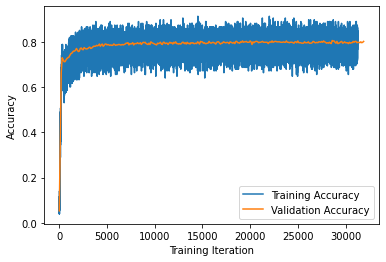

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()